# Starbucks Capstone - Exploration

## Situation <a name="situation">

**Motivation:** This project is part of the Udacity Data Science Nanodegree Program and intended to demonstrate all necessary and learned methods and concepts.

**Data Set:** The data set was provided by Starbucks. It contains customer profiles, a portfolio of offers, dand a simulated set of interactions between customers and offers. These interactions mimic customer behavior on the Starbucks rewards mobile app.

**Methodology:** The analysis is based on the cross-industry process for data mining (CRISP-DM). This six-phase process provides a structured approach to planning and realizing a data mining project. Those six phases are:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

This Jupyter notebook can be found on [GitHub](https://github.com/fsteppich/UD-DS-CapstoneStarbucks)

The accompanying blog post can be found on my GitHub page (https://fsteppich.github.io/blog/20200719-UD-DS-CapstoneStarbucks)

## 1. Business Understanding <a name="business-understanding">

To increase customer engagement, Starbucks sends out different kinds of offers to users within their Starbucks rewards mobile app. Such an offer can be an advertisement for a coffee, a discount, or buy one get on free (BOGO).

Sending out an offer is associated with a certain cost. In order to minimize these costs, it is important to only

1. send offers that are likely to be completed and
2. send these offers only to customers that are likely to be engaged.

This document will analyze the offer portfolio, user demographics, and user engagement. 

The business questions to be answered are:

* Which kind of users are most susceptible to offers?
* Which kind of offer engages the most users?

Based on the discovered insights different machine learning models will be built to improve offering strategy.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Data Understanding <a name="data-understanding">

In this section, I am going to build a basic understanding of the provided data and quality thereof. Quality issues will be resolved.

The data is contained in three files:

* portfolio.json - containing offer ids and metadata about each offer (duration, type, etc.)
* profile.json - demographic data for each customer / user
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In the next few subsection, I am going to load the data set and print some basic statistics.

In [2]:
def print_dataframe_shape(df):
    """
    Print the shape informaton of the given DataFrame
    
    :param df: DataFrame
    :return: None 
    """
    print("-" * 10)
    print("{} line(s), {} column(s)".format(df.shape[0], df.shape[1]))
    
def print_dataframe_na_statistics(df):
    """
    Calculate the sum of NaN values in the DataFrame and print it.
    
    :param df: DataFrame
    :return: None 
    """
    print("-" * 10)
    s_na = df.isna().sum()
    print("{} NA value(s) in DataFrame\n".format(s_na.sum()))
    print(s_na)
    
def print_dataframe_value_counts(df) :
    """
    Print the value counts of the given DataFrame column
    
    :param df: Column of a DataFrame
    :return: None 
    """
    total = df.count()
    for idx, val in df.value_counts().iteritems() :
        print("{} {} ({:.3}%)".format(idx, val, val/total*100))
    
    
# Color used to plot with seaborn if discrimination by color is not required
SB_BASE_COLOR = sb.color_palette()[0]

# Set of file names used to store different DataFrames
FILENAME_DF_USER_INCOME_SPENDING = 'df_user_income_spending.pickle'
FILENAME_DF_TIMELINE = 'df_timeline.pickle'
FILENAME_DF_TRANSACTIONS = 'df_transactions.pickle'
FILENAME_DF_MACHINELEARNING = 'df_machinelearning.pickle'
FILENAME_TMP_TRANSCRIPT = 'tmp_transcript.pickle'

# Set of Offer States (explained later)
OFFER_STATE_UNASSIGNED = 0
OFFER_STATE_IGNORED = 1
OFFER_STATE_NO_SUCCESS = 2
OFFER_STATE_SUCCESS = 3

Load serialized data if already available.

In [3]:
df_user_income_spending = pd.read_pickle(FILENAME_DF_USER_INCOME_SPENDING)
df_timeline = pd.read_pickle(FILENAME_DF_TIMELINE)
df_transactions = pd.read_pickle(FILENAME_DF_TRANSACTIONS)
df_machinelearning = pd.read_pickle(FILENAME_DF_MACHINELEARNING)

### portfolio.json

The offer portfolio has these columns:

* id (string) - offer id
* offer_type (string) - the type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [3]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

The column `channels` contains a list of used channels. These will be split into dummy columns in the part of this section.

In [55]:
print_dataframe_shape(portfolio)
print()
print_dataframe_na_statistics(portfolio)
print()
print("Data Types")
portfolio.dtypes

----------
10 line(s), 6 column(s)

----------
0 NA value(s) in DataFrame

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Data Types


reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [5]:
portfolio['id'].nunique()

10

Each row (10) in the DataFrame contains a unique offer id! 

Data types are as expected. No NaN values.

The data set contains the following offer types:

bogo 4 (40.0%)
discount 4 (40.0%)
informational 2 (20.0%)


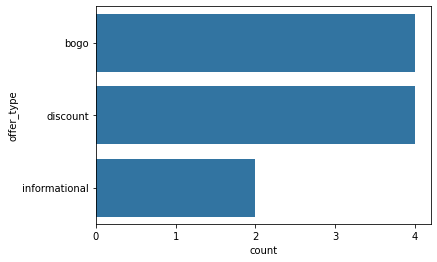

In [22]:
print_dataframe_value_counts(portfolio['offer_type'])
ax = sb.countplot(data = portfolio, y = 'offer_type', color=SB_BASE_COLOR, order = portfolio['offer_type'].value_counts().index)
ax.set_xticks(range(5));

#### Channel
The *channel* column contains a list of channels used to deliver the offer. These lists get unfolded into separate (dummy) columns. Each column should contain a 1 if the channel is present in the list, otherwise 0.

In [5]:
channel_names = ['web', 'email', 'mobile', 'social']
for channel in channel_names:
    new_channel_col = portfolio['channels'].apply(lambda x: int(channel in x))
    portfolio[channel] = new_channel_col
    
del portfolio['channels']

portfolio['number of channels'] = portfolio[['email', 'web', 'mobile', 'social']].sum(axis=1)
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   

                                 id  web  email  mobile  social  \
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1   
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0   

   number of channels  
0                   3  
1                   4  
2                   3  
3                   3  
4                   2

Let's see how often these channels got used.

Channel usage: 
web ...
1 8 (80.0%)
0 2 (20.0%)

email ...
1 10 (1e+02%)

mobile ...
1 9 (90.0%)
0 1 (10.0%)

social ...
1 6 (60.0%)
0 4 (40.0%)

Number of channels used: 


count    10.000000
mean      3.300000
std       0.674949
min       2.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: number of channels, dtype: float64

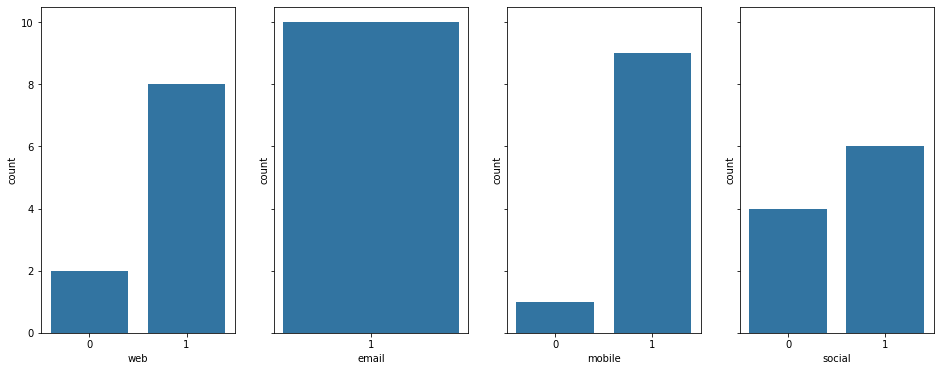

In [29]:
print('Channel usage: ')
for idx, channel in enumerate(channel_names):
    print(channel,"...")
    print_dataframe_value_counts(portfolio[channel])
    print()
    
figsize = (4 * len(channel_names), 6) 
fig, axs = plt.subplots(ncols=len(channel_names), sharey=True, sharex=False, figsize=figsize)
for idx, channel in enumerate(channel_names):
    ax = sb.countplot(data = portfolio, x = channel, color=SB_BASE_COLOR, ax=axs[idx])
    
print('Number of channels used: ')
portfolio['number of channels'].describe()

Channel usage:

* email is always used
* mobile in 90%
* web in 80%
* social in 60%
* At least 2, 4 at most and 3 on average channels used

As the e-mail channel is always used it will not convey any information and can, therefore, be ignored. The other three channels have a similar frequency. Considering each channel on its own, everyone got more frequently used than not. This is will lead to overfitting in the ML model. 

#### Difficulty, Reward, and Duration
Let's find out if the other columns show any pattern.

In [81]:
portfolio[['difficulty', 'reward', 'duration']].describe()

difficulty     reward   duration
count   10.000000  10.000000  10.000000
mean     7.700000   4.200000   6.500000
std      5.831905   3.583915   2.321398
min      0.000000   0.000000   3.000000
25%      5.000000   2.000000   5.000000
50%      8.500000   4.000000   7.000000
75%     10.000000   5.000000   7.000000
max     20.000000  10.000000  10.000000

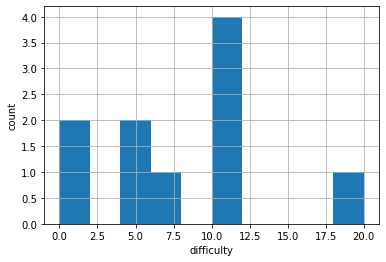

In [78]:
ax = portfolio['difficulty'].hist();
ax.set_xlabel("difficulty");
ax.set_ylabel("count");

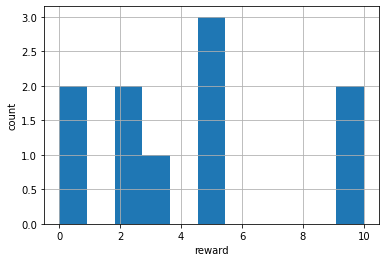

In [79]:
ax = portfolio['reward'].hist(bins=11); # 11 bins as *reward* is in a range from 0 to 10.
ax.set_xlabel("reward");
ax.set_ylabel("count");

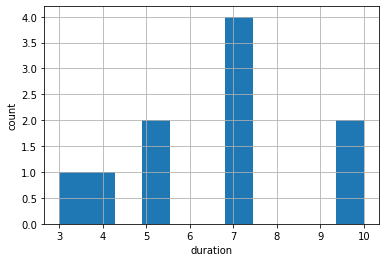

In [80]:
ax = portfolio['duration'].hist(bins=11); # 11 bins as *duration* is in a range from 0 to 10.
ax.set_xlabel("duration");
ax.set_ylabel("count");

The other numeric columns show no particular pattern on their own.

### profile.json

The (user) profile set contains these columns: 

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [7]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [34]:
print_dataframe_shape(profile)
print()
print_dataframe_na_statistics(profile)
print()
profile.dtypes

----------
17000 line(s), 5 column(s)

----------
4350 NA value(s) in DataFrame

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64



gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

#### ID

In [15]:
profile['id'].nunique()

17000

And each row in the profile set contains a unique user id. 

#### Age

Age statistics
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

NaN values: 0


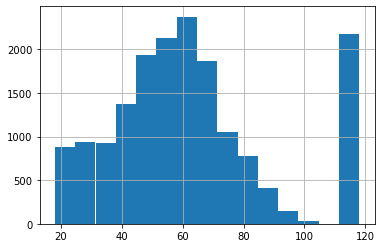

In [12]:
profile_statistics_age = profile['age'].describe()
print("Age statistics")
print(profile_statistics_age)

print("\nNaN values:", profile['age'].isna().sum())

profile['age'].hist(bins=15);

There is an unusually high number of profiles with *age* > 100. This might be some kind of NaN encoding.

In [13]:
print("\n{} users have the max age".format(profile[profile['age'] == profile_statistics_age['max']].shape[0]))


2175 users have the max age


To verify if the age of *118* is a encoding of NaN. Therefore I will check if the `gender` and `income` column are NaN if the age is *118*.

In [14]:
profile[(profile['age'] == 118) & (profile['gender'].isna()) & (profile['income'].isna())].shape

(2175, 5)

#### Age, Cleaning 118, Introducing Age Group
Each of the 2175 profiles did not provide a value for *gender*, *income*, and *age* (compare with the output from the beginning of this subsections `print_dataframe_na_statistics(profile)`).

Make the age value of 118 to NaN and divide the set of users into different age groups. Groupings are:

id | name | age range
---|---|---
0 | child | 0–15
1 | young adult | 16–30
2 | middle-aged adult | 31–50
3 | senior adult | >50

In [42]:
profile.loc[profile['age'] == 118, 'age'] = np.nan

def age_to_group(age):
    if pd.isna(age):
        return np.nan
    if age < 16:
        return 0
    if age < 31:
        return 1
    if age < 51:
        return 2
    return 3


# Group users by age
profile['age group'] = profile.apply(lambda r : age_to_group(r['age']), axis=1)
profile.head()

gender   age                                id  became_member_on    income  \
0   None   NaN  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN   
1      F  55.0  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
2   None   NaN  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN   
3      F  75.0  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
4   None   NaN  a03223e636434f42ac4c3df47e8bac43          20170804       NaN   

   age group  
0        NaN  
1        3.0  
2        NaN  
3        3.0  
4        NaN

3.0 9132 (61.6%)
2.0 3988 (26.9%)
1.0 1705 (11.5%)


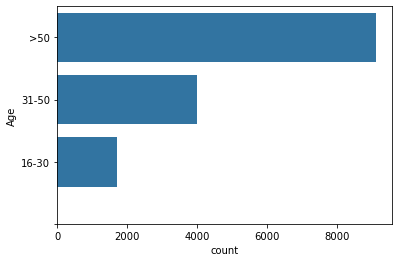

In [48]:
print_dataframe_value_counts(profile['age group'])

ax = sb.countplot(data = profile, y = 'age group', color=SB_BASE_COLOR, order = profile['age group'].value_counts().index)
ax.set_yticks(range(4));
ax.set_yticklabels([">50", "31-50", "16-30", ""]);
ax.set_ylabel("Age");

The biggest portion of users (61.6%) fall in the age group of senior adults (> 50 years). Children (< 15 years) are not present in this data set.

#### Gender
Next, let's take a look at the `gender` column in general.

Gender statistics
count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

NaN values: 2175

M 8484 (57.2%)
F 6129 (41.3%)
O 212 (1.43%)


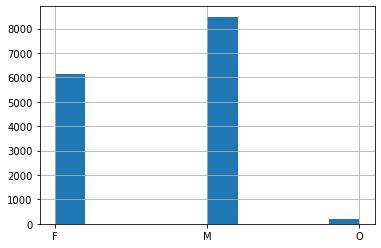

In [21]:
print("Gender statistics")
print(profile['gender'].describe())

print("\nNaN values:", profile['gender'].isna().sum())
print()
print_dataframe_value_counts(profile['gender'])
profile['gender'].hist();

Frequency of `M`ale and `F`emale are fairly equal but `O`ther is very low. This is to be considered when building a Machine Learning (ML) Model.

#### Income

Income statistics:

NaN values: 2175

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Gen.| Median | Mean
----|--------|--------
All | 64000.0| 65404.99
M   | 59000.0| 61194.6
F   | 71000.0| 71306.41
O   | 62000.0| 63287.74


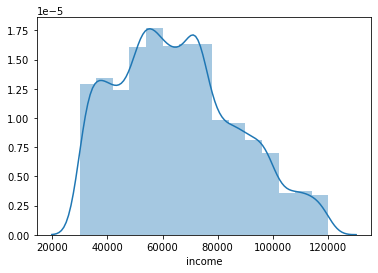

In [52]:
print('Income statistics:\n')

print("NaN values:", profile['income'].isna().sum())
print()
print(profile['income'].describe())

print("\nGen.| Median | Mean")
print("----|--------|--------")
income = profile['income']
print("{:4}| {:7}| {:.7}".format("All", income.median(), income.mean()))
for gender in ['M','F','O']:
    income = profile[profile['gender']==gender]['income']
    print("{:4}| {:7}| {:.7}".format(gender, income.median(), income.mean()))

sb.distplot(profile["income"], bins=15);

#### Age and Income by Gender
Let's see how the *age* and *income* varies depending on the *gender*. In the case of *age* == 118: these values need no special treatment, as *gender* is always NaN in these cases. Therefore, the corresponding records get omited by `FacetGrid`.

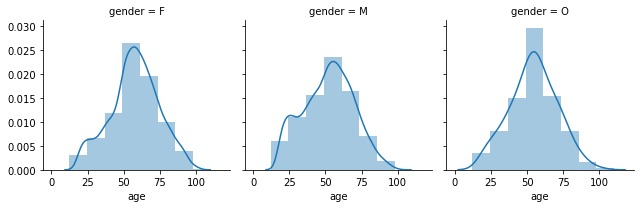

In [54]:
g = sb.FacetGrid(data = profile, col = 'gender')
bins = np.linspace(0, 110, 10)
g.map(sb.distplot, "age", bins=bins);

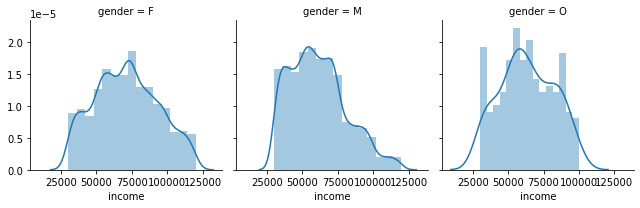

In [32]:
g = sb.FacetGrid(data = profile, col = 'gender')
g.map(sb.distplot, "income", bins=15);

*Age* is distributed similarly. The *income* of males is distributed equally in the rage of 25k..75k. The rest of the income spectrum is similar to that of the female and others.

#### Became Member On

To investigate the *became_member_on* column I first need to transform the integer value into a date object. The integer value looks like an ISO-formated (YearMonthDay) date value.

Became member on statistics
count                   17000
unique                   1716
top       2017-12-07 00:00:00
freq                       43
first     2013-07-29 00:00:00
last      2018-07-26 00:00:00
Name: became_member_on, dtype: object


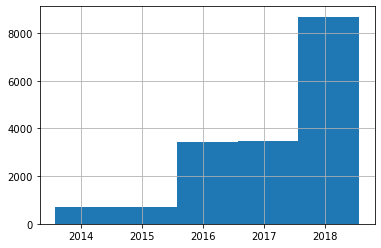

In [50]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

print("Became member on statistics")
print(join_data.describe())

join_date_year_range = join_data.max().year - join_data.min().year

join_data.hist(bins=join_date_year_range); # 4 years

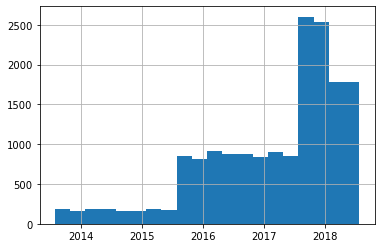

In [51]:
join_data.hist(bins=join_date_year_range*4);  # 4 years with 4 quartes

The rate of users joining shows two major increases. The first between 2015/2016 and the second between 2017/2018. Most users joined around the year 2018.

### transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer/user id
* time (int) - time in hours since the start of the test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [25]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [67]:
print_dataframe_shape(transcript)
print()
print_dataframe_na_statistics(transcript)
print()
transcript.dtypes

----------
306534 line(s), 4 column(s)

----------
0 NA value(s) in DataFrame

person    0
event     0
value     0
time      0
dtype: int64



person    object
event     object
value     object
time       int64
dtype: object

#### Events

In [56]:
print("Events used:\n")
print_dataframe_value_counts(transcript['event'])

transcript_events = transcript['event'].unique().tolist()

Events used:

transaction 138953 (45.3%)
offer received 76277 (24.9%)
offer viewed 57725 (18.8%)
offer completed 33579 (11.0%)


#### User (transcript VS profile)

In [86]:
print(transcript['person'].value_counts().describe())

is_person_equal_id_values = set(transcript['person'].unique().tolist()) == set(profile['id'].unique().tolist())
assert is_person_equal_id_values, "Not all users in the person column of transcript match a id in profile"

print("\nAll persons are in the id column of the profile data set. There is no new/unseen user")

count    17000.000000
mean        18.031412
std          6.849595
min          1.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         51.000000
Name: person, dtype: float64

All persons are in the id column of the profile data set. There is no new/unseen user


* Count (number of unique persons) does match the number of profiles
* On average a single user has 18 records

#### Duration of Collection

In [76]:
(transcript['time'].max() - transcript['time'].min())/168 # hours per week

4.25

Duration of the experiment / data set: *4.25 weeks*

#### Value
The transcript contains entries/rows representing events. Some events determine the life cycle (receive -> view -> complete -> expired) of an offer. Others signal a transaction (a user buys something). 

Extract all information from the *value* column into separate columns according to the key of the dictionary.

Two different dictionary keys got used to store the offer id (i.e. 'offer id' and 'offer_id' (with an underscore; on event 'offer completed'))

In [61]:
def get_from_transcript_value_dict(value_key, x):
    """
    Get the value out of the dictionary stored in column 'value' of the 
    transcript data set. This function handles also the inconsistant usage
    of the offer id key.
    
    :param value_key: requested key
    :param x: the dictionary found in column 'value' of the transcript data set
    :return: value for the given key, np.nan if the offer id was requested but not present and 0 otherwise.
    """
    if value_key in x:
        return x[value_key]
    
    if value_key == 'offer id':   # event type 'offer completed' uses 'offer_id'!!
        if 'offer_id' in x:
            return x['offer_id']
        else:
            return np.nan
    return 0  # ... otherwise 0
    
value_keys = ['offer id', 'amount', 'reward']
for value_key in value_keys:
    new_value_col = transcript['value'].apply(lambda x: get_from_transcript_value_dict(value_key, x))
    transcript[value_key] = new_value_col
    
del transcript['value']
transcript.head()

person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer id  amount  reward  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0       0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0       0  
2  2906b810c7d4411798c6938adc9daaa5     0.0       0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0       0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0       0

### Combining data sets

Till now I interpreted only the data sets on their own. Next, let's combine them.

#### Extend Portfolio: How often was an offer received, viewed, completed
First, I will extend the portfolio to contain the number of offers received, viewed, and completed with their respective relative frequencies.

In [99]:
def append_offer_event_count(lst, key, stats):
    """
    Safely append the count statistics of the given event to the list.
    
    :param lst: (out) List to which the count should be appended
    :param key: (in) Event type of which the count is to be extracted from stats
    :param stats: (in) Count statistics
    :return: None
    """
    if key in stats.index:
        lst.append(stats[key])
    else:
        lst.append(np.nan)
    
offer_completed_col = []
offer_received_col = []
offer_viewed_col = []
for offer_id in portfolio['id']:
    stats = transcript[transcript['offer id'] == offer_id].groupby('event')['offer id'].count()

    append_offer_event_count(offer_received_col, 'offer received', stats)
    append_offer_event_count(offer_viewed_col, 'offer viewed', stats)
    append_offer_event_count(offer_completed_col, 'offer completed', stats)
    
portfolio['offers received'] = offer_received_col
portfolio['offers viewed'] = offer_viewed_col
portfolio['offers completed'] = offer_completed_col

portfolio['offers viewed relative'] = portfolio['offers viewed'] / portfolio['offers received']
portfolio['offers completed relative'] = portfolio['offers completed'] / portfolio['offers received']

portfolio.sort_values('offers completed relative', ascending=False)

reward  difficulty  duration     offer_type  \
6       2          10        10       discount   
5       3           7         7       discount   
8       5           5         5           bogo   
3       5           5         7           bogo   
9       2          10         7       discount   
0      10          10         7           bogo   
4       5          20        10       discount   
1      10          10         5           bogo   
2       0           0         4  informational   
7       0           0         3  informational   

                                 id  web  email  mobile  social  \
6  fafdcd668e3743c1bb461111dcafc2a4    1      1       1       1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2    1      1       1       1   
8  f19421c1d4aa40978ebb69ca19b0e20d    1      1       1       1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0   
9  2906b810c7d4411798c6938adc9daaa5    1      1       1       0   
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1   
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0   
7  5a8bc65990b245e5a138643cd4eb9837    0      1       1       1   

   offers completed  offers received  offers viewed  \
6            5317.0             7597           7327   
5            5156.0             7646           7337   
8            4296.0             7571           7264   
3            4354.0             7677           4171   
9            4017.0             7632           4118   
0            3688.0             7658           6716   
4            3420.0             7668           2663   
1            3331.0             7593           7298   
2               NaN             7617           4144   
7               NaN             7618           6687   

   offers completed relative  offers viewed relative  
6                   0.699882                0.964460  
5                   0.674340                0.959587  
8                   0.567428                0.959451  
3                   0.567149                0.543311  
9                   0.526336                0.539570  
0                   0.481588                0.876991  
4                   0.446009                0.347287  
1                   0.438694                0.961148  
2                        NaN                0.544046  
7                        NaN                0.877789

Is any offer under- or overrepresented in the data set?

count      10.000000
mean     7627.700000
std        34.794795
min      7571.000000
25%      7602.000000
50%      7625.000000
75%      7655.000000
max      7677.000000
Name: offers received, dtype: float64

Difference between max and min: 106.0


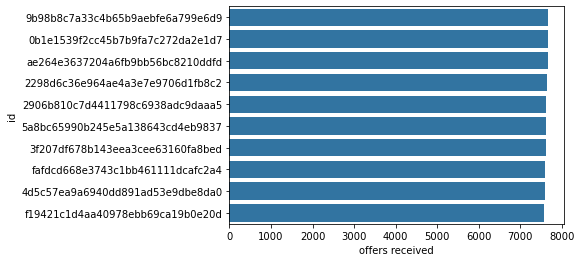

In [111]:
portfolio_offer_received_stats = portfolio['offers received'].describe()
print(portfolio_offer_received_stats)
print("\nDifference between max and min:", (portfolio_offer_received_stats['max'] - portfolio_offer_received_stats['min']))

sb.barplot(data = portfolio.sort_values('offers received', ascending=False),
           y = 'id',
           x = 'offers received', 
           color = SB_BASE_COLOR);

Each offer was received approximately 7627 times with a slight variance. This means that each offer is nearly equally often represented in the data set.

#### Completed VS Viewed
Let's see, which offers did not get completed though they got viewed. 

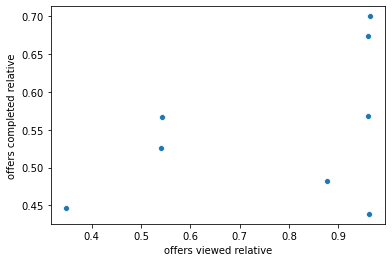

In [98]:
ax = sb.scatterplot(x='offers viewed relative', y='offers completed relative', data=portfolio.dropna())

In this case, I am interested in offers that got viewed more than 80% of the time and did get completed in less than 60% of the time.

In [113]:
portfolio[(portfolio['offers completed relative'] < .6) & (portfolio['offers viewed relative'] > .8)]

reward  difficulty  duration offer_type                                id  \
0      10          10         7       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5       bogo  4d5c57ea9a6940dd891ad53e9dbe8da0   
8       5           5         5       bogo  f19421c1d4aa40978ebb69ca19b0e20d   

   web  email  mobile  social  offers completed  offers received  \
0    0      1       1       1            3688.0             7658   
1    1      1       1       1            3331.0             7593   
8    1      1       1       1            4296.0             7571   

   offers viewed  offers completed relative  offers viewed relative  
0           6716                   0.481588                0.876991  
1           7298                   0.438694                0.961148  
8           7264                   0.567428                0.959451

#### User Income and Spending
Let's find out how much each user spends during the period presented in the data set `transcript`. The total spending can be calculated by summing the `amount` column of all records that matches a certain user id and the event `transaction`.

The new data set will be saved in its pickled form.

In [116]:
col_user_id = []
col_income = []
col_spending = []

user_ids = profile['id']
for user_no, user_id in enumerate(user_ids):
    print("{} ({:5}/{:5} ~= {:5.4}%)".format(user_id, user_no+1, user_ids.shape[0], ((user_no+1)/user_ids.shape[0]*100)))

    income = profile[(profile['id'] == user_id)]['income'].sum()
    spending = transcript[(transcript['person'] == user_id) & (transcript['event'] == "transaction")]['amount'].sum()

    col_user_id.append(user_id)
    col_income.append(income)
    col_spending.append(spending)
        
    
data = {
    "user id": col_user_id,
    "income": col_income,
    "spending": col_spending
}
df_user_income_spending = pd.DataFrame(data) 

# relative spending is in permille
df_user_income_spending['relative spending'] = df_user_income_spending["spending"] / df_user_income_spending["income"] * 1000
# replace inf values (created from division by zero) with nan
df_user_income_spending['relative spending'].mask(df_user_income_spending['relative spending'] == np.inf, np.nan, inplace=True)

# join with profile
df_user_income_spending = pd.merge(df_user_income_spending, profile[['id', 'gender', 'age', 'age group']], left_on='user id', right_on='id',
            suffixes=('_income', '_profile'))
del df_user_income_spending['id']

print("Saving df_user_income_spending ...")
with open(FILENAME_DF_USER_INCOME_SPENDING, 'wb') as f:
    pickle.dump(df_user_income_spending, f, pickle.HIGHEST_PROTOCOL)
    
df_user_income_spending

68be06ca386d4c31939f3a4f0e3dd783 (    1/17000 ~= 0.005882%)
0610b486422d4921ae7d2bf64640c50b (    2/17000 ~= 0.01176%)
38fe809add3b4fcf9315a9694bb96ff5 (    3/17000 ~= 0.01765%)
78afa995795e4d85b5d9ceeca43f5fef (    4/17000 ~= 0.02353%)
a03223e636434f42ac4c3df47e8bac43 (    5/17000 ~= 0.02941%)
e2127556f4f64592b11af22de27a7932 (    6/17000 ~= 0.03529%)
8ec6ce2a7e7949b1bf142def7d0e0586 (    7/17000 ~= 0.04118%)
68617ca6246f4fbc85e91a2a49552598 (    8/17000 ~= 0.04706%)
389bc3fa690240e798340f5a15918d5c (    9/17000 ~= 0.05294%)
8974fc5686fe429db53ddde067b88302 (   10/17000 ~= 0.05882%)
c4863c7985cf408faee930f111475da3 (   11/17000 ~= 0.06471%)
148adfcaa27d485b82f323aaaad036bd (   12/17000 ~= 0.07059%)
2eeac8d8feae4a8cad5a6af0499a211d (   13/17000 ~= 0.07647%)
aa4862eba776480b8bb9c68455b8c2e1 (   14/17000 ~= 0.08235%)
e12aeaf2d47d42479ea1c4ac3d8286c6 (   15/17000 ~= 0.08824%)
31dda685af34476cad5bc968bdb01c53 (   16/17000 ~= 0.09412%)
62cf5e10845442329191fc246e7bcea3 (   17/17000 ~=   0.1%

58748c1cf9f746838c6ec62acdff28ad (  144/17000 ~= 0.8471%)
49f22e86d2db41878778d70958dc744e (  145/17000 ~= 0.8529%)
28de174a5c854dd1be3187dc6edae45b (  146/17000 ~= 0.8588%)
a1eb338ccbca4cc88c9366939f16d819 (  147/17000 ~= 0.8647%)
220a39cdfd6b41268c43a2e588fcb7e0 (  148/17000 ~= 0.8706%)
0c89378f14804b42b6e63e4dc26e8d3e (  149/17000 ~= 0.8765%)
464d2302b99b46ad8eb3e42e1b849c24 (  150/17000 ~= 0.8824%)
3f36bc1d5fc0499b9f96f62348f0f9b0 (  151/17000 ~= 0.8882%)
fe97aa22dd3e48c8b143116a8403dd52 (  152/17000 ~= 0.8941%)
dbca75f289544e09836322ba2e104854 (  153/17000 ~=   0.9%)
c863af14b3654499b1caea5e640136d2 (  154/17000 ~= 0.9059%)
d7dc31e069124ef49e1bb937cb89f41c (  155/17000 ~= 0.9118%)
1827da57bb924833a6f73c79b5f2bbc5 (  156/17000 ~= 0.9176%)
721eb06ac285463aa6e1184e0ea9b7f0 (  157/17000 ~= 0.9235%)
d594b1f288674594a02c8527e5837ade (  158/17000 ~= 0.9294%)
0f54094029ca4107bfd36203aeb3ed14 (  159/17000 ~= 0.9353%)
5f18c5754dc04baaa1267c823f877a85 (  160/17000 ~= 0.9412%)
d8567f1400d8486

585fb2dc600d4a0f912d8911aba11203 (  290/17000 ~= 1.706%)
9b0e7b326e314b758369c2f794566eb3 (  291/17000 ~= 1.712%)
aec532a91d9948cb828cc657fa27fce2 (  292/17000 ~= 1.718%)
9c64321646bf40f6ad1bc98864eaa6b8 (  293/17000 ~= 1.724%)
4e6eb10de9744995be7496f5b1cc7bcf (  294/17000 ~= 1.729%)
a02783021b7c49eba12cb58cc73a4c44 (  295/17000 ~= 1.735%)
e89dce9d75634dc5bf1df0a0cea0f316 (  296/17000 ~= 1.741%)
e08a264dc9a54efca07e1cf7e9b38480 (  297/17000 ~= 1.747%)
a4ac99af1b7f4344b734ac07592ab717 (  298/17000 ~= 1.753%)
f8362fcaa42248fca2a2a174951a954a (  299/17000 ~= 1.759%)
676506bad68e4161b9bbaffeb039626b (  300/17000 ~= 1.765%)
b7658a8eab2f42668a9d66499b001e88 (  301/17000 ~= 1.771%)
98df356ed5864c12a227be4fff503e42 (  302/17000 ~= 1.776%)
a8719d4d305444579b2d2c1b777c3417 (  303/17000 ~= 1.782%)
bd215efd787d4305a006a56154fbcb67 (  304/17000 ~= 1.788%)
f5e59835627a49a0b13c4183522225d4 (  305/17000 ~= 1.794%)
f970eafddcb34154aa4d646b4a71ca34 (  306/17000 ~=   1.8%)
c4a3c86c7b5541cf83d443c2a89e5b5

81d1298cca294146801c6c086a616399 (  435/17000 ~= 2.559%)
76919022666747ffb747b52151ba992b (  436/17000 ~= 2.565%)
4866a2c8fedd46b98dc2c695f8cc5840 (  437/17000 ~= 2.571%)
09020cacd73b48a7b1d1310dd9ca004b (  438/17000 ~= 2.576%)
597bcbdab11c4236aaf895ca94d9aa60 (  439/17000 ~= 2.582%)
b8dc729c581045a59f2186c210c5a06c (  440/17000 ~= 2.588%)
d7282e3f7eec4cc5a38212189af80d2e (  441/17000 ~= 2.594%)
8b5f5a1b1c43427ba7fb1e8e307a05e3 (  442/17000 ~=   2.6%)
055a06b9a6ad42fcaa1fe7706b5e21aa (  443/17000 ~= 2.606%)
fc41f98eaccc4c6e9ba3d3361714c527 (  444/17000 ~= 2.612%)
3f244f4dea654688ace14acb4f0257bb (  445/17000 ~= 2.618%)
05dedca5b2034055a64979a2c28b3477 (  446/17000 ~= 2.624%)
93893ec00b5346228088f867e6164b1e (  447/17000 ~= 2.629%)
ff298e06fee240039dfd761a0a2ea25e (  448/17000 ~= 2.635%)
eaaa456d803e49798017100b16fda6c5 (  449/17000 ~= 2.641%)
c8d495a12bd049489dd2d185cd20bfc3 (  450/17000 ~= 2.647%)
be7ff3cb6bf84ce395471e52b64b70c6 (  451/17000 ~= 2.653%)
6a619d10e88f489eae05ceb9a8f5b17

70938b2cdda040a4b513a39d9ac381ed (  580/17000 ~= 3.412%)
dbb37c0caad54f4a979a8121de79d0a2 (  581/17000 ~= 3.418%)
e112df4e6aba4ff79790a75e7304cbc5 (  582/17000 ~= 3.424%)
421260f3c6cf49018be314fa93446ff9 (  583/17000 ~= 3.429%)
e7a9b8f3ac29471ea6c0baf4ae2c97aa (  584/17000 ~= 3.435%)
55540073b2be424a9729852465b1b8df (  585/17000 ~= 3.441%)
532638c9f8d942a5bb39688d2f8bac20 (  586/17000 ~= 3.447%)
3ade1139f5ba498087716e9735366da3 (  587/17000 ~= 3.453%)
4b2a9054c3024ff5be7b0b7196159b62 (  588/17000 ~= 3.459%)
3cabd0099961416b9810043e7eb0f743 (  589/17000 ~= 3.465%)
46c1046acb4b4f29840ba3d55ba5682d (  590/17000 ~= 3.471%)
bfea1616533f4ca0971407dc5a63b7c7 (  591/17000 ~= 3.476%)
44714042b21e44e4ac10754bbdda8347 (  592/17000 ~= 3.482%)
1cf78b092c964dbbaf4fc82cbaed6c54 (  593/17000 ~= 3.488%)
b30df99d6d0a4544a7d8f2beb79f7a68 (  594/17000 ~= 3.494%)
490b282bfc3945df8ac3bbe54dd400fe (  595/17000 ~=   3.5%)
c0c3517fdf1b41ceac16d5432c7a4aa5 (  596/17000 ~= 3.506%)
c35b03c286fa44bea8a1739558a87d3

3992a086bf2646ddae7821ed3e9424a3 (  724/17000 ~= 4.259%)
d34af41fdf2a4ca2a68dc6991d5a8059 (  725/17000 ~= 4.265%)
bed9fd6cebd64367a9198990c097477f (  726/17000 ~= 4.271%)
9f2bbc9d8b65448aab330a6059292679 (  727/17000 ~= 4.276%)
a1c72a010c5746f28251ae4267816025 (  728/17000 ~= 4.282%)
b925f853e90442d99f203e12e899999b (  729/17000 ~= 4.288%)
e199fdec031441fb9f1295eb7952be69 (  730/17000 ~= 4.294%)
15ab73bf4cc4467db865911592678b38 (  731/17000 ~=   4.3%)
91980427ebe04cd7be18426320375cc5 (  732/17000 ~= 4.306%)
6181f119c4ef43ed8eccf9af10ec2121 (  733/17000 ~= 4.312%)
b28132faa6754c4590adcbd47e7a2004 (  734/17000 ~= 4.318%)
69743d51492d4173b0e054fd5d8f943c (  735/17000 ~= 4.324%)
66e04cebe10343a9b26dd1aaf909a601 (  736/17000 ~= 4.329%)
0c0af42e1e804ded94eb5d73dfffbb6f (  737/17000 ~= 4.335%)
7f872e820d574862bfb79fdb3b2da602 (  738/17000 ~= 4.341%)
9675cdd10b144aff8be41a7eea5e9670 (  739/17000 ~= 4.347%)
7c8479d8241344f6a0c306621e191c75 (  740/17000 ~= 4.353%)
92a01881553f458daa00d6b726dc78d

bbb006e2e4524989adb8838954fb96d2 (  868/17000 ~= 5.106%)
017febbe52e64ac19cf28cf0d44386e4 (  869/17000 ~= 5.112%)
1418e71469474b7fa160cd76b198cb08 (  870/17000 ~= 5.118%)
8c80570b7dfb49629e86042c17e659dc (  871/17000 ~= 5.124%)
ae27549c1fcc4407a7d5d270928ff0ab (  872/17000 ~= 5.129%)
c6e579c6821c41d1a7a6a9cf936e91bb (  873/17000 ~= 5.135%)
363c76c8cc6e4554ba17d25349e03db8 (  874/17000 ~= 5.141%)
afce4cf8194f4e90a3e92da941a23601 (  875/17000 ~= 5.147%)
136d774c59da4d0b9c8f88225e2b0be1 (  876/17000 ~= 5.153%)
291cba1be979478ca1aa0ba29bc0c849 (  877/17000 ~= 5.159%)
bbdadc0af7ad49e5ae5627940eb3b4e2 (  878/17000 ~= 5.165%)
0de88a1f670a470ab5dda5e4242bcbb9 (  879/17000 ~= 5.171%)
3938125799fc4ebca4d77ca64701926e (  880/17000 ~= 5.176%)
5d730591f70c4e509382bd553d6e10a6 (  881/17000 ~= 5.182%)
be8f765ae7774446bbbd3db35a6ed4a6 (  882/17000 ~= 5.188%)
75bb371cf36d4a9186397a9866ed2fbe (  883/17000 ~= 5.194%)
7d382450e3b241748bbe665661bc4273 (  884/17000 ~=   5.2%)
a4ebb3f91224451a93cb4597ca3ceb4

fbd7bb82f4284846b38bffe314f61b67 ( 1015/17000 ~= 5.971%)
00c5a385c71a4d3db5e9b4e31e430943 ( 1016/17000 ~= 5.976%)
00b901d68f8f4fd68075184cd0f772d2 ( 1017/17000 ~= 5.982%)
eb96c54abda74fa5862e03662b0953ed ( 1018/17000 ~= 5.988%)
720d1757d1d8444294aea1f0b05cf3fc ( 1019/17000 ~= 5.994%)
52828a714b6643159c91c341d63945a6 ( 1020/17000 ~=   6.0%)
56c1574caaa24a07b4962967f2dcc1fa ( 1021/17000 ~= 6.006%)
ccca0c2ebba147a6a37e37bee03b5d63 ( 1022/17000 ~= 6.012%)
4a28b6d05e6145aaa004088131840b0c ( 1023/17000 ~= 6.018%)
44b02bac48694f92aa88cc04e597f6f0 ( 1024/17000 ~= 6.024%)
ac1cc98adbb3419db722ecbdb1583426 ( 1025/17000 ~= 6.029%)
20570cb0c03947699a75887bb6a65145 ( 1026/17000 ~= 6.035%)
716bbdabd4d0498da48299483c7046d2 ( 1027/17000 ~= 6.041%)
1ee6879d8f294adaa5bc6cbc0f609df1 ( 1028/17000 ~= 6.047%)
13dbf409912748af89dc3d4aafbfd222 ( 1029/17000 ~= 6.053%)
f6baa0a236294d1a802901b8f2dbdbf6 ( 1030/17000 ~= 6.059%)
62243cd711cd44238bd266c3cce4dd7f ( 1031/17000 ~= 6.065%)
fa417442977e4910ad8b3823db0b617

605799ea4d6541a2894e39e9498cdaa6 ( 1160/17000 ~= 6.824%)
f433cff29e324685ae74dd8488ee34bd ( 1161/17000 ~= 6.829%)
09f9c7a696c340cf988d9a38c8a495e2 ( 1162/17000 ~= 6.835%)
fe4b84c6bd5d4c6098f6299220965440 ( 1163/17000 ~= 6.841%)
6103ebe6617f40c19295e9f2c88868d6 ( 1164/17000 ~= 6.847%)
da9557652a704bb59cbc84cbf2b7f7d8 ( 1165/17000 ~= 6.853%)
94b6a06fdbb1496193b6402ae2f31509 ( 1166/17000 ~= 6.859%)
56630668a08842a38f32bf4f7bfa4125 ( 1167/17000 ~= 6.865%)
ed53076edc1d445cabf99d3d0b37a6a9 ( 1168/17000 ~= 6.871%)
b41fa23db9b44eacaaf75ea0546ff38d ( 1169/17000 ~= 6.876%)
762f6c4f07154cca81e7fca143f3d2de ( 1170/17000 ~= 6.882%)
b4f2fa2ea0674f53916963aecf291dfb ( 1171/17000 ~= 6.888%)
28bbebb2b76f4057b1115dd80441e37a ( 1172/17000 ~= 6.894%)
147be99d763240b4b7cbe0e024693807 ( 1173/17000 ~=   6.9%)
04cb9d0033f142efa2a367f4ef273460 ( 1174/17000 ~= 6.906%)
9e116eeee25949e7b1a3f91227db7422 ( 1175/17000 ~= 6.912%)
54dd0ebf9ac74e7b876341509876e06a ( 1176/17000 ~= 6.918%)
6fa9ef8890bc467699ce92f2679a417

d8fc164eb048450797d598b391c09ffa ( 1305/17000 ~= 7.676%)
48e69836abe64357b92e8f0d314cbe46 ( 1306/17000 ~= 7.682%)
8d1e56c804e140fca2c001caf65d3eaa ( 1307/17000 ~= 7.688%)
aef583f3c3614f9e96d7940df55510b2 ( 1308/17000 ~= 7.694%)
037c3e0c1cd6477dbe15812a05619fc5 ( 1309/17000 ~=   7.7%)
77cd4ac72569483c915e8bcbacbd3e1e ( 1310/17000 ~= 7.706%)
cef9b883c0c947e88659c9eb361b3250 ( 1311/17000 ~= 7.712%)
8a6a2df8be214007991afb612eb64c1c ( 1312/17000 ~= 7.718%)
fdd13fa0fcce4e7492b5585b7ba639c4 ( 1313/17000 ~= 7.724%)
2e51a42242954c69acf329eec82b849d ( 1314/17000 ~= 7.729%)
f904dad31185443c909f7722c28e9840 ( 1315/17000 ~= 7.735%)
3d6b84ec992941ef9ed4d684cb160edd ( 1316/17000 ~= 7.741%)
e309916d14da4d85838e81462faee824 ( 1317/17000 ~= 7.747%)
2958d18923e240bab72e26106c210bdd ( 1318/17000 ~= 7.753%)
8f99435bebc2455bb4d3a2c931399f37 ( 1319/17000 ~= 7.759%)
de90515e9f174ddfb8b4c677448286ef ( 1320/17000 ~= 7.765%)
8cb835dd91384cbba5d0b069da2528c7 ( 1321/17000 ~= 7.771%)
c94f3d4f206647d18f2b3d80562af5c

e95e8899562f4cad8d53ed81367af82a ( 1449/17000 ~= 8.524%)
e89343c8b43040e1a55945cd6cba387f ( 1450/17000 ~= 8.529%)
eeac54fc267c42838fb3e030b38a309e ( 1451/17000 ~= 8.535%)
baec6fd421ca41948585242e20df9852 ( 1452/17000 ~= 8.541%)
481bcb3261a548bdb59df61d5e2a9ce3 ( 1453/17000 ~= 8.547%)
e2fde1e26e474422b36954f98454795d ( 1454/17000 ~= 8.553%)
2520b80ef6024377adb7d8fb5691160e ( 1455/17000 ~= 8.559%)
7055b5fa5f8647618aa14e220b7c6b5c ( 1456/17000 ~= 8.565%)
89e87fe900f941e58b903eb6c444b50f ( 1457/17000 ~= 8.571%)
8e1c2a8b7d7f4bc695ef755c2d2e6df1 ( 1458/17000 ~= 8.576%)
f47de7e07e1149429d604937326ae500 ( 1459/17000 ~= 8.582%)
5a7af629a0244c35b98846d4fc8d4603 ( 1460/17000 ~= 8.588%)
2c969df103ad4ed5a4e9fc6ba6daa8ed ( 1461/17000 ~= 8.594%)
9f1114fcf9f54508a4887d4ac0dc130c ( 1462/17000 ~=   8.6%)
bea7a8fa65284ef98edeeee7cb8abd53 ( 1463/17000 ~= 8.606%)
6c785ed987254d2bb2897431e3de7c97 ( 1464/17000 ~= 8.612%)
0b5f7c9086c24311a971fef614bafd22 ( 1465/17000 ~= 8.618%)
c18566c8d89149a3b87f828a6e22b47

18bd0776b46a498594fb139a9f7613a7 ( 1593/17000 ~= 9.371%)
1557b5b0908a4ef185af8295f50f16c4 ( 1594/17000 ~= 9.376%)
15cc0c4a2c2949e588cba43fae8fd01f ( 1595/17000 ~= 9.382%)
bd7c74c5166e4a469ad169da1e0f3d8d ( 1596/17000 ~= 9.388%)
c43cc9ae7c0c4ca9b65460f7aa6dbf20 ( 1597/17000 ~= 9.394%)
e24a898ab87b4bbd96c6b48f268b56bb ( 1598/17000 ~=   9.4%)
d7f86043a9de4c5f83bf646795685aa1 ( 1599/17000 ~= 9.406%)
55b8653d0c614b5884b6da92d9e90c2a ( 1600/17000 ~= 9.412%)
ea10d329aaae4289bad750793117f69f ( 1601/17000 ~= 9.418%)
eb1ac23785c04e32aed043360c53234e ( 1602/17000 ~= 9.424%)
2cec68f40dd4472aaebddeb1308e8a61 ( 1603/17000 ~= 9.429%)
fff8957ea8b240a6b5e634b6ee8eafcf ( 1604/17000 ~= 9.435%)
9e3f177afd7a4d939d486f79e4bfeeb6 ( 1605/17000 ~= 9.441%)
b1f4e2cbbdd6480699e0f0a355822f49 ( 1606/17000 ~= 9.447%)
2b4bfbda411041ef84ee39bae91fb229 ( 1607/17000 ~= 9.453%)
1a297cc7262d42b59fb3e34fe0166702 ( 1608/17000 ~= 9.459%)
79a1b2e7bab8420c98a59530a783155d ( 1609/17000 ~= 9.465%)
9a0e465c898540a9b6221a6ddca88f6

d5299e0003e44a11858e28bc4fd86d0c ( 1880/17000 ~= 11.06%)
ef314f5d09244d6d9ea23fe66acb5b06 ( 1881/17000 ~= 11.06%)
54be86b2561e4e379e6446663e4d8935 ( 1882/17000 ~= 11.07%)
8106a980e679458d95261d5568f59f4d ( 1883/17000 ~= 11.08%)
614c0569deff45ab990b0f423675490f ( 1884/17000 ~= 11.08%)
3a1fa4f6336d4b77baf0be29c57a73d5 ( 1885/17000 ~= 11.09%)
478f3d690f8640e8b017e13a794936a0 ( 1886/17000 ~= 11.09%)
ffff82501cea40309d5fdd7edcca4a07 ( 1887/17000 ~=  11.1%)
cbdd0e50d9e24b60a9ff67444a2ff7ef ( 1888/17000 ~= 11.11%)
acc1b286392b42ae8db2059cfd16f773 ( 1889/17000 ~= 11.11%)
9e1b77408fdb414bb6d36a1aa04567e8 ( 1890/17000 ~= 11.12%)
8652c3edf3e84c70b635dbdd4cddd397 ( 1891/17000 ~= 11.12%)
7104c937e25148bda396c5a0cbdf3959 ( 1892/17000 ~= 11.13%)
8df3bb97a75a47b08c87d2cc3187eeb7 ( 1893/17000 ~= 11.14%)
e4c7eb36bf7a40dcb0ca0fc233d0ba6e ( 1894/17000 ~= 11.14%)
a4ef66feebf34cbd961d2f557a13b4ec ( 1895/17000 ~= 11.15%)
b0e8e98e9a314840875b28a8bf93904e ( 1896/17000 ~= 11.15%)
b0b441a558da4511ab7c59b4ff1284e

9f8b97dbbf3740199a0c701febb6a687 ( 2024/17000 ~= 11.91%)
db48f200f10b4289912cac904a0b37d2 ( 2025/17000 ~= 11.91%)
8f11c23b3301448f993d6885bff9d0f8 ( 2026/17000 ~= 11.92%)
9326fc2e01cd4496808eafe54916cc53 ( 2027/17000 ~= 11.92%)
14124920a71f47b0aafe3af220107cfe ( 2028/17000 ~= 11.93%)
b54471245e86418da92bdab04191e40c ( 2029/17000 ~= 11.94%)
b892431655444eab8ee18d5712e24958 ( 2030/17000 ~= 11.94%)
64878f55f0e64c88ba6af9e168896b48 ( 2031/17000 ~= 11.95%)
873f0e0caae14b9fba66f6db4e715aa4 ( 2032/17000 ~= 11.95%)
bf6849a39d3640069a65f44f8b01f5da ( 2033/17000 ~= 11.96%)
c854f458625c405c87adec777d6cbbbe ( 2034/17000 ~= 11.96%)
af3669c4575a45e994defa7bacd111ba ( 2035/17000 ~= 11.97%)
9fa6e119bc854952a5c8d2e7915f4727 ( 2036/17000 ~= 11.98%)
6d2db3aad94648259e539920fc2cf2a6 ( 2037/17000 ~= 11.98%)
82bd3f2f916d4e5bbc4b1ac9aa88d5a9 ( 2038/17000 ~= 11.99%)
5356198b00864b79942f118cb54fd5a7 ( 2039/17000 ~= 11.99%)
fda2862641d74e19ba0a249a0e3a83f3 ( 2040/17000 ~=  12.0%)
af9271c4812545a9918c9fba7b082db

9431b531c73f402a810754e48c8eac0e ( 2169/17000 ~= 12.76%)
07455479fc8c4b5aba6c50955a5ca60f ( 2170/17000 ~= 12.76%)
91659a8581b3422480a27aff43e9ba45 ( 2171/17000 ~= 12.77%)
530a3bab3e7e490192193bef66e0fa57 ( 2172/17000 ~= 12.78%)
07223b7cc9d448b196562395c8f8d4c7 ( 2173/17000 ~= 12.78%)
8f37f5ae5a83466dbb763b7a8afddc8c ( 2174/17000 ~= 12.79%)
c8616f2d495c412c95dd5bd646553624 ( 2175/17000 ~= 12.79%)
fb3494aa3dbe452cbe087508eb3dfe5c ( 2176/17000 ~=  12.8%)
ecde4ed5d52e481dba63bb14d91c7a4d ( 2177/17000 ~= 12.81%)
585a0bbfeba2460faac73d8e4f98e1a6 ( 2178/17000 ~= 12.81%)
1d81586ec7f64ab7b28e4594030f003e ( 2179/17000 ~= 12.82%)
adee4e7b7dfd4661bd0faa61ed3ad33b ( 2180/17000 ~= 12.82%)
b0c6b9ecae7f47dc93a44edef68ab1a8 ( 2181/17000 ~= 12.83%)
331cf431a99b4f9c9b4e63fcb3779fd9 ( 2182/17000 ~= 12.84%)
9a51d710fdda4b4ebba9550dcd15353c ( 2183/17000 ~= 12.84%)
d78e3632979b4a24aab5007c8f1f0b7f ( 2184/17000 ~= 12.85%)
1a9cc4b4f763429b9cb006bd78cd7a7b ( 2185/17000 ~= 12.85%)
2c4fbcf0ef95498f923f7c7424dc483

d95023d1b9384f11861dcde35e65ce8c ( 2314/17000 ~= 13.61%)
9299c46942f84bb6b5e98fd78fbb9d41 ( 2315/17000 ~= 13.62%)
f5d6d25d09924e0390b84c0c34888824 ( 2316/17000 ~= 13.62%)
4aae0550a3ad45ca86191318b27d3ae4 ( 2317/17000 ~= 13.63%)
e7637f69f41b4c5f93094a544a84cb79 ( 2318/17000 ~= 13.64%)
e304dfcda07a43f694d3790607b4659d ( 2319/17000 ~= 13.64%)
0fca718a20f74f078c4fb7cc1cbd7c77 ( 2320/17000 ~= 13.65%)
29b4fa639b7240f5893a612207d16eef ( 2321/17000 ~= 13.65%)
37f62826a6564d34a61b146ea6e90887 ( 2322/17000 ~= 13.66%)
c3b922f22b3949579681bd9198d8f266 ( 2323/17000 ~= 13.66%)
f580a8d78b96495aa9f127f78911f979 ( 2324/17000 ~= 13.67%)
dba0582e295e4cb48263751157e4e821 ( 2325/17000 ~= 13.68%)
c904a6699db54225931ef82552f3f9ea ( 2326/17000 ~= 13.68%)
07b78a8616714b58ad3a9ed94126c459 ( 2327/17000 ~= 13.69%)
86d1c0779345461fb1f5811627c93b3e ( 2328/17000 ~= 13.69%)
bef9600c1509404e87c68c053d1b95e5 ( 2329/17000 ~=  13.7%)
673e057084654257bc73e542f1f71ee2 ( 2330/17000 ~= 13.71%)
327eb6591ffc43ef8bbc550d878891c

1fa6bb2a2891447490ee9bf77f7319c0 ( 2460/17000 ~= 14.47%)
05bbe7decb6d43b684221df448979612 ( 2461/17000 ~= 14.48%)
fcaddab0e0484a4e9912113ae57f94ca ( 2462/17000 ~= 14.48%)
7ede8e7cf9184907820365ce64bb8f7a ( 2463/17000 ~= 14.49%)
331f88bc7b5042ec9a4c90bb8e516cb5 ( 2464/17000 ~= 14.49%)
b553a74d19d249bba731e6df9db8eaea ( 2465/17000 ~=  14.5%)
e1524552a290403b8b99074c917a3f60 ( 2466/17000 ~= 14.51%)
572a08d7ec2b4947b3cb9ea0d8d0c9a0 ( 2467/17000 ~= 14.51%)
7eb85a133c7e4a7d9cac1df25e50d9c8 ( 2468/17000 ~= 14.52%)
9f2e7a00443644188720ca9edc74370c ( 2469/17000 ~= 14.52%)
4eeaab922a754d58a14733cfd2952279 ( 2470/17000 ~= 14.53%)
1971866be459439aa62669bd4d56f394 ( 2471/17000 ~= 14.54%)
6b247ba48509456eb57b24f878f313ea ( 2472/17000 ~= 14.54%)
153e3e2d8ca342eeb5bcdbaeb7552568 ( 2473/17000 ~= 14.55%)
fa5d0a39814a48b1a5886c9acdf95b92 ( 2474/17000 ~= 14.55%)
eb001c00e27546f296d35627290e0b5e ( 2475/17000 ~= 14.56%)
5f5c91807f7f475f85fc241e45e23ed2 ( 2476/17000 ~= 14.56%)
bb8b3e8a1f05462e986af07001c9c17

83ac33743b594a78a1f114fffbd860f8 ( 2605/17000 ~= 15.32%)
d794c80154a24d78b06fbcb212e855cd ( 2606/17000 ~= 15.33%)
1d62a7b6d4fb4defb8ae6ddf300600e5 ( 2607/17000 ~= 15.34%)
9d51382187a24b249a2bf1bf659188c9 ( 2608/17000 ~= 15.34%)
a85bfafef1214b86a1ecb57fca38f0ae ( 2609/17000 ~= 15.35%)
5405936fa4ac46aead4dbfb87b9e3d2f ( 2610/17000 ~= 15.35%)
08d06b602c844926a037b0b253901d52 ( 2611/17000 ~= 15.36%)
3c55dbc0fe1a487c9743dfa6170d20e8 ( 2612/17000 ~= 15.36%)
cc3ca7632fda478cb573c06ac9f445aa ( 2613/17000 ~= 15.37%)
6ba699c43fd64dc598ceec20b4575ea1 ( 2614/17000 ~= 15.38%)
8e72ac4ba0284eaaad4de2aac41287b4 ( 2615/17000 ~= 15.38%)
bb0cd0088df4438a821e5b644a3cbac9 ( 2616/17000 ~= 15.39%)
742d4ed2ba5545fdb8dc320020f38cc3 ( 2617/17000 ~= 15.39%)
e18df1641cb14c7c90aa28e6a6350f5c ( 2618/17000 ~=  15.4%)
8f6aad9d78ae48e4a815c988e01ec52d ( 2619/17000 ~= 15.41%)
759c2269abc44dfdb8e6d140d4060856 ( 2620/17000 ~= 15.41%)
7ab8b28bc5044b56b13aa5ed2f12bc40 ( 2621/17000 ~= 15.42%)
9aa6316728c24a16a7819ba6cefb606

45d7bce929cf4356955170d2f94ca405 ( 2751/17000 ~= 16.18%)
cfc4bbee38734ac2a99ecc012ae12f0d ( 2752/17000 ~= 16.19%)
f394ad9a93f5458394d052c8b860286e ( 2753/17000 ~= 16.19%)
d240308de0ee4cf8bb6072816268582b ( 2754/17000 ~=  16.2%)
5d1e22706c3b401a8947cc64c484c932 ( 2755/17000 ~= 16.21%)
a678040b34eb47e0ad23864c283dc8ef ( 2756/17000 ~= 16.21%)
0d71469761604d3688ca099ff09a403f ( 2757/17000 ~= 16.22%)
2b826162a0bd4690b318fd430d2adef2 ( 2758/17000 ~= 16.22%)
75ce7d71302e4e97af9bbeaebdd9ca9f ( 2759/17000 ~= 16.23%)
d48ca9287f4c458793c9279c5bb6973e ( 2760/17000 ~= 16.24%)
dcc4cddbb55f4241a7bc73205e290262 ( 2761/17000 ~= 16.24%)
363c28b57ad34b468e3a687fd904b6c1 ( 2762/17000 ~= 16.25%)
2c51298e7b644623a3760b4bb5a92bde ( 2763/17000 ~= 16.25%)
0c88140597254428ba857b1e6782bce1 ( 2764/17000 ~= 16.26%)
ed851c7728e34d21854a3ece16c3417a ( 2765/17000 ~= 16.26%)
ebae5093b436466c9fbd097cb7434023 ( 2766/17000 ~= 16.27%)
e8f25bd0c79b4fbf8f021e1184332b89 ( 2767/17000 ~= 16.28%)
c6bab8832fd043e5b81dc5f0b587ec6

18fc7f5237ff466ebfe2aeb5bfebf1b4 ( 2896/17000 ~= 17.04%)
b29a01cc9ffd4954aab1beb1008d840f ( 2897/17000 ~= 17.04%)
360b8705b0564f2194a16ec4866b1164 ( 2898/17000 ~= 17.05%)
b08f1eafc66e44e6aa486d7d33351964 ( 2899/17000 ~= 17.05%)
acc03f9b3c444433997dc08615899691 ( 2900/17000 ~= 17.06%)
2b90cc782a274391be191cd221be2546 ( 2901/17000 ~= 17.06%)
e3c8e0d6234746d184b3ab79aa6614c6 ( 2902/17000 ~= 17.07%)
ff8ff8e5d8bb449894bf708924020edc ( 2903/17000 ~= 17.08%)
030c30c1955f4a17be09b692caf5ec5f ( 2904/17000 ~= 17.08%)
5909ea92965f4a4bb1cb0374dead0ff5 ( 2905/17000 ~= 17.09%)
e2966f15389e4e0e9a5891bd675a5f11 ( 2906/17000 ~= 17.09%)
7aa3e5382a9f45de820accd86d8e444b ( 2907/17000 ~=  17.1%)
f9c4205c9a3b408e9f19b523b182c546 ( 2908/17000 ~= 17.11%)
d79a422d00674d80a30311c203ad0e6b ( 2909/17000 ~= 17.11%)
f6f3412fccea4ca7a15724586ef0e792 ( 2910/17000 ~= 17.12%)
2ae0eb4401a244b7b81a88f47539e82e ( 2911/17000 ~= 17.12%)
d4c2549073b242db839688ef8fe0b2e9 ( 2912/17000 ~= 17.13%)
715b22238df84b9fbad9485f23192c4

67e6be3bd5c44381b3e2dfe9170ada94 ( 3040/17000 ~= 17.88%)
8654992551964472a654f68702ee5156 ( 3041/17000 ~= 17.89%)
f07b9bb0e6d64cc9b47c4638b543179a ( 3042/17000 ~= 17.89%)
56d7808ea6a041aabe04eb3f49753948 ( 3043/17000 ~=  17.9%)
16c4978e01db484db6b3000a6427f0dd ( 3044/17000 ~= 17.91%)
cce987c57eba4b32a095ac462d709db4 ( 3045/17000 ~= 17.91%)
79258dac19b04f8297d03ffdaf1e80ba ( 3046/17000 ~= 17.92%)
6975f4adaa1649cba79eef8d60f4644a ( 3047/17000 ~= 17.92%)
fda264de6e3a45688f251167331d893a ( 3048/17000 ~= 17.93%)
a9846b5ea8034e9aac84cb64079e10f8 ( 3049/17000 ~= 17.94%)
c960b1aee1b34a359173d04a6af5c833 ( 3050/17000 ~= 17.94%)
8301e94e8a2a48f69402ba0c23df3fd7 ( 3051/17000 ~= 17.95%)
c095dad5bf3a452389143ab4b864f10b ( 3052/17000 ~= 17.95%)
358f73bcc2fd4f4988e0eddf31e79531 ( 3053/17000 ~= 17.96%)
c1d6b2b98f6647248480a2c0f5bb0336 ( 3054/17000 ~= 17.96%)
0f46a272dd8b4b789e31f910653fc8f4 ( 3055/17000 ~= 17.97%)
c2f2e7f440bc45738b2fbea9b58217bd ( 3056/17000 ~= 17.98%)
a45b69f1c8554ae7af83e74426ca437

1f9b1f3349f545eeb5dab2cb68e9a26e ( 3185/17000 ~= 18.74%)
1654447916154439bc1e1cb1bd7b1118 ( 3186/17000 ~= 18.74%)
0471fe94846d40e9b5bc8ec77293720c ( 3187/17000 ~= 18.75%)
cededaeffd6a49139faec362dd8c8ae8 ( 3188/17000 ~= 18.75%)
c609c5776f4c4335a1dd3a8c077f94f3 ( 3189/17000 ~= 18.76%)
00ceaf16a40341e6996d543d04daa2c2 ( 3190/17000 ~= 18.76%)
683e5e45c24849fdb1b0bcde6121cc28 ( 3191/17000 ~= 18.77%)
7025289419d44b4ca63e394bc870c88e ( 3192/17000 ~= 18.78%)
2cfd7c204f744227b147546e36c961b0 ( 3193/17000 ~= 18.78%)
1f4313727a514c138b8523b0f2cfbba8 ( 3194/17000 ~= 18.79%)
56f2507a596946c79c16f5fb262544de ( 3195/17000 ~= 18.79%)
e4d203bf298b4859b65d2ae56714f554 ( 3196/17000 ~=  18.8%)
b0a4b908e6704b8fa1b4adc87f070fc6 ( 3197/17000 ~= 18.81%)
c33b34ac9d994cbfb5237c86e9e0b44d ( 3198/17000 ~= 18.81%)
fcddf10a62634bc9ab6039b1044db076 ( 3199/17000 ~= 18.82%)
cc2b8bc0fed04953950251e39fd053fa ( 3200/17000 ~= 18.82%)
cd56e78d6c2f4085bb8f53461ce80180 ( 3201/17000 ~= 18.83%)
6704bc23d820491cbc247af0b78b695

0a5ecb5b15fa464b8a2f1cb3bcba284c ( 3329/17000 ~= 19.58%)
1e067b4016cf4f2ebe59438a73aad17f ( 3330/17000 ~= 19.59%)
f3e63d9a92c3439faedc771850017d40 ( 3331/17000 ~= 19.59%)
247b5e234272439594e9b4024d7a6eea ( 3332/17000 ~=  19.6%)
8fdb780cf1844206bd605313965cacf9 ( 3333/17000 ~= 19.61%)
b66f9cb486024f0d87ab7469e8d7528d ( 3334/17000 ~= 19.61%)
aabc3d56a2ea4446bef4c3f9eec8ab72 ( 3335/17000 ~= 19.62%)
3d43c355a4bb4d5e8d86a80a87408925 ( 3336/17000 ~= 19.62%)
b6fc6275ba344389964515ce3a8fe7fe ( 3337/17000 ~= 19.63%)
f01b2d37aeb24bd981c3188ddbd4e659 ( 3338/17000 ~= 19.64%)
4af246b9ea5844fcbf16ca1fbf5f9a74 ( 3339/17000 ~= 19.64%)
56871362d8494eeb9b802704e1b9821d ( 3340/17000 ~= 19.65%)
e15aaea078cf43a89501e25503ca8558 ( 3341/17000 ~= 19.65%)
c2d122665b5544e8993cde26d0de02a4 ( 3342/17000 ~= 19.66%)
6ce4e45df1db4cda95341f6b7ac18f42 ( 3343/17000 ~= 19.66%)
7e1fd7832b164d13ab29d1da3b72caf6 ( 3344/17000 ~= 19.67%)
fec5f4a42585413e9084ae809c4b6022 ( 3345/17000 ~= 19.68%)
aaf27a405d4c4632b28f29ca0279c54

e91dce4a4d0b454e80f5c90dc0eb55ee ( 3474/17000 ~= 20.44%)
31527ffd95be47e490798c647b663cc0 ( 3475/17000 ~= 20.44%)
cee27a03210442beb675e76a01c935c4 ( 3476/17000 ~= 20.45%)
2bbc0f9fcc974e6c98b0ea5081f5cc74 ( 3477/17000 ~= 20.45%)
4e0d84ccaeb2468d93417121730145ef ( 3478/17000 ~= 20.46%)
972f123ca0404df6bc8eeb937c044778 ( 3479/17000 ~= 20.46%)
4625e6efd16e4dc5948837def0090cdb ( 3480/17000 ~= 20.47%)
2ba2a88be5b349769ce3d3d411064075 ( 3481/17000 ~= 20.48%)
d08b25d10f0246adb4b6459db2e63722 ( 3482/17000 ~= 20.48%)
b506d32d1a384b799b58fa90a5ae5a5a ( 3483/17000 ~= 20.49%)
d4309b7d75174eaa8115f4357b28cd98 ( 3484/17000 ~= 20.49%)
4cd5bafcaf6b4f42a1fd16d19d14b6c4 ( 3485/17000 ~=  20.5%)
dd77d1d722f24dd0b8b1a84f08aefe92 ( 3486/17000 ~= 20.51%)
070a3bb5f2874b9da388626c84b4b64a ( 3487/17000 ~= 20.51%)
2b7c18169e88411596f4231ccda5d15b ( 3488/17000 ~= 20.52%)
ac89ec1b0527491e81567de2c0bdb296 ( 3489/17000 ~= 20.52%)
650d5ff0145c46fe992689c137c79b02 ( 3490/17000 ~= 20.53%)
cb3cb7e6cdd544a4967aed3b6548b61

6b715ac1dfaa41b49a463cabb73cbe52 ( 3761/17000 ~= 22.12%)
bb93bfae58094546b29f9c08094afd04 ( 3762/17000 ~= 22.13%)
d8caa73d26d34770847f584020421eba ( 3763/17000 ~= 22.14%)
735f456dacaa4734a3862d099d26c683 ( 3764/17000 ~= 22.14%)
7979224ed8ca46a7be6112db5f498986 ( 3765/17000 ~= 22.15%)
70438cb55afa42dbbea1e62163fa3504 ( 3766/17000 ~= 22.15%)
9e9aab288405481cb7cac45dc3c48315 ( 3767/17000 ~= 22.16%)
b94243e4bfb34cf9a4003b4009daed22 ( 3768/17000 ~= 22.16%)
f81cf50a115f4042b0fe3f09265a56d7 ( 3769/17000 ~= 22.17%)
0c9c4852f7a04dc8be4865dac3e75d5d ( 3770/17000 ~= 22.18%)
b3558a16618341869b830ab77d6443a6 ( 3771/17000 ~= 22.18%)
30f564f21a894030bed7a6e6f1b143e6 ( 3772/17000 ~= 22.19%)
842f6309498349c384c691cea552c52c ( 3773/17000 ~= 22.19%)
bd91b42ebde945ea81af9a64685b4b79 ( 3774/17000 ~=  22.2%)
0246f8fdf0b64014a98822b70231c58d ( 3775/17000 ~= 22.21%)
2022184e5eb84a7d83a85d4d9fbcad82 ( 3776/17000 ~= 22.21%)
4acef5f30b3c468facf21c59294d4285 ( 3777/17000 ~= 22.22%)
3a4d1e41dbc143119460fd35f25cec3

68f47ee760824c4295daa45e0f5a29cb ( 3906/17000 ~= 22.98%)
ca9555b11b7c4ca7ae27dda509570ef3 ( 3907/17000 ~= 22.98%)
33b3748d50284c35a2060f56bcc62307 ( 3908/17000 ~= 22.99%)
cc884499447d4181b59c89efb6e71d84 ( 3909/17000 ~= 22.99%)
6406abad8e2c4b8584e4f68003de148d ( 3910/17000 ~=  23.0%)
97b82b1dc51c49128eac3df380b69fcf ( 3911/17000 ~= 23.01%)
b4e842928968481f988f869561cc0257 ( 3912/17000 ~= 23.01%)
2f91bf9a9b3f4ec79d586373327ee0b7 ( 3913/17000 ~= 23.02%)
343a60997ee54bd58cc3601ddcb053ea ( 3914/17000 ~= 23.02%)
df31a3f6f0804441aba8c5abc392f753 ( 3915/17000 ~= 23.03%)
a8bd3006b5c941d6b21e8260771138cc ( 3916/17000 ~= 23.04%)
ff7fdf82996949ec82d158a02a1d9cca ( 3917/17000 ~= 23.04%)
b14675e3d5c34b508ff6e6686d665794 ( 3918/17000 ~= 23.05%)
c28c6b608e6f4efcac632a67d04b43c4 ( 3919/17000 ~= 23.05%)
2e2c0c6ab3974732b31ff74869932e84 ( 3920/17000 ~= 23.06%)
39d1604b571b46a0ab365531ff42f799 ( 3921/17000 ~= 23.06%)
7c32f0e77e6d4b1d894030cb2de2c304 ( 3922/17000 ~= 23.07%)
346f86f3e8fd439a83e741e67e3fb74

00e8d701c583461e81cc10053681a12b ( 4051/17000 ~= 23.83%)
1e8fa28875f84db89e0b7a9a7d99f639 ( 4052/17000 ~= 23.84%)
a9930daf12d445d49c47fa7f08e4bbb7 ( 4053/17000 ~= 23.84%)
3a87d23281d14467af49851aae1c538a ( 4054/17000 ~= 23.85%)
9bff0ab1de694e8aab7f0a43b79772ae ( 4055/17000 ~= 23.85%)
e6fc7edd5ee748609bf5842a08af5734 ( 4056/17000 ~= 23.86%)
9db9f9106fd249bf9979725ddbc1b334 ( 4057/17000 ~= 23.86%)
2ca6147969524c5a8ce2b48aade075ab ( 4058/17000 ~= 23.87%)
f69c83277b2f456590352ac12a3d8564 ( 4059/17000 ~= 23.88%)
5ec9aeb4a48e4c5abfa6732d73ca3f7b ( 4060/17000 ~= 23.88%)
d34b7763e23147bea3ad40564c64c1f5 ( 4061/17000 ~= 23.89%)
201c6079c8fa4c9fbef610cdef58317f ( 4062/17000 ~= 23.89%)
b6c74d35e22f4926897e89ce1077a722 ( 4063/17000 ~=  23.9%)
d41708667be04a42a02a9c4ec673765d ( 4064/17000 ~= 23.91%)
369f3b700935491eae8d3c41a3c47f97 ( 4065/17000 ~= 23.91%)
5998802507bd4845b0531295cafaa2a4 ( 4066/17000 ~= 23.92%)
85d67cfaf71f4a41b9598c1cfd7934cb ( 4067/17000 ~= 23.92%)
691070d9519a40f8ad205ee75093269

cd7447bdf73c4c17b7ecea9a16a04f99 ( 4196/17000 ~= 24.68%)
30ab0845fe8c4da38d9a98e9e7496c69 ( 4197/17000 ~= 24.69%)
433615d15b654fc99fefa9cd1d0b1a48 ( 4198/17000 ~= 24.69%)
36099f26eb164d25b1214e7fbe508200 ( 4199/17000 ~=  24.7%)
bbf1b58545c5460c919a2efbdab72629 ( 4200/17000 ~= 24.71%)
b03860a74ca14828b25aef71ae8ac3b0 ( 4201/17000 ~= 24.71%)
0011e0d4e6b944f998e987f904e8c1e5 ( 4202/17000 ~= 24.72%)
78787ca4fcff43b99e908dd217de8562 ( 4203/17000 ~= 24.72%)
29d98cd0cb034b09ae19208225509fba ( 4204/17000 ~= 24.73%)
565a185d08da42c0bd5d05d23c2520f0 ( 4205/17000 ~= 24.74%)
df1e6d50effb4af28aff99f69fd3f394 ( 4206/17000 ~= 24.74%)
f5981e03cc4d40c5970924583419550e ( 4207/17000 ~= 24.75%)
ef5fda2aa1f04f048a62637c22a959bd ( 4208/17000 ~= 24.75%)
5aa21eff9e6c4ab7b7d6519bbb2275c9 ( 4209/17000 ~= 24.76%)
d0540651808d4cf298641de8d87b61df ( 4210/17000 ~= 24.76%)
0650c7a4df92429f8b695a4b646aa195 ( 4211/17000 ~= 24.77%)
1faf8fdf229c468ba054e98356c617b2 ( 4212/17000 ~= 24.78%)
3347e6cc276f45d6b7a3b18e955f7bb

92ef36388eb949938fd0cc8155ed300a ( 4343/17000 ~= 25.55%)
cb1e075f874b488a81995ea4dc3e12fe ( 4344/17000 ~= 25.55%)
d55b20f1e6904f8d86e8fa95aff286e6 ( 4345/17000 ~= 25.56%)
d0fd792593d641caa5ff86ca26985604 ( 4346/17000 ~= 25.56%)
d41e89f8d3ab4260ae3773e64f473d7a ( 4347/17000 ~= 25.57%)
0222d267445f4f078bc325224e471766 ( 4348/17000 ~= 25.58%)
2d2be61916c34745b4aef0818345a780 ( 4349/17000 ~= 25.58%)
ea3ec5b660dd404199cdfc82a5d04295 ( 4350/17000 ~= 25.59%)
fa68a4bae5c14ae7951a3a9d5b2f3e20 ( 4351/17000 ~= 25.59%)
ccf7ab23a3e849a0b35b6b6adb826aa4 ( 4352/17000 ~=  25.6%)
e3f4b96fff8b495f9cfc881e5b9dd74f ( 4353/17000 ~= 25.61%)
f293aff29389401ba92ea7fe2a62b0bc ( 4354/17000 ~= 25.61%)
533a4239021f415b8870ca91f0fadc5c ( 4355/17000 ~= 25.62%)
573adebe44ec4d2c83bb83a3b3e96767 ( 4356/17000 ~= 25.62%)
079a60e8e7694ffb8d9a4ddf45e85897 ( 4357/17000 ~= 25.63%)
6597e5ab63754726b83ba2032f008d26 ( 4358/17000 ~= 25.64%)
1a907d3e0ceb4edaa490f896d14f25d6 ( 4359/17000 ~= 25.64%)
9d761dd3dffa40b584ea9e0030d7083

10b65a9ff6c24c45b07de5d3bdcd8e33 ( 4489/17000 ~= 26.41%)
d09aab79a0b04f95b7b673f3a3b16f2b ( 4490/17000 ~= 26.41%)
57f4db3b5b2a46b8b06db07840a02fb5 ( 4491/17000 ~= 26.42%)
02efe413dd194069ab58abde38ab5e02 ( 4492/17000 ~= 26.42%)
82dba81cc2c04623bb1cf3c0b1fe8e17 ( 4493/17000 ~= 26.43%)
bdc01fa3a83c4913972c79b34443e152 ( 4494/17000 ~= 26.44%)
14eeeab1e08f47fc96b290ba90d9a46f ( 4495/17000 ~= 26.44%)
4d994848a31f4ef1b9017c794b5a743a ( 4496/17000 ~= 26.45%)
aeb042db70ab4c138f08a5c50d666e59 ( 4497/17000 ~= 26.45%)
1c90aacc726a4c6b8f8481465af0108e ( 4498/17000 ~= 26.46%)
708ffad259b64663b7eb45c39da72bcb ( 4499/17000 ~= 26.46%)
4f47639209234af293ca702bf4eaaac3 ( 4500/17000 ~= 26.47%)
cd4fa4f3a829491aa189480ad2d06940 ( 4501/17000 ~= 26.48%)
a0a4d8b5f2cc438b86a67d9639123b54 ( 4502/17000 ~= 26.48%)
3b4d2c0594a04f13b7b0eca54cb3435a ( 4503/17000 ~= 26.49%)
14b3fa95de4f404a8c46709ef16ec58f ( 4504/17000 ~= 26.49%)
a0830fd4ac5240f8a4e8576008b0ebb3 ( 4505/17000 ~=  26.5%)
502fe9a3e84b43c5a1d2109012dc2ee

8214a0d3138c47ee8397379d15178fd3 ( 4633/17000 ~= 27.25%)
fef79a64b82e4a8ebd8f583101c4a85c ( 4634/17000 ~= 27.26%)
dc9be5a796834821a41aaa2393e5a8d9 ( 4635/17000 ~= 27.26%)
abc210958d314238bbea0baf7086d613 ( 4636/17000 ~= 27.27%)
645bdee43b0f43899320fcb0b427084c ( 4637/17000 ~= 27.28%)
f8d52526c7714472ba97f3e87931bebf ( 4638/17000 ~= 27.28%)
b5416c7b6cc0409eb428aa6f098b4480 ( 4639/17000 ~= 27.29%)
0bc7c49f736c4a7fb104595df8c54d74 ( 4640/17000 ~= 27.29%)
85240db9bdca4e5486b9837ae5ceea59 ( 4641/17000 ~=  27.3%)
e7593c299cd84b9f9b2c5d170ebc36df ( 4642/17000 ~= 27.31%)
ef8216e6e8c44ce08c75752c700b1da7 ( 4643/17000 ~= 27.31%)
c91761144bce489bac76377c73b4058a ( 4644/17000 ~= 27.32%)
3fce031043224fd49c51a75022d7ace2 ( 4645/17000 ~= 27.32%)
67fc25500b6b42fd923318fea3c136cb ( 4646/17000 ~= 27.33%)
779e672dfddc4efa9c9430eda8e1a89b ( 4647/17000 ~= 27.34%)
c89988070f2a4f95b5844f2581256e56 ( 4648/17000 ~= 27.34%)
bc0c484263b94b0896f20c5e4fdf3585 ( 4649/17000 ~= 27.35%)
2d3788d960ad4fa6977a4cdbef56619

0eda310a2b0c4e808af13f68afc81eea ( 4778/17000 ~= 28.11%)
ff35495df493403388a7373862bcf2d5 ( 4779/17000 ~= 28.11%)
b9106ce88cee435196f0314db1989b63 ( 4780/17000 ~= 28.12%)
8d15aa457a7e44abae865712ac06afbd ( 4781/17000 ~= 28.12%)
c0852430ada44573a218de7c3b92abbe ( 4782/17000 ~= 28.13%)
f3845db4f3ba4afb8e82417d42199f24 ( 4783/17000 ~= 28.14%)
26a07f495d214125a9c20158be2afda5 ( 4784/17000 ~= 28.14%)
531085ca92504ea3a06d84fdbfadc7c7 ( 4785/17000 ~= 28.15%)
f62c31aa3c65443eac8b18800bfb6a8f ( 4786/17000 ~= 28.15%)
d4acc625daab41bc9b6f9cfebdb8fcbf ( 4787/17000 ~= 28.16%)
01de69b5edab4b89859ea8a7214ba35a ( 4788/17000 ~= 28.16%)
9ab72a00dcf34cd1a9e6383c908f5652 ( 4789/17000 ~= 28.17%)
a52af30da74d48c582ff6735cc3d41c0 ( 4790/17000 ~= 28.18%)
ccbb447a19e04f7fa7a36dae6991b736 ( 4791/17000 ~= 28.18%)
7bbd5819b029482b84527d5982ab51ff ( 4792/17000 ~= 28.19%)
d2565b7e3ab348caa9727445e0892dd5 ( 4793/17000 ~= 28.19%)
bb4e814b1c954a839950d2e842eaf1c0 ( 4794/17000 ~=  28.2%)
2d0074b84a99445dab755f246f533f5

8a2a5663b6f7405a9ac33e3370701f28 ( 4922/17000 ~= 28.95%)
511d8232e384437b99268226c8a5bb95 ( 4923/17000 ~= 28.96%)
6b953f2664034c1cbdfbfdc6c81a7707 ( 4924/17000 ~= 28.96%)
ebfda7cb657c4e068237f7f0e47850ed ( 4925/17000 ~= 28.97%)
6eaa05f587bb47d4aaec6b8adf978501 ( 4926/17000 ~= 28.98%)
d5e0fe6f211140e5973cf8b9a14da12d ( 4927/17000 ~= 28.98%)
87baffa663b24a639035a82459834c62 ( 4928/17000 ~= 28.99%)
13848328f35a4366919ac44f579eadd2 ( 4929/17000 ~= 28.99%)
6d1b4ddc6746413e94754ee176a20ac6 ( 4930/17000 ~=  29.0%)
e1dc82d60ba143359639a79f6b9827f5 ( 4931/17000 ~= 29.01%)
b53485486c7946fdb4bfb5230bb300e7 ( 4932/17000 ~= 29.01%)
becef38967024b94a5287c833827daa1 ( 4933/17000 ~= 29.02%)
60d0b2ba8ea3482f894c634b80801631 ( 4934/17000 ~= 29.02%)
e2bf90d0b5ec4155a65ebbe0bf2dbe00 ( 4935/17000 ~= 29.03%)
aac15edd62e6480c86fc4069ea5af646 ( 4936/17000 ~= 29.04%)
dec5637810024beb819c5051826af287 ( 4937/17000 ~= 29.04%)
43a2fb8785594b128e771ca380718e90 ( 4938/17000 ~= 29.05%)
641eff6a55404458899c9ed37ca9f4b

c4875ed3bb9e4823bdd7ab5171326dbb ( 5066/17000 ~=  29.8%)
aa4d0ea86b1b4689a0a49a9290b43e85 ( 5067/17000 ~= 29.81%)
55b7b860b3f14ff1bb7e317532de78d0 ( 5068/17000 ~= 29.81%)
3d0fece0ce584b8c9a2820da552fdbab ( 5069/17000 ~= 29.82%)
f5f6af4cc5a7447eb374ee7376e58359 ( 5070/17000 ~= 29.82%)
39617ba92d4c4de8802669c02da1b1b5 ( 5071/17000 ~= 29.83%)
fd75302f189044e083f32152398889c5 ( 5072/17000 ~= 29.84%)
1a49aea4859d48feb21e10cf4ed241cd ( 5073/17000 ~= 29.84%)
cca97319a0364576ab8ce5738cb0a654 ( 5074/17000 ~= 29.85%)
685bdb99ecfa4cbcb0ee9dbb71bd4e90 ( 5075/17000 ~= 29.85%)
d3bffca55668437d89226db69907b705 ( 5076/17000 ~= 29.86%)
ab161e0d82d34061bb2983c17d05eacb ( 5077/17000 ~= 29.86%)
d1afef3bb120443eaed2829e227b938c ( 5078/17000 ~= 29.87%)
13032878f513409bb503d79069bd8779 ( 5079/17000 ~= 29.88%)
fe6aa84b089547149a6adfb80a17cb5d ( 5080/17000 ~= 29.88%)
7f417d6b1ac249078d5ab3e2528536d2 ( 5081/17000 ~= 29.89%)
a95968b000c74428a8a9d2fe8b5963f5 ( 5082/17000 ~= 29.89%)
7997baebfd55418e82320d095834af8

48dbc372c7164fe99b9a90f0249b6024 ( 5211/17000 ~= 30.65%)
f14ae6296b294d86a55780ce9117b196 ( 5212/17000 ~= 30.66%)
711ddbe357b447c0ae2aa054a6166213 ( 5213/17000 ~= 30.66%)
b1e5000082ef4b23b47589e2ca0a9951 ( 5214/17000 ~= 30.67%)
2fac89b60ff34e1fbd1a9d354f5e9859 ( 5215/17000 ~= 30.68%)
16bb0c6f3b1d456eb1637e0e59b68b99 ( 5216/17000 ~= 30.68%)
00aee28bbb3848dd8a31f0c91dc267dd ( 5217/17000 ~= 30.69%)
2ecc1d321e4241f38124bc703dcdf63e ( 5218/17000 ~= 30.69%)
78d968c803724eb5812a988d5156f943 ( 5219/17000 ~=  30.7%)
c1f57b2c8e13441bafc67d592db48dd3 ( 5220/17000 ~= 30.71%)
6e181712f6db470eabb4ec79881f5340 ( 5221/17000 ~= 30.71%)
1b280e5d01d444ddba1b3871e0ac3bbe ( 5222/17000 ~= 30.72%)
bd43932a588841eea8932053dc143c36 ( 5223/17000 ~= 30.72%)
264f876fe2ff4fbfb9e417dd7c140e96 ( 5224/17000 ~= 30.73%)
a3f5094b815843fe9061c37c3ae99406 ( 5225/17000 ~= 30.74%)
03e507f56bd34d3dacdecb5eb87111f7 ( 5226/17000 ~= 30.74%)
1335347b43344f7883370a9b71fe42e7 ( 5227/17000 ~= 30.75%)
06131d1c0a154320bd9b24af9f51f76

73b88314a21d4117b72d50a537f8883c ( 5358/17000 ~= 31.52%)
6afa642622ef46e1b92f4135748e5fd8 ( 5359/17000 ~= 31.52%)
b945adc6b8ea4694afba86d644198719 ( 5360/17000 ~= 31.53%)
73fc80ed171440d3b993ad95ca598c94 ( 5361/17000 ~= 31.54%)
ca4208aa39a14308b1a25c91f5db6137 ( 5362/17000 ~= 31.54%)
7ffb919d222447e2af22712b28cf1a60 ( 5363/17000 ~= 31.55%)
526344b8d63d412fa9014ce5f6d12fc7 ( 5364/17000 ~= 31.55%)
c34b2bbea66543e6959258063efe9fbc ( 5365/17000 ~= 31.56%)
4775a5d49fe74984a7a43e26c4114c8a ( 5366/17000 ~= 31.56%)
38fd7e72884849348f4c46ee282868d7 ( 5367/17000 ~= 31.57%)
5f15c9e2974742c2a050b62254f71278 ( 5368/17000 ~= 31.58%)
867c1207f19944cfa45ed38a525d2a1a ( 5369/17000 ~= 31.58%)
fe648b0ff22c4c3eb08384f04dd23123 ( 5370/17000 ~= 31.59%)
da37610be80246f69cb4792b7ca4ec25 ( 5371/17000 ~= 31.59%)
297b3345329e48958386be1e8086e99f ( 5372/17000 ~=  31.6%)
4744cfa970244d629b0a279fd2a468b2 ( 5373/17000 ~= 31.61%)
bb6e1c4b0c814c0d95fefd429c608295 ( 5374/17000 ~= 31.61%)
244b3b12df524021b73a4ba9f238100

a331d5262bd94e99a47119c3a92c7afd ( 5503/17000 ~= 32.37%)
e21713d1cb024b369cec2380fe2bb723 ( 5504/17000 ~= 32.38%)
daaa478470c54a9bb2a4c1d95b5a4e53 ( 5505/17000 ~= 32.38%)
8109d451a16e4e2690383f084e575a57 ( 5506/17000 ~= 32.39%)
67f1a9d497ee467ca2a679c84bb387a0 ( 5507/17000 ~= 32.39%)
4c5faf98100a4b4d8837c55156439d8e ( 5508/17000 ~=  32.4%)
03533ca5a4244ca3ac48b9c8ccba8332 ( 5509/17000 ~= 32.41%)
2db09869f648456788b2b7953ca32a35 ( 5510/17000 ~= 32.41%)
c60af05a014f4a0fadfefdeae44312b5 ( 5511/17000 ~= 32.42%)
0252aa6f0dee4585ba886945c60f48f5 ( 5512/17000 ~= 32.42%)
0c8cb8d4ccdd4aa2a9bb93c3bf4b3dc4 ( 5513/17000 ~= 32.43%)
c391f36b80484cdeab41cb227a862fef ( 5514/17000 ~= 32.44%)
e791350673c44c749c90ca39d3b28b4c ( 5515/17000 ~= 32.44%)
461f33f4bfad4209944e465e620039eb ( 5516/17000 ~= 32.45%)
f930b6a55d964983b34daa04e80ba3bf ( 5517/17000 ~= 32.45%)
e3f56a59459a44469eaa6c12bc04afd8 ( 5518/17000 ~= 32.46%)
454587f835b74fa1aa422f76c57373c7 ( 5519/17000 ~= 32.46%)
a092308012d345749be1307a63acbae

8ba283a95f6c419daa338eccdd19e77d ( 5648/17000 ~= 33.22%)
91c5a185b1c54958834e4f3fae8b31b4 ( 5649/17000 ~= 33.23%)
1e31fe91b54e41f98c146158fe404f1f ( 5650/17000 ~= 33.24%)
dfdd34f61d0645bca2d61e97073f134c ( 5651/17000 ~= 33.24%)
a5431e42ade040998067339b7bd2833a ( 5652/17000 ~= 33.25%)
6e62fe9276624cffa4c8f6ca0e41742d ( 5653/17000 ~= 33.25%)
d863024f0db64e079769240173649f74 ( 5654/17000 ~= 33.26%)
f9baaa05c8dd4474b975b5ac852e3a58 ( 5655/17000 ~= 33.26%)
7b566bc827bf4cc8bf4ceccee470731d ( 5656/17000 ~= 33.27%)
5c59075ce60b48029123d6a466604e44 ( 5657/17000 ~= 33.28%)
1541564cf2d14ec0ab27872f19acc4ba ( 5658/17000 ~= 33.28%)
e358542b39ab4000a673bcc6ff7a4c7d ( 5659/17000 ~= 33.29%)
62d5b9f500494d5293e71f2be052962b ( 5660/17000 ~= 33.29%)
fd77e2de07bc4c2bb93399f5d765198a ( 5661/17000 ~=  33.3%)
a44050d518e8454e8c5fb7d47055e8e0 ( 5662/17000 ~= 33.31%)
5aff1ed327694a849b9b51e8125e2be9 ( 5663/17000 ~= 33.31%)
1e8afbff73494145a26f9b5475dfc9f6 ( 5664/17000 ~= 33.32%)
ad7ae900636d44eea472ecfa2b8dbd6

fcd42da6a4864c8e90455aff1f6c2f87 ( 5794/17000 ~= 34.08%)
417528c290084ab0aaf37a3f8b164212 ( 5795/17000 ~= 34.09%)
25a6a2df56ba4a4a9ad898dbf083c6b5 ( 5796/17000 ~= 34.09%)
97412a543c2c4ff9948a92cfd90688f8 ( 5797/17000 ~=  34.1%)
b209f58bcf7e458e889ce5842b8a5e9b ( 5798/17000 ~= 34.11%)
4177c85d48f047e29db682c8f87aaac8 ( 5799/17000 ~= 34.11%)
16139902096142f4ac67725cd01eabfe ( 5800/17000 ~= 34.12%)
459f7ae5e84e40abbd083dca7919e152 ( 5801/17000 ~= 34.12%)
fb8ae29d5f8a46b081792000b3c833de ( 5802/17000 ~= 34.13%)
0e845251823e427c90265e3ca04f1e2f ( 5803/17000 ~= 34.14%)
c277f3283f5a445e9eef688cf5f69289 ( 5804/17000 ~= 34.14%)
4f3a81d69e5a4c6eb15f4a2fe2e628b1 ( 5805/17000 ~= 34.15%)
3f28f2a9c1bc40c6bf4e110fdfb05fcd ( 5806/17000 ~= 34.15%)
f0925df3e48047e7a499bb1e92cc2271 ( 5807/17000 ~= 34.16%)
d072aff43dfc4d64a572e871c1872ddb ( 5808/17000 ~= 34.16%)
39200c5f788949ea9293c4bdbfd89767 ( 5809/17000 ~= 34.17%)
3ebc5de1f681499e894fd5e388a2b987 ( 5810/17000 ~= 34.18%)
d8b40c3b107444339a1130458d34a93

0964d4f3fa2344409e792c5ac6885a88 ( 5940/17000 ~= 34.94%)
637b71c75f1444e38e2e361746590e5a ( 5941/17000 ~= 34.95%)
d3209835a40a423fbf2c967218d00bcd ( 5942/17000 ~= 34.95%)
13d551f1c2084eb584d6f5cad4c1348f ( 5943/17000 ~= 34.96%)
9ecff93351b440bbbed22426e36be615 ( 5944/17000 ~= 34.96%)
05f33951bb1047f2a5b277d84c675cab ( 5945/17000 ~= 34.97%)
fa9d49ef06564f3086e68714f1494c0d ( 5946/17000 ~= 34.98%)
0c7ba4aca9f3477ba0d105f3763f5871 ( 5947/17000 ~= 34.98%)
4baac02ea84449cf8aa4e734345f0f22 ( 5948/17000 ~= 34.99%)
7c8e3c3dcf2849ec90b7b45a53b34812 ( 5949/17000 ~= 34.99%)
60993a86043f47e9b6b9bab948e19db0 ( 5950/17000 ~=  35.0%)
ee031089a543449f94c5c1526f4659f1 ( 5951/17000 ~= 35.01%)
7b9ecafad61242e5a1bc2177fe97f09b ( 5952/17000 ~= 35.01%)
a9cedc8333814f60a3d146b2aed75b58 ( 5953/17000 ~= 35.02%)
baa224e7738d490abb3e523842a95e14 ( 5954/17000 ~= 35.02%)
7a45906126bd453c84e186fbc17112d9 ( 5955/17000 ~= 35.03%)
8210573590c443edac928eff65b93424 ( 5956/17000 ~= 35.04%)
fe4f913055d149a48a7fa6642cc6ff2

8e2649dbe4f54d869ad0f4fd80f45ea8 ( 6087/17000 ~= 35.81%)
425ca6cede40446280b4368d9bf8de72 ( 6088/17000 ~= 35.81%)
b42e46d4f0464bdc89030ac172d5222f ( 6089/17000 ~= 35.82%)
8f432063d9b140e98901b585ff0bed5f ( 6090/17000 ~= 35.82%)
89cb4f28d063441ea3ae870e6b4f45a5 ( 6091/17000 ~= 35.83%)
e60859bf13cb4f73bb818926edcb977e ( 6092/17000 ~= 35.84%)
a435b1a742f14417b79b342a22a48c45 ( 6093/17000 ~= 35.84%)
5b4235d326004522b491b98b0eb2ef40 ( 6094/17000 ~= 35.85%)
1ea1a86f17234a249151ea3785925c4c ( 6095/17000 ~= 35.85%)
8e0f512b4278472782bd4e1154cfa3b5 ( 6096/17000 ~= 35.86%)
f3e8aec95693408b8fabc0ce9511ea74 ( 6097/17000 ~= 35.86%)
fc6da58cb232469b8edfca9b688f8343 ( 6098/17000 ~= 35.87%)
e0a4ad14b5f74538b7af963986e43cb9 ( 6099/17000 ~= 35.88%)
436bbac7c82742b1bf5e484c0c6bbede ( 6100/17000 ~= 35.88%)
53e0f764b9454fa2bf382703341848ba ( 6101/17000 ~= 35.89%)
b7984b002e624fa6be815beba9e3a158 ( 6102/17000 ~= 35.89%)
2db61a3a068147919d840b27ee5b77ef ( 6103/17000 ~=  35.9%)
93c572a0a4f64636845c2a68aa84ac7

0ed0e522069a41588b0fa35dfcb0fd5e ( 6233/17000 ~= 36.66%)
3763decc87ac45c0a2dd8d54a9aa7826 ( 6234/17000 ~= 36.67%)
d99c86d58f524589a69f8a0a90938b7a ( 6235/17000 ~= 36.68%)
990b543afdc242edab401939688ddfc2 ( 6236/17000 ~= 36.68%)
628d90cb330a4c42aca731c80e06f7ec ( 6237/17000 ~= 36.69%)
a34274d200d74984a02fc713392c8e01 ( 6238/17000 ~= 36.69%)
503caff4d83a40309d1a7877e4a8dda6 ( 6239/17000 ~=  36.7%)
3c614a56b49f4cad85569da0c814f4b2 ( 6240/17000 ~= 36.71%)
2443e88307574f2e84baa52e41142232 ( 6241/17000 ~= 36.71%)
090025d59b7d41b590b246ae806a19a9 ( 6242/17000 ~= 36.72%)
1b3fcb16f7fe41e5806bd22d5eb494f2 ( 6243/17000 ~= 36.72%)
60e61c3c045b4df7b3beac7178f3e2d5 ( 6244/17000 ~= 36.73%)
99148a450059428180ed37cb9ab01f62 ( 6245/17000 ~= 36.74%)
d7a161d80543448caa3217adf68bc965 ( 6246/17000 ~= 36.74%)
f8d4fae1b4384aa98094a5dc625eaa43 ( 6247/17000 ~= 36.75%)
e4087b3f387b47e38d58e920f779056b ( 6248/17000 ~= 36.75%)
3ead7d94371041fcab4db5fb57ced95c ( 6249/17000 ~= 36.76%)
b3f40d0ce6694c18b8e7f0cfd05b882

f5505ccfce114bb19c6fc3de170c7639 ( 6380/17000 ~= 37.53%)
9d3c0239ea3f4a45ac7a421eea9d8111 ( 6381/17000 ~= 37.54%)
4358fa2c11d84f268b83940efbf85816 ( 6382/17000 ~= 37.54%)
735283da85944373871631c53835558a ( 6383/17000 ~= 37.55%)
ea6a1589b9d545109077c1481b917599 ( 6384/17000 ~= 37.55%)
95938d23ef38461fb14fad9a4ecc9d75 ( 6385/17000 ~= 37.56%)
66e5459d394e418f94411e88ff43f8da ( 6386/17000 ~= 37.56%)
6b3cad7e250740a185cf6430eef11325 ( 6387/17000 ~= 37.57%)
77e3d01c729d46d5b35ec8f7d74e7c42 ( 6388/17000 ~= 37.58%)
2791079b898e42e8aa9af29483eb1d35 ( 6389/17000 ~= 37.58%)
24e97f8491804e43ac0865ae93b54ca9 ( 6390/17000 ~= 37.59%)
4ff2d2ebfa2a447a9a33acff4f6a1106 ( 6391/17000 ~= 37.59%)
03a6837af25144b18936719d7afd5a58 ( 6392/17000 ~=  37.6%)
260f7d2ea4c146fca9760a1c54e8ecd4 ( 6393/17000 ~= 37.61%)
1198b4f74e174c48b89a45b877c9d039 ( 6394/17000 ~= 37.61%)
041967ceb80841ddbd306958d4f744ac ( 6395/17000 ~= 37.62%)
fdea2f3817d74cd9a4b2ce819e62c824 ( 6396/17000 ~= 37.62%)
390a4aa6b19a42d7b90a877529fc3cb

9ee58c73057940e39d2163e252ff3f77 ( 6524/17000 ~= 38.38%)
c3ea4f8ef00d4ec99de9df2de9b4e794 ( 6525/17000 ~= 38.38%)
a14c2517450542f4b55c2c13901e21ca ( 6526/17000 ~= 38.39%)
5b1c218059d044d588c5563ac7c82a6f ( 6527/17000 ~= 38.39%)
84e1bb6e797041729b43d0be2607081f ( 6528/17000 ~=  38.4%)
d3c252891c324c628ce1383487e12492 ( 6529/17000 ~= 38.41%)
600110e8ae6643c693aa32401008422f ( 6530/17000 ~= 38.41%)
dfdbc40643404a1a8989b60e71a0d5e6 ( 6531/17000 ~= 38.42%)
46e53f29fdc94cc19eb9368a2785680d ( 6532/17000 ~= 38.42%)
e5e23fb385dc4553ada9c638e22a6d5d ( 6533/17000 ~= 38.43%)
c157fd7091b14bf1b2f7ffdaf1982d3f ( 6534/17000 ~= 38.44%)
4181890d96874b49a39fbcb22cb48853 ( 6535/17000 ~= 38.44%)
8d8eae1054a84ecd9ec8879fbc0858f9 ( 6536/17000 ~= 38.45%)
77fd8a09cbeb4dbaba14115a53f2bfd1 ( 6537/17000 ~= 38.45%)
59cfbf8463ab4b03a374198c1fd765e3 ( 6538/17000 ~= 38.46%)
86576f8e85354106bbe76f99d928b454 ( 6539/17000 ~= 38.46%)
fddb6eacd12444ceb6ec5c9e301f4d79 ( 6540/17000 ~= 38.47%)
4d3857fcab6344aca68ebe2eaffa32c

ccc74f3977364661869fb65061f4ea0f ( 6668/17000 ~= 39.22%)
9d79bfae6a7b4bb784a12d12f98bf578 ( 6669/17000 ~= 39.23%)
2b8d8f56a0254af5b64d6a41928cc57e ( 6670/17000 ~= 39.24%)
b2612e7f07c34a03897fbd6dc0d27aad ( 6671/17000 ~= 39.24%)
ab530a4ad78d491aad5ba506b45d35f7 ( 6672/17000 ~= 39.25%)
0f323f6a9ad945fa9fdf0a9085c39ed4 ( 6673/17000 ~= 39.25%)
0561e602225b441aac45ff6e5bb74037 ( 6674/17000 ~= 39.26%)
a9035280036b4e21bfe017153319c1b3 ( 6675/17000 ~= 39.26%)
c72a75ee3f1e4fae8db78cc3e5a4780b ( 6676/17000 ~= 39.27%)
b6d51d4c675149cda7524218e8e82364 ( 6677/17000 ~= 39.28%)
0f4a68826e204f45be2a1103dcc5b014 ( 6678/17000 ~= 39.28%)
b1a43d58a55241db876f72e56fffebcf ( 6679/17000 ~= 39.29%)
f16fff5bc49e4d26be12f72c1aa7ae85 ( 6680/17000 ~= 39.29%)
62dd66d3bb1c4153b6126caa0a9f8235 ( 6681/17000 ~=  39.3%)
8c2e83342f5447e5b0414c6a3f32d53c ( 6682/17000 ~= 39.31%)
94e1eef711c34fcd9661a5703b3ce214 ( 6683/17000 ~= 39.31%)
7227754af5ed4d9e94833eb9f1d9d543 ( 6684/17000 ~= 39.32%)
d459b2efea2a4a0e81b2af58edfa5fd

20c89886415b4f97a374cee3ace34fae ( 6814/17000 ~= 40.08%)
72b40f47cf284501b0f32c6ec0bfd069 ( 6815/17000 ~= 40.09%)
365c954d08074683a4bfa8a55f373f86 ( 6816/17000 ~= 40.09%)
f626cb1552414edab2afdbf0c32c8476 ( 6817/17000 ~=  40.1%)
65cc4124fc4c4007b7fa8c1052d2ede7 ( 6818/17000 ~= 40.11%)
4bec2db791814ddfbc51ee4d7ccca5c4 ( 6819/17000 ~= 40.11%)
51d24a88e6fb4395b670ec41ab687ad2 ( 6820/17000 ~= 40.12%)
19c41c1e8dc749c0922d4bc1756b24df ( 6821/17000 ~= 40.12%)
54d83f2098c644179b836195324833a8 ( 6822/17000 ~= 40.13%)
703e3ddbbb824a3f9cfd737dcc479743 ( 6823/17000 ~= 40.14%)
2065e9227d294ed88eac6bab55304e9f ( 6824/17000 ~= 40.14%)
b4bbb32acdea46dbb6802bf35d4aa1cc ( 6825/17000 ~= 40.15%)
5b4d5dff4aa24812a05a86b616165b36 ( 6826/17000 ~= 40.15%)
188555b1b0674d40b60c86f91fcd1afd ( 6827/17000 ~= 40.16%)
fcab73d6aea946eba8569dee5141738b ( 6828/17000 ~= 40.16%)
8cc382605ece4420a536e2123e05444b ( 6829/17000 ~= 40.17%)
670626b55bfb4ba39c85b27cc7cca527 ( 6830/17000 ~= 40.18%)
2951d232091740aba36fffbe039f36c

ee6d71acc74a4b1183ef4a2822e652e5 ( 6959/17000 ~= 40.94%)
6368c154e8014fa49bc178a60f453b04 ( 6960/17000 ~= 40.94%)
9ea228a4b3f640c985cc123dbf59b8e4 ( 6961/17000 ~= 40.95%)
8f640d43c9724dd5979461559671a541 ( 6962/17000 ~= 40.95%)
d3087275deda496ca72179083b513392 ( 6963/17000 ~= 40.96%)
f9503157aa944242ae1ab0c8376d1299 ( 6964/17000 ~= 40.96%)
1f9e0510404c44a38d0d826f8f9e1dfc ( 6965/17000 ~= 40.97%)
31f4ecdde5b74471a33137bd0a926ec2 ( 6966/17000 ~= 40.98%)
111c8272538f468c9801fd22d16ffcdc ( 6967/17000 ~= 40.98%)
a51f13b1321a4f6ea94788c442a4a6d9 ( 6968/17000 ~= 40.99%)
07220f70535d46459cbe0ca0e2c85dec ( 6969/17000 ~= 40.99%)
bb8f4c201203433cb610477526658b13 ( 6970/17000 ~=  41.0%)
701f5a2770694eff9d3863d73d5402f8 ( 6971/17000 ~= 41.01%)
be5cfa1a3ec24c46847b4ec8cbb039bc ( 6972/17000 ~= 41.01%)
2f429d0f591845e48eaead903fed2c3b ( 6973/17000 ~= 41.02%)
23c90b19c0754fedba9ce517ff067213 ( 6974/17000 ~= 41.02%)
a14d4f2ec359464f8d4aeac17b755903 ( 6975/17000 ~= 41.03%)
f56d99366db74f57b3ed95696955ccb

f531c0be9e534920a98dc74e317b56ef ( 7105/17000 ~= 41.79%)
6ee360b5c2ed4232b41fa2cc677b23f7 ( 7106/17000 ~=  41.8%)
7f27070d07eb44cb89b9a547074ca343 ( 7107/17000 ~= 41.81%)
dcbcbbb115984c199a9cd7fc6d1cf8c0 ( 7108/17000 ~= 41.81%)
7672e40c6c21477ea1cd8f2abe6edb5c ( 7109/17000 ~= 41.82%)
2b821853a0004ab29af8967082663985 ( 7110/17000 ~= 41.82%)
5b2b9990e9274efa8332626ef7d0220b ( 7111/17000 ~= 41.83%)
3c1725273b204c25ae79f896588fda39 ( 7112/17000 ~= 41.84%)
38f02eb17af04d55b4cff9dacba7e54c ( 7113/17000 ~= 41.84%)
7d73d95883dd470ba1a77593c349b422 ( 7114/17000 ~= 41.85%)
1808ae5afa61471ca4676755b5eeabf9 ( 7115/17000 ~= 41.85%)
7e38a7ef322b4e1ca4f14221af478d26 ( 7116/17000 ~= 41.86%)
af046d91eec74ac79e40b6c12004ecab ( 7117/17000 ~= 41.86%)
80a081a487514d7582afd7b4addd7027 ( 7118/17000 ~= 41.87%)
1a580590aced42e1a80647a28d025826 ( 7119/17000 ~= 41.88%)
817a4167a4a14b9aa5ed27fb7ba9802b ( 7120/17000 ~= 41.88%)
df9fc9a86ca84ef5aedde8925d5838ba ( 7121/17000 ~= 41.89%)
46d60875eab5470187ac6f439c3b81b

9a664345a62e4819a06e763c7de4a98b ( 7250/17000 ~= 42.65%)
74cbaa788c4e43bf993236bd51bd5577 ( 7251/17000 ~= 42.65%)
21fa118bc6b84650976fed5df7d3040c ( 7252/17000 ~= 42.66%)
fcbcd28beee1457f8b3672658ea0a1e3 ( 7253/17000 ~= 42.66%)
a11b6892c14148c78ec4a8d10ad4b31d ( 7254/17000 ~= 42.67%)
97a00dcfd0774700ad1492131a3bfef3 ( 7255/17000 ~= 42.68%)
8e4192840ed54d42bc0a02e5bfba55ae ( 7256/17000 ~= 42.68%)
196651959ba44f8d98d7730dfa820beb ( 7257/17000 ~= 42.69%)
a4e5b1a385e04d88a86f0f6dbdd0ab86 ( 7258/17000 ~= 42.69%)
933bab17f8d24bbca0971d1c1877ed33 ( 7259/17000 ~=  42.7%)
79d11d2ad203425b9133357ae3840019 ( 7260/17000 ~= 42.71%)
8490563e978e4707b584e35ad1d56125 ( 7261/17000 ~= 42.71%)
61734abecbcf4018a4003af9adffdb27 ( 7262/17000 ~= 42.72%)
e6adbf61edaa4da98204c3819b20ca74 ( 7263/17000 ~= 42.72%)
2deb5383c1af41029f861cb3b56e2e4f ( 7264/17000 ~= 42.73%)
b6eefa7f1b2d4680bfd4d17f524a7648 ( 7265/17000 ~= 42.74%)
5914d17eefa641a29579c972d2b29e60 ( 7266/17000 ~= 42.74%)
b8ed7d879ab7428dbbe355d7d8578c0

617a8fe20e1643dc9dac7a8f8d8f7a99 ( 7394/17000 ~= 43.49%)
6379bef5386544d1807046390f445653 ( 7395/17000 ~=  43.5%)
fa126009823a473e9ac78f31749de9fc ( 7396/17000 ~= 43.51%)
3c65635c6c984c3280fcfc39382452dd ( 7397/17000 ~= 43.51%)
52eb99f0838e4d69b3a33cdfd899f5a6 ( 7398/17000 ~= 43.52%)
a0b844ea1288468db971d33905f0bb59 ( 7399/17000 ~= 43.52%)
c64ca3264b8a421882bc7055d1776f44 ( 7400/17000 ~= 43.53%)
1cea9d080f954162be68dad85af77fb6 ( 7401/17000 ~= 43.54%)
955a27cddffd457da36cca5de249aa33 ( 7402/17000 ~= 43.54%)
eb59ef472638401fb00a44378b74f57b ( 7403/17000 ~= 43.55%)
7b53d7ddc0d64a929d216857837bdab6 ( 7404/17000 ~= 43.55%)
7fd4168b70e64c4a8d1fc3488fad4164 ( 7405/17000 ~= 43.56%)
6dc73c7a96a944b3961e68e3776c46c6 ( 7406/17000 ~= 43.56%)
bc8f94f7e220405393414f17b3fe25c5 ( 7407/17000 ~= 43.57%)
c1be2d7ddff648ba80e1a27c7fc9bff8 ( 7408/17000 ~= 43.58%)
1afa3c131c8842b78fd580f6f6c66a6f ( 7409/17000 ~= 43.58%)
fbfe4e14cb5147d2b0ce619378b40069 ( 7410/17000 ~= 43.59%)
8d4554196c5b4a8e84ebfbbfe9d082b

2e971027f5ae47f0bc67248629c19afd ( 7540/17000 ~= 44.35%)
680fa93d47c14cac99128972256f9265 ( 7541/17000 ~= 44.36%)
d3fde2db514a40c8bae78da030e153a9 ( 7542/17000 ~= 44.36%)
261a27512c6b4c8aaa8cfc6fa465f463 ( 7543/17000 ~= 44.37%)
2dd5daa8a5e14fcd8fca67457541fc48 ( 7544/17000 ~= 44.38%)
a0ae43a9b2d343e19a7cddb9c07353bd ( 7545/17000 ~= 44.38%)
8b7cb825575046b49bac1174259f446b ( 7546/17000 ~= 44.39%)
15340eb06d624fa486d5f3853191e9a1 ( 7547/17000 ~= 44.39%)
3ca81d378ae04fa0b597aa70ef98c403 ( 7548/17000 ~=  44.4%)
6280ae4ee7844024bbcdb9d339d2d859 ( 7549/17000 ~= 44.41%)
c2eacdc687cc41209c602d36803f584c ( 7550/17000 ~= 44.41%)
7f07308a062844c3bd54012ccdc3fb81 ( 7551/17000 ~= 44.42%)
ec8130a7e6a742b2ad0a6c7c4cc2fc25 ( 7552/17000 ~= 44.42%)
967e2f8cabb948e1944f7472b2ca92f7 ( 7553/17000 ~= 44.43%)
67e28b7e5ee54bd9a1c1ced1cb359148 ( 7554/17000 ~= 44.44%)
a05d5de8d4314ec19162578f67af3fee ( 7555/17000 ~= 44.44%)
9b42f9e0dc2e465982845e31f0b5c02d ( 7556/17000 ~= 44.45%)
b428d395c99941368d692d7bbd31f9d

f842cf8ca9ff488abd1579ab2453283f ( 7685/17000 ~= 45.21%)
352237925fae412d801ac31a531cca82 ( 7686/17000 ~= 45.21%)
8619c8b196d44521a0102307117162c1 ( 7687/17000 ~= 45.22%)
b11ad86678e347efb43115795a2d053e ( 7688/17000 ~= 45.22%)
bc7d3d93fced4768b565f7a3d812c331 ( 7689/17000 ~= 45.23%)
437a4ab3109c4deca9291c04b4bfa48f ( 7690/17000 ~= 45.24%)
a3987eccf7c744b7985e432bdb377742 ( 7691/17000 ~= 45.24%)
56be387667484ed98219c34cad38d8c7 ( 7692/17000 ~= 45.25%)
9893d7208428455a98dc1a402148b3c8 ( 7693/17000 ~= 45.25%)
1b667a302203459bb846c430ce1b1bba ( 7694/17000 ~= 45.26%)
af76332f99e34945ac7e4880c74f7c91 ( 7695/17000 ~= 45.26%)
ff32850d18294e8281866662bea65858 ( 7696/17000 ~= 45.27%)
e221d896cd5147768d19ea5bc3a53fe4 ( 7697/17000 ~= 45.28%)
c3174ea1e54e493e891c8615885384ce ( 7698/17000 ~= 45.28%)
ba8cf7c979d64fa681e943bf394a6eb3 ( 7699/17000 ~= 45.29%)
cbabc68837524896880e4fbd8c6b1c34 ( 7700/17000 ~= 45.29%)
21235376597f4d94af106ebba288304c ( 7701/17000 ~=  45.3%)
327cf20d527444aa9a7547f4aec21bb

b270f33e4efb46cf8ef0ad6b1fdfefe9 ( 7830/17000 ~= 46.06%)
515d4d9094964a188166571ec1f72c1d ( 7831/17000 ~= 46.06%)
cc4f91c73dec40f0b86d5a78185e22f4 ( 7832/17000 ~= 46.07%)
2d417224c49c4d1eb3ad45275ae43662 ( 7833/17000 ~= 46.08%)
445649ee453c4633a1e6af2b38d90881 ( 7834/17000 ~= 46.08%)
1342d779e7594c899f9ce936e55790d7 ( 7835/17000 ~= 46.09%)
62ca3ef8900946739da97145222e3107 ( 7836/17000 ~= 46.09%)
a83b13b3bfe245189f5cf414ba2cdb3f ( 7837/17000 ~=  46.1%)
47e9f9fcd7a248aca993ab995f072552 ( 7838/17000 ~= 46.11%)
8cd664a131394da28639183c80c3cab7 ( 7839/17000 ~= 46.11%)
681f57254d5541e0a9b5948929811bce ( 7840/17000 ~= 46.12%)
4713f6c6302741c58dcf928f40b1179f ( 7841/17000 ~= 46.12%)
141acdc240c34737bc25aaa030051b1e ( 7842/17000 ~= 46.13%)
cfd66def1f3c4050a1d7dfd3f928cd44 ( 7843/17000 ~= 46.14%)
6622080e3f134a41b6c5c869b634042b ( 7844/17000 ~= 46.14%)
5532d4074ad946a8bc19ad1b1d4347ac ( 7845/17000 ~= 46.15%)
f126206918334d3ea43168faa612e277 ( 7846/17000 ~= 46.15%)
8d87b4721b494123b655374a403a75e

e7091c7009c04def8bbed8dedeb00503 ( 7975/17000 ~= 46.91%)
89fd5aeb57554bb8995f553444691d90 ( 7976/17000 ~= 46.92%)
73614a26789a49daa79dcc26664c1b72 ( 7977/17000 ~= 46.92%)
7065e5bd01f54bdd9ac511586276b4f7 ( 7978/17000 ~= 46.93%)
0cfff5bcbc2c4da8b633fb7b06593625 ( 7979/17000 ~= 46.94%)
42d9221a82654037aedacd9ea24dd709 ( 7980/17000 ~= 46.94%)
2ab20d5f9e6e47b7aacc05dec0758cb9 ( 7981/17000 ~= 46.95%)
fe61f51396584a62a88a737d155ba2fe ( 7982/17000 ~= 46.95%)
dad86972ba9f4ee5b201cca3dba48eb6 ( 7983/17000 ~= 46.96%)
075d0096867d4a08901e1715c038eaa5 ( 7984/17000 ~= 46.96%)
d957b9bd21fd4cacb39aab4b2834704b ( 7985/17000 ~= 46.97%)
ad0884c461704fcdad54dc7d8150ae32 ( 7986/17000 ~= 46.98%)
3191b724d3fc4f4d9c5c9bf7ff66e4e6 ( 7987/17000 ~= 46.98%)
53426d80b1f7435284264b934478a750 ( 7988/17000 ~= 46.99%)
b7e6cbe9c7ab431fb19bf38b65d60f2c ( 7989/17000 ~= 46.99%)
a12fba072dae4e3aae2e1b4b92b92aa1 ( 7990/17000 ~=  47.0%)
4eff60b798854f09924ef683d0479f89 ( 7991/17000 ~= 47.01%)
50a22661fb2440808dd6e4a38d8cc2e

37818e0cd6f445d09cb815cd50bc1b65 ( 8120/17000 ~= 47.76%)
f32f71dc2cdb4ec4865e75bad71aaec0 ( 8121/17000 ~= 47.77%)
0ce9a07602cc40c298a27089b5f2175a ( 8122/17000 ~= 47.78%)
e2de251d693d46c0822c461eb5ba9403 ( 8123/17000 ~= 47.78%)
756418e9da164ec9bd7af9886df13d2a ( 8124/17000 ~= 47.79%)
9a8bc17fd045424896a4884cd634aa9b ( 8125/17000 ~= 47.79%)
5205c76a56b248a1ac86ed72090a29a0 ( 8126/17000 ~=  47.8%)
264fdf78a4f240bd981b122ee31a9e2d ( 8127/17000 ~= 47.81%)
b569f65fd55d49c1b3942ec2e81fd910 ( 8128/17000 ~= 47.81%)
22a945be84664ab59b5bff02429bf462 ( 8129/17000 ~= 47.82%)
76a5b67f65764c71bc6304500ade2028 ( 8130/17000 ~= 47.82%)
374007b9d7d547f0ba956cf84039ca8f ( 8131/17000 ~= 47.83%)
954b214031734fff8400f906652405bf ( 8132/17000 ~= 47.84%)
d786de82599f491c8f57abc3a166819d ( 8133/17000 ~= 47.84%)
c4214c5f96e44c14b66a8168c9136692 ( 8134/17000 ~= 47.85%)
fb6b0dba723f46f6bfb650bd97929aba ( 8135/17000 ~= 47.85%)
dff7535eae704ea0b03e2e94ca777277 ( 8136/17000 ~= 47.86%)
835f7241a8d84203b54c28b3b233458

9aad7d4556ac493a8d09b0bf3d7c88f2 ( 8265/17000 ~= 48.62%)
32a0f871e17c4cfdb238a3da76ec0cb8 ( 8266/17000 ~= 48.62%)
4ef77229d26e47bf81aa052ecf0921ca ( 8267/17000 ~= 48.63%)
cffaf5d3a58a4dacbf3e43d2ea85cef4 ( 8268/17000 ~= 48.64%)
26275bfb01394582b7b5e49f9d0b7d27 ( 8269/17000 ~= 48.64%)
23ce738b421d4731a8f8c09dea537aea ( 8270/17000 ~= 48.65%)
0e1ba2f7bef34c4788328679e52fd56c ( 8271/17000 ~= 48.65%)
9c74d4f8a51346d284244ea2e01a7f14 ( 8272/17000 ~= 48.66%)
08a5adf50a9b40a9b5bb24019d0a55fc ( 8273/17000 ~= 48.66%)
f316fd04821d4f7aa83cf5f8702b5bc8 ( 8274/17000 ~= 48.67%)
b69ea2e7833643b3a44257b154b3ce54 ( 8275/17000 ~= 48.68%)
905c7b26eac2451b9b1f0ebc7be8b9fd ( 8276/17000 ~= 48.68%)
08ff7a65c7824da19966319a5cd99bc2 ( 8277/17000 ~= 48.69%)
e720be9d0af24df79b101ea36f347aa6 ( 8278/17000 ~= 48.69%)
3497bd1dd534441bb31d5f8949fde980 ( 8279/17000 ~=  48.7%)
7b3739a66500477c8cc59e0e708f185c ( 8280/17000 ~= 48.71%)
98013dc9ce0345959cfbba2f87d5b02b ( 8281/17000 ~= 48.71%)
58b8ef5107474c15ac723f074603763

cdcd2bb0ad7342dda3bf041d60ebf8d8 ( 8410/17000 ~= 49.47%)
4202b82c9a504e048d7e5f20fe687c6a ( 8411/17000 ~= 49.48%)
7bbf4459bc914a1497ff5c264d95f1ba ( 8412/17000 ~= 49.48%)
57b6aab7967146d88ff5645f56e2dd07 ( 8413/17000 ~= 49.49%)
0020ccbbb6d84e358d3414a3ff76cffd ( 8414/17000 ~= 49.49%)
7062ce16eeda41048694c24c8c23e857 ( 8415/17000 ~=  49.5%)
d47939878e0d4510a67df42e5b6a8111 ( 8416/17000 ~= 49.51%)
9587e583fdc64eefa78719df9a79c098 ( 8417/17000 ~= 49.51%)
a7be3e4d319046b1956e65f22eacf047 ( 8418/17000 ~= 49.52%)
6951ddadd1654d718a41335d0a7bbc1c ( 8419/17000 ~= 49.52%)
875cc24b75544ba5adf81e64cec57d1b ( 8420/17000 ~= 49.53%)
9349734e54b34d6abda55a6456fc16f5 ( 8421/17000 ~= 49.54%)
4ed81a6649494adf87bd8a910521e845 ( 8422/17000 ~= 49.54%)
28cded7dcbaf492f8b61b7ff56348b34 ( 8423/17000 ~= 49.55%)
0bb50a84fe1040c69f941f6f34f751b2 ( 8424/17000 ~= 49.55%)
c82722fe331e4f959d2656af4b67284f ( 8425/17000 ~= 49.56%)
1523002bd35e4ac086900a316e58935e ( 8426/17000 ~= 49.56%)
254d56f6bfe74a61b256b17fbfd15fc

5dfdad4241764dfe959f51b7460e42b1 ( 8554/17000 ~= 50.32%)
66412cc34dd640749fa80e5b8d4d8d18 ( 8555/17000 ~= 50.32%)
84075839276d4b06a2b842001e527822 ( 8556/17000 ~= 50.33%)
2633bf11fcfa48ae8a94398d5239e88d ( 8557/17000 ~= 50.34%)
62e9e139251d42ca9ca10e7fad190a98 ( 8558/17000 ~= 50.34%)
e08771acbe694bccb9482ba7d77c1fc7 ( 8559/17000 ~= 50.35%)
2ff1c4d5acd94d7ab037c7b35f2374e6 ( 8560/17000 ~= 50.35%)
8ede89b780e9419aac2ae07f9c5bc056 ( 8561/17000 ~= 50.36%)
0eab0b968b7e46898abd1567ad1f7539 ( 8562/17000 ~= 50.36%)
97893bd25b3140cda0b3a45c22e0ac2a ( 8563/17000 ~= 50.37%)
33019dc9074843f5be84c2bba9c2438a ( 8564/17000 ~= 50.38%)
73adeca7df934d9a888ddfcdaad2dff0 ( 8565/17000 ~= 50.38%)
c77659a28bf84aaa95b1ca4bbb2b56d0 ( 8566/17000 ~= 50.39%)
360e618ae997467facebe048c2cbb8e0 ( 8567/17000 ~= 50.39%)
ea582a9c77a54ad1bdd66e6ac591318d ( 8568/17000 ~=  50.4%)
da8f5f42e3be4b96b7fb8c54f69f15cf ( 8569/17000 ~= 50.41%)
1354b9d1ecc94f90ae55b0f5e892de62 ( 8570/17000 ~= 50.41%)
13f6f5de4fda4f118134e32353df8b8

9e523a3e05e14fd0bfec8ac108ce2cab ( 8698/17000 ~= 51.16%)
4833c82a254f4c4b97f01ca24d8a5f2d ( 8699/17000 ~= 51.17%)
156991c53ab349b199fb03958d4e5c1f ( 8700/17000 ~= 51.18%)
199a0cb9068941d5a520b891e0d1e9ae ( 8701/17000 ~= 51.18%)
d085b1cf47e54595b39e1564b57bdc13 ( 8702/17000 ~= 51.19%)
eb420c75084b4e41b20e743f65e2daa9 ( 8703/17000 ~= 51.19%)
1ecaa4a4ecd046e7bd41d3858041244b ( 8704/17000 ~=  51.2%)
8964bdf23d544301846b95a02d27e45c ( 8705/17000 ~= 51.21%)
d5e5cd91cee74eab965c44d3e0fe1ebd ( 8706/17000 ~= 51.21%)
49cef4f5a3e642579a8633f87645794b ( 8707/17000 ~= 51.22%)
6a1a4dcb646140af9ac2dc7ac1f8d63f ( 8708/17000 ~= 51.22%)
5b6c387277ba43e99c8f27dc92916cfb ( 8709/17000 ~= 51.23%)
1320d4d9ff6c47e18ed75785d7569137 ( 8710/17000 ~= 51.24%)
633a389e01f949ebb864ab967903c45d ( 8711/17000 ~= 51.24%)
fb522457f6c24ca8be697cb01640477f ( 8712/17000 ~= 51.25%)
21352f8c1ebe43feb6f647ce319c19e3 ( 8713/17000 ~= 51.25%)
0c96e5392702403b8db72f8781784abe ( 8714/17000 ~= 51.26%)
b9fb3437f5834ceea799641d482ce34

df92bed816f64d2a812de2cd812a4656 ( 8842/17000 ~= 52.01%)
1c79e428cf124617aad6f62c6cf496ba ( 8843/17000 ~= 52.02%)
a18112ca30494105b67b7f7760492789 ( 8844/17000 ~= 52.02%)
e020fbd77c5445d6be1d8fba3dea9934 ( 8845/17000 ~= 52.03%)
79fe0bc4d34b4497846bf7e6222dd484 ( 8846/17000 ~= 52.04%)
c23f6708b0284cb3a2b5cc80834ff65a ( 8847/17000 ~= 52.04%)
f71b5aba6a7a4f9a8bb5bf4ef9435fbc ( 8848/17000 ~= 52.05%)
1ad7cd46c9864ac989f13901b7af0001 ( 8849/17000 ~= 52.05%)
96804b88f02c468a8cda552b69141a74 ( 8850/17000 ~= 52.06%)
a3e9b21325054afe84824e4ff00fcaf0 ( 8851/17000 ~= 52.06%)
3c200e7c8ef34733aa5dd1ab6d308cc3 ( 8852/17000 ~= 52.07%)
a0a549da5ddc437ea7e45b22545d5c24 ( 8853/17000 ~= 52.08%)
d0566c76d51e4ef39cf52fa4cd35fab2 ( 8854/17000 ~= 52.08%)
2ed61a019cb546b4ab9c6d3bd4a792f8 ( 8855/17000 ~= 52.09%)
8c764c8fef2e43c8a7d7f1a1a97f1760 ( 8856/17000 ~= 52.09%)
616feaab99fa45408eee67528234d5f6 ( 8857/17000 ~=  52.1%)
92ea044583824e9bbe2f852211e11d62 ( 8858/17000 ~= 52.11%)
2a8947296a3c4fb1b592ec2693a5fc0

642b6f1bf61040efb73e1859cf00e79e ( 8986/17000 ~= 52.86%)
6091d5074b14477c8e9740f4daf6e978 ( 8987/17000 ~= 52.86%)
9cd56cfd1feb4dc7851e8e5132ab45c2 ( 8988/17000 ~= 52.87%)
12bb28f74cc24c788113326105629a9b ( 8989/17000 ~= 52.88%)
8b12ab28bd434453aeafd30fe6dfd7c1 ( 8990/17000 ~= 52.88%)
876ca8a8eacf44cda53c1403b98e53e9 ( 8991/17000 ~= 52.89%)
de8e51239af349da8412afe26b471f93 ( 8992/17000 ~= 52.89%)
69f32a7aa7c747f691996d31c271c6bf ( 8993/17000 ~=  52.9%)
19e780c4144945b4915b3c1fc59947cc ( 8994/17000 ~= 52.91%)
aae6ab2449064575896564571857cf92 ( 8995/17000 ~= 52.91%)
7d7329e9dfa2463cb1ce7218e9ed3dd9 ( 8996/17000 ~= 52.92%)
908e75ddf53e452d846784117066831d ( 8997/17000 ~= 52.92%)
fe08759beb54418f9a787bfcebbf6efa ( 8998/17000 ~= 52.93%)
378a544efddc47609c80a9e825c285b5 ( 8999/17000 ~= 52.94%)
869877ca821a4a0c8398e47cdc4b4312 ( 9000/17000 ~= 52.94%)
4c6523b95f094c258015c96a35e231b0 ( 9001/17000 ~= 52.95%)
6ceaadc496204beb883e5fd9e2da7ae7 ( 9002/17000 ~= 52.95%)
4f02999a3969418f9d5a5f0e26da560

fadd9b4164c84122bbd2bdde73aba541 ( 9131/17000 ~= 53.71%)
c4556c7bb4ab4c9d8e5fbf15c450b2b8 ( 9132/17000 ~= 53.72%)
03575a43a3da4691998de01fff617f99 ( 9133/17000 ~= 53.72%)
8842ff584c2847678f78f459800fea65 ( 9134/17000 ~= 53.73%)
33f539b4b48e4122b8167955dac0a21f ( 9135/17000 ~= 53.74%)
e61a428312024ef493facecdbf5188cb ( 9136/17000 ~= 53.74%)
cccc28cea9bf4b1f94bd032402c66438 ( 9137/17000 ~= 53.75%)
c5b3b2b286d14a7dabda17399efa7ef7 ( 9138/17000 ~= 53.75%)
5b1d549a82fe4688857a5cdaed83d5a1 ( 9139/17000 ~= 53.76%)
0555eeabf1284cfd85c306caf9360d05 ( 9140/17000 ~= 53.76%)
dfc59d52b6674c21aa7f077071dacfd8 ( 9141/17000 ~= 53.77%)
bdc18485441448439f1197858094e5e9 ( 9142/17000 ~= 53.78%)
915603e3c9e14ff8a2b86455a554456d ( 9143/17000 ~= 53.78%)
31c17c442b3c4cf8ae311ecac03b6dde ( 9144/17000 ~= 53.79%)
bcc8f75e473d4b8cbeb5fde033b14f6a ( 9145/17000 ~= 53.79%)
530063b1a5944d648edf20dfac404650 ( 9146/17000 ~=  53.8%)
e4f5ae8dd12b4983a8e398a34f88349e ( 9147/17000 ~= 53.81%)
4c5bf23156084110866bdc8d2ba64c9

b1537b2303774725ada56027d9dc7287 ( 9275/17000 ~= 54.56%)
de647c886acc4a89bbe7d7e2115284d8 ( 9276/17000 ~= 54.56%)
2bbe19e5b04c487a859834b30845f4c8 ( 9277/17000 ~= 54.57%)
a96c28c4640949ddb38db4c7498f337f ( 9278/17000 ~= 54.58%)
b2606c0b4f054d3782c03c887b17d104 ( 9279/17000 ~= 54.58%)
084afe9e774d4e54b5ccaf786cd29f67 ( 9280/17000 ~= 54.59%)
2a7830d1ce83474487c2c8f8d7355f4b ( 9281/17000 ~= 54.59%)
2524958e4c684e508ec5c42e5600ec20 ( 9282/17000 ~=  54.6%)
fa17d9127d314ea993ccf3e355448cac ( 9283/17000 ~= 54.61%)
504290d601394e6e8125490580594eaa ( 9284/17000 ~= 54.61%)
a4e1b4bbba3c4934acd3a9c6f149b972 ( 9285/17000 ~= 54.62%)
301fd1800ffd4897aed469da5705e223 ( 9286/17000 ~= 54.62%)
7fa4dff92dce46e1bf9bbc1fb7074a3d ( 9287/17000 ~= 54.63%)
f0954d1f55444d6aba231d732be8ebdc ( 9288/17000 ~= 54.64%)
b4703f75abe14b4d9a073c9675d4c0cf ( 9289/17000 ~= 54.64%)
fb5bce7437f545ee92972d463917923e ( 9290/17000 ~= 54.65%)
cc3a69551fd3464eac2ce0310e010398 ( 9291/17000 ~= 54.65%)
8ed32223c4524896905fcdcc875e55f

1f59796079a04371b380b2fbf2be6f73 ( 9419/17000 ~= 55.41%)
d245246470eb47fc8a7ac928f723c326 ( 9420/17000 ~= 55.41%)
4e0c572ecc674f99bb14bfe96f5aa65d ( 9421/17000 ~= 55.42%)
f0b93802ded54d7f8695e27ed4009a42 ( 9422/17000 ~= 55.42%)
db1dab29b45443319d6330c65af0627e ( 9423/17000 ~= 55.43%)
dddc729f500040978fbb49bde7feb0f6 ( 9424/17000 ~= 55.44%)
07e29d02d0074da28b430e1dc40cc1fc ( 9425/17000 ~= 55.44%)
c6919440a74540db9e7bb7680821870c ( 9426/17000 ~= 55.45%)
970d5bbecdf4439caad43284bce5cb60 ( 9427/17000 ~= 55.45%)
de5a7b09cf5140c9a5b2827a7e04c808 ( 9428/17000 ~= 55.46%)
e4d195561e104c2fb5aec616c1a29f07 ( 9429/17000 ~= 55.46%)
153572326a8340aca794bd6ff01b24c1 ( 9430/17000 ~= 55.47%)
3bec59fe9dd4432fae040fc312570868 ( 9431/17000 ~= 55.48%)
f52a06f0bda94025b6d9d8ed0b9d1c44 ( 9432/17000 ~= 55.48%)
e6d80d24c3a841d189c25fa2cd997b02 ( 9433/17000 ~= 55.49%)
6363b3defa2840238002a35b719010a7 ( 9434/17000 ~= 55.49%)
687124db30ef49628aa8f13c2149397c ( 9435/17000 ~=  55.5%)
5a89064374c249dd8fea4bda91e88ec

b7bbde316be54f6f9100f8ec7d7e3dbc ( 9565/17000 ~= 56.26%)
e68a086b7a6a4dc3b900ee06c6a38fe6 ( 9566/17000 ~= 56.27%)
b2aaf8311ae9422981ded134c2bbbc34 ( 9567/17000 ~= 56.28%)
df6455c3563f467bb74f1c17e84cc83d ( 9568/17000 ~= 56.28%)
96773545b9b6444a8101a49de8d476e5 ( 9569/17000 ~= 56.29%)
5625e7a083cc42079b2cd60831d81e94 ( 9570/17000 ~= 56.29%)
274d1c34654b44e18c63042367453f60 ( 9571/17000 ~=  56.3%)
c1e530e252504ec99e7c4ff9efeb4df1 ( 9572/17000 ~= 56.31%)
7a7814117ff74dc797131e9d24287b72 ( 9573/17000 ~= 56.31%)
eeb598ca6cc14ea483e1efb0ae419dd8 ( 9574/17000 ~= 56.32%)
8f9fea78ec2e4ee1aaa3c4e692f3a083 ( 9575/17000 ~= 56.32%)
2f55fd614ef64ce8b9dd7e769a1931ef ( 9576/17000 ~= 56.33%)
05929d20f3c24ffe90b919936b714dc1 ( 9577/17000 ~= 56.34%)
4767eab256df42928fad7cf899c2cc15 ( 9578/17000 ~= 56.34%)
cb351d3c1d3647a8bb6da47ae25d33c0 ( 9579/17000 ~= 56.35%)
39d43317563d4e11b71d5e514f08860e ( 9580/17000 ~= 56.35%)
7685603a1b034f12b5b682f483c316d6 ( 9581/17000 ~= 56.36%)
6ba58d2b211847d999213ea0b56b7f6

e82e13fed553421fb052ca438c7fd43f ( 9710/17000 ~= 57.12%)
2f7c926f7ef44165b0e2b635ea745af7 ( 9711/17000 ~= 57.12%)
abf604534dfe455aad2007cb8ff18420 ( 9712/17000 ~= 57.13%)
ffe5257abf8840b395e1ee6b29894637 ( 9713/17000 ~= 57.14%)
8d402bd58f15462c833bb29c30c9fccf ( 9714/17000 ~= 57.14%)
f3b9b9a4adfb432dbb1d572aff469e99 ( 9715/17000 ~= 57.15%)
02abd909ebc94aca8766f3f0ee39db80 ( 9716/17000 ~= 57.15%)
703129cecd9041f2906320c392606bc4 ( 9717/17000 ~= 57.16%)
ffac285a64714aca8efd8d61a5606e84 ( 9718/17000 ~= 57.16%)
9ceb61240a224e9698fcbdae9164e843 ( 9719/17000 ~= 57.17%)
abfb871cab3b4fb4a0e7be1ed5a2ac35 ( 9720/17000 ~= 57.18%)
71d9a96b20854903a5a393415ca43c6a ( 9721/17000 ~= 57.18%)
b5ab65ab4b194ac2909bf47bc4d87c8c ( 9722/17000 ~= 57.19%)
63538502f7df49bfac67cf4088784d1a ( 9723/17000 ~= 57.19%)
d4c4f37033e047339d27c2a01bfd6e01 ( 9724/17000 ~=  57.2%)
4207564081d246028df41d9dc0f4f6e5 ( 9725/17000 ~= 57.21%)
ee349702b3984aa3a79bd507cd1a3fbe ( 9726/17000 ~= 57.21%)
6e7a4ed8cccc4344a26fd66b5734141

28e5db14f6fb4b83880350bbe155a731 ( 9854/17000 ~= 57.96%)
deb2b76714a74d8a98caf51374227419 ( 9855/17000 ~= 57.97%)
c3c21c642efe414aa24a4cc8e8a76d20 ( 9856/17000 ~= 57.98%)
86471d9ea6ec4567919e24d693e52b87 ( 9857/17000 ~= 57.98%)
7deb44388feb4a9ea7681464bf16b8dd ( 9858/17000 ~= 57.99%)
5f66347585054300a7cf5a9718a651c1 ( 9859/17000 ~= 57.99%)
704e20780ec04b1f94b371f740274ac6 ( 9860/17000 ~=  58.0%)
40d8739cf2ac400d85efe192c3b41a34 ( 9861/17000 ~= 58.01%)
c5728a98d82447c4a6d6da5a5f2f3060 ( 9862/17000 ~= 58.01%)
2c0c244b5b0c4b2b96e9cfaaa82eb499 ( 9863/17000 ~= 58.02%)
c3c2c289b3f94ed496e6c6b7d3b788de ( 9864/17000 ~= 58.02%)
5cabc218a7714ddaad595e50d76b139b ( 9865/17000 ~= 58.03%)
0a0034a3fe9644d49d77729378751043 ( 9866/17000 ~= 58.04%)
c04ea10d6cd44e68b60afbb7d7efdb01 ( 9867/17000 ~= 58.04%)
e414c53ed6a547b79dc6c5b84c65e4fc ( 9868/17000 ~= 58.05%)
5006ee4969274e748cb817d2433c65ab ( 9869/17000 ~= 58.05%)
3038d4fadabf4764af31c6699ea287be ( 9870/17000 ~= 58.06%)
92e827e35aff491584329ab1609e188

953442f68f4b487c80672e1200e31abd ( 9998/17000 ~= 58.81%)
0ea0f06e30bf4802afd33b531f871e6e ( 9999/17000 ~= 58.82%)
728f60168a004d65bfd2dfd5f8f8ccd8 (10000/17000 ~= 58.82%)
46a8553f78b0444c859579017100c0ae (10001/17000 ~= 58.83%)
e8bac02b54744d18914d79491060bd57 (10002/17000 ~= 58.84%)
4cf4752a514e458192cbc49a4577f6e3 (10003/17000 ~= 58.84%)
fc2b076b67954763a290437d6ca1160a (10004/17000 ~= 58.85%)
4178b9ae5e874f48b27514bf09f1437c (10005/17000 ~= 58.85%)
e7e4b1be1dae4fe78dc9bdeca1d1a904 (10006/17000 ~= 58.86%)
0b7b452e6b9042839d3d6d15c057d23e (10007/17000 ~= 58.86%)
1bc293f211a84d2c970e085e551a1c7a (10008/17000 ~= 58.87%)
c53e98bd3d794b72b466a8d4634448ee (10009/17000 ~= 58.88%)
f34c9d5335fd42ea98695cc7e9e43be8 (10010/17000 ~= 58.88%)
1416ccd4f3414854ab10e75e9e2f1fba (10011/17000 ~= 58.89%)
03e67807671e4cb4bb34f2ebabc97d28 (10012/17000 ~= 58.89%)
35b492fc36c949fb918c4c426e61ae39 (10013/17000 ~=  58.9%)
7b52863118c2444ba6e9ab332f70c1bd (10014/17000 ~= 58.91%)
59ce6d45fab34738a238bd826cda210

10c909b814ab476ab3ba5668d63ed3a1 (10143/17000 ~= 59.66%)
44a9a41a439e4a8ba747667f498d4eac (10144/17000 ~= 59.67%)
a02fb3387e4248e59d67931547dbc575 (10145/17000 ~= 59.68%)
c60f5cd0bdc64124bf1c206f9bf94c64 (10146/17000 ~= 59.68%)
672f9ec4a89b42f08bfc06905d316e0a (10147/17000 ~= 59.69%)
831756172c1f4d7cb4f3cbc848aecd35 (10148/17000 ~= 59.69%)
95473f8338654702b499238f57e373ab (10149/17000 ~=  59.7%)
becd0e904f8142b589b64acf06333b2a (10150/17000 ~= 59.71%)
98052fcaec9943b79064c5fdf97370ec (10151/17000 ~= 59.71%)
829f9e6e7d92409e8e5040adb6d386ad (10152/17000 ~= 59.72%)
7b864e6e295f4b4b8da46f9f43ef673e (10153/17000 ~= 59.72%)
b37b176032ee4299b68cf700ee859cbc (10154/17000 ~= 59.73%)
e5b2e61be00c4e60bddcfe6a0bae1caa (10155/17000 ~= 59.74%)
6378be36570a42c7a372c246918da8ee (10156/17000 ~= 59.74%)
f173f2b63b5c474fbaf848f60a8f38cf (10157/17000 ~= 59.75%)
961ca63ddfdc450086f201c7c4aaa16c (10158/17000 ~= 59.75%)
2eb7ed92af71400fa3148056c388ca1b (10159/17000 ~= 59.76%)
5c834d27c5154648b435d5814577589

cbbd509843f34de1b7dee82cca956ebc (10289/17000 ~= 60.52%)
0123564dbaf144a88a418c33b6350c17 (10290/17000 ~= 60.53%)
0bb56cebce3342c0a71fd5aca70abab2 (10291/17000 ~= 60.54%)
7ec5285f77754736a3a5720efae7a5ed (10292/17000 ~= 60.54%)
33ca79edeaf946929d96acd1d4c1d4eb (10293/17000 ~= 60.55%)
07d5af069ead41e9994707b6caf0312a (10294/17000 ~= 60.55%)
223d9000d7bd4e72af8ac193c1760be1 (10295/17000 ~= 60.56%)
26fd17f8610343a9863c5fe6c287f4e5 (10296/17000 ~= 60.56%)
5e1f40e330ea403a97ffa5356eb481d4 (10297/17000 ~= 60.57%)
b77a7ad3e61243908235f4427c79bf34 (10298/17000 ~= 60.58%)
28d6452ecc534860b70ab53d92dd1acf (10299/17000 ~= 60.58%)
b153bec349e5491b82544af7d5cdfd67 (10300/17000 ~= 60.59%)
1dc461d98e5c4a5a9b320b78e0ca1efd (10301/17000 ~= 60.59%)
44105dcb88e949789e6d649027966d7b (10302/17000 ~=  60.6%)
929464b411144357844a637642af2e2b (10303/17000 ~= 60.61%)
e727b74b968d4ab8b04b606a5b8f7c70 (10304/17000 ~= 60.61%)
ccfba2843e944de0aadd187c61cd2774 (10305/17000 ~= 60.62%)
bde862d5e203492bacf656c8bddcead

0585b57db9514fc786b29008e693a49d (10433/17000 ~= 61.37%)
29d278d4ccde42efbebc43454befd07f (10434/17000 ~= 61.38%)
1b9818d88f7e4282b46d7481e952f9ce (10435/17000 ~= 61.38%)
e50fca3eef0e47a2977b018ab767951a (10436/17000 ~= 61.39%)
3964c9d017984279866a8496b9cd2156 (10437/17000 ~= 61.39%)
402c544727ae422bbe2d1ad7efcaf49a (10438/17000 ~=  61.4%)
359b82a36b544b5cbbe1cb3054942385 (10439/17000 ~= 61.41%)
a05a90a7a5684af3aea2c11dccaf8cce (10440/17000 ~= 61.41%)
b467f9659b5d484bab417c03ce24ea57 (10441/17000 ~= 61.42%)
f0f0fa6309b84e8ba862bf241eb620dd (10442/17000 ~= 61.42%)
f24110ce26c84ecbb30f19beea93303a (10443/17000 ~= 61.43%)
f3c5b8a92576452893ec872b4119aaba (10444/17000 ~= 61.44%)
9725d40b36284fcfb54385e6b0dc8888 (10445/17000 ~= 61.44%)
aa1339c2f2fe472ba6aeadffe382bb4a (10446/17000 ~= 61.45%)
9c7f8926a1f44a5ea3a57a7d552b8b3f (10447/17000 ~= 61.45%)
9f13816eb7654cfd8a5a5fded2b92416 (10448/17000 ~= 61.46%)
ecce51f5f6224fc7a765988372b52277 (10449/17000 ~= 61.46%)
0f7594c807334a22a181ffe7a0e6f1b

49d9271badce4a45bbecb5cf7ab07994 (10577/17000 ~= 62.22%)
741d5560b72c438092cffca139177734 (10578/17000 ~= 62.22%)
1a43f12c497f4ea0aa3897252b84d3dd (10579/17000 ~= 62.23%)
9e95b65bdcbe475f9c42aedb6c0b8f83 (10580/17000 ~= 62.24%)
3a9c2c2900ee46eeabe75cc34068bc53 (10581/17000 ~= 62.24%)
59666a6db88e468d86adfca691cbdb3f (10582/17000 ~= 62.25%)
f6f41809f2c34970b96528e76b8d799b (10583/17000 ~= 62.25%)
f4c32bae2bb14c9aa6dc48625a6ad758 (10584/17000 ~= 62.26%)
fd64a230ea2f4062be6cec5d0b69540e (10585/17000 ~= 62.26%)
a38973ef33214677b210694dbcc2392f (10586/17000 ~= 62.27%)
7c05c2442570465b8b15352f397c7862 (10587/17000 ~= 62.28%)
85ef34b9c19a43d8923c8e0ec3d752a8 (10588/17000 ~= 62.28%)
36309ec0551e4e6f8f8ff08bad4eeb8e (10589/17000 ~= 62.29%)
266271257b10422199198067f9773df6 (10590/17000 ~= 62.29%)
94248a0dbb094ddcabe93920f77273b8 (10591/17000 ~=  62.3%)
5dc737bd51ca4ce59d841310cb44408b (10592/17000 ~= 62.31%)
dfee5a57b6a641eabc1a94d9a82923d7 (10593/17000 ~= 62.31%)
fbb1d7819d564c489f4b196818d6026

71d5e7688c8b4feab78554691c12c9a9 (10723/17000 ~= 63.08%)
61a76bde04df41f1ad058395b87a0b16 (10724/17000 ~= 63.08%)
b99c01e940364ecdbef03dae24c6554b (10725/17000 ~= 63.09%)
062964a129f64110a3919595cd731141 (10726/17000 ~= 63.09%)
5fd5740cc7c7433caa24e38316277557 (10727/17000 ~=  63.1%)
7e8485c281ca423bbd8da3086532f1eb (10728/17000 ~= 63.11%)
565b9eafa54447e997bf424897adc007 (10729/17000 ~= 63.11%)
48bdd89fafec4a548a03363b94f300c0 (10730/17000 ~= 63.12%)
be4cba45cb714f5393cb009c434ffe00 (10731/17000 ~= 63.12%)
6aea2f1dd8ab4ff68ce6230ca39af67d (10732/17000 ~= 63.13%)
6a86a62e33ad4d17b8f5a0b58efdca86 (10733/17000 ~= 63.14%)
30402635a14942bb8b108c5bc3509ce6 (10734/17000 ~= 63.14%)
fb45a6f026154248bf57b0d4440f27e1 (10735/17000 ~= 63.15%)
b5384e6446b043c18edf8675b55dcb2d (10736/17000 ~= 63.15%)
e6eba409f81e4f73948e9508923de90c (10737/17000 ~= 63.16%)
53240b77536a401d9f7a507325ac731f (10738/17000 ~= 63.16%)
a90ef297656f4150af47cd391adf276a (10739/17000 ~= 63.17%)
edc37c324ba440b1bab742f4ab4e1cf

2a6bb506b41540378b1d373985502233 (10868/17000 ~= 63.93%)
faeded6115f34aa6a608b2cbe7b6f39b (10869/17000 ~= 63.94%)
70ad38ba603b4703a521c46554fda1c5 (10870/17000 ~= 63.94%)
dfec7270ef1d49f2af2ec67306f7ab4a (10871/17000 ~= 63.95%)
c339a52548bb489da1bae8803ded2f09 (10872/17000 ~= 63.95%)
8cd823fa04574d1eaa92397ad94ee9e4 (10873/17000 ~= 63.96%)
436605b486e34d1bba60174774eac593 (10874/17000 ~= 63.96%)
acb84e878c0a40c3b998fe143e66d426 (10875/17000 ~= 63.97%)
e125bb8eda2c4e0eb264a1281c872110 (10876/17000 ~= 63.98%)
a2a0e12b976846bdacf3d29d74b5bf35 (10877/17000 ~= 63.98%)
38fb8fcee71f4a039d2ccd8e039f8e35 (10878/17000 ~= 63.99%)
f3d444bdb33447e596c8971e64dee3b2 (10879/17000 ~= 63.99%)
320d4c1b14e44406ad03ed720991c2d7 (10880/17000 ~=  64.0%)
abae13b2df30414990996a157cbffbd6 (10881/17000 ~= 64.01%)
207333c76c074708b82abdea3883e76e (10882/17000 ~= 64.01%)
414cb3b80a7a44bdba702129160c4b9e (10883/17000 ~= 64.02%)
e4fc56215f9948ae94edbf3a3b566564 (10884/17000 ~= 64.02%)
10dd862f7cdf4de196f567140f23d7f

ca551ac435c94399ad6af9005461e7e0 (11012/17000 ~= 64.78%)
20e1db51ebe94cd9a823bfb84cca99da (11013/17000 ~= 64.78%)
c42883ead2d0413298e204d4643cb64b (11014/17000 ~= 64.79%)
eaf6f9c12baa4d92b9b02731ab35c3c5 (11015/17000 ~= 64.79%)
27b1ef03d0b24290bd6eb37a30431e80 (11016/17000 ~=  64.8%)
95d0334b42b64eda80ecb98f3dc7fc77 (11017/17000 ~= 64.81%)
3d0d7375e73a4938a9ab6a6a2e884ec4 (11018/17000 ~= 64.81%)
46c83dc0af064389b29ccf97d9c7ed57 (11019/17000 ~= 64.82%)
cfe2e1e9fc0f4531bc7f653f3204b483 (11020/17000 ~= 64.82%)
e08c6b48a9804fdeaf5c712a3644d1b2 (11021/17000 ~= 64.83%)
834475cf0b65466584631c77eba7fca7 (11022/17000 ~= 64.84%)
8236c41047204aa5b194a394aa4785a4 (11023/17000 ~= 64.84%)
6f9c0edc272d4457986e63abfbfa2f41 (11024/17000 ~= 64.85%)
3df2d3180bcd4876a3abb7035a3bcb5d (11025/17000 ~= 64.85%)
9efb4b0cde924f0390b29b093f15bdab (11026/17000 ~= 64.86%)
ac62a9c77646419e94900201f4094e40 (11027/17000 ~= 64.86%)
542c41f5afc049e7ae7d4721ace9d286 (11028/17000 ~= 64.87%)
951fab8598b540cda53df4c2d43ad1d

bb70962f3bb64f2a9ee75d5a0615bc07 (11156/17000 ~= 65.62%)
d6b3d727359043719c22a41fb01ecca2 (11157/17000 ~= 65.63%)
a604e3573abe41bdbfae36485b9992b8 (11158/17000 ~= 65.64%)
6e4f665720fb49e0840a29d2e48ac040 (11159/17000 ~= 65.64%)
5ae36f912be1492199ec2da838cc6dda (11160/17000 ~= 65.65%)
7882ad2a6cd44b6796c4e6eaffc40eb4 (11161/17000 ~= 65.65%)
58a71e7f7f554b08bf9fc57d3540c0d9 (11162/17000 ~= 65.66%)
bc168e6a4891477bb8b135ba52e43852 (11163/17000 ~= 65.66%)
721c9c2c81be46188253cdcaa2d50fcf (11164/17000 ~= 65.67%)
af4f196d772e4bcc984b63db3f83da92 (11165/17000 ~= 65.68%)
e7f53eb7aba343e09c8975e998cdf0a6 (11166/17000 ~= 65.68%)
8536e2d3587e45d2ace102e3a1ff479f (11167/17000 ~= 65.69%)
dbde9a84bd414e28b486927e175b2b49 (11168/17000 ~= 65.69%)
ed37c25354be4a6ba43cdd1287b926e9 (11169/17000 ~=  65.7%)
43a78c110de64f5c98d01f13d02332df (11170/17000 ~= 65.71%)
056b230b94304920a5c289974acaeb0c (11171/17000 ~= 65.71%)
da01c34cfee2486e99d8ae97c4d5d1b1 (11172/17000 ~= 65.72%)
4a6c571c09d84d4e839ea7978e1f582

67577a6f27c34de29db389d4a476b96e (11303/17000 ~= 66.49%)
f2b3ad312ea343f483ea8a3db41b3a47 (11304/17000 ~= 66.49%)
85d6790868c146b8a3a9c0e9ba07d6b1 (11305/17000 ~=  66.5%)
7a153a17d9754d3686c37684146fb681 (11306/17000 ~= 66.51%)
f10d90acb03b43e094f755e607388657 (11307/17000 ~= 66.51%)
197888a844c545b6af91b740b8d65dd2 (11308/17000 ~= 66.52%)
5598e3ad9e6c470abf0c7e8371fbfb53 (11309/17000 ~= 66.52%)
09c944213971466cba17010979413eaa (11310/17000 ~= 66.53%)
15f68a59b74546f892bd9f277c9a42ae (11311/17000 ~= 66.54%)
791a4a295d1744baa879d9c3be42255e (11312/17000 ~= 66.54%)
64d7e480ce5d4b2992e5ea46082b8752 (11313/17000 ~= 66.55%)
878a89abc3bd43a8841629c4e84187aa (11314/17000 ~= 66.55%)
4f3aab9a035e4e73b8b6842031ccddb4 (11315/17000 ~= 66.56%)
80b787ccf0a947ab9da3a982ef4a3f9a (11316/17000 ~= 66.56%)
ef1e309b68ce4278bf7d80b764bc46d6 (11317/17000 ~= 66.57%)
b4ee4a7e6eab43a19d072a5f954529e0 (11318/17000 ~= 66.58%)
73111c40112f4b0ca1efd2cba5713d2d (11319/17000 ~= 66.58%)
683537f4b0f84e52bb4781d544da907

3ee1c588015f405eb0cc8aea95fd9daa (11449/17000 ~= 67.35%)
aff95fbae22348daa57ca6ef60a85f8c (11450/17000 ~= 67.35%)
5504732e8c82404095094982131076d1 (11451/17000 ~= 67.36%)
51a96d6cabd644ae905dc762588b15f8 (11452/17000 ~= 67.36%)
42636c607b97409ca9d284a8d13405ba (11453/17000 ~= 67.37%)
546e724e2f474bea9d1c94c0590a45ef (11454/17000 ~= 67.38%)
69da9853477043e6bdfdddc640787db5 (11455/17000 ~= 67.38%)
cd1f2f7d93614d5ea28f27c4875be0ff (11456/17000 ~= 67.39%)
fbabf9ba24f24771b8ff9b5af24a6364 (11457/17000 ~= 67.39%)
11a827d5954740588312dd6246076f78 (11458/17000 ~=  67.4%)
44cd266479b04e20abf7b4abeeaba92e (11459/17000 ~= 67.41%)
c9bd645c89ff4a768f53ae84c48da8f7 (11460/17000 ~= 67.41%)
0276c9a3092d4f79a29d61a1462f9b4d (11461/17000 ~= 67.42%)
f326530596a54b17a1eb13d402024d40 (11462/17000 ~= 67.42%)
3f1e5b456ba6415d9bd9940324dc66d4 (11463/17000 ~= 67.43%)
ec7764ae29b0430a9b291c00c1cfa757 (11464/17000 ~= 67.44%)
c027b87d4f5c42b1b90551d12343b5ee (11465/17000 ~= 67.44%)
90cfba91804d4402a284481e53f50ef

de9bf8c8b3c94a658c1b91f61b27cb5b (11595/17000 ~= 68.21%)
e0cdb055bfcb40aeb18accedf8346204 (11596/17000 ~= 68.21%)
1a2c6fd57fad4250b35c1b0903ed34ea (11597/17000 ~= 68.22%)
5ac4423ab67a4421bf0747b90c645049 (11598/17000 ~= 68.22%)
97d591c65b6841cc8dddd85dafcec754 (11599/17000 ~= 68.23%)
896a5bab4952449ba3c972fd71aa9f30 (11600/17000 ~= 68.24%)
3da6cffee8f84e9d87896f154988cd55 (11601/17000 ~= 68.24%)
7be179f1e5374a198adde3ca4efb894b (11602/17000 ~= 68.25%)
94785e66881c48009dcdf69c250f9228 (11603/17000 ~= 68.25%)
339c7eb096244e51aaa85016bb68fa66 (11604/17000 ~= 68.26%)
7d67d5d41bd547548da28696201afc21 (11605/17000 ~= 68.26%)
92d6f28999c645e2b87c711bc6c8d7b9 (11606/17000 ~= 68.27%)
0bcecfedf7e448b08e5ed4c00f47217d (11607/17000 ~= 68.28%)
49dbb5995ab543968648ffc5500c609c (11608/17000 ~= 68.28%)
b56e747d7f6641c88cacc52c5eaebf57 (11609/17000 ~= 68.29%)
a8dd247323774908ba7e9fdb3cf7cfec (11610/17000 ~= 68.29%)
61e882f4824149cc9bc534308f8a2aa6 (11611/17000 ~=  68.3%)
4bb79288fb344a16908d9541fdc842e

e7d7a88f00244193b52f1f13b1328f75 (11739/17000 ~= 69.05%)
d0faf95a267f4a25a83feb072f1449f2 (11740/17000 ~= 69.06%)
949c1dc445584287852cce6b8bbd2803 (11741/17000 ~= 69.06%)
20b5c011a0dd4c0f89957d770a141b90 (11742/17000 ~= 69.07%)
7408d4ccd82040cabb2901613e3f4d1a (11743/17000 ~= 69.08%)
f1cc906ef8804d3b856fa4fc5f5aede3 (11744/17000 ~= 69.08%)
74429a966afd4d5baa2c31700c782e1b (11745/17000 ~= 69.09%)
b5adce6af1544deeb3e3f96f3544b169 (11746/17000 ~= 69.09%)
74565e746984484d9600d596980fda12 (11747/17000 ~=  69.1%)
35021cb17d1f4f23963dfeb34d32261e (11748/17000 ~= 69.11%)
daafc0a8d76f452fa885b342b9236815 (11749/17000 ~= 69.11%)
c3728cf0ae5348e8b9559fd41cfff818 (11750/17000 ~= 69.12%)
6fab5f957f8a45ceac92c3dd4bb62f9c (11751/17000 ~= 69.12%)
9e02f2fa76264d0dbd1ec9e95291cddb (11752/17000 ~= 69.13%)
f4e159dd12ac41779c2fd8ba3b68dcdb (11753/17000 ~= 69.14%)
daca8dbd28a4469d9b6969e883b308c8 (11754/17000 ~= 69.14%)
24af8aec316e4416ac96ddefba45b873 (11755/17000 ~= 69.15%)
36329ff7770243fbbec5a8f2c360049

e1ecb71d858d40109db63dcb7ddad876 (11884/17000 ~= 69.91%)
dd90730950e5475e948e04232c67bea9 (11885/17000 ~= 69.91%)
3959ea9e1eb04b949624159af55ea993 (11886/17000 ~= 69.92%)
a400237df33c4cb7a103a91607f6379b (11887/17000 ~= 69.92%)
21c0a28f6b8c4de08536ecf97aea4286 (11888/17000 ~= 69.93%)
00d91c5919514448bc4f718e4e3f26ab (11889/17000 ~= 69.94%)
456f5d7fe4f14732b01a85b3a584ab82 (11890/17000 ~= 69.94%)
0d22a83650df410d978e9ae2a3f94152 (11891/17000 ~= 69.95%)
cabf3a5898694a0b83f7ba8de7e20b23 (11892/17000 ~= 69.95%)
ca79af95af5f48d7b907bd96faf98594 (11893/17000 ~= 69.96%)
d832770fefbb42ba8a4ecdbec3dadaeb (11894/17000 ~= 69.96%)
88f63e6b5de440cfa91a609403fc6993 (11895/17000 ~= 69.97%)
19fc24db285b41b8b91546f8ba7a1557 (11896/17000 ~= 69.98%)
caec34d1e46a4caa9b37e06aa3227515 (11897/17000 ~= 69.98%)
faf27120886b4938ab09ea2a98122b01 (11898/17000 ~= 69.99%)
431a9ec074b44e80886ba3dfed6dfe2f (11899/17000 ~= 69.99%)
36db5f33ad944cb095d20ecbdede53f9 (11900/17000 ~=  70.0%)
b931aafabb314da6b06091b3d6313b7

4a3579f62ba94e8eb1cc6657d51a5deb (12028/17000 ~= 70.75%)
09144b1952844d96b356b7aae28ec80d (12029/17000 ~= 70.76%)
88bdb42252694d1e8f404c78d332d582 (12030/17000 ~= 70.76%)
6331a277483846d79c90feda3a4dcd43 (12031/17000 ~= 70.77%)
0a16939f97dd42e39272e5ea36163a64 (12032/17000 ~= 70.78%)
0f6cf9619c4341e89a099e951300a2ea (12033/17000 ~= 70.78%)
0a56a31dc8614353abf47c5a027e657b (12034/17000 ~= 70.79%)
22bf8639f8ec4434964afdd5a74209ab (12035/17000 ~= 70.79%)
d4d71938f85e4ee49b5c6d785e7aebe1 (12036/17000 ~=  70.8%)
2defab656c8242e09e7ded6bcba9854f (12037/17000 ~= 70.81%)
85da22ce7b74421090ebe459efef9958 (12038/17000 ~= 70.81%)
f8d5bbfd39f541888eddc357a8e4e6e2 (12039/17000 ~= 70.82%)
5acab800ef7f495a91fde113f8924f6f (12040/17000 ~= 70.82%)
feed77a618d24d6dbd22913fc6601803 (12041/17000 ~= 70.83%)
46d35f0ae7b8436cb23ae3b2af0296f4 (12042/17000 ~= 70.84%)
198ef6216d2a4db2b1661c351d91cbc1 (12043/17000 ~= 70.84%)
d29e810a0e4242819eb95cd926d641ce (12044/17000 ~= 70.85%)
747f706b685144b29bbc8a0f209432e

5baef2b5cb3a4aee8534e0d4a2e399e4 (12172/17000 ~=  71.6%)
47bbfabcf1e447a79b7f189d2b197b05 (12173/17000 ~= 71.61%)
32fb5f395ecc4929a84f7662c456ff72 (12174/17000 ~= 71.61%)
31db9ac5fd334f65bd0598d85b7e9d4a (12175/17000 ~= 71.62%)
6472c4fee5004a70a14cff948130ab6a (12176/17000 ~= 71.62%)
8857500540a74e0a95c9919bb789c787 (12177/17000 ~= 71.63%)
5827ad2a640444d1aa2868d6bfc65e05 (12178/17000 ~= 71.64%)
b79b26728dff48cf9e07ec7cc4b74d66 (12179/17000 ~= 71.64%)
143d05b3029c483a80c3ebb4fa3aa620 (12180/17000 ~= 71.65%)
fbb3e5a730234388800162ceaf1b9de3 (12181/17000 ~= 71.65%)
58d199bd8c0142529feffe3cb00a9da7 (12182/17000 ~= 71.66%)
793a0463fc47489fa20bc46178315d66 (12183/17000 ~= 71.66%)
43b1ca5826de42a48707d29dcfa7d7ad (12184/17000 ~= 71.67%)
5e318339b10a4578b1937bc06b9b4cca (12185/17000 ~= 71.68%)
14b8e91e01a348198b6f4fb0f28d9ab1 (12186/17000 ~= 71.68%)
7fbdb682e1cb47b8aa05b7d05cd5d3a6 (12187/17000 ~= 71.69%)
060f8becdb7543ed82d9ef1afd10e274 (12188/17000 ~= 71.69%)
35c863d477084f7fb46e4b309cf3ea5

547b2f119694435b9f3ecd92867468dc (12319/17000 ~= 72.46%)
072ee847d4c348db9c24669902dc6abb (12320/17000 ~= 72.47%)
aecc4f164b69498fa32aa173636fecbe (12321/17000 ~= 72.48%)
089884c069654beba55de2442e32ea82 (12322/17000 ~= 72.48%)
e5577291ea424ed2b73957bdbfd295ab (12323/17000 ~= 72.49%)
478ffc2902e948118e3bffbf524be33d (12324/17000 ~= 72.49%)
f14485a649734ab08e12b08af82d775d (12325/17000 ~=  72.5%)
0a79a089b9d543438ba577e66e0eea82 (12326/17000 ~= 72.51%)
3b9ec536e4224688950913b9cf53362c (12327/17000 ~= 72.51%)
44940fac0451459992c4fe4d6b1d1d08 (12328/17000 ~= 72.52%)
f07862abca4a4b8d98e0ef8ed8b808f5 (12329/17000 ~= 72.52%)
6924192984cf4a17ac5e5b1a937af4b2 (12330/17000 ~= 72.53%)
0f14c97e012049359320876b8dffef58 (12331/17000 ~= 72.54%)
d14673707a6a4f329ee68f9b6cc5bc2a (12332/17000 ~= 72.54%)
f55ad8ad42634441895b83676d49ba45 (12333/17000 ~= 72.55%)
effbbf2f8081437eb1fa22e17dd84038 (12334/17000 ~= 72.55%)
6e3e06d5cd9c478e86894e50289f9ef9 (12335/17000 ~= 72.56%)
5dab8e57f86842ecb438ad9099c6116

04698a1182a24807ad4c36f12b67c5ef (12463/17000 ~= 73.31%)
682de3c9fe1a4356978e1b2be4521fdf (12464/17000 ~= 73.32%)
47334841cdb24a5785678093a453356b (12465/17000 ~= 73.32%)
1da6a18e01c643d0bd7fa6cfbc645b41 (12466/17000 ~= 73.33%)
42e17b916ce44fbb9ffcf4793f654a75 (12467/17000 ~= 73.34%)
76fb9cbfc6364c768ce577226a2e03f2 (12468/17000 ~= 73.34%)
48c1f1b492d3451b804b81877bf957f5 (12469/17000 ~= 73.35%)
167faa409a14464ea65b1769aa0f7095 (12470/17000 ~= 73.35%)
510590b1f8b840078d1cd85862ff119a (12471/17000 ~= 73.36%)
5b8d1108a0d84f6c8d26a9dbacc85ba0 (12472/17000 ~= 73.36%)
1d24185e453d4aa0af79d730aca24a59 (12473/17000 ~= 73.37%)
0f805acee74a41569d7a467285231bf0 (12474/17000 ~= 73.38%)
56a0a16286e84bea84442d0581105459 (12475/17000 ~= 73.38%)
a00f336a2d544eeca1410c56fe80891b (12476/17000 ~= 73.39%)
3cc622f76e464bc1809a71e871579d6c (12477/17000 ~= 73.39%)
1f4d1cf98b944a498765e80224e0ee8a (12478/17000 ~=  73.4%)
4ec6918e0583443eb141b1bdea4a21b0 (12479/17000 ~= 73.41%)
18808ae8de7e4c1e8754085a5c48013

38259b87415e4d7897ec0fb9c621b3ad (12607/17000 ~= 74.16%)
e1cb75a9e9b6432cb0931e7573b47b5d (12608/17000 ~= 74.16%)
0df14ab3f3274a0bbc4c76acef224f02 (12609/17000 ~= 74.17%)
8a540a35d6fd4a68ba49e03c8f52955f (12610/17000 ~= 74.18%)
958983269f8544e5ba636832c389faec (12611/17000 ~= 74.18%)
1da9869eff9c44cdbac2f1e4b9567df3 (12612/17000 ~= 74.19%)
b93935163cfb40399e6c1a3760b64f6d (12613/17000 ~= 74.19%)
af58b21715ae4b128897d70ebe49b3f0 (12614/17000 ~=  74.2%)
78e9c32f0add49f181bb0312a6c6f954 (12615/17000 ~= 74.21%)
8376fc5062bf46be963ae813903ecdad (12616/17000 ~= 74.21%)
36cc0745b3924bcab5a16ee7d27bdade (12617/17000 ~= 74.22%)
ba555d2967f2424ab7eeedef1d06201b (12618/17000 ~= 74.22%)
53801ced6c2041d6a7264f07e12ed493 (12619/17000 ~= 74.23%)
0f89bd1fee15490dab326aa5ea95eccc (12620/17000 ~= 74.24%)
afbd41c03b5845a48e004a5bde31f7fb (12621/17000 ~= 74.24%)
6fd0e04fecdb4a629a46ed4e60601f80 (12622/17000 ~= 74.25%)
102f765955ad4c28b922dc7858729f16 (12623/17000 ~= 74.25%)
6b5cb5c2224a4f73b67e21f6608f0be

7594bc509b914aa19f35ed3fbf7b0c81 (12751/17000 ~= 75.01%)
32d10ac327d341989541e004215cf8b8 (12752/17000 ~= 75.01%)
3ba4e03ddb1f4a12af4da9942b563df2 (12753/17000 ~= 75.02%)
251fa816e9b84da585d07025ee0388ce (12754/17000 ~= 75.02%)
fe66b9029bf34fdbae7b4158b9e01bb7 (12755/17000 ~= 75.03%)
f035bb00515c408cbe7abfd7f70f8620 (12756/17000 ~= 75.04%)
d49af5885cad4f6d89bb9c2ad1d85997 (12757/17000 ~= 75.04%)
e898f8d0cc514692aee817765d1584e9 (12758/17000 ~= 75.05%)
839649618a584369a51d594acbd1e80d (12759/17000 ~= 75.05%)
1303cccd542e4e63af9e04f2587e6261 (12760/17000 ~= 75.06%)
cc4e9e91ab4f4964a34882c87b68d632 (12761/17000 ~= 75.06%)
8d0f347ee84540b990fe6a1375296d0e (12762/17000 ~= 75.07%)
d242fd73828b476eb961b9c75c53b327 (12763/17000 ~= 75.08%)
90cae853cfaa4f42b5e397d518d7073f (12764/17000 ~= 75.08%)
fe8f36c2ab3f41a4bcb662fe2d3b208d (12765/17000 ~= 75.09%)
29164c64f2134a9c929075ff3340662a (12766/17000 ~= 75.09%)
b32ff257e4fc4fda88140a74b68850b1 (12767/17000 ~=  75.1%)
d9e5e0c806da46268f0a1905c6e212c

fe97ae4e27154d1aad39ceab8c25c9ed (12895/17000 ~= 75.85%)
9ed5228b75954aa495605ec2a505a598 (12896/17000 ~= 75.86%)
f86637beefb14808bc830ac1443a09e9 (12897/17000 ~= 75.86%)
d802e00ce8d148e48aa4438732de04e7 (12898/17000 ~= 75.87%)
4d0142b1561949a289acbcf0245cbbc6 (12899/17000 ~= 75.88%)
e4f9dd315ac04e118660988452414272 (12900/17000 ~= 75.88%)
6b01eb4a81834a829cc5f8d031920642 (12901/17000 ~= 75.89%)
7b68d6af2973442584f5ac4e116ab369 (12902/17000 ~= 75.89%)
f1f01be4e2344bf08b7f488c115ad374 (12903/17000 ~=  75.9%)
397e33ebb12e4a3aa1e8ec840c84d104 (12904/17000 ~= 75.91%)
4a9bc1f40ff94099b16b010c4ba12ef3 (12905/17000 ~= 75.91%)
388d3a387a714cbb91d87aa41a52fd3b (12906/17000 ~= 75.92%)
5cb65af515664bb0b39cdaa089244dc7 (12907/17000 ~= 75.92%)
b401089876624ff98e3afa052861ff2a (12908/17000 ~= 75.93%)
eadded7715674f5baf27721e68c930e6 (12909/17000 ~= 75.94%)
0092a132ead946ceb30d11a1ed513d20 (12910/17000 ~= 75.94%)
2f3f59d11c714c678173aeca762e5a9b (12911/17000 ~= 75.95%)
da7b78b3a6274912a30a86473462ae3

d4f2dbe7aeec4ec980b7622d9946e486 (13040/17000 ~= 76.71%)
e15d54f8aaab498fa20d77365b91061f (13041/17000 ~= 76.71%)
1738163ca571451b9ea0cd9df19f2a6f (13042/17000 ~= 76.72%)
4e5c30a071914472b24cbdf7c0d4f609 (13043/17000 ~= 76.72%)
9a2c1fcc65814401a845b9b82de26d97 (13044/17000 ~= 76.73%)
5c308710330a4fc8a84dca08487ca477 (13045/17000 ~= 76.74%)
b6d81016825f4ee99f3a5f173b2bdb93 (13046/17000 ~= 76.74%)
0f1fe763ba994fe2b415920a6410507e (13047/17000 ~= 76.75%)
ab8d4ddad94e463f98c1d560ee9217a7 (13048/17000 ~= 76.75%)
29d30b36b320430f9a00ceee99b7a5d2 (13049/17000 ~= 76.76%)
b5b17db2d0af49fe89abfd7076b605a8 (13050/17000 ~= 76.76%)
7718656997f3453db0f5aeca9cd35240 (13051/17000 ~= 76.77%)
8ed64cd9600948b89eb41be4de183788 (13052/17000 ~= 76.78%)
7797083d5f114bdda43638d1ee927624 (13053/17000 ~= 76.78%)
8890c7a47a05491b8c1ec3c0ce573f5c (13054/17000 ~= 76.79%)
c734447971204c58bd2b0933dd22638d (13055/17000 ~= 76.79%)
b0e1e5e1a2034340b635ec9f9931fe92 (13056/17000 ~=  76.8%)
cfc5e35889504c0c80b70364b6a52b5

ea412591590546f4b8b21c5f87944e31 (13186/17000 ~= 77.56%)
fbd8c0480d1f412fb417c9f64d68011c (13187/17000 ~= 77.57%)
effcc502e92d4e16851a085bd7fe2c03 (13188/17000 ~= 77.58%)
3676a7a0cb7c40ab98ab010e3f15ef89 (13189/17000 ~= 77.58%)
a089537e95d64a0b91f2aef52da63a1f (13190/17000 ~= 77.59%)
55103915b4bf48d1b8b51117f426dcb5 (13191/17000 ~= 77.59%)
9d1a5a51c4ac4526b0b16273f40a1c06 (13192/17000 ~=  77.6%)
9ad0113b2b394075bf740e1bd8938536 (13193/17000 ~= 77.61%)
d53880e21d8d43d8a2e781dfa820f745 (13194/17000 ~= 77.61%)
9820af405835425998184770498fecd9 (13195/17000 ~= 77.62%)
b970d698e4e9401499f576ff968b8c7d (13196/17000 ~= 77.62%)
9e33bb2f4c304f1ab2030a6a6c184316 (13197/17000 ~= 77.63%)
7c71f8ffe26d47d996e8d2ac54cda7c6 (13198/17000 ~= 77.64%)
6e084f6ef50c46f0af01e02060a7c1a0 (13199/17000 ~= 77.64%)
bbb98c130cf441f6a1e360436565b697 (13200/17000 ~= 77.65%)
cb576b0ddc484c00afd56feb4fb63900 (13201/17000 ~= 77.65%)
9109b199a0e14ec4be054d2de0ab317d (13202/17000 ~= 77.66%)
b8597ea5a19d44009a70f537433735d

058b4e5020734ba7b48b0b43119bab0f (13332/17000 ~= 78.42%)
1accf81e2f4147668910a4c09079556f (13333/17000 ~= 78.43%)
59ee82e069fc4a2084f3c784cc702d33 (13334/17000 ~= 78.44%)
44750d9c9cec4dedbcc5cc6de4dae6f2 (13335/17000 ~= 78.44%)
6a048964e72d420eb28dcacabdfe4526 (13336/17000 ~= 78.45%)
4e5ad0392a914bbb9c421d4e00746862 (13337/17000 ~= 78.45%)
413e24846bd646c28eeb46009df0834d (13338/17000 ~= 78.46%)
8d56d3c052ca42549c86475b454c7a20 (13339/17000 ~= 78.46%)
856f018e2ae94741a673c3acbd9e1b88 (13340/17000 ~= 78.47%)
5a8427053973447e9f888e58b2ced8b2 (13341/17000 ~= 78.48%)
8f8996f783fd4557b02477da81d3a6e9 (13342/17000 ~= 78.48%)
7e94edf82d51458a9972412f0befd1dd (13343/17000 ~= 78.49%)
da339bae3bcc430db1e3189009a9a9f9 (13344/17000 ~= 78.49%)
b7dc974d1a5e4790b8e5eea0410efbf2 (13345/17000 ~=  78.5%)
54463e5d95124b7fb3133fc1eae71952 (13346/17000 ~= 78.51%)
f586fb1597464f8b83982ea685f35b28 (13347/17000 ~= 78.51%)
87b495683ce645ea96131505c5855947 (13348/17000 ~= 78.52%)
42a5a6e8af08402db9ce09603c856a5

76a1188b80194067b76275c18ae9d321 (13477/17000 ~= 79.28%)
57b591069ad24965ba32f0b224583f97 (13478/17000 ~= 79.28%)
77c24ffc80f94a088aa031324fd7e11a (13479/17000 ~= 79.29%)
6cb5028f502a40f2b444e2000b085723 (13480/17000 ~= 79.29%)
1acb3e87e3304271a3c917cc80a53780 (13481/17000 ~=  79.3%)
0a445954a2f749df8f0811d466dd31e0 (13482/17000 ~= 79.31%)
716975ce1c6d4ea68b135158ece95bdd (13483/17000 ~= 79.31%)
86991c80bbb043b4b8553a2b29690218 (13484/17000 ~= 79.32%)
9f87368b6d19434780c51ba9b45334e8 (13485/17000 ~= 79.32%)
8056b33d6a8147f198c4d48b1791a38e (13486/17000 ~= 79.33%)
2d1f6cb7b6c345d0b238197d1c003fba (13487/17000 ~= 79.34%)
6e661ab4603a458fb00d9866e7b43c26 (13488/17000 ~= 79.34%)
5231af830b174aef98790a75b95f00f3 (13489/17000 ~= 79.35%)
3b1dba3dbdf64751bc50228d3aa09df8 (13490/17000 ~= 79.35%)
47716f813c0542deae34ba454312db39 (13491/17000 ~= 79.36%)
abb6cbb21f6d40c89a4c44b4569ef4e1 (13492/17000 ~= 79.36%)
3e77c15494784d63a32919926925d33f (13493/17000 ~= 79.37%)
43ef5ce699df45d4bb4eda5037f82c1

0063def0f9c14bc4805322a488839b32 (13623/17000 ~= 80.14%)
2226814ccd8f47bea074abfeb466cf4b (13624/17000 ~= 80.14%)
4afe1aa2c8194d9e92ef51aa892d4a53 (13625/17000 ~= 80.15%)
0b9d749dd7c4461c8b4547eea2ddaa65 (13626/17000 ~= 80.15%)
362dba5b1edd42029646aeb9efc3e674 (13627/17000 ~= 80.16%)
816d4d12cff3412e9083f034badcf201 (13628/17000 ~= 80.16%)
1512f8872f5443d69b4416bbf672dcb9 (13629/17000 ~= 80.17%)
90d4230563d6424d898924544b5008c2 (13630/17000 ~= 80.18%)
b1975494797c4707840949d311ca2574 (13631/17000 ~= 80.18%)
e5b497a2e574435db16860b84468052f (13632/17000 ~= 80.19%)
afbd0cb9440b45d696ae1fd2874de803 (13633/17000 ~= 80.19%)
af5551545cec404bb32a91ebaa731790 (13634/17000 ~=  80.2%)
c2390da2832148358ec29931c0487885 (13635/17000 ~= 80.21%)
08d655efbe574f538c445adac44085b3 (13636/17000 ~= 80.21%)
ae1f3bb236ec427185d9d70f945a37c8 (13637/17000 ~= 80.22%)
ee2e614aa81844bbaf5189c241d20a6a (13638/17000 ~= 80.22%)
1e1a141536a24fc9a50064d972cbf76e (13639/17000 ~= 80.23%)
5b705521de904d9488c950ef7539264

5372ee6f2b524b36b4d7008e4e120f72 (13769/17000 ~= 80.99%)
573b1978dcb242d49f287b15c1c73ab3 (13770/17000 ~=  81.0%)
edcddc3f57f34f09a049559d2606cf6b (13771/17000 ~= 81.01%)
710d668e9aa84e07a9d5cedc915197f2 (13772/17000 ~= 81.01%)
3b55c82b756646458d17dcdae6d66847 (13773/17000 ~= 81.02%)
66a446eb3e314d1ab554933e5a9f46c6 (13774/17000 ~= 81.02%)
ab73abb392b2412694886af8dc79344e (13775/17000 ~= 81.03%)
30bd5034559c4890a78f4f668dd03fb0 (13776/17000 ~= 81.04%)
6ce15c0fb9e84fe68e53cbbb98d2f049 (13777/17000 ~= 81.04%)
56043d23beea4853a7614156d5a8943f (13778/17000 ~= 81.05%)
6374af35bb1f4f8dacae61d5072e3113 (13779/17000 ~= 81.05%)
422b5109db734d52825cc7e02ba5ab7c (13780/17000 ~= 81.06%)
e7e5c238b09d4c2b9da59cce621b7584 (13781/17000 ~= 81.06%)
da2c3eeed834413bba29e637c6f5b80e (13782/17000 ~= 81.07%)
82bdb81319ec44bebe29907b8d1afb69 (13783/17000 ~= 81.08%)
41ebfd4601c44c69a53bb4359e2d3666 (13784/17000 ~= 81.08%)
4937e1347bff497d85a9c9a3794fae46 (13785/17000 ~= 81.09%)
cf70251036814326955c26c9bfec731

bcb4829fb8224c868d7ade14146b011b (13915/17000 ~= 81.85%)
e8c9a3ce8bff405c89ee18f26746be2a (13916/17000 ~= 81.86%)
65d7ea412761456a9f1878ddd1d1cee6 (13917/17000 ~= 81.86%)
0fe517e9c3c841518e39be9bf741807a (13918/17000 ~= 81.87%)
1e080ee5a39744dcb1f9d98efc23280f (13919/17000 ~= 81.88%)
6d66909ef05a413fb279cfd75160d284 (13920/17000 ~= 81.88%)
314eb4ef03394eb98b4f784c10fbf915 (13921/17000 ~= 81.89%)
14f12efd9aa04c009e9bde68d66509e5 (13922/17000 ~= 81.89%)
db8e2b2d016b4fcea8ab979a743de3ec (13923/17000 ~=  81.9%)
cac127154bda4f5d98d994ce82a2f7d9 (13924/17000 ~= 81.91%)
8862db7534f44d65bd9e6ba75e899a94 (13925/17000 ~= 81.91%)
0a9749f5782748e2933622664a8309af (13926/17000 ~= 81.92%)
285fc1b40f194fafbe95c9cfbc6b3d6f (13927/17000 ~= 81.92%)
737789ee6eb143639c8dd7c58ab40253 (13928/17000 ~= 81.93%)
d80ce36710b34270bb543898db2f1882 (13929/17000 ~= 81.94%)
d10238bffa114193b35f0e4291aef010 (13930/17000 ~= 81.94%)
add8153f744b485b96901eb9cd066f05 (13931/17000 ~= 81.95%)
d9a756caa65a4c8aa18e393cd83d635

7d69e7992a9643a28c7a0ff78e250201 (14061/17000 ~= 82.71%)
dcba56d7e54546f095f1e774662e60ba (14062/17000 ~= 82.72%)
4fbc1ad572014f0296e97df32208f2e6 (14063/17000 ~= 82.72%)
dd8999a8852e4bdcb0a07a924c8fa173 (14064/17000 ~= 82.73%)
b2f1e283593d4c7182185e4bb3320de0 (14065/17000 ~= 82.74%)
731bc41295b343c5b3828ff0bfe7a494 (14066/17000 ~= 82.74%)
d414804ad97c44eb8e6b7400792be0bc (14067/17000 ~= 82.75%)
d1e603c73e534afc932dad2a4db51533 (14068/17000 ~= 82.75%)
6c5d611bc5664fef9d342efa01564039 (14069/17000 ~= 82.76%)
d5ed498cb6b24ccf9dfc714d7a7a017c (14070/17000 ~= 82.76%)
b84ee50d915e40709e498538524be30d (14071/17000 ~= 82.77%)
2332714b1fb54741b3a7b27f259dc994 (14072/17000 ~= 82.78%)
6cd48577abfe4c0abc8d3c0dedd1ab5c (14073/17000 ~= 82.78%)
f024f2a55f4f4f578216377635c9c704 (14074/17000 ~= 82.79%)
3625554b70d8411bbb8e556f686565ce (14075/17000 ~= 82.79%)
33152c020d074dfbb0e44ab32bcd26a3 (14076/17000 ~=  82.8%)
594bea74b95e4cc1b6a2f95550c62b6e (14077/17000 ~= 82.81%)
b04a58ee91554c7182df30031c82a7e

14bcdc3f115d416d95df1c413343826c (14205/17000 ~= 83.56%)
bb603ce2bdda424380aa360a67c11cb8 (14206/17000 ~= 83.56%)
a7a0d8c4d2644519bd8f5dffcb7a7efb (14207/17000 ~= 83.57%)
467f071abbdd4c98862b90d00c0a630b (14208/17000 ~= 83.58%)
df54408568b247e39f8b1358eedb44c5 (14209/17000 ~= 83.58%)
65fe3e1feeb1458abd54d955820572ec (14210/17000 ~= 83.59%)
b359f97e2ce047e38624c8bff8bdfbf5 (14211/17000 ~= 83.59%)
078e2d4d278f4525ac4c2ea51bdb66e6 (14212/17000 ~=  83.6%)
49c4a0965ad04077bac189d20a88ec4e (14213/17000 ~= 83.61%)
486599adb78f432cb7e1016331360701 (14214/17000 ~= 83.61%)
3a7959e6b03b409f8e1e8c1b4db7b29b (14215/17000 ~= 83.62%)
dea843d6482744aaa7504f0e0cfa8e77 (14216/17000 ~= 83.62%)
27dac1317d3840aca6afc2851177e98a (14217/17000 ~= 83.63%)
a57890c3bbb7463e9018abb7fecadb15 (14218/17000 ~= 83.64%)
f6eb22fc4f464fa89709634caf42a171 (14219/17000 ~= 83.64%)
5a37cb8ebd134bd8b6d1b45024e106d5 (14220/17000 ~= 83.65%)
a6f4db3655f2452ba771a437640e230d (14221/17000 ~= 83.65%)
11642a741bf64c9f917cb5439cb4d58

1823f88cc0df46bbbdad2e82afd3c9b7 (14349/17000 ~= 84.41%)
33b819edf834414bb9097a9b33004389 (14350/17000 ~= 84.41%)
c5c2e3b743034d66ba0839b6f9540892 (14351/17000 ~= 84.42%)
17b2a48d368b417c8acabacac1f98440 (14352/17000 ~= 84.42%)
72151d82bbba4be3bcf20ba8b451e332 (14353/17000 ~= 84.43%)
8e5dd180969f441498b595d08e57a3bb (14354/17000 ~= 84.44%)
ac967c1d269e4fc89298c3a2ad43908c (14355/17000 ~= 84.44%)
fd0bea7c01384b01a6a9cb75fa7e8aa7 (14356/17000 ~= 84.45%)
591223b3a2fa436c823836732f45dfb5 (14357/17000 ~= 84.45%)
c5075c044fd24ad08aa57bb1895d002e (14358/17000 ~= 84.46%)
2c2d37e8d44a4a41b06594bd9384eb2a (14359/17000 ~= 84.46%)
fcbb8fcc95bb4e2eaf2b3db20dd7e86e (14360/17000 ~= 84.47%)
a83c4496729c415691adfabfb80a24db (14361/17000 ~= 84.48%)
74968a0cd5754f85810a74374b05334e (14362/17000 ~= 84.48%)
43f9776020c542c293d8b296a33ea91f (14363/17000 ~= 84.49%)
437d60b0eb6c43fdb874df11231f4198 (14364/17000 ~= 84.49%)
0cdbae04f7394db9b09a905291336ea6 (14365/17000 ~=  84.5%)
fccc9279ba56411f80ffe8ce7e0935c

1ac8b6a96fdb46ef882e0d41818f8f2d (14495/17000 ~= 85.26%)
a2eadf0236d54377bda77db37051fc77 (14496/17000 ~= 85.27%)
c35d2009f1a1434fb4f59658f14ad0ec (14497/17000 ~= 85.28%)
9ab70826a6ae46848c108fd59643355d (14498/17000 ~= 85.28%)
377687bb736a44c1b89cf32852dce2ad (14499/17000 ~= 85.29%)
2fbbdca82a9c45d6898d5a18d0227410 (14500/17000 ~= 85.29%)
bf76d552161742078b2b1879abd4d062 (14501/17000 ~=  85.3%)
e4c03129a4bb4dadb476ab4a4dec775c (14502/17000 ~= 85.31%)
a2d4c124881d4e57afe49870239612b3 (14503/17000 ~= 85.31%)
c0e549a3709e4c34bf744a36143c2e9f (14504/17000 ~= 85.32%)
9b3ad3f853cd443393060b8c75e2dade (14505/17000 ~= 85.32%)
cc7322218ad24de3aedc3123ec1c9e79 (14506/17000 ~= 85.33%)
89db9e6efae9458cb649a6474671d039 (14507/17000 ~= 85.34%)
7941f95f04c6481695b764fd8c0ebeb0 (14508/17000 ~= 85.34%)
e89759102bca4709ba8ceee153bc942c (14509/17000 ~= 85.35%)
52293b30cace464aacc43227ab3538d2 (14510/17000 ~= 85.35%)
64debcaed4a14d6997444bbecb27b055 (14511/17000 ~= 85.36%)
f0067f5d15ed4c79932bf7e6fb12300

e2e9ab9c2f044040994c79d9819f670d (14641/17000 ~= 86.12%)
c3dabaeb9cc841f282a70914cb53372f (14642/17000 ~= 86.13%)
e60e656698df46a19e2a26164e742296 (14643/17000 ~= 86.14%)
89dcb78d1489424cac40ba9271cf46d7 (14644/17000 ~= 86.14%)
b50d7e5567f14070bd95e2c2a45e60f4 (14645/17000 ~= 86.15%)
83af4833e00143e19e212250ccaabcbb (14646/17000 ~= 86.15%)
680c57ee0e6e46c49c1f701e4c371d0c (14647/17000 ~= 86.16%)
e25754f8d8734767a72b23e2e6d4d19c (14648/17000 ~= 86.16%)
fd8866c398944d05be7306dfbe3c3508 (14649/17000 ~= 86.17%)
73e1f6bb3fe04429bf3ffc04c89ff7f9 (14650/17000 ~= 86.18%)
b3851741f02e4fc391f9d691cc1ce86b (14651/17000 ~= 86.18%)
ac8acdc4d91945789e009a333ccb4e2c (14652/17000 ~= 86.19%)
3c487d3686d642c687c14eaf3fbd0f15 (14653/17000 ~= 86.19%)
92753745d26945beba2afe7aa2dc7593 (14654/17000 ~=  86.2%)
aa0ec945932e4a3681f56367457430e2 (14655/17000 ~= 86.21%)
0842bae0ce7f4dd283c868b01a19f793 (14656/17000 ~= 86.21%)
ba56e53dfd5e466f9b2ae751fa3f43b7 (14657/17000 ~= 86.22%)
a3f201002d1448b68f6b5ce6d34e461

0fa86ae026dc4ed3a9ec0f4676239e9d (14787/17000 ~= 86.98%)
67401af8aa0a40eb9946d62c0bc19571 (14788/17000 ~= 86.99%)
d0dcec4372ca4c88955ba0ef011a8e86 (14789/17000 ~= 86.99%)
4fa7957dda024f56b6d211dd8cca6c4d (14790/17000 ~=  87.0%)
495e14130e604f1a8439423ccf69f38e (14791/17000 ~= 87.01%)
597ebda5954741909a583df17c61c94b (14792/17000 ~= 87.01%)
ba4f033e94284ee18d2013686b6a8afd (14793/17000 ~= 87.02%)
56a3e1fc679c4300baeb279b3a638837 (14794/17000 ~= 87.02%)
3efe20b923644413a8b16912410ff6ed (14795/17000 ~= 87.03%)
a6af69d4f60e49adb49022aba7a6392b (14796/17000 ~= 87.04%)
6ff0609fb8394bde8695e81d4809e3ba (14797/17000 ~= 87.04%)
03e866224ec641c58bc93a69be00de9c (14798/17000 ~= 87.05%)
af5f147000ff48199b012df26bf97e15 (14799/17000 ~= 87.05%)
2548f467373b4f4cb328308a90974718 (14800/17000 ~= 87.06%)
dce6d06c87cb4657bc6b123cc35373d1 (14801/17000 ~= 87.06%)
46444d6ef3d54998a3bbfc5e1afa2e66 (14802/17000 ~= 87.07%)
8f5146270f5745d4862514da8a7b6620 (14803/17000 ~= 87.08%)
09a232cdf36d4d2b9d23a860493ce99

6e51792cc50a4df3be356d38cbe5d692 (14931/17000 ~= 87.83%)
45c001285cb7499e8fb0b61feba3ebac (14932/17000 ~= 87.84%)
d1bd7a6be57a496eaecbc77b1119b3b2 (14933/17000 ~= 87.84%)
d55ce8932f364cdb882e4b90443e9097 (14934/17000 ~= 87.85%)
1ebff9c4dddc439e864de60c6fe01fb6 (14935/17000 ~= 87.85%)
a06ea635b65d4c24a3ca5a6324f23067 (14936/17000 ~= 87.86%)
223d38b1853347c1a90823d2b775dc68 (14937/17000 ~= 87.86%)
870b63c0d08b4ce5b5e99fd10785242b (14938/17000 ~= 87.87%)
0860d25635e84c6a95c6f32cae8b9c37 (14939/17000 ~= 87.88%)
fc3405b8b39d40cb81af12db2c9064c3 (14940/17000 ~= 87.88%)
a611a96c65a74267a8fa133c90d3f76c (14941/17000 ~= 87.89%)
5fdd893c9bed4baa89e1439c3f2a4348 (14942/17000 ~= 87.89%)
5fa9eb21b0c64674a7d5ad666e85d384 (14943/17000 ~=  87.9%)
3f48b128c5e34a82bc2fa283e9ddd005 (14944/17000 ~= 87.91%)
a996a6df1fa94375a43faab4524ec7ae (14945/17000 ~= 87.91%)
460d98ce023d4352b296a8c348b16af8 (14946/17000 ~= 87.92%)
4c75bfae0f064ea3a28b13c90e6d362f (14947/17000 ~= 87.92%)
0a6d56d11a9b43bdb6aec1be26ae3f5

def155cf2d4944ce931bc304425f4660 (15076/17000 ~= 88.68%)
2d2908d5f81b4a0690002877cb35fd43 (15077/17000 ~= 88.69%)
71d616e5417b486985e763b8f88ffe3d (15078/17000 ~= 88.69%)
dc3671b2bda24c8896b5ac9019efe7ba (15079/17000 ~=  88.7%)
0f514f07701a4ae99075ba8826c9ba44 (15080/17000 ~= 88.71%)
64f2b7a9b500432bb6977afd6b88e54d (15081/17000 ~= 88.71%)
db336fdbe54f4832ac4e5a5337171381 (15082/17000 ~= 88.72%)
ddf9d5af49294c7e84b66e63183dc3cb (15083/17000 ~= 88.72%)
02f638a6c98241c98b24a06ca489aac0 (15084/17000 ~= 88.73%)
56b466556017430eb54250f26e444ec4 (15085/17000 ~= 88.74%)
251dba96cd2949c4ba222e1b66838ea1 (15086/17000 ~= 88.74%)
7941e15cbe26430ba70599b24aba588e (15087/17000 ~= 88.75%)
c4259959b0eb473e9f3f9a0a7933fa11 (15088/17000 ~= 88.75%)
708402c969f04eada7ecf3ec7a69c00f (15089/17000 ~= 88.76%)
44c270fc6c344e9ea396ca78c49c1d09 (15090/17000 ~= 88.76%)
d29034255ed94a4791d154b1868c082d (15091/17000 ~= 88.77%)
45407d4bb6de4e7da3302f931eaa0e87 (15092/17000 ~= 88.78%)
89df77a592164f5db95664e6991e15e

f6cff88b6ad24c2aab172b9b8ab17edd (15222/17000 ~= 89.54%)
494cadc736824ab0ae5d8cc490b3b58d (15223/17000 ~= 89.55%)
330cfed337f84788b32ebd5d4702a7b3 (15224/17000 ~= 89.55%)
cfe1dbd54f1549da8ce88b453d8d5b8b (15225/17000 ~= 89.56%)
44fd7e4d927149a88ea9c45ea624dddf (15226/17000 ~= 89.56%)
faad074792af47ddaab373e0fc8ce926 (15227/17000 ~= 89.57%)
eb1292b2a19245b48180e0f6c96fdc6d (15228/17000 ~= 89.58%)
0ae29213aca44708a61a65ddac56b0d1 (15229/17000 ~= 89.58%)
ca7c728b94c0452cb30f069308abbdd3 (15230/17000 ~= 89.59%)
7cb1337e00ce4e6388650c06b1ce0eee (15231/17000 ~= 89.59%)
d8ae7ec708c345f49b525458b53bf1af (15232/17000 ~=  89.6%)
270e7fd65f7e45c58b79d0d8ad2c72ab (15233/17000 ~= 89.61%)
522b72f9438c4075907733273f11f07e (15234/17000 ~= 89.61%)
c7c10633e725437cbee376c8c57c8d11 (15235/17000 ~= 89.62%)
7f1384fd82e8409fac9bae5e07e23e63 (15236/17000 ~= 89.62%)
2f27c0cf98054f49a0ff9d98e4e7fcb3 (15237/17000 ~= 89.63%)
646937b75c244db49e7ff6247fd51ae2 (15238/17000 ~= 89.64%)
fcdf273bdfdb44a69f000dc7636c603

8c7874ebd0514c6aaff6577c5cd8e873 (15368/17000 ~=  90.4%)
651f312a47b54b7da7aedb5ff9dfa6bb (15369/17000 ~= 90.41%)
feff958c5a054bff98fc6d22ab4084b5 (15370/17000 ~= 90.41%)
a03b39358e884a7abd91f726ab6ca4a3 (15371/17000 ~= 90.42%)
e75f51ded91c45728e8dca0ae04e8e22 (15372/17000 ~= 90.42%)
2f6dabc41d1549419cc3b25ea794b878 (15373/17000 ~= 90.43%)
a5b13a923611434dadcb9e000abbd361 (15374/17000 ~= 90.44%)
f6b4a4ddc2104e988d9d3beff64858b5 (15375/17000 ~= 90.44%)
c82c0309f8ef4fe3a8123992cb8fc2a1 (15376/17000 ~= 90.45%)
5dd9c771297b4b8e92a07c66cf1995d9 (15377/17000 ~= 90.45%)
11397ef4dbd94143819baaae093e621a (15378/17000 ~= 90.46%)
29ea6182e40a4369bc6e6574cf069812 (15379/17000 ~= 90.46%)
9200d40708ca42fdbb9c42ba1b0899ec (15380/17000 ~= 90.47%)
cc847671426a4b0a98c29a0aa48f8e18 (15381/17000 ~= 90.48%)
a1c71b2a71b44ae79faa41fdaa746eb3 (15382/17000 ~= 90.48%)
d9fe5747442946ce86bb5f0c03bf1e2b (15383/17000 ~= 90.49%)
d18070f6b5d64907b1ffbbb8ae72e6c0 (15384/17000 ~= 90.49%)
ec93d84804354bfe8b9e6a2c74bbc56

f6596a81170849ba8a6e7a57a7df858f (15654/17000 ~= 92.08%)
ff40374e1ece425ea5ced2a3531bbe1c (15655/17000 ~= 92.09%)
e9eefaeff98d4db48e939670a58f74a3 (15656/17000 ~= 92.09%)
d272e201f4e64fdbb129337e4139d812 (15657/17000 ~=  92.1%)
4ca0653cb7bc425b9689f79226a59be7 (15658/17000 ~= 92.11%)
1a85ed00b630425aba646b057c6b0f18 (15659/17000 ~= 92.11%)
86ce672ce3264c8d9bf4bcf2411834e0 (15660/17000 ~= 92.12%)
dfbaa2d903cd45aabedbc695e7995664 (15661/17000 ~= 92.12%)
a44a954015e44908aaf220abdd1f65f2 (15662/17000 ~= 92.13%)
4891d061d63e492789b971c55d7b806c (15663/17000 ~= 92.14%)
7a05e9c1b0e64acdb40b0ecba4b0ba9d (15664/17000 ~= 92.14%)
d6cd472ecc5144f5b3fbe284e8da942f (15665/17000 ~= 92.15%)
e4134b04462c4de9bf7ea3f909e66d4f (15666/17000 ~= 92.15%)
e0af2ef4dfab40c49c196311195efc60 (15667/17000 ~= 92.16%)
663c5a9d7fed499d97b23b514137fecd (15668/17000 ~= 92.16%)
52704c4866eb46ea950b7bdd9812142c (15669/17000 ~= 92.17%)
f3d90a259baa4c9988144fc5dfb2329a (15670/17000 ~= 92.18%)
0799a98aeb994b8d9a719deccd90ed3

0d2aa8fa2faf49a383bf5b02d67d62da (15799/17000 ~= 92.94%)
2b853f7d325f4e5da3c222174975f74f (15800/17000 ~= 92.94%)
047ad0135cfe4c0ea5ba019da4de9c52 (15801/17000 ~= 92.95%)
b6c3ed89aadd465f85bb0bfb9110b201 (15802/17000 ~= 92.95%)
fa30b94ef4014d5c9a34d09b785e0d20 (15803/17000 ~= 92.96%)
c48735ede8914fe6b8ebd4b70bc1f585 (15804/17000 ~= 92.96%)
98b2efb5c5ec429da4c245755f905f8d (15805/17000 ~= 92.97%)
b931ee599e174e9dae6cd6778a4646d8 (15806/17000 ~= 92.98%)
84ad352984b04b73b6dbff8d719de321 (15807/17000 ~= 92.98%)
e268ed3a6b494da8a4f91c92d031eed3 (15808/17000 ~= 92.99%)
6e1a80d19c8c446e88c582e7b99eeecd (15809/17000 ~= 92.99%)
9cb3911a37b24a419009fdbe09445410 (15810/17000 ~=  93.0%)
b450fb210b0c47548af8394b313638e9 (15811/17000 ~= 93.01%)
694d6543c6fe4b2696d25b825475833a (15812/17000 ~= 93.01%)
707d2e552b044cc1b1a047e8b14eb793 (15813/17000 ~= 93.02%)
1c5fc9dd3e144e5e9dab86d0c12b3225 (15814/17000 ~= 93.02%)
9f04251de69a448db9fcf2a39a2ee109 (15815/17000 ~= 93.03%)
4c4367386def4953b29bf9248de2d95

54a93e6e0f864be19c02f7726770a059 (15943/17000 ~= 93.78%)
6b1c9e0cc8a54186a4129131a1726738 (15944/17000 ~= 93.79%)
d4864a84304f4c988cf9748813ade9a5 (15945/17000 ~= 93.79%)
755c3aab55a0423bb2142c97e0b3fd63 (15946/17000 ~=  93.8%)
7b044f4a5a4d4a62a356f3bd4aae6c69 (15947/17000 ~= 93.81%)
7c41da1a3b0840e59be7c540a25a1b97 (15948/17000 ~= 93.81%)
14dc22654684405b9c4ece23bf234330 (15949/17000 ~= 93.82%)
56de06199bdb423aac04651e3af0c9d7 (15950/17000 ~= 93.82%)
b9a10fe4f43b4a25858739561f0ca42a (15951/17000 ~= 93.83%)
bc3694dd6a25450ca80f4d4a60719236 (15952/17000 ~= 93.84%)
50d964e03e2d4b52ba7d8265e3d9f18a (15953/17000 ~= 93.84%)
85ded7079699430e9d768c6052baa41c (15954/17000 ~= 93.85%)
12fcc893d40147d7bc0183ef93fbe80e (15955/17000 ~= 93.85%)
44247056e17d4ae38a1fdf92202b38de (15956/17000 ~= 93.86%)
4567e14c0ed14bb6b68405dc523a0424 (15957/17000 ~= 93.86%)
e8286cf0c4f04ebe9f4f3d41f7e063bd (15958/17000 ~= 93.87%)
f4698ee1109f4baf8d255297c8efd354 (15959/17000 ~= 93.88%)
68fc89081fe84717aac2ea97a41895d

980699ae26bc4cb79e8b7f98bec85235 (16088/17000 ~= 94.64%)
9b4047b3caa2401d9671b136ada0f8cc (16089/17000 ~= 94.64%)
8c17a1d5a98343ebac53d9aac99aeb42 (16090/17000 ~= 94.65%)
aab3fcd70ca74dd59cf056d61b70e906 (16091/17000 ~= 94.65%)
be0a628417fb46688fd397cc8eb5058c (16092/17000 ~= 94.66%)
341788ffa12b4673b36e93f92716c016 (16093/17000 ~= 94.66%)
a890595e6dbc46b2a2554042f73d9202 (16094/17000 ~= 94.67%)
14cc1ff21534463d9e9fce6570753307 (16095/17000 ~= 94.68%)
354463459f134bd3874bd62d9b1f3625 (16096/17000 ~= 94.68%)
cf84e6c0616148f3a6d736992d624d45 (16097/17000 ~= 94.69%)
a60dc180138d4278ae6c6eba2c364356 (16098/17000 ~= 94.69%)
da20c13402b448d1ad551c72f69ae55d (16099/17000 ~=  94.7%)
543ea0deb4dc4234ac6f5237eedffc9f (16100/17000 ~= 94.71%)
38ea624a365d479c8ddf28c5492ba136 (16101/17000 ~= 94.71%)
f77592f6855e46a496563b4d258d1df9 (16102/17000 ~= 94.72%)
d9ac38630d8d4c68b7fa831f179c0d9e (16103/17000 ~= 94.72%)
00cf471ed1aa42a8bdde5561d67da2b1 (16104/17000 ~= 94.73%)
f4cc683bfa304902beea71f5353420a

7350b05fbf9047c5a4ce4969aa04cb7b (16234/17000 ~= 95.49%)
acfbd718a7a848698a1ac398e8566179 (16235/17000 ~=  95.5%)
db5900adad734b92a050ba8dacb5b163 (16236/17000 ~= 95.51%)
658338d6ac9742dd9ff8a67675e2b3f6 (16237/17000 ~= 95.51%)
2445224464874d4386da659054a2847c (16238/17000 ~= 95.52%)
04fb6b47e11640139f3ef5d74d7a79a1 (16239/17000 ~= 95.52%)
b3f30c0aafbe4744a0b93107d257b91d (16240/17000 ~= 95.53%)
1d832bb5ffc6420ea7cea524ccdd45e1 (16241/17000 ~= 95.54%)
a690ca5661d64d958f12f893c96ada80 (16242/17000 ~= 95.54%)
ac1e403449ab4975a66f7e2801932db8 (16243/17000 ~= 95.55%)
b0f15d5ce56244ae874509df766593e1 (16244/17000 ~= 95.55%)
abb5f4d62fa245799c42ff968954b72f (16245/17000 ~= 95.56%)
66742f0ef36d41a49051a0ec0caece82 (16246/17000 ~= 95.56%)
480519fde86e440ba1757c554d1c374f (16247/17000 ~= 95.57%)
c7ed568ebac24260a147fa46fb074e46 (16248/17000 ~= 95.58%)
f3fce93462d449049a4b8615af3f5355 (16249/17000 ~= 95.58%)
ee97fbfe90d74ca4b9c94bbbb445473b (16250/17000 ~= 95.59%)
46932b6613b7405a975d4b4ef1ef966

4f17683973c440d6a4775e796ed14dd3 (16380/17000 ~= 96.35%)
2538662ed6de430bbfffbc230a12d740 (16381/17000 ~= 96.36%)
5c73c99208e449129397591e045e641f (16382/17000 ~= 96.36%)
7f09dd8ae6994415ada38d63383cf086 (16383/17000 ~= 96.37%)
51754218bcf043cb9e6fad0ee5e90703 (16384/17000 ~= 96.38%)
c9b534cdac834e5d9853828816300e57 (16385/17000 ~= 96.38%)
e176f27d70d14e6d8df2390de55efc89 (16386/17000 ~= 96.39%)
42923cf2f39a4bb49820a3fe12928ade (16387/17000 ~= 96.39%)
e4be6852c39a4619a12138ffb59bd0fb (16388/17000 ~=  96.4%)
df174695a030444a824c11fd117d13a3 (16389/17000 ~= 96.41%)
63ab5f221a76472ebeb73b19c6782a0f (16390/17000 ~= 96.41%)
a0c01c81a4e64b869ca3a2860d6dc004 (16391/17000 ~= 96.42%)
176e0f2b33704068bc2d828c1cf2871e (16392/17000 ~= 96.42%)
14ffee72f67847aba81c4bec72dd6201 (16393/17000 ~= 96.43%)
ddc4e3d37b3b451495236f41de79dfa1 (16394/17000 ~= 96.44%)
6b214a99748949608e302160c8845f7f (16395/17000 ~= 96.44%)
499adb0c765b4c248016fe4d4929cbd6 (16396/17000 ~= 96.45%)
8bcf7e0fc92d450db1452276da0e78a

87fc212b87094b4ca8ec2c5b5600a229 (16525/17000 ~= 97.21%)
9a38b65ab2574937be1103ccab8d4e01 (16526/17000 ~= 97.21%)
129a650c4d0c4346b5155c0fe2e1fb23 (16527/17000 ~= 97.22%)
7dc9f81c5d1542b192c3af2bc70924e1 (16528/17000 ~= 97.22%)
27dcaf139e2f42cc8325f09ea090cdf9 (16529/17000 ~= 97.23%)
70423d22f29c4aedb42df7aeb75acb1a (16530/17000 ~= 97.24%)
98e39d45023d4ecabec274f5678d8e61 (16531/17000 ~= 97.24%)
ac165d9e39704046bbff4313c552e652 (16532/17000 ~= 97.25%)
f06f6ca8c4324e2a8581dec2b91cf8b8 (16533/17000 ~= 97.25%)
bd2cdd691aca4bb0a0e039979ee5de5c (16534/17000 ~= 97.26%)
aabc003ec0b84f2d848ee244f226a3ac (16535/17000 ~= 97.26%)
3c9afb70b2cb42a1ac2e5ff8cdc5be29 (16536/17000 ~= 97.27%)
9773a632734541e28fa06a6260e218ed (16537/17000 ~= 97.28%)
cceda95e6893423798bcdbb1e34ca003 (16538/17000 ~= 97.28%)
18f2f42d216c4f499f0e7896945236ca (16539/17000 ~= 97.29%)
92153f7cdda8486b9a2214ceb11b1a17 (16540/17000 ~= 97.29%)
447140e4760b4faf9551166cb9935058 (16541/17000 ~=  97.3%)
8bdec7a2b2264f52b7d3e168a291f42

395f017a7b4748c6b0d1195d2e44623f (16670/17000 ~= 98.06%)
e8926849bbe24ce488d4f3fcd3b537e8 (16671/17000 ~= 98.06%)
d23a2ef9008c4287a8a7632b9b913f2e (16672/17000 ~= 98.07%)
a9996f30c54d47d695bf54afbf7bcb4c (16673/17000 ~= 98.08%)
794c8bf1fe184162a739c835a168d6c0 (16674/17000 ~= 98.08%)
4e5ff81ab9d946f390252fa8adc740a2 (16675/17000 ~= 98.09%)
8dee67fd2fb842eb8ae0439e3b03355f (16676/17000 ~= 98.09%)
b3293a8651f84add9ca1e463a9148c6e (16677/17000 ~=  98.1%)
ab21f43243804277af60d010b982291b (16678/17000 ~= 98.11%)
3dfbb9216e3f4be7be709bec72faed0f (16679/17000 ~= 98.11%)
488847b396ed4cbbbfbc31d93bfcf33c (16680/17000 ~= 98.12%)
197a4afbf77245cfa84c0a4659f47c48 (16681/17000 ~= 98.12%)
f6e6b0f97b004170b65794fdf80294db (16682/17000 ~= 98.13%)
6e98e2519dec4e7d843ed4df0261b401 (16683/17000 ~= 98.14%)
1f68e9b6850f49348235a281a47d9f15 (16684/17000 ~= 98.14%)
67a106e2dbcc4c2bb411c7e027b6acc5 (16685/17000 ~= 98.15%)
d21695d2bc29410dbd4a3faa758b0528 (16686/17000 ~= 98.15%)
3fa48336a6cb4c80a081423d20598e3

bde275066f3c4fa0bff3093e3b866a2c (16816/17000 ~= 98.92%)
329a972654024b8ab295235ee55b5930 (16817/17000 ~= 98.92%)
4d7e0b1f90584b2f961ce43774692d6f (16818/17000 ~= 98.93%)
afbd8b37aaa041ea8c166d348ea0f2db (16819/17000 ~= 98.94%)
0155a21497d54684a55c3bc609843768 (16820/17000 ~= 98.94%)
64257cb56316491fae38e62f2687a66c (16821/17000 ~= 98.95%)
569bd9890e74463f84e96f4b4951f45a (16822/17000 ~= 98.95%)
752045b74388467d99a44eac9501116e (16823/17000 ~= 98.96%)
443df2c8935d456a9f8b60c249bb7ca1 (16824/17000 ~= 98.96%)
4be19dff9783459eaeaa990e7f569897 (16825/17000 ~= 98.97%)
7fc83dab9a6844ca82aca3f72e2e9c43 (16826/17000 ~= 98.98%)
19ca1205d83f46e0bd2a44d5e3813e02 (16827/17000 ~= 98.98%)
eaaad1fc93204a0a912b0f1078992986 (16828/17000 ~= 98.99%)
f2cff957aa144088b8d71dd9546cdd00 (16829/17000 ~= 98.99%)
56a0b671fa0347beb8b60011a15800aa (16830/17000 ~=  99.0%)
d4590bed9d394e72a848cae96b0f1bc9 (16831/17000 ~= 99.01%)
060c0b9181674d03aa181b75353b9422 (16832/17000 ~= 99.01%)
a08a56497d1a4a3097c420fd5450400

b3a1272bc9904337b331bf348c3e8c17 (16960/17000 ~= 99.76%)
82212ba0e8a74861bf1e20cd6f2e41ba (16961/17000 ~= 99.77%)
c76a491aa41a473fbb462bdd96a7f03d (16962/17000 ~= 99.78%)
1fc56d7bf27d4d3888625d67fb2ea306 (16963/17000 ~= 99.78%)
8c3fbf6b89b248bb99b7a6ca628f401c (16964/17000 ~= 99.79%)
68213b08d99a4ae1b0dcb72aebd9aa35 (16965/17000 ~= 99.79%)
e340cbf00a914f0c958577c0af36ed8a (16966/17000 ~=  99.8%)
10316535e185400fb093c371d62254e3 (16967/17000 ~= 99.81%)
cec1cdc6b77e41abbdce8903c5522e7e (16968/17000 ~= 99.81%)
2c6f50c1c07a444896e2a4e31d724f92 (16969/17000 ~= 99.82%)
f19d9482309d4e93ad74935f9e46e44c (16970/17000 ~= 99.82%)
a2e6029e17b6466187a40b66e333a73e (16971/17000 ~= 99.83%)
6e71b66784844d1ab8376ac8ab096d4b (16972/17000 ~= 99.84%)
e2fd53ed790240c586b3188f23542cca (16973/17000 ~= 99.84%)
08eb126ad33f447ca3ad076482445c05 (16974/17000 ~= 99.85%)
f88e91a11d8f405b9a47ad3741415b83 (16975/17000 ~= 99.85%)
1b4df4b48bf64727a4c445909aea1251 (16976/17000 ~= 99.86%)
122c0c2a3c2540848f8c3fdc37e9763

user id    income  spending  relative spending
0      68be06ca386d4c31939f3a4f0e3dd783       0.0     20.40                NaN
1      0610b486422d4921ae7d2bf64640c50b  112000.0     77.01           0.687589
2      38fe809add3b4fcf9315a9694bb96ff5       0.0     14.30                NaN
3      78afa995795e4d85b5d9ceeca43f5fef  100000.0    159.27           1.592700
4      a03223e636434f42ac4c3df47e8bac43       0.0      4.65                NaN
...                                 ...       ...       ...                ...
16995  6d5f3a774f3d4714ab0c092238f3a1d7   54000.0     20.03           0.370926
16996  2cb4f97358b841b9a9773a7aa05a9d77   72000.0     25.97           0.360694
16997  01d26f638c274aa0b965d24cefe3183f   73000.0     39.74           0.544384
16998  9dc1421481194dcd9400aec7c9ae6366   50000.0    189.67           3.793400
16999  e4052622e5ba45a8b96b59aba68cf068   82000.0    143.02           1.744146

[17000 rows x 4 columns]

#### Spending

Identify the 10 users that have the highest relative and absolute spending.

In [117]:
def print_spending_statistics(df, is_relative_spending = False, top_n=10):
    column = 'spending'
    if is_relative_spending:
        column = 'relative spending'
    print("------------------------\n{}\n".format(column))
        
    df_sorted = df.sort_values(column, ascending=False).iloc[:top_n]
    base_color = sb.color_palette()[0]
    sb.barplot(data=df_sorted, 
               y = 'user id',
               x = column,
               color = base_color);

    print(df_sorted)

------------------------
relative spending

                                user id   income  spending  relative spending
10741  9ae56116908640fc83477982da0aaec4  39000.0    953.39          24.445897
8128   22a945be84664ab59b5bff02429bf462  45000.0   1040.98          23.132889
13475  f1d65ae63f174b8f80fa063adcaa63b7  64000.0   1365.66          21.338438
10781  ae6f43089b674728a50b8727252d3305  71000.0   1327.74          18.700563
1506   a6937b83abe649b38e3c019e559345df  34000.0    597.85          17.583824
14826  3c8d541112a74af99e88abbd0692f00e  97000.0   1608.69          16.584433
10138  ad1f0a409ae642bc9a43f31f56c130fc  80000.0   1258.19          15.727375
16752  946fc0d3ecc4492aa4cc06cf6b1492c3  79000.0   1232.40          15.600000
11203  25cbf4fb784e463a99bf0c24588c0aba  54000.0    835.05          15.463889
10309  73afdeca19e349b98f09e928644610f8  86000.0   1319.97          15.348488


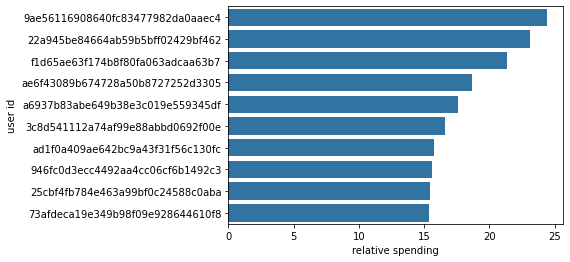

In [118]:
print_spending_statistics(df_user_income_spending, True, 10)

The top 5 customers spend between 17.6 and 24.4 permille of their income during 4.25 weeks. This equals to 21.5 and 29.3% per year.

------------------------
spending

                                user id    income  spending  relative spending
14826  3c8d541112a74af99e88abbd0692f00e   97000.0   1608.69          16.584433
13475  f1d65ae63f174b8f80fa063adcaa63b7   64000.0   1365.66          21.338438
10781  ae6f43089b674728a50b8727252d3305   71000.0   1327.74          18.700563
10652  626df8678e2a4953b9098246418c9cfa  103000.0   1321.42          12.829320
10309  73afdeca19e349b98f09e928644610f8   86000.0   1319.97          15.348488
13211  52959f19113e4241a8cb3bef486c6412  111000.0   1292.86          11.647387
10138  ad1f0a409ae642bc9a43f31f56c130fc   80000.0   1258.19          15.727375
2753   d240308de0ee4cf8bb6072816268582b   94000.0   1251.99          13.319043
16752  946fc0d3ecc4492aa4cc06cf6b1492c3   79000.0   1232.40          15.600000
3909   6406abad8e2c4b8584e4f68003de148d   79000.0   1211.76          15.338734


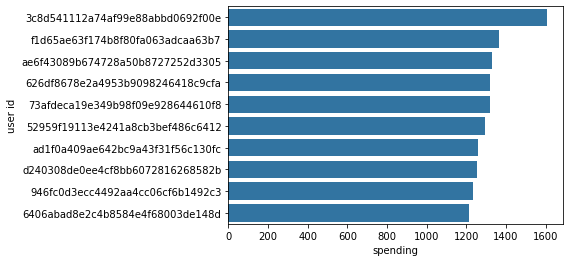

In [119]:
print_spending_statistics(df_user_income_spending, False, 10)

#### Spending VS Income
Is there a relationship between the income and the relative spending of a user?

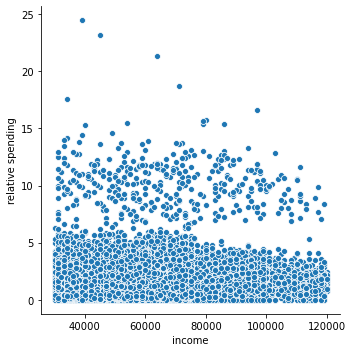

In [58]:
sb.relplot(x="income", y="relative spending", data=df_user_income_spending);

The scatter plot shows two bands of data points regarding the relative spending. The first band is below 6 permille and the second above 6 permille of relative spending.


 <= 6 permille 

count    14438.000000
mean       102.108655
std         83.851069
min          0.000000
25%         30.432500
50%         83.415000
75%        154.467500
max        608.430000
Name: spending, dtype: float64

 > 6 permille 

count     387.000000
mean      673.637313
std       258.395353
min       187.900000
25%       477.420000
50%       632.750000
75%       847.855000
max      1608.690000
Name: spending, dtype: float64


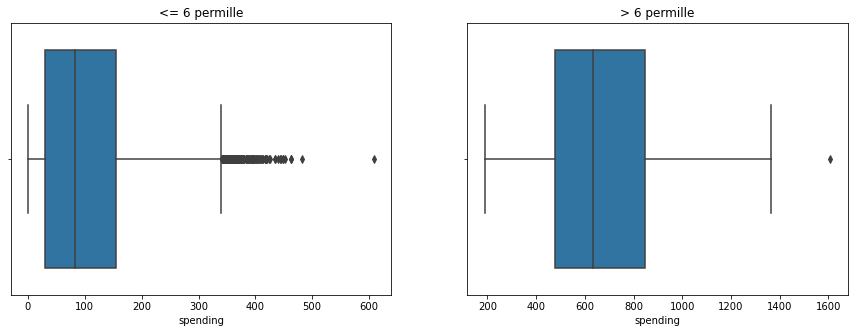

In [146]:
def print_spending_statistics_boxplot(df, ax, title):
    print("\n",title, "\n")
    print(df.describe())
    sb.boxplot(x=df, ax=ax);
    ax.set_title(title);


fig, axs = plt.subplots(ncols=2, sharex=False, figsize=(15, 5))
print_spending_statistics_boxplot(df_user_income_spending[df_user_income_spending["relative spending"]<=6]["spending"],
                                 axs[0], "<= 6 permille")
print_spending_statistics_boxplot(df_user_income_spending[df_user_income_spending["relative spending"]>6]["spending"],
                                 axs[1], "> 6 permille")

The band below 6 permille relative spending has a 
* mean at 102
* the 6 permille does not separate the relative income perfectly at an income < 80k. This is the cause for the outliers.

Band 2 > 6 permille has a
* mean at 673
* most outliers are those with a relative spending > 16 permille (see output of `print_spending_statistics(df_user_income_spending, True, 10)` above)

#### Spending VS Gender
Next, let's compare spending depending on *gender*.

gender
F    140.919400
M     99.586381
O    124.323302
Name: spending, dtype: float64


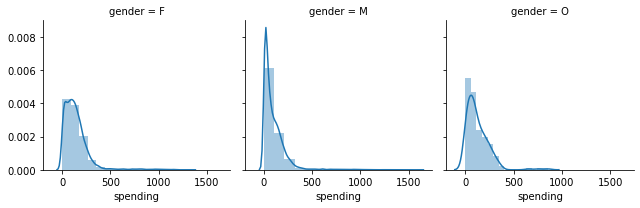

In [155]:
print(df_user_income_spending.groupby('gender')['spending'].mean())

g = sb.FacetGrid(data = df_user_income_spending, col = 'gender');
g.map(sb.distplot, "spending", bins=15);


*Female* users tend to spend a bit more than *others*. And in turn, *others* tend to spend more than *males*.


#### Timeline

In this section I will:

1. create a DataFrame representing each issued offer as a timeline, 
2. assign transaction to the active offer, and determine if an offer was effective, ineffective, or ignored.

##### 1. Creating the Timeline

An offer timeline is comprised of a `user id`, `offer id` and three events of the types:

* `received`
* `viewed`
* `completed` (only for BOGO/discount offers)

To simplify the further analysis, I will append columns from the `profile` and `portfolio` DataFrame to the timelines.

In [62]:
def safe_list_access(lst, index, default):
    """
    Safely access a list at a given index. If this index ist out of bounds
    the default value will be returned.
    
    :param lst: list to be accessed safely
    :param index: index to be accessed
    :param default: default value to be returend if the index is out of bounds
    :return: value within the list or the default if the index is out of bounds
    """
    if len(lst) <= index or index < 0:
        return default
    return lst[index]

def get_event_time(df_user_offer_transcript, event):
    """
    Get all event times out of the given DataFrame.
    
    :param df_user_offer_transcript: DataFrame to extract the event times from.
    :param event: Event to be filtered 
    :return: Tuple containig the list of times at index 0 and the list of affected indicies at index 1.
    """
    df_time = df_user_offer_transcript[df_user_offer_transcript['event'] == event]['time']
    if df_time.shape[0] > 1:
        print("[!] {} {} {} {} times".format(
            user_id,
            event,
            offer_id,
            df_time.shape[0]
        ))

    time = ([], None)
    if df_time.shape[0] > 0:
        time = df_time.tolist(), df_time.index.tolist()
        
    return time

def align_offer_event_times(times_received, times_viewed, times_completed):
    """
    Allign the given lists of event times cronologically (received < viewed < completed)
    
    :param times_received: List of received times
    :param times_viewed: List of viewed times
    :param times_completed: List of completed times
    :return times_received: Aligned list of received times
    :return new_times_viewed: Aligned list of viewed times
    :return new_times_completed: Aligned list of completed times
    """
    times_received, times_viewed, c = times_received.copy(), times_viewed.copy(), times_completed.copy()
    times_received.sort(reverse=True)
    times_viewed.sort(reverse=True)
    times_completed.sort(reverse=True)
    
    new_times_viewed = [np.nan for elem in times_received]
    new_times_completed = new_times_viewed.copy()
    
    for j in range(0, len(times_received)):
        for val in times_viewed.copy():
            if val >= times_received[j]:
                new_times_viewed[j] = val
                times_viewed.remove(val)
        
        for val in times_completed.copy():
            if val >= times_received[j]:
                new_times_completed[j] = val
                times_completed.remove(val)
                
    times_received.reverse()
    new_times_viewed.reverse()
    new_times_completed.reverse()    
    return times_received, new_times_viewed, new_times_completed


def append_user_offer_timeline(transcript, user_id, offer_id, col_user_id, col_offer_id, col_time_received, col_time_viewed, col_time_completed, rows_to_drop):
    """
    Extract records of the given user and offer from the transcript, align received,
    viewed, completed events and append the data in the corresponding column.
    
    :param transcript: (in) Transcript DataFrame containing all the events
    :param user_id: (in) User id used as filter
    :param offer_id: (in) Offer id used as filter
    :param col_offer_id: (out) Column of offer ids filled by this function
    :param col_time_received: (out) Column of received times filled by this function
    :param col_time_viewed: (out) Column of viewed times filled by this function
    :param col_time_completed: (out) Column of completed times filled by this function
    :param rows_to_drop: (out) List of rows in the transcript DataFrame that got consumed by this function and are ready to be droped
    :return: The given transcript DataFrame
    """
    df_user_offer_transcript = transcript[(transcript['person'] == user_id) & (transcript['offer id'] == offer_id)]

    times_received, index_to_drop = get_event_time(df_user_offer_transcript, 'offer received')
    if index_to_drop != None:
        rows_to_drop.extend(index_to_drop)
    else:
        return transcript
        
    times_viewed, index_to_drop = get_event_time(df_user_offer_transcript, 'offer viewed')
    if index_to_drop != None: 
        rows_to_drop.extend(index_to_drop)
        
    times_completed, index_to_drop = get_event_time(df_user_offer_transcript, 'offer completed')
    if index_to_drop != None: 
        rows_to_drop.extend(index_to_drop)

    times_received, times_viewed, times_completed = align_offer_event_times(times_received, times_viewed, times_completed)
        
    for i in range(0, max([len(times_received), len(times_viewed), len(times_completed)])):
        time_received = safe_list_access(times_received, i, np.nan)
        time_viewed = safe_list_access(times_viewed, i, np.nan)
        time_completed = safe_list_access(times_completed, i, np.nan)
        
        col_user_id.append(user_id)
        col_offer_id.append(offer_id)
        col_time_received.append(time_received)
        col_time_viewed.append(time_viewed)
        col_time_completed.append(time_completed)

    return transcript
   
    
def join_timeline_with_profile_and_portfolio(df_timeline, df_profile, df_portfolio):
    """
    Join the Timeline DataFrame with the given Profile and Portfolio DataFrame on user id and offer id.
    
    :param df_timeline: The Timeline DataFrame
    :param df_profile: The Profile DataFrame
    :param df_portfolio: The Portfolio DataFrame
    :return: Timeline DataFrame with the other DataFrames joined
    """
    df = pd.merge(df_timeline, df_profile, left_on='user id', right_on='id',
             suffixes=('_timeline', '_profile'))
    del df['id']

    df = pd.merge(df, df_portfolio, left_on='offer id', right_on='id',
             suffixes=('_timeline', '_portfolio'))
    del df['id']
    
    return df


col_user_id = []
col_offer_id = []
col_time_received = []
col_time_viewed = []
col_time_completed = []

tmp_transcript = transcript.copy()
rows_to_drop = []
user_ids = profile['id'] 
for user_no, user_id in enumerate(user_ids):
    print("{} ({:7}/{:7} ~= {:7.5}%)".format(user_id, user_no+1, user_ids.shape[0], ((user_no+1)/user_ids.shape[0]*100)))
    for offer_id in portfolio['id']:
        tmp_transcript = append_user_offer_timeline(
            tmp_transcript, user_id, offer_id, 
            col_user_id, col_offer_id, col_time_received, col_time_viewed, col_time_completed, 
            rows_to_drop)    
    print()

tmp_transcript = tmp_transcript.drop(rows_to_drop)
print("Number of droped rows:", (transcript.shape[0]-tmp_transcript.shape[0]))


data = {'user id': col_user_id,
        'offer id': col_offer_id,
        'received': col_time_received,
        'viewed': col_time_viewed,
        'completed': col_time_completed}
df_timeline = pd.DataFrame(data)

df_timeline['time to complete'] = df_timeline['completed'] - df_timeline['received']
df_timeline['time to view'] = df_timeline['viewed'] - df_timeline['received']

df_timeline = join_timeline_with_profile_and_portfolio(
    df_timeline, 
    profile[['id', 'gender', 'age', 'age group', 'income']],
    portfolio[['id', 'duration', 'reward', 'difficulty', 'web', 'email', 'mobile', 'social', 'offer_type']])

df_timeline['number of channels'] = df_timeline[['email', 'web', 'mobile', 'social']].sum(axis=1)
df_timeline['valid till'] = df_timeline['received'] + df_timeline['duration'] * 24  # validity duration in portfolio has unit 'day's and event times are in 'hour's
    
    
print("tmp_transcript contains {} unused records".format(tmp_transcript.shape[0]))
print("Remaining events in tmp_transcript:")
print()
print(tmp_transcript['event'].value_counts())
print()
print("Created {} timeline(s)".format(df_timeline.shape[0]))

print()
print("Saving df_timeline ...")
with open(FILENAME_DF_TIMELINE, 'wb') as f:
    pickle.dump(df_timeline, f, pickle.HIGHEST_PROTOCOL)

print("Saving tmp_transcript ...")
with open(FILENAME_TMP_TRANSCRIPT, 'wb') as f:
    pickle.dump(tmp_transcript, f, pickle.HIGHEST_PROTOCOL)

df_timeline.head()

68be06ca386d4c31939f3a4f0e3dd783 (      1/  17000 ~= 0.0058824%)
[!] 68be06ca386d4c31939f3a4f0e3dd783 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 68be06ca386d4c31939f3a4f0e3dd783 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

0610b486422d4921ae7d2bf64640c50b (      2/  17000 ~= 0.011765%)

38fe809add3b4fcf9315a9694bb96ff5 (      3/  17000 ~= 0.017647%)

78afa995795e4d85b5d9ceeca43f5fef (      4/  17000 ~= 0.023529%)

a03223e636434f42ac4c3df47e8bac43 (      5/  17000 ~= 0.029412%)
[!] a03223e636434f42ac4c3df47e8bac43 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] a03223e636434f42ac4c3df47e8bac43 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

e2127556f4f64592b11af22de27a7932 (      6/  17000 ~= 0.035294%)

8ec6ce2a7e7949b1bf142def7d0e0586 (      7/  17000 ~= 0.041176%)
[!] 8ec6ce2a7e7949b1bf142def7d0e0586 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 8ec6ce2a7e7949b1bf142def7d0e0586 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2


6e014185620b49bd98749f728747572f (     41/  17000 ~= 0.24118%)
[!] 6e014185620b49bd98749f728747572f offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6e014185620b49bd98749f728747572f offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

02c083884c7d45b39cc68e1314fec56c (     42/  17000 ~= 0.24706%)

c0d210398dee4a0895b24444a5fcd1d2 (     43/  17000 ~= 0.25294%)
[!] c0d210398dee4a0895b24444a5fcd1d2 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] c0d210398dee4a0895b24444a5fcd1d2 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

8b70ca1f5f5a45bdac2ac2f990b71526 (     44/  17000 ~= 0.25882%)

5b8f1f0e0930464f93bb55e59b5a04e0 (     45/  17000 ~= 0.26471%)
[!] 5b8f1f0e0930464f93bb55e59b5a04e0 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5b8f1f0e0930464f93bb55e59b5a04e0 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8be4463721e14d7fa600686bf8c8b2ed (     46/  17000 ~= 0.27059%)
[!] 8be4463721e14d7fa600686bf8c8b2ed offer received 0b1e1539f


2c5c63e5124e417b8504f76c868a4190 (     87/  17000 ~= 0.51176%)
[!] 2c5c63e5124e417b8504f76c868a4190 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 2c5c63e5124e417b8504f76c868a4190 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 2c5c63e5124e417b8504f76c868a4190 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

9d6da0a2ac54474e8ec986fd21cecef0 (     88/  17000 ~= 0.51765%)

571b739ada3041fb8fbd20f23ce034f7 (     89/  17000 ~= 0.52353%)
[!] 571b739ada3041fb8fbd20f23ce034f7 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 571b739ada3041fb8fbd20f23ce034f7 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 571b739ada3041fb8fbd20f23ce034f7 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 571b739ada3041fb8fbd20f23ce034f7 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 571b739ada3041fb8fbd20f23ce034f7 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

816afd4505d047cf893275fbfe825590 (     90/  17000 ~= 0.52941%)
[!] 


1a353048b0884fc5a0afa27677ef1e80 (    121/  17000 ~= 0.71176%)
[!] 1a353048b0884fc5a0afa27677ef1e80 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 1a353048b0884fc5a0afa27677ef1e80 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 1a353048b0884fc5a0afa27677ef1e80 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1a353048b0884fc5a0afa27677ef1e80 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

c099206f76b1414db7552f163520053c (    122/  17000 ~= 0.71765%)

e6d3eebb535e44aca1323edde5c346fa (    123/  17000 ~= 0.72353%)
[!] e6d3eebb535e44aca1323edde5c346fa offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e6d3eebb535e44aca1323edde5c346fa offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

2cf5895bddf9467e878c6d51a622d5fb (    124/  17000 ~= 0.72941%)

6747dda08bed46298c23e05b64820a3a (    125/  17000 ~= 0.73529%)
[!] 6747dda08bed46298c23e05b64820a3a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 6747dda08bed46298c23e05b64820a3

[!] 50b92ea51e2649dfbf7120d5e554e991 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 50b92ea51e2649dfbf7120d5e554e991 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

21b02228cd4441b49bf0b5ff046f4b75 (    174/  17000 ~=  1.0235%)

629fc02d56414d91bca360decdfa9288 (    175/  17000 ~=  1.0294%)
[!] 629fc02d56414d91bca360decdfa9288 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 629fc02d56414d91bca360decdfa9288 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 629fc02d56414d91bca360decdfa9288 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 629fc02d56414d91bca360decdfa9288 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

41f9e7e0d8c644bb8b3f9c3a8699dc53 (    176/  17000 ~=  1.0353%)

c87b50fcdd4a4d2faacff6112243a8dd (    177/  17000 ~=  1.0412%)
[!] c87b50fcdd4a4d2faacff6112243a8dd offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] c87b50fcdd4a4d2faacff6112243a8dd offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] c87b


ad3c443c9ce34aa38929b0a84cb14c04 (    219/  17000 ~=  1.2882%)

688e4f2487d44ad8bbcc0f96936f42d6 (    220/  17000 ~=  1.2941%)
[!] 688e4f2487d44ad8bbcc0f96936f42d6 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

73c157a4b8e342fcb5d8479d8cb41e81 (    221/  17000 ~=     1.3%)
[!] 73c157a4b8e342fcb5d8479d8cb41e81 offer received 3f207df678b143eea3cee63160fa8bed 2 times

82d57bf7f37a4b37aff9e7bd293be8bc (    222/  17000 ~=  1.3059%)
[!] 82d57bf7f37a4b37aff9e7bd293be8bc offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

e737ff591120415581ddbe817b8c82ca (    223/  17000 ~=  1.3118%)

9cb34ff9de694c578154da3efc9915db (    224/  17000 ~=  1.3176%)

32189735a963491082e35dd4c3221690 (    225/  17000 ~=  1.3235%)

4e5923e5deab4d5cb1624a0b1cc9909c (    226/  17000 ~=  1.3294%)
[!] 4e5923e5deab4d5cb1624a0b1cc9909c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4e5923e5deab4d5cb1624a0b1cc9909c offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4e5923e5deab4d5cb1624


5ceb90c4e738427f90cd7b16d51c59bc (    264/  17000 ~=  1.5529%)

23bc15e276d247669fd7d1c08a8fb678 (    265/  17000 ~=  1.5588%)
[!] 23bc15e276d247669fd7d1c08a8fb678 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 23bc15e276d247669fd7d1c08a8fb678 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 23bc15e276d247669fd7d1c08a8fb678 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

da6c95e567f94dfdb54c16073807fcfe (    266/  17000 ~=  1.5647%)
[!] da6c95e567f94dfdb54c16073807fcfe offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] da6c95e567f94dfdb54c16073807fcfe offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

fae3fbe975cc4421b853947d7448904e (    267/  17000 ~=  1.5706%)
[!] fae3fbe975cc4421b853947d7448904e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] fae3fbe975cc4421b853947d7448904e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] fae3fbe975cc4421b853947d7448904e offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[


bd215efd787d4305a006a56154fbcb67 (    304/  17000 ~=  1.7882%)
[!] bd215efd787d4305a006a56154fbcb67 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] bd215efd787d4305a006a56154fbcb67 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

f5e59835627a49a0b13c4183522225d4 (    305/  17000 ~=  1.7941%)

f970eafddcb34154aa4d646b4a71ca34 (    306/  17000 ~=     1.8%)

c4a3c86c7b5541cf83d443c2a89e5b5a (    307/  17000 ~=  1.8059%)

4bbcb71a7f75455e9957413cf743fef7 (    308/  17000 ~=  1.8118%)

9ef935700f384fefa0e1a34f92555abd (    309/  17000 ~=  1.8176%)
[!] 9ef935700f384fefa0e1a34f92555abd offer received 2906b810c7d4411798c6938adc9daaa5 2 times

32fbf97e89274e8a935903f2ad095e1f (    310/  17000 ~=  1.8235%)
[!] 32fbf97e89274e8a935903f2ad095e1f offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 32fbf97e89274e8a935903f2ad095e1f offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 32fbf97e89274e8a935903f2ad095e1f offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 tim

[!] 02d206df55d54efda515783e1c525e8d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

acc3bb69130c45aca141e8aa86f41b42 (    350/  17000 ~=  2.0588%)
[!] acc3bb69130c45aca141e8aa86f41b42 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] acc3bb69130c45aca141e8aa86f41b42 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

8899cbcaf33d4e4d87a3f761b5ff8cf2 (    351/  17000 ~=  2.0647%)

02b148f44eee4b9ca7487371472a6781 (    352/  17000 ~=  2.0706%)

cdc70ea5dcfa497bb0c53b3fc20f3691 (    353/  17000 ~=  2.0765%)
[!] cdc70ea5dcfa497bb0c53b3fc20f3691 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] cdc70ea5dcfa497bb0c53b3fc20f3691 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] cdc70ea5dcfa497bb0c53b3fc20f3691 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cdc70ea5dcfa497bb0c53b3fc20f3691 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

cda87c53c8434854b78be68c0cde4848 (    354/  17000 ~=  2.0824%)
[!] cda87c53c8434854b78be68c0cde484


4cbe33c601a5407f8202086565c55111 (    393/  17000 ~=  2.3118%)

55bbada9ec754b9493ba8da9f1704331 (    394/  17000 ~=  2.3176%)
[!] 55bbada9ec754b9493ba8da9f1704331 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

63682fd0e2454fe098a3aad2c76e0054 (    395/  17000 ~=  2.3235%)
[!] 63682fd0e2454fe098a3aad2c76e0054 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 63682fd0e2454fe098a3aad2c76e0054 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

85727ebd2e324b60839c149682294ba7 (    396/  17000 ~=  2.3294%)

4cce01bbc3d742c994f654f8c1ecd6b4 (    397/  17000 ~=  2.3353%)

b330ad2e97ca455badff7121614b225d (    398/  17000 ~=  2.3412%)
[!] b330ad2e97ca455badff7121614b225d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b330ad2e97ca455badff7121614b225d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b330ad2e97ca455badff7121614b225d offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

611846bccd6b4c35ba48ed6b165b2c2d (    399/  17000 ~=  2.3


8b5f5a1b1c43427ba7fb1e8e307a05e3 (    442/  17000 ~=     2.6%)
[!] 8b5f5a1b1c43427ba7fb1e8e307a05e3 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 8b5f5a1b1c43427ba7fb1e8e307a05e3 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

055a06b9a6ad42fcaa1fe7706b5e21aa (    443/  17000 ~=  2.6059%)
[!] 055a06b9a6ad42fcaa1fe7706b5e21aa offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 055a06b9a6ad42fcaa1fe7706b5e21aa offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 055a06b9a6ad42fcaa1fe7706b5e21aa offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

fc41f98eaccc4c6e9ba3d3361714c527 (    444/  17000 ~=  2.6118%)

3f244f4dea654688ace14acb4f0257bb (    445/  17000 ~=  2.6176%)

05dedca5b2034055a64979a2c28b3477 (    446/  17000 ~=  2.6235%)

93893ec00b5346228088f867e6164b1e (    447/  17000 ~=  2.6294%)
[!] 93893ec00b5346228088f867e6164b1e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 93893ec00b5346228088f867e6164b1e offer viewed fafdcd668e37


854128de8f934c7ab4c967829fe53711 (    489/  17000 ~=  2.8765%)
[!] 854128de8f934c7ab4c967829fe53711 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 854128de8f934c7ab4c967829fe53711 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

18b8be9637384abe9d13e30a8e00c33d (    490/  17000 ~=  2.8824%)
[!] 18b8be9637384abe9d13e30a8e00c33d offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 18b8be9637384abe9d13e30a8e00c33d offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

ca85d857e3804e97a4aaf4bd64c75237 (    491/  17000 ~=  2.8882%)

989e7b86a4f54af1b550970806313851 (    492/  17000 ~=  2.8941%)

319abe74a62949209cb8a5531f89b3fd (    493/  17000 ~=     2.9%)
[!] 319abe74a62949209cb8a5531f89b3fd offer received 2906b810c7d4411798c6938adc9daaa5 3 times

f9aacdb4fa954446a6f1ea22ecd7b961 (    494/  17000 ~=  2.9059%)
[!] f9aacdb4fa954446a6f1ea22ecd7b961 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f9aacdb4fa954446a6f1ea22ecd7b961 offer received 2906b810c7


662f3247f37c4ae7a2abb8f6e266a633 (    529/  17000 ~=  3.1118%)

e296bfe8daed4c889800d3765c2d5d75 (    530/  17000 ~=  3.1176%)
[!] e296bfe8daed4c889800d3765c2d5d75 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

00bbce6533f44ddeaf4dd32bcab55441 (    531/  17000 ~=  3.1235%)

e54b14de96bb4166bf1db3919de76f1b (    532/  17000 ~=  3.1294%)
[!] e54b14de96bb4166bf1db3919de76f1b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e54b14de96bb4166bf1db3919de76f1b offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e54b14de96bb4166bf1db3919de76f1b offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

c75b0d5cf82a494b970d0d6d4445ffa0 (    533/  17000 ~=  3.1353%)

40ca4949bc5d4567b2521ce9a1ddd6e8 (    534/  17000 ~=  3.1412%)

3d63a807a77c4a5686a7515f65bb86a6 (    535/  17000 ~=  3.1471%)

4acdbe18bbbc467b804ca376ac74e0a1 (    536/  17000 ~=  3.1529%)

ae2f9e0ed70f4f3b8667ae2ce7e7e15d (    537/  17000 ~=  3.1588%)
[!] ae2f9e0ed70f4f3b8667ae2ce7e7e15d offer received a


6ec36134940f43aeb43cffa2011a6d26 (    567/  17000 ~=  3.3353%)
[!] 6ec36134940f43aeb43cffa2011a6d26 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 6ec36134940f43aeb43cffa2011a6d26 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 6ec36134940f43aeb43cffa2011a6d26 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6ec36134940f43aeb43cffa2011a6d26 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

d791a7a91a0343c4885594c348211fb2 (    568/  17000 ~=  3.3412%)
[!] d791a7a91a0343c4885594c348211fb2 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] d791a7a91a0343c4885594c348211fb2 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

461e13a14a074077b3ebd7ad0174e02b (    569/  17000 ~=  3.3471%)

dbb4766b7dd94ca2b83a855312a3ebe9 (    570/  17000 ~=  3.3529%)

0b86e2ad1f2140db8dc4db1b71e1e73a (    571/  17000 ~=  3.3588%)

440244d2fe344c3c99478e7aefc1facd (    572/  17000 ~=  3.3647%)
[!] 440244d2fe344c3c99478e7aefc1facd offer received 4d5c57ea9

[!] 11d7a9296e35432f8a34b21e337529fb offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

59a12422f837467894ff33fafbc01d70 (    609/  17000 ~=  3.5824%)
[!] 59a12422f837467894ff33fafbc01d70 offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] 59a12422f837467894ff33fafbc01d70 offer viewed 2906b810c7d4411798c6938adc9daaa5 3 times

149f67791ca9431bb9c27f9f59a4435a (    610/  17000 ~=  3.5882%)
[!] 149f67791ca9431bb9c27f9f59a4435a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 149f67791ca9431bb9c27f9f59a4435a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

af44c9f11887442aabb07c86e31be442 (    611/  17000 ~=  3.5941%)
[!] af44c9f11887442aabb07c86e31be442 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] af44c9f11887442aabb07c86e31be442 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] af44c9f11887442aabb07c86e31be442 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] af44c9f11887442aabb07c86e31be442 offer received 3f207df678b143eea


89cf536cbae74755a29d55a89ed175b9 (    646/  17000 ~=     3.8%)
[!] 89cf536cbae74755a29d55a89ed175b9 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 89cf536cbae74755a29d55a89ed175b9 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 89cf536cbae74755a29d55a89ed175b9 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

e58ffa65111b459c9d6d98b0e137d4b7 (    647/  17000 ~=  3.8059%)
[!] e58ffa65111b459c9d6d98b0e137d4b7 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e58ffa65111b459c9d6d98b0e137d4b7 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e58ffa65111b459c9d6d98b0e137d4b7 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5a89bd9fa2374a81bba2373dee6ffbc9 (    648/  17000 ~=  3.8118%)
[!] 5a89bd9fa2374a81bba2373dee6ffbc9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5a89bd9fa2374a81bba2373dee6ffbc9 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5a89bd9fa2374a81bba2373dee6ffbc9 offer completed 0b1e1539f2cc45b


fe083566dce34c52a6e9d8cfd87239e4 (    686/  17000 ~=  4.0353%)

c1e4888e931740838f7ef3bbd04a114c (    687/  17000 ~=  4.0412%)

1f72799b1a53458f9615837f6c7eaddd (    688/  17000 ~=  4.0471%)

b728608c644a45f4a280139048dd7c14 (    689/  17000 ~=  4.0529%)
[!] b728608c644a45f4a280139048dd7c14 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b728608c644a45f4a280139048dd7c14 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b728608c644a45f4a280139048dd7c14 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

70f115dc7bf84a2ca3b1481639590f2b (    690/  17000 ~=  4.0588%)
[!] 70f115dc7bf84a2ca3b1481639590f2b offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 70f115dc7bf84a2ca3b1481639590f2b offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] 70f115dc7bf84a2ca3b1481639590f2b offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 70f115dc7bf84a2ca3b1481639590f2b offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

78de990355734b7285eb503c012b47

[!] 3992a086bf2646ddae7821ed3e9424a3 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3992a086bf2646ddae7821ed3e9424a3 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

d34af41fdf2a4ca2a68dc6991d5a8059 (    725/  17000 ~=  4.2647%)

bed9fd6cebd64367a9198990c097477f (    726/  17000 ~=  4.2706%)

9f2bbc9d8b65448aab330a6059292679 (    727/  17000 ~=  4.2765%)
[!] 9f2bbc9d8b65448aab330a6059292679 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times

a1c72a010c5746f28251ae4267816025 (    728/  17000 ~=  4.2824%)
[!] a1c72a010c5746f28251ae4267816025 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a1c72a010c5746f28251ae4267816025 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

b925f853e90442d99f203e12e899999b (    729/  17000 ~=  4.2882%)
[!] b925f853e90442d99f203e12e899999b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e199fdec031441fb9f1295eb7952be69 (    730/  17000 ~=  4.2941%)
[!] e199fdec031441fb9f1295eb7952be69 offer received fafdcd668e


a190c39429ab4e43a0f2da102f98a045 (    764/  17000 ~=  4.4941%)

ed46fca6de7042478b411690878dc069 (    765/  17000 ~=     4.5%)
[!] ed46fca6de7042478b411690878dc069 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

4ff9be4a461b4130ae28887591c15915 (    766/  17000 ~=  4.5059%)
[!] 4ff9be4a461b4130ae28887591c15915 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4ff9be4a461b4130ae28887591c15915 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

e3b7b36ebe7d4ebf9a288599941cf9f6 (    767/  17000 ~=  4.5118%)

ac3d62b70d7b4cb7ab931cd7c8c6f08b (    768/  17000 ~=  4.5176%)
[!] ac3d62b70d7b4cb7ab931cd7c8c6f08b offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] ac3d62b70d7b4cb7ab931cd7c8c6f08b offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

40399df768594afaa13aaca0b273608d (    769/  17000 ~=  4.5235%)
[!] 40399df768594afaa13aaca0b273608d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 40399df768594afaa13aaca0b273608d offer viewed f19421c1d4aa


807199e7716f4d78974416f917582b78 (    801/  17000 ~=  4.7118%)

4ad3748475204cf99571183f05b5e2f7 (    802/  17000 ~=  4.7176%)

e6678c42a1064450814bd0818a95a76b (    803/  17000 ~=  4.7235%)
[!] e6678c42a1064450814bd0818a95a76b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e6678c42a1064450814bd0818a95a76b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

dd31ce6c87d34180ba57901368e03b33 (    804/  17000 ~=  4.7294%)
[!] dd31ce6c87d34180ba57901368e03b33 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] dd31ce6c87d34180ba57901368e03b33 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

7ac5250da1b746e6b56a9e6d8a7b3fd4 (    805/  17000 ~=  4.7353%)

cc1891e307dd48f49bdb894ede98f8a6 (    806/  17000 ~=  4.7412%)

08e66f9936c545d4aedf21d35b96baf6 (    807/  17000 ~=  4.7471%)
[!] 08e66f9936c545d4aedf21d35b96baf6 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 08e66f9936c545d4aedf21d35b96baf6 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times



8af6963021ce40e78a2281e17fb186f7 (    847/  17000 ~=  4.9824%)
[!] 8af6963021ce40e78a2281e17fb186f7 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 8af6963021ce40e78a2281e17fb186f7 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 8af6963021ce40e78a2281e17fb186f7 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 8af6963021ce40e78a2281e17fb186f7 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

0d219e744675450583b6981e39306587 (    848/  17000 ~=  4.9882%)

d5b95f202e124df58084c57724b3007f (    849/  17000 ~=  4.9941%)
[!] d5b95f202e124df58084c57724b3007f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] d5b95f202e124df58084c57724b3007f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3a1747f3e741449387bb614da8e0171c (    850/  17000 ~=     5.0%)
[!] 3a1747f3e741449387bb614da8e0171c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3a1747f3e741449387bb614da8e0171c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

4c55


0d96a963d3e94044aa7934276db005e4 (    890/  17000 ~=  5.2353%)
[!] 0d96a963d3e94044aa7934276db005e4 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 0d96a963d3e94044aa7934276db005e4 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

754876debbb94994a6c4e45510eeb124 (    891/  17000 ~=  5.2412%)

58b96ca152d946e98090e277a183e08f (    892/  17000 ~=  5.2471%)

bc417f2f6ba74dddba8c0502a0ddc89e (    893/  17000 ~=  5.2529%)

b93ca45ff1c14f5cacad3c011e1e7fe3 (    894/  17000 ~=  5.2588%)
[!] b93ca45ff1c14f5cacad3c011e1e7fe3 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b93ca45ff1c14f5cacad3c011e1e7fe3 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

8a0ec2e1e3ea44ba8eaea09e516e1fef (    895/  17000 ~=  5.2647%)
[!] 8a0ec2e1e3ea44ba8eaea09e516e1fef offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8a0ec2e1e3ea44ba8eaea09e516e1fef offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 8a0ec2e1e3ea44ba8eaea09e516e1fef offer completed 2906b810c


393833837038441aa4eb172c1220ad2a (    931/  17000 ~=  5.4765%)
[!] 393833837038441aa4eb172c1220ad2a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 393833837038441aa4eb172c1220ad2a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 393833837038441aa4eb172c1220ad2a offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

9f80078fe2a04c74a91bacf3ed9ae8f9 (    932/  17000 ~=  5.4824%)

7f26bb62f8f346f2804f1394b92f85c8 (    933/  17000 ~=  5.4882%)

fb4d977017f24913a9602692fc881b2e (    934/  17000 ~=  5.4941%)

b5c5091888604fefb1219e5fa0aece97 (    935/  17000 ~=     5.5%)
[!] b5c5091888604fefb1219e5fa0aece97 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] b5c5091888604fefb1219e5fa0aece97 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

8d91f3193485407383ab8aefb1aaf830 (    936/  17000 ~=  5.5059%)
[!] 8d91f3193485407383ab8aefb1aaf830 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

d0c9c4785bf34d839b31485a37bf25ca (    937/  17000 ~=  5.5118


a2ffc22184d94d6fa21b924eb49c0d06 (    976/  17000 ~=  5.7412%)
[!] a2ffc22184d94d6fa21b924eb49c0d06 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a2ffc22184d94d6fa21b924eb49c0d06 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a2ffc22184d94d6fa21b924eb49c0d06 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

4005b2a20d104eba881cb73a75dac3d8 (    977/  17000 ~=  5.7471%)

f5112242df984403bfb4176d4487aef3 (    978/  17000 ~=  5.7529%)

6f4665ef722b42fcaf867479445d9d2d (    979/  17000 ~=  5.7588%)
[!] 6f4665ef722b42fcaf867479445d9d2d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6f4665ef722b42fcaf867479445d9d2d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2ddc7d63c32d4606a7a45e3e70439b44 (    980/  17000 ~=  5.7647%)
[!] 2ddc7d63c32d4606a7a45e3e70439b44 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2ddc7d63c32d4606a7a45e3e70439b44 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2ddc7d63c32d4606a7a45e3e704


fbd7bb82f4284846b38bffe314f61b67 (   1015/  17000 ~=  5.9706%)
[!] fbd7bb82f4284846b38bffe314f61b67 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] fbd7bb82f4284846b38bffe314f61b67 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] fbd7bb82f4284846b38bffe314f61b67 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] fbd7bb82f4284846b38bffe314f61b67 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] fbd7bb82f4284846b38bffe314f61b67 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

00c5a385c71a4d3db5e9b4e31e430943 (   1016/  17000 ~=  5.9765%)

00b901d68f8f4fd68075184cd0f772d2 (   1017/  17000 ~=  5.9824%)
[!] 00b901d68f8f4fd68075184cd0f772d2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 00b901d68f8f4fd68075184cd0f772d2 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

eb96c54abda74fa5862e03662b0953ed (   1018/  17000 ~=  5.9882%)
[!] eb96c54abda74fa5862e03662b0953ed offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e


bd7b13b7520b4bd1aed39c026ebb9116 (   1060/  17000 ~=  6.2353%)
[!] bd7b13b7520b4bd1aed39c026ebb9116 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] bd7b13b7520b4bd1aed39c026ebb9116 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] bd7b13b7520b4bd1aed39c026ebb9116 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e0570660882b49db860b43f704e5590b (   1061/  17000 ~=  6.2412%)
[!] e0570660882b49db860b43f704e5590b offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e0570660882b49db860b43f704e5590b offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e0570660882b49db860b43f704e5590b offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e0570660882b49db860b43f704e5590b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e0570660882b49db860b43f704e5590b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

b1a57282575b473b9d16c8b93057529b (   1062/  17000 ~=  6.2471%)
[!] b1a57282575b473b9d16c8b93057529b offer received 9b98b8c7a33c4b65


0ec49da4a6d54229ad3c450cba7701f4 (   1100/  17000 ~=  6.4706%)
[!] 0ec49da4a6d54229ad3c450cba7701f4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0ec49da4a6d54229ad3c450cba7701f4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0ec49da4a6d54229ad3c450cba7701f4 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

a5f8feec3c8a4581b28ae0ed0664926c (   1101/  17000 ~=  6.4765%)
[!] a5f8feec3c8a4581b28ae0ed0664926c offer received 2906b810c7d4411798c6938adc9daaa5 2 times

12437b2c02be4105aec2d09db79c3c21 (   1102/  17000 ~=  6.4824%)
[!] 12437b2c02be4105aec2d09db79c3c21 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 12437b2c02be4105aec2d09db79c3c21 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

2fca63280f1d4bc2800844dc3a20023f (   1103/  17000 ~=  6.4882%)

087339125d104a39bdf4e6e18be64ece (   1104/  17000 ~=  6.4941%)
[!] 087339125d104a39bdf4e6e18be64ece offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 087339125d104a39bdf4e6e18be6

[!] d034e28ea9f846e497eac1f24eee7fe0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] d034e28ea9f846e497eac1f24eee7fe0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

e4a3ed93b6a54f5cb3b50da3435e0ae1 (   1143/  17000 ~=  6.7235%)

d4a1f79859224f558228bda4029c4816 (   1144/  17000 ~=  6.7294%)

fc543a5400c742f39aff9b7d654227e4 (   1145/  17000 ~=  6.7353%)

4d87aabb26bd45a9acdaec688cac7e20 (   1146/  17000 ~=  6.7412%)
[!] 4d87aabb26bd45a9acdaec688cac7e20 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4d87aabb26bd45a9acdaec688cac7e20 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4d87aabb26bd45a9acdaec688cac7e20 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

1b52491afe674078990ce237da344fb2 (   1147/  17000 ~=  6.7471%)
[!] 1b52491afe674078990ce237da344fb2 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1b52491afe674078990ce237da344fb2 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

554e8f98231e467e9c8809de0d6de4


e6697e5f58354ce891d5a6852c33d459 (   1188/  17000 ~=  6.9882%)
[!] e6697e5f58354ce891d5a6852c33d459 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e6697e5f58354ce891d5a6852c33d459 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e6697e5f58354ce891d5a6852c33d459 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

8e8c022a3b034c139b5f34f5dfa0fbad (   1189/  17000 ~=  6.9941%)

35f39fb3476249988ddc964f24e41edc (   1190/  17000 ~=     7.0%)
[!] 35f39fb3476249988ddc964f24e41edc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

71f3c9ba5cc14787b931f16542e07733 (   1191/  17000 ~=  7.0059%)

709a73a7b8e941c097c51211da03ee8d (   1192/  17000 ~=  7.0118%)

b97fba3eb0c0486aa2805797833c4c2b (   1193/  17000 ~=  7.0176%)

b75e7be20e764e0096eb5204b4490169 (   1194/  17000 ~=  7.0235%)
[!] b75e7be20e764e0096eb5204b4490169 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] b75e7be20e764e0096eb5204b4490169 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 tim


a1b42659653a462ba62fed071e1f4284 (   1231/  17000 ~=  7.2412%)

d80211f9f5ff46408d55adee3727aff3 (   1232/  17000 ~=  7.2471%)
[!] d80211f9f5ff46408d55adee3727aff3 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

28c0952297a3447f9a067d65469270b3 (   1233/  17000 ~=  7.2529%)

cd548ef6e88b4b78844ead60c8c628c5 (   1234/  17000 ~=  7.2588%)

548282598f884537b30d6c2cd3173df6 (   1235/  17000 ~=  7.2647%)

c24f88fc54444d67ad961d2c43244644 (   1236/  17000 ~=  7.2706%)
[!] c24f88fc54444d67ad961d2c43244644 offer received 3f207df678b143eea3cee63160fa8bed 2 times

7b9d17a806b840ea9ca60c4fc83d9a9f (   1237/  17000 ~=  7.2765%)
[!] 7b9d17a806b840ea9ca60c4fc83d9a9f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7b9d17a806b840ea9ca60c4fc83d9a9f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7b9d17a806b840ea9ca60c4fc83d9a9f offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7b9d17a806b840ea9ca60c4fc83d9a9f offer received 2906b810c7d4411798c6938adc9daaa5 2 t

[!] 4b026d0cd4584db1ac8dca47598aa196 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 4b026d0cd4584db1ac8dca47598aa196 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

454f568904744e3b9ac0d3049c07da0e (   1279/  17000 ~=  7.5235%)
[!] 454f568904744e3b9ac0d3049c07da0e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 454f568904744e3b9ac0d3049c07da0e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 454f568904744e3b9ac0d3049c07da0e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 454f568904744e3b9ac0d3049c07da0e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 454f568904744e3b9ac0d3049c07da0e offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

ecd3afe895454a42867d70f0f4be7015 (   1280/  17000 ~=  7.5294%)
[!] ecd3afe895454a42867d70f0f4be7015 offer received 3f207df678b143eea3cee63160fa8bed 2 times

862c3631c8ab452791168d54be0a8823 (   1281/  17000 ~=  7.5353%)

88a5c73f15144c5fae93006b818adb79 (   1282/  17000 ~=  7.5412%)
[!] 8


a28dfcb188604156b79e997bfeb07d4f (   1328/  17000 ~=  7.8118%)
[!] a28dfcb188604156b79e997bfeb07d4f offer received 3f207df678b143eea3cee63160fa8bed 2 times

2e15fd08e3864682a76c7e81e12e7c3a (   1329/  17000 ~=  7.8176%)
[!] 2e15fd08e3864682a76c7e81e12e7c3a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2e15fd08e3864682a76c7e81e12e7c3a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2e15fd08e3864682a76c7e81e12e7c3a offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

79526521cf4e4f45ad218c7ce25409f3 (   1330/  17000 ~=  7.8235%)

eab78e2cf26f4af494d9535ac3835f00 (   1331/  17000 ~=  7.8294%)
[!] eab78e2cf26f4af494d9535ac3835f00 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] eab78e2cf26f4af494d9535ac3835f00 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] eab78e2cf26f4af494d9535ac3835f00 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] eab78e2cf26f4af494d9535ac3835f00 offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!


f656b5959a8b427782abb0888331eb5d (   1364/  17000 ~=  8.0235%)
[!] f656b5959a8b427782abb0888331eb5d offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f656b5959a8b427782abb0888331eb5d offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f656b5959a8b427782abb0888331eb5d offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

eb3ada86b4e3441b94d53427aa0d9eed (   1365/  17000 ~=  8.0294%)
[!] eb3ada86b4e3441b94d53427aa0d9eed offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] eb3ada86b4e3441b94d53427aa0d9eed offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

3ad56441bfc14636832f038a2d52419e (   1366/  17000 ~=  8.0353%)
[!] 3ad56441bfc14636832f038a2d52419e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 3ad56441bfc14636832f038a2d52419e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 3ad56441bfc14636832f038a2d52419e offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

7bd149ccf9af497fa01366cf2237f568 (   1367/  17000 ~=  8.0412%)
[!] 


1b414e7bd29e48e28eeb12d681a0cad4 (   1412/  17000 ~=  8.3059%)
[!] 1b414e7bd29e48e28eeb12d681a0cad4 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

86e9bda5c9ef4d70a54dc708266dafe2 (   1413/  17000 ~=  8.3118%)

7a9aaff7143a487084111ccd2c54f448 (   1414/  17000 ~=  8.3176%)
[!] 7a9aaff7143a487084111ccd2c54f448 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7a9aaff7143a487084111ccd2c54f448 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7a9aaff7143a487084111ccd2c54f448 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

501b5637836047bfba730b7cb27d3f70 (   1415/  17000 ~=  8.3235%)
[!] 501b5637836047bfba730b7cb27d3f70 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 501b5637836047bfba730b7cb27d3f70 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

bea39bf06adf4610b588deaba0bd791c (   1416/  17000 ~=  8.3294%)
[!] bea39bf06adf4610b588deaba0bd791c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] bea39bf06adf4610b588deaba0bd


e95e8899562f4cad8d53ed81367af82a (   1449/  17000 ~=  8.5235%)

e89343c8b43040e1a55945cd6cba387f (   1450/  17000 ~=  8.5294%)

eeac54fc267c42838fb3e030b38a309e (   1451/  17000 ~=  8.5353%)

baec6fd421ca41948585242e20df9852 (   1452/  17000 ~=  8.5412%)

481bcb3261a548bdb59df61d5e2a9ce3 (   1453/  17000 ~=  8.5471%)

e2fde1e26e474422b36954f98454795d (   1454/  17000 ~=  8.5529%)

2520b80ef6024377adb7d8fb5691160e (   1455/  17000 ~=  8.5588%)
[!] 2520b80ef6024377adb7d8fb5691160e offer received 2906b810c7d4411798c6938adc9daaa5 2 times

7055b5fa5f8647618aa14e220b7c6b5c (   1456/  17000 ~=  8.5647%)
[!] 7055b5fa5f8647618aa14e220b7c6b5c offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7055b5fa5f8647618aa14e220b7c6b5c offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

89e87fe900f941e58b903eb6c444b50f (   1457/  17000 ~=  8.5706%)

8e1c2a8b7d7f4bc695ef755c2d2e6df1 (   1458/  17000 ~=  8.5765%)
[!] 8e1c2a8b7d7f4bc695ef755c2d2e6df1 offer received 9b98b8c7a33c4b65b9aebfe6a799


55289282866847c681072561a2cd5474 (   1495/  17000 ~=  8.7941%)
[!] 55289282866847c681072561a2cd5474 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 55289282866847c681072561a2cd5474 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 55289282866847c681072561a2cd5474 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 55289282866847c681072561a2cd5474 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5a7fd20781d64e8baaef972ac4c9e7ce (   1496/  17000 ~=     8.8%)
[!] 5a7fd20781d64e8baaef972ac4c9e7ce offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 5a7fd20781d64e8baaef972ac4c9e7ce offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

bf3292eafc2f468ea68d4f5b0e8fa35a (   1497/  17000 ~=  8.8059%)
[!] bf3292eafc2f468ea68d4f5b0e8fa35a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] bf3292eafc2f468ea68d4f5b0e8fa35a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

8e508511652c446a9debf0c20f5f5163 (   1498/  17000 ~=  8.8118%)

8fc40f0

[!] b4e06068cce54e3d9c3c55ad6f0e5065 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] b4e06068cce54e3d9c3c55ad6f0e5065 offer received 2906b810c7d4411798c6938adc9daaa5 3 times

d2b1a60725724b3ca80a282af0e79703 (   1534/  17000 ~=  9.0235%)
[!] d2b1a60725724b3ca80a282af0e79703 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] d2b1a60725724b3ca80a282af0e79703 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] d2b1a60725724b3ca80a282af0e79703 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] d2b1a60725724b3ca80a282af0e79703 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

d0de5df4a59845fc865659b10adfb80e (   1535/  17000 ~=  9.0294%)
[!] d0de5df4a59845fc865659b10adfb80e offer received 2906b810c7d4411798c6938adc9daaa5 2 times

1793d1eadd7f40998f69eff43c7cd3c3 (   1536/  17000 ~=  9.0353%)
[!] 1793d1eadd7f40998f69eff43c7cd3c3 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 1793d1eadd7f40998f69eff43c7cd3c3 offer completed 9b98b8c7a33c4b6

[!] 21f58f38b6ac4f67acd2959072adaa7c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 21f58f38b6ac4f67acd2959072adaa7c offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 21f58f38b6ac4f67acd2959072adaa7c offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

1f190fc9ded94d448f1061b27521285a (   1574/  17000 ~=  9.2588%)

b23a9899a5674d2a8ebb29f79ab15544 (   1575/  17000 ~=  9.2647%)

c527628db5064bcea197c2a1e28f7d7d (   1576/  17000 ~=  9.2706%)
[!] c527628db5064bcea197c2a1e28f7d7d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] c527628db5064bcea197c2a1e28f7d7d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

bf5483a137ae482898004a0c475348fc (   1577/  17000 ~=  9.2765%)

28d2a4892f5b42c7afd7583c26fbfe21 (   1578/  17000 ~=  9.2824%)

dc604edf1ed944c38d9d007a30fc28b5 (   1579/  17000 ~=  9.2882%)

169ad543fdaa433a820d84502c32a826 (   1580/  17000 ~=  9.2941%)
[!] 169ad543fdaa433a820d84502c32a826 offer received 3f207df678b143eea3cee63160fa8bed 2 tim


a4dbdeea34474565ae624261b34c1c43 (   1624/  17000 ~=  9.5529%)
[!] a4dbdeea34474565ae624261b34c1c43 offer received 3f207df678b143eea3cee63160fa8bed 2 times

37e7f871553149c1860eab122d59e374 (   1625/  17000 ~=  9.5588%)
[!] 37e7f871553149c1860eab122d59e374 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 37e7f871553149c1860eab122d59e374 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

7e7519aef57544a9a3b18703ce7a2fb7 (   1626/  17000 ~=  9.5647%)

21e1f3e157e74c028418d85d4365a5e6 (   1627/  17000 ~=  9.5706%)

2d5ba4affbf143bfa45deb4b6418eb65 (   1628/  17000 ~=  9.5765%)
[!] 2d5ba4affbf143bfa45deb4b6418eb65 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2d5ba4affbf143bfa45deb4b6418eb65 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

1f994e3caecd4d75ad1cb0e8809c6892 (   1629/  17000 ~=  9.5824%)
[!] 1f994e3caecd4d75ad1cb0e8809c6892 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 1f994e3caecd4d75ad1cb0e8809c6892 offer viewed fafdcd668e37


dc307ad4b2994fb08b69af09ebef53dd (   1666/  17000 ~=     9.8%)

d235232818b844c8b65dcd3efedb1c21 (   1667/  17000 ~=  9.8059%)
[!] d235232818b844c8b65dcd3efedb1c21 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

66f8c81f38e94b889aca39805b44ea06 (   1668/  17000 ~=  9.8118%)
[!] 66f8c81f38e94b889aca39805b44ea06 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 66f8c81f38e94b889aca39805b44ea06 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 66f8c81f38e94b889aca39805b44ea06 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 66f8c81f38e94b889aca39805b44ea06 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 66f8c81f38e94b889aca39805b44ea06 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 66f8c81f38e94b889aca39805b44ea06 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

dd2b1fc955274b558f004a1540baaed1 (   1669/  17000 ~=  9.8176%)
[!] dd2b1fc955274b558f004a1540baaed1 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!

[!] 1b710ab9262c480380b05b9e3578f618 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 1b710ab9262c480380b05b9e3578f618 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times

f072f72e1b6b4742934099cbd4c6bc98 (   1704/  17000 ~=  10.024%)
[!] f072f72e1b6b4742934099cbd4c6bc98 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f072f72e1b6b4742934099cbd4c6bc98 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f072f72e1b6b4742934099cbd4c6bc98 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

16dc4306258b4fef90ffe99f53ed7952 (   1705/  17000 ~=  10.029%)

b6f7096a7bfa4d92b239119ab30f0811 (   1706/  17000 ~=  10.035%)
[!] b6f7096a7bfa4d92b239119ab30f0811 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b6f7096a7bfa4d92b239119ab30f0811 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

28b4168756ee40559f8d8a98762f28ab (   1707/  17000 ~=  10.041%)
[!] 28b4168756ee40559f8d8a98762f28ab offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!]


a4e1a10c647c431da41ec5177b98031d (   1750/  17000 ~=  10.294%)
[!] a4e1a10c647c431da41ec5177b98031d offer received 3f207df678b143eea3cee63160fa8bed 2 times

43471d98a3a84930ab5bb1cd7c09f108 (   1751/  17000 ~=    10.3%)
[!] 43471d98a3a84930ab5bb1cd7c09f108 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 43471d98a3a84930ab5bb1cd7c09f108 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 43471d98a3a84930ab5bb1cd7c09f108 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 43471d98a3a84930ab5bb1cd7c09f108 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

c02340ed0fb4448b9a651f643fddac95 (   1752/  17000 ~=  10.306%)
[!] c02340ed0fb4448b9a651f643fddac95 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c02340ed0fb4448b9a651f643fddac95 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

411df4b79900411c959c0cb5fa1a7564 (   1753/  17000 ~=  10.312%)
[!] 411df4b79900411c959c0cb5fa1a7564 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 41

[!] 23b724c1f63849088971c3f94cc839af offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 23b724c1f63849088971c3f94cc839af offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 23b724c1f63849088971c3f94cc839af offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 23b724c1f63849088971c3f94cc839af offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 23b724c1f63849088971c3f94cc839af offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3966806a938b466bba287ee9fbcf1a37 (   1787/  17000 ~=  10.512%)
[!] 3966806a938b466bba287ee9fbcf1a37 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3966806a938b466bba287ee9fbcf1a37 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

3bf3ea16a2ed4ec3ba5b927a2a6d7535 (   1788/  17000 ~=  10.518%)
[!] 3bf3ea16a2ed4ec3ba5b927a2a6d7535 offer received 3f207df678b143eea3cee63160fa8bed 2 times

b3f19a6e6036426d91de0d2d09dbca9f (   1789/  17000 ~=  10.524%)
[!] b3f19a6e6036426d91de0d2d09dbca9f offer received ae264e3637204a6fb

[!] fcd99b61afe74be29d9b3826109b868a offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] fcd99b61afe74be29d9b3826109b868a offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] fcd99b61afe74be29d9b3826109b868a offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0247953d899b4a99acab74fa0a807c0f (   1822/  17000 ~=  10.718%)
[!] 0247953d899b4a99acab74fa0a807c0f offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 0247953d899b4a99acab74fa0a807c0f offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

1037671bee8d419d8bbc2105f4cd00ba (   1823/  17000 ~=  10.724%)
[!] 1037671bee8d419d8bbc2105f4cd00ba offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1037671bee8d419d8bbc2105f4cd00ba offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

923387ca2d04480fba075dec7fb7c535 (   1824/  17000 ~=  10.729%)

13e5fe4f6d76406f89bb6c1d2ce88fe6 (   1825/  17000 ~=  10.735%)
[!] 13e5fe4f6d76406f89bb6c1d2ce88fe6 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 1


e7147567b7de4eb4a0ca7d48a3388855 (   1872/  17000 ~=  11.012%)
[!] e7147567b7de4eb4a0ca7d48a3388855 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e7147567b7de4eb4a0ca7d48a3388855 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e7147567b7de4eb4a0ca7d48a3388855 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

dfa52c8a51b8423896bb8cab78503c60 (   1873/  17000 ~=  11.018%)
[!] dfa52c8a51b8423896bb8cab78503c60 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] dfa52c8a51b8423896bb8cab78503c60 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c92f21de3b1341d7aaf9c5eaae199e0d (   1874/  17000 ~=  11.024%)
[!] c92f21de3b1341d7aaf9c5eaae199e0d offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] c92f21de3b1341d7aaf9c5eaae199e0d offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] c92f21de3b1341d7aaf9c5eaae199e0d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] c92f21de3b1341d7aaf9c5eaae199e0d offer viewed 5a8bc65990b245e5a13


557c81e66883458687bd6c75f95e3afb (   1912/  17000 ~=  11.247%)

a4d629a11c0746c69c01f660286dea7e (   1913/  17000 ~=  11.253%)
[!] a4d629a11c0746c69c01f660286dea7e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a4d629a11c0746c69c01f660286dea7e offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a4d629a11c0746c69c01f660286dea7e offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

7041ef23a7a64e6e8b9abfe34f455cf6 (   1914/  17000 ~=  11.259%)
[!] 7041ef23a7a64e6e8b9abfe34f455cf6 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 7041ef23a7a64e6e8b9abfe34f455cf6 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 7041ef23a7a64e6e8b9abfe34f455cf6 offer completed ae264e3637204a6fb9bb56bc8210ddfd 3 times

13a72ada365b4840b71371917fa0f462 (   1915/  17000 ~=  11.265%)
[!] 13a72ada365b4840b71371917fa0f462 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 13a72ada365b4840b71371917fa0f462 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 


ef749b251aac4532adc7de2041c89c7f (   1961/  17000 ~=  11.535%)
[!] ef749b251aac4532adc7de2041c89c7f offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ef749b251aac4532adc7de2041c89c7f offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ef749b251aac4532adc7de2041c89c7f offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

a70774fbe32140a5bffcbff6ea31825a (   1962/  17000 ~=  11.541%)
[!] a70774fbe32140a5bffcbff6ea31825a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

60342056f16c4bebb9e7bc1565b5abb4 (   1963/  17000 ~=  11.547%)
[!] 60342056f16c4bebb9e7bc1565b5abb4 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 60342056f16c4bebb9e7bc1565b5abb4 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 60342056f16c4bebb9e7bc1565b5abb4 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2e40baf0355a41329025e8da10bc7c54 (   1964/  17000 ~=  11.553%)

3ff89db5f5a3407f9c33b215bdde0208 (   1965/  17000 ~=  11.559%)

6e61c8875aa94d219e9ff0aebbb681


76bd8ff0850b46c3bb5b309fb44c4b81 (   2001/  17000 ~=  11.771%)
[!] 76bd8ff0850b46c3bb5b309fb44c4b81 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 76bd8ff0850b46c3bb5b309fb44c4b81 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 76bd8ff0850b46c3bb5b309fb44c4b81 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

52f38ce55d464df793f2ec6f56cdf785 (   2002/  17000 ~=  11.776%)

5265f933778d4350b21b2199f432521d (   2003/  17000 ~=  11.782%)

4db0d031f3f44fb78be43bd2ffcccdad (   2004/  17000 ~=  11.788%)
[!] 4db0d031f3f44fb78be43bd2ffcccdad offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4db0d031f3f44fb78be43bd2ffcccdad offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4db0d031f3f44fb78be43bd2ffcccdad offer received 2906b810c7d4411798c6938adc9daaa5 2 times

7926db9d939e49d4a2cd189aab24e4c0 (   2005/  17000 ~=  11.794%)
[!] 7926db9d939e49d4a2cd189aab24e4c0 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 7926db9d939e49d4a2cd189aab24


a318d28d03ec4aa4957dda94215911a2 (   2052/  17000 ~=  12.071%)

af748b8bdd2e4aaf9c577428fd8d7e77 (   2053/  17000 ~=  12.076%)
[!] af748b8bdd2e4aaf9c577428fd8d7e77 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] af748b8bdd2e4aaf9c577428fd8d7e77 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

469227d170274de18bf33e6bebe8bcd0 (   2054/  17000 ~=  12.082%)
[!] 469227d170274de18bf33e6bebe8bcd0 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 469227d170274de18bf33e6bebe8bcd0 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

2989c58e050a4d06998e2b587f66473b (   2055/  17000 ~=  12.088%)
[!] 2989c58e050a4d06998e2b587f66473b offer received 3f207df678b143eea3cee63160fa8bed 2 times

6779114475a84348a20ae39e694522b3 (   2056/  17000 ~=  12.094%)
[!] 6779114475a84348a20ae39e694522b3 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6779114475a84348a20ae39e694522b3 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6779114475a84348a20ae39e694522b


fcf3e97ec8b0459ea8449fc07e38620e (   2091/  17000 ~=    12.3%)

fe27f786458b481383a4ca6dbf5a83a5 (   2092/  17000 ~=  12.306%)

4321403798a84772b2c721ff18860a5b (   2093/  17000 ~=  12.312%)
[!] 4321403798a84772b2c721ff18860a5b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 4321403798a84772b2c721ff18860a5b offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

a0a8652d003f47d08ce7068066d18eab (   2094/  17000 ~=  12.318%)
[!] a0a8652d003f47d08ce7068066d18eab offer received 2906b810c7d4411798c6938adc9daaa5 2 times

e433442492614997ad025b268178226c (   2095/  17000 ~=  12.324%)

5f175e9475c74967a4d84b5126c5342d (   2096/  17000 ~=  12.329%)

f88b5bd46f854ea19c8ffaf9b2543511 (   2097/  17000 ~=  12.335%)
[!] f88b5bd46f854ea19c8ffaf9b2543511 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] f88b5bd46f854ea19c8ffaf9b2543511 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

f6cfc3ea4e3b47ffbc5453eba971b771 (   2098/  17000 ~=  12.341%)

3e6571afb8b242a09de76e353a

a5c15f41f7ed4c3289ebb87b23bb1fff (   2137/  17000 ~=  12.571%)
[!] a5c15f41f7ed4c3289ebb87b23bb1fff offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a5c15f41f7ed4c3289ebb87b23bb1fff offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a5c15f41f7ed4c3289ebb87b23bb1fff offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

f1f1c497a30b4ef9bd79e24e3add6953 (   2138/  17000 ~=  12.576%)
[!] f1f1c497a30b4ef9bd79e24e3add6953 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f1f1c497a30b4ef9bd79e24e3add6953 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

7e855376e2174402bcf964468f4a71c1 (   2139/  17000 ~=  12.582%)
[!] 7e855376e2174402bcf964468f4a71c1 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 7e855376e2174402bcf964468f4a71c1 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

20f36dd2ffeb423b893bcfa92ce1e30d (   2140/  17000 ~=  12.588%)
[!] 20f36dd2ffeb423b893bcfa92ce1e30d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

b4


b0c6b9ecae7f47dc93a44edef68ab1a8 (   2181/  17000 ~=  12.829%)
[!] b0c6b9ecae7f47dc93a44edef68ab1a8 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b0c6b9ecae7f47dc93a44edef68ab1a8 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b0c6b9ecae7f47dc93a44edef68ab1a8 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

331cf431a99b4f9c9b4e63fcb3779fd9 (   2182/  17000 ~=  12.835%)
[!] 331cf431a99b4f9c9b4e63fcb3779fd9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 331cf431a99b4f9c9b4e63fcb3779fd9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 331cf431a99b4f9c9b4e63fcb3779fd9 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 331cf431a99b4f9c9b4e63fcb3779fd9 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 331cf431a99b4f9c9b4e63fcb3779fd9 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

9a51d710fdda4b4ebba9550dcd15353c (   2183/  17000 ~=  12.841%)

d78e3632979b4a24aab5007c8f1f0b7f (   2184/  17000 ~=  12.847%)
[!] 


54d9d921c59540fba0e5aea4b7079da0 (   2221/  17000 ~=  13.065%)

020354b1aea342cbaa018993f68fba68 (   2222/  17000 ~=  13.071%)
[!] 020354b1aea342cbaa018993f68fba68 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 020354b1aea342cbaa018993f68fba68 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 020354b1aea342cbaa018993f68fba68 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 020354b1aea342cbaa018993f68fba68 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

4f6aa13b967c4bd9821588923c49bee3 (   2223/  17000 ~=  13.076%)

ae599f5b0693463685dc1a4980cf6489 (   2224/  17000 ~=  13.082%)

2556369f205a4df3a98576db534801a9 (   2225/  17000 ~=  13.088%)
[!] 2556369f205a4df3a98576db534801a9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

f87b27581615423f892a6ff0d40fa696 (   2226/  17000 ~=  13.094%)
[!] f87b27581615423f892a6ff0d40fa696 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f87b27581615423f892a6ff0d40fa696 offer viewed fafdcd668e37


31354ecceecf4db08643385734a2b4aa (   2264/  17000 ~=  13.318%)

316f9251e7564cc095ba1654556b9315 (   2265/  17000 ~=  13.324%)
[!] 316f9251e7564cc095ba1654556b9315 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 316f9251e7564cc095ba1654556b9315 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 316f9251e7564cc095ba1654556b9315 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

894a6c4b725e46da8a322de4753d31e6 (   2266/  17000 ~=  13.329%)
[!] 894a6c4b725e46da8a322de4753d31e6 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 894a6c4b725e46da8a322de4753d31e6 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

fee2d799672d4f81bfa3237207290f79 (   2267/  17000 ~=  13.335%)
[!] fee2d799672d4f81bfa3237207290f79 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] fee2d799672d4f81bfa3237207290f79 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] fee2d799672d4f81bfa3237207290f79 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

baa


1776c732e6b64ec48a9a53a8348b977d (   2352/  17000 ~=  13.835%)

d7f751dd8f824d94953dcdc0f79c7345 (   2353/  17000 ~=  13.841%)

06ef15a17adf4d7189287d691d3965e4 (   2354/  17000 ~=  13.847%)
[!] 06ef15a17adf4d7189287d691d3965e4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 06ef15a17adf4d7189287d691d3965e4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b7e216b6472b46648272c29a52a86702 (   2355/  17000 ~=  13.853%)
[!] b7e216b6472b46648272c29a52a86702 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] b7e216b6472b46648272c29a52a86702 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] b7e216b6472b46648272c29a52a86702 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

406e02eb805440949a9c37122c75d2f8 (   2356/  17000 ~=  13.859%)
[!] 406e02eb805440949a9c37122c75d2f8 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b4db7d61c33a4d65bbbb45a9cca32c10 (   2357/  17000 ~=  13.865%)
[!] b4db7d61c33a4d65bbbb45a9cca32c10 offer received 0b1e1539f


201cefe2f67f4dc18656189efbb46c46 (   2404/  17000 ~=  14.141%)

981be70bd44940f7be52e5636ab486a0 (   2405/  17000 ~=  14.147%)
[!] 981be70bd44940f7be52e5636ab486a0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 981be70bd44940f7be52e5636ab486a0 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

fae5f722dce445c1ae311729464943cf (   2406/  17000 ~=  14.153%)
[!] fae5f722dce445c1ae311729464943cf offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] fae5f722dce445c1ae311729464943cf offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

52a646954a6a4da28fa687d927edee8b (   2407/  17000 ~=  14.159%)

0157e63b39c5456393026c6c03f3d84a (   2408/  17000 ~=  14.165%)

e54bb450866048d7b8dd740a6746e554 (   2409/  17000 ~=  14.171%)
[!] e54bb450866048d7b8dd740a6746e554 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] e54bb450866048d7b8dd740a6746e554 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

90516eea796b484399dce5b20d15e207 (   2410/  17000 ~=  14.176%)



b955f55821334c88907b39039c217dd7 (   2451/  17000 ~=  14.418%)

0f6496ef526940d3a2e091ed2a3056d7 (   2452/  17000 ~=  14.424%)

226fc5b19c124d79983942fb0985ee15 (   2453/  17000 ~=  14.429%)

15618710293b44e59b72aae0f5827725 (   2454/  17000 ~=  14.435%)

4806e4b0352b40b7ac0bcb8163875194 (   2455/  17000 ~=  14.441%)

ccfd44eac85a466abbd7881b302b68ea (   2456/  17000 ~=  14.447%)
[!] ccfd44eac85a466abbd7881b302b68ea offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ccfd44eac85a466abbd7881b302b68ea offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

841eb4e9167b4ba88e77906ff60d4b5f (   2457/  17000 ~=  14.453%)
[!] 841eb4e9167b4ba88e77906ff60d4b5f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 841eb4e9167b4ba88e77906ff60d4b5f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

fef4f14201c44ddd915f504b7d88bf08 (   2458/  17000 ~=  14.459%)

10e91caab3de4d23aa61963754483a33 (   2459/  17000 ~=  14.465%)
[!] 10e91caab3de4d23aa61963754483a33 offer received 9b98


09a6798f587a404c8c44a2cd5fd2d940 (   2496/  17000 ~=  14.682%)

119883e8c6b04528a91360e82d4f07c6 (   2497/  17000 ~=  14.688%)

ba5480cfd2c0403bae9f75cdbb5f8d49 (   2498/  17000 ~=  14.694%)

4d20573b5dee49718990534338be745e (   2499/  17000 ~=    14.7%)
[!] 4d20573b5dee49718990534338be745e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4d20573b5dee49718990534338be745e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

21f4bbed85a84be0a1e0d52bab666678 (   2500/  17000 ~=  14.706%)
[!] 21f4bbed85a84be0a1e0d52bab666678 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 21f4bbed85a84be0a1e0d52bab666678 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

e2680b8f841b4b0b975a4dc3d54a4fd6 (   2501/  17000 ~=  14.712%)

f97c5306c38740bd991165598eafa630 (   2502/  17000 ~=  14.718%)

2c8b37d63ff64691b7759120eba028e4 (   2503/  17000 ~=  14.724%)

61ad68aa96884ddb92c2b0573cba4574 (   2504/  17000 ~=  14.729%)

72900a2f80e043d189ef1f5b1bda7c37 (   2505/  17000 ~=  1


d9436dd24c464d80bae8a36dc7c6867e (   2538/  17000 ~=  14.929%)
[!] d9436dd24c464d80bae8a36dc7c6867e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d9436dd24c464d80bae8a36dc7c6867e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

9d00598dc760449e827cc61ae5405b3c (   2539/  17000 ~=  14.935%)

c029ebbd5e584674bceec4413373dc20 (   2540/  17000 ~=  14.941%)

c58f31ad07c34f5689da499492aa51ca (   2541/  17000 ~=  14.947%)

bda99ed14b964c889742d97222157fc7 (   2542/  17000 ~=  14.953%)

1b47b94d748f4d389575d84e80a611e3 (   2543/  17000 ~=  14.959%)
[!] 1b47b94d748f4d389575d84e80a611e3 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

a0f4c1aafeda4398a7afe66c37caf416 (   2544/  17000 ~=  14.965%)
[!] a0f4c1aafeda4398a7afe66c37caf416 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] a0f4c1aafeda4398a7afe66c37caf416 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

85f135f7794a40daa01d288d4c096f01 (   2545/  17000 ~=  14.971%)

ea5f76f81dc8488a955172fb91


37b14902e6304dc59a77e272dc86cf3a (   2582/  17000 ~=  15.188%)
[!] 37b14902e6304dc59a77e272dc86cf3a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 37b14902e6304dc59a77e272dc86cf3a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

1fc3062abe934ba3b6744ea281ef4696 (   2583/  17000 ~=  15.194%)
[!] 1fc3062abe934ba3b6744ea281ef4696 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1fc3062abe934ba3b6744ea281ef4696 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

75a0fc86af484cecb5add717eda7c025 (   2584/  17000 ~=    15.2%)
[!] 75a0fc86af484cecb5add717eda7c025 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 75a0fc86af484cecb5add717eda7c025 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5ac2ac8754d4450e89e19a7dae63f706 (   2585/  17000 ~=  15.206%)
[!] 5ac2ac8754d4450e89e19a7dae63f706 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5ac2ac8754d4450e89e19a7dae63f706 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5

[!] 9aa6316728c24a16a7819ba6cefb6060 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

310481d911904e7893fac7229a608be8 (   2623/  17000 ~=  15.429%)
[!] 310481d911904e7893fac7229a608be8 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 310481d911904e7893fac7229a608be8 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 310481d911904e7893fac7229a608be8 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

8a60e707c2d6445a91bb1b0a87bdf0ca (   2624/  17000 ~=  15.435%)
[!] 8a60e707c2d6445a91bb1b0a87bdf0ca offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8a60e707c2d6445a91bb1b0a87bdf0ca offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8a60e707c2d6445a91bb1b0a87bdf0ca offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

8da83bf53b2e41f8b25ddead7f20b373 (   2625/  17000 ~=  15.441%)
[!] 8da83bf53b2e41f8b25ddead7f20b373 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 8da83bf53b2e41f8b25ddead7f20b373 offer viewed f19421c1d4aa4097


77320a68605841169979f8b497ba0ca1 (   2658/  17000 ~=  15.635%)

489b497d9b0c44a3b6292525e71cec57 (   2659/  17000 ~=  15.641%)

ba4b4ee409d24af89e7a350fc51efac9 (   2660/  17000 ~=  15.647%)
[!] ba4b4ee409d24af89e7a350fc51efac9 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ba4b4ee409d24af89e7a350fc51efac9 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

e1c8fa2cb9184b4999b84f9aea10af6f (   2661/  17000 ~=  15.653%)
[!] e1c8fa2cb9184b4999b84f9aea10af6f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e1c8fa2cb9184b4999b84f9aea10af6f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e1c8fa2cb9184b4999b84f9aea10af6f offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e1c8fa2cb9184b4999b84f9aea10af6f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e1c8fa2cb9184b4999b84f9aea10af6f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

138ed93630ec4e59bda8aed2d92f42eb (   2662/  17000 ~=  15.659%)

10a22481775043e1ba9776077e46c4


41432b5e320846288781470dcc1ce194 (   2707/  17000 ~=  15.924%)
[!] 41432b5e320846288781470dcc1ce194 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 41432b5e320846288781470dcc1ce194 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 41432b5e320846288781470dcc1ce194 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

b4360ed1ef1147d3acdc322dc98e0811 (   2708/  17000 ~=  15.929%)
[!] b4360ed1ef1147d3acdc322dc98e0811 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b4360ed1ef1147d3acdc322dc98e0811 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

907499fcdce34a39809c3540af995d49 (   2709/  17000 ~=  15.935%)
[!] 907499fcdce34a39809c3540af995d49 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 907499fcdce34a39809c3540af995d49 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 907499fcdce34a39809c3540af995d49 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

4be45187b24d479fbccaf1f6293ebff8 (   2710/  17000 ~=  15.941%)
[!] 

[!] 87576d8c2371491f9d6127f2235bfdfe offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

34fd8ac2a1414a1eace74ed3245517fe (   2749/  17000 ~=  16.171%)
[!] 34fd8ac2a1414a1eace74ed3245517fe offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 34fd8ac2a1414a1eace74ed3245517fe offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

a75ecbbd5b0a44a095529ce77e63808c (   2750/  17000 ~=  16.176%)

45d7bce929cf4356955170d2f94ca405 (   2751/  17000 ~=  16.182%)

cfc4bbee38734ac2a99ecc012ae12f0d (   2752/  17000 ~=  16.188%)
[!] cfc4bbee38734ac2a99ecc012ae12f0d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] cfc4bbee38734ac2a99ecc012ae12f0d offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

f394ad9a93f5458394d052c8b860286e (   2753/  17000 ~=  16.194%)

d240308de0ee4cf8bb6072816268582b (   2754/  17000 ~=    16.2%)

5d1e22706c3b401a8947cc64c484c932 (   2755/  17000 ~=  16.206%)
[!] 5d1e22706c3b401a8947cc64c484c932 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 time

[!] 405abb415d4b44379feec2185f49cee3 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 405abb415d4b44379feec2185f49cee3 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a1fe5841547c472c8d394ac9ac09cbde (   2798/  17000 ~=  16.459%)
[!] a1fe5841547c472c8d394ac9ac09cbde offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] a1fe5841547c472c8d394ac9ac09cbde offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

5dca7efd64aa40e9aa8f8d1b3d9bd6a1 (   2799/  17000 ~=  16.465%)

77c449768ead487b963f3c4171f2ad86 (   2800/  17000 ~=  16.471%)

3b1a3f100da944c1aa0fc7b954e02648 (   2801/  17000 ~=  16.476%)
[!] 3b1a3f100da944c1aa0fc7b954e02648 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3b1a3f100da944c1aa0fc7b954e02648 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

40145bb3b5fa40308142041742753599 (   2802/  17000 ~=  16.482%)
[!] 40145bb3b5fa40308142041742753599 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

cd32159bb5374ffa887200148968c04


26451d397a1b44889c7adcc3a50268df (   2838/  17000 ~=  16.694%)
[!] 26451d397a1b44889c7adcc3a50268df offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 26451d397a1b44889c7adcc3a50268df offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

265189106dc54eb9863e31f174e66d64 (   2839/  17000 ~=    16.7%)

49c3b42ff4c84f589edafa6e7b6ce3d2 (   2840/  17000 ~=  16.706%)
[!] 49c3b42ff4c84f589edafa6e7b6ce3d2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 49c3b42ff4c84f589edafa6e7b6ce3d2 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

c736395b0ae041eb8797f4abd11f6144 (   2841/  17000 ~=  16.712%)

5ce485cd9a894815aeee59210dd61b5c (   2842/  17000 ~=  16.718%)
[!] 5ce485cd9a894815aeee59210dd61b5c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 5ce485cd9a894815aeee59210dd61b5c offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

019cc78d8fed432ca6df71c132c72a99 (   2843/  17000 ~=  16.724%)
[!] 019cc78d8fed432ca6df71c132c72a99 offer received 2906b810c

[!] 9c10540f4b6842deb88e827d8d1260da offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 9c10540f4b6842deb88e827d8d1260da offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

6fc37c7b127242d8a8c3d5e62c8c5872 (   2884/  17000 ~=  16.965%)
[!] 6fc37c7b127242d8a8c3d5e62c8c5872 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6fc37c7b127242d8a8c3d5e62c8c5872 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6fc37c7b127242d8a8c3d5e62c8c5872 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

30b98e23337b4e98815b8a0e2472a9ff (   2885/  17000 ~=  16.971%)
[!] 30b98e23337b4e98815b8a0e2472a9ff offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 30b98e23337b4e98815b8a0e2472a9ff offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

c34d166e5c634b3eb6fd40547d930c18 (   2886/  17000 ~=  16.976%)

b685bf9de0794b44ba299464a95aa679 (   2887/  17000 ~=  16.982%)

7eda9728df624f09b3aec88e0aebcf6a (   2888/  17000 ~=  16.988%)
[!] 7eda9728df624f09b3aec88e0aebcf

[!] 3ec4bc73b77a46db89e5b738c8fd668c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 3ec4bc73b77a46db89e5b738c8fd668c offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

b624317c94fc496288b746f9be43d170 (   2925/  17000 ~=  17.206%)

687fa57eccb44de6be932b262ac97140 (   2926/  17000 ~=  17.212%)
[!] 687fa57eccb44de6be932b262ac97140 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 687fa57eccb44de6be932b262ac97140 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

824d6913ba1b4f6e8e3fba70714fb90f (   2927/  17000 ~=  17.218%)
[!] 824d6913ba1b4f6e8e3fba70714fb90f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 824d6913ba1b4f6e8e3fba70714fb90f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

82b13a64bcba4a59a11d5323f9e04134 (   2928/  17000 ~=  17.224%)
[!] 82b13a64bcba4a59a11d5323f9e04134 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 82b13a64bcba4a59a11d5323f9e04134 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8


9ebb7d34c6964f23b702ca2758f32083 (   2966/  17000 ~=  17.447%)
[!] 9ebb7d34c6964f23b702ca2758f32083 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 9ebb7d34c6964f23b702ca2758f32083 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

e9b70f3ed1a7475c8614338081d622c9 (   2967/  17000 ~=  17.453%)
[!] e9b70f3ed1a7475c8614338081d622c9 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] e9b70f3ed1a7475c8614338081d622c9 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] e9b70f3ed1a7475c8614338081d622c9 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0873c38c2c804bc18f5559e4531f2068 (   2968/  17000 ~=  17.459%)
[!] 0873c38c2c804bc18f5559e4531f2068 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0873c38c2c804bc18f5559e4531f2068 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

14f7070a8987467baed8df67c54dfd88 (   2969/  17000 ~=  17.465%)
[!] 14f7070a8987467baed8df67c54dfd88 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1

[!] fae649ff726b4af68d0805de45181fb3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] fae649ff726b4af68d0805de45181fb3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

7f7a6c151930485f9cf1b47ecfe0ad2c (   3013/  17000 ~=  17.724%)
[!] 7f7a6c151930485f9cf1b47ecfe0ad2c offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7f7a6c151930485f9cf1b47ecfe0ad2c offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

9e5c4fbb6e784461b2e3e92872ee3e1d (   3014/  17000 ~=  17.729%)
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9e5c4fbb6e784461b2e3e92872ee3e1d offer


0f46a272dd8b4b789e31f910653fc8f4 (   3055/  17000 ~=  17.971%)
[!] 0f46a272dd8b4b789e31f910653fc8f4 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c2f2e7f440bc45738b2fbea9b58217bd (   3056/  17000 ~=  17.976%)
[!] c2f2e7f440bc45738b2fbea9b58217bd offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] c2f2e7f440bc45738b2fbea9b58217bd offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a45b69f1c8554ae7af83e74426ca437a (   3057/  17000 ~=  17.982%)
[!] a45b69f1c8554ae7af83e74426ca437a offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] a45b69f1c8554ae7af83e74426ca437a offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] a45b69f1c8554ae7af83e74426ca437a offer completed 2906b810c7d4411798c6938adc9daaa5 3 times

40fd005893554e0085a00baa8649d841 (   3058/  17000 ~=  17.988%)
[!] 40fd005893554e0085a00baa8649d841 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 40fd005893554e0085a00baa8649d841 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

2


3df7d9de211f4295aa4777bb0c20516b (   3099/  17000 ~=  18.229%)

d1f946881b2f44f781a90fab28ae3b5c (   3100/  17000 ~=  18.235%)

fcb85d8df8c740d7b0d0ed948f99e121 (   3101/  17000 ~=  18.241%)
[!] fcb85d8df8c740d7b0d0ed948f99e121 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] fcb85d8df8c740d7b0d0ed948f99e121 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

40bc3cf593394618b90f6d79e198867a (   3102/  17000 ~=  18.247%)
[!] 40bc3cf593394618b90f6d79e198867a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 40bc3cf593394618b90f6d79e198867a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 40bc3cf593394618b90f6d79e198867a offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

773b9b57713f470fbfe74ab32a41a945 (   3103/  17000 ~=  18.253%)

906cd9cfb5664a42a8d5b878b7fa4787 (   3104/  17000 ~=  18.259%)

e1a2d8e3601747aba714a450908bdaa1 (   3105/  17000 ~=  18.265%)

1e43fc8b6d1948798f4a4472765783ab (   3106/  17000 ~=  18.271%)
[!] 1e43fc8b6d1948798f4a44

[!] 0a514b89adbc4ace99b6c22782c6fd71 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 0a514b89adbc4ace99b6c22782c6fd71 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

4945fdebd4484357b43da1181e203706 (   3147/  17000 ~=  18.512%)
[!] 4945fdebd4484357b43da1181e203706 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4945fdebd4484357b43da1181e203706 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

15ee92c07c2f48e0b8a5afbf6f2edfa0 (   3148/  17000 ~=  18.518%)

61b2f0a885cf423c83d1395a362ffc01 (   3149/  17000 ~=  18.524%)
[!] 61b2f0a885cf423c83d1395a362ffc01 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 61b2f0a885cf423c83d1395a362ffc01 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

94f425d798a34983a66d17b32f28ea1e (   3150/  17000 ~=  18.529%)

e72f808089f5456cb4df77343a95495c (   3151/  17000 ~=  18.535%)
[!] e72f808089f5456cb4df77343a95495c offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e72f808089f5456cb4df77343a95

[!] 2bac7b1a8ffe4fb8bb3be7f06d8f0db4 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

654aba7621fe44dd8c498b75c5229b5d (   3183/  17000 ~=  18.724%)

8364ddc3bc524a7d9eb872e70fda3e0d (   3184/  17000 ~=  18.729%)

1f9b1f3349f545eeb5dab2cb68e9a26e (   3185/  17000 ~=  18.735%)

1654447916154439bc1e1cb1bd7b1118 (   3186/  17000 ~=  18.741%)

0471fe94846d40e9b5bc8ec77293720c (   3187/  17000 ~=  18.747%)
[!] 0471fe94846d40e9b5bc8ec77293720c offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0471fe94846d40e9b5bc8ec77293720c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 0471fe94846d40e9b5bc8ec77293720c offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

cededaeffd6a49139faec362dd8c8ae8 (   3188/  17000 ~=  18.753%)
[!] cededaeffd6a49139faec362dd8c8ae8 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] cededaeffd6a49139faec362dd8c8ae8 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

c609c5776f4c4335a1dd3a8c077f94f3 (   3189/  17000 ~=  18.7


95218cd01a884f8a8eab89747f0ef8da (   3225/  17000 ~=  18.971%)
[!] 95218cd01a884f8a8eab89747f0ef8da offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 95218cd01a884f8a8eab89747f0ef8da offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

54f9d74bfac742c2bda750340476af30 (   3226/  17000 ~=  18.976%)
[!] 54f9d74bfac742c2bda750340476af30 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 54f9d74bfac742c2bda750340476af30 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 54f9d74bfac742c2bda750340476af30 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 54f9d74bfac742c2bda750340476af30 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 54f9d74bfac742c2bda750340476af30 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

3bbce1ae7d1f43e098beda1a1c78913a (   3227/  17000 ~=  18.982%)
[!] 3bbce1ae7d1f43e098beda1a1c78913a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3bbce1ae7d1f43e098beda1a1c78913a offer viewed f19421c1d4aa4097


f89cde99c9bf4182a371dd808a0ad2f1 (   3266/  17000 ~=  19.212%)
[!] f89cde99c9bf4182a371dd808a0ad2f1 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

055a2a48b6f84b5ba3427e05e6beeb3f (   3267/  17000 ~=  19.218%)
[!] 055a2a48b6f84b5ba3427e05e6beeb3f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 055a2a48b6f84b5ba3427e05e6beeb3f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f8a65501eb514811872b5438a75d618b (   3268/  17000 ~=  19.224%)
[!] f8a65501eb514811872b5438a75d618b offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f8a65501eb514811872b5438a75d618b offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

cc21c82c8f074b6c9b44ce98a1917bfd (   3269/  17000 ~=  19.229%)

cc45d9155aac463d9ce1b33b260be9f9 (   3270/  17000 ~=  19.235%)

47f9ba133a714edc8f22930b1e1faa68 (   3271/  17000 ~=  19.241%)
[!] 47f9ba133a714edc8f22930b1e1faa68 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

6a8e83b6175e4611935554d202d26994 (   3272/  17000 ~=  19.247%


3f0364013f1d4a45af81f5926222fd50 (   3313/  17000 ~=  19.488%)

03deb7cf0ebd4c7889a8a9e44df1c50a (   3314/  17000 ~=  19.494%)

f03a05fddf2543ffb1764a11e92739b9 (   3315/  17000 ~=    19.5%)
[!] f03a05fddf2543ffb1764a11e92739b9 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f03a05fddf2543ffb1764a11e92739b9 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f03a05fddf2543ffb1764a11e92739b9 offer received 3f207df678b143eea3cee63160fa8bed 2 times

c090a0a8e2324f68a9e65ef3ad1797f5 (   3316/  17000 ~=  19.506%)

934808bbab1842e19ead3e771614d5da (   3317/  17000 ~=  19.512%)
[!] 934808bbab1842e19ead3e771614d5da offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 934808bbab1842e19ead3e771614d5da offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

012ee55a90bd4d969b0d0cdfaffdf6ab (   3318/  17000 ~=  19.518%)
[!] 012ee55a90bd4d969b0d0cdfaffdf6ab offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 012ee55a90bd4d969b0d0cdfaffdf6ab offer viewed 5a8bc65990b2


5b080efe6d0c4472b60827197bf93e49 (   3359/  17000 ~=  19.759%)
[!] 5b080efe6d0c4472b60827197bf93e49 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

e5c59811346840e2ab81bd05303c3ebc (   3360/  17000 ~=  19.765%)
[!] e5c59811346840e2ab81bd05303c3ebc offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] e5c59811346840e2ab81bd05303c3ebc offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

75a1a1dc85de4b3481ddf9e74c5355e0 (   3361/  17000 ~=  19.771%)

4384b18804874776b628f5d6a390e2d4 (   3362/  17000 ~=  19.776%)
[!] 4384b18804874776b628f5d6a390e2d4 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4384b18804874776b628f5d6a390e2d4 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4384b18804874776b628f5d6a390e2d4 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4384b18804874776b628f5d6a390e2d4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4384b18804874776b628f5d6a390e2d4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!


ce00548e34ef41ec93e4fbbe6a05d05c (   3399/  17000 ~=  19.994%)

8250821311ad4d33becbc761e76b12f7 (   3400/  17000 ~=    20.0%)
[!] 8250821311ad4d33becbc761e76b12f7 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 8250821311ad4d33becbc761e76b12f7 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

99baac12030a4aa6acfc7f8c5453567d (   3401/  17000 ~=  20.006%)

f93eed1eaf4a450eb3427f3fb7269c94 (   3402/  17000 ~=  20.012%)
[!] f93eed1eaf4a450eb3427f3fb7269c94 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f93eed1eaf4a450eb3427f3fb7269c94 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f93eed1eaf4a450eb3427f3fb7269c94 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f93eed1eaf4a450eb3427f3fb7269c94 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

b9a04a1d30fb4373883c775e8c76dfa2 (   3403/  17000 ~=  20.018%)
[!] b9a04a1d30fb4373883c775e8c76dfa2 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] b9a04a1d30fb4373883c775e8

[!] 8bdaca43bc4b4446ad8e86a82489fd23 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

c6f2c33d6e16447daa1ed0f5ac2e598c (   3449/  17000 ~=  20.288%)

a157744e117f436fab46aad897ae1f87 (   3450/  17000 ~=  20.294%)

c708650a65a345b8bacab8db622458d8 (   3451/  17000 ~=    20.3%)
[!] c708650a65a345b8bacab8db622458d8 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] c708650a65a345b8bacab8db622458d8 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

6d4e6ed6cbab412ab8b50074ffdddcd6 (   3452/  17000 ~=  20.306%)

150164d1030149b58fe5f3278141ad18 (   3453/  17000 ~=  20.312%)

ab10cdddba53486598f20b32f70acbc6 (   3454/  17000 ~=  20.318%)

7cd93021f0324c289aeb1521a9425fbf (   3455/  17000 ~=  20.324%)

6a79b214080d4afbaa10e9d0fc5a5e90 (   3456/  17000 ~=  20.329%)

e633a9090fc746a38826ebdf778e5b20 (   3457/  17000 ~=  20.335%)
[!] e633a9090fc746a38826ebdf778e5b20 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] e633a9090fc746a38826ebdf778e5b20 offer viewed ae26


5e940120796c4804ae4a5e1f30838acd (   3499/  17000 ~=  20.582%)

4766970299d3411f8ff1296ee5fbcc58 (   3500/  17000 ~=  20.588%)
[!] 4766970299d3411f8ff1296ee5fbcc58 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 4766970299d3411f8ff1296ee5fbcc58 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

476546d2bdc34a8fbb07bb916f1505aa (   3501/  17000 ~=  20.594%)
[!] 476546d2bdc34a8fbb07bb916f1505aa offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 476546d2bdc34a8fbb07bb916f1505aa offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

3d4ceca8f12848a28c346e9067470b05 (   3502/  17000 ~=    20.6%)

dd37f142a5354f539b2f246cd5a4a6d3 (   3503/  17000 ~=  20.606%)

f18791f54d0d41ba8350df76d675f359 (   3504/  17000 ~=  20.612%)
[!] f18791f54d0d41ba8350df76d675f359 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

63f8b1b31337467389f1bb10eb8ee300 (   3505/  17000 ~=  20.618%)
[!] 63f8b1b31337467389f1bb10eb8ee300 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 time


3933f5b9dd7f410297f139668858ace2 (   3549/  17000 ~=  20.876%)

d310ea670c7149a1b404854602b30a49 (   3550/  17000 ~=  20.882%)

2c2af24d040a41b6829e4239c812dbac (   3551/  17000 ~=  20.888%)

f0fad43df34646d6b355ec4a25f77d49 (   3552/  17000 ~=  20.894%)

7ba2327c339f4081b2a94293df048b4d (   3553/  17000 ~=    20.9%)
[!] 7ba2327c339f4081b2a94293df048b4d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 7ba2327c339f4081b2a94293df048b4d offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

d00fc7daeb9949e992491e6afca4fbf8 (   3554/  17000 ~=  20.906%)
[!] d00fc7daeb9949e992491e6afca4fbf8 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] d00fc7daeb9949e992491e6afca4fbf8 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

e4c05dd9bcbb4945af5727d4d61b8fba (   3555/  17000 ~=  20.912%)
[!] e4c05dd9bcbb4945af5727d4d61b8fba offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e4c05dd9bcbb4945af5727d4d61b8fba offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 tim


bc05b86875da4bcb91338e2bde229a75 (   3595/  17000 ~=  21.147%)
[!] bc05b86875da4bcb91338e2bde229a75 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] bc05b86875da4bcb91338e2bde229a75 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

db7f39b7c3174c71b45dd73f35b2be72 (   3596/  17000 ~=  21.153%)

e20fad3940354753a736242503842029 (   3597/  17000 ~=  21.159%)
[!] e20fad3940354753a736242503842029 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] e20fad3940354753a736242503842029 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

5b517f08e89c4e2d8d2c379f0eb311c4 (   3598/  17000 ~=  21.165%)

74fcd98b46fc47cba9423e23ce0b294f (   3599/  17000 ~=  21.171%)
[!] 74fcd98b46fc47cba9423e23ce0b294f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

5eade4be36b747868769ca1899919f8f (   3600/  17000 ~=  21.176%)
[!] 5eade4be36b747868769ca1899919f8f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5eade4be36b747868769ca1899919f8f offer completed 2298d6c36


dbdb5eb514cb4b94a49be1e888ef7250 (   3647/  17000 ~=  21.453%)
[!] dbdb5eb514cb4b94a49be1e888ef7250 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] dbdb5eb514cb4b94a49be1e888ef7250 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] dbdb5eb514cb4b94a49be1e888ef7250 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] dbdb5eb514cb4b94a49be1e888ef7250 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

960caadee75247a3be0ca3245c7d6f2f (   3648/  17000 ~=  21.459%)
[!] 960caadee75247a3be0ca3245c7d6f2f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

42f8d287efa7489c9c13f94b2cec5fc5 (   3649/  17000 ~=  21.465%)

f8c07073fb89432d996725a3225e5e38 (   3650/  17000 ~=  21.471%)
[!] f8c07073fb89432d996725a3225e5e38 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] f8c07073fb89432d996725a3225e5e38 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f8c07073fb89432d996725a3225e5e38 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

55d3e


cc8ddacae6e84c6e81f19c2b70306b6f (   3684/  17000 ~=  21.671%)

3282a2d093e040ac9250233349c9888c (   3685/  17000 ~=  21.676%)
[!] 3282a2d093e040ac9250233349c9888c offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3282a2d093e040ac9250233349c9888c offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3282a2d093e040ac9250233349c9888c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3282a2d093e040ac9250233349c9888c offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3282a2d093e040ac9250233349c9888c offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

0eb51351d07c4bdba4ed8db8b3fb2392 (   3686/  17000 ~=  21.682%)

03566626393f43a88c55de21c61761d0 (   3687/  17000 ~=  21.688%)

9f63154156e745988a670e4c3fe29249 (   3688/  17000 ~=  21.694%)
[!] 9f63154156e745988a670e4c3fe29249 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 9f63154156e745988a670e4c3fe29249 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

a8fbe596fea447c0a7fb9ac85bb01b0f 

[!] 99950b4620c247f3b138576e96e82c9d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 99950b4620c247f3b138576e96e82c9d offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 99950b4620c247f3b138576e96e82c9d offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 99950b4620c247f3b138576e96e82c9d offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

87deb7387c0f4ef7bbf8239665a23e1b (   3736/  17000 ~=  21.976%)

e981bddbd79142f89deeb625cbe1ce5f (   3737/  17000 ~=  21.982%)

5b0ce237da4f4feaafd1cd7e22167e90 (   3738/  17000 ~=  21.988%)

cd0cb9d1599c47a0bb69c49d19c2117f (   3739/  17000 ~=  21.994%)
[!] cd0cb9d1599c47a0bb69c49d19c2117f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] cd0cb9d1599c47a0bb69c49d19c2117f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

93599a777bc34536a4703b63493a0ea6 (   3740/  17000 ~=    22.0%)

bd6db3a8f19f4947b9d4846536b74d45 (   3741/  17000 ~=  22.006%)
[!] bd6db3a8f19f4947b9d4846536b74d45 offer received 0b1e1539f2cc


7d116e81569d46299471c18a615feea9 (   3784/  17000 ~=  22.259%)
[!] 7d116e81569d46299471c18a615feea9 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 7d116e81569d46299471c18a615feea9 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

fa38365493e34ddead796e2a183bd8b5 (   3785/  17000 ~=  22.265%)
[!] fa38365493e34ddead796e2a183bd8b5 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] fa38365493e34ddead796e2a183bd8b5 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

3019637618be4339ab60283b94e9ea46 (   3786/  17000 ~=  22.271%)
[!] 3019637618be4339ab60283b94e9ea46 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 3019637618be4339ab60283b94e9ea46 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

2e54d5a59bee47a6a05df0ba65654deb (   3787/  17000 ~=  22.276%)

d77012df51d64d7095dbbb69945e2825 (   3788/  17000 ~=  22.282%)

2d6ed5cd4f2347d1a381e9e938824e29 (   3789/  17000 ~=  22.288%)

ce1579c557c14f7785869dc80638bc0f (   3790/  17000 ~=  22.294


9f6c8e642beb43fb91fa4193f6d8b3fc (   3832/  17000 ~=  22.541%)
[!] 9f6c8e642beb43fb91fa4193f6d8b3fc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

d335181e52ea468891d3bf4aec67d10c (   3833/  17000 ~=  22.547%)
[!] d335181e52ea468891d3bf4aec67d10c offer received 3f207df678b143eea3cee63160fa8bed 2 times

a25edbd49eee4c5cbdaf2930cefb4634 (   3834/  17000 ~=  22.553%)

233c4cb4bd5b48e1bf461e4e7774d5c7 (   3835/  17000 ~=  22.559%)

307f96a6ea9d40daa5978bf244dcd735 (   3836/  17000 ~=  22.565%)
[!] 307f96a6ea9d40daa5978bf244dcd735 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 307f96a6ea9d40daa5978bf244dcd735 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3ebc60e3aaaa41039128482c7296da53 (   3837/  17000 ~=  22.571%)
[!] 3ebc60e3aaaa41039128482c7296da53 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 3ebc60e3aaaa41039128482c7296da53 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 3ebc60e3aaaa41039128482c7296da53 offer completed fafdcd668


6e4c670bbce3479a90f5bf214496cd64 (   3878/  17000 ~=  22.812%)
[!] 6e4c670bbce3479a90f5bf214496cd64 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times

44e7bf6460ce490bb012e70ce4d772c4 (   3879/  17000 ~=  22.818%)
[!] 44e7bf6460ce490bb012e70ce4d772c4 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 44e7bf6460ce490bb012e70ce4d772c4 offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

5159b0aa366e4b9b9e55c737839bea23 (   3880/  17000 ~=  22.824%)

6f8046e4e6c14ea699cfb964d67f5e4f (   3881/  17000 ~=  22.829%)

e28c08db1c7148e3b980903f1eda597c (   3882/  17000 ~=  22.835%)
[!] e28c08db1c7148e3b980903f1eda597c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e28c08db1c7148e3b980903f1eda597c offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

4f4777c7c22648f58098e89a34426e07 (   3883/  17000 ~=  22.841%)
[!] 4f4777c7c22648f58098e89a34426e07 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8a786fa0da254df79cda216055c8fc4c (   3884/  17000 ~=  22.847%


346f86f3e8fd439a83e741e67e3fb74d (   3923/  17000 ~=  23.076%)

310c21b205154ec9aa121262cce0d30b (   3924/  17000 ~=  23.082%)
[!] 310c21b205154ec9aa121262cce0d30b offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 310c21b205154ec9aa121262cce0d30b offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

7529b345609843b18d2cdd10ab4c0a8e (   3925/  17000 ~=  23.088%)
[!] 7529b345609843b18d2cdd10ab4c0a8e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7529b345609843b18d2cdd10ab4c0a8e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7529b345609843b18d2cdd10ab4c0a8e offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

4aa1f99e130341f28045d29207c3b2ac (   3926/  17000 ~=  23.094%)

9df0134f61724188b93ad623f9f32289 (   3927/  17000 ~=    23.1%)
[!] 9df0134f61724188b93ad623f9f32289 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9df0134f61724188b93ad623f9f32289 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f8f76e7cdf4c42e2a8c08c225ee7e038 


acdf9a19b60d4c13ad594ebcb6b23eb9 (   3965/  17000 ~=  23.324%)
[!] acdf9a19b60d4c13ad594ebcb6b23eb9 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] acdf9a19b60d4c13ad594ebcb6b23eb9 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] acdf9a19b60d4c13ad594ebcb6b23eb9 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

6994d35034504f6caeacc956d95b3eaa (   3966/  17000 ~=  23.329%)

8cd0edcb3a6b44df9be5e7c8831a5c53 (   3967/  17000 ~=  23.335%)

3f9ffd2f4d14467b8aada5f88ed06c10 (   3968/  17000 ~=  23.341%)
[!] 3f9ffd2f4d14467b8aada5f88ed06c10 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3f9ffd2f4d14467b8aada5f88ed06c10 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0dffd428f9f94f60aaf80dd5ac210206 (   3969/  17000 ~=  23.347%)
[!] 0dffd428f9f94f60aaf80dd5ac210206 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 0dffd428f9f94f60aaf80dd5ac210206 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 0dffd428f9f94f60aaf80dd5ac2102

[!] 1e9bab3a7f2c4ea1ab799bebbc978859 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 1e9bab3a7f2c4ea1ab799bebbc978859 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5867e3c0c7f54063bfca9b1c98806a00 (   4011/  17000 ~=  23.594%)

f1378b2fc61f4a61a50f935e4ddd5a7f (   4012/  17000 ~=    23.6%)
[!] f1378b2fc61f4a61a50f935e4ddd5a7f offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f1378b2fc61f4a61a50f935e4ddd5a7f offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f1378b2fc61f4a61a50f935e4ddd5a7f offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

97ec7fd299d94efdb09450d8482ee28c (   4013/  17000 ~=  23.606%)

2349cf9c53bb49e09b23e4684cdcd86a (   4014/  17000 ~=  23.612%)
[!] 2349cf9c53bb49e09b23e4684cdcd86a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2349cf9c53bb49e09b23e4684cdcd86a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 2349cf9c53bb49e09b23e4684cdcd86a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 2

[!] 1e8fa28875f84db89e0b7a9a7d99f639 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

a9930daf12d445d49c47fa7f08e4bbb7 (   4053/  17000 ~=  23.841%)
[!] a9930daf12d445d49c47fa7f08e4bbb7 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a9930daf12d445d49c47fa7f08e4bbb7 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

3a87d23281d14467af49851aae1c538a (   4054/  17000 ~=  23.847%)
[!] 3a87d23281d14467af49851aae1c538a offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3a87d23281d14467af49851aae1c538a offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

9bff0ab1de694e8aab7f0a43b79772ae (   4055/  17000 ~=  23.853%)
[!] 9bff0ab1de694e8aab7f0a43b79772ae offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9bff0ab1de694e8aab7f0a43b79772ae offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9bff0ab1de694e8aab7f0a43b79772ae offer received 3f207df678b143eea3cee63160fa8bed 2 times

e6fc7edd5ee748609bf5842a08af5734 (   4056/  17000 ~=  23.859%)
[!]

[!] 986e41e705c24520ac37983e359180f0 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 986e41e705c24520ac37983e359180f0 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

d351650b4dfa4351bcfa0ada32c51c63 (   4091/  17000 ~=  24.065%)

5835a7842e97470daa32e6dbd3006e8e (   4092/  17000 ~=  24.071%)
[!] 5835a7842e97470daa32e6dbd3006e8e offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 5835a7842e97470daa32e6dbd3006e8e offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

ca208e412e74414aa87273c831217aaa (   4093/  17000 ~=  24.076%)
[!] ca208e412e74414aa87273c831217aaa offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ca208e412e74414aa87273c831217aaa offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

cd9df56e15224a7ca6fadc235988f27f (   4094/  17000 ~=  24.082%)
[!] cd9df56e15224a7ca6fadc235988f27f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

a0c665be4a3d4240ba24e427776535cf (   4095/  17000 ~=  24.088%)
[!] a0c665be4a3d4240ba24e427776535c

[!] b0ebd67e70b54d76a73c1f8dbde43678 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] b0ebd67e70b54d76a73c1f8dbde43678 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

f47051cad4844338be9332c33ddba9ef (   4130/  17000 ~=  24.294%)
[!] f47051cad4844338be9332c33ddba9ef offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] f47051cad4844338be9332c33ddba9ef offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] f47051cad4844338be9332c33ddba9ef offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

e293d9792af24d0c96beb3f3bce0e6ae (   4131/  17000 ~=    24.3%)
[!] e293d9792af24d0c96beb3f3bce0e6ae offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e293d9792af24d0c96beb3f3bce0e6ae offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

e69d14d68af245d38c80ced842edf53a (   4132/  17000 ~=  24.306%)
[!] e69d14d68af245d38c80ced842edf53a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e69d14d68af245d38c80ced842edf53a offer viewed f19421c1d4aa40978


240eaede0a3c438ca9e85bfcc2fac550 (   4173/  17000 ~=  24.547%)
[!] 240eaede0a3c438ca9e85bfcc2fac550 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 240eaede0a3c438ca9e85bfcc2fac550 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

6f8fa95ae5c24a7aa9ff491b18cb66dc (   4174/  17000 ~=  24.553%)
[!] 6f8fa95ae5c24a7aa9ff491b18cb66dc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 6f8fa95ae5c24a7aa9ff491b18cb66dc offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 6f8fa95ae5c24a7aa9ff491b18cb66dc offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6f8fa95ae5c24a7aa9ff491b18cb66dc offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6f8fa95ae5c24a7aa9ff491b18cb66dc offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

5b1b4f692c15495ba46d7ffcc692abe5 (   4175/  17000 ~=  24.559%)
[!] 5b1b4f692c15495ba46d7ffcc692abe5 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

51675276c5014149adb6afbab8396dbf (   4176/  17000 ~=  24.565%)
[!


1faf8fdf229c468ba054e98356c617b2 (   4212/  17000 ~=  24.776%)
[!] 1faf8fdf229c468ba054e98356c617b2 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

3347e6cc276f45d6b7a3b18e955f7bb9 (   4213/  17000 ~=  24.782%)
[!] 3347e6cc276f45d6b7a3b18e955f7bb9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 3347e6cc276f45d6b7a3b18e955f7bb9 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

e46283405b094b62806e05f24c5f0304 (   4214/  17000 ~=  24.788%)
[!] e46283405b094b62806e05f24c5f0304 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] e46283405b094b62806e05f24c5f0304 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] e46283405b094b62806e05f24c5f0304 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e46283405b094b62806e05f24c5f0304 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

c33fa1f8c58c47179a7a4e7ffc854070 (   4215/  17000 ~=  24.794%)
[!] c33fa1f8c58c47179a7a4e7ffc854070 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times


[!] 4eeb7adcea7c4be7802014985754090c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

6a23779165724b11b1d95ac4a6a94989 (   4251/  17000 ~=  25.006%)

ada85994982146b88478062931d485d2 (   4252/  17000 ~=  25.012%)
[!] ada85994982146b88478062931d485d2 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] ada85994982146b88478062931d485d2 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] ada85994982146b88478062931d485d2 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

9c1c85ddf82448e58ef49e6dcd0e59a6 (   4253/  17000 ~=  25.018%)
[!] 9c1c85ddf82448e58ef49e6dcd0e59a6 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 9c1c85ddf82448e58ef49e6dcd0e59a6 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

4b56c0a9cb964885b665c0881e0fc45b (   4254/  17000 ~=  25.024%)
[!] 4b56c0a9cb964885b665c0881e0fc45b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4b56c0a9cb964885b665c0881e0fc45b offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4


88c7a3b182be47a29cd928be5ffd1fe8 (   4291/  17000 ~=  25.241%)
[!] 88c7a3b182be47a29cd928be5ffd1fe8 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 88c7a3b182be47a29cd928be5ffd1fe8 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 88c7a3b182be47a29cd928be5ffd1fe8 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

baee2ca26186423196e80dffaa4e13f5 (   4292/  17000 ~=  25.247%)
[!] baee2ca26186423196e80dffaa4e13f5 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] baee2ca26186423196e80dffaa4e13f5 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] baee2ca26186423196e80dffaa4e13f5 offer received 3f207df678b143eea3cee63160fa8bed 2 times

b1b28e36ca0d4c849f7a9204a9a78eff (   4293/  17000 ~=  25.253%)

7085f1da461144378c92631a65c93eda (   4294/  17000 ~=  25.259%)

c76409fa00c74284bd50255c3b50d82f (   4295/  17000 ~=  25.265%)

df0c23fc24d14df09610544729f2aed2 (   4296/  17000 ~=  25.271%)

0d9a55f4493544deaf6b1dbc007373b8 (   4297/  17000 ~=  25.276


06ccdaa9fbaa4c21b4321c83bcd2a000 (   4339/  17000 ~=  25.524%)

d0c81b8228754cc1abcf010c212d308e (   4340/  17000 ~=  25.529%)
[!] d0c81b8228754cc1abcf010c212d308e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d0c81b8228754cc1abcf010c212d308e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d0c81b8228754cc1abcf010c212d308e offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

49fc32bb19f24c608a04b573d183bf0d (   4341/  17000 ~=  25.535%)
[!] 49fc32bb19f24c608a04b573d183bf0d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8cccede34fa14895bf5d7e4ec7d6095b (   4342/  17000 ~=  25.541%)

92ef36388eb949938fd0cc8155ed300a (   4343/  17000 ~=  25.547%)

cb1e075f874b488a81995ea4dc3e12fe (   4344/  17000 ~=  25.553%)
[!] cb1e075f874b488a81995ea4dc3e12fe offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] cb1e075f874b488a81995ea4dc3e12fe offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d55b20f1e6904f8d86e8fa95aff286e6 (   4345/  17000 ~=  25.559


f56aa449c91d4bf587d9268a5d04aa47 (   4381/  17000 ~=  25.771%)

8bde85edb35d4fa89c69631204b3da1d (   4382/  17000 ~=  25.776%)

227f56602add4665a5c3633f08a08656 (   4383/  17000 ~=  25.782%)

8242c1a47ab04f29b1bcac3a3722d568 (   4384/  17000 ~=  25.788%)

00d6dc87be4146ceb47fcd4baaaf6477 (   4385/  17000 ~=  25.794%)

dd2676580c2f4926bc566967dc02019b (   4386/  17000 ~=    25.8%)
[!] dd2676580c2f4926bc566967dc02019b offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

db23badcb0e64c0eb193721a727a446f (   4387/  17000 ~=  25.806%)
[!] db23badcb0e64c0eb193721a727a446f offer received ae264e3637204a6fb9bb56bc8210ddfd 4 times
[!] db23badcb0e64c0eb193721a727a446f offer viewed ae264e3637204a6fb9bb56bc8210ddfd 4 times
[!] db23badcb0e64c0eb193721a727a446f offer completed ae264e3637204a6fb9bb56bc8210ddfd 4 times

05f5d803302a40d78b0724c86022c7cc (   4388/  17000 ~=  25.812%)
[!] 05f5d803302a40d78b0724c86022c7cc offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 05f5d803302a40d78b07

[!] fe466882b4d645e48789d7f726e052fe offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] fe466882b4d645e48789d7f726e052fe offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] fe466882b4d645e48789d7f726e052fe offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

c33c236fec0c4a3ba91389f33c7b7547 (   4433/  17000 ~=  26.076%)
[!] c33c236fec0c4a3ba91389f33c7b7547 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] c33c236fec0c4a3ba91389f33c7b7547 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] c33c236fec0c4a3ba91389f33c7b7547 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

185ba3e9804549e7a095fb2635402bd7 (   4434/  17000 ~=  26.082%)

00116118485d4dfda04fdbaba9a87b5c (   4435/  17000 ~=  26.088%)
[!] 00116118485d4dfda04fdbaba9a87b5c offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 00116118485d4dfda04fdbaba9a87b5c offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

cdf6ae8754b745a9ac19c8c9bd0ed9b6 (   4436/  17000 ~=  26.094%)

7c7a


3db61fc5bd9c415bac6d1a9859707445 (   4472/  17000 ~=  26.306%)

991321fedc8e4c46abd2a17137af756d (   4473/  17000 ~=  26.312%)

2e382077cdab4424875259228614b75c (   4474/  17000 ~=  26.318%)
[!] 2e382077cdab4424875259228614b75c offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

1cbc184a0c1e4bb2b42ef19f6bd0d031 (   4475/  17000 ~=  26.324%)
[!] 1cbc184a0c1e4bb2b42ef19f6bd0d031 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1cbc184a0c1e4bb2b42ef19f6bd0d031 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

8446a78d4c3d41d6a5382bc5060a0819 (   4476/  17000 ~=  26.329%)

2f6af3c3d37d4d448fa08b28cb805aa0 (   4477/  17000 ~=  26.335%)
[!] 2f6af3c3d37d4d448fa08b28cb805aa0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 2f6af3c3d37d4d448fa08b28cb805aa0 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2f6af3c3d37d4d448fa08b28cb805aa0 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2f6af3c3d37d4d448fa08b28cb805aa0 offer completed fafdcd668

[!] 9d15e156105d4fb083ee65932ef6fe26 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 9d15e156105d4fb083ee65932ef6fe26 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

65be73a0dfed45dc98fac81e0e6f2d71 (   4515/  17000 ~=  26.559%)
[!] 65be73a0dfed45dc98fac81e0e6f2d71 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 65be73a0dfed45dc98fac81e0e6f2d71 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 65be73a0dfed45dc98fac81e0e6f2d71 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

0246e7cc7a3d4a98a940cb13776b5b55 (   4516/  17000 ~=  26.565%)
[!] 0246e7cc7a3d4a98a940cb13776b5b55 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0246e7cc7a3d4a98a940cb13776b5b55 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0246e7cc7a3d4a98a940cb13776b5b55 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

7c17d1868a3b47fe9326f601a544a59e (   4517/  17000 ~=  26.571%)

c75fbe55b5f4418c8b2a1b9b9d0d06c2 (   4518/  17000 ~=  26.576%)

a50


4c8c8baa36a04042b79fff64ef10f802 (   4557/  17000 ~=  26.806%)
[!] 4c8c8baa36a04042b79fff64ef10f802 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 4c8c8baa36a04042b79fff64ef10f802 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

d76ab184084748ada755ed34fb6c4831 (   4558/  17000 ~=  26.812%)

d95370555c8145d6a463b7d8a8adffee (   4559/  17000 ~=  26.818%)
[!] d95370555c8145d6a463b7d8a8adffee offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c36c95e9e3e64a48be96977a82f8a753 (   4560/  17000 ~=  26.824%)
[!] c36c95e9e3e64a48be96977a82f8a753 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

680fc72906a1408abdb350adc8c35667 (   4561/  17000 ~=  26.829%)
[!] 680fc72906a1408abdb350adc8c35667 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 680fc72906a1408abdb350adc8c35667 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 680fc72906a1408abdb350adc8c35667 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 680fc72906a1408abdb350adc8c3


a10fcf3dacaf4bedacc1626f26c15311 (   4599/  17000 ~=  27.053%)
[!] a10fcf3dacaf4bedacc1626f26c15311 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] a10fcf3dacaf4bedacc1626f26c15311 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

d5401ed982f94e08a214dd4b66200601 (   4600/  17000 ~=  27.059%)

7a4f2c4d9ddd4279a83ad86b4b5a81f2 (   4601/  17000 ~=  27.065%)
[!] 7a4f2c4d9ddd4279a83ad86b4b5a81f2 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 7a4f2c4d9ddd4279a83ad86b4b5a81f2 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] 7a4f2c4d9ddd4279a83ad86b4b5a81f2 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 7a4f2c4d9ddd4279a83ad86b4b5a81f2 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 7a4f2c4d9ddd4279a83ad86b4b5a81f2 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

84163a1b1490474e9bab09607df67c9c (   4602/  17000 ~=  27.071%)

033d0a511a5c452ea2be37a23f8c6dcb (   4603/  17000 ~=  27.076%)

004b041fbfe44859945daa2c7f79ee6

[!] 67fc25500b6b42fd923318fea3c136cb offer received 3f207df678b143eea3cee63160fa8bed 2 times

779e672dfddc4efa9c9430eda8e1a89b (   4647/  17000 ~=  27.335%)

c89988070f2a4f95b5844f2581256e56 (   4648/  17000 ~=  27.341%)
[!] c89988070f2a4f95b5844f2581256e56 offer received 3f207df678b143eea3cee63160fa8bed 2 times

bc0c484263b94b0896f20c5e4fdf3585 (   4649/  17000 ~=  27.347%)

2d3788d960ad4fa6977a4cdbef566199 (   4650/  17000 ~=  27.353%)

3a1ba750f9e94800b68427f34027ccd0 (   4651/  17000 ~=  27.359%)

96972ee997924865b4c939de10088622 (   4652/  17000 ~=  27.365%)

3d1738283537455290b473b991ff557b (   4653/  17000 ~=  27.371%)

ee73e828e4524b0c89a4dac6de392dab (   4654/  17000 ~=  27.376%)

8de31c12e1a84858bb1d18c6c9272a7b (   4655/  17000 ~=  27.382%)
[!] 8de31c12e1a84858bb1d18c6c9272a7b offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8de31c12e1a84858bb1d18c6c9272a7b offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8de31c12e1a84858bb1d18c6c9272a7b offer completed 9


8419c37c46704c1c8f5b8c19fb36ff64 (   4695/  17000 ~=  27.618%)
[!] 8419c37c46704c1c8f5b8c19fb36ff64 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8419c37c46704c1c8f5b8c19fb36ff64 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8419c37c46704c1c8f5b8c19fb36ff64 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

61767761f4f44c368b5b069170b28bd6 (   4696/  17000 ~=  27.624%)
[!] 61767761f4f44c368b5b069170b28bd6 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 61767761f4f44c368b5b069170b28bd6 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 61767761f4f44c368b5b069170b28bd6 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 61767761f4f44c368b5b069170b28bd6 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 61767761f4f44c368b5b069170b28bd6 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 61767761f4f44c368b5b069170b28bd6 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

029e063479234fb1b6c8727c3d45de62 ( 


1fa18ac894ce457686b3d3264eb192f5 (   4732/  17000 ~=  27.835%)
[!] 1fa18ac894ce457686b3d3264eb192f5 offer received 3f207df678b143eea3cee63160fa8bed 2 times

fa4afa7ddb4241c0b578e35e8a107a6c (   4733/  17000 ~=  27.841%)

5f6c5be2b4f646e6b4dede651bd79ed8 (   4734/  17000 ~=  27.847%)
[!] 5f6c5be2b4f646e6b4dede651bd79ed8 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 5f6c5be2b4f646e6b4dede651bd79ed8 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

a230d8940b9947d9ae50e953a6b51eed (   4735/  17000 ~=  27.853%)
[!] a230d8940b9947d9ae50e953a6b51eed offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a230d8940b9947d9ae50e953a6b51eed offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

2c4cee9819af47e78a2a9fc5030921a8 (   4736/  17000 ~=  27.859%)
[!] 2c4cee9819af47e78a2a9fc5030921a8 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 2c4cee9819af47e78a2a9fc5030921a8 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 2c4cee9819af47e78a2a9fc5030921a


5ba3453b92c04d02937e446e4155256d (   4771/  17000 ~=  28.065%)
[!] 5ba3453b92c04d02937e446e4155256d offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 5ba3453b92c04d02937e446e4155256d offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

b64a01dbc7354205bdfdef5ca0ecbe6e (   4772/  17000 ~=  28.071%)
[!] b64a01dbc7354205bdfdef5ca0ecbe6e offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] b64a01dbc7354205bdfdef5ca0ecbe6e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

8cc34b8f120d49c8bee8473e75b183cf (   4773/  17000 ~=  28.076%)

8353ac3c08714ad2912302ac5c7868e5 (   4774/  17000 ~=  28.082%)

62522bf645fa414484552ae80ab467de (   4775/  17000 ~=  28.088%)
[!] 62522bf645fa414484552ae80ab467de offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 62522bf645fa414484552ae80ab467de offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 62522bf645fa414484552ae80ab467de offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 62522bf645fa414484552ae80

[!] 01d7da27b8934ba1b3602a0153e4415f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 01d7da27b8934ba1b3602a0153e4415f offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

e3d829a16f394380a76ef00cbf99cead (   4817/  17000 ~=  28.335%)
[!] e3d829a16f394380a76ef00cbf99cead offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

f175e633f1324c838ba3d719e27bcad2 (   4818/  17000 ~=  28.341%)

a8fcb6ae658246708387f979c4949017 (   4819/  17000 ~=  28.347%)
[!] a8fcb6ae658246708387f979c4949017 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] a8fcb6ae658246708387f979c4949017 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

b7509d7b888e4ab197ea253b57f7988c (   4820/  17000 ~=  28.353%)
[!] b7509d7b888e4ab197ea253b57f7988c offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b7509d7b888e4ab197ea253b57f7988c offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

0a0e0f2c65304dd2ae36d854baac2cbe (   4821/  17000 ~=  28.359%)

e436947f277b4878b1f2da6227c8a5f

[!] 58566614c9b3417eb7e64ca4230364d2 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 58566614c9b3417eb7e64ca4230364d2 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

25a132b5f6604288a53d48a5f2792735 (   4857/  17000 ~=  28.571%)
[!] 25a132b5f6604288a53d48a5f2792735 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 25a132b5f6604288a53d48a5f2792735 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

b78a64a427eb43f08fd80c68b4d3b973 (   4858/  17000 ~=  28.576%)
[!] b78a64a427eb43f08fd80c68b4d3b973 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b78a64a427eb43f08fd80c68b4d3b973 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b78a64a427eb43f08fd80c68b4d3b973 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e1a14ad61fd04930aaea2fff028ebcbb (   4859/  17000 ~=  28.582%)

23c4b658871a4d47802b3b148444560a (   4860/  17000 ~=  28.588%)

3a3359289baf4fea995a0e9bb2972198 (   4861/  17000 ~=  28.594%)
[!] 3a3359289baf4fea995a0e9bb29


f79cdf82289a439d973bb9c2c6c83c93 (   4900/  17000 ~=  28.824%)
[!] f79cdf82289a439d973bb9c2c6c83c93 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f79cdf82289a439d973bb9c2c6c83c93 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f79cdf82289a439d973bb9c2c6c83c93 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

cda2f964e6464b619519ee02445bb652 (   4901/  17000 ~=  28.829%)

37dfdf86ca2044d4a4e0a2eb2904c12c (   4902/  17000 ~=  28.835%)
[!] 37dfdf86ca2044d4a4e0a2eb2904c12c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 37dfdf86ca2044d4a4e0a2eb2904c12c offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

ba53b4bec7f3472ba8efdff427739fb9 (   4903/  17000 ~=  28.841%)

cbe1a16150674b5995396785280399c0 (   4904/  17000 ~=  28.847%)
[!] cbe1a16150674b5995396785280399c0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] cbe1a16150674b5995396785280399c0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cbe1a16150674b599539678528039


5a2e7b544b5b43e98e6eec69c3e6a21c (   4941/  17000 ~=  29.065%)
[!] 5a2e7b544b5b43e98e6eec69c3e6a21c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 5a2e7b544b5b43e98e6eec69c3e6a21c offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

c54fefd48d9e4a049023083b72946c74 (   4942/  17000 ~=  29.071%)

34a1ee1454ef46d0b02567e8bb5f65a7 (   4943/  17000 ~=  29.076%)

bc174ac4b14446808e87c565f28cb51c (   4944/  17000 ~=  29.082%)
[!] bc174ac4b14446808e87c565f28cb51c offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] bc174ac4b14446808e87c565f28cb51c offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

e2456738f21048aeb648fe2388907df9 (   4945/  17000 ~=  29.088%)
[!] e2456738f21048aeb648fe2388907df9 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e2456738f21048aeb648fe2388907df9 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] e2456738f21048aeb648fe2388907df9 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

5282271a59824265a35c85cbc68f6191 (


37b5aee227434185b8f4a4ba716a033f (   4987/  17000 ~=  29.335%)

eba0f52ba2e8432ebc1ab6ac13af7768 (   4988/  17000 ~=  29.341%)

23a674ce0edb4458a1d8fdb1d8ed067c (   4989/  17000 ~=  29.347%)
[!] 23a674ce0edb4458a1d8fdb1d8ed067c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

35b3a8920b38468e89f73cb2a034c24a (   4990/  17000 ~=  29.353%)

e75f73fab8ce4fd2a90108fd190fc676 (   4991/  17000 ~=  29.359%)

2702f042f8f7405893d0c562e9813342 (   4992/  17000 ~=  29.365%)
[!] 2702f042f8f7405893d0c562e9813342 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2702f042f8f7405893d0c562e9813342 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

5164a5b8f90d4d4d8404d645af18193d (   4993/  17000 ~=  29.371%)
[!] 5164a5b8f90d4d4d8404d645af18193d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 5164a5b8f90d4d4d8404d645af18193d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 5164a5b8f90d4d4d8404d645af18193d offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 tim


22ada0ed66d34eb19a42463454b9e75c (   5039/  17000 ~=  29.641%)

059df2ccba4a442eb5537fbd8519569b (   5040/  17000 ~=  29.647%)

47ce5043eeb2422b99445aae29a50e24 (   5041/  17000 ~=  29.653%)
[!] 47ce5043eeb2422b99445aae29a50e24 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 47ce5043eeb2422b99445aae29a50e24 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

dd5193766e734094bdc27005f9433648 (   5042/  17000 ~=  29.659%)
[!] dd5193766e734094bdc27005f9433648 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] dd5193766e734094bdc27005f9433648 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

fcaba919f6c6468aa7bf25a66c8696bc (   5043/  17000 ~=  29.665%)

ed127151cf1c4c70bcb2c9a50ce749c8 (   5044/  17000 ~=  29.671%)

dc3c8a1742314e6981a2afdb83584dbf (   5045/  17000 ~=  29.676%)
[!] dc3c8a1742314e6981a2afdb83584dbf offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] dc3c8a1742314e6981a2afdb83584dbf offer received 2906b810c7d4411798c6938adc9daaa5 2 t


7997baebfd55418e82320d095834af8d (   5083/  17000 ~=    29.9%)

891ce7b6861f49f09260c9b7bfcf14c8 (   5084/  17000 ~=  29.906%)
[!] 891ce7b6861f49f09260c9b7bfcf14c8 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 891ce7b6861f49f09260c9b7bfcf14c8 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 891ce7b6861f49f09260c9b7bfcf14c8 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

9293e60990864e08960b727a8897ea5f (   5085/  17000 ~=  29.912%)
[!] 9293e60990864e08960b727a8897ea5f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9293e60990864e08960b727a8897ea5f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9293e60990864e08960b727a8897ea5f offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

6ee8f0c8b1a143108e0b5e2cdc761365 (   5086/  17000 ~=  29.918%)
[!] 6ee8f0c8b1a143108e0b5e2cdc761365 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 6ee8f0c8b1a143108e0b5e2cdc761365 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 

[!] 89719ea684b3419a92c79a4660985a15 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

4265aed052a445d8a7e72c9ae16b77e0 (   5125/  17000 ~=  30.147%)
[!] 4265aed052a445d8a7e72c9ae16b77e0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 4265aed052a445d8a7e72c9ae16b77e0 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

5b71399c438d4b7788d02c109cf7acaf (   5126/  17000 ~=  30.153%)

a704e150927f49a0ab88f152078f159d (   5127/  17000 ~=  30.159%)
[!] a704e150927f49a0ab88f152078f159d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

6754504014ab4a7e8fce507acf566f9f (   5128/  17000 ~=  30.165%)

7c0a8f9b191f40d3b5b478905495864a (   5129/  17000 ~=  30.171%)

56ce169a5a5b47e1b2028c663d3a11eb (   5130/  17000 ~=  30.176%)

3bee268f105f4c5397ff326fcee03f7f (   5131/  17000 ~=  30.182%)

26fcd3c2c294477ea0cca9c5906850df (   5132/  17000 ~=  30.188%)
[!] 26fcd3c2c294477ea0cca9c5906850df offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 26fcd3c2c294477ea0cca


6a17ce8eff0145099afc254b74a77106 (   5164/  17000 ~=  30.376%)

be85e0f528c24ae9acae162d6a2bc832 (   5165/  17000 ~=  30.382%)
[!] be85e0f528c24ae9acae162d6a2bc832 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] be85e0f528c24ae9acae162d6a2bc832 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] be85e0f528c24ae9acae162d6a2bc832 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] be85e0f528c24ae9acae162d6a2bc832 offer received 3f207df678b143eea3cee63160fa8bed 2 times

f27e921ee8254022a84afa2c98fd0abd (   5166/  17000 ~=  30.388%)
[!] f27e921ee8254022a84afa2c98fd0abd offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f27e921ee8254022a84afa2c98fd0abd offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f27e921ee8254022a84afa2c98fd0abd offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f27e921ee8254022a84afa2c98fd0abd offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] f27e921ee8254022a84afa2c98fd0abd offer viewed 3f207df678b143ee


9ca3e1ee578741e0b8b74f876a606c93 (   5208/  17000 ~=  30.635%)
[!] 9ca3e1ee578741e0b8b74f876a606c93 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9ca3e1ee578741e0b8b74f876a606c93 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

cb8d6a9494a641108a1f7f48045e9218 (   5209/  17000 ~=  30.641%)

90f9062185ea4c3baf0f91790cd29ff2 (   5210/  17000 ~=  30.647%)
[!] 90f9062185ea4c3baf0f91790cd29ff2 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 90f9062185ea4c3baf0f91790cd29ff2 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

48dbc372c7164fe99b9a90f0249b6024 (   5211/  17000 ~=  30.653%)
[!] 48dbc372c7164fe99b9a90f0249b6024 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times

f14ae6296b294d86a55780ce9117b196 (   5212/  17000 ~=  30.659%)
[!] f14ae6296b294d86a55780ce9117b196 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

711ddbe357b447c0ae2aa054a6166213 (   5213/  17000 ~=  30.665%)
[!] 711ddbe357b447c0ae2aa054a6166213 offer received 2906b81


b008527a63914a51bf97fc0b800e7fe1 (   5246/  17000 ~=  30.859%)
[!] b008527a63914a51bf97fc0b800e7fe1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

ee8651d8fd7e459298b431b0481f877f (   5247/  17000 ~=  30.865%)
[!] ee8651d8fd7e459298b431b0481f877f offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ee8651d8fd7e459298b431b0481f877f offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2c84eb07bc4c4480862ef63a3826c4b0 (   5248/  17000 ~=  30.871%)

e039a7776e2d4ebfbb5b240e3811c0a3 (   5249/  17000 ~=  30.876%)
[!] e039a7776e2d4ebfbb5b240e3811c0a3 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e039a7776e2d4ebfbb5b240e3811c0a3 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e039a7776e2d4ebfbb5b240e3811c0a3 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

c9f052334bc340f386ae5fc7ae97e74f (   5250/  17000 ~=  30.882%)

2dab8c385a2440b78b432ecb72d68787 (   5251/  17000 ~=  30.888%)
[!] 2dab8c385a2440b78b432ecb72d68787 offer received 2298d6c36


a8391d0ebdc64892959f727a8db2887d (   5293/  17000 ~=  31.135%)

bde68ea39f4449f1818922a3077d3ff4 (   5294/  17000 ~=  31.141%)
[!] bde68ea39f4449f1818922a3077d3ff4 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

c79f517e43ca4838bed253e0fda9cebd (   5295/  17000 ~=  31.147%)
[!] c79f517e43ca4838bed253e0fda9cebd offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] c79f517e43ca4838bed253e0fda9cebd offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] c79f517e43ca4838bed253e0fda9cebd offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

d88b4dbc2ff54dbcb9b99db4802657ac (   5296/  17000 ~=  31.153%)
[!] d88b4dbc2ff54dbcb9b99db4802657ac offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] d88b4dbc2ff54dbcb9b99db4802657ac offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] d88b4dbc2ff54dbcb9b99db4802657ac offer received 3f207df678b143eea3cee63160fa8bed 2 times

8c03c9716ffa4825b57af6b5cfee0f82 (   5297/  17000 ~=  31.159%)
[!] 8c03c9716ffa4825b57af6b5cfee0


044a7e5bbe7f4c66a898ad1dc4bc0049 (   5337/  17000 ~=  31.394%)
[!] 044a7e5bbe7f4c66a898ad1dc4bc0049 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

6f4a8b6d5cdb46cf80e56a416e43e7b3 (   5338/  17000 ~=    31.4%)
[!] 6f4a8b6d5cdb46cf80e56a416e43e7b3 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6f4a8b6d5cdb46cf80e56a416e43e7b3 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

be169db479dc428dbd49bec31058047a (   5339/  17000 ~=  31.406%)

fac3b68123004528ad5a02842818eee5 (   5340/  17000 ~=  31.412%)

b88d5bca2d8046fc870ff7cf55e68623 (   5341/  17000 ~=  31.418%)
[!] b88d5bca2d8046fc870ff7cf55e68623 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] b88d5bca2d8046fc870ff7cf55e68623 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

83050d3e8f1841469a596565018383f1 (   5342/  17000 ~=  31.424%)
[!] 83050d3e8f1841469a596565018383f1 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 83050d3e8f1841469a596565018383f1 offer completed ae264e363

[!] e353a8882c7c49169f14ae386fc66a9b offer received 2906b810c7d4411798c6938adc9daaa5 2 times

e5c6a20a9e484510ab9977e353a07d60 (   5382/  17000 ~=  31.659%)
[!] e5c6a20a9e484510ab9977e353a07d60 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] e5c6a20a9e484510ab9977e353a07d60 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e5c6a20a9e484510ab9977e353a07d60 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e5c6a20a9e484510ab9977e353a07d60 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e5c6a20a9e484510ab9977e353a07d60 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

ff8bb9517a1e4ef18b63eb9f2ba67d9e (   5383/  17000 ~=  31.665%)

3a912dda124a43719e766fe8af45f565 (   5384/  17000 ~=  31.671%)
[!] 3a912dda124a43719e766fe8af45f565 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 3a912dda124a43719e766fe8af45f565 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3a912dda124a43719e766fe8af45f565 offer viewed fafdcd668e3743

[!] 61cee6f526084729850eb09629ad69d2 offer received 2906b810c7d4411798c6938adc9daaa5 3 times

681135bb7b08436cb7488c666968993c (   5424/  17000 ~=  31.906%)
[!] 681135bb7b08436cb7488c666968993c offer received 2906b810c7d4411798c6938adc9daaa5 2 times

7d42182778104595bb6d5e920a767eca (   5425/  17000 ~=  31.912%)
[!] 7d42182778104595bb6d5e920a767eca offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7d42182778104595bb6d5e920a767eca offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7d42182778104595bb6d5e920a767eca offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

da7a7c0dcfcb41a8acc7864a53cf60fb (   5426/  17000 ~=  31.918%)

279e4e1e7b5741669a6f382b45ea203f (   5427/  17000 ~=  31.924%)

6af6ebeae23445e08771216db222ee25 (   5428/  17000 ~=  31.929%)
[!] 6af6ebeae23445e08771216db222ee25 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 6af6ebeae23445e08771216db222ee25 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0305b52a24744a9bb660bffc6b39


106c1ac833bc4bf7a9a8a1bf22340cac (   5460/  17000 ~=  32.118%)
[!] 106c1ac833bc4bf7a9a8a1bf22340cac offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 106c1ac833bc4bf7a9a8a1bf22340cac offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 106c1ac833bc4bf7a9a8a1bf22340cac offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

65df8f20c8d94f7284c6e94556320a11 (   5461/  17000 ~=  32.124%)
[!] 65df8f20c8d94f7284c6e94556320a11 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 65df8f20c8d94f7284c6e94556320a11 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

21d4070aeb3b459580e2b21db2a2ed06 (   5462/  17000 ~=  32.129%)
[!] 21d4070aeb3b459580e2b21db2a2ed06 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

5c88ee3a82f04c4387bafc80311cc038 (   5463/  17000 ~=  32.135%)
[!] 5c88ee3a82f04c4387bafc80311cc038 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 5c88ee3a82f04c4387bafc80311cc038 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times


[!] 8109d451a16e4e2690383f084e575a57 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

67f1a9d497ee467ca2a679c84bb387a0 (   5507/  17000 ~=  32.394%)
[!] 67f1a9d497ee467ca2a679c84bb387a0 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 67f1a9d497ee467ca2a679c84bb387a0 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

4c5faf98100a4b4d8837c55156439d8e (   5508/  17000 ~=    32.4%)
[!] 4c5faf98100a4b4d8837c55156439d8e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 4c5faf98100a4b4d8837c55156439d8e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

03533ca5a4244ca3ac48b9c8ccba8332 (   5509/  17000 ~=  32.406%)
[!] 03533ca5a4244ca3ac48b9c8ccba8332 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 03533ca5a4244ca3ac48b9c8ccba8332 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

2db09869f648456788b2b7953ca32a35 (   5510/  17000 ~=  32.412%)
[!] 2db09869f648456788b2b7953ca32a35 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!]


3a810b40b5814e57ac6fb8ebebec9d3f (   5542/  17000 ~=    32.6%)

398d2fec9c9f4d759c5565caf97d1f80 (   5543/  17000 ~=  32.606%)
[!] 398d2fec9c9f4d759c5565caf97d1f80 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 398d2fec9c9f4d759c5565caf97d1f80 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 398d2fec9c9f4d759c5565caf97d1f80 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

92eaea9385cb46af8ca6fe47adb7e279 (   5544/  17000 ~=  32.612%)
[!] 92eaea9385cb46af8ca6fe47adb7e279 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 92eaea9385cb46af8ca6fe47adb7e279 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 92eaea9385cb46af8ca6fe47adb7e279 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

0faa918444744117808623014e14ce7e (   5545/  17000 ~=  32.618%)

e1251ca419a84273a8a974fe61d3c69e (   5546/  17000 ~=  32.624%)
[!] e1251ca419a84273a8a974fe61d3c69e offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e1251ca419a84273a8a974fe61d3

[!] 9538885fe02043ecab2b8788748bc30b offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9538885fe02043ecab2b8788748bc30b offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

a091725845c84b5d99ebe066c5d18b34 (   5588/  17000 ~=  32.871%)

f49e624a9f79456ab29e3c19f4b8e8cf (   5589/  17000 ~=  32.876%)
[!] f49e624a9f79456ab29e3c19f4b8e8cf offer received 3f207df678b143eea3cee63160fa8bed 2 times

6c9fc742d9d649f886b4f4767cc989dd (   5590/  17000 ~=  32.882%)
[!] 6c9fc742d9d649f886b4f4767cc989dd offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

37914e7098564748881057bfa6ffc070 (   5591/  17000 ~=  32.888%)
[!] 37914e7098564748881057bfa6ffc070 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 37914e7098564748881057bfa6ffc070 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

77a02de10fd64530a6ec57afdb17daa0 (   5592/  17000 ~=  32.894%)

ae42972c2f1a4c5e911a1d5f2e59bde3 (   5593/  17000 ~=    32.9%)
[!] ae42972c2f1a4c5e911a1d5f2e59bde3 offer received 3f207df678


18d309bd61ca40b8b5885c8d3d11e83a (   5634/  17000 ~=  33.141%)

d0730c86e9f34da1a8d458c28ab5bd49 (   5635/  17000 ~=  33.147%)
[!] d0730c86e9f34da1a8d458c28ab5bd49 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d0730c86e9f34da1a8d458c28ab5bd49 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d0730c86e9f34da1a8d458c28ab5bd49 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

0d24afa153544549ac3117f32fdd9072 (   5636/  17000 ~=  33.153%)

7b1b0b6cbce6475ebb6c8945c29cd79f (   5637/  17000 ~=  33.159%)

1bc9c50db8e849e78f6491bda9e9f7cb (   5638/  17000 ~=  33.165%)
[!] 1bc9c50db8e849e78f6491bda9e9f7cb offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 1bc9c50db8e849e78f6491bda9e9f7cb offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 1bc9c50db8e849e78f6491bda9e9f7cb offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

5627d082d908490aaac42034255a91b5 (   5639/  17000 ~=  33.171%)

eb540099db834cf59001f83a4561aef3 (   5640/  17000 ~=  33.17

[!] 94911d57e50a4a758da708b99bcfe8b0 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 94911d57e50a4a758da708b99bcfe8b0 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a2581535c17747378c5c34d3a5775e88 (   5683/  17000 ~=  33.429%)

9261954a4ea54ef2ae8b35f21c976833 (   5684/  17000 ~=  33.435%)

3144307f20fa4971ad796f6839058e18 (   5685/  17000 ~=  33.441%)
[!] 3144307f20fa4971ad796f6839058e18 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3144307f20fa4971ad796f6839058e18 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3144307f20fa4971ad796f6839058e18 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

6d59a38df44f4ba582b95df14531306b (   5686/  17000 ~=  33.447%)
[!] 6d59a38df44f4ba582b95df14531306b offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6d59a38df44f4ba582b95df14531306b offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

bd70a3196c6c46ffa4738581c64e29d5 (   5687/  17000 ~=  33.453%)
[!] bd70a3196c6c46ffa4738581c64


4dfdf796b60e475fbfd690d1bc1e938f (   5721/  17000 ~=  33.653%)
[!] 4dfdf796b60e475fbfd690d1bc1e938f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

086948f6255845fca809c982f452e311 (   5722/  17000 ~=  33.659%)

4255371be3b243fd842bc88be8d80ff0 (   5723/  17000 ~=  33.665%)
[!] 4255371be3b243fd842bc88be8d80ff0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4255371be3b243fd842bc88be8d80ff0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 4255371be3b243fd842bc88be8d80ff0 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

d52343d699514a84be29aa801602440f (   5724/  17000 ~=  33.671%)
[!] d52343d699514a84be29aa801602440f offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d52343d699514a84be29aa801602440f offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

8a7ee6531f1043feb0c398b8e4549e41 (   5725/  17000 ~=  33.676%)

5e4c04da5ccb48beab8b5644c14dabb2 (   5726/  17000 ~=  33.682%)

a20a5afb5baa4f6aad21c997d876756c (   5727/  17000 ~=  33.688


7fba4434434a4872b4b98d3639a75de3 (   5765/  17000 ~=  33.912%)

7c5c8800b9ac44fc9bf8bff7eb2ecb7f (   5766/  17000 ~=  33.918%)
[!] 7c5c8800b9ac44fc9bf8bff7eb2ecb7f offer received 2906b810c7d4411798c6938adc9daaa5 2 times

1c3df5c135b541eb8f5ac99266e78b47 (   5767/  17000 ~=  33.924%)
[!] 1c3df5c135b541eb8f5ac99266e78b47 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 1c3df5c135b541eb8f5ac99266e78b47 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 1c3df5c135b541eb8f5ac99266e78b47 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

444de670c39b46c0a0a878d4788d499d (   5768/  17000 ~=  33.929%)
[!] 444de670c39b46c0a0a878d4788d499d offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 444de670c39b46c0a0a878d4788d499d offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 444de670c39b46c0a0a878d4788d499d offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

5790832a6dd84f66a44c550fa1a98127 (   5769/  17000 ~=  33.935%)
[!] 5790832a6dd84f66a44c550fa1a9


0e845251823e427c90265e3ca04f1e2f (   5803/  17000 ~=  34.135%)
[!] 0e845251823e427c90265e3ca04f1e2f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 0e845251823e427c90265e3ca04f1e2f offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c277f3283f5a445e9eef688cf5f69289 (   5804/  17000 ~=  34.141%)
[!] c277f3283f5a445e9eef688cf5f69289 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

4f3a81d69e5a4c6eb15f4a2fe2e628b1 (   5805/  17000 ~=  34.147%)
[!] 4f3a81d69e5a4c6eb15f4a2fe2e628b1 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 4f3a81d69e5a4c6eb15f4a2fe2e628b1 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

3f28f2a9c1bc40c6bf4e110fdfb05fcd (   5806/  17000 ~=  34.153%)
[!] 3f28f2a9c1bc40c6bf4e110fdfb05fcd offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3f28f2a9c1bc40c6bf4e110fdfb05fcd offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3f28f2a9c1bc40c6bf4e110fdfb05fcd offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times


97c0d21869cf456089910a992fe39e77 (   5838/  17000 ~=  34.341%)
[!] 97c0d21869cf456089910a992fe39e77 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 97c0d21869cf456089910a992fe39e77 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 97c0d21869cf456089910a992fe39e77 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 97c0d21869cf456089910a992fe39e77 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 97c0d21869cf456089910a992fe39e77 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

f9a7e07a2ff640d8a0838cb5c325554c (   5839/  17000 ~=  34.347%)
[!] f9a7e07a2ff640d8a0838cb5c325554c offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

7afdac3fe5994698bad7cde3e7cf19aa (   5840/  17000 ~=  34.353%)
[!] 7afdac3fe5994698bad7cde3e7cf19aa offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 7afdac3fe5994698bad7cde3e7cf19aa offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

28b76b8d5fca4472843858b69a9ad5f3 (   5841/  17000 ~=  34.359%)
[!] 2


a3e60b93d1e74705aca726d383f090a8 (   5888/  17000 ~=  34.635%)
[!] a3e60b93d1e74705aca726d383f090a8 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] a3e60b93d1e74705aca726d383f090a8 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] a3e60b93d1e74705aca726d383f090a8 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a3e60b93d1e74705aca726d383f090a8 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a3e60b93d1e74705aca726d383f090a8 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3c99b9da98fe465190e624ae69b0234b (   5889/  17000 ~=  34.641%)
[!] 3c99b9da98fe465190e624ae69b0234b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 3c99b9da98fe465190e624ae69b0234b offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0a3e6bcfc66445babbaeee2ce9a9fd85 (   5890/  17000 ~=  34.647%)

7532ccd6e2ff4a8c9b9c06eac9fcb8a5 (   5891/  17000 ~=  34.653%)
[!] 7532ccd6e2ff4a8c9b9c06eac9fcb8a5 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 7


16943b16c68041a79b0edd556c808fab (   5923/  17000 ~=  34.841%)
[!] 16943b16c68041a79b0edd556c808fab offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 16943b16c68041a79b0edd556c808fab offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 16943b16c68041a79b0edd556c808fab offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

60a1a053d1534f59b354bd6e52e1a755 (   5924/  17000 ~=  34.847%)
[!] 60a1a053d1534f59b354bd6e52e1a755 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 60a1a053d1534f59b354bd6e52e1a755 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

50fdb631f99144c7bd726a1b7d3b7618 (   5925/  17000 ~=  34.853%)

24ab1d9c55254e8eb9d263f3bf3d98fc (   5926/  17000 ~=  34.859%)
[!] 24ab1d9c55254e8eb9d263f3bf3d98fc offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 24ab1d9c55254e8eb9d263f3bf3d98fc offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 24ab1d9c55254e8eb9d263f3bf3d98fc offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

5e8


bcd3789321c4466e9974a2384607ae2e (   5963/  17000 ~=  35.076%)
[!] bcd3789321c4466e9974a2384607ae2e offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] bcd3789321c4466e9974a2384607ae2e offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] bcd3789321c4466e9974a2384607ae2e offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

8be1e5efe600413ba7e0eb768dc37cd5 (   5964/  17000 ~=  35.082%)
[!] 8be1e5efe600413ba7e0eb768dc37cd5 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 8be1e5efe600413ba7e0eb768dc37cd5 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

332ff81fccdc4ac4a719f16ce9d5f683 (   5965/  17000 ~=  35.088%)
[!] 332ff81fccdc4ac4a719f16ce9d5f683 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 332ff81fccdc4ac4a719f16ce9d5f683 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 332ff81fccdc4ac4a719f16ce9d5f683 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

7ab0a96a6eab4c908a20abc15ddf2f9b (   5966/  17000 ~=  35.094%)
[!] 


e37db063f380473484acfb86046bf5b8 (   6001/  17000 ~=    35.3%)
[!] e37db063f380473484acfb86046bf5b8 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e37db063f380473484acfb86046bf5b8 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e37db063f380473484acfb86046bf5b8 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

39d1621259f34cbd971d7633e89b8d92 (   6002/  17000 ~=  35.306%)

f31b98050fc44821be645f06fe784007 (   6003/  17000 ~=  35.312%)

734a07f3c450454286c2897ab1ab48fa (   6004/  17000 ~=  35.318%)
[!] 734a07f3c450454286c2897ab1ab48fa offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 734a07f3c450454286c2897ab1ab48fa offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 734a07f3c450454286c2897ab1ab48fa offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 734a07f3c450454286c2897ab1ab48fa offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3dfb16c7592048699d72aba5307fc67d (   6005/  17000 ~=  35.324%)
[!] 3dfb16c7592048699d72aba5307fc6

[!] b8e5c831475c42158d68dda130ea93c7 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b8e5c831475c42158d68dda130ea93c7 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

059de3bbf78b497fa190ecbc20d26521 (   6036/  17000 ~=  35.506%)

03ab43c52f3f44e3879910eaf9cd138d (   6037/  17000 ~=  35.512%)

60f21ab81cbb4bb49ae7df78d3d7935f (   6038/  17000 ~=  35.518%)
[!] 60f21ab81cbb4bb49ae7df78d3d7935f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 60f21ab81cbb4bb49ae7df78d3d7935f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

03aaca8d2f4448a0a1a4bc1423b3b45a (   6039/  17000 ~=  35.524%)

24ade653d9a4485c89f31a8316367930 (   6040/  17000 ~=  35.529%)
[!] 24ade653d9a4485c89f31a8316367930 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 24ade653d9a4485c89f31a8316367930 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

599dffb0d78a429383e5603a7c57f027 (   6041/  17000 ~=  35.535%)

25ea68fd0d5541c4a4b24b16d02e88df (   6042/  17000 ~=  35.541


f08b99e118ee48c2b6abb3b46c6f19d4 (   6079/  17000 ~=  35.759%)

20bdd36e61ab4b13ad5fbecb2c5653bb (   6080/  17000 ~=  35.765%)
[!] 20bdd36e61ab4b13ad5fbecb2c5653bb offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 20bdd36e61ab4b13ad5fbecb2c5653bb offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 20bdd36e61ab4b13ad5fbecb2c5653bb offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

db5d46e7abb643ea983f154c372958d0 (   6081/  17000 ~=  35.771%)
[!] db5d46e7abb643ea983f154c372958d0 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] db5d46e7abb643ea983f154c372958d0 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] db5d46e7abb643ea983f154c372958d0 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] db5d46e7abb643ea983f154c372958d0 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

71579e6d0aa04d4ab583b0f2f4d776a0 (   6082/  17000 ~=  35.776%)

31784f1dcba14dc58d35b97e664b1544 (   6083/  17000 ~=  35.782%)

b25c8057261c43389f7ecb7df164b034 

[!] ccc4d0442c45440bacce6b03350cf52a offer received 2906b810c7d4411798c6938adc9daaa5 2 times

635be24b21ad43349ecc09b2b9e6dc3e (   6125/  17000 ~=  36.029%)

d8a36c06ea954489a55e17a194bb1735 (   6126/  17000 ~=  36.035%)
[!] d8a36c06ea954489a55e17a194bb1735 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d8a36c06ea954489a55e17a194bb1735 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d8a36c06ea954489a55e17a194bb1735 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

e19dbea1ad994f46827cde9f20ee9042 (   6127/  17000 ~=  36.041%)

29de41913def4eb1910b6b0959b216f5 (   6128/  17000 ~=  36.047%)
[!] 29de41913def4eb1910b6b0959b216f5 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 29de41913def4eb1910b6b0959b216f5 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 29de41913def4eb1910b6b0959b216f5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 29de41913def4eb1910b6b0959b216f5 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

6200


2a048f2c29474efcaf0f59ce9c4fc169 (   6167/  17000 ~=  36.276%)

3e38743dd0cf4af5890441cbccd0bff4 (   6168/  17000 ~=  36.282%)

808d7d2d38784160aca7a43b7d04eb6f (   6169/  17000 ~=  36.288%)
[!] 808d7d2d38784160aca7a43b7d04eb6f offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 808d7d2d38784160aca7a43b7d04eb6f offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 808d7d2d38784160aca7a43b7d04eb6f offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

3aea87f652824e64bf09b040566722bc (   6170/  17000 ~=  36.294%)
[!] 3aea87f652824e64bf09b040566722bc offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

45d635a8e75f4bc89c7d81fbb676dc97 (   6171/  17000 ~=    36.3%)
[!] 45d635a8e75f4bc89c7d81fbb676dc97 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 45d635a8e75f4bc89c7d81fbb676dc97 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

8ccbd5f172654e7cb4631a8b8ad03314 (   6172/  17000 ~=  36.306%)
[!] 8ccbd5f172654e7cb4631a8b8ad03314 offer received 2298d6

[!] f70d70344b9449ebab97431b71c6559b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f70d70344b9449ebab97431b71c6559b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

d11c5393ef3642b1b7a458ac7dc14aa8 (   6214/  17000 ~=  36.553%)
[!] d11c5393ef3642b1b7a458ac7dc14aa8 offer received 3f207df678b143eea3cee63160fa8bed 2 times

d924317fd90048b98f9f891a9db6a335 (   6215/  17000 ~=  36.559%)
[!] d924317fd90048b98f9f891a9db6a335 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

b6000db934b145d0951f31b4adf33a40 (   6216/  17000 ~=  36.565%)

c703a48f54fc4375940d6ae70ee5c003 (   6217/  17000 ~=  36.571%)

c801141ccbd74cb08db4b93cc5917a1e (   6218/  17000 ~=  36.576%)
[!] c801141ccbd74cb08db4b93cc5917a1e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] c801141ccbd74cb08db4b93cc5917a1e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] c801141ccbd74cb08db4b93cc5917a1e offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

dfbbde46bf20495cab5b37d4debaa6d

[!] b3f40d0ce6694c18b8e7f0cfd05b882f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] b3f40d0ce6694c18b8e7f0cfd05b882f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b3f40d0ce6694c18b8e7f0cfd05b882f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

b3d98037346247bfb88ee5fdef080168 (   6251/  17000 ~=  36.771%)
[!] b3d98037346247bfb88ee5fdef080168 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] b3d98037346247bfb88ee5fdef080168 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] b3d98037346247bfb88ee5fdef080168 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

020d72e77c704c42bb0a858c1aaa3bcd (   6252/  17000 ~=  36.776%)
[!] 020d72e77c704c42bb0a858c1aaa3bcd offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 020d72e77c704c42bb0a858c1aaa3bcd offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

615925c2e1394f50862005e5a1190585 (   6253/  17000 ~=  36.782%)
[!] 615925c2e1394f50862005e5a1190585 offer received ae264e3637204a6fb

[!] b1552ad9c27d49d49e8a30eaf6cb79b0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] b1552ad9c27d49d49e8a30eaf6cb79b0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] b1552ad9c27d49d49e8a30eaf6cb79b0 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

1b5ba45f9979429b8eb0454c46724a75 (   6288/  17000 ~=  36.988%)
[!] 1b5ba45f9979429b8eb0454c46724a75 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 1b5ba45f9979429b8eb0454c46724a75 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

01613170f679422a8acfa96f0f19fdf2 (   6289/  17000 ~=  36.994%)

99991bf10a0f4523b5facba836769ae9 (   6290/  17000 ~=    37.0%)
[!] 99991bf10a0f4523b5facba836769ae9 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 99991bf10a0f4523b5facba836769ae9 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

13629eb02b5b4b429c469ca53a5931aa (   6291/  17000 ~=  37.006%)

79e9755d1f764049b027dc209bd2a85d (   6292/  17000 ~=  37.012%)
[!] 79e9755d1f764049b027dc209bd


a703301c44e148d8ab9ca6fab0b585c8 (   6325/  17000 ~=  37.206%)
[!] a703301c44e148d8ab9ca6fab0b585c8 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] a703301c44e148d8ab9ca6fab0b585c8 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

699b6139aae54432a21ce41f0ad77fc6 (   6326/  17000 ~=  37.212%)

f72eee165c90470285c8f960ead8e33a (   6327/  17000 ~=  37.218%)

d51f7a0048da4a36af919f4ed4888262 (   6328/  17000 ~=  37.224%)
[!] d51f7a0048da4a36af919f4ed4888262 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] d51f7a0048da4a36af919f4ed4888262 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] d51f7a0048da4a36af919f4ed4888262 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d9bd65bf66f74cd0b9a8f626ed14f7d8 (   6329/  17000 ~=  37.229%)
[!] d9bd65bf66f74cd0b9a8f626ed14f7d8 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] d9bd65bf66f74cd0b9a8f626ed14f7d8 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

de6d949f1af74cd9b7176543a579a61d 


19d4aa13259544d89c5bb381252c2f27 (   6367/  17000 ~=  37.453%)
[!] 19d4aa13259544d89c5bb381252c2f27 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 19d4aa13259544d89c5bb381252c2f27 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

80bccfe5f7124a2992fb35426a84ab50 (   6368/  17000 ~=  37.459%)

a9413dc6893645858ef23aa7807a2338 (   6369/  17000 ~=  37.465%)

5c28ba3c71c840bb82962961c2564499 (   6370/  17000 ~=  37.471%)
[!] 5c28ba3c71c840bb82962961c2564499 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

eaeffe7dfa5c475694239b9075ffc943 (   6371/  17000 ~=  37.476%)
[!] eaeffe7dfa5c475694239b9075ffc943 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] eaeffe7dfa5c475694239b9075ffc943 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] eaeffe7dfa5c475694239b9075ffc943 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] eaeffe7dfa5c475694239b9075ffc943 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

dcd4fe47f8fd496fb1bbcb673a35d48


6579197d0b2f491db0ccf26c74b9b311 (   6403/  17000 ~=  37.665%)

b9b907ef1266497caf7824b9d0da919d (   6404/  17000 ~=  37.671%)
[!] b9b907ef1266497caf7824b9d0da919d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] b9b907ef1266497caf7824b9d0da919d offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

44ee7090baf5466aa816d356fa832b73 (   6405/  17000 ~=  37.676%)
[!] 44ee7090baf5466aa816d356fa832b73 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 44ee7090baf5466aa816d356fa832b73 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c1e6f72a430044bd9ba700bd7266aba6 (   6406/  17000 ~=  37.682%)

7c03888c7d2442c3bf00bdc22716e534 (   6407/  17000 ~=  37.688%)
[!] 7c03888c7d2442c3bf00bdc22716e534 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 7c03888c7d2442c3bf00bdc22716e534 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 7c03888c7d2442c3bf00bdc22716e534 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

0ef5270c4e634eccbfcf23a172921a8d 


f3f01dc54d864996af547f0aa1aa704c (   6453/  17000 ~=  37.959%)

f6f28d120e3b4b65889a04e1b709b269 (   6454/  17000 ~=  37.965%)
[!] f6f28d120e3b4b65889a04e1b709b269 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] f6f28d120e3b4b65889a04e1b709b269 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f6f28d120e3b4b65889a04e1b709b269 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f6f28d120e3b4b65889a04e1b709b269 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

f1dd0a48888a4af4936a445ce4134356 (   6455/  17000 ~=  37.971%)

2d49e5a5886c4b9fb82c62a420dd2e85 (   6456/  17000 ~=  37.976%)

6cbc092fb84a437f9a248420129ca1f2 (   6457/  17000 ~=  37.982%)

7be1a8232b6246fca072ff64f43d5863 (   6458/  17000 ~=  37.988%)
[!] 7be1a8232b6246fca072ff64f43d5863 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

129d54616fba45cda310d24179b0643d (   6459/  17000 ~=  37.994%)
[!] 129d54616fba45cda310d24179b0643d offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 

[!] cbfebb5384c04dcf86f1f9907c063c08 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

5a5b3673afd1461a947a4b5deaaefd1c (   6498/  17000 ~=  38.224%)

098acf107368478395b52818930d1bbc (   6499/  17000 ~=  38.229%)

fd3505ed43464f8ca88b7b0fc19c94d1 (   6500/  17000 ~=  38.235%)
[!] fd3505ed43464f8ca88b7b0fc19c94d1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

aba9d2d799084a20b3a395ff5b1e060f (   6501/  17000 ~=  38.241%)
[!] aba9d2d799084a20b3a395ff5b1e060f offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] aba9d2d799084a20b3a395ff5b1e060f offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] aba9d2d799084a20b3a395ff5b1e060f offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

cca9c05376d54bceaab7d63838866435 (   6502/  17000 ~=  38.247%)
[!] cca9c05376d54bceaab7d63838866435 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cca9c05376d54bceaab7d63838866435 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e23c4f41de304fdb9b95c868849f9cd


72257b80d8c1407ead2b3af3e7891c25 (   6544/  17000 ~=  38.494%)

dfd63a4ddd254fc8a6b840e371298d71 (   6545/  17000 ~=    38.5%)
[!] dfd63a4ddd254fc8a6b840e371298d71 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] dfd63a4ddd254fc8a6b840e371298d71 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

4ff02e654412402ba891d0593ec34e6e (   6546/  17000 ~=  38.506%)
[!] 4ff02e654412402ba891d0593ec34e6e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 4ff02e654412402ba891d0593ec34e6e offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

912bd9b101644fe790ae037d16774b92 (   6547/  17000 ~=  38.512%)
[!] 912bd9b101644fe790ae037d16774b92 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 912bd9b101644fe790ae037d16774b92 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 912bd9b101644fe790ae037d16774b92 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

5dda3558f4704bf9a5e46c115cf2f6b7 (   6548/  17000 ~=  38.518%)
[!] 5dda3558f4704bf9a5e46c115cf2f6

[!] 3b9dd46d45664a94b829246a1b840a40 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 3b9dd46d45664a94b829246a1b840a40 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 3b9dd46d45664a94b829246a1b840a40 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

3b9c0f6ce8914161b23a0976c1b4cc38 (   6587/  17000 ~=  38.747%)

b02abf5ae76a468c9d0c20d3f85fc7d4 (   6588/  17000 ~=  38.753%)
[!] b02abf5ae76a468c9d0c20d3f85fc7d4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b02abf5ae76a468c9d0c20d3f85fc7d4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b02abf5ae76a468c9d0c20d3f85fc7d4 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

d343a92de6c142dc880d984873d950ef (   6589/  17000 ~=  38.759%)

d8848c510f444abf93ace41343c29878 (   6590/  17000 ~=  38.765%)
[!] d8848c510f444abf93ace41343c29878 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] d8848c510f444abf93ace41343c29878 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 

[!] f428ef84305247ce98d2f7a59a70cc90 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f428ef84305247ce98d2f7a59a70cc90 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f428ef84305247ce98d2f7a59a70cc90 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

506f28f5c45245b9baacf69e35e42cf6 (   6624/  17000 ~=  38.965%)
[!] 506f28f5c45245b9baacf69e35e42cf6 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 506f28f5c45245b9baacf69e35e42cf6 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

04fad15f96d446f483823ad08857e752 (   6625/  17000 ~=  38.971%)

b933a44abdc14d34ac88cc9af26cc0b0 (   6626/  17000 ~=  38.976%)

7cd7d18183fb45d1b5845c30810863d1 (   6627/  17000 ~=  38.982%)
[!] 7cd7d18183fb45d1b5845c30810863d1 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7cd7d18183fb45d1b5845c30810863d1 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

d8c0599851414c419612359de7a93882 (   6628/  17000 ~=  38.988%)
[!] d8c0599851414c419612359de7a938


f007c1392ef749c5b245ffb3cd5e6e35 (   6667/  17000 ~=  39.218%)
[!] f007c1392ef749c5b245ffb3cd5e6e35 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f007c1392ef749c5b245ffb3cd5e6e35 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f007c1392ef749c5b245ffb3cd5e6e35 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

ccc74f3977364661869fb65061f4ea0f (   6668/  17000 ~=  39.224%)
[!] ccc74f3977364661869fb65061f4ea0f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

9d79bfae6a7b4bb784a12d12f98bf578 (   6669/  17000 ~=  39.229%)

2b8d8f56a0254af5b64d6a41928cc57e (   6670/  17000 ~=  39.235%)
[!] 2b8d8f56a0254af5b64d6a41928cc57e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2b8d8f56a0254af5b64d6a41928cc57e offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2b8d8f56a0254af5b64d6a41928cc57e offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

b2612e7f07c34a03897fbd6dc0d27aad (   6671/  17000 ~=  39.241%)
[!] b2612e7f07c34a03897fbd6dc0d

[!] 2a0f0b1bd6804dc8b6201760657ce20f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

b36806a6317945bb8c59941d0f37a8f8 (   6710/  17000 ~=  39.471%)

1561efceb87d412c904fd89698118fd5 (   6711/  17000 ~=  39.476%)
[!] 1561efceb87d412c904fd89698118fd5 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1561efceb87d412c904fd89698118fd5 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1561efceb87d412c904fd89698118fd5 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

937adf623da24ea1816eba6b4775f689 (   6712/  17000 ~=  39.482%)
[!] 937adf623da24ea1816eba6b4775f689 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 937adf623da24ea1816eba6b4775f689 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

69d92a8045434be1aac3a9aede35d961 (   6713/  17000 ~=  39.488%)
[!] 69d92a8045434be1aac3a9aede35d961 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 69d92a8045434be1aac3a9aede35d961 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

fd90


a32052af10d14dceb5c818f6d712da3c (   6749/  17000 ~=    39.7%)
[!] a32052af10d14dceb5c818f6d712da3c offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

fecbf0774931488781713494b726a121 (   6750/  17000 ~=  39.706%)

ab93cbf928a3406dad452c7b4f148c5b (   6751/  17000 ~=  39.712%)
[!] ab93cbf928a3406dad452c7b4f148c5b offer received 3f207df678b143eea3cee63160fa8bed 2 times

0f0c770d5eaa4ebe9ca67f8c5c240f76 (   6752/  17000 ~=  39.718%)
[!] 0f0c770d5eaa4ebe9ca67f8c5c240f76 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 0f0c770d5eaa4ebe9ca67f8c5c240f76 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

15aed3a0e4254b22b554089abd1d129c (   6753/  17000 ~=  39.724%)

7ee8a34e3f45439695ce127e1d96894c (   6754/  17000 ~=  39.729%)

f092d429217c4a18a2c326971bbc4b7e (   6755/  17000 ~=  39.735%)
[!] f092d429217c4a18a2c326971bbc4b7e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f092d429217c4a18a2c326971bbc4b7e offer received fafdcd668e3743c1bb461111dcafc2a4 2


e8aaf7b7bdaa4c52af69037ed8b17bab (   6791/  17000 ~=  39.947%)
[!] e8aaf7b7bdaa4c52af69037ed8b17bab offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e8aaf7b7bdaa4c52af69037ed8b17bab offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

352ecb6e34b347a6bda73ebcc684ed4f (   6792/  17000 ~=  39.953%)
[!] 352ecb6e34b347a6bda73ebcc684ed4f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 352ecb6e34b347a6bda73ebcc684ed4f offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

20116a389d124791907f093f7d821ad4 (   6793/  17000 ~=  39.959%)
[!] 20116a389d124791907f093f7d821ad4 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 20116a389d124791907f093f7d821ad4 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

99cae7986957410cb23cebba9054c97b (   6794/  17000 ~=  39.965%)

4c1ecfb16fab40e49431f48f9d0d3fbf (   6795/  17000 ~=  39.971%)

051006a0cddf40e0a973d9317c032086 (   6796/  17000 ~=  39.976%)
[!] 051006a0cddf40e0a973d9317c032086 offer received 2298d6c36e96


b9c26aa2fdd948cd80ba0fec010a16ba (   6843/  17000 ~=  40.253%)

61ab10334b19403a9afb9e02ad05c08b (   6844/  17000 ~=  40.259%)

9ac56967925a4c33bd7a256a140ca46e (   6845/  17000 ~=  40.265%)

5051dacd105a4660b161bb23ad545134 (   6846/  17000 ~=  40.271%)
[!] 5051dacd105a4660b161bb23ad545134 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 5051dacd105a4660b161bb23ad545134 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

29429c50dbba41029257421ba4135139 (   6847/  17000 ~=  40.276%)
[!] 29429c50dbba41029257421ba4135139 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 29429c50dbba41029257421ba4135139 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 29429c50dbba41029257421ba4135139 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

96335586a1a645e8918f6810a1fc1375 (   6848/  17000 ~=  40.282%)

63996e7147c44a208bfdcd92ef0f49f7 (   6849/  17000 ~=  40.288%)

bd40b5d8818e40bba31a9c1195255017 (   6850/  17000 ~=  40.294%)
[!] bd40b5d8818e40bba31

[!] a9b2b6471a0b4e4ca8b645dff2a92b9f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a9b2b6471a0b4e4ca8b645dff2a92b9f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

36e34555c04b4996856a9cdb83f701f7 (   6896/  17000 ~=  40.565%)

566e10b4f3a34accbe28f4de00a24d03 (   6897/  17000 ~=  40.571%)
[!] 566e10b4f3a34accbe28f4de00a24d03 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

024218e67fa549a4a0a99b32b7b6fbf9 (   6898/  17000 ~=  40.576%)
[!] 024218e67fa549a4a0a99b32b7b6fbf9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 024218e67fa549a4a0a99b32b7b6fbf9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 024218e67fa549a4a0a99b32b7b6fbf9 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

30ebcea068b94518b2e5c7f4bdb6b142 (   6899/  17000 ~=  40.582%)

72701f155fdd41698c130081571d9680 (   6900/  17000 ~=  40.588%)

8b9d8c10bfd24944bede476aa86a5a85 (   6901/  17000 ~=  40.594%)
[!] 8b9d8c10bfd24944bede476aa86a5a85 offer received f19421c1d


681634754d6e499f9d87ab72e5759b66 (   6939/  17000 ~=  40.818%)

a1cf198e6f334dcb9a4a4f6d8f6d4b84 (   6940/  17000 ~=  40.824%)

8eccb7f58aaf47c98a7a74ed6ba0d7a4 (   6941/  17000 ~=  40.829%)
[!] 8eccb7f58aaf47c98a7a74ed6ba0d7a4 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 8eccb7f58aaf47c98a7a74ed6ba0d7a4 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0e5242be49104c608825b24ee7b85fad (   6942/  17000 ~=  40.835%)

12e0c95d8db54ee48800073d5b0a1269 (   6943/  17000 ~=  40.841%)
[!] 12e0c95d8db54ee48800073d5b0a1269 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 12e0c95d8db54ee48800073d5b0a1269 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

4849391c6fd14d47adc33353fbde6d82 (   6944/  17000 ~=  40.847%)

d4a7ab8bfb7940479867e911e984505b (   6945/  17000 ~=  40.853%)
[!] d4a7ab8bfb7940479867e911e984505b offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

3069fa61e49643aa8554d080dcdddf41 (   6946/  17000 ~=  40.859%)
[!] 3069fa61e49643aa8554


d15e46c18322472ab7e3dfbc2951aefa (   6986/  17000 ~=  41.094%)

3cded3f0894749648ccf3159d2bd9c79 (   6987/  17000 ~=    41.1%)

1d3acfc18ee04b70b51e5fa1826c9621 (   6988/  17000 ~=  41.106%)

fb99c38cdceb4f92bf004f4c3e95fff4 (   6989/  17000 ~=  41.112%)
[!] fb99c38cdceb4f92bf004f4c3e95fff4 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] fb99c38cdceb4f92bf004f4c3e95fff4 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] fb99c38cdceb4f92bf004f4c3e95fff4 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] fb99c38cdceb4f92bf004f4c3e95fff4 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

b3ba57dfc2d740f5807da2b270e96825 (   6990/  17000 ~=  41.118%)
[!] b3ba57dfc2d740f5807da2b270e96825 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a6173195564d4c7ba641bc441b28c4f0 (   6991/  17000 ~=  41.124%)
[!] a6173195564d4c7ba641bc441b28c4f0 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a6173195564d4c7ba641bc441b28c4f0 offer viewed 4d5c57ea9a69

[!] a44b09e04d394303aa5c79cba7655a02 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a44b09e04d394303aa5c79cba7655a02 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a44b09e04d394303aa5c79cba7655a02 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

61b8c67126e2471892b7336b0bb58f11 (   7034/  17000 ~=  41.376%)
[!] 61b8c67126e2471892b7336b0bb58f11 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 61b8c67126e2471892b7336b0bb58f11 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

fcb0b163801c45608a52a8958d8878ef (   7035/  17000 ~=  41.382%)

819820580bb040c690d702555dde04dc (   7036/  17000 ~=  41.388%)

9990c2cbd54c43589f79191b730612a9 (   7037/  17000 ~=  41.394%)
[!] 9990c2cbd54c43589f79191b730612a9 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

d10c2674404040778c0bf927ef316082 (   7038/  17000 ~=    41.4%)

45cd1a36dae04428a949857ede724b06 (   7039/  17000 ~=  41.406%)
[!] 45cd1a36dae04428a949857ede724b06 offer received 2298d6c36


8d64530bed704d2285f1e3abc7057436 (   7073/  17000 ~=  41.606%)

69e91f44f04e47c9856b00d77c7736f4 (   7074/  17000 ~=  41.612%)
[!] 69e91f44f04e47c9856b00d77c7736f4 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 69e91f44f04e47c9856b00d77c7736f4 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 69e91f44f04e47c9856b00d77c7736f4 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

ce92049bad964839982c973c5013fbb8 (   7075/  17000 ~=  41.618%)
[!] ce92049bad964839982c973c5013fbb8 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

af5215439a5c4c6f9a0955b609de4851 (   7076/  17000 ~=  41.624%)

e311b9067f484ff8a11bc16c6c234465 (   7077/  17000 ~=  41.629%)

c509fe1f9c464c4881d158f453491d23 (   7078/  17000 ~=  41.635%)
[!] c509fe1f9c464c4881d158f453491d23 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] c509fe1f9c464c4881d158f453491d23 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

b9962944ab2042a88c9374719c067133 (   7079/  17000 ~=  41.641


df9fc9a86ca84ef5aedde8925d5838ba (   7121/  17000 ~=  41.888%)

46d60875eab5470187ac6f439c3b81b0 (   7122/  17000 ~=  41.894%)
[!] 46d60875eab5470187ac6f439c3b81b0 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 46d60875eab5470187ac6f439c3b81b0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 46d60875eab5470187ac6f439c3b81b0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

6afe3125e05245c3afbac4f9a9d8e29c (   7123/  17000 ~=    41.9%)
[!] 6afe3125e05245c3afbac4f9a9d8e29c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6afe3125e05245c3afbac4f9a9d8e29c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6afe3125e05245c3afbac4f9a9d8e29c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

61d7edeec0114a9197aa11bef76e227d (   7124/  17000 ~=  41.906%)
[!] 61d7edeec0114a9197aa11bef76e227d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 61d7edeec0114a9197aa11bef76e227d offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

ac83


53200e21c20a43c0be21eed71eb0f5af (   7163/  17000 ~=  42.135%)
[!] 53200e21c20a43c0be21eed71eb0f5af offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 53200e21c20a43c0be21eed71eb0f5af offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 53200e21c20a43c0be21eed71eb0f5af offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0ae0111e8e394788879bd78cd520d8a0 (   7164/  17000 ~=  42.141%)

9dff981bb38742fcb3efb229eb4fad91 (   7165/  17000 ~=  42.147%)
[!] 9dff981bb38742fcb3efb229eb4fad91 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

027561a162a54d86b6d45af5071c4d27 (   7166/  17000 ~=  42.153%)
[!] 027561a162a54d86b6d45af5071c4d27 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 027561a162a54d86b6d45af5071c4d27 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0ddad59124e745d98d38210400400a97 (   7167/  17000 ~=  42.159%)
[!] 0ddad59124e745d98d38210400400a97 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

03f75ac6db7a457dbd6086e6b86a4fd

[!] 6c6fe42e0cf24caea7142531a84d15ca offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6c6fe42e0cf24caea7142531a84d15ca offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

6fb8202f2b8f406197f1ef9e4c30c8d1 (   7206/  17000 ~=  42.388%)

3fc4d0e0b39b4d51a22c20e782d0d31b (   7207/  17000 ~=  42.394%)
[!] 3fc4d0e0b39b4d51a22c20e782d0d31b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3fc4d0e0b39b4d51a22c20e782d0d31b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

f2e883824e7642cd9c5618dbc9769508 (   7208/  17000 ~=    42.4%)
[!] f2e883824e7642cd9c5618dbc9769508 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f2e883824e7642cd9c5618dbc9769508 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f2e883824e7642cd9c5618dbc9769508 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

6443155ea95d4ee3afb60fbfbe6d2d73 (   7209/  17000 ~=  42.406%)

cabc2b86a6d44f6b931f2bf546f593ab (   7210/  17000 ~=  42.412%)

2d073f4324f44580b5bbc2acdb9d95cf 

[!] fcbcd28beee1457f8b3672658ea0a1e3 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] fcbcd28beee1457f8b3672658ea0a1e3 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

a11b6892c14148c78ec4a8d10ad4b31d (   7254/  17000 ~=  42.671%)

97a00dcfd0774700ad1492131a3bfef3 (   7255/  17000 ~=  42.676%)
[!] 97a00dcfd0774700ad1492131a3bfef3 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 97a00dcfd0774700ad1492131a3bfef3 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 97a00dcfd0774700ad1492131a3bfef3 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

8e4192840ed54d42bc0a02e5bfba55ae (   7256/  17000 ~=  42.682%)

196651959ba44f8d98d7730dfa820beb (   7257/  17000 ~=  42.688%)

a4e5b1a385e04d88a86f0f6dbdd0ab86 (   7258/  17000 ~=  42.694%)

933bab17f8d24bbca0971d1c1877ed33 (   7259/  17000 ~=    42.7%)
[!] 933bab17f8d24bbca0971d1c1877ed33 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 933bab17f8d24bbca0971d1c1877ed33 offer viewed 2298d6c36e9

[!] 44a49d74b66041c397dc80b225a7ddad offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 44a49d74b66041c397dc80b225a7ddad offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

18dc0436a2e546cb86fb4be6783ba79d (   7296/  17000 ~=  42.918%)

7b4acaf2040e4c9baacc4ec45f47091f (   7297/  17000 ~=  42.924%)
[!] 7b4acaf2040e4c9baacc4ec45f47091f offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7b4acaf2040e4c9baacc4ec45f47091f offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

b870216e369b408a899f98d9b3f6058f (   7298/  17000 ~=  42.929%)
[!] b870216e369b408a899f98d9b3f6058f offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] b870216e369b408a899f98d9b3f6058f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] b870216e369b408a899f98d9b3f6058f offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

c488db98e347415ebfdc497260230031 (   7299/  17000 ~=  42.935%)

0ac4004c9f854997b8c9697dc9bbdd8f (   7300/  17000 ~=  42.941%)
[!] 0ac4004c9f854997b8c9697dc9bbdd

[!] 3bb72efdf482469ca06f1fee368c4897 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3bb72efdf482469ca06f1fee368c4897 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3bb72efdf482469ca06f1fee368c4897 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5abdf66930f3406d9fe2dbb72f175ed3 (   7335/  17000 ~=  43.147%)
[!] 5abdf66930f3406d9fe2dbb72f175ed3 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times

e67ada5fe1e240879e7a104257b196f8 (   7336/  17000 ~=  43.153%)
[!] e67ada5fe1e240879e7a104257b196f8 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e67ada5fe1e240879e7a104257b196f8 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e67ada5fe1e240879e7a104257b196f8 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

6315392db2274a1f89ad516e9071bce0 (   7337/  17000 ~=  43.159%)
[!] 6315392db2274a1f89ad516e9071bce0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 6315392db2274a1f89ad516e9071bce0 offer received f19421c1d4aa409


492e3e3adea34fdf907cabaa222cf27c (   7374/  17000 ~=  43.376%)

4b7be2796f514ae285933f42f859d30b (   7375/  17000 ~=  43.382%)
[!] 4b7be2796f514ae285933f42f859d30b offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 4b7be2796f514ae285933f42f859d30b offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

3baa1149bbe94e8f9deb70024f50ae2e (   7376/  17000 ~=  43.388%)
[!] 3baa1149bbe94e8f9deb70024f50ae2e offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

69c15bc685ef47bc91b850ffe90949d8 (   7377/  17000 ~=  43.394%)
[!] 69c15bc685ef47bc91b850ffe90949d8 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 69c15bc685ef47bc91b850ffe90949d8 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 69c15bc685ef47bc91b850ffe90949d8 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

5000aa9e8fc84433a6bb022471ec1578 (   7378/  17000 ~=    43.4%)
[!] 5000aa9e8fc84433a6bb022471ec1578 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5000aa9e8fc84433a6bb022471ec


e763002bb9c449df8bfaf5305773029e (   7422/  17000 ~=  43.659%)
[!] e763002bb9c449df8bfaf5305773029e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

36f521d12abf490aa6aefc524c928bf0 (   7423/  17000 ~=  43.665%)

bb54106e5dc34e33a94981ae317ab3da (   7424/  17000 ~=  43.671%)
[!] bb54106e5dc34e33a94981ae317ab3da offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] bb54106e5dc34e33a94981ae317ab3da offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] bb54106e5dc34e33a94981ae317ab3da offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

bad69fdbfd2c48dc9d12b012000dafb6 (   7425/  17000 ~=  43.676%)
[!] bad69fdbfd2c48dc9d12b012000dafb6 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] bad69fdbfd2c48dc9d12b012000dafb6 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] bad69fdbfd2c48dc9d12b012000dafb6 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] bad69fdbfd2c48dc9d12b012000dafb6 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

0d9b


668d781e8fe74af087c0f35490f12a67 (   7463/  17000 ~=    43.9%)

a3f828c0faa74d0a9278fa145cf1336f (   7464/  17000 ~=  43.906%)
[!] a3f828c0faa74d0a9278fa145cf1336f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a3f828c0faa74d0a9278fa145cf1336f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a3f828c0faa74d0a9278fa145cf1336f offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e7770213c8a7428f9e6dbaae2c4192b5 (   7465/  17000 ~=  43.912%)
[!] e7770213c8a7428f9e6dbaae2c4192b5 offer received 3f207df678b143eea3cee63160fa8bed 2 times

e9d95a32f93e4fa4b00990812acde9c7 (   7466/  17000 ~=  43.918%)
[!] e9d95a32f93e4fa4b00990812acde9c7 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e9d95a32f93e4fa4b00990812acde9c7 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e9d95a32f93e4fa4b00990812acde9c7 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

f6732790cfed4347b636b0519865724c (   7467/  17000 ~=  43.924%)

7d838fbaa68e4c37a5a30fa1691c71


f02b33f57a3c4824a99ae579e5ff406b (   7508/  17000 ~=  44.165%)
[!] f02b33f57a3c4824a99ae579e5ff406b offer received 3f207df678b143eea3cee63160fa8bed 2 times

53696ba3fa0d4cada4b9aed2b61b5b22 (   7509/  17000 ~=  44.171%)

89f98f35964f49559951177fdfebaba2 (   7510/  17000 ~=  44.176%)
[!] 89f98f35964f49559951177fdfebaba2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

bf9a977afac347909f6154675a0e2bc2 (   7511/  17000 ~=  44.182%)
[!] bf9a977afac347909f6154675a0e2bc2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] bf9a977afac347909f6154675a0e2bc2 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

747ef5ce4cb94dc7998c86f8d3b3d24a (   7512/  17000 ~=  44.188%)
[!] 747ef5ce4cb94dc7998c86f8d3b3d24a offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 747ef5ce4cb94dc7998c86f8d3b3d24a offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

c85102fc7118449c818bf3a3b88e107f (   7513/  17000 ~=  44.194%)
[!] c85102fc7118449c818bf3a3b88e107f offer received 0b1e153

[!] 6280ae4ee7844024bbcdb9d339d2d859 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6280ae4ee7844024bbcdb9d339d2d859 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6280ae4ee7844024bbcdb9d339d2d859 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

c2eacdc687cc41209c602d36803f584c (   7550/  17000 ~=  44.412%)
[!] c2eacdc687cc41209c602d36803f584c offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] c2eacdc687cc41209c602d36803f584c offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] c2eacdc687cc41209c602d36803f584c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] c2eacdc687cc41209c602d36803f584c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] c2eacdc687cc41209c602d36803f584c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

7f07308a062844c3bd54012ccdc3fb81 (   7551/  17000 ~=  44.418%)
[!] 7f07308a062844c3bd54012ccdc3fb81 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 7f07308a062844c3bd54012ccdc3fb81 of


67270b961f1c422e991373e75a4f2f40 (   7596/  17000 ~=  44.682%)
[!] 67270b961f1c422e991373e75a4f2f40 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 67270b961f1c422e991373e75a4f2f40 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

774850c7a7054920b8ad02fd25ff5ee0 (   7597/  17000 ~=  44.688%)
[!] 774850c7a7054920b8ad02fd25ff5ee0 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 774850c7a7054920b8ad02fd25ff5ee0 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

248299cb7b7c4aa184e23eb2d5969b6d (   7598/  17000 ~=  44.694%)

c3f272422a0a47ab8dd05239a6b0bbf4 (   7599/  17000 ~=    44.7%)

3a2f309ab7f24014b7d4a061742cb0cc (   7600/  17000 ~=  44.706%)
[!] 3a2f309ab7f24014b7d4a061742cb0cc offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3a2f309ab7f24014b7d4a061742cb0cc offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3a2f309ab7f24014b7d4a061742cb0cc offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

50af1c2d62584c06ad8058ea5701fd

[!] acc7e5f4e14a4297a80ec65c170c9c4d offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] acc7e5f4e14a4297a80ec65c170c9c4d offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

158d8edca3b443c7a65eaffd591bdc27 (   7644/  17000 ~=  44.965%)
[!] 158d8edca3b443c7a65eaffd591bdc27 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 158d8edca3b443c7a65eaffd591bdc27 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

ab30c9f39ed8437084047b83de9a0139 (   7645/  17000 ~=  44.971%)

1ffbfe62d38f4a0ebae49a79b1dd8601 (   7646/  17000 ~=  44.976%)

2d6157e5b11646968a5c5062f4fde730 (   7647/  17000 ~=  44.982%)
[!] 2d6157e5b11646968a5c5062f4fde730 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 2d6157e5b11646968a5c5062f4fde730 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

b170886053344d3a8b6c8f3a5672b059 (   7648/  17000 ~=  44.988%)

4c0f0e94e78c46baa2d06445a5af0546 (   7649/  17000 ~=  44.994%)

2070b9fd7b9e49ed8e797a81f16562d1 (   7650/  17000 ~=    45.0


ff32850d18294e8281866662bea65858 (   7696/  17000 ~=  45.271%)
[!] ff32850d18294e8281866662bea65858 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ff32850d18294e8281866662bea65858 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

e221d896cd5147768d19ea5bc3a53fe4 (   7697/  17000 ~=  45.276%)
[!] e221d896cd5147768d19ea5bc3a53fe4 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e221d896cd5147768d19ea5bc3a53fe4 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

c3174ea1e54e493e891c8615885384ce (   7698/  17000 ~=  45.282%)

ba8cf7c979d64fa681e943bf394a6eb3 (   7699/  17000 ~=  45.288%)
[!] ba8cf7c979d64fa681e943bf394a6eb3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ba8cf7c979d64fa681e943bf394a6eb3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

cbabc68837524896880e4fbd8c6b1c34 (   7700/  17000 ~=  45.294%)

21235376597f4d94af106ebba288304c (   7701/  17000 ~=    45.3%)

327cf20d527444aa9a7547f4aec21bb2 (   7702/  17000 ~=  45.306


9b8d07277ca543809a1981fe51e71d9a (   7741/  17000 ~=  45.535%)
[!] 9b8d07277ca543809a1981fe51e71d9a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

01887dcd32b64feb807e2436548b6c87 (   7742/  17000 ~=  45.541%)
[!] 01887dcd32b64feb807e2436548b6c87 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 01887dcd32b64feb807e2436548b6c87 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] 01887dcd32b64feb807e2436548b6c87 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 01887dcd32b64feb807e2436548b6c87 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a7aca0114d2145a687d726e9d6f35b83 (   7743/  17000 ~=  45.547%)
[!] a7aca0114d2145a687d726e9d6f35b83 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

67f0ab11e5694035baa4a0a956ad0500 (   7744/  17000 ~=  45.553%)
[!] 67f0ab11e5694035baa4a0a956ad0500 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 67f0ab11e5694035baa4a0a956ad0500 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

75609


63fab1f9826144968c8d4ff729e37ecb (   7788/  17000 ~=  45.812%)
[!] 63fab1f9826144968c8d4ff729e37ecb offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 63fab1f9826144968c8d4ff729e37ecb offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 63fab1f9826144968c8d4ff729e37ecb offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0b931f3c0c9049dd825fc371e4d759f9 (   7789/  17000 ~=  45.818%)
[!] 0b931f3c0c9049dd825fc371e4d759f9 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0b931f3c0c9049dd825fc371e4d759f9 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0b931f3c0c9049dd825fc371e4d759f9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

6a71281072f7470785e859df21d3c2c5 (   7790/  17000 ~=  45.824%)

7662f341972d48bfbdb8f63e66988630 (   7791/  17000 ~=  45.829%)
[!] 7662f341972d48bfbdb8f63e66988630 offer received 3f207df678b143eea3cee63160fa8bed 2 times

64819ea1d8b64913a80d8ea0b9f071c5 (   7792/  17000 ~=  45.835%)
[!] 64819ea1d8b64913a80d8ea0b9f0

[!] e820e95254a24e9abe9704555f8bbee2 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e820e95254a24e9abe9704555f8bbee2 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e820e95254a24e9abe9704555f8bbee2 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e820e95254a24e9abe9704555f8bbee2 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e820e95254a24e9abe9704555f8bbee2 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e820e95254a24e9abe9704555f8bbee2 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

b270f33e4efb46cf8ef0ad6b1fdfefe9 (   7830/  17000 ~=  46.059%)

515d4d9094964a188166571ec1f72c1d (   7831/  17000 ~=  46.065%)
[!] 515d4d9094964a188166571ec1f72c1d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 515d4d9094964a188166571ec1f72c1d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

cc4f91c73dec40f0b86d5a78185e22f4 (   7832/  17000 ~=  46.071%)

2d417224c49c4d1eb3ad45275ae43662 (   7833/  17000 ~=  46.076%)
[!] 


abd10430922642a2afac8fcaaab4dd14 (   7873/  17000 ~=  46.312%)

3a97e25f6f4c4bdca5507037f985b4f6 (   7874/  17000 ~=  46.318%)
[!] 3a97e25f6f4c4bdca5507037f985b4f6 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3a97e25f6f4c4bdca5507037f985b4f6 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3a97e25f6f4c4bdca5507037f985b4f6 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 3a97e25f6f4c4bdca5507037f985b4f6 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

3d28370352d642c7a3223284c83d9bdc (   7875/  17000 ~=  46.324%)
[!] 3d28370352d642c7a3223284c83d9bdc offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3d28370352d642c7a3223284c83d9bdc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

1acf2c2567854a3f83bc6f80abd2795a (   7876/  17000 ~=  46.329%)

6ae4f7f014eb47e9a059839788cd8de3 (   7877/  17000 ~=  46.335%)
[!] 6ae4f7f014eb47e9a059839788cd8de3 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times

7abeaafc50754789be2215e5c6322ecd


5e2b7a1c76eb4c7c825c331b9a9f696e (   7915/  17000 ~=  46.559%)
[!] 5e2b7a1c76eb4c7c825c331b9a9f696e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 5e2b7a1c76eb4c7c825c331b9a9f696e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 5e2b7a1c76eb4c7c825c331b9a9f696e offer received 2906b810c7d4411798c6938adc9daaa5 2 times

ad6a9cf0594d401c94b62590989c5644 (   7916/  17000 ~=  46.565%)
[!] ad6a9cf0594d401c94b62590989c5644 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] ad6a9cf0594d401c94b62590989c5644 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] ad6a9cf0594d401c94b62590989c5644 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] ad6a9cf0594d401c94b62590989c5644 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] ad6a9cf0594d401c94b62590989c5644 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] ad6a9cf0594d401c94b62590989c5644 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

92105bd31e38472ab74fbb1345e0ad7b (   7

[!] 93f7e0a48c2047e28a4b3457046c466e offer received 2906b810c7d4411798c6938adc9daaa5 2 times

a5cde6ee9df740b5afd639bb94a007ba (   7954/  17000 ~=  46.788%)
[!] a5cde6ee9df740b5afd639bb94a007ba offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a5cde6ee9df740b5afd639bb94a007ba offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2ad98e767e5c472cbdf9e44a87366ef7 (   7955/  17000 ~=  46.794%)
[!] 2ad98e767e5c472cbdf9e44a87366ef7 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8be9ebed6d7d4b7b865e8e495e83b83d (   7956/  17000 ~=    46.8%)
[!] 8be9ebed6d7d4b7b865e8e495e83b83d offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 8be9ebed6d7d4b7b865e8e495e83b83d offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 8be9ebed6d7d4b7b865e8e495e83b83d offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

d37f9b61415e4a7bb032df9f96abbb6d (   7957/  17000 ~=  46.806%)

87091420f60c4c2fb515e859f7a42b93 (   7958/  17000 ~=  46.812%)
[!] 87091420f60c4c2fb515e859f


631b3ebd660243df8069c49d4c37f836 (   7998/  17000 ~=  47.047%)
[!] 631b3ebd660243df8069c49d4c37f836 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

60e0bbc13e8e49dcb6ce51f811a84b46 (   7999/  17000 ~=  47.053%)

b8b1f116c8db44e0a742490fa7e09db9 (   8000/  17000 ~=  47.059%)

11d6d468b2674f859538e26d601f745f (   8001/  17000 ~=  47.065%)
[!] 11d6d468b2674f859538e26d601f745f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 11d6d468b2674f859538e26d601f745f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

8eb604dc765a45a38b4212751af99ae2 (   8002/  17000 ~=  47.071%)
[!] 8eb604dc765a45a38b4212751af99ae2 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8eb604dc765a45a38b4212751af99ae2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8eb604dc765a45a38b4212751af99ae2 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

4455e61955bf4b6ba269ed2856f504e8 (   8003/  17000 ~=  47.076%)
[!] 4455e61955bf4b6ba269ed2856f504e8 offer received 4d5c57ea9a

[!] 23fe1476e9154136b5b55eed413743a6 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 23fe1476e9154136b5b55eed413743a6 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 23fe1476e9154136b5b55eed413743a6 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

6ea0220ab2be49dfabfeee118bbb78a1 (   8038/  17000 ~=  47.282%)

c86a41d7fc0d41039b948b7a966093bd (   8039/  17000 ~=  47.288%)
[!] c86a41d7fc0d41039b948b7a966093bd offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] c86a41d7fc0d41039b948b7a966093bd offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] c86a41d7fc0d41039b948b7a966093bd offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

443f2cf24300401e8111eb338c790549 (   8040/  17000 ~=  47.294%)
[!] 443f2cf24300401e8111eb338c790549 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 443f2cf24300401e8111eb338c790549 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

34f4506ab17044b19e562b8d3381e19b (   8041/  17000 ~=    47.3%)

041


8f4db7b3ffbf409fbf5185c266ae4630 (   8085/  17000 ~=  47.559%)
[!] 8f4db7b3ffbf409fbf5185c266ae4630 offer received 3f207df678b143eea3cee63160fa8bed 2 times

1f5904646e364d8e9e2a6bcc4566f5d6 (   8086/  17000 ~=  47.565%)
[!] 1f5904646e364d8e9e2a6bcc4566f5d6 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

31310171303d44bda447029144b42614 (   8087/  17000 ~=  47.571%)
[!] 31310171303d44bda447029144b42614 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

9b7880f5980b4df8bc3d3a7f895f6174 (   8088/  17000 ~=  47.576%)
[!] 9b7880f5980b4df8bc3d3a7f895f6174 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 9b7880f5980b4df8bc3d3a7f895f6174 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

0b254a1b95384340af47130bc63ee76b (   8089/  17000 ~=  47.582%)

7fdae244f0904adda1fdd08edab20e9a (   8090/  17000 ~=  47.588%)
[!] 7fdae244f0904adda1fdd08edab20e9a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

4479fe4518fd4367bda5be3ff8592c59 (   8091/  17000 ~=  47.59


9a8bc17fd045424896a4884cd634aa9b (   8125/  17000 ~=  47.794%)
[!] 9a8bc17fd045424896a4884cd634aa9b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9a8bc17fd045424896a4884cd634aa9b offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

5205c76a56b248a1ac86ed72090a29a0 (   8126/  17000 ~=    47.8%)

264fdf78a4f240bd981b122ee31a9e2d (   8127/  17000 ~=  47.806%)

b569f65fd55d49c1b3942ec2e81fd910 (   8128/  17000 ~=  47.812%)

22a945be84664ab59b5bff02429bf462 (   8129/  17000 ~=  47.818%)
[!] 22a945be84664ab59b5bff02429bf462 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 22a945be84664ab59b5bff02429bf462 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 22a945be84664ab59b5bff02429bf462 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 22a945be84664ab59b5bff02429bf462 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 22a945be84664ab59b5bff02429bf462 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 22a945be84664ab59b5bff02429

[!] 98648e9fc28f44d99eac963018d97f1e offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 98648e9fc28f44d99eac963018d97f1e offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

9b369b26d6fe4dcbae7eded339d09d75 (   8163/  17000 ~=  48.018%)
[!] 9b369b26d6fe4dcbae7eded339d09d75 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9b369b26d6fe4dcbae7eded339d09d75 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9b369b26d6fe4dcbae7eded339d09d75 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

8bc20a496b6d4a33bf6bb801fb1d95ea (   8164/  17000 ~=  48.024%)

4ae4c3dec40f41a6a4077e5027ba7f24 (   8165/  17000 ~=  48.029%)
[!] 4ae4c3dec40f41a6a4077e5027ba7f24 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4ae4c3dec40f41a6a4077e5027ba7f24 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

1adc7b1c849a4b048097148dcad4272d (   8166/  17000 ~=  48.035%)
[!] 1adc7b1c849a4b048097148dcad4272d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

9dc8


4dd36aac57224132844a8efbc2fee817 (   8209/  17000 ~=  48.288%)

ae02ff99e338449ab46fca34b428a768 (   8210/  17000 ~=  48.294%)

84f810c79d184d55bffdead69db2e9d6 (   8211/  17000 ~=    48.3%)

0eaa9e50ca864649b365f7da4121ed31 (   8212/  17000 ~=  48.306%)

5dd3c0d6576944cc91574ee4118bd008 (   8213/  17000 ~=  48.312%)
[!] 5dd3c0d6576944cc91574ee4118bd008 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5dd3c0d6576944cc91574ee4118bd008 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5dd3c0d6576944cc91574ee4118bd008 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5dd3c0d6576944cc91574ee4118bd008 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

195b77a04cc04442957929bbe806dd52 (   8214/  17000 ~=  48.318%)
[!] 195b77a04cc04442957929bbe806dd52 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 195b77a04cc04442957929bbe806dd52 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

b6ef8b6a987c48d5ac80630932600492 (   8215/  17000 ~=  48.324


2f99a66263ba4f9ca0451bd2aee07c63 (   8257/  17000 ~=  48.571%)
[!] 2f99a66263ba4f9ca0451bd2aee07c63 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2f99a66263ba4f9ca0451bd2aee07c63 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2f99a66263ba4f9ca0451bd2aee07c63 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2f99a66263ba4f9ca0451bd2aee07c63 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 2f99a66263ba4f9ca0451bd2aee07c63 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

3dacb18c17fe43a7893f2f241231e647 (   8258/  17000 ~=  48.576%)
[!] 3dacb18c17fe43a7893f2f241231e647 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3dacb18c17fe43a7893f2f241231e647 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3dacb18c17fe43a7893f2f241231e647 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

35d9cbc99e7c419c9bd8d2d067203ed4 (   8259/  17000 ~=  48.582%)
[!] 35d9cbc99e7c419c9bd8d2d067203ed4 offer received fafdcd668e3743c1


8b9d3f738e7e499b9e820de07c16bc62 (   8294/  17000 ~=  48.788%)
[!] 8b9d3f738e7e499b9e820de07c16bc62 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 8b9d3f738e7e499b9e820de07c16bc62 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

2c44d54d50914317a8d09bd305b04e72 (   8295/  17000 ~=  48.794%)
[!] 2c44d54d50914317a8d09bd305b04e72 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times

174f1571d41543d4b11cc523342352a2 (   8296/  17000 ~=    48.8%)

e4c38c75c12f4bec9fb35546b14c5fd5 (   8297/  17000 ~=  48.806%)

a2d1073735424cc68c95b2024d054c61 (   8298/  17000 ~=  48.812%)
[!] a2d1073735424cc68c95b2024d054c61 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a2d1073735424cc68c95b2024d054c61 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

31bf20236dda4f92b15153c439352a25 (   8299/  17000 ~=  48.818%)

6b1a859eaad74f6d9f566b467c258e99 (   8300/  17000 ~=  48.824%)

76db3f94e9d54bedb413f0937b57b8a7 (   8301/  17000 ~=  48.829%)
[!] 76db3f94e9d54bedb413


231f39abf1c14080916f5f81856f7d05 (   8333/  17000 ~=  49.018%)

dffe25b1294f4166a72f73f57926214e (   8334/  17000 ~=  49.024%)
[!] dffe25b1294f4166a72f73f57926214e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] dffe25b1294f4166a72f73f57926214e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] dffe25b1294f4166a72f73f57926214e offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

a54c8245347843a199adc699e9a2048c (   8335/  17000 ~=  49.029%)

5610caca3fbf496b8a36e1bd51baeb19 (   8336/  17000 ~=  49.035%)
[!] 5610caca3fbf496b8a36e1bd51baeb19 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 5610caca3fbf496b8a36e1bd51baeb19 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 5610caca3fbf496b8a36e1bd51baeb19 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

f49f313a4a434c1fa4cfec2a78416f5b (   8337/  17000 ~=  49.041%)

908ed9c56d3c43aa9a644a56595f70d0 (   8338/  17000 ~=  49.047%)

7d3a9f861ef44f6eae2f6d005fae524e (   8339/  17000 ~=  49.05

[!] 7f8ed4803bd74d96b7159959ec73a42e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7f8ed4803bd74d96b7159959ec73a42e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7f8ed4803bd74d96b7159959ec73a42e offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5d6346117b314a87b94492d04fa2d71e (   8379/  17000 ~=  49.288%)
[!] 5d6346117b314a87b94492d04fa2d71e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5d6346117b314a87b94492d04fa2d71e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

7a2d9f2a66154c2581112814777dfe3a (   8380/  17000 ~=  49.294%)

dcaa296e94ea4a6fb08347bd4e0bd35c (   8381/  17000 ~=    49.3%)
[!] dcaa296e94ea4a6fb08347bd4e0bd35c offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] dcaa296e94ea4a6fb08347bd4e0bd35c offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2741670cdc3e414586958f319321148e (   8382/  17000 ~=  49.306%)
[!] 2741670cdc3e414586958f319321148e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2


9587e583fdc64eefa78719df9a79c098 (   8417/  17000 ~=  49.512%)

a7be3e4d319046b1956e65f22eacf047 (   8418/  17000 ~=  49.518%)

6951ddadd1654d718a41335d0a7bbc1c (   8419/  17000 ~=  49.524%)
[!] 6951ddadd1654d718a41335d0a7bbc1c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6951ddadd1654d718a41335d0a7bbc1c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6951ddadd1654d718a41335d0a7bbc1c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

875cc24b75544ba5adf81e64cec57d1b (   8420/  17000 ~=  49.529%)

9349734e54b34d6abda55a6456fc16f5 (   8421/  17000 ~=  49.535%)
[!] 9349734e54b34d6abda55a6456fc16f5 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9349734e54b34d6abda55a6456fc16f5 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 9349734e54b34d6abda55a6456fc16f5 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

4ed81a6649494adf87bd8a910521e845 (   8422/  17000 ~=  49.541%)

28cded7dcbaf492f8b61b7ff56348b34 (   8423/  17000 ~=  49.547


e8312412dd5f41b5939b5fa88f2ad228 (   8460/  17000 ~=  49.765%)
[!] e8312412dd5f41b5939b5fa88f2ad228 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e8312412dd5f41b5939b5fa88f2ad228 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e8312412dd5f41b5939b5fa88f2ad228 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

6931b2e538b840ed9da1e7fb31c1921d (   8461/  17000 ~=  49.771%)

999338157fd54f639b089cef0038e06a (   8462/  17000 ~=  49.776%)
[!] 999338157fd54f639b089cef0038e06a offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 999338157fd54f639b089cef0038e06a offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

2cd5f607cfbe40b4bde244ff22f0771a (   8463/  17000 ~=  49.782%)
[!] 2cd5f607cfbe40b4bde244ff22f0771a offer received 3f207df678b143eea3cee63160fa8bed 2 times

d149f51e147f4a6fb2c2afb3910e0ffb (   8464/  17000 ~=  49.788%)

5532c646415b468c8c12e837f3a908e1 (   8465/  17000 ~=  49.794%)
[!] 5532c646415b468c8c12e837f3a908e1 offer received 2906b810c

[!] 0b8503be108149b58bdd5f1827612fdc offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0b8503be108149b58bdd5f1827612fdc offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0b8503be108149b58bdd5f1827612fdc offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

056495e7cd754a6c81b25d4ae5ca5e02 (   8497/  17000 ~=  49.982%)
[!] 056495e7cd754a6c81b25d4ae5ca5e02 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

26c3b335700e432d9e2c7d3b4808c197 (   8498/  17000 ~=  49.988%)
[!] 26c3b335700e432d9e2c7d3b4808c197 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 26c3b335700e432d9e2c7d3b4808c197 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

3b15fc09f2294913802251fe9b5d3982 (   8499/  17000 ~=  49.994%)
[!] 3b15fc09f2294913802251fe9b5d3982 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 3b15fc09f2294913802251fe9b5d3982 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 3b15fc09f2294913802251fe9b5d3982 offer completed f19421c1d4aa40


6f4fd07ef632425a84ec57c29fd8e8ff (   8541/  17000 ~=  50.241%)
[!] 6f4fd07ef632425a84ec57c29fd8e8ff offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6f4fd07ef632425a84ec57c29fd8e8ff offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6f4fd07ef632425a84ec57c29fd8e8ff offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

2f0882cf6b52466c9f6a39aeb568704c (   8542/  17000 ~=  50.247%)
[!] 2f0882cf6b52466c9f6a39aeb568704c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 2f0882cf6b52466c9f6a39aeb568704c offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

89642012bc3d47ed87d655ae269a7989 (   8543/  17000 ~=  50.253%)

10c856f91710429d96c76e1cb4e0c3a5 (   8544/  17000 ~=  50.259%)

cb869ab3db924b1f9fcfffafd618f95d (   8545/  17000 ~=  50.265%)
[!] cb869ab3db924b1f9fcfffafd618f95d offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] cb869ab3db924b1f9fcfffafd618f95d offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] cb869ab3db924b1f9fcfffafd618f9


8037cd9c2a4447d2a206f279877dcc7d (   8591/  17000 ~=  50.535%)
[!] 8037cd9c2a4447d2a206f279877dcc7d offer received 3f207df678b143eea3cee63160fa8bed 2 times

44083cf2677f463781fdb414aa6e700b (   8592/  17000 ~=  50.541%)

ed05efcd8e7a49ef835fa6c1c29247a4 (   8593/  17000 ~=  50.547%)
[!] ed05efcd8e7a49ef835fa6c1c29247a4 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

202089fa67c3493fb14b0d882713b9bd (   8594/  17000 ~=  50.553%)
[!] 202089fa67c3493fb14b0d882713b9bd offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 202089fa67c3493fb14b0d882713b9bd offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

10c9361517054a538aade27e19884bbc (   8595/  17000 ~=  50.559%)
[!] 10c9361517054a538aade27e19884bbc offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 10c9361517054a538aade27e19884bbc offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

2025ca2bf1d44eb7ab56cda9f6c52db8 (   8596/  17000 ~=  50.565%)
[!] 2025ca2bf1d44eb7ab56cda9f6c52db8 offer received 2906b81

438bd46f2bb843498a3e296103423d6a (   8637/  17000 ~=  50.806%)
[!] 438bd46f2bb843498a3e296103423d6a offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 438bd46f2bb843498a3e296103423d6a offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

2704e553ed8143569367e34c7c620f5f (   8638/  17000 ~=  50.812%)

6332d144d8d54f08927de3c92363946d (   8639/  17000 ~=  50.818%)

cdfacf0e89e449dea3452d286690acae (   8640/  17000 ~=  50.824%)
[!] cdfacf0e89e449dea3452d286690acae offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] cdfacf0e89e449dea3452d286690acae offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8abc4447ac6a4ca999853e166b710f2d (   8641/  17000 ~=  50.829%)

bfdf513e4761437a920fe955751069d4 (   8642/  17000 ~=  50.835%)
[!] bfdf513e4761437a920fe955751069d4 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] bfdf513e4761437a920fe955751069d4 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

ebd188fb9d2f42b6b4db82f10e2bb769 (   8643/  17000 ~=  50.8


131bde0240b4492ebca42f488ba8df56 (   8684/  17000 ~=  51.082%)

c811024989454214bffab4c58bcf56a9 (   8685/  17000 ~=  51.088%)

bf53905456cf44d48ee4f1f9c823e5ec (   8686/  17000 ~=  51.094%)

034946bd82b34a219b556a47f1200828 (   8687/  17000 ~=    51.1%)
[!] 034946bd82b34a219b556a47f1200828 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 034946bd82b34a219b556a47f1200828 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

174bf67f032c44b3bd4bc273b4ecf700 (   8688/  17000 ~=  51.106%)

db6787775dfb405ea9ae7ef68a2770fe (   8689/  17000 ~=  51.112%)

bd1cd3fc7a0e4911bc8a1a97e3691d0c (   8690/  17000 ~=  51.118%)

cb46664d4630403cb73b959c15258930 (   8691/  17000 ~=  51.124%)

6b561a0e033d41ddbcc559505e50f6fd (   8692/  17000 ~=  51.129%)

6e0cc5feb3f744119323d15a2c2a69c3 (   8693/  17000 ~=  51.135%)
[!] 6e0cc5feb3f744119323d15a2c2a69c3 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 6e0cc5feb3f744119323d15a2c2a69c3 offer viewed 3f207df678b143eea3cee63160fa8bed 


b76143f0e9854687a09fd6e7f3e8bd34 (   8740/  17000 ~=  51.412%)

b9c2811b721840d7a4b38bcad4c938e0 (   8741/  17000 ~=  51.418%)
[!] b9c2811b721840d7a4b38bcad4c938e0 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] b9c2811b721840d7a4b38bcad4c938e0 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

37fb22256b2b48c5a0c56e80bfdc0e4d (   8742/  17000 ~=  51.424%)
[!] 37fb22256b2b48c5a0c56e80bfdc0e4d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 37fb22256b2b48c5a0c56e80bfdc0e4d offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

8ace2c1d3b8340fbad55cddde9f55524 (   8743/  17000 ~=  51.429%)
[!] 8ace2c1d3b8340fbad55cddde9f55524 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 8ace2c1d3b8340fbad55cddde9f55524 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

cf9c65efdfcd479dae3bb780f4b4ab49 (   8744/  17000 ~=  51.435%)
[!] cf9c65efdfcd479dae3bb780f4b4ab49 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] cf9c65efdfcd479dae3bb780f

[!] d8ec9896d2a34515af66ccf7be5fbe66 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] d8ec9896d2a34515af66ccf7be5fbe66 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] d8ec9896d2a34515af66ccf7be5fbe66 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

3c5e22dca5164b0ca1203e2ba2a31ca7 (   8786/  17000 ~=  51.682%)
[!] 3c5e22dca5164b0ca1203e2ba2a31ca7 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 3c5e22dca5164b0ca1203e2ba2a31ca7 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

87938e5b7c724a29aed1057ae7aa02bb (   8787/  17000 ~=  51.688%)

c211d388964e4703971ab93fd0ee9406 (   8788/  17000 ~=  51.694%)

0c9fe9389f694052a6296b425cdb0d86 (   8789/  17000 ~=    51.7%)
[!] 0c9fe9389f694052a6296b425cdb0d86 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 0c9fe9389f694052a6296b425cdb0d86 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 0c9fe9389f694052a6296b425cdb0d86 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

b13

[!] 6985f5feb03d419591be91df02575ed6 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6985f5feb03d419591be91df02575ed6 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6985f5feb03d419591be91df02575ed6 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f8fc807603f24227927a50413a5345f8 (   8830/  17000 ~=  51.941%)
[!] f8fc807603f24227927a50413a5345f8 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f8fc807603f24227927a50413a5345f8 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

2ac75236fce847fb9a9206b812269212 (   8831/  17000 ~=  51.947%)
[!] 2ac75236fce847fb9a9206b812269212 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

7d1c2653fbf846d59a5dbedbeaadafa6 (   8832/  17000 ~=  51.953%)

851c418e09a64e35bd2a84790b8d53e1 (   8833/  17000 ~=  51.959%)
[!] 851c418e09a64e35bd2a84790b8d53e1 offer received 2906b810c7d4411798c6938adc9daaa5 3 times

daad151d84664dd6a4809ab8f05af690 (   8834/  17000 ~=  51.965%)
[!] daad151d84664dd6a4809ab8f05a


5410d280863e48739983498509fdf3c4 (   8870/  17000 ~=  52.176%)
[!] 5410d280863e48739983498509fdf3c4 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

d55274b1920249d5a762b033e700536b (   8871/  17000 ~=  52.182%)
[!] d55274b1920249d5a762b033e700536b offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times

7939926d26104fe08b6ebe8f39667dbd (   8872/  17000 ~=  52.188%)

c32383e2722546dda6014d870ee24775 (   8873/  17000 ~=  52.194%)
[!] c32383e2722546dda6014d870ee24775 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] c32383e2722546dda6014d870ee24775 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

146228b7a92045e2883fbefee7a15608 (   8874/  17000 ~=    52.2%)
[!] 146228b7a92045e2883fbefee7a15608 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 146228b7a92045e2883fbefee7a15608 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 146228b7a92045e2883fbefee7a15608 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

a1a5bfd02eab429a8155f9a819ff0ac

[!] 11dc382abae4401f86c3f8517236cfbd offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 11dc382abae4401f86c3f8517236cfbd offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 11dc382abae4401f86c3f8517236cfbd offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5be5efe41a974a2aafce169cbb6f1cc9 (   8957/  17000 ~=  52.688%)

4363de49f81748e8979fe15f072765b3 (   8958/  17000 ~=  52.694%)
[!] 4363de49f81748e8979fe15f072765b3 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

2abf5b9e31404a1aacb919cf7ce3d1a3 (   8959/  17000 ~=    52.7%)
[!] 2abf5b9e31404a1aacb919cf7ce3d1a3 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2abf5b9e31404a1aacb919cf7ce3d1a3 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2abf5b9e31404a1aacb919cf7ce3d1a3 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

0cf2ddcf6c034ac9906831614a360d0d (   8960/  17000 ~=  52.706%)
[!] 0cf2ddcf6c034ac9906831614a360d0d offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!


6ceaadc496204beb883e5fd9e2da7ae7 (   9002/  17000 ~=  52.953%)

4f02999a3969418f9d5a5f0e26da560f (   9003/  17000 ~=  52.959%)
[!] 4f02999a3969418f9d5a5f0e26da560f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4f02999a3969418f9d5a5f0e26da560f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

0846873e9e4d4d19afa993278b1e8f3d (   9004/  17000 ~=  52.965%)
[!] 0846873e9e4d4d19afa993278b1e8f3d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 0846873e9e4d4d19afa993278b1e8f3d offer received 2906b810c7d4411798c6938adc9daaa5 2 times

63bead43dc4a40f9a8da24856f98367b (   9005/  17000 ~=  52.971%)

074c9939731945d5a71735d8997a22c5 (   9006/  17000 ~=  52.976%)
[!] 074c9939731945d5a71735d8997a22c5 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 074c9939731945d5a71735d8997a22c5 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

0c2f0f0606384933a1d47dcc022bee2e (   9007/  17000 ~=  52.982%)
[!] 0c2f0f0606384933a1d47dcc022bee2e offer received f19421c1d4


81c0582ea9ba4d8ca9ef401031694569 (   9049/  17000 ~=  53.229%)
[!] 81c0582ea9ba4d8ca9ef401031694569 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 81c0582ea9ba4d8ca9ef401031694569 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 81c0582ea9ba4d8ca9ef401031694569 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 81c0582ea9ba4d8ca9ef401031694569 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

90ed420d955b43d39508069c1407c4eb (   9050/  17000 ~=  53.235%)

0922ba5634c748439e91d5c6ed793d8e (   9051/  17000 ~=  53.241%)
[!] 0922ba5634c748439e91d5c6ed793d8e offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0922ba5634c748439e91d5c6ed793d8e offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

85634b9657234480a332e9b3f13a465e (   9052/  17000 ~=  53.247%)
[!] 85634b9657234480a332e9b3f13a465e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

15c7845f03444fd19d70057a48f01aed (   9053/  17000 ~=  53.253%)
[!] 15c7845f03444fd19d70057a48f0


9b55a111d8564097a059a66017bd0932 (   9092/  17000 ~=  53.482%)

94278cb5494f4a659d051d5dcb102bab (   9093/  17000 ~=  53.488%)

36e540dd327144b58b77729db6167af4 (   9094/  17000 ~=  53.494%)
[!] 36e540dd327144b58b77729db6167af4 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 36e540dd327144b58b77729db6167af4 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 36e540dd327144b58b77729db6167af4 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

bdec2c54b54a4033a8734aee6ae1cd01 (   9095/  17000 ~=    53.5%)
[!] bdec2c54b54a4033a8734aee6ae1cd01 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bdec2c54b54a4033a8734aee6ae1cd01 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d5cdf78dcc4a4d409163a367e14f2e35 (   9096/  17000 ~=  53.506%)

bbac698d05484da5930ea209dda9c087 (   9097/  17000 ~=  53.512%)
[!] bbac698d05484da5930ea209dda9c087 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] bbac698d05484da5930ea209dda9c087 offer viewed 4d5c57ea9a6

31c17c442b3c4cf8ae311ecac03b6dde (   9144/  17000 ~=  53.788%)
[!] 31c17c442b3c4cf8ae311ecac03b6dde offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 31c17c442b3c4cf8ae311ecac03b6dde offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

bcc8f75e473d4b8cbeb5fde033b14f6a (   9145/  17000 ~=  53.794%)

530063b1a5944d648edf20dfac404650 (   9146/  17000 ~=    53.8%)

e4f5ae8dd12b4983a8e398a34f88349e (   9147/  17000 ~=  53.806%)

4c5bf23156084110866bdc8d2ba64c9c (   9148/  17000 ~=  53.812%)
[!] 4c5bf23156084110866bdc8d2ba64c9c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4c5bf23156084110866bdc8d2ba64c9c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4c5bf23156084110866bdc8d2ba64c9c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

31280a68f3a44b2bacefc09740dba099 (   9149/  17000 ~=  53.818%)

aef581890b724d55bb806394eb7e76e7 (   9150/  17000 ~=  53.824%)
[!] aef581890b724d55bb806394eb7e76e7 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 t

[!] ee774ac3e943426393dcc219afde60de offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] ee774ac3e943426393dcc219afde60de offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] ee774ac3e943426393dcc219afde60de offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ee774ac3e943426393dcc219afde60de offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

5ba3a50bd56d4309954af2555b32e536 (   9186/  17000 ~=  54.035%)

ce6ad7845b3a4a5bba209f38e1626d3a (   9187/  17000 ~=  54.041%)
[!] ce6ad7845b3a4a5bba209f38e1626d3a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] ce6ad7845b3a4a5bba209f38e1626d3a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] ce6ad7845b3a4a5bba209f38e1626d3a offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

1751879d8a994aa8b87a18c79af524b9 (   9188/  17000 ~=  54.047%)
[!] 1751879d8a994aa8b87a18c79af524b9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] 1751879d8a994aa8b87a18c79af524b9 offer received 2906b810c7d441179


01f33ff554d0443a9841adfd66d253f6 (   9231/  17000 ~=    54.3%)
[!] 01f33ff554d0443a9841adfd66d253f6 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

f26e371122ca443b957ce94bcd37f48d (   9232/  17000 ~=  54.306%)
[!] f26e371122ca443b957ce94bcd37f48d offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f26e371122ca443b957ce94bcd37f48d offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] f26e371122ca443b957ce94bcd37f48d offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

0a97bf47a35e4668bd43d5d9dde64148 (   9233/  17000 ~=  54.312%)
[!] 0a97bf47a35e4668bd43d5d9dde64148 offer received 2906b810c7d4411798c6938adc9daaa5 3 times

6c489cb73b4e4241bd292ba332e2ee8c (   9234/  17000 ~=  54.318%)

4d7b50337cdb4ccfb7d13474ababdcc0 (   9235/  17000 ~=  54.324%)

bb232265e0724378a610f42c001f9ea8 (   9236/  17000 ~=  54.329%)
[!] bb232265e0724378a610f42c001f9ea8 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] bb232265e0724378a610f42c001f9ea8 offer viewed ae264e363

[!] 669f556d7fb7408cb8fb0a5cdd7012fa offer received 2906b810c7d4411798c6938adc9daaa5 2 times

4e1f3f2727bd4a2bbb3df5cf70d21a74 (   9273/  17000 ~=  54.547%)
[!] 4e1f3f2727bd4a2bbb3df5cf70d21a74 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

cd7285b50d5249918fcd7ddfbbc033ea (   9274/  17000 ~=  54.553%)
[!] cd7285b50d5249918fcd7ddfbbc033ea offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] cd7285b50d5249918fcd7ddfbbc033ea offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

b1537b2303774725ada56027d9dc7287 (   9275/  17000 ~=  54.559%)

de647c886acc4a89bbe7d7e2115284d8 (   9276/  17000 ~=  54.565%)

2bbe19e5b04c487a859834b30845f4c8 (   9277/  17000 ~=  54.571%)

a96c28c4640949ddb38db4c7498f337f (   9278/  17000 ~=  54.576%)
[!] a96c28c4640949ddb38db4c7498f337f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a96c28c4640949ddb38db4c7498f337f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a96c28c4640949ddb38db4c7498f337f offer completed fafdcd668


74852352b3b04438afc82dfe09e4e960 (   9309/  17000 ~=  54.759%)
[!] 74852352b3b04438afc82dfe09e4e960 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 74852352b3b04438afc82dfe09e4e960 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

ffc60f10c2444740bc2049712bbffe17 (   9310/  17000 ~=  54.765%)
[!] ffc60f10c2444740bc2049712bbffe17 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ffc60f10c2444740bc2049712bbffe17 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ffc60f10c2444740bc2049712bbffe17 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] ffc60f10c2444740bc2049712bbffe17 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

4078608e9fe649918845fdb162bdb094 (   9311/  17000 ~=  54.771%)
[!] 4078608e9fe649918845fdb162bdb094 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

54acb0dd3f7c4dcc981afe7080a2f7da (   9312/  17000 ~=  54.776%)
[!] 54acb0dd3f7c4dcc981afe7080a2f7da offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 54


93efe4b2acbc49ed9a8cd2b3c17d240b (   9347/  17000 ~=  54.982%)
[!] 93efe4b2acbc49ed9a8cd2b3c17d240b offer received 3f207df678b143eea3cee63160fa8bed 2 times

73c5add7117c43b3b13a17cb05ae15ad (   9348/  17000 ~=  54.988%)

56c9a82c486c45f6bcc7e2944ff6a48d (   9349/  17000 ~=  54.994%)

512aa3fc65d14cbeb4dee9e6132a4139 (   9350/  17000 ~=    55.0%)
[!] 512aa3fc65d14cbeb4dee9e6132a4139 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 512aa3fc65d14cbeb4dee9e6132a4139 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

45f37b268a36476ea205bed02a7ecf17 (   9351/  17000 ~=  55.006%)
[!] 45f37b268a36476ea205bed02a7ecf17 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 45f37b268a36476ea205bed02a7ecf17 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2d59f307fcbf4f4dab5218893231e522 (   9352/  17000 ~=  55.012%)
[!] 2d59f307fcbf4f4dab5218893231e522 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 2d59f307fcbf4f4dab5218893231e522 offer viewed 0b1e1539f2

[!] ebb7a9a6b45f4ba7b7600c651373ac4e offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ebb7a9a6b45f4ba7b7600c651373ac4e offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] ebb7a9a6b45f4ba7b7600c651373ac4e offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

92e13d9868b4414ab1aa3fe67f210bf4 (   9393/  17000 ~=  55.253%)

2ce9f318ad764a00b24c6a771ae0bf8b (   9394/  17000 ~=  55.259%)

d9ed9854be91409594f764483509d47e (   9395/  17000 ~=  55.265%)

72ec58372b764a4f96de1ea69a823ef7 (   9396/  17000 ~=  55.271%)

4bc3176e2d9a444dbb4a8e91c2c957c3 (   9397/  17000 ~=  55.276%)
[!] 4bc3176e2d9a444dbb4a8e91c2c957c3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4bc3176e2d9a444dbb4a8e91c2c957c3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4bc3176e2d9a444dbb4a8e91c2c957c3 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4bc3176e2d9a444dbb4a8e91c2c957c3 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

5c0de6ba95024e6d8717f13e5beae19b 


49d41439112e48d18d5119a99af8c3d7 (   9442/  17000 ~=  55.541%)
[!] 49d41439112e48d18d5119a99af8c3d7 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 49d41439112e48d18d5119a99af8c3d7 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

2f88e87250a942f99f1b6f405fa5b8dc (   9443/  17000 ~=  55.547%)
[!] 2f88e87250a942f99f1b6f405fa5b8dc offer received 3f207df678b143eea3cee63160fa8bed 3 times

dfccf30a388147ad870d22f9a1b77395 (   9444/  17000 ~=  55.553%)

979a2fda285e4faf8d3cdb835c77bc95 (   9445/  17000 ~=  55.559%)

0c568217dc7d47ca936b567f8a22588f (   9446/  17000 ~=  55.565%)
[!] 0c568217dc7d47ca936b567f8a22588f offer received 2906b810c7d4411798c6938adc9daaa5 2 times

612a181c5c1347f093acf67a78cee40e (   9447/  17000 ~=  55.571%)
[!] 612a181c5c1347f093acf67a78cee40e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

7dbce81651b545a2960b635f7d85db4d (   9448/  17000 ~=  55.576%)

0ba6584a372247e68f0ddcbf98316a0a (   9449/  17000 ~=  55.582%)
[!] 0ba6584a372247e68f


9ca1196e54194ca9bf1a4b1327715e9e (   9489/  17000 ~=  55.818%)
[!] 9ca1196e54194ca9bf1a4b1327715e9e offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 9ca1196e54194ca9bf1a4b1327715e9e offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 9ca1196e54194ca9bf1a4b1327715e9e offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

bc2480d214f045008a153f513e284279 (   9490/  17000 ~=  55.824%)

94d6d078828f4c719c414ffb5d423eda (   9491/  17000 ~=  55.829%)

c8a9ac9eb63c43f9a9497c6d67b1a220 (   9492/  17000 ~=  55.835%)

978f08557c534f12b34296dfcc0e07ba (   9493/  17000 ~=  55.841%)

5d2f087490ac4617a10bf9a9febc75b5 (   9494/  17000 ~=  55.847%)
[!] 5d2f087490ac4617a10bf9a9febc75b5 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 5d2f087490ac4617a10bf9a9febc75b5 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

5c3b7c7a7f104adea1b558ab2ad6e3ef (   9495/  17000 ~=  55.853%)
[!] 5c3b7c7a7f104adea1b558ab2ad6e3ef offer received f19421c1d4aa40978ebb69ca19b0e20d 2 

[!] 4c91a808ad98436d80e12c92a6d23dd7 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 4c91a808ad98436d80e12c92a6d23dd7 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

395e0cbee77f4249900b23f277424691 (   9532/  17000 ~=  56.071%)
[!] 395e0cbee77f4249900b23f277424691 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 395e0cbee77f4249900b23f277424691 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 395e0cbee77f4249900b23f277424691 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

05a009c95e8d477cbed5c1661343bbb9 (   9533/  17000 ~=  56.076%)
[!] 05a009c95e8d477cbed5c1661343bbb9 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 05a009c95e8d477cbed5c1661343bbb9 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 05a009c95e8d477cbed5c1661343bbb9 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 05a009c95e8d477cbed5c1661343bbb9 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 05a009c95e8d477cbed5c1661343bbb9 of


b2aaf8311ae9422981ded134c2bbbc34 (   9567/  17000 ~=  56.276%)
[!] b2aaf8311ae9422981ded134c2bbbc34 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b2aaf8311ae9422981ded134c2bbbc34 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

df6455c3563f467bb74f1c17e84cc83d (   9568/  17000 ~=  56.282%)

96773545b9b6444a8101a49de8d476e5 (   9569/  17000 ~=  56.288%)
[!] 96773545b9b6444a8101a49de8d476e5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 96773545b9b6444a8101a49de8d476e5 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5625e7a083cc42079b2cd60831d81e94 (   9570/  17000 ~=  56.294%)
[!] 5625e7a083cc42079b2cd60831d81e94 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 5625e7a083cc42079b2cd60831d81e94 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

274d1c34654b44e18c63042367453f60 (   9571/  17000 ~=    56.3%)
[!] 274d1c34654b44e18c63042367453f60 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 274d1c34654b44e18c6304236745


e5321ed1b91147fa9b9726216bc132ce (   9606/  17000 ~=  56.506%)
[!] e5321ed1b91147fa9b9726216bc132ce offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] e5321ed1b91147fa9b9726216bc132ce offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

37f7b59a483e4201bf5fc0d99978622f (   9607/  17000 ~=  56.512%)

ddb2ffbeab064891be8cd73cff081b5d (   9608/  17000 ~=  56.518%)
[!] ddb2ffbeab064891be8cd73cff081b5d offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ddb2ffbeab064891be8cd73cff081b5d offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

acde96bfd1604c58a3f539029f98f122 (   9609/  17000 ~=  56.524%)

9643b1f0557945f2940b96743fd128e4 (   9610/  17000 ~=  56.529%)
[!] 9643b1f0557945f2940b96743fd128e4 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9643b1f0557945f2940b96743fd128e4 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 9643b1f0557945f2940b96743fd128e4 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

3ec9fd96e0024dd396c0f0492db033b2 


75f49e85136b4cca9ea20521d183c9e9 (   9648/  17000 ~=  56.753%)

6613c82a3acd4cbca267d7b056b35780 (   9649/  17000 ~=  56.759%)
[!] 6613c82a3acd4cbca267d7b056b35780 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

19b675ce8cea454d8b849fbff3c0ff75 (   9650/  17000 ~=  56.765%)
[!] 19b675ce8cea454d8b849fbff3c0ff75 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 19b675ce8cea454d8b849fbff3c0ff75 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 19b675ce8cea454d8b849fbff3c0ff75 offer completed ae264e3637204a6fb9bb56bc8210ddfd 3 times

b292985f7c7d4175b725530abc07e624 (   9651/  17000 ~=  56.771%)

2101e44b28084a37b9021a15902c629d (   9652/  17000 ~=  56.776%)

e63dd565899644a491a9f0148297d36d (   9653/  17000 ~=  56.782%)

194db18d77dd4fbda2ab91114be082a7 (   9654/  17000 ~=  56.788%)

297a08c1d05b405496e2c42bf2ea21d6 (   9655/  17000 ~=  56.794%)

332451cecb364d3b90c53a5e683c6234 (   9656/  17000 ~=    56.8%)
[!] 332451cecb364d3b90c53a5e683c6234 offer received 2

[!] c29e68ee544a49ecac9fc082c61abd3f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c29e68ee544a49ecac9fc082c61abd3f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b27ee195759a4d16a2f503c3ae3d40ae (   9702/  17000 ~=  57.071%)
[!] b27ee195759a4d16a2f503c3ae3d40ae offer received 2906b810c7d4411798c6938adc9daaa5 2 times

fb1b036d2ecd4464a17f5f31da0a828e (   9703/  17000 ~=  57.076%)
[!] fb1b036d2ecd4464a17f5f31da0a828e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

4b4a8aca9fce44789629a33718a4544c (   9704/  17000 ~=  57.082%)
[!] 4b4a8aca9fce44789629a33718a4544c offer received 2906b810c7d4411798c6938adc9daaa5 2 times

37aa48f7035f4b808d8292f5c95fd55f (   9705/  17000 ~=  57.088%)
[!] 37aa48f7035f4b808d8292f5c95fd55f offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 37aa48f7035f4b808d8292f5c95fd55f offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

5a2b2d10e2de43d3bb4bb67d8ce3b1df (   9706/  17000 ~=  57.094%)

14a38d48392643d1b31ac56ec7d7a

[!] a90cad5df2e44266abbea4736c061ec7 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a90cad5df2e44266abbea4736c061ec7 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a90cad5df2e44266abbea4736c061ec7 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

a74e933a6a584b32b563f671f981e9be (   9746/  17000 ~=  57.329%)
[!] a74e933a6a584b32b563f671f981e9be offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a74e933a6a584b32b563f671f981e9be offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a74e933a6a584b32b563f671f981e9be offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

759f8e1cbc6c4bd1aba03e860622ab37 (   9747/  17000 ~=  57.335%)

6b979cb1a50745ca9b2cea296b0918c3 (   9748/  17000 ~=  57.341%)

81ebe0a0044444329ceb952e45ba3a22 (   9749/  17000 ~=  57.347%)
[!] 81ebe0a0044444329ceb952e45ba3a22 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 81ebe0a0044444329ceb952e45ba3a22 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 

[!] efc369160453489e8ad4087c972f2860 offer received 3f207df678b143eea3cee63160fa8bed 2 times

8385b27841f341428fe6d2d5fe4fb50d (   9789/  17000 ~=  57.582%)
[!] 8385b27841f341428fe6d2d5fe4fb50d offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 8385b27841f341428fe6d2d5fe4fb50d offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 8385b27841f341428fe6d2d5fe4fb50d offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

a4e14694c84c4601990dba55a2729841 (   9790/  17000 ~=  57.588%)
[!] a4e14694c84c4601990dba55a2729841 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a4e14694c84c4601990dba55a2729841 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a4e14694c84c4601990dba55a2729841 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a4e14694c84c4601990dba55a2729841 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a4e14694c84c4601990dba55a2729841 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

2e631fd482d247039518d74c7baebe47 (   9

[!] 7612d9106ce94b26970c2ae2adf13773 offer received 3f207df678b143eea3cee63160fa8bed 2 times

4180446d6f81480cbc467b969b9559bc (   9830/  17000 ~=  57.824%)
[!] 4180446d6f81480cbc467b969b9559bc offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4180446d6f81480cbc467b969b9559bc offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4180446d6f81480cbc467b969b9559bc offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

aeffa610ee7740ada8389827eb2533a6 (   9831/  17000 ~=  57.829%)
[!] aeffa610ee7740ada8389827eb2533a6 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] aeffa610ee7740ada8389827eb2533a6 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

aa225c780ea1465086a5fb8214b0fa3d (   9832/  17000 ~=  57.835%)

e2c8e02e47be45a891ba4d502391c156 (   9833/  17000 ~=  57.841%)
[!] e2c8e02e47be45a891ba4d502391c156 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] e2c8e02e47be45a891ba4d502391c156 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!

[!] 92e827e35aff491584329ab1609e1881 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 92e827e35aff491584329ab1609e1881 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

55a7b5983358434db2bd1d0f5d4418f2 (   9872/  17000 ~=  58.071%)
[!] 55a7b5983358434db2bd1d0f5d4418f2 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 55a7b5983358434db2bd1d0f5d4418f2 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

1c28b1041b4a4b06bfb1d2bfd4ef075b (   9873/  17000 ~=  58.076%)

800bd6ddc21449118a2c4b95a332c42b (   9874/  17000 ~=  58.082%)
[!] 800bd6ddc21449118a2c4b95a332c42b offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 800bd6ddc21449118a2c4b95a332c42b offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

974426519c1f4e6e876a7bffeec78254 (   9875/  17000 ~=  58.088%)
[!] 974426519c1f4e6e876a7bffeec78254 offer received 3f207df678b143eea3cee63160fa8bed 2 times

849233fe4a5946f39969dbb008b4b8d0 (   9876/  17000 ~=  58.094%)

b1cf5025a03743708da335666726

[!] 519ae2c224ad4ff491e02352baa38804 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 519ae2c224ad4ff491e02352baa38804 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

ea7677bfd7344bb6b5988d0c6f6ea5d3 (   9915/  17000 ~=  58.324%)

e51a2509f6104849858a3b00f69c582e (   9916/  17000 ~=  58.329%)
[!] e51a2509f6104849858a3b00f69c582e offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e51a2509f6104849858a3b00f69c582e offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

d129c17e6acf4ed4aea48bb09885575b (   9917/  17000 ~=  58.335%)
[!] d129c17e6acf4ed4aea48bb09885575b offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] d129c17e6acf4ed4aea48bb09885575b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

df3abdb6b90840eeaed0934c453d6dc5 (   9918/  17000 ~=  58.341%)
[!] df3abdb6b90840eeaed0934c453d6dc5 offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] df3abdb6b90840eeaed0934c453d6dc5 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d

[!] 7e9387535eef47bc8e2efc3263be69de offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7e9387535eef47bc8e2efc3263be69de offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7e9387535eef47bc8e2efc3263be69de offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7e9387535eef47bc8e2efc3263be69de offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 7e9387535eef47bc8e2efc3263be69de offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 7e9387535eef47bc8e2efc3263be69de offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

e38dc3a28aef4867a340d645e091a5e9 (   9957/  17000 ~=  58.571%)
[!] e38dc3a28aef4867a340d645e091a5e9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e38dc3a28aef4867a340d645e091a5e9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

ecffdade856446168b87a147bc8d2342 (   9958/  17000 ~=  58.576%)

d911d7d5361f4d0d9ccbdc88bd8ca970 (   9959/  17000 ~=  58.582%)

bfc1525360714de99826d7f5af0c0722 (   9960/  17000 ~=  58.588%)
[!] 

[!] c325c5e0684044d69ed99953fcd703ca offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] c325c5e0684044d69ed99953fcd703ca offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] c325c5e0684044d69ed99953fcd703ca offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

953442f68f4b487c80672e1200e31abd (   9998/  17000 ~=  58.812%)
[!] 953442f68f4b487c80672e1200e31abd offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 953442f68f4b487c80672e1200e31abd offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

0ea0f06e30bf4802afd33b531f871e6e (   9999/  17000 ~=  58.818%)

728f60168a004d65bfd2dfd5f8f8ccd8 (  10000/  17000 ~=  58.824%)

46a8553f78b0444c859579017100c0ae (  10001/  17000 ~=  58.829%)
[!] 46a8553f78b0444c859579017100c0ae offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 46a8553f78b0444c859579017100c0ae offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 46a8553f78b0444c859579017100c0ae offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

e8b


f8638593542b4a5b8739b5d12dbb3680 (  10044/  17000 ~=  59.082%)
[!] f8638593542b4a5b8739b5d12dbb3680 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f8638593542b4a5b8739b5d12dbb3680 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

b26d1d48ab8c4ca7b68488340093d2ec (  10045/  17000 ~=  59.088%)

37e4b2119d754558bebf92f3a06b9650 (  10046/  17000 ~=  59.094%)
[!] 37e4b2119d754558bebf92f3a06b9650 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

3d59ceeb962e4903baaaab85cfdb9ebd (  10047/  17000 ~=    59.1%)
[!] 3d59ceeb962e4903baaaab85cfdb9ebd offer received 3f207df678b143eea3cee63160fa8bed 2 times

f4655eb024894fe98aa0b7b598024b8f (  10048/  17000 ~=  59.106%)

8836295fb69f4c53aa23c7b614cff7bf (  10049/  17000 ~=  59.112%)
[!] 8836295fb69f4c53aa23c7b614cff7bf offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8836295fb69f4c53aa23c7b614cff7bf offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8836295fb69f4c53aa23c7b614cff7bf offer received 9b98b8c


b8a1911efeae48e58762b98395014a8c (  10091/  17000 ~=  59.359%)
[!] b8a1911efeae48e58762b98395014a8c offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b8a1911efeae48e58762b98395014a8c offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b8a1911efeae48e58762b98395014a8c offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

8b3e8a3f563347e49c139b4469889c62 (  10092/  17000 ~=  59.365%)
[!] 8b3e8a3f563347e49c139b4469889c62 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8b3e8a3f563347e49c139b4469889c62 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 8b3e8a3f563347e49c139b4469889c62 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

1985ab106b354a9792bfa699ab62955f (  10093/  17000 ~=  59.371%)
[!] 1985ab106b354a9792bfa699ab62955f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 1985ab106b354a9792bfa699ab62955f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

6dbfa6983e324cf08c64e52f3b790117 (  10094/  17000 ~=  59.376%)

9a9a

[!] 1ef140951a044165a8ef3e3e26ec0f16 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 1ef140951a044165a8ef3e3e26ec0f16 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 1ef140951a044165a8ef3e3e26ec0f16 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

7dac59962c6d45d7947c17cd997626a2 (  10134/  17000 ~=  59.612%)

cd7a38526e914d3f956b278e2b87632d (  10135/  17000 ~=  59.618%)
[!] cd7a38526e914d3f956b278e2b87632d offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] cd7a38526e914d3f956b278e2b87632d offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] cd7a38526e914d3f956b278e2b87632d offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

aa97e242fc004d08ba54ba972a933c62 (  10136/  17000 ~=  59.624%)
[!] aa97e242fc004d08ba54ba972a933c62 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] aa97e242fc004d08ba54ba972a933c62 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

baed4fb2389046e3bfa57253b3d6d6bb (  10137/  17000 ~=  59.629%)
[

[!] 3ac579bdfd8945f6a045eaa0f1ef5b9f offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 3ac579bdfd8945f6a045eaa0f1ef5b9f offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 3ac579bdfd8945f6a045eaa0f1ef5b9f offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

aa85d9108050430886b7cdf7d2f3de1f (  10182/  17000 ~=  59.894%)
[!] aa85d9108050430886b7cdf7d2f3de1f offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] aa85d9108050430886b7cdf7d2f3de1f offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

cbab6ff0ca7548d3927f78dbe15fc175 (  10183/  17000 ~=    59.9%)
[!] cbab6ff0ca7548d3927f78dbe15fc175 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cbab6ff0ca7548d3927f78dbe15fc175 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

bfa0afc1cb2f43e3b3a69129c2e99cc1 (  10184/  17000 ~=  59.906%)
[!] bfa0afc1cb2f43e3b3a69129c2e99cc1 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] bfa0afc1cb2f43e3b3a69129c2e99cc1 offer viewed 2298d6c36e964ae4a3e


447a13f9a0124f0098574ee85af55d13 (  10227/  17000 ~=  60.159%)
[!] 447a13f9a0124f0098574ee85af55d13 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 447a13f9a0124f0098574ee85af55d13 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 447a13f9a0124f0098574ee85af55d13 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

4d92b09622154b3e91408fc407d34aae (  10228/  17000 ~=  60.165%)

eb77ad8bc26e4359b34c8ae32731bb29 (  10229/  17000 ~=  60.171%)
[!] eb77ad8bc26e4359b34c8ae32731bb29 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] eb77ad8bc26e4359b34c8ae32731bb29 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

a99615b11e91425facc125f0927055bc (  10230/  17000 ~=  60.176%)
[!] a99615b11e91425facc125f0927055bc offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a99615b11e91425facc125f0927055bc offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

4f2a9737b0eb49389b1936cc179cae56 (  10231/  17000 ~=  60.182%)
[!] 4f2a9737b0eb49389b1936cc179c


5e1ea01c509c48c5bdf6ed653b380f51 (  10265/  17000 ~=  60.382%)
[!] 5e1ea01c509c48c5bdf6ed653b380f51 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 5e1ea01c509c48c5bdf6ed653b380f51 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5e1ea01c509c48c5bdf6ed653b380f51 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

3697a921add94ccd8a91c735875932df (  10266/  17000 ~=  60.388%)
[!] 3697a921add94ccd8a91c735875932df offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 3697a921add94ccd8a91c735875932df offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

104a73b6d8f049f0bdc9388ef4998526 (  10267/  17000 ~=  60.394%)
[!] 104a73b6d8f049f0bdc9388ef4998526 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 104a73b6d8f049f0bdc9388ef4998526 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 104a73b6d8f049f0bdc9388ef4998526 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 104a73b6d8f049f0bdc9388ef4998526 offer received 2906b810c7d441179

[!] 44105dcb88e949789e6d649027966d7b offer received 3f207df678b143eea3cee63160fa8bed 2 times

929464b411144357844a637642af2e2b (  10303/  17000 ~=  60.606%)

e727b74b968d4ab8b04b606a5b8f7c70 (  10304/  17000 ~=  60.612%)
[!] e727b74b968d4ab8b04b606a5b8f7c70 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] e727b74b968d4ab8b04b606a5b8f7c70 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

ccfba2843e944de0aadd187c61cd2774 (  10305/  17000 ~=  60.618%)
[!] ccfba2843e944de0aadd187c61cd2774 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ccfba2843e944de0aadd187c61cd2774 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

bde862d5e203492bacf656c8bddcead5 (  10306/  17000 ~=  60.624%)
[!] bde862d5e203492bacf656c8bddcead5 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] bde862d5e203492bacf656c8bddcead5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bde862d5e203492bacf656c8bddcead5 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bd


2dec7ddbf2194fa4919b6bd2022b3508 (  10350/  17000 ~=  60.882%)

33fe336e26ed40c38b69e0c59618820f (  10351/  17000 ~=  60.888%)

43d95ea16fb942d284f8b7304bc46616 (  10352/  17000 ~=  60.894%)

4004ab48104f402aa580c53b4d09d9dd (  10353/  17000 ~=    60.9%)
[!] 4004ab48104f402aa580c53b4d09d9dd offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4004ab48104f402aa580c53b4d09d9dd offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

a4458b2964b94b1c8b4a948cf7efd97e (  10354/  17000 ~=  60.906%)

fc76ce5e4e8e41f5934540dd12bf7b57 (  10355/  17000 ~=  60.912%)
[!] fc76ce5e4e8e41f5934540dd12bf7b57 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] fc76ce5e4e8e41f5934540dd12bf7b57 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

24e6f5617531403cb019e7995822c6fb (  10356/  17000 ~=  60.918%)

8c35bf5281cc457a839bfdb706f170fc (  10357/  17000 ~=  60.924%)

960c622c2d324f038bbcd001b914987e (  10358/  17000 ~=  60.929%)

fab2c0f42db542018a7adb68039c2cac (  10359/  17000 ~=  6


3d654c4678684f5683da800f53e55422 (  10403/  17000 ~=  61.194%)

7236a35b4970427cb85791371e40d96a (  10404/  17000 ~=    61.2%)

3fd0c8cfb67c49aa8e4c998638e463cd (  10405/  17000 ~=  61.206%)
[!] 3fd0c8cfb67c49aa8e4c998638e463cd offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3fd0c8cfb67c49aa8e4c998638e463cd offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 3fd0c8cfb67c49aa8e4c998638e463cd offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2b0833cb5a284182ba1ff23909de6890 (  10406/  17000 ~=  61.212%)
[!] 2b0833cb5a284182ba1ff23909de6890 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 2b0833cb5a284182ba1ff23909de6890 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 2b0833cb5a284182ba1ff23909de6890 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 2b0833cb5a284182ba1ff23909de6890 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2b0833cb5a284182ba1ff23909de6890 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 


9f13816eb7654cfd8a5a5fded2b92416 (  10448/  17000 ~=  61.459%)
[!] 9f13816eb7654cfd8a5a5fded2b92416 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9f13816eb7654cfd8a5a5fded2b92416 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 9f13816eb7654cfd8a5a5fded2b92416 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 9f13816eb7654cfd8a5a5fded2b92416 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

ecce51f5f6224fc7a765988372b52277 (  10449/  17000 ~=  61.465%)

0f7594c807334a22a181ffe7a0e6f1b9 (  10450/  17000 ~=  61.471%)

94b10e52b5b246c791cf2bd310e88cc9 (  10451/  17000 ~=  61.476%)

e767cd11b68641909805924e039db147 (  10452/  17000 ~=  61.482%)
[!] e767cd11b68641909805924e039db147 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e767cd11b68641909805924e039db147 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e767cd11b68641909805924e039db147 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

0ebdcb7cf7454897882063fcaf6ef948 


b8584f6932e049faa62abf58b1f0e407 (  10492/  17000 ~=  61.718%)

4d72f75250a141dabf04ec46ad021322 (  10493/  17000 ~=  61.724%)

8310a75026694e7bacb4f117486d5b93 (  10494/  17000 ~=  61.729%)

cf24c83a28d04b488ca00f2bb9784f14 (  10495/  17000 ~=  61.735%)

103e3c78ecbe43b49640ce8368fae444 (  10496/  17000 ~=  61.741%)

e2600c963f26487fa169839fff858ec0 (  10497/  17000 ~=  61.747%)
[!] e2600c963f26487fa169839fff858ec0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e2600c963f26487fa169839fff858ec0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5ed8e801cac342548714a22575e0d4c3 (  10498/  17000 ~=  61.753%)

684d8959375740619546c0700835d7b3 (  10499/  17000 ~=  61.759%)

28e43ca045f648d2a2824bb22c2d8962 (  10500/  17000 ~=  61.765%)

4988ee1221ea4be0a779d8bc29171f44 (  10501/  17000 ~=  61.771%)

7a30763c05734cb3bd14123e1b6b9d63 (  10502/  17000 ~=  61.776%)
[!] 7a30763c05734cb3bd14123e1b6b9d63 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 4 times
[!] 7a30763c05734cb

[!] 9253bd91795e4cbb8b3c24f8e322ede4 offer received 3f207df678b143eea3cee63160fa8bed 2 times

aa3960d0d49f49daa8e022634d42c75f (  10536/  17000 ~=  61.976%)
[!] aa3960d0d49f49daa8e022634d42c75f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] aa3960d0d49f49daa8e022634d42c75f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] aa3960d0d49f49daa8e022634d42c75f offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

4cf2c16cdda4428eadfa633d545517f1 (  10537/  17000 ~=  61.982%)
[!] 4cf2c16cdda4428eadfa633d545517f1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

3b5a98bac8284c51bab555976d82ba7a (  10538/  17000 ~=  61.988%)
[!] 3b5a98bac8284c51bab555976d82ba7a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3b5a98bac8284c51bab555976d82ba7a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

b628edb7b97d4baca37219aa339c7755 (  10539/  17000 ~=  61.994%)

054cfa16ec4a4757a41b1a4d0fb8add7 (  10540/  17000 ~=    62.0%)

4dce174eaba74a7f8a11dd14f71481b3

[!] 9e95b65bdcbe475f9c42aedb6c0b8f83 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 9e95b65bdcbe475f9c42aedb6c0b8f83 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

3a9c2c2900ee46eeabe75cc34068bc53 (  10581/  17000 ~=  62.241%)
[!] 3a9c2c2900ee46eeabe75cc34068bc53 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3a9c2c2900ee46eeabe75cc34068bc53 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

59666a6db88e468d86adfca691cbdb3f (  10582/  17000 ~=  62.247%)
[!] 59666a6db88e468d86adfca691cbdb3f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 59666a6db88e468d86adfca691cbdb3f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

f6f41809f2c34970b96528e76b8d799b (  10583/  17000 ~=  62.253%)
[!] f6f41809f2c34970b96528e76b8d799b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f6f41809f2c34970b96528e76b8d799b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

f4c32bae2bb14c9aa6dc48625a6ad758 (  10584/  17000 ~=  62.259%)

fd64a23


27fc2e4cd78a4a258b9ef58be528beda (  10628/  17000 ~=  62.518%)
[!] 27fc2e4cd78a4a258b9ef58be528beda offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

613264e64735440194fdb2bfbea37bf6 (  10629/  17000 ~=  62.524%)

693e16a8afe24167b2e8e605498e7d42 (  10630/  17000 ~=  62.529%)

343e4bfac5aa46ad92d6d02b874a879d (  10631/  17000 ~=  62.535%)
[!] 343e4bfac5aa46ad92d6d02b874a879d offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 343e4bfac5aa46ad92d6d02b874a879d offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 343e4bfac5aa46ad92d6d02b874a879d offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

95a7ed0fafc94d13bfad95b06ae930ca (  10632/  17000 ~=  62.541%)

76341c0cc6684b3eb23661e195dfc9a3 (  10633/  17000 ~=  62.547%)

7f078c43ff38496b9857c1c69de586e9 (  10634/  17000 ~=  62.553%)
[!] 7f078c43ff38496b9857c1c69de586e9 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 7f078c43ff38496b9857c1c69de586e9 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 tim

[!] f021439f0396486b868d30ddaa6b272c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f021439f0396486b868d30ddaa6b272c offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

a482640827114b1081c8c81fd1cd428b (  10668/  17000 ~=  62.753%)
[!] a482640827114b1081c8c81fd1cd428b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a482640827114b1081c8c81fd1cd428b offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a482640827114b1081c8c81fd1cd428b offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a482640827114b1081c8c81fd1cd428b offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a482640827114b1081c8c81fd1cd428b offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

2d05ba02bca448b3a9432aa8ff7f4415 (  10669/  17000 ~=  62.759%)

492a8df7d5e44c019fbb85992ac58862 (  10670/  17000 ~=  62.765%)

e180bc1d601b4dc1a4b0110fd4ebe339 (  10671/  17000 ~=  62.771%)
[!] e180bc1d601b4dc1a4b0110fd4ebe339 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

0e40


99663aba00a64b92b356bad69bc86b55 (  10715/  17000 ~=  63.029%)

36ccfdf3474f472484327c266ef4fa84 (  10716/  17000 ~=  63.035%)
[!] 36ccfdf3474f472484327c266ef4fa84 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 36ccfdf3474f472484327c266ef4fa84 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 36ccfdf3474f472484327c266ef4fa84 offer completed ae264e3637204a6fb9bb56bc8210ddfd 3 times

c93bf8f191f347b0bac4167e507b8a60 (  10717/  17000 ~=  63.041%)
[!] c93bf8f191f347b0bac4167e507b8a60 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

f0469fdceb9244078e09592c3e7e4ce8 (  10718/  17000 ~=  63.047%)

6ae9d756b8674a1989c93d361bc226e9 (  10719/  17000 ~=  63.053%)
[!] 6ae9d756b8674a1989c93d361bc226e9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6ae9d756b8674a1989c93d361bc226e9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6ae9d756b8674a1989c93d361bc226e9 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f92a82f8423a449a8d5fd1c3b4b696


7d23acce1bc9453096e79e8d2095a699 (  10757/  17000 ~=  63.276%)
[!] 7d23acce1bc9453096e79e8d2095a699 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 7d23acce1bc9453096e79e8d2095a699 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

feca5113ed4f47268bcde4c176c6dd9f (  10758/  17000 ~=  63.282%)

82358d808d0d4f19b1d3dcbcb0c16cb1 (  10759/  17000 ~=  63.288%)
[!] 82358d808d0d4f19b1d3dcbcb0c16cb1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

d785b06c8715401c989165e545f342c1 (  10760/  17000 ~=  63.294%)

52c2656e7b3a47638981e1da2f9b2743 (  10761/  17000 ~=    63.3%)
[!] 52c2656e7b3a47638981e1da2f9b2743 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8ebb4b878bae43feacae47f0fad3654a (  10762/  17000 ~=  63.306%)
[!] 8ebb4b878bae43feacae47f0fad3654a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 8ebb4b878bae43feacae47f0fad3654a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

9ba76183fc8e4239bf64db5bfcf3218f (  10763/  17000 ~=  63.312%


3bab734e6b3e4c2a9a643cc9a1d970c1 (  10798/  17000 ~=  63.518%)
[!] 3bab734e6b3e4c2a9a643cc9a1d970c1 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 3bab734e6b3e4c2a9a643cc9a1d970c1 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f77bcf5d4bc243fab11c51c0fe2e9fce (  10799/  17000 ~=  63.524%)
[!] f77bcf5d4bc243fab11c51c0fe2e9fce offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77bcf5d4bc243fab11c51c0fe2e9fce offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77bcf5d4bc243fab11c51c0fe2e9fce offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77bcf5d4bc243fab11c51c0fe2e9fce offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f77bcf5d4bc243fab11c51c0fe2e9fce offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

eec23cb68c344d01b7a81e5b64177c1e (  10800/  17000 ~=  63.529%)
[!] eec23cb68c344d01b7a81e5b64177c1e offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] eec23cb68c344d01b7a81e5b64177c1e offer viewed 5a8bc65990b245e5

[!] 6dba14f698ae4030ab7354cd5cfe7119 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 6dba14f698ae4030ab7354cd5cfe7119 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

17360c8e66a840fb82441f6c0eb8bf47 (  10838/  17000 ~=  63.753%)

820d7441ce7e470493ee37e5fc7487c8 (  10839/  17000 ~=  63.759%)
[!] 820d7441ce7e470493ee37e5fc7487c8 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 820d7441ce7e470493ee37e5fc7487c8 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 820d7441ce7e470493ee37e5fc7487c8 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 820d7441ce7e470493ee37e5fc7487c8 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 820d7441ce7e470493ee37e5fc7487c8 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

e1217614ab534642b5818ad5bafa693b (  10840/  17000 ~=  63.765%)

ad75ad314b534ed09cc1a808a7ef3876 (  10841/  17000 ~=  63.771%)

184c1819ba144e4784667f14f7e7ba08 (  10842/  17000 ~=  63.776%)
[!] 184c1819ba144e4784667f14f7e

[!] f3d444bdb33447e596c8971e64dee3b2 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f3d444bdb33447e596c8971e64dee3b2 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

320d4c1b14e44406ad03ed720991c2d7 (  10880/  17000 ~=    64.0%)
[!] 320d4c1b14e44406ad03ed720991c2d7 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

abae13b2df30414990996a157cbffbd6 (  10881/  17000 ~=  64.006%)

207333c76c074708b82abdea3883e76e (  10882/  17000 ~=  64.012%)
[!] 207333c76c074708b82abdea3883e76e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 207333c76c074708b82abdea3883e76e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

414cb3b80a7a44bdba702129160c4b9e (  10883/  17000 ~=  64.018%)

e4fc56215f9948ae94edbf3a3b566564 (  10884/  17000 ~=  64.024%)
[!] e4fc56215f9948ae94edbf3a3b566564 offer received 3f207df678b143eea3cee63160fa8bed 2 times

10dd862f7cdf4de196f567140f23d7f6 (  10885/  17000 ~=  64.029%)
[!] 10dd862f7cdf4de196f567140f23d7f6 offer received 3f207df


36ef13fb138a429a83c9276fa6a6f507 (  10922/  17000 ~=  64.247%)

289dc52e39c04fdaaff331dff8529d00 (  10923/  17000 ~=  64.253%)
[!] 289dc52e39c04fdaaff331dff8529d00 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 289dc52e39c04fdaaff331dff8529d00 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 289dc52e39c04fdaaff331dff8529d00 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

f8edeb3bb445443595c0707f0647ad9a (  10924/  17000 ~=  64.259%)
[!] f8edeb3bb445443595c0707f0647ad9a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f8edeb3bb445443595c0707f0647ad9a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

72f255406ed240f9802df9093052e8f6 (  10925/  17000 ~=  64.265%)

8bc3f515046a4d56917e6876238ad8f1 (  10926/  17000 ~=  64.271%)
[!] 8bc3f515046a4d56917e6876238ad8f1 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 8bc3f515046a4d56917e6876238ad8f1 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 8bc3f515046a4d56917e6876238ad8


5bd88351ca0d483cbae4651cb09d8b9e (  10967/  17000 ~=  64.512%)
[!] 5bd88351ca0d483cbae4651cb09d8b9e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5bd88351ca0d483cbae4651cb09d8b9e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3d0c678a6223450ea396886cfab2993a (  10968/  17000 ~=  64.518%)

4972685b8b39473782a14f7709afe8b3 (  10969/  17000 ~=  64.524%)

dbb7cb6ffe4f4f1393cae0b0f9cece9a (  10970/  17000 ~=  64.529%)
[!] dbb7cb6ffe4f4f1393cae0b0f9cece9a offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] dbb7cb6ffe4f4f1393cae0b0f9cece9a offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b34eb5a525e5497897275dcd8b5e7ff2 (  10971/  17000 ~=  64.535%)
[!] b34eb5a525e5497897275dcd8b5e7ff2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b34eb5a525e5497897275dcd8b5e7ff2 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b34eb5a525e5497897275dcd8b5e7ff2 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

c6599d19de20484798b1566fa420b7ca 


95d0334b42b64eda80ecb98f3dc7fc77 (  11017/  17000 ~=  64.806%)

3d0d7375e73a4938a9ab6a6a2e884ec4 (  11018/  17000 ~=  64.812%)
[!] 3d0d7375e73a4938a9ab6a6a2e884ec4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 3d0d7375e73a4938a9ab6a6a2e884ec4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

46c83dc0af064389b29ccf97d9c7ed57 (  11019/  17000 ~=  64.818%)
[!] 46c83dc0af064389b29ccf97d9c7ed57 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 46c83dc0af064389b29ccf97d9c7ed57 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 46c83dc0af064389b29ccf97d9c7ed57 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

cfe2e1e9fc0f4531bc7f653f3204b483 (  11020/  17000 ~=  64.824%)

e08c6b48a9804fdeaf5c712a3644d1b2 (  11021/  17000 ~=  64.829%)
[!] e08c6b48a9804fdeaf5c712a3644d1b2 offer received 3f207df678b143eea3cee63160fa8bed 2 times

834475cf0b65466584631c77eba7fca7 (  11022/  17000 ~=  64.835%)
[!] 834475cf0b65466584631c77eba7fca7 offer received 0b1e1539f

[!] 1a4dd2d3c7a54ad68bb0e067220ef4b9 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1a4dd2d3c7a54ad68bb0e067220ef4b9 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

884e591b217642cda0f8d69eda127a5f (  11059/  17000 ~=  65.053%)
[!] 884e591b217642cda0f8d69eda127a5f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 884e591b217642cda0f8d69eda127a5f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 884e591b217642cda0f8d69eda127a5f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

8b298b81838242ea9a92b16d8bc5d068 (  11060/  17000 ~=  65.059%)
[!] 8b298b81838242ea9a92b16d8bc5d068 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

13aaa1bfcbaa4ae092d311e6beeba695 (  11061/  17000 ~=  65.065%)
[!] 13aaa1bfcbaa4ae092d311e6beeba695 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 13aaa1bfcbaa4ae092d311e6beeba695 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 13aaa1bfcbaa4ae092d311e6beeba695 offer completed ae264e3637204a6fb


d9d1c595b0ce4da695e96312369e5c4c (  11101/  17000 ~=    65.3%)
[!] d9d1c595b0ce4da695e96312369e5c4c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d9d1c595b0ce4da695e96312369e5c4c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d9d1c595b0ce4da695e96312369e5c4c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] d9d1c595b0ce4da695e96312369e5c4c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d9d1c595b0ce4da695e96312369e5c4c offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

f4ba292455304d21857a621076ac9f99 (  11102/  17000 ~=  65.306%)

d634cc586de4494d8a7b07a54df7c91f (  11103/  17000 ~=  65.312%)
[!] d634cc586de4494d8a7b07a54df7c91f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] d634cc586de4494d8a7b07a54df7c91f offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

a29ea9a53fc747dfb077c3f2ef84f83a (  11104/  17000 ~=  65.318%)

23cac9b547fe47048c0fe8ac758dc7a7 (  11105/  17000 ~=  65.324%)
[!] 23cac9b547fe47048c0fe8ac758


54a7bb02e8e84d028346d004cc461224 (  11144/  17000 ~=  65.553%)
[!] 54a7bb02e8e84d028346d004cc461224 offer received 3f207df678b143eea3cee63160fa8bed 2 times

a47c67eba954488783f2936daf14f7ab (  11145/  17000 ~=  65.559%)

c9c1bdee4a0c40a08de73edc089effc0 (  11146/  17000 ~=  65.565%)
[!] c9c1bdee4a0c40a08de73edc089effc0 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] c9c1bdee4a0c40a08de73edc089effc0 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] c9c1bdee4a0c40a08de73edc089effc0 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

da47c4418d464beb8fcd91c25d143d5b (  11147/  17000 ~=  65.571%)

679cc1c408734de58d166dcc7118f600 (  11148/  17000 ~=  65.576%)
[!] 679cc1c408734de58d166dcc7118f600 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 679cc1c408734de58d166dcc7118f600 offer viewed 5a8bc65990b245e5a138643cd4eb9837 3 times

a44656a90dc345f9a15a1a56aa5df1a7 (  11149/  17000 ~=  65.582%)

a02ac028e2ed4ff9a9328e3c9b47af58 (  11150/  17000 ~=  65.588

[!] 5c0d7f5f799c4f808819e01db246e0a0 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5c0d7f5f799c4f808819e01db246e0a0 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5c0d7f5f799c4f808819e01db246e0a0 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

c79b5783fe67458d92e8559aa5e36da0 (  11183/  17000 ~=  65.782%)
[!] c79b5783fe67458d92e8559aa5e36da0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c79b5783fe67458d92e8559aa5e36da0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c79b5783fe67458d92e8559aa5e36da0 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

80914d5e89db497d9a9bfafaea38ce3a (  11184/  17000 ~=  65.788%)
[!] 80914d5e89db497d9a9bfafaea38ce3a offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 80914d5e89db497d9a9bfafaea38ce3a offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

8a002fad73574409a600ae538b4e254b (  11185/  17000 ~=  65.794%)
[!] 8a002fad73574409a600ae538b4e254b offer received 9b98b8c7a33c4b65

[!] 1dc9b41fe5164221a7f77010aeae449c offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1dc9b41fe5164221a7f77010aeae449c offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

326f27f638d14215b3429a0636cc37f9 (  11222/  17000 ~=  66.012%)
[!] 326f27f638d14215b3429a0636cc37f9 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 326f27f638d14215b3429a0636cc37f9 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 326f27f638d14215b3429a0636cc37f9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 326f27f638d14215b3429a0636cc37f9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

39736eee807a4ab1a9a08c642e530538 (  11223/  17000 ~=  66.018%)
[!] 39736eee807a4ab1a9a08c642e530538 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 39736eee807a4ab1a9a08c642e530538 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

f22e272f28284d3cbd5eee68341225b4 (  11224/  17000 ~=  66.024%)

66c016f1f99b4be8b4610121f4311144 (  11225/  17000 ~=  66.029%)
[!] 6


4f32d6947d4e4e07bb37c04bd8976316 (  11260/  17000 ~=  66.235%)
[!] 4f32d6947d4e4e07bb37c04bd8976316 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

ea796e04a85942e3a77985ed1f9a1940 (  11261/  17000 ~=  66.241%)

fe0343958b37474db56214b82793104e (  11262/  17000 ~=  66.247%)
[!] fe0343958b37474db56214b82793104e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] fe0343958b37474db56214b82793104e offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

9693be6af6f04edcb5d9b733edc1b932 (  11263/  17000 ~=  66.253%)

b184d6e9b45e4b80bbba597f208bfdf0 (  11264/  17000 ~=  66.259%)
[!] b184d6e9b45e4b80bbba597f208bfdf0 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

17688188fc61487d98f1cafdaa32c08b (  11265/  17000 ~=  66.265%)

c02aff718e56491ca2aa04f7e457b002 (  11266/  17000 ~=  66.271%)
[!] c02aff718e56491ca2aa04f7e457b002 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b86ca0e395db455b804efb06607d0ea7 (  11267/  17000 ~=  66.276%)
[!] b86ca0e395db455b80


136a0b14cb2c42faa5a7492eb43480c5 (  11299/  17000 ~=  66.465%)

a0fb77c8d7784e34932397effeaebff3 (  11300/  17000 ~=  66.471%)
[!] a0fb77c8d7784e34932397effeaebff3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a0fb77c8d7784e34932397effeaebff3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

fc2080bf9ecd4463bbec680953e4cfcf (  11301/  17000 ~=  66.476%)

df9877d5bcbf440f8548776a6d7e8da2 (  11302/  17000 ~=  66.482%)

67577a6f27c34de29db389d4a476b96e (  11303/  17000 ~=  66.488%)

f2b3ad312ea343f483ea8a3db41b3a47 (  11304/  17000 ~=  66.494%)
[!] f2b3ad312ea343f483ea8a3db41b3a47 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] f2b3ad312ea343f483ea8a3db41b3a47 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] f2b3ad312ea343f483ea8a3db41b3a47 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f2b3ad312ea343f483ea8a3db41b3a47 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

85d6790868c146b8a3a9c0e9ba07d6b1 (  11305/  17000 ~=    66.5%)


[!] 66af9e9ba5224128a37f2b0db9f7c982 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 66af9e9ba5224128a37f2b0db9f7c982 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

a6091f4b43d14b529b29d86552b79551 (  11342/  17000 ~=  66.718%)
[!] a6091f4b43d14b529b29d86552b79551 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

fb0cb6991c80471e985a625af2bfde8f (  11343/  17000 ~=  66.724%)

ba36d81376df4e25938086ef87e506ec (  11344/  17000 ~=  66.729%)

22990d835a0f4be28c3a7f0179cd39f0 (  11345/  17000 ~=  66.735%)
[!] 22990d835a0f4be28c3a7f0179cd39f0 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 22990d835a0f4be28c3a7f0179cd39f0 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

e9ea9187fd4a41f59531f59dd3a511e3 (  11346/  17000 ~=  66.741%)

81f948e3a4134729ba5c0e15d221ce5d (  11347/  17000 ~=  66.747%)

488c0e5d5c2b42dda5d6b7946b33f804 (  11348/  17000 ~=  66.753%)

a8735bc18be847ce9bdf3a1ff1f8699f (  11349/  17000 ~=  66.759%)
[!] a8735bc18be847ce9bdf


aadb41bef21b4f6696a9ddbf1fdc4738 (  11384/  17000 ~=  66.965%)
[!] aadb41bef21b4f6696a9ddbf1fdc4738 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] aadb41bef21b4f6696a9ddbf1fdc4738 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] aadb41bef21b4f6696a9ddbf1fdc4738 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

1575f73eb0274ab6b25567ace5ba2a90 (  11385/  17000 ~=  66.971%)
[!] 1575f73eb0274ab6b25567ace5ba2a90 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1575f73eb0274ab6b25567ace5ba2a90 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

b9bd8701220e4b6892138ba2f45ce8a3 (  11386/  17000 ~=  66.976%)
[!] b9bd8701220e4b6892138ba2f45ce8a3 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b9bd8701220e4b6892138ba2f45ce8a3 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

1070b290f0474d14ae9c3ea18900662f (  11387/  17000 ~=  66.982%)
[!] 1070b290f0474d14ae9c3ea18900662f offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 1


cbdee4ba22e547b38d55afc451406789 (  11430/  17000 ~=  67.235%)

25298fbc021146faad360b5e0a5f92d1 (  11431/  17000 ~=  67.241%)
[!] 25298fbc021146faad360b5e0a5f92d1 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 25298fbc021146faad360b5e0a5f92d1 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 25298fbc021146faad360b5e0a5f92d1 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

9dca9582ac1b4c6d83445328eb56dda8 (  11432/  17000 ~=  67.247%)
[!] 9dca9582ac1b4c6d83445328eb56dda8 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

ad6d7d6347214363a65549af59871468 (  11433/  17000 ~=  67.253%)
[!] ad6d7d6347214363a65549af59871468 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

ce2e890f79bb46d4b5ccc9125f7ae1bf (  11434/  17000 ~=  67.259%)
[!] ce2e890f79bb46d4b5ccc9125f7ae1bf offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] ce2e890f79bb46d4b5ccc9125f7ae1bf offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] ce2e890f79bb46d4b5ccc9125f7a


17b29dcb0f924294a0d1de2ca59c763f (  11474/  17000 ~=  67.494%)
[!] 17b29dcb0f924294a0d1de2ca59c763f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 17b29dcb0f924294a0d1de2ca59c763f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 17b29dcb0f924294a0d1de2ca59c763f offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 17b29dcb0f924294a0d1de2ca59c763f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 17b29dcb0f924294a0d1de2ca59c763f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 17b29dcb0f924294a0d1de2ca59c763f offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

c2139a5ffc7b4de7afed33bdc995ec85 (  11475/  17000 ~=    67.5%)

e19f1901e79f4e35a8343c73184982f6 (  11476/  17000 ~=  67.506%)

3cc438553d9343ce9e10cfddd81b03b3 (  11477/  17000 ~=  67.512%)

53396c0045fc48f9a89f58f7716b0a70 (  11478/  17000 ~=  67.518%)
[!] 53396c0045fc48f9a89f58f7716b0a70 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 53396c0045fc48f9a89f58f7716


7ca436d899d34e97baa0ef25dcc7918e (  11516/  17000 ~=  67.741%)
[!] 7ca436d899d34e97baa0ef25dcc7918e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7ca436d899d34e97baa0ef25dcc7918e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7ca436d899d34e97baa0ef25dcc7918e offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

48f619684f974654b7643f28dfd8e1ea (  11517/  17000 ~=  67.747%)

8eecf3a6faf84c2d8ece8898c91c86b3 (  11518/  17000 ~=  67.753%)
[!] 8eecf3a6faf84c2d8ece8898c91c86b3 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

3597f1f307134a28894afe960cae8f0b (  11519/  17000 ~=  67.759%)
[!] 3597f1f307134a28894afe960cae8f0b offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 3597f1f307134a28894afe960cae8f0b offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3597f1f307134a28894afe960cae8f0b offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

a54fde7c149c42c394407f40052633ba (  11520/  17000 ~=  67.765%)

7d4b80a7ba3541f49fbccbdade38901


76ec013980994d9d9ab7d077c326ef0a (  11561/  17000 ~=  68.006%)
[!] 76ec013980994d9d9ab7d077c326ef0a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 76ec013980994d9d9ab7d077c326ef0a offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 76ec013980994d9d9ab7d077c326ef0a offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 76ec013980994d9d9ab7d077c326ef0a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 76ec013980994d9d9ab7d077c326ef0a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

624863537e7b4e00ada0ef2cdef30148 (  11562/  17000 ~=  68.012%)
[!] 624863537e7b4e00ada0ef2cdef30148 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 624863537e7b4e00ada0ef2cdef30148 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 624863537e7b4e00ada0ef2cdef30148 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

3ec1a7cf9bc348e79ba5c7d6db46100a (  11563/  17000 ~=  68.018%)

eb1318eb0bec457087ae38b5c5abf86c (  11564/  17000 ~=  68.024%)
[!] 


94785e66881c48009dcdf69c250f9228 (  11603/  17000 ~=  68.253%)
[!] 94785e66881c48009dcdf69c250f9228 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

339c7eb096244e51aaa85016bb68fa66 (  11604/  17000 ~=  68.259%)
[!] 339c7eb096244e51aaa85016bb68fa66 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

7d67d5d41bd547548da28696201afc21 (  11605/  17000 ~=  68.265%)
[!] 7d67d5d41bd547548da28696201afc21 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 7d67d5d41bd547548da28696201afc21 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 7d67d5d41bd547548da28696201afc21 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 7d67d5d41bd547548da28696201afc21 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

92d6f28999c645e2b87c711bc6c8d7b9 (  11606/  17000 ~=  68.271%)

0bcecfedf7e448b08e5ed4c00f47217d (  11607/  17000 ~=  68.276%)
[!] 0bcecfedf7e448b08e5ed4c00f47217d offer received 3f207df678b143eea3cee63160fa8bed 2 times

49dbb5995ab543968648ffc5500c609c


f9d169fa4c254d99b334c09088772cd0 (  11648/  17000 ~=  68.518%)
[!] f9d169fa4c254d99b334c09088772cd0 offer received 3f207df678b143eea3cee63160fa8bed 2 times

ea7f228b23b54e1f9f8144d4c976f75b (  11649/  17000 ~=  68.524%)
[!] ea7f228b23b54e1f9f8144d4c976f75b offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] ea7f228b23b54e1f9f8144d4c976f75b offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

62c99873e4364232955db9f0ebaf042c (  11650/  17000 ~=  68.529%)

3636eb17c0634c65933e2d90600e8462 (  11651/  17000 ~=  68.535%)
[!] 3636eb17c0634c65933e2d90600e8462 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3636eb17c0634c65933e2d90600e8462 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

ef17a961d61f4ad0852a77af25b8756d (  11652/  17000 ~=  68.541%)

266511ae65474a0297f7d6b1f0ec3705 (  11653/  17000 ~=  68.547%)

39df77129bb648a4a7de07edea1df461 (  11654/  17000 ~=  68.553%)
[!] 39df77129bb648a4a7de07edea1df461 offer received 3f207df678b143eea3cee63160fa8bed 2 time

[!] 374aabad10e04cc2a5a8669e93b26f7f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 374aabad10e04cc2a5a8669e93b26f7f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

19446b361caa43de84c2aed517457a47 (  11699/  17000 ~=  68.818%)

23d166014997487fa0a937ba68e140ea (  11700/  17000 ~=  68.824%)
[!] 23d166014997487fa0a937ba68e140ea offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 23d166014997487fa0a937ba68e140ea offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

640f6eb009be4076a57769111ea79414 (  11701/  17000 ~=  68.829%)

330392fa98824cdebfcbdb514aa786dd (  11702/  17000 ~=  68.835%)

89e9a5e6f27047778c01feb80f4dd00c (  11703/  17000 ~=  68.841%)

3138a130abe44829aa77c9bfc25544a5 (  11704/  17000 ~=  68.847%)

b73a475d5dfd496e87123fb689f67965 (  11705/  17000 ~=  68.853%)
[!] b73a475d5dfd496e87123fb689f67965 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] b73a475d5dfd496e87123fb689f67965 offer received 5a8bc65990b245e5a138643cd4eb9837 2 time


f1cc906ef8804d3b856fa4fc5f5aede3 (  11744/  17000 ~=  69.082%)

74429a966afd4d5baa2c31700c782e1b (  11745/  17000 ~=  69.088%)
[!] 74429a966afd4d5baa2c31700c782e1b offer received 3f207df678b143eea3cee63160fa8bed 2 times

b5adce6af1544deeb3e3f96f3544b169 (  11746/  17000 ~=  69.094%)
[!] b5adce6af1544deeb3e3f96f3544b169 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

74565e746984484d9600d596980fda12 (  11747/  17000 ~=    69.1%)
[!] 74565e746984484d9600d596980fda12 offer received 3f207df678b143eea3cee63160fa8bed 2 times

35021cb17d1f4f23963dfeb34d32261e (  11748/  17000 ~=  69.106%)
[!] 35021cb17d1f4f23963dfeb34d32261e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 35021cb17d1f4f23963dfeb34d32261e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

daafc0a8d76f452fa885b342b9236815 (  11749/  17000 ~=  69.112%)

c3728cf0ae5348e8b9559fd41cfff818 (  11750/  17000 ~=  69.118%)
[!] c3728cf0ae5348e8b9559fd41cfff818 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 ti


835be7d521dd4165a8c176ab92d629f5 (  11784/  17000 ~=  69.318%)
[!] 835be7d521dd4165a8c176ab92d629f5 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 835be7d521dd4165a8c176ab92d629f5 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

802b43a3d74c44c9b79e86b022f5f136 (  11785/  17000 ~=  69.324%)

00ee2ca6421c4af0aeca60a1b3e00f6c (  11786/  17000 ~=  69.329%)

92a6eba09c12481bbe35312855cae95e (  11787/  17000 ~=  69.335%)
[!] 92a6eba09c12481bbe35312855cae95e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 92a6eba09c12481bbe35312855cae95e offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

ff2113310abe4c6687569bdd8f028fe3 (  11788/  17000 ~=  69.341%)
[!] ff2113310abe4c6687569bdd8f028fe3 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

b0510187d53243f5830f2b98411e49ca (  11789/  17000 ~=  69.347%)

f7977eccb81b49b9ac6d2bd84cd64bb0 (  11790/  17000 ~=  69.353%)
[!] f7977eccb81b49b9ac6d2bd84cd64bb0 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 t


f119f4264bf141f99fbed023268d96d4 (  11827/  17000 ~=  69.571%)
[!] f119f4264bf141f99fbed023268d96d4 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f119f4264bf141f99fbed023268d96d4 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f119f4264bf141f99fbed023268d96d4 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

dba37373b11f4eef8918bf015c9161c1 (  11828/  17000 ~=  69.576%)
[!] dba37373b11f4eef8918bf015c9161c1 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] dba37373b11f4eef8918bf015c9161c1 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

f3845ac6e3bb4bdeb805d9087bcc96f7 (  11829/  17000 ~=  69.582%)

7b25c32a41fe421dafe15366b093fdd1 (  11830/  17000 ~=  69.588%)

9bf80936b4d3429aa4e85cdf39b3c369 (  11831/  17000 ~=  69.594%)
[!] 9bf80936b4d3429aa4e85cdf39b3c369 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9bf80936b4d3429aa4e85cdf39b3c369 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9bf80936b4d3429aa4e85cdf39b3c3

[!] c89d7d9465644288b43bd4d0cce1622e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] c89d7d9465644288b43bd4d0cce1622e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] c89d7d9465644288b43bd4d0cce1622e offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

a4b50cb72c8643c59e9204b10309955c (  11867/  17000 ~=  69.806%)
[!] a4b50cb72c8643c59e9204b10309955c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a4b50cb72c8643c59e9204b10309955c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a4b50cb72c8643c59e9204b10309955c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

1dd1b1640ba24bd0807997b9f924d0a6 (  11868/  17000 ~=  69.812%)

cabe4c65156b43039a30511ec6bfdfae (  11869/  17000 ~=  69.818%)

82402ee635014ca1b864a7c13eee33ed (  11870/  17000 ~=  69.824%)

5ce0eac0d7fa4bf8bf8d190dc85001d6 (  11871/  17000 ~=  69.829%)
[!] 5ce0eac0d7fa4bf8bf8d190dc85001d6 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5ce0eac0d7fa4bf8bf8d190dc85


dd44e6a1f6f540298af26a842d134262 (  11908/  17000 ~=  70.047%)
[!] dd44e6a1f6f540298af26a842d134262 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

da86d73d929143cbbdee3f82b40bba0f (  11909/  17000 ~=  70.053%)
[!] da86d73d929143cbbdee3f82b40bba0f offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

183c40dad627489f9826f5cd85f5649a (  11910/  17000 ~=  70.059%)
[!] 183c40dad627489f9826f5cd85f5649a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 183c40dad627489f9826f5cd85f5649a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

26dc576d0d0746ddb3c3fd18dce6c904 (  11911/  17000 ~=  70.065%)
[!] 26dc576d0d0746ddb3c3fd18dce6c904 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

81490637e5c04c5295e735deed02fe33 (  11912/  17000 ~=  70.071%)

9ecb1e3ad71745a1a4c83cc86c361d6f (  11913/  17000 ~=  70.076%)
[!] 9ecb1e3ad71745a1a4c83cc86c361d6f offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9ecb1e3ad71745a1a4c83cc86c361d6f offer viewed 4d5c57ea9a

[!] 2a18130a7d8e4824a57f2a9ef8c9920b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2a18130a7d8e4824a57f2a9ef8c9920b offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2a18130a7d8e4824a57f2a9ef8c9920b offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

62dbec024c124381a31d36ee1b09c74b (  11951/  17000 ~=    70.3%)
[!] 62dbec024c124381a31d36ee1b09c74b offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 62dbec024c124381a31d36ee1b09c74b offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

a3eb2210163d428193f42baa491273ba (  11952/  17000 ~=  70.306%)
[!] a3eb2210163d428193f42baa491273ba offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a3eb2210163d428193f42baa491273ba offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] a3eb2210163d428193f42baa491273ba offer received 2906b810c7d4411798c6938adc9daaa5 3 times

a906be760afd4edb815302cab24a60d6 (  11953/  17000 ~=  70.312%)

db497e6b889245068664ca614733fca5 (  11954/  17000 ~=  70.318%)

cc8f

[!] a207f16edd394f6f8d71531dd444f5f6 offer received 3f207df678b143eea3cee63160fa8bed 2 times

99529ff084d04e7c96ddfb73cc28777b (  11990/  17000 ~=  70.529%)

867ec930f3d34fd3a907b5ef074b2c39 (  11991/  17000 ~=  70.535%)
[!] 867ec930f3d34fd3a907b5ef074b2c39 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 867ec930f3d34fd3a907b5ef074b2c39 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

546aa883983743f88d20c6c2d3f8f990 (  11992/  17000 ~=  70.541%)
[!] 546aa883983743f88d20c6c2d3f8f990 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 546aa883983743f88d20c6c2d3f8f990 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

b852a70398944c528bf648b76165190b (  11993/  17000 ~=  70.547%)
[!] b852a70398944c528bf648b76165190b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b852a70398944c528bf648b76165190b offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b852a70398944c528bf648b76165190b offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

a69e


88bdb42252694d1e8f404c78d332d582 (  12030/  17000 ~=  70.765%)
[!] 88bdb42252694d1e8f404c78d332d582 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 88bdb42252694d1e8f404c78d332d582 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

6331a277483846d79c90feda3a4dcd43 (  12031/  17000 ~=  70.771%)

0a16939f97dd42e39272e5ea36163a64 (  12032/  17000 ~=  70.776%)

0f6cf9619c4341e89a099e951300a2ea (  12033/  17000 ~=  70.782%)
[!] 0f6cf9619c4341e89a099e951300a2ea offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 0f6cf9619c4341e89a099e951300a2ea offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

0a56a31dc8614353abf47c5a027e657b (  12034/  17000 ~=  70.788%)
[!] 0a56a31dc8614353abf47c5a027e657b offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] 0a56a31dc8614353abf47c5a027e657b offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

22bf8639f8ec4434964afdd5a74209ab (  12035/  17000 ~=  70.794%)

d4d71938f85e4ee49b5c6d785e7aebe1 (  12036/  17000 ~=    7


99786650f058428b92ae0c52f1fcb9f0 (  12073/  17000 ~=  71.018%)
[!] 99786650f058428b92ae0c52f1fcb9f0 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 99786650f058428b92ae0c52f1fcb9f0 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times

74e413dfd6f2437788286abfe2bc3f8a (  12074/  17000 ~=  71.024%)
[!] 74e413dfd6f2437788286abfe2bc3f8a offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8e8349489783426e8207c2f4725beb96 (  12075/  17000 ~=  71.029%)
[!] 8e8349489783426e8207c2f4725beb96 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 8e8349489783426e8207c2f4725beb96 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

cba7152af9af4f3f95b6a3e4d942cd61 (  12076/  17000 ~=  71.035%)
[!] cba7152af9af4f3f95b6a3e4d942cd61 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] cba7152af9af4f3f95b6a3e4d942cd61 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

3dfc442e93894be19a3f5e8cf7e9c779 (  12077/  17000 ~=  71.041%)
[!] 3dfc442e93894be19a3f5e8cf7e9


facb71d84b5f476c92428d60a73513a8 (  12115/  17000 ~=  71.265%)
[!] facb71d84b5f476c92428d60a73513a8 offer received 3f207df678b143eea3cee63160fa8bed 2 times

6d86fa31d7bb49a1be3197271181d5cf (  12116/  17000 ~=  71.271%)

fe46a70abe4c4aa8b1e7a4a28e49d171 (  12117/  17000 ~=  71.276%)

f0b38ab2fd2b4a88a4a56c8236ed02d2 (  12118/  17000 ~=  71.282%)

8b9c4b3e870f4b9e89a24d8d1ff8689a (  12119/  17000 ~=  71.288%)

6046562b4893477b95a0710c089c7130 (  12120/  17000 ~=  71.294%)
[!] 6046562b4893477b95a0710c089c7130 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 6046562b4893477b95a0710c089c7130 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

edc56b3483764afa84e97d6d4da7584c (  12121/  17000 ~=    71.3%)

133a58e4ebdf45dd9e8f48325bdb22f4 (  12122/  17000 ~=  71.306%)
[!] 133a58e4ebdf45dd9e8f48325bdb22f4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 133a58e4ebdf45dd9e8f48325bdb22f4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 133a58e4ebdf45dd9e8f483

[!] f92651e747004faba3d2d8083c07d8f3 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f92651e747004faba3d2d8083c07d8f3 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f92651e747004faba3d2d8083c07d8f3 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5bd256d63385406b94de643992856231 (  12160/  17000 ~=  71.529%)
[!] 5bd256d63385406b94de643992856231 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5bd256d63385406b94de643992856231 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 5bd256d63385406b94de643992856231 offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] 5bd256d63385406b94de643992856231 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

6d9f997f587349d1b3977558dda3e2af (  12161/  17000 ~=  71.535%)
[!] 6d9f997f587349d1b3977558dda3e2af offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6d9f997f587349d1b3977558dda3e2af offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 6d9f997f587349d1b3977558dda3e2af of


8cdc79bcad21462f92d7f0e35ac66cc0 (  12197/  17000 ~=  71.747%)
[!] 8cdc79bcad21462f92d7f0e35ac66cc0 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 8cdc79bcad21462f92d7f0e35ac66cc0 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 8cdc79bcad21462f92d7f0e35ac66cc0 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

70be3c98f6f0499ab6fd1c1e487094b5 (  12198/  17000 ~=  71.753%)
[!] 70be3c98f6f0499ab6fd1c1e487094b5 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 70be3c98f6f0499ab6fd1c1e487094b5 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

c42ee240ba5c45dc88144bdd7504ba04 (  12199/  17000 ~=  71.759%)

7b3a3c6a202a43d487286aa6681a00ac (  12200/  17000 ~=  71.765%)

cc2b2a9191974ae6a8bc6b6e0f1c4c97 (  12201/  17000 ~=  71.771%)

127f660955454bd0a5a0d7b0a6a48c62 (  12202/  17000 ~=  71.776%)

5f29fa9bbadd4010b698f16b89b1fd80 (  12203/  17000 ~=  71.782%)
[!] 5f29fa9bbadd4010b698f16b89b1fd80 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 tim


b7e1468163f146eaa0b2a0359a6b733c (  12236/  17000 ~=  71.976%)

f900feb23c6949d1aa3e2c6c3cc5c7e5 (  12237/  17000 ~=  71.982%)

d210546d39034722ae351b45b0b56d25 (  12238/  17000 ~=  71.988%)

5020a1a69f4c48749526643389e7e8c3 (  12239/  17000 ~=  71.994%)

7f22a3ef50594700ab5096e9b0fc5298 (  12240/  17000 ~=    72.0%)

a58629a6827f48a2a5d3127db9bee811 (  12241/  17000 ~=  72.006%)
[!] a58629a6827f48a2a5d3127db9bee811 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] a58629a6827f48a2a5d3127db9bee811 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

afe18417cb5241e5b76cb3a5b1ca661e (  12242/  17000 ~=  72.012%)

2587a4254c8744288dc5e472119a4274 (  12243/  17000 ~=  72.018%)
[!] 2587a4254c8744288dc5e472119a4274 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2587a4254c8744288dc5e472119a4274 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

8a0218a6c58345558d776dd45979af38 (  12244/  17000 ~=  72.024%)

28ae5599449d43288b3e0983080ad04c (  12245/  17000 ~= 


448e7ec51aff47b5aa87edecca3a51ae (  12282/  17000 ~=  72.247%)
[!] 448e7ec51aff47b5aa87edecca3a51ae offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 448e7ec51aff47b5aa87edecca3a51ae offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

c42e31b92abd41368be7ed1cf0a7ac46 (  12283/  17000 ~=  72.253%)
[!] c42e31b92abd41368be7ed1cf0a7ac46 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] c42e31b92abd41368be7ed1cf0a7ac46 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

5a2ee75088994187bed4cb8404acb54a (  12284/  17000 ~=  72.259%)
[!] 5a2ee75088994187bed4cb8404acb54a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 5a2ee75088994187bed4cb8404acb54a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

f66453345d8e4d4fb96562207f39071d (  12285/  17000 ~=  72.265%)
[!] f66453345d8e4d4fb96562207f39071d offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] f66453345d8e4d4fb96562207f39071d offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] f664

[!] 7b617719add74bb4a161376cf419c023 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 7b617719add74bb4a161376cf419c023 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

eaf62110c2f744719e0ff528a2717747 (  12318/  17000 ~=  72.459%)

547b2f119694435b9f3ecd92867468dc (  12319/  17000 ~=  72.465%)
[!] 547b2f119694435b9f3ecd92867468dc offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 547b2f119694435b9f3ecd92867468dc offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 547b2f119694435b9f3ecd92867468dc offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 547b2f119694435b9f3ecd92867468dc offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

072ee847d4c348db9c24669902dc6abb (  12320/  17000 ~=  72.471%)

aecc4f164b69498fa32aa173636fecbe (  12321/  17000 ~=  72.476%)

089884c069654beba55de2442e32ea82 (  12322/  17000 ~=  72.482%)

e5577291ea424ed2b73957bdbfd295ab (  12323/  17000 ~=  72.488%)

478ffc2902e948118e3bffbf524be33d (  12324/  17000 ~=  72.494%)



64fdf1c65c4a4e59bc18f5b3cb84ed75 (  12358/  17000 ~=  72.694%)

d35cd59ac53044be82475629775a8410 (  12359/  17000 ~=    72.7%)

bc7c1dde048047dea45b05467ec2769c (  12360/  17000 ~=  72.706%)
[!] bc7c1dde048047dea45b05467ec2769c offer received 3f207df678b143eea3cee63160fa8bed 2 times

68890545a1f541c5b8eb6c69682596ab (  12361/  17000 ~=  72.712%)
[!] 68890545a1f541c5b8eb6c69682596ab offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 68890545a1f541c5b8eb6c69682596ab offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

884a4f84900746388eac0d67a194ab27 (  12362/  17000 ~=  72.718%)
[!] 884a4f84900746388eac0d67a194ab27 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 884a4f84900746388eac0d67a194ab27 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

043bcfeacb874bbc837300701ce25870 (  12363/  17000 ~=  72.724%)
[!] 043bcfeacb874bbc837300701ce25870 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 043bcfeacb874bbc837300701ce25870 offer viewed ae264e363


6bd2abed3d9e42b6aea077de959b4198 (  12392/  17000 ~=  72.894%)
[!] 6bd2abed3d9e42b6aea077de959b4198 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 6bd2abed3d9e42b6aea077de959b4198 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

e759379af62b40dea7c1c707b1e49a2a (  12393/  17000 ~=    72.9%)
[!] e759379af62b40dea7c1c707b1e49a2a offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] e759379af62b40dea7c1c707b1e49a2a offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] e759379af62b40dea7c1c707b1e49a2a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e759379af62b40dea7c1c707b1e49a2a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0a7ac081fbc147cf827c5df27db32f00 (  12394/  17000 ~=  72.906%)
[!] 0a7ac081fbc147cf827c5df27db32f00 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 0a7ac081fbc147cf827c5df27db32f00 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

da990329776f4c0ab73d0a277dde9a0a (  12395/  17000 ~=  72.912%)
[!] da99


6d78e73a854c433ca63effc96cedb6c0 (  12435/  17000 ~=  73.147%)
[!] 6d78e73a854c433ca63effc96cedb6c0 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 6d78e73a854c433ca63effc96cedb6c0 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

4afbf8d631374590b0eae18c659375c9 (  12436/  17000 ~=  73.153%)
[!] 4afbf8d631374590b0eae18c659375c9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 4afbf8d631374590b0eae18c659375c9 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

d0bca8f00b4b47228080ec87095d4ae4 (  12437/  17000 ~=  73.159%)

6fb5a191d0d6459fbfb659bb14a3101e (  12438/  17000 ~=  73.165%)
[!] 6fb5a191d0d6459fbfb659bb14a3101e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 6fb5a191d0d6459fbfb659bb14a3101e offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

1cc6f40d610e4b66a697f932b0993c1e (  12439/  17000 ~=  73.171%)

f875599b198d4e42b4c14c6e39e02b83 (  12440/  17000 ~=  73.176%)

9b54b880b94a4b3dba15e476955ffb53 (  12441/  17000 ~=  7


18808ae8de7e4c1e8754085a5c48013c (  12480/  17000 ~=  73.412%)

4202baa282014408a665fcbb58941620 (  12481/  17000 ~=  73.418%)

0750f076ecc945a99bcec8c00d1291e9 (  12482/  17000 ~=  73.424%)
[!] 0750f076ecc945a99bcec8c00d1291e9 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 0750f076ecc945a99bcec8c00d1291e9 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 0750f076ecc945a99bcec8c00d1291e9 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 0750f076ecc945a99bcec8c00d1291e9 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 0750f076ecc945a99bcec8c00d1291e9 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 0750f076ecc945a99bcec8c00d1291e9 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

6f089fe142874843bb1d7bf83d56746e (  12483/  17000 ~=  73.429%)

148756e9c5ef42219e3e8acf7c35d608 (  12484/  17000 ~=  73.435%)

b04385001db14fdf87829c6163ae9ddd (  12485/  17000 ~=  73.441%)

4e1113bcc74c466abd0fba7036560c08 (  12486/  17000 ~=  73.44


b4ff5422b22542c2942affb8d357db68 (  12526/  17000 ~=  73.682%)
[!] b4ff5422b22542c2942affb8d357db68 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

b5cfb04a4b11496286de993a47247b00 (  12527/  17000 ~=  73.688%)

6b6d241b304d435da7c8123926573c63 (  12528/  17000 ~=  73.694%)

2149edc8436c49bf8ed9712ca0373b5a (  12529/  17000 ~=    73.7%)
[!] 2149edc8436c49bf8ed9712ca0373b5a offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

280288f242a04a76a154edc65c315d82 (  12530/  17000 ~=  73.706%)

2c390f344d874779b998d62e8e87faad (  12531/  17000 ~=  73.712%)

37b7ebdce49b45a3aaadf1020021d2fb (  12532/  17000 ~=  73.718%)
[!] 37b7ebdce49b45a3aaadf1020021d2fb offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 37b7ebdce49b45a3aaadf1020021d2fb offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8583bb774d2e4496a96c1550a036c8b8 (  12533/  17000 ~=  73.724%)

15c0c8d1534340888a61a94f4fe05a44 (  12534/  17000 ~=  73.729%)
[!] 15c0c8d1534340888a61a94f4fe05a44 offer received


885d8e7de35e4b7abb7c6f494c82c271 (  12574/  17000 ~=  73.965%)
[!] 885d8e7de35e4b7abb7c6f494c82c271 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] 885d8e7de35e4b7abb7c6f494c82c271 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

d01a27c670094f73aeee5cf138fa17df (  12575/  17000 ~=  73.971%)
[!] d01a27c670094f73aeee5cf138fa17df offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] d01a27c670094f73aeee5cf138fa17df offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

bfbad17bdb5343aa89d2424dbf4fe969 (  12576/  17000 ~=  73.976%)
[!] bfbad17bdb5343aa89d2424dbf4fe969 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] bfbad17bdb5343aa89d2424dbf4fe969 offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

edfb73e167d14e86ae9ad18dcc53cc39 (  12577/  17000 ~=  73.982%)
[!] edfb73e167d14e86ae9ad18dcc53cc39 offer received 3f207df678b143eea3cee63160fa8bed 2 times

2520c1ca400d43f4bf52ed6f482a6a75 (  12578/  17000 ~=  73.988%)
[!] 2520c1ca400d43f4bf52ed6f482a6a7

[!] b10ca9b4ffc54acb95d67c863a2a79a0 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b10ca9b4ffc54acb95d67c863a2a79a0 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

7094d2b126a443369ad99924696810bd (  12630/  17000 ~=  74.294%)
[!] 7094d2b126a443369ad99924696810bd offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 7094d2b126a443369ad99924696810bd offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

f778f62ca6f9414782bfb35067060591 (  12631/  17000 ~=    74.3%)

66bacac758ea46f7a08baea5a463ee27 (  12632/  17000 ~=  74.306%)
[!] 66bacac758ea46f7a08baea5a463ee27 offer received 2906b810c7d4411798c6938adc9daaa5 3 times

e6a8beec60ac456da9686315dc2ad9ed (  12633/  17000 ~=  74.312%)
[!] e6a8beec60ac456da9686315dc2ad9ed offer received 3f207df678b143eea3cee63160fa8bed 2 times

2091c0756edc4046a3cd3032522f6657 (  12634/  17000 ~=  74.318%)
[!] 2091c0756edc4046a3cd3032522f6657 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 2091c0756edc4046a3cd303252


9a4d52645ef04c3f8b171b7886dde619 (  12671/  17000 ~=  74.535%)

558dc65c7aa747deabd4faa52db7b002 (  12672/  17000 ~=  74.541%)
[!] 558dc65c7aa747deabd4faa52db7b002 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 558dc65c7aa747deabd4faa52db7b002 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 558dc65c7aa747deabd4faa52db7b002 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

d83cd73288d34f7d894d1d4ce23dd3a5 (  12673/  17000 ~=  74.547%)
[!] d83cd73288d34f7d894d1d4ce23dd3a5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] d83cd73288d34f7d894d1d4ce23dd3a5 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] d83cd73288d34f7d894d1d4ce23dd3a5 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

837a4b11ae21474d9e9da767de98616a (  12674/  17000 ~=  74.553%)

e257f28d61934202a370dd6ac33f855f (  12675/  17000 ~=  74.559%)

0118fbb66dd2443a9dd407d2c99a7672 (  12676/  17000 ~=  74.565%)

0934678d34c54056b8fb1203d8bad8ab (  12677/  17000 ~=  74.57

[!] 535b7a61cbaf44b18057a564ea3fa32b offer received 2906b810c7d4411798c6938adc9daaa5 2 times

a9c7d1360f714c21be1ebed72921a6ac (  12717/  17000 ~=  74.806%)

d42b3ac8b2b8478da12ac86e708d784a (  12718/  17000 ~=  74.812%)
[!] d42b3ac8b2b8478da12ac86e708d784a offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

d0d5466a6c6f4f5782d6b8f2542a84f8 (  12719/  17000 ~=  74.818%)

24f13b017f21418db21e379166c00023 (  12720/  17000 ~=  74.824%)

e1ee728691cd4b26a1e51502209903a9 (  12721/  17000 ~=  74.829%)
[!] e1ee728691cd4b26a1e51502209903a9 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e1ee728691cd4b26a1e51502209903a9 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

e2ec0095691e46aabcb8c8a5b41fad15 (  12722/  17000 ~=  74.835%)
[!] e2ec0095691e46aabcb8c8a5b41fad15 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e2ec0095691e46aabcb8c8a5b41fad15 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] e2ec0095691e46aabcb8c8a5b41fad15 offer completed fafdcd668


90cae853cfaa4f42b5e397d518d7073f (  12764/  17000 ~=  75.082%)
[!] 90cae853cfaa4f42b5e397d518d7073f offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 90cae853cfaa4f42b5e397d518d7073f offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

fe8f36c2ab3f41a4bcb662fe2d3b208d (  12765/  17000 ~=  75.088%)

29164c64f2134a9c929075ff3340662a (  12766/  17000 ~=  75.094%)
[!] 29164c64f2134a9c929075ff3340662a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

b32ff257e4fc4fda88140a74b68850b1 (  12767/  17000 ~=    75.1%)
[!] b32ff257e4fc4fda88140a74b68850b1 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] b32ff257e4fc4fda88140a74b68850b1 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

d9e5e0c806da46268f0a1905c6e212c2 (  12768/  17000 ~=  75.106%)

b3605dd45a6d46bc8439e79c028bde4c (  12769/  17000 ~=  75.112%)

ad9c1730a8124d3dbb40e9aa5d98c608 (  12770/  17000 ~=  75.118%)
[!] ad9c1730a8124d3dbb40e9aa5d98c608 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 time


eb4d5a6585a0427aafdaab2e6f2c4584 (  12818/  17000 ~=    75.4%)
[!] eb4d5a6585a0427aafdaab2e6f2c4584 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] eb4d5a6585a0427aafdaab2e6f2c4584 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] eb4d5a6585a0427aafdaab2e6f2c4584 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

42f35f86d08c45b39814fb3e4dbe8c07 (  12819/  17000 ~=  75.406%)
[!] 42f35f86d08c45b39814fb3e4dbe8c07 offer received 3f207df678b143eea3cee63160fa8bed 2 times

083d316ee57640689731e5e7be9d5c20 (  12820/  17000 ~=  75.412%)
[!] 083d316ee57640689731e5e7be9d5c20 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 083d316ee57640689731e5e7be9d5c20 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 083d316ee57640689731e5e7be9d5c20 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

f0682c70915343d2a721134720c52bd3 (  12821/  17000 ~=  75.418%)
[!] f0682c70915343d2a721134720c52bd3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!]

[!] f840b1e8ba924087890c36175448fddb offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f840b1e8ba924087890c36175448fddb offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

c72ba22360484ab3b29e7a8620b86fdb (  12856/  17000 ~=  75.624%)

8828821b64b24731a6da16806b3f50c5 (  12857/  17000 ~=  75.629%)

90e9f6de2d6f4830b544b4524a509f84 (  12858/  17000 ~=  75.635%)
[!] 90e9f6de2d6f4830b544b4524a509f84 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 90e9f6de2d6f4830b544b4524a509f84 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

0d0c8b66f0954686ad82e5eb8a61baf6 (  12859/  17000 ~=  75.641%)
[!] 0d0c8b66f0954686ad82e5eb8a61baf6 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 0d0c8b66f0954686ad82e5eb8a61baf6 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

a006a78a45ae4bc8bd4e6ce4d60db0c1 (  12860/  17000 ~=  75.647%)
[!] a006a78a45ae4bc8bd4e6ce4d60db0c1 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times
[!] a006a78a45ae4bc8bd4e6ce4d


6b01eb4a81834a829cc5f8d031920642 (  12901/  17000 ~=  75.888%)
[!] 6b01eb4a81834a829cc5f8d031920642 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

7b68d6af2973442584f5ac4e116ab369 (  12902/  17000 ~=  75.894%)

f1f01be4e2344bf08b7f488c115ad374 (  12903/  17000 ~=    75.9%)
[!] f1f01be4e2344bf08b7f488c115ad374 offer received 3f207df678b143eea3cee63160fa8bed 2 times

397e33ebb12e4a3aa1e8ec840c84d104 (  12904/  17000 ~=  75.906%)

4a9bc1f40ff94099b16b010c4ba12ef3 (  12905/  17000 ~=  75.912%)
[!] 4a9bc1f40ff94099b16b010c4ba12ef3 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

388d3a387a714cbb91d87aa41a52fd3b (  12906/  17000 ~=  75.918%)
[!] 388d3a387a714cbb91d87aa41a52fd3b offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 388d3a387a714cbb91d87aa41a52fd3b offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

5cb65af515664bb0b39cdaa089244dc7 (  12907/  17000 ~=  75.924%)
[!] 5cb65af515664bb0b39cdaa089244dc7 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 ti


5312d41f8b894531863a6b507786d802 (  12947/  17000 ~=  76.159%)
[!] 5312d41f8b894531863a6b507786d802 offer received 3f207df678b143eea3cee63160fa8bed 2 times

6bd1af2841a6412ebce35605cc4c394b (  12948/  17000 ~=  76.165%)
[!] 6bd1af2841a6412ebce35605cc4c394b offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

121640db35dc4acb805382c52875321d (  12949/  17000 ~=  76.171%)

e9efde502cd0478caab475dfece7d412 (  12950/  17000 ~=  76.176%)
[!] e9efde502cd0478caab475dfece7d412 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] e9efde502cd0478caab475dfece7d412 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

38902dbf3ce14a44bb03384e21ca32e8 (  12951/  17000 ~=  76.182%)

f1feb0f84eb64f5a92cea6b0b90fbe72 (  12952/  17000 ~=  76.188%)
[!] f1feb0f84eb64f5a92cea6b0b90fbe72 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f1feb0f84eb64f5a92cea6b0b90fbe72 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d5891ad73bd8469085d81282d062aea7 (  12953/  17000 ~=  76.194%

c014dcf29fb54b12a509e0fa0506520c (  12986/  17000 ~=  76.388%)
[!] c014dcf29fb54b12a509e0fa0506520c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times

ab504c25caac4c1c9814e71e91042fd2 (  12987/  17000 ~=  76.394%)

7eaf65e6d9f644f097356e6641499f1d (  12988/  17000 ~=    76.4%)
[!] 7eaf65e6d9f644f097356e6641499f1d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

b6bdd78faf3047d6a2799edd14f39152 (  12989/  17000 ~=  76.406%)

21da6ca3b11e4949b917f750cc886c63 (  12990/  17000 ~=  76.412%)

ab5507aac2594b288382b7745a619819 (  12991/  17000 ~=  76.418%)

5492e7c1b49e421a85fef5b4b23c1487 (  12992/  17000 ~=  76.424%)
[!] 5492e7c1b49e421a85fef5b4b23c1487 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5492e7c1b49e421a85fef5b4b23c1487 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

2f386a964e3249448cc16cf9dfcd6f65 (  12993/  17000 ~=  76.429%)

d3c24fa42d0947a4be104283c35a7983 (  12994/  17000 ~=  76.435%)

e364461c0deb48ed871b1784ea1174d7 (  12995/  17000 ~


1738163ca571451b9ea0cd9df19f2a6f (  13042/  17000 ~=  76.718%)
[!] 1738163ca571451b9ea0cd9df19f2a6f offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 1738163ca571451b9ea0cd9df19f2a6f offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

4e5c30a071914472b24cbdf7c0d4f609 (  13043/  17000 ~=  76.724%)
[!] 4e5c30a071914472b24cbdf7c0d4f609 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 4e5c30a071914472b24cbdf7c0d4f609 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

9a2c1fcc65814401a845b9b82de26d97 (  13044/  17000 ~=  76.729%)
[!] 9a2c1fcc65814401a845b9b82de26d97 offer received 2906b810c7d4411798c6938adc9daaa5 4 times
[!] 9a2c1fcc65814401a845b9b82de26d97 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

5c308710330a4fc8a84dca08487ca477 (  13045/  17000 ~=  76.735%)

b6d81016825f4ee99f3a5f173b2bdb93 (  13046/  17000 ~=  76.741%)
[!] b6d81016825f4ee99f3a5f173b2bdb93 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] b6d81016825f4ee99f3a5f173b2b


63eaa9228f4f43768943df0ba2b1428c (  13083/  17000 ~=  76.959%)

a60741d3abb742d89fdd5e0ab047ef00 (  13084/  17000 ~=  76.965%)
[!] a60741d3abb742d89fdd5e0ab047ef00 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a60741d3abb742d89fdd5e0ab047ef00 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a60741d3abb742d89fdd5e0ab047ef00 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a60741d3abb742d89fdd5e0ab047ef00 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a60741d3abb742d89fdd5e0ab047ef00 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

be58577349304b8e9fac36f778dc8c0a (  13085/  17000 ~=  76.971%)
[!] be58577349304b8e9fac36f778dc8c0a offer received 3f207df678b143eea3cee63160fa8bed 3 times

12a3b3c97bbf403da5e61b3dfb77cc74 (  13086/  17000 ~=  76.976%)
[!] 12a3b3c97bbf403da5e61b3dfb77cc74 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 12a3b3c97bbf403da5e61b3dfb77cc74 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!


f0948561f6c14c279acfc703234baeef (  13120/  17000 ~=  77.176%)
[!] f0948561f6c14c279acfc703234baeef offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f0948561f6c14c279acfc703234baeef offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f0948561f6c14c279acfc703234baeef offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f0948561f6c14c279acfc703234baeef offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f0948561f6c14c279acfc703234baeef offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f0948561f6c14c279acfc703234baeef offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f0948561f6c14c279acfc703234baeef offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f0948561f6c14c279acfc703234baeef offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f0948561f6c14c279acfc703234baeef offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

edbb23d321174301a15049a09df4072b (  13121/  17000 ~=  77.182%)
[!] edbb23d321174301a15049a09df4072b o


e1c998b7aebb4e5d88a8dc9f80c1416c (  13155/  17000 ~=  77.382%)
[!] e1c998b7aebb4e5d88a8dc9f80c1416c offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e1c998b7aebb4e5d88a8dc9f80c1416c offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

0ee730ab06b448d29aff60a13d0709dc (  13156/  17000 ~=  77.388%)
[!] 0ee730ab06b448d29aff60a13d0709dc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0ee730ab06b448d29aff60a13d0709dc offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0ee730ab06b448d29aff60a13d0709dc offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

63e89a3c5744490595a4bdc12194b538 (  13157/  17000 ~=  77.394%)

612fd8cc4c5c4ad8ad2912462b227089 (  13158/  17000 ~=    77.4%)

b2d9e2ad8403472a8b62ca88cea3f2ca (  13159/  17000 ~=  77.406%)

208774c819704d538c82f1d2b67a757d (  13160/  17000 ~=  77.412%)
[!] 208774c819704d538c82f1d2b67a757d offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 208774c819704d538c82f1d2b67a757d offer viewed f19421c1d4a

[!] cb576b0ddc484c00afd56feb4fb63900 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cb576b0ddc484c00afd56feb4fb63900 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] cb576b0ddc484c00afd56feb4fb63900 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

9109b199a0e14ec4be054d2de0ab317d (  13202/  17000 ~=  77.659%)

b8597ea5a19d44009a70f537433735de (  13203/  17000 ~=  77.665%)
[!] b8597ea5a19d44009a70f537433735de offer received 2906b810c7d4411798c6938adc9daaa5 2 times

729edf023aa244919d6bb973901614cc (  13204/  17000 ~=  77.671%)

c9f8fc7c8a614ca7af15206f59f99cb2 (  13205/  17000 ~=  77.676%)
[!] c9f8fc7c8a614ca7af15206f59f99cb2 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] c9f8fc7c8a614ca7af15206f59f99cb2 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

1e411bf08561419e892ea08bb2982583 (  13206/  17000 ~=  77.682%)
[!] 1e411bf08561419e892ea08bb2982583 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1e411bf08561419e892ea08bb298

[!] 42f00b6b150e45149c50db9bd642bca6 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

28915983f43d4abbb71dea23ef0dd072 (  13251/  17000 ~=  77.947%)
[!] 28915983f43d4abbb71dea23ef0dd072 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 3 times

d7f94cafc2e5434d9d12cd5da0bf5fa1 (  13252/  17000 ~=  77.953%)
[!] d7f94cafc2e5434d9d12cd5da0bf5fa1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] d7f94cafc2e5434d9d12cd5da0bf5fa1 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

77d4d551006948a0986b31dcdb302a14 (  13253/  17000 ~=  77.959%)
[!] 77d4d551006948a0986b31dcdb302a14 offer received 3f207df678b143eea3cee63160fa8bed 2 times

a074925eb4cd4b46a22fe8206b36ac2e (  13254/  17000 ~=  77.965%)

5e0b5936762042f898ce56737694318e (  13255/  17000 ~=  77.971%)
[!] 5e0b5936762042f898ce56737694318e offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 5e0b5936762042f898ce56737694318e offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

af281d29e2d2497998a2c6a315b50


c94532536a5941668aeb86b118c95f89 (  13292/  17000 ~=  78.188%)
[!] c94532536a5941668aeb86b118c95f89 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] c94532536a5941668aeb86b118c95f89 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

cc187b3ecc7941d492f2f9c10dda07dc (  13293/  17000 ~=  78.194%)
[!] cc187b3ecc7941d492f2f9c10dda07dc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] cc187b3ecc7941d492f2f9c10dda07dc offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

319ab9063a6348b087696874d0853f0e (  13294/  17000 ~=    78.2%)
[!] 319ab9063a6348b087696874d0853f0e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 319ab9063a6348b087696874d0853f0e offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 319ab9063a6348b087696874d0853f0e offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

65824e7a3bd14f29a344c0a9f3f47e8d (  13295/  17000 ~=  78.206%)
[!] 65824e7a3bd14f29a344c0a9f3f47e8d offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 6

[!] 5e0a634cd188466e9def2ac76632dc2b offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5e0a634cd188466e9def2ac76632dc2b offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

2e7dd52a1b9b49dd90f5cd3cd8ad9636 (  13328/  17000 ~=    78.4%)
[!] 2e7dd52a1b9b49dd90f5cd3cd8ad9636 offer received fafdcd668e3743c1bb461111dcafc2a4 4 times
[!] 2e7dd52a1b9b49dd90f5cd3cd8ad9636 offer viewed fafdcd668e3743c1bb461111dcafc2a4 4 times
[!] 2e7dd52a1b9b49dd90f5cd3cd8ad9636 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

2e6aab1dfef6443aa00ab9567c72e4b5 (  13329/  17000 ~=  78.406%)

9cdbc495a70c44a69015ab2f7d831085 (  13330/  17000 ~=  78.412%)

6dea9f16bfc8483088a8f04e4ae4daa2 (  13331/  17000 ~=  78.418%)
[!] 6dea9f16bfc8483088a8f04e4ae4daa2 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6dea9f16bfc8483088a8f04e4ae4daa2 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 6dea9f16bfc8483088a8f04e4ae4daa2 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times




c6faded255ab4459bb2a0e8951fa3d7f (  13374/  17000 ~=  78.671%)
[!] c6faded255ab4459bb2a0e8951fa3d7f offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] c6faded255ab4459bb2a0e8951fa3d7f offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

90d003287a0842288e7d27e5322f01ce (  13375/  17000 ~=  78.676%)
[!] 90d003287a0842288e7d27e5322f01ce offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] 90d003287a0842288e7d27e5322f01ce offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] 90d003287a0842288e7d27e5322f01ce offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 90d003287a0842288e7d27e5322f01ce offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

175f0366e6d5451da2eb17a94b7fa314 (  13376/  17000 ~=  78.682%)

c9a1e223db6e405c9cc781d0779cc43c (  13377/  17000 ~=  78.688%)
[!] c9a1e223db6e405c9cc781d0779cc43c offer received 2906b810c7d4411798c6938adc9daaa5 2 times

3f6db5f2f5054f639396afc68b59fc9d (  13378/  17000 ~=  78.694%)
[!] 3f6db5f2f5054f639396afc68b59fc9

[!] 52b2a5ea8b29461a93f1640f73b47dbe offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 52b2a5ea8b29461a93f1640f73b47dbe offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

56204fd4a6a448a8b7f6696dade64912 (  13424/  17000 ~=  78.965%)

8f69479443a14508b20f74a442acc707 (  13425/  17000 ~=  78.971%)
[!] 8f69479443a14508b20f74a442acc707 offer received 3f207df678b143eea3cee63160fa8bed 4 times
[!] 8f69479443a14508b20f74a442acc707 offer viewed 3f207df678b143eea3cee63160fa8bed 4 times

9cff812d0f8f426a8189648d3c476411 (  13426/  17000 ~=  78.976%)
[!] 9cff812d0f8f426a8189648d3c476411 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9cff812d0f8f426a8189648d3c476411 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 9cff812d0f8f426a8189648d3c476411 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

2b321c0f7eca47b8801150323638bcc0 (  13427/  17000 ~=  78.982%)
[!] 2b321c0f7eca47b8801150323638bcc0 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

61fe

[!] d0747565cb4343158d55ef1b142cb41d offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] d0747565cb4343158d55ef1b142cb41d offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

8a46d8fc3d2a48e89e37352ac5e96e65 (  13469/  17000 ~=  79.229%)
[!] 8a46d8fc3d2a48e89e37352ac5e96e65 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 8a46d8fc3d2a48e89e37352ac5e96e65 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

a947b467a2ee45129169d48dc397e442 (  13470/  17000 ~=  79.235%)

3a3aa6529e4d4567bce67cfe80f93e5e (  13471/  17000 ~=  79.241%)
[!] 3a3aa6529e4d4567bce67cfe80f93e5e offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3a3aa6529e4d4567bce67cfe80f93e5e offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3a3aa6529e4d4567bce67cfe80f93e5e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3a3aa6529e4d4567bce67cfe80f93e5e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 3a3aa6529e4d4567bce67cfe80f93e5e offer completed fafdcd668e3743c1bb4


ec141650f36340a0a68a1e1e8cf79cd0 (  13505/  17000 ~=  79.441%)

431cf1d3f64f438f9fc21a04e2a10afb (  13506/  17000 ~=  79.447%)
[!] 431cf1d3f64f438f9fc21a04e2a10afb offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 431cf1d3f64f438f9fc21a04e2a10afb offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

8a5f808f0e164782aa421b1c81fb119a (  13507/  17000 ~=  79.453%)

666b852ffc9f4a6d9d989d320330583e (  13508/  17000 ~=  79.459%)
[!] 666b852ffc9f4a6d9d989d320330583e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 666b852ffc9f4a6d9d989d320330583e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

6da3d0b813734fa3b1697119c6d75c8b (  13509/  17000 ~=  79.465%)

d8d0a90c87144227a499efa2ccd33867 (  13510/  17000 ~=  79.471%)

085efb39e80140f08b90e0d77299958b (  13511/  17000 ~=  79.476%)
[!] 085efb39e80140f08b90e0d77299958b offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 085efb39e80140f08b90e0d77299958b offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times


[!] 669964ce3fe24c18b24092f5e4ad05de offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 669964ce3fe24c18b24092f5e4ad05de offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times

220b8961b1824689a570c6767311fc8b (  13549/  17000 ~=    79.7%)

8692060470dd472385a617029e19fc91 (  13550/  17000 ~=  79.706%)
[!] 8692060470dd472385a617029e19fc91 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 8692060470dd472385a617029e19fc91 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

ae46f1abb2ee47d4adc9811e3ec61571 (  13551/  17000 ~=  79.712%)
[!] ae46f1abb2ee47d4adc9811e3ec61571 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

7737b85f7f5e4b2c8b7d9003015c73d4 (  13552/  17000 ~=  79.718%)

d0369fdd1624460fbfc81ca4b3d2f3ad (  13553/  17000 ~=  79.724%)
[!] d0369fdd1624460fbfc81ca4b3d2f3ad offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times

6886b54723024200abba01cc65818a90 (  13554/  17000 ~=  79.729%)
[!] 6886b54723024200abba01cc65818a90 offer received 0b1e1539f2


0cefab35004f4329971c5a91696932b4 (  13603/  17000 ~=  80.018%)
[!] 0cefab35004f4329971c5a91696932b4 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0cefab35004f4329971c5a91696932b4 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0cefab35004f4329971c5a91696932b4 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0cefab35004f4329971c5a91696932b4 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0cefab35004f4329971c5a91696932b4 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

2d8bf69e95804ebbb1be4f87d7ed387a (  13604/  17000 ~=  80.024%)
[!] 2d8bf69e95804ebbb1be4f87d7ed387a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2d8bf69e95804ebbb1be4f87d7ed387a offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

e4a9485c3ae8424da8ff7fa379a0488c (  13605/  17000 ~=  80.029%)
[!] e4a9485c3ae8424da8ff7fa379a0488c offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] e4a9485c3ae8424da8ff7fa379a0488c offer viewed 3f207df678b143ee

[!] 62eab59fc118460c81ad6688e5532e9f offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 62eab59fc118460c81ad6688e5532e9f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

691cbd0619b740f1b94f78f8bffe5abd (  13643/  17000 ~=  80.253%)
[!] 691cbd0619b740f1b94f78f8bffe5abd offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 691cbd0619b740f1b94f78f8bffe5abd offer received 2906b810c7d4411798c6938adc9daaa5 2 times

4bf4cc77f2e344e690f7d4e6191337ac (  13644/  17000 ~=  80.259%)

ae736da1bbcb4c94bad3eb6efb2aedb9 (  13645/  17000 ~=  80.265%)

ce537cf8e64f4bdc96525b06631fb5ae (  13646/  17000 ~=  80.271%)
[!] ce537cf8e64f4bdc96525b06631fb5ae offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] ce537cf8e64f4bdc96525b06631fb5ae offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

06186260c2554978a92be071e4fe3c79 (  13647/  17000 ~=  80.276%)

2a7014d0d87945a1aa9e4748ff7ee6df (  13648/  17000 ~=  80.282%)
[!] 2a7014d0d87945a1aa9e4748ff7ee6df offer received 9b98b8c


7e6d3a665910453b9d9fdfb0997fd0b5 (  13684/  17000 ~=  80.494%)

52173904e1f146cc800d9bc433c9ee70 (  13685/  17000 ~=    80.5%)
[!] 52173904e1f146cc800d9bc433c9ee70 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

19f2291e32b04fc78acbfc1c3b8a39d2 (  13686/  17000 ~=  80.506%)
[!] 19f2291e32b04fc78acbfc1c3b8a39d2 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 19f2291e32b04fc78acbfc1c3b8a39d2 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

74ad666c65244a93acfea7aca9d6d82d (  13687/  17000 ~=  80.512%)

bda8280eee0249cb9a4b282a993aaafd (  13688/  17000 ~=  80.518%)

8451f1219264411b9555ff7d97d8c9a7 (  13689/  17000 ~=  80.524%)

d9fa7c90506043b7b556193d9aa4fb9b (  13690/  17000 ~=  80.529%)

2a250c4bd80c4f60b6c3c7cdf322cca1 (  13691/  17000 ~=  80.535%)
[!] 2a250c4bd80c4f60b6c3c7cdf322cca1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2a250c4bd80c4f60b6c3c7cdf322cca1 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 2a250c4bd80c4f60b6c3c7c

[!] eb1bcbe31d694083bdb22de0a8a91d87 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] eb1bcbe31d694083bdb22de0a8a91d87 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

6176d30bd5304dab8fd06eabe2571b98 (  13730/  17000 ~=  80.765%)
[!] 6176d30bd5304dab8fd06eabe2571b98 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 6176d30bd5304dab8fd06eabe2571b98 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

6bf8b0a87c4b4e7986d710fda305e79e (  13731/  17000 ~=  80.771%)
[!] 6bf8b0a87c4b4e7986d710fda305e79e offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 6bf8b0a87c4b4e7986d710fda305e79e offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

4719086c325c4591806f043fa2ca270a (  13732/  17000 ~=  80.776%)
[!] 4719086c325c4591806f043fa2ca270a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 4719086c325c4591806f043fa2ca270a offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

b3d7b5041840479a8d759f8b38c273dc (  13733/  17000 ~=  80.782%)

0b680ef


ab73abb392b2412694886af8dc79344e (  13775/  17000 ~=  81.029%)
[!] ab73abb392b2412694886af8dc79344e offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ab73abb392b2412694886af8dc79344e offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] ab73abb392b2412694886af8dc79344e offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

30bd5034559c4890a78f4f668dd03fb0 (  13776/  17000 ~=  81.035%)

6ce15c0fb9e84fe68e53cbbb98d2f049 (  13777/  17000 ~=  81.041%)
[!] 6ce15c0fb9e84fe68e53cbbb98d2f049 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6ce15c0fb9e84fe68e53cbbb98d2f049 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6ce15c0fb9e84fe68e53cbbb98d2f049 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

56043d23beea4853a7614156d5a8943f (  13778/  17000 ~=  81.047%)

6374af35bb1f4f8dacae61d5072e3113 (  13779/  17000 ~=  81.053%)

422b5109db734d52825cc7e02ba5ab7c (  13780/  17000 ~=  81.059%)

e7e5c238b09d4c2b9da59cce621b7584 (  13781/  17000 ~=  81.06


72a3241ecd7441feaec8d17a0a640e01 (  13822/  17000 ~=  81.306%)
[!] 72a3241ecd7441feaec8d17a0a640e01 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 72a3241ecd7441feaec8d17a0a640e01 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 72a3241ecd7441feaec8d17a0a640e01 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

978e868c211a4e249c1c449b43c7a079 (  13823/  17000 ~=  81.312%)
[!] 978e868c211a4e249c1c449b43c7a079 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

d52a2606f8654e009920fd75d0fdbf45 (  13824/  17000 ~=  81.318%)
[!] d52a2606f8654e009920fd75d0fdbf45 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] d52a2606f8654e009920fd75d0fdbf45 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times

1d81c236a9e74a7995a2c9d009dd2ba1 (  13825/  17000 ~=  81.324%)
[!] 1d81c236a9e74a7995a2c9d009dd2ba1 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 1d81c236a9e74a7995a2c9d009dd2ba1 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

d2cf


f853e761e3b44d40a783a9fd8c62e443 (  13871/  17000 ~=  81.594%)
[!] f853e761e3b44d40a783a9fd8c62e443 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f853e761e3b44d40a783a9fd8c62e443 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f853e761e3b44d40a783a9fd8c62e443 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

3a4e53046c544134bb1e7782248631d1 (  13872/  17000 ~=    81.6%)
[!] 3a4e53046c544134bb1e7782248631d1 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

76446d5eb24a4c718418c48ff9ff1027 (  13873/  17000 ~=  81.606%)
[!] 76446d5eb24a4c718418c48ff9ff1027 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 76446d5eb24a4c718418c48ff9ff1027 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 76446d5eb24a4c718418c48ff9ff1027 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

838772a672304524a86cf9b465b9bd5d (  13874/  17000 ~=  81.612%)
[!] 838772a672304524a86cf9b465b9bd5d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!


bcb4829fb8224c868d7ade14146b011b (  13915/  17000 ~=  81.853%)

e8c9a3ce8bff405c89ee18f26746be2a (  13916/  17000 ~=  81.859%)

65d7ea412761456a9f1878ddd1d1cee6 (  13917/  17000 ~=  81.865%)
[!] 65d7ea412761456a9f1878ddd1d1cee6 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 65d7ea412761456a9f1878ddd1d1cee6 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

0fe517e9c3c841518e39be9bf741807a (  13918/  17000 ~=  81.871%)
[!] 0fe517e9c3c841518e39be9bf741807a offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0fe517e9c3c841518e39be9bf741807a offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0fe517e9c3c841518e39be9bf741807a offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 0fe517e9c3c841518e39be9bf741807a offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0fe517e9c3c841518e39be9bf741807a offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0fe517e9c3c841518e39be9bf741807a offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

1e0

[!] 5c6ff1c1f3d04f08a414419119bbcb38 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

c7cec6c18caa427f9f82c471ff792318 (  13950/  17000 ~=  82.059%)
[!] c7cec6c18caa427f9f82c471ff792318 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c7cec6c18caa427f9f82c471ff792318 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c7cec6c18caa427f9f82c471ff792318 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b367b8304c07429986bc390d4d24c320 (  13951/  17000 ~=  82.065%)

f31b2421cf974f4d96a1d6afae96e342 (  13952/  17000 ~=  82.071%)
[!] f31b2421cf974f4d96a1d6afae96e342 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f31b2421cf974f4d96a1d6afae96e342 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f31b2421cf974f4d96a1d6afae96e342 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d0e5c238d4074233bdc3c872c646fc7b (  13953/  17000 ~=  82.076%)
[!] d0e5c238d4074233bdc3c872c646fc7b offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!

[!] 27389f66304d483ba97a6afe011c702e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

a770f6bc6b074a4da3c13a783dd7f4ca (  13995/  17000 ~=  82.324%)
[!] a770f6bc6b074a4da3c13a783dd7f4ca offer received 5a8bc65990b245e5a138643cd4eb9837 3 times
[!] a770f6bc6b074a4da3c13a783dd7f4ca offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

481c613b661e45588e6a16dacb2dc8a4 (  13996/  17000 ~=  82.329%)

971c50b150b240a58de87ee73555843f (  13997/  17000 ~=  82.335%)
[!] 971c50b150b240a58de87ee73555843f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 971c50b150b240a58de87ee73555843f offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 971c50b150b240a58de87ee73555843f offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

afd07f7a88424108bb0a30f66920eadc (  13998/  17000 ~=  82.341%)
[!] afd07f7a88424108bb0a30f66920eadc offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] afd07f7a88424108bb0a30f66920eadc offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!]

[!] da6c67094d3c4612b1146e707d8ba1ac offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] da6c67094d3c4612b1146e707d8ba1ac offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

ebdac31adcac4ed4aedf568a4ea23843 (  14036/  17000 ~=  82.565%)

b91c99612ba54860b8702522d5431904 (  14037/  17000 ~=  82.571%)
[!] b91c99612ba54860b8702522d5431904 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] b91c99612ba54860b8702522d5431904 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

7fc0bf97fd3e4153b7a4022d7266e9f7 (  14038/  17000 ~=  82.576%)
[!] 7fc0bf97fd3e4153b7a4022d7266e9f7 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 7fc0bf97fd3e4153b7a4022d7266e9f7 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

787c1f76fcbb417394f951c87dc4c3d9 (  14039/  17000 ~=  82.582%)
[!] 787c1f76fcbb417394f951c87dc4c3d9 offer received 3f207df678b143eea3cee63160fa8bed 2 times

421ed5bbb1ee49bcac53da61d1d02c4f (  14040/  17000 ~=  82.588%)
[!] 421ed5bbb1ee49bcac53da61d1d02c4

[!] b84ee50d915e40709e498538524be30d offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] b84ee50d915e40709e498538524be30d offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

2332714b1fb54741b3a7b27f259dc994 (  14072/  17000 ~=  82.776%)
[!] 2332714b1fb54741b3a7b27f259dc994 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2332714b1fb54741b3a7b27f259dc994 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

6cd48577abfe4c0abc8d3c0dedd1ab5c (  14073/  17000 ~=  82.782%)

f024f2a55f4f4f578216377635c9c704 (  14074/  17000 ~=  82.788%)
[!] f024f2a55f4f4f578216377635c9c704 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

3625554b70d8411bbb8e556f686565ce (  14075/  17000 ~=  82.794%)
[!] 3625554b70d8411bbb8e556f686565ce offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3625554b70d8411bbb8e556f686565ce offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 3625554b70d8411bbb8e556f686565ce offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

3315


3d2d54ddebaf4d39ae02b96ff65ec727 (  14118/  17000 ~=  83.047%)
[!] 3d2d54ddebaf4d39ae02b96ff65ec727 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 3d2d54ddebaf4d39ae02b96ff65ec727 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 3d2d54ddebaf4d39ae02b96ff65ec727 offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

bedd9893e7e9479c9e4cbcdf4b0ad6d2 (  14119/  17000 ~=  83.053%)

26b829cb9bf64ee7b5fe79a7a7ba1c4d (  14120/  17000 ~=  83.059%)
[!] 26b829cb9bf64ee7b5fe79a7a7ba1c4d offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 26b829cb9bf64ee7b5fe79a7a7ba1c4d offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

08081f80dad246c29d7ef266ff3f4765 (  14121/  17000 ~=  83.065%)

577c19a3495947d8bace5f3f7ad4f0ed (  14122/  17000 ~=  83.071%)
[!] 577c19a3495947d8bace5f3f7ad4f0ed offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 577c19a3495947d8bace5f3f7ad4f0ed offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

c91e7cea9dad4b5c8b2f6167a682720


1806c09a830840f9983b0443f687a4ba (  14157/  17000 ~=  83.276%)
[!] 1806c09a830840f9983b0443f687a4ba offer received 3f207df678b143eea3cee63160fa8bed 2 times

b2e4cc3f9eda4eb780e31cfe90f0ffb2 (  14158/  17000 ~=  83.282%)
[!] b2e4cc3f9eda4eb780e31cfe90f0ffb2 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] b2e4cc3f9eda4eb780e31cfe90f0ffb2 offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] b2e4cc3f9eda4eb780e31cfe90f0ffb2 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] b2e4cc3f9eda4eb780e31cfe90f0ffb2 offer completed f19421c1d4aa40978ebb69ca19b0e20d 3 times

b6bed789464943e49ebdcc59733a3c64 (  14159/  17000 ~=  83.288%)

377ffe635d9d4b4fbddc04fff4db2128 (  14160/  17000 ~=  83.294%)

11b036bfa2cc4671bf7c338bf5be3784 (  14161/  17000 ~=    83.3%)
[!] 11b036bfa2cc4671bf7c338bf5be3784 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 11b036bfa2cc4671bf7c338bf5be3784 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 11b036bfa2cc4671bf7c338bf5


4b8e062fcfd447c2b68c8a183d96a4b4 (  14192/  17000 ~=  83.482%)
[!] 4b8e062fcfd447c2b68c8a183d96a4b4 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4b8e062fcfd447c2b68c8a183d96a4b4 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4b8e062fcfd447c2b68c8a183d96a4b4 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 4b8e062fcfd447c2b68c8a183d96a4b4 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

687647a3973e4acb80441a1a1e6aee3a (  14193/  17000 ~=  83.488%)

9e9fb78d911848efb54627de3ea701a5 (  14194/  17000 ~=  83.494%)

f9b321a382e342d7b75074b215b6af88 (  14195/  17000 ~=    83.5%)
[!] f9b321a382e342d7b75074b215b6af88 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f9b321a382e342d7b75074b215b6af88 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

6f5ac5f259344c518bca1ab0e24f9d5e (  14196/  17000 ~=  83.506%)

a4a723f52740470d8a12fd9ac4c96556 (  14197/  17000 ~=  83.512%)
[!] a4a723f52740470d8a12fd9ac4c96556 offer received fafdcd


d768d6fca00b49a6a88739e990ae0b75 (  14237/  17000 ~=  83.747%)
[!] d768d6fca00b49a6a88739e990ae0b75 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] d768d6fca00b49a6a88739e990ae0b75 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

887a686672ec4e6394e82f0e2a17777e (  14238/  17000 ~=  83.753%)

a4c5415b4a7648d185dfd0379dde947a (  14239/  17000 ~=  83.759%)
[!] a4c5415b4a7648d185dfd0379dde947a offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] a4c5415b4a7648d185dfd0379dde947a offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] a4c5415b4a7648d185dfd0379dde947a offer completed 2906b810c7d4411798c6938adc9daaa5 3 times

731b213fd7c844fbab2e6f02f23e3114 (  14240/  17000 ~=  83.765%)
[!] 731b213fd7c844fbab2e6f02f23e3114 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 731b213fd7c844fbab2e6f02f23e3114 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

9fc3207dac3d48888fdc37fe8ca5e6ba (  14241/  17000 ~=  83.771%)
[!] 9fc3207dac3d48888fdc37fe8ca5e6


4bcd890290d446239306584a3eb0d3fb (  14273/  17000 ~=  83.959%)
[!] 4bcd890290d446239306584a3eb0d3fb offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4bcd890290d446239306584a3eb0d3fb offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 4bcd890290d446239306584a3eb0d3fb offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4bcd890290d446239306584a3eb0d3fb offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4bcd890290d446239306584a3eb0d3fb offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

327b028a21a64fe2afe2c12d8932a110 (  14274/  17000 ~=  83.965%)

3798869304074ff1b1bb1cbf1b352676 (  14275/  17000 ~=  83.971%)
[!] 3798869304074ff1b1bb1cbf1b352676 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 3798869304074ff1b1bb1cbf1b352676 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

5e386312836c43ca85550d8ebbbf12d2 (  14276/  17000 ~=  83.976%)

62b12261e5a34e81ba0a6259b5d6ba90 (  14277/  17000 ~=  83.982%)

c654023b451b49ce9ef04a8b56664a9c 

[!] a1f12cd9b4b342749bf5b785cd3bd8f4 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a1f12cd9b4b342749bf5b785cd3bd8f4 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a1f12cd9b4b342749bf5b785cd3bd8f4 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

a090eb93648c43e481b80cd57a708ad2 (  14309/  17000 ~=  84.171%)

046a2f9c32c14e7e9ad508f811ebfa2e (  14310/  17000 ~=  84.176%)
[!] 046a2f9c32c14e7e9ad508f811ebfa2e offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 046a2f9c32c14e7e9ad508f811ebfa2e offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

bd52aa1e72284ae69f476817c9989794 (  14311/  17000 ~=  84.182%)

e2098c2116e8410d918745453273487a (  14312/  17000 ~=  84.188%)

45b6182ff1d14c8cad5ab2403abe1dd2 (  14313/  17000 ~=  84.194%)

75225655a1c44546a18f100f7c864f98 (  14314/  17000 ~=    84.2%)
[!] 75225655a1c44546a18f100f7c864f98 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times

c9171195c1a249bc9d7d86daa8c92457 (  14315/  17000 ~=  84.206

[!] caa1a423aa8a43a9bce4efe637f029dd offer received 2906b810c7d4411798c6938adc9daaa5 2 times

f46b68de20f240bfa0e513b4646c43cc (  14345/  17000 ~=  84.382%)
[!] f46b68de20f240bfa0e513b4646c43cc offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f46b68de20f240bfa0e513b4646c43cc offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] f46b68de20f240bfa0e513b4646c43cc offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f46b68de20f240bfa0e513b4646c43cc offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

07c44df054f241aab553723ed855ca21 (  14346/  17000 ~=  84.388%)

ef375083fcf44eb8bc2131591e8bd2d1 (  14347/  17000 ~=  84.394%)

b6d81a7cd7154f7d8155b3351fb514cd (  14348/  17000 ~=    84.4%)
[!] b6d81a7cd7154f7d8155b3351fb514cd offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] b6d81a7cd7154f7d8155b3351fb514cd offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] b6d81a7cd7154f7d8155b3351fb514cd offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

1823


2dec46498d6c480b870183a4c02f3652 (  14384/  17000 ~=  84.612%)
[!] 2dec46498d6c480b870183a4c02f3652 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 2dec46498d6c480b870183a4c02f3652 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

41b596c1f10d48f293227c259f141d42 (  14385/  17000 ~=  84.618%)

b8fc056d443741cf8f1219e036c6c369 (  14386/  17000 ~=  84.624%)
[!] b8fc056d443741cf8f1219e036c6c369 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] b8fc056d443741cf8f1219e036c6c369 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b8fc056d443741cf8f1219e036c6c369 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b8fc056d443741cf8f1219e036c6c369 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

fdaf338377c145bfb8bebf62ca2304d3 (  14387/  17000 ~=  84.629%)
[!] fdaf338377c145bfb8bebf62ca2304d3 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] fdaf338377c145bfb8bebf62ca2304d3 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] f

[!] c39160d864b4468aa2a712002ea2d7b9 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c39160d864b4468aa2a712002ea2d7b9 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] c39160d864b4468aa2a712002ea2d7b9 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

5a6e0c3dae854f4b92c8529f9da24c41 (  14426/  17000 ~=  84.859%)
[!] 5a6e0c3dae854f4b92c8529f9da24c41 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 5a6e0c3dae854f4b92c8529f9da24c41 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

84bef07948ce495a8b9d260d46756028 (  14427/  17000 ~=  84.865%)
[!] 84bef07948ce495a8b9d260d46756028 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 84bef07948ce495a8b9d260d46756028 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 84bef07948ce495a8b9d260d46756028 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

d9f112275afe4ab996731b75c446cab1 (  14428/  17000 ~=  84.871%)
[!] d9f112275afe4ab996731b75c446cab1 offer received fafdcd668e374

[!] 41ca7dbb0a4a487da4f9969f7cd6984b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 41ca7dbb0a4a487da4f9969f7cd6984b offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 41ca7dbb0a4a487da4f9969f7cd6984b offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

0651e2ab376f4608886a5b4a310944fc (  14459/  17000 ~=  85.053%)
[!] 0651e2ab376f4608886a5b4a310944fc offer received f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 0651e2ab376f4608886a5b4a310944fc offer viewed f19421c1d4aa40978ebb69ca19b0e20d 3 times
[!] 0651e2ab376f4608886a5b4a310944fc offer completed f19421c1d4aa40978ebb69ca19b0e20d 3 times

8f2d36e9780b4ce095e53920740e72b3 (  14460/  17000 ~=  85.059%)

25728973953247e0967b02785afeed97 (  14461/  17000 ~=  85.065%)
[!] 25728973953247e0967b02785afeed97 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 25728973953247e0967b02785afeed97 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times
[!] 25728973953247e0967b02785afeed97 offer received f19421c1d4aa4097


9b3ad3f853cd443393060b8c75e2dade (  14505/  17000 ~=  85.324%)

cc7322218ad24de3aedc3123ec1c9e79 (  14506/  17000 ~=  85.329%)

89db9e6efae9458cb649a6474671d039 (  14507/  17000 ~=  85.335%)

7941f95f04c6481695b764fd8c0ebeb0 (  14508/  17000 ~=  85.341%)

e89759102bca4709ba8ceee153bc942c (  14509/  17000 ~=  85.347%)

52293b30cace464aacc43227ab3538d2 (  14510/  17000 ~=  85.353%)
[!] 52293b30cace464aacc43227ab3538d2 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 52293b30cace464aacc43227ab3538d2 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

64debcaed4a14d6997444bbecb27b055 (  14511/  17000 ~=  85.359%)

f0067f5d15ed4c79932bf7e6fb12300b (  14512/  17000 ~=  85.365%)

3d92ee9eb0b444a6bc99e01c46e043ce (  14513/  17000 ~=  85.371%)

6858582744714e488a0bc74f40b1f079 (  14514/  17000 ~=  85.376%)
[!] 6858582744714e488a0bc74f40b1f079 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 6858582744714e488a0bc74f40b1f079 offer viewed 5a8bc65990b245e5a138643cd4eb9837 


557e2c8128334f00bbe020595885b9c4 (  14547/  17000 ~=  85.571%)
[!] 557e2c8128334f00bbe020595885b9c4 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

90606ce7d8504daeb327c2c740ed1520 (  14548/  17000 ~=  85.576%)

d6f10a8cda5b41049c57f1a076227c14 (  14549/  17000 ~=  85.582%)
[!] d6f10a8cda5b41049c57f1a076227c14 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] d6f10a8cda5b41049c57f1a076227c14 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] d6f10a8cda5b41049c57f1a076227c14 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e1c43b9050494f5e9b51c057d7570a98 (  14550/  17000 ~=  85.588%)
[!] e1c43b9050494f5e9b51c057d7570a98 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e1c43b9050494f5e9b51c057d7570a98 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

0b6b453772ea4c3a963e92ae2b0817a2 (  14551/  17000 ~=  85.594%)
[!] 0b6b453772ea4c3a963e92ae2b0817a2 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0b6b453772ea4c3a963e92ae2b08

[!] 8a870f020ad54eda9bb326515d60e59b offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 8a870f020ad54eda9bb326515d60e59b offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

553434851ace417eba0ac1d9865de521 (  14589/  17000 ~=  85.818%)

1758511afba94e54939a010294f4c4a5 (  14590/  17000 ~=  85.824%)
[!] 1758511afba94e54939a010294f4c4a5 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 1758511afba94e54939a010294f4c4a5 offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

c7b6395c96354283bbbc4d306b4bcc63 (  14591/  17000 ~=  85.829%)
[!] c7b6395c96354283bbbc4d306b4bcc63 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] c7b6395c96354283bbbc4d306b4bcc63 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] c7b6395c96354283bbbc4d306b4bcc63 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

00fbb9b5edb94f02afbaf1eb49bb4d7d (  14592/  17000 ~=  85.835%)

57a7eb726b754233aeb70873c7a7d126 (  14593/  17000 ~=  85.841%)

828f238d7f554fff94d07de50faff45c 

[!] 1853362ad12c41bc8d7fefc8bafbe90a offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1853362ad12c41bc8d7fefc8bafbe90a offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 1853362ad12c41bc8d7fefc8bafbe90a offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

1d24926e53f343b5a1f5581480c66a8d (  14635/  17000 ~=  86.088%)

84a43ae3265546f7a39950f9d321ca71 (  14636/  17000 ~=  86.094%)
[!] 84a43ae3265546f7a39950f9d321ca71 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 84a43ae3265546f7a39950f9d321ca71 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

461fb9eddb8244f0a7485f9b6baee3d5 (  14637/  17000 ~=    86.1%)

e4cb5295474f42b98b079e9997103ee4 (  14638/  17000 ~=  86.106%)
[!] e4cb5295474f42b98b079e9997103ee4 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e4cb5295474f42b98b079e9997103ee4 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

6843c2efb2214938a304a6cd52389c08 (  14639/  17000 ~=  86.112%)

2465878cae3d4d7eac6813ffafd0141


43e85b465c6c446396adb3293b3aeb8d (  14675/  17000 ~=  86.324%)
[!] 43e85b465c6c446396adb3293b3aeb8d offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 43e85b465c6c446396adb3293b3aeb8d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

945732b37c504898bb60ffece180a420 (  14676/  17000 ~=  86.329%)
[!] 945732b37c504898bb60ffece180a420 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 945732b37c504898bb60ffece180a420 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

bbb2955fd6f14f00a5df7b5140e0c2a0 (  14677/  17000 ~=  86.335%)
[!] bbb2955fd6f14f00a5df7b5140e0c2a0 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bbb2955fd6f14f00a5df7b5140e0c2a0 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bbb2955fd6f14f00a5df7b5140e0c2a0 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

746e444adffa448587530c0d57729c1b (  14678/  17000 ~=  86.341%)
[!] 746e444adffa448587530c0d57729c1b offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!]

[!] 1c5bff3f58604e84a6473111e3073292 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 1c5bff3f58604e84a6473111e3073292 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

0dc85918181e4c3eb0e412d37fa8a552 (  14715/  17000 ~=  86.559%)

4a76f22eecc644958bc404927be632f3 (  14716/  17000 ~=  86.565%)

057f6741e0e0438e827cc0b18c601160 (  14717/  17000 ~=  86.571%)
[!] 057f6741e0e0438e827cc0b18c601160 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 057f6741e0e0438e827cc0b18c601160 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 057f6741e0e0438e827cc0b18c601160 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

f223c55edc8849698b4e901ffc14b23d (  14718/  17000 ~=  86.576%)
[!] f223c55edc8849698b4e901ffc14b23d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

b19541b74ab34a45a4d7743b8c68b36c (  14719/  17000 ~=  86.582%)

4d81f9f887724401a9c7606db4afef01 (  14720/  17000 ~=  86.588%)
[!] 4d81f9f887724401a9c7606db4afef01 offer received fafdcd668


ae8111e7e8cd4b60a8d35c42c1110555 (  14764/  17000 ~=  86.847%)

329b390a8e19481ab081d99e4e813835 (  14765/  17000 ~=  86.853%)
[!] 329b390a8e19481ab081d99e4e813835 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 329b390a8e19481ab081d99e4e813835 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 329b390a8e19481ab081d99e4e813835 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 329b390a8e19481ab081d99e4e813835 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 329b390a8e19481ab081d99e4e813835 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

d23c69f5c4e94d3facd36be424f32d41 (  14766/  17000 ~=  86.859%)
[!] d23c69f5c4e94d3facd36be424f32d41 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] d23c69f5c4e94d3facd36be424f32d41 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

f58e8897221343baa70ee46717883176 (  14767/  17000 ~=  86.865%)

5da2a1a6f8434c32b5d3dd53d76a267d (  14768/  17000 ~=  86.871%)
[!] 5da2a1a6f8434c32b5d3dd53d76a26

[!] 6a8b0facbdf34e45bbf6d1f82fa6fc79 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times
[!] 6a8b0facbdf34e45bbf6d1f82fa6fc79 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 3 times

095bc1a9b5f64d0f88ed616df292a3ec (  14806/  17000 ~=  87.094%)
[!] 095bc1a9b5f64d0f88ed616df292a3ec offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 095bc1a9b5f64d0f88ed616df292a3ec offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 095bc1a9b5f64d0f88ed616df292a3ec offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 095bc1a9b5f64d0f88ed616df292a3ec offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 095bc1a9b5f64d0f88ed616df292a3ec offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

acd96146258741999a42ce74856bc119 (  14807/  17000 ~=    87.1%)

8a9802d7d16a4e4f90aaf35cb40998d5 (  14808/  17000 ~=  87.106%)
[!] 8a9802d7d16a4e4f90aaf35cb40998d5 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8a9802d7d16a4e4f90aaf35cb40998d5 offer viewed ae264e3637204a6f


610f5f7bca334cb9986dfd61a60b9164 (  14842/  17000 ~=  87.306%)
[!] 610f5f7bca334cb9986dfd61a60b9164 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 610f5f7bca334cb9986dfd61a60b9164 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 610f5f7bca334cb9986dfd61a60b9164 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

079bc7a16fe94907911fcac3b93754d5 (  14843/  17000 ~=  87.312%)
[!] 079bc7a16fe94907911fcac3b93754d5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 079bc7a16fe94907911fcac3b93754d5 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5296796ca91f4f20bc8942a582acbea7 (  14844/  17000 ~=  87.318%)

9871954394374da0b9ba43f7b591bb98 (  14845/  17000 ~=  87.324%)

8a7df45d2a2c472aaba9c652d1b8c65d (  14846/  17000 ~=  87.329%)
[!] 8a7df45d2a2c472aaba9c652d1b8c65d offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 8a7df45d2a2c472aaba9c652d1b8c65d offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 8a7df45d2a2c472aaba9c652d1b8c6


21b41488766a4a3dacccf244653a9f46 (  14882/  17000 ~=  87.541%)

30da5c9bc6d24263a2e113a2e3103c1c (  14883/  17000 ~=  87.547%)

86dd79d82f244f10ba7e7b92e567af14 (  14884/  17000 ~=  87.553%)
[!] 86dd79d82f244f10ba7e7b92e567af14 offer received 3f207df678b143eea3cee63160fa8bed 2 times

0335d274249f4eb6b3c51527f02a3216 (  14885/  17000 ~=  87.559%)
[!] 0335d274249f4eb6b3c51527f02a3216 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 0335d274249f4eb6b3c51527f02a3216 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 0335d274249f4eb6b3c51527f02a3216 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 0335d274249f4eb6b3c51527f02a3216 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0335d274249f4eb6b3c51527f02a3216 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0335d274249f4eb6b3c51527f02a3216 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

e8c52866c69f4a44bcb3a012d7cbbcf7 (  14886/  17000 ~=  87.565%)
[!] e8c52866c69f4a44bcb3a012d7c


6beb1072bbd5438c83dd0bde66d7261d (  14921/  17000 ~=  87.771%)

51dc61d8c3d04328b36984d6817f73d6 (  14922/  17000 ~=  87.776%)
[!] 51dc61d8c3d04328b36984d6817f73d6 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

96bd286bc9594fd4bbed1e2728b9a9f5 (  14923/  17000 ~=  87.782%)
[!] 96bd286bc9594fd4bbed1e2728b9a9f5 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 96bd286bc9594fd4bbed1e2728b9a9f5 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

e049d2a073364b07b2a0b5e3259bffe3 (  14924/  17000 ~=  87.788%)
[!] e049d2a073364b07b2a0b5e3259bffe3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e049d2a073364b07b2a0b5e3259bffe3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] e049d2a073364b07b2a0b5e3259bffe3 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e049d2a073364b07b2a0b5e3259bffe3 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] e049d2a073364b07b2a0b5e3259bffe3 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

f


629dd4429347452f9e70fa9cf8821acf (  14964/  17000 ~=  88.024%)
[!] 629dd4429347452f9e70fa9cf8821acf offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 629dd4429347452f9e70fa9cf8821acf offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 629dd4429347452f9e70fa9cf8821acf offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

8ee581b9251e4000923afc441415b4a0 (  14965/  17000 ~=  88.029%)
[!] 8ee581b9251e4000923afc441415b4a0 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8ee581b9251e4000923afc441415b4a0 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

2ec6176c4b194d20ab83a27a6560d79c (  14966/  17000 ~=  88.035%)

b899d2bae701494d9a63a5294981709e (  14967/  17000 ~=  88.041%)
[!] b899d2bae701494d9a63a5294981709e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

66232943a1624fa280a83dfcf5e4077b (  14968/  17000 ~=  88.047%)

d9ae18fe286c4a8ab44086a7f930c0f3 (  14969/  17000 ~=  88.053%)

ceb8c08d84884b8481edda3d1b369506 (  14970/  17000 ~=  88.059

[!] ddb0fdd5873a446283eb889546c19655 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

8aa88bcb47254fe8940501f64f706574 (  15005/  17000 ~=  88.265%)

0e957fd8c76e40b8bf5beb169a575412 (  15006/  17000 ~=  88.271%)

09d4dc01d9d74d5d87f8b537f2e248b4 (  15007/  17000 ~=  88.276%)

210fe4b56f4c4e868cebde8685add8d9 (  15008/  17000 ~=  88.282%)
[!] 210fe4b56f4c4e868cebde8685add8d9 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 210fe4b56f4c4e868cebde8685add8d9 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

9352d2f07521405b992e09a26d10ca2e (  15009/  17000 ~=  88.288%)

f3aa663814b04ceaa45598499f588007 (  15010/  17000 ~=  88.294%)

43aae84d54144c1bacf027bbb00f4ffa (  15011/  17000 ~=    88.3%)
[!] 43aae84d54144c1bacf027bbb00f4ffa offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 43aae84d54144c1bacf027bbb00f4ffa offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

ebaf30c4b8e643f69a78f5fddcdc42ae (  15012/  17000 ~=  88.306%)
[!] ebaf30c4b8e643f69a78f


5a7201882b9744a2a469676c762a3c22 (  15057/  17000 ~=  88.571%)
[!] 5a7201882b9744a2a469676c762a3c22 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 5a7201882b9744a2a469676c762a3c22 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

1f816dc54c0144849c0a8154ba61a64f (  15058/  17000 ~=  88.576%)
[!] 1f816dc54c0144849c0a8154ba61a64f offer received 3f207df678b143eea3cee63160fa8bed 2 times

50df26fae8ea4fed859b18218e6c3ebc (  15059/  17000 ~=  88.582%)

0141d3870a424c03a20390040efad826 (  15060/  17000 ~=  88.588%)
[!] 0141d3870a424c03a20390040efad826 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0141d3870a424c03a20390040efad826 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

ca7869c969344253bee98344942642e0 (  15061/  17000 ~=  88.594%)

8bd89a4fa5914510bbae8d884cc27c3b (  15062/  17000 ~=    88.6%)

980510900b1b450fab56e15f4bf4a671 (  15063/  17000 ~=  88.606%)

605093ef48be4ffe8b18614a9a69bb41 (  15064/  17000 ~=  88.612%)
[!] 605093ef48be4ffe8b18614

15d906eaa284480fb8120f0589368b1d (  15101/  17000 ~=  88.829%)
[!] 15d906eaa284480fb8120f0589368b1d offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 15d906eaa284480fb8120f0589368b1d offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 15d906eaa284480fb8120f0589368b1d offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

a60c0dfc92be47b3ac8644eaede4bb15 (  15102/  17000 ~=  88.835%)
[!] a60c0dfc92be47b3ac8644eaede4bb15 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a60c0dfc92be47b3ac8644eaede4bb15 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] a60c0dfc92be47b3ac8644eaede4bb15 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

e3d0e74404154aebbce117755841ba91 (  15103/  17000 ~=  88.841%)
[!] e3d0e74404154aebbce117755841ba91 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e3d0e74404154aebbce117755841ba91 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] e3d0e74404154aebbce117755841ba91 offer completed 9b98b8c7a33c4b65


72958ed8766f495f96ec310000d9307c (  15143/  17000 ~=  89.076%)

719b59ab411d4d43a904b69d869670b7 (  15144/  17000 ~=  89.082%)

8e43748a7a604565873aa31d0fa91089 (  15145/  17000 ~=  89.088%)

7d14c8ecf4ed4f0e8b817a8614bfaaa4 (  15146/  17000 ~=  89.094%)

47d0715418674cad8b1bd06959e51d15 (  15147/  17000 ~=    89.1%)

79a8c6c9f9e34117b8793c583ec16521 (  15148/  17000 ~=  89.106%)
[!] 79a8c6c9f9e34117b8793c583ec16521 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 79a8c6c9f9e34117b8793c583ec16521 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 79a8c6c9f9e34117b8793c583ec16521 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

c63d0ac9e9eb4bfe8e4d043d71890729 (  15149/  17000 ~=  89.112%)

088fe373367145d291e5b03d483accd7 (  15150/  17000 ~=  89.118%)

cca74b047b4e4b59b7d3e67761a0bff8 (  15151/  17000 ~=  89.124%)
[!] cca74b047b4e4b59b7d3e67761a0bff8 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] cca74b047b4e4b59b7d3e67761a0bff8 offer received f1

[!] d3120674fcdd484eb43f38efb9605657 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] d3120674fcdd484eb43f38efb9605657 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

86b8f92aa604408994acf65809e10f7f (  15181/  17000 ~=    89.3%)
[!] 86b8f92aa604408994acf65809e10f7f offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 86b8f92aa604408994acf65809e10f7f offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

8926b53cd61d466db79a40b007183a46 (  15182/  17000 ~=  89.306%)
[!] 8926b53cd61d466db79a40b007183a46 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

53927958788f47459ce6daf04687f904 (  15183/  17000 ~=  89.312%)

dd2a12c798a54a1687b5ccb12a8e508e (  15184/  17000 ~=  89.318%)
[!] dd2a12c798a54a1687b5ccb12a8e508e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] dd2a12c798a54a1687b5ccb12a8e508e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] dd2a12c798a54a1687b5ccb12a8e508e offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

7


0a8b2a9395314cb2a83f2eaf9b18f018 (  15219/  17000 ~=  89.524%)
[!] 0a8b2a9395314cb2a83f2eaf9b18f018 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

62fb1a65bc6d480e8d235299780a0814 (  15220/  17000 ~=  89.529%)

2a13705c79fd44bc91207deb5374b7ad (  15221/  17000 ~=  89.535%)
[!] 2a13705c79fd44bc91207deb5374b7ad offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 2a13705c79fd44bc91207deb5374b7ad offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 2a13705c79fd44bc91207deb5374b7ad offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times

f6cff88b6ad24c2aab172b9b8ab17edd (  15222/  17000 ~=  89.541%)
[!] f6cff88b6ad24c2aab172b9b8ab17edd offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f6cff88b6ad24c2aab172b9b8ab17edd offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f6cff88b6ad24c2aab172b9b8ab17edd offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

494cadc736824ab0ae5d8cc490b3b58d (  15223/  17000 ~=  89.547%)
[!] 494cadc736824ab0ae5d8cc490b

[!] 39947a0397b94f40a25767c32babfc88 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 39947a0397b94f40a25767c32babfc88 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

9ed43771681240f6998e85a1c0c8f673 (  15265/  17000 ~=  89.794%)
[!] 9ed43771681240f6998e85a1c0c8f673 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 9ed43771681240f6998e85a1c0c8f673 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

e2880c9e137a45358660085f5ced186f (  15266/  17000 ~=    89.8%)
[!] e2880c9e137a45358660085f5ced186f offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e2880c9e137a45358660085f5ced186f offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e2880c9e137a45358660085f5ced186f offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

d2786d4d61344ff0a8578d02799d339a (  15267/  17000 ~=  89.806%)

147f86d957754e9398f223d178ee95b4 (  15268/  17000 ~=  89.812%)
[!] 147f86d957754e9398f223d178ee95b4 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 1


49a0367c0c93404e808c77f423759eff (  15308/  17000 ~=  90.047%)
[!] 49a0367c0c93404e808c77f423759eff offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 49a0367c0c93404e808c77f423759eff offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

eb1ebe497d654c17b2fa99e40eb3d2d0 (  15309/  17000 ~=  90.053%)
[!] eb1ebe497d654c17b2fa99e40eb3d2d0 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] eb1ebe497d654c17b2fa99e40eb3d2d0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] eb1ebe497d654c17b2fa99e40eb3d2d0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] eb1ebe497d654c17b2fa99e40eb3d2d0 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

b98e8b1b420a467fb7adc3bfa2a707d8 (  15310/  17000 ~=  90.059%)

b61bc5743b0949c5972f839075ffcdf3 (  15311/  17000 ~=  90.065%)
[!] b61bc5743b0949c5972f839075ffcdf3 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] b61bc5743b0949c5972f839075ffcdf3 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] b


5cbb77c95e4e4371a82ac774d9ad35d5 (  15354/  17000 ~=  90.318%)
[!] 5cbb77c95e4e4371a82ac774d9ad35d5 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

a38eb4920fde465ba8afe6386d64f4b3 (  15355/  17000 ~=  90.324%)
[!] a38eb4920fde465ba8afe6386d64f4b3 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a38eb4920fde465ba8afe6386d64f4b3 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a38eb4920fde465ba8afe6386d64f4b3 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

2c85c30557bb4b61b27f5dac9a81c117 (  15356/  17000 ~=  90.329%)
[!] 2c85c30557bb4b61b27f5dac9a81c117 offer received 3f207df678b143eea3cee63160fa8bed 2 times

86c04f5536bb458b9194374bad66d22c (  15357/  17000 ~=  90.335%)

78166a12fb3f42aaac271b75fc2361e0 (  15358/  17000 ~=  90.341%)

92403f01dcca4ecc8c7921e003626e2b (  15359/  17000 ~=  90.347%)
[!] 92403f01dcca4ecc8c7921e003626e2b offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 92403f01dcca4ecc8c7921e003626e2b offer viewed 4d5c57ea9a


9f1e50d08a634419ad25f7a2c2ec064c (  15394/  17000 ~=  90.553%)

1fc1b2cb8a7d4fc8966c12a56aea8585 (  15395/  17000 ~=  90.559%)
[!] 1fc1b2cb8a7d4fc8966c12a56aea8585 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 1fc1b2cb8a7d4fc8966c12a56aea8585 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 1fc1b2cb8a7d4fc8966c12a56aea8585 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

6b9147327e3f48c7bdfa531ed522bb48 (  15396/  17000 ~=  90.565%)
[!] 6b9147327e3f48c7bdfa531ed522bb48 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 6b9147327e3f48c7bdfa531ed522bb48 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

22afc7c1694847c6aedc0d4d55dce9a7 (  15397/  17000 ~=  90.571%)
[!] 22afc7c1694847c6aedc0d4d55dce9a7 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

430f2cedb60c4585bda4c36106db73d5 (  15398/  17000 ~=  90.576%)
[!] 430f2cedb60c4585bda4c36106db73d5 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 430f2cedb60c4585bda4c36106


1dbb8d4481aa4b0c8c9b8912fb340c76 (  15430/  17000 ~=  90.765%)

f422c808ac4d47d1a65f78bab1c6ebff (  15431/  17000 ~=  90.771%)
[!] f422c808ac4d47d1a65f78bab1c6ebff offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] f422c808ac4d47d1a65f78bab1c6ebff offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

74aaf7e635f140ca8316d5b5071b57dc (  15432/  17000 ~=  90.776%)
[!] 74aaf7e635f140ca8316d5b5071b57dc offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 74aaf7e635f140ca8316d5b5071b57dc offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

9a3f45cf29ef428b932492c7a5d6ac52 (  15433/  17000 ~=  90.782%)

2b1f7d53e01c4e22bb65d4551fdb03ab (  15434/  17000 ~=  90.788%)
[!] 2b1f7d53e01c4e22bb65d4551fdb03ab offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

edc7b04392144da9979f3077095f268a (  15435/  17000 ~=  90.794%)
[!] edc7b04392144da9979f3077095f268a offer received fafdcd668e3743c1bb461111dcafc2a4 4 times
[!] edc7b04392144da9979f3077095f268a offer viewed fafdcd668


dca32060a7e24be1b37988f7c0a646d0 (  15470/  17000 ~=    91.0%)
[!] dca32060a7e24be1b37988f7c0a646d0 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] dca32060a7e24be1b37988f7c0a646d0 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

c82630e7fd8f4d37b204d92446638ebe (  15471/  17000 ~=  91.006%)
[!] c82630e7fd8f4d37b204d92446638ebe offer received 2906b810c7d4411798c6938adc9daaa5 2 times

939a91de62bf4e3b97458132b303c287 (  15472/  17000 ~=  91.012%)
[!] 939a91de62bf4e3b97458132b303c287 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 939a91de62bf4e3b97458132b303c287 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

bfdcac73224e4f3d82f97944dfd1e124 (  15473/  17000 ~=  91.018%)
[!] bfdcac73224e4f3d82f97944dfd1e124 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

22f9700db0f341a7b522af25fa2627ec (  15474/  17000 ~=  91.024%)
[!] 22f9700db0f341a7b522af25fa2627ec offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] 22f9700db0f341a7b522af25fa262


60ce7058fd174a128b48371bd1dbd61b (  15510/  17000 ~=  91.235%)

eea3e895669649da9dad6ad057818619 (  15511/  17000 ~=  91.241%)

6efb398bbf994e2390f7f5063fb54702 (  15512/  17000 ~=  91.247%)
[!] 6efb398bbf994e2390f7f5063fb54702 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 6efb398bbf994e2390f7f5063fb54702 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

0f206ff4e35445f2b20d9d6f48ea7e2a (  15513/  17000 ~=  91.253%)
[!] 0f206ff4e35445f2b20d9d6f48ea7e2a offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

a19ede978c814ac28267c51c93c1cd2c (  15514/  17000 ~=  91.259%)
[!] a19ede978c814ac28267c51c93c1cd2c offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a19ede978c814ac28267c51c93c1cd2c offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a19ede978c814ac28267c51c93c1cd2c offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] a19ede978c814ac28267c51c93c1cd2c offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] a19ede978c814ac28267c51c93c1


832a77a5875c4de7bcf915d64ae58df2 (  15550/  17000 ~=  91.471%)
[!] 832a77a5875c4de7bcf915d64ae58df2 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 832a77a5875c4de7bcf915d64ae58df2 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

f4dfef33b50444eeafce52a81e862f0b (  15551/  17000 ~=  91.476%)
[!] f4dfef33b50444eeafce52a81e862f0b offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f4dfef33b50444eeafce52a81e862f0b offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] f4dfef33b50444eeafce52a81e862f0b offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

ab7e052ddbc040938db0e74a56d97b0f (  15552/  17000 ~=  91.482%)
[!] ab7e052ddbc040938db0e74a56d97b0f offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] ab7e052ddbc040938db0e74a56d97b0f offer viewed 2906b810c7d4411798c6938adc9daaa5 3 times
[!] ab7e052ddbc040938db0e74a56d97b0f offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

de2c8f8a52584691b7937ca563131255 (  15553/  17000 ~=  91.488%)
[!] 

[!] 18a8640cb1584c9f8c862cc1004bfe15 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 18a8640cb1584c9f8c862cc1004bfe15 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 18a8640cb1584c9f8c862cc1004bfe15 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

2bc6fd80957c42368bece11dfd3e3737 (  15585/  17000 ~=  91.676%)
[!] 2bc6fd80957c42368bece11dfd3e3737 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 2bc6fd80957c42368bece11dfd3e3737 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

ca1fbde7bf6a41a4a4ea9cea66a72e37 (  15586/  17000 ~=  91.682%)
[!] ca1fbde7bf6a41a4a4ea9cea66a72e37 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] ca1fbde7bf6a41a4a4ea9cea66a72e37 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] ca1fbde7bf6a41a4a4ea9cea66a72e37 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

da50429e4d43437eb8073e4264e686a5 (  15587/  17000 ~=  91.688%)
[!] da50429e4d43437eb8073e4264e686a5 offer received 3f207df678b143ee


5432f66d791e4c1582f67ab518ef3489 (  15623/  17000 ~=    91.9%)
[!] 5432f66d791e4c1582f67ab518ef3489 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 5432f66d791e4c1582f67ab518ef3489 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

0bea4d4182784e1386cb56e0eb3cc35d (  15624/  17000 ~=  91.906%)

7c96df2772e7475dbc39fdb0137635af (  15625/  17000 ~=  91.912%)

639a74405a7b4ddd92f719871dc180d0 (  15626/  17000 ~=  91.918%)

725ba86b92fc4a1ea4aa4bbefcadf3e0 (  15627/  17000 ~=  91.924%)
[!] 725ba86b92fc4a1ea4aa4bbefcadf3e0 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 725ba86b92fc4a1ea4aa4bbefcadf3e0 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 725ba86b92fc4a1ea4aa4bbefcadf3e0 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 725ba86b92fc4a1ea4aa4bbefcadf3e0 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 725ba86b92fc4a1ea4aa4bbefcadf3e0 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 725ba86b92fc4a1ea4aa4bbefcadf3

[!] d6cd472ecc5144f5b3fbe284e8da942f offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

e4134b04462c4de9bf7ea3f909e66d4f (  15666/  17000 ~=  92.153%)

e0af2ef4dfab40c49c196311195efc60 (  15667/  17000 ~=  92.159%)
[!] e0af2ef4dfab40c49c196311195efc60 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

663c5a9d7fed499d97b23b514137fecd (  15668/  17000 ~=  92.165%)
[!] 663c5a9d7fed499d97b23b514137fecd offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 663c5a9d7fed499d97b23b514137fecd offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

52704c4866eb46ea950b7bdd9812142c (  15669/  17000 ~=  92.171%)

f3d90a259baa4c9988144fc5dfb2329a (  15670/  17000 ~=  92.176%)

0799a98aeb994b8d9a719deccd90ed39 (  15671/  17000 ~=  92.182%)

226d2222e82e48b4a62b17eb416bb0a2 (  15672/  17000 ~=  92.188%)
[!] 226d2222e82e48b4a62b17eb416bb0a2 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 226d2222e82e48b4a62b17eb416bb0a2 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 time


ab4939d2f7a24601bc487a2c711879d3 (  15710/  17000 ~=  92.412%)
[!] ab4939d2f7a24601bc487a2c711879d3 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ab4939d2f7a24601bc487a2c711879d3 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

787aa7b9aba44503b587ad158bd80627 (  15711/  17000 ~=  92.418%)
[!] 787aa7b9aba44503b587ad158bd80627 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 787aa7b9aba44503b587ad158bd80627 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 787aa7b9aba44503b587ad158bd80627 offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

167b19678df54338b4ee6879b3e2591a (  15712/  17000 ~=  92.424%)
[!] 167b19678df54338b4ee6879b3e2591a offer received 3f207df678b143eea3cee63160fa8bed 2 times

55bf1c027bdc465c9592c20995f136ca (  15713/  17000 ~=  92.429%)
[!] 55bf1c027bdc465c9592c20995f136ca offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 55bf1c027bdc465c9592c20995f136ca offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

2841


aec92d33119e48beab22b1ef4dda4159 (  15757/  17000 ~=  92.688%)

55f61387411147bb99db9fc70fc665c0 (  15758/  17000 ~=  92.694%)

3d74fcd396a24a9e8662c81315e26cdb (  15759/  17000 ~=    92.7%)

1166e30906394c4dba2e6dfa7cd7b465 (  15760/  17000 ~=  92.706%)

50a671a5d048478d8ec66275f0fa7256 (  15761/  17000 ~=  92.712%)
[!] 50a671a5d048478d8ec66275f0fa7256 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 50a671a5d048478d8ec66275f0fa7256 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 50a671a5d048478d8ec66275f0fa7256 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

a08c5145dd15482d981625c9a1f35b6a (  15762/  17000 ~=  92.718%)
[!] a08c5145dd15482d981625c9a1f35b6a offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a08c5145dd15482d981625c9a1f35b6a offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

e0086a6c57d24c62b5ff856b46c61dff (  15763/  17000 ~=  92.724%)
[!] e0086a6c57d24c62b5ff856b46c61dff offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 


2b853f7d325f4e5da3c222174975f74f (  15800/  17000 ~=  92.941%)

047ad0135cfe4c0ea5ba019da4de9c52 (  15801/  17000 ~=  92.947%)

b6c3ed89aadd465f85bb0bfb9110b201 (  15802/  17000 ~=  92.953%)

fa30b94ef4014d5c9a34d09b785e0d20 (  15803/  17000 ~=  92.959%)
[!] fa30b94ef4014d5c9a34d09b785e0d20 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] fa30b94ef4014d5c9a34d09b785e0d20 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] fa30b94ef4014d5c9a34d09b785e0d20 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

c48735ede8914fe6b8ebd4b70bc1f585 (  15804/  17000 ~=  92.965%)
[!] c48735ede8914fe6b8ebd4b70bc1f585 offer received 3f207df678b143eea3cee63160fa8bed 2 times

98b2efb5c5ec429da4c245755f905f8d (  15805/  17000 ~=  92.971%)
[!] 98b2efb5c5ec429da4c245755f905f8d offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 98b2efb5c5ec429da4c245755f905f8d offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 98b2efb5c5ec429da4c245755f905f8d offer completed fafdcd66

[!] e3eeb90c393a42279c6cb7e6c992ad49 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e3eeb90c393a42279c6cb7e6c992ad49 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] e3eeb90c393a42279c6cb7e6c992ad49 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

ba5f8967f25141a8b9c153effd96faf2 (  15843/  17000 ~=  93.194%)
[!] ba5f8967f25141a8b9c153effd96faf2 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

098b861b283940bcb24ec4dc78f16cc0 (  15844/  17000 ~=    93.2%)

f6518c2b6806414fa80552ce7a3c2a91 (  15845/  17000 ~=  93.206%)
[!] f6518c2b6806414fa80552ce7a3c2a91 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f6518c2b6806414fa80552ce7a3c2a91 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

59393ca60d444709b6051c43c98fb66e (  15846/  17000 ~=  93.212%)

bcf0b562ebea4cb49013f521475e2fd5 (  15847/  17000 ~=  93.218%)
[!] bcf0b562ebea4cb49013f521475e2fd5 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] bcf0b562ebea4cb49013f521475e


1f4d50d43cfe4547b3dd37d318a83b0a (  15889/  17000 ~=  93.465%)
[!] 1f4d50d43cfe4547b3dd37d318a83b0a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

43bd55b2d84447b592dcd9b2e04f392b (  15890/  17000 ~=  93.471%)
[!] 43bd55b2d84447b592dcd9b2e04f392b offer received 2906b810c7d4411798c6938adc9daaa5 3 times
[!] 43bd55b2d84447b592dcd9b2e04f392b offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 43bd55b2d84447b592dcd9b2e04f392b offer completed 2906b810c7d4411798c6938adc9daaa5 3 times

95ca5d33b1d54a68a4a0639adb70ceaf (  15891/  17000 ~=  93.476%)
[!] 95ca5d33b1d54a68a4a0639adb70ceaf offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 95ca5d33b1d54a68a4a0639adb70ceaf offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

59fab127b63a4e44a88607cd683f7888 (  15892/  17000 ~=  93.482%)
[!] 59fab127b63a4e44a88607cd683f7888 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 59fab127b63a4e44a88607cd683f7888 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

8665


cc0de70feab44d65a3829e75308a6848 (  15932/  17000 ~=  93.718%)
[!] cc0de70feab44d65a3829e75308a6848 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] cc0de70feab44d65a3829e75308a6848 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] cc0de70feab44d65a3829e75308a6848 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] cc0de70feab44d65a3829e75308a6848 offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] cc0de70feab44d65a3829e75308a6848 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

37ce8e0c55ea4cf4a7b09f3a71550a40 (  15933/  17000 ~=  93.724%)
[!] 37ce8e0c55ea4cf4a7b09f3a71550a40 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times

91b4ffda0b294d6eb73aab7658960733 (  15934/  17000 ~=  93.729%)

cbe87ab8d5ef41cb9a986196bdcb653f (  15935/  17000 ~=  93.735%)
[!] cbe87ab8d5ef41cb9a986196bdcb653f offer received 3f207df678b143eea3cee63160fa8bed 2 times

cc6c8e723ea549debd8b538cdb250906 (  15936/  17000 ~=  93.741%)
[!] cc6c8e723ea549debd8b538cdb25


494fdf36c8c0414ab6b2cb49c057b5a5 (  15976/  17000 ~=  93.976%)

f093e47717a7481786d016b1fe56d1ad (  15977/  17000 ~=  93.982%)

79653b5bcdb64f4a8a0f5231e0c5ab1e (  15978/  17000 ~=  93.988%)
[!] 79653b5bcdb64f4a8a0f5231e0c5ab1e offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 79653b5bcdb64f4a8a0f5231e0c5ab1e offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 79653b5bcdb64f4a8a0f5231e0c5ab1e offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

adf9c31a25944ec6a58f7c88e008ba5a (  15979/  17000 ~=  93.994%)
[!] adf9c31a25944ec6a58f7c88e008ba5a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] adf9c31a25944ec6a58f7c88e008ba5a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

25ce0d7c643f4044bd8da5ddd0d3e861 (  15980/  17000 ~=    94.0%)

822034470c124edc94fdaba2a20ec4ac (  15981/  17000 ~=  94.006%)
[!] 822034470c124edc94fdaba2a20ec4ac offer received 3f207df678b143eea3cee63160fa8bed 2 times

ae1a36f874a34dd6acaf8e286814a715 (  15982/  17000 ~=  94.012


ab68c87257344ba7963064dd8b4b9350 (  16017/  17000 ~=  94.218%)
[!] ab68c87257344ba7963064dd8b4b9350 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] ab68c87257344ba7963064dd8b4b9350 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

bcfac14454b94192af2fe4052dace8f2 (  16018/  17000 ~=  94.224%)

66e315fee08a48aa858187a93887b3cc (  16019/  17000 ~=  94.229%)

5cc43f4de39544b39cfcb341e2cd9fa4 (  16020/  17000 ~=  94.235%)

05b0cd60c07e4ffdb1829da2010b55ee (  16021/  17000 ~=  94.241%)
[!] 05b0cd60c07e4ffdb1829da2010b55ee offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 05b0cd60c07e4ffdb1829da2010b55ee offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 05b0cd60c07e4ffdb1829da2010b55ee offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

4f4f6ff4340040f7bc938d5b46cb0a5a (  16022/  17000 ~=  94.247%)
[!] 4f4f6ff4340040f7bc938d5b46cb0a5a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4f4f6ff4340040f7bc938d5b46cb0a5a offer viewed fafdcd668e3

[!] 5cde3ff726b7416888212a7547a13d5a offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5cde3ff726b7416888212a7547a13d5a offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 5cde3ff726b7416888212a7547a13d5a offer completed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

686fd63515fa4041bd8cd1d003a61926 (  16059/  17000 ~=  94.465%)

b356125432734295ba2ffdf0fd880a5a (  16060/  17000 ~=  94.471%)
[!] b356125432734295ba2ffdf0fd880a5a offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b356125432734295ba2ffdf0fd880a5a offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] b356125432734295ba2ffdf0fd880a5a offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

b0ba73d05a4f4224952ea044958252b1 (  16061/  17000 ~=  94.476%)

6676062b996d42499314026f12c2efac (  16062/  17000 ~=  94.482%)
[!] 6676062b996d42499314026f12c2efac offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 6676062b996d42499314026f12c2efac offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

9f1


da20c13402b448d1ad551c72f69ae55d (  16099/  17000 ~=    94.7%)

543ea0deb4dc4234ac6f5237eedffc9f (  16100/  17000 ~=  94.706%)
[!] 543ea0deb4dc4234ac6f5237eedffc9f offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 543ea0deb4dc4234ac6f5237eedffc9f offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 543ea0deb4dc4234ac6f5237eedffc9f offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

38ea624a365d479c8ddf28c5492ba136 (  16101/  17000 ~=  94.712%)

f77592f6855e46a496563b4d258d1df9 (  16102/  17000 ~=  94.718%)
[!] f77592f6855e46a496563b4d258d1df9 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77592f6855e46a496563b4d258d1df9 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77592f6855e46a496563b4d258d1df9 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f77592f6855e46a496563b4d258d1df9 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f77592f6855e46a496563b4d258d1df9 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

d9a


df19a9e4851c4d1dbf3d01024e0229cb (  16145/  17000 ~=  94.971%)
[!] df19a9e4851c4d1dbf3d01024e0229cb offer received 3f207df678b143eea3cee63160fa8bed 2 times
[!] df19a9e4851c4d1dbf3d01024e0229cb offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

df614cc77bf247bba91dc2fa184f200a (  16146/  17000 ~=  94.976%)
[!] df614cc77bf247bba91dc2fa184f200a offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] df614cc77bf247bba91dc2fa184f200a offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] df614cc77bf247bba91dc2fa184f200a offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] df614cc77bf247bba91dc2fa184f200a offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] df614cc77bf247bba91dc2fa184f200a offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] df614cc77bf247bba91dc2fa184f200a offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

27245e1e8db44beaaaf08b20083cc824 (  16147/  17000 ~=  94.982%)

ae4e5d8d13d74a2eba8ed2d049c1a0c1 (  16148/  17000 ~=  94.988%)

a


0d5b03d6662f4a789fa24f8383ace671 (  16187/  17000 ~=  95.218%)

14c1ac91fa394e92914df905706b04fb (  16188/  17000 ~=  95.224%)

ace497e21106417694ccbeaf00607aa9 (  16189/  17000 ~=  95.229%)

93e406d7bc0542f186e32392e53ff423 (  16190/  17000 ~=  95.235%)
[!] 93e406d7bc0542f186e32392e53ff423 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 93e406d7bc0542f186e32392e53ff423 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 93e406d7bc0542f186e32392e53ff423 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

19066baab0914321ac859af0eb741c8d (  16191/  17000 ~=  95.241%)
[!] 19066baab0914321ac859af0eb741c8d offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 19066baab0914321ac859af0eb741c8d offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

a80f03b0379a404fa27ecff6028776c3 (  16192/  17000 ~=  95.247%)
[!] a80f03b0379a404fa27ecff6028776c3 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] a80f03b0379a404fa27ecff6028776c3 offer viewed ae264e36372


658338d6ac9742dd9ff8a67675e2b3f6 (  16237/  17000 ~=  95.512%)
[!] 658338d6ac9742dd9ff8a67675e2b3f6 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 658338d6ac9742dd9ff8a67675e2b3f6 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 658338d6ac9742dd9ff8a67675e2b3f6 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

2445224464874d4386da659054a2847c (  16238/  17000 ~=  95.518%)

04fb6b47e11640139f3ef5d74d7a79a1 (  16239/  17000 ~=  95.524%)
[!] 04fb6b47e11640139f3ef5d74d7a79a1 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 04fb6b47e11640139f3ef5d74d7a79a1 offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 04fb6b47e11640139f3ef5d74d7a79a1 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

b3f30c0aafbe4744a0b93107d257b91d (  16240/  17000 ~=  95.529%)
[!] b3f30c0aafbe4744a0b93107d257b91d offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

1d832bb5ffc6420ea7cea524ccdd45e1 (  16241/  17000 ~=  95.535%)
[!] 1d832bb5ffc6420ea7cea524ccd

[!] 7f5700bba86d4ef48c5419d090e530ff offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 7f5700bba86d4ef48c5419d090e530ff offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

4a150b16fd124627bb2fbeff5bdd3de3 (  16275/  17000 ~=  95.735%)
[!] 4a150b16fd124627bb2fbeff5bdd3de3 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

7763d39cfc854962be19b6969cc01f16 (  16276/  17000 ~=  95.741%)

c70d70b851804e38abd364582d7a5798 (  16277/  17000 ~=  95.747%)
[!] c70d70b851804e38abd364582d7a5798 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] c70d70b851804e38abd364582d7a5798 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] c70d70b851804e38abd364582d7a5798 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] c70d70b851804e38abd364582d7a5798 offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] c70d70b851804e38abd364582d7a5798 offer completed 2906b810c7d4411798c6938adc9daaa5 2 times

752afe8a3f9b492c9a8d2d051cf879e9 (  16278/  17000 ~=  95.753%)
[!

[!] b72feb1edee44beea5e6ed43de5f9506 offer received ae264e3637204a6fb9bb56bc8210ddfd 3 times
[!] b72feb1edee44beea5e6ed43de5f9506 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 3 times

31143749023b4c86a17f2842eeb42232 (  16323/  17000 ~=  96.018%)
[!] 31143749023b4c86a17f2842eeb42232 offer received 3f207df678b143eea3cee63160fa8bed 2 times

fbadbdcc52fa487d91897161c590be84 (  16324/  17000 ~=  96.024%)

8571e6de79a84bcf9b211546b27d5293 (  16325/  17000 ~=  96.029%)
[!] 8571e6de79a84bcf9b211546b27d5293 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 8571e6de79a84bcf9b211546b27d5293 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

fc73a0a1bd924d2998c7ee08c6cc0789 (  16326/  17000 ~=  96.035%)
[!] fc73a0a1bd924d2998c7ee08c6cc0789 offer received 3f207df678b143eea3cee63160fa8bed 2 times

04362cece3104f4ebcb3d49ef0bc7e9c (  16327/  17000 ~=  96.041%)
[!] 04362cece3104f4ebcb3d49ef0bc7e9c offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 3 times
[!] 04362cece3104f4ebcb3d49ef0bc7


7920c1de943d4acfbb2ab5b623504125 (  16365/  17000 ~=  96.265%)

2f4973b4196e40db82756cbb0b7f0884 (  16366/  17000 ~=  96.271%)
[!] 2f4973b4196e40db82756cbb0b7f0884 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 2f4973b4196e40db82756cbb0b7f0884 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

8476d3c3fee541aaa816b0cb35afc451 (  16367/  17000 ~=  96.276%)
[!] 8476d3c3fee541aaa816b0cb35afc451 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times

54cd64837ce04f0ab2d7c1153091dc53 (  16368/  17000 ~=  96.282%)
[!] 54cd64837ce04f0ab2d7c1153091dc53 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 54cd64837ce04f0ab2d7c1153091dc53 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 54cd64837ce04f0ab2d7c1153091dc53 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 54cd64837ce04f0ab2d7c1153091dc53 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 54cd64837ce04f0ab2d7c1153091dc53 offer completed fafdcd668e3743c1bb461111dcafc2a4 2 times

9


2b1fc2e40c0a4f8ba4a03357319879c1 (  16405/  17000 ~=    96.5%)
[!] 2b1fc2e40c0a4f8ba4a03357319879c1 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2b1fc2e40c0a4f8ba4a03357319879c1 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 2b1fc2e40c0a4f8ba4a03357319879c1 offer completed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

b87e1a1ffe884528a4924dd16f8979f6 (  16406/  17000 ~=  96.506%)

a5e2537543c042c09349d14ce47cf083 (  16407/  17000 ~=  96.512%)
[!] a5e2537543c042c09349d14ce47cf083 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a5e2537543c042c09349d14ce47cf083 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a5e2537543c042c09349d14ce47cf083 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

87cd8024319544c18c17e3045ddfd83a (  16408/  17000 ~=  96.518%)
[!] 87cd8024319544c18c17e3045ddfd83a offer received 3f207df678b143eea3cee63160fa8bed 3 times

1699f732aae74e71bcb7f1384cc88fde (  16409/  17000 ~=  96.524%)
[!] 1699f732aae74e71bcb7f1384cc

[!] f4cb104e224e44378c49879473db2891 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] f4cb104e224e44378c49879473db2891 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

7f49a11dda5b44c2b6afb7d3303c2a88 (  16453/  17000 ~=  96.782%)

484cd5288cd2460aab5d3d3ddf8646ad (  16454/  17000 ~=  96.788%)

093f0c09cc7242228edbb0e52ca14af6 (  16455/  17000 ~=  96.794%)
[!] 093f0c09cc7242228edbb0e52ca14af6 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 093f0c09cc7242228edbb0e52ca14af6 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 093f0c09cc7242228edbb0e52ca14af6 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 093f0c09cc7242228edbb0e52ca14af6 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 093f0c09cc7242228edbb0e52ca14af6 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

01176ee7289b48e39ee6261d5c071a07 (  16456/  17000 ~=    96.8%)
[!] 01176ee7289b48e39ee6261d5c071a07 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 0


33abc51707a648e5901b6d519ad07b36 (  16495/  17000 ~=  97.029%)

65662d07621d408eab4f81f7ac19d1f2 (  16496/  17000 ~=  97.035%)
[!] 65662d07621d408eab4f81f7ac19d1f2 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 65662d07621d408eab4f81f7ac19d1f2 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 65662d07621d408eab4f81f7ac19d1f2 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 65662d07621d408eab4f81f7ac19d1f2 offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

404f4a94472540d0a7871513a07f375e (  16497/  17000 ~=  97.041%)
[!] 404f4a94472540d0a7871513a07f375e offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 3 times
[!] 404f4a94472540d0a7871513a07f375e offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

054244238c794ca380a197a21b2fd6e6 (  16498/  17000 ~=  97.047%)
[!] 054244238c794ca380a197a21b2fd6e6 offer received 2906b810c7d4411798c6938adc9daaa5 2 times

dcc5c6212c69474986d831af98277642 (  16499/  17000 ~=  97.053%)

07d8e818a7d34429aae9d1995891

[!] 8bdec7a2b2264f52b7d3e168a291f429 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 8bdec7a2b2264f52b7d3e168a291f429 offer viewed 3f207df678b143eea3cee63160fa8bed 3 times

9d3cf96704194f0ba87295d3b499b9de (  16543/  17000 ~=  97.312%)
[!] 9d3cf96704194f0ba87295d3b499b9de offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 9d3cf96704194f0ba87295d3b499b9de offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] 9d3cf96704194f0ba87295d3b499b9de offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 9d3cf96704194f0ba87295d3b499b9de offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

71c05b9c8f4e49adb536806b374f1aa0 (  16544/  17000 ~=  97.318%)
[!] 71c05b9c8f4e49adb536806b374f1aa0 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] 71c05b9c8f4e49adb536806b374f1aa0 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

467aa2e59d2d495aab6f57930ed42cd4 (  16545/  17000 ~=  97.324%)

7ebd2a16443643df84eb390a09275a3b (  16546/  17000 ~=  97.329%)
[!] 7ebd

[!] 394775ef5c614facb20af9e4fc9a9f23 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 394775ef5c614facb20af9e4fc9a9f23 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

471b265931d34361aee6f5b7a62f9a94 (  16579/  17000 ~=  97.524%)
[!] 471b265931d34361aee6f5b7a62f9a94 offer received 3f207df678b143eea3cee63160fa8bed 3 times
[!] 471b265931d34361aee6f5b7a62f9a94 offer viewed 3f207df678b143eea3cee63160fa8bed 2 times

04326bc8a2e94fe09557d30388647e52 (  16580/  17000 ~=  97.529%)

d178bcf02f2640d0abfd6a720d8619ca (  16581/  17000 ~=  97.535%)
[!] d178bcf02f2640d0abfd6a720d8619ca offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] d178bcf02f2640d0abfd6a720d8619ca offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

7dae1b05e9ec481c81ccd2186e7ec3d0 (  16582/  17000 ~=  97.541%)

4150dd859f444e338eadb7e570a0e183 (  16583/  17000 ~=  97.547%)
[!] 4150dd859f444e338eadb7e570a0e183 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 4150dd859f444e338eadb7e570a0e18

[!] a55ff4a6803342e3926df629f31d6bea offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a55ff4a6803342e3926df629f31d6bea offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] a55ff4a6803342e3926df629f31d6bea offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d4f6205a98b4420082aae16e5a93655a (  16620/  17000 ~=  97.765%)
[!] d4f6205a98b4420082aae16e5a93655a offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] d4f6205a98b4420082aae16e5a93655a offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

0f4eeccda01547bdaa30113a09725a2b (  16621/  17000 ~=  97.771%)
[!] 0f4eeccda01547bdaa30113a09725a2b offer received 2906b810c7d4411798c6938adc9daaa5 2 times
[!] 0f4eeccda01547bdaa30113a09725a2b offer viewed 2906b810c7d4411798c6938adc9daaa5 2 times

8f76a76ca301454783aca01ee36103c9 (  16622/  17000 ~=  97.776%)

7b2939e61c324b2087328c4b6fee2632 (  16623/  17000 ~=  97.782%)

ddca5ca4f9b14aeea3b1512c9a483db5 (  16624/  17000 ~=  97.788%)
[!] ddca5ca4f9b14aeea3b1512c9a483d


f129b6b8c71e482b8b273b14d06ffe26 (  16660/  17000 ~=    98.0%)
[!] f129b6b8c71e482b8b273b14d06ffe26 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f129b6b8c71e482b8b273b14d06ffe26 offer viewed 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times
[!] f129b6b8c71e482b8b273b14d06ffe26 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] f129b6b8c71e482b8b273b14d06ffe26 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

5e78586d062041f1bfe97eacc63e1485 (  16661/  17000 ~=  98.006%)

bd3714abf1654f58939f379f88378882 (  16662/  17000 ~=  98.012%)

71ab9fdb4c6944bfbfe6aba76336a14e (  16663/  17000 ~=  98.018%)

f4e953ec3a484683935d8d42216fd11e (  16664/  17000 ~=  98.024%)
[!] f4e953ec3a484683935d8d42216fd11e offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f4e953ec3a484683935d8d42216fd11e offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] f4e953ec3a484683935d8d42216fd11e offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times

a6f84f4e976f44508c358cc9aba6d2b3 

6b3371ef96d4438ea6f987ebd0f4c4f4 (  16711/  17000 ~=    98.3%)
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer received fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer viewed fafdcd668e3743c1bb461111dcafc2a4 3 times
[!] 6b3371ef96d4438ea6f987ebd0f4c4f4 offer completed fafdcd668e3743c1bb461111dcafc2a4 3 times

eb47fc0facc742a597778e19b23f655c (  16712/  17000 ~=  98.306%)
[!] eb47fc0facc742a597778e19b23f655c offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] eb47fc0facc742a597778e19b23f655c offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times

8b9201594bed4f78b15cb30e4ef4a23a (  16713/  17000 ~=  98.312%)
[!] 8b9201594bed4f78b15cb30e4ef4a23a offer received 4d5c57ea9a6940dd8


095387dd9436426fa454cda037297d0a (  16756/  17000 ~=  98.565%)
[!] 095387dd9436426fa454cda037297d0a offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 095387dd9436426fa454cda037297d0a offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 095387dd9436426fa454cda037297d0a offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

8524d450673b4c24869b6c94380006de (  16757/  17000 ~=  98.571%)
[!] 8524d450673b4c24869b6c94380006de offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 8524d450673b4c24869b6c94380006de offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times

466b34ff0ca8477c8e4c36c74d8d6fdf (  16758/  17000 ~=  98.576%)

b3883064435140ce8feac3c1da259948 (  16759/  17000 ~=  98.582%)
[!] b3883064435140ce8feac3c1da259948 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b3883064435140ce8feac3c1da259948 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] b3883064435140ce8feac3c1da259948 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

4ef6

[!] ca5815021d3c42e2bef68f023a7764d0 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

4d303cccacbe4f009fd890f6125df5c4 (  16801/  17000 ~=  98.829%)
[!] 4d303cccacbe4f009fd890f6125df5c4 offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 4d303cccacbe4f009fd890f6125df5c4 offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times

106a0aa3ec754404b210cfce31790970 (  16802/  17000 ~=  98.835%)
[!] 106a0aa3ec754404b210cfce31790970 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 106a0aa3ec754404b210cfce31790970 offer completed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

5056803f965d4fdcbe06362c75a42231 (  16803/  17000 ~=  98.841%)

cd558188f646442e8ac67776caaaa573 (  16804/  17000 ~=  98.847%)
[!] cd558188f646442e8ac67776caaaa573 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

5485849d917a4311b8c28b2dea9ad7e0 (  16805/  17000 ~=  98.853%)

209ace4ec61a4a32819f3f772a37a134 (  16806/  17000 ~=  98.859%)
[!] 209ace4ec61a4a32819f3f772a37a134 offer received 2298d6c


d1477e69857f42d18929f6f29b3be427 (  16846/  17000 ~=  99.094%)

0fa904f04da74ef5bd2bd52cd22fc792 (  16847/  17000 ~=    99.1%)
[!] 0fa904f04da74ef5bd2bd52cd22fc792 offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 0fa904f04da74ef5bd2bd52cd22fc792 offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

0b64be3b241c4407a5c9a71781173829 (  16848/  17000 ~=  99.106%)
[!] 0b64be3b241c4407a5c9a71781173829 offer received ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0b64be3b241c4407a5c9a71781173829 offer viewed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0b64be3b241c4407a5c9a71781173829 offer completed ae264e3637204a6fb9bb56bc8210ddfd 2 times
[!] 0b64be3b241c4407a5c9a71781173829 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 0b64be3b241c4407a5c9a71781173829 offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

86d03d35d7e0434b935e7743e83be3a0 (  16849/  17000 ~=  99.112%)
[!] 86d03d35d7e0434b935e7743e83be3a0 offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] 8

[!] 03ef53e2d3e1436eb3b2042a4825adec offer received f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 03ef53e2d3e1436eb3b2042a4825adec offer viewed f19421c1d4aa40978ebb69ca19b0e20d 2 times
[!] 03ef53e2d3e1436eb3b2042a4825adec offer completed f19421c1d4aa40978ebb69ca19b0e20d 2 times

d5545b32465944429d595f62657f94b0 (  16889/  17000 ~=  99.347%)
[!] d5545b32465944429d595f62657f94b0 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] d5545b32465944429d595f62657f94b0 offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

4a4d6200c3fb49ffa5a6cb3fbb19073d (  16890/  17000 ~=  99.353%)
[!] 4a4d6200c3fb49ffa5a6cb3fbb19073d offer received 5a8bc65990b245e5a138643cd4eb9837 2 times
[!] 4a4d6200c3fb49ffa5a6cb3fbb19073d offer viewed 5a8bc65990b245e5a138643cd4eb9837 2 times

deff983752bb445aa060677984592438 (  16891/  17000 ~=  99.359%)
[!] deff983752bb445aa060677984592438 offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] deff983752bb445aa060677984592438 offer viewed 2298d6c36e964ae4a3e

[!] 00ae03011f9f49b8a4b3e6d416678b0b offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 00ae03011f9f49b8a4b3e6d416678b0b offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] 00ae03011f9f49b8a4b3e6d416678b0b offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

e4a16683f11241dd849c7172ba85a474 (  16928/  17000 ~=  99.576%)
[!] e4a16683f11241dd849c7172ba85a474 offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

32f08cbbcf93435d9c32b29833e47d55 (  16929/  17000 ~=  99.582%)
[!] 32f08cbbcf93435d9c32b29833e47d55 offer received 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times
[!] 32f08cbbcf93435d9c32b29833e47d55 offer viewed 9b98b8c7a33c4b65b9aebfe6a799e6d9 2 times

d77c7af5ddae45138fd6a6f427d53766 (  16930/  17000 ~=  99.588%)
[!] d77c7af5ddae45138fd6a6f427d53766 offer received 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] d77c7af5ddae45138fd6a6f427d53766 offer viewed 4d5c57ea9a6940dd891ad53e9dbe8da0 2 times
[!] d77c7af5ddae45138fd6a6f427d53766 offer completed 4d5c57ea9a6940dd


10316535e185400fb093c371d62254e3 (  16967/  17000 ~=  99.806%)

cec1cdc6b77e41abbdce8903c5522e7e (  16968/  17000 ~=  99.812%)
[!] cec1cdc6b77e41abbdce8903c5522e7e offer received fafdcd668e3743c1bb461111dcafc2a4 2 times
[!] cec1cdc6b77e41abbdce8903c5522e7e offer viewed fafdcd668e3743c1bb461111dcafc2a4 2 times

2c6f50c1c07a444896e2a4e31d724f92 (  16969/  17000 ~=  99.818%)

f19d9482309d4e93ad74935f9e46e44c (  16970/  17000 ~=  99.824%)
[!] f19d9482309d4e93ad74935f9e46e44c offer received 0b1e1539f2cc45b7b9fa7c272da2e1d7 2 times

a2e6029e17b6466187a40b66e333a73e (  16971/  17000 ~=  99.829%)
[!] a2e6029e17b6466187a40b66e333a73e offer received 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a2e6029e17b6466187a40b66e333a73e offer viewed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times
[!] a2e6029e17b6466187a40b66e333a73e offer completed 2298d6c36e964ae4a3e7e9706d1fb8c2 2 times

6e71b66784844d1ab8376ac8ab096d4b (  16972/  17000 ~=  99.835%)

e2fd53ed790240c586b3188f23542cca (  16973/  17000 ~=  99.841

user id                          offer id  \
0  68be06ca386d4c31939f3a4f0e3dd783  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4  aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   received  viewed  completed  time to complete  time to view gender   age  \
0       336   348.0        NaN               NaN          12.0   None   NaN   
1         0     6.0        NaN               NaN           6.0   None   NaN   
2       504     NaN        NaN               NaN           NaN   None   NaN   
3       576   624.0        NaN               NaN          48.0   None   NaN   
4         0    18.0        NaN               NaN          18.0      F  61.0   

   age group  ...  duration  reward  difficulty  web  email  mobile  social  \
0        NaN  ...        10       5          20    1      1       0       0   
1        NaN  ...        10       5          20    1      1       0       0   
2        NaN  ...        10       5          20    1      1       0       0   
3        NaN  ...        10       5          20    1      1       0       0   
4        3.0  ...        10       5          20    1      1       0       0   

   offer_type number of channels  valid till  
0    discount                  2         576  
1    discount                  2         240  
2    discount                  2         744  
3    discount                  2         816  
4    discount                  2         240  

[5 rows x 21 columns]

In [209]:
event_list = tmp_transcript['event'].value_counts().index
assert event_list.shape[0] == 1 and "transaction" in event_list, "tmp_transcript is required to contain only 'transaction' events"
assert (df_timeline['completed'] > df_timeline['valid till']).sum() == 0, "There are timelines with time of completion past validity time ('completed' > 'valid till')"

print("All transactions are now available in\n\t> df_transactions")

df_transactions = tmp_transcript # contains only transactions.

All transactions are now available in
	> df_transactions


##### 2. Assigning Transactions to Active Offers and Determine Offer State

In this second step, I will assign transactions to the corresponding offer by utilizing the timeline DataFrame. 

An offer can have three states: `successful`, `not successful`, and `ignored`. `Successful` means: after receiving, a user viewed the offer, made some transactions, and completed the offer. An offer is said to be `not successful`, if the user received and viewed the offer, but made no transaction during the validity period. Offers are marked as `ignored` if the user received an offer but did not view it. Let me illustrate these states:

*Successful*

    `received` -> `viewed` -> `transaction` -> `completed` -> end of validity (BOGO/discount offers)
    `received` -> `viewed` -> `transaction` -> end of validity (informational offers - must be within validity period of offer)

*Not successful (viewed but no transactions)*

    `received` -> `viewed` -> NO transaction -> end of validity
    
*Ignored* (not viewed)

    `received` -> SOME or NO transaction -> end of validity

**Difficulties in assigning a transaction to a unique, active offer**

It could happen, that one transaction can be assigned to multiple offer timelines. This leads to m:n-connection between timeline and transaction. E.g. user id `68be06ca386d4c31939f3a4f0e3dd783` had two offers, `fafdcd668e3743c1bb461111dcafc2a4` (received at 408) and `2298d6c36e964ae4a3e7e9706d1fb8c2` (received at 504), completed at the same instant (552). Transactions at 510, 534, and 552 can be assigned to either of the two offers. It is not clear from the raw data how to assign these transactions. Therefore I sort the offers on the received column before processing. The revenue column in the data frame `df_timeline` will hold the sum over all transaction amounts during the period view-completed/-valid-till (depending on offer type). The column `revenue` gives revenue during the offer period. **Attention!**, this causes the sum over all revenue values in `df_timeline` to be greater or equal to the sum over all amount values in `df_transactions`!. Assuming the latest offer influences the user the most, the transactions get assigned to the latest offer if there are more offer candidates to assign to. 

The following two cells illustrate this scenario.

In [177]:
df_timeline[df_timeline['user id'] == '68be06ca386d4c31939f3a4f0e3dd783']

user id                          offer id  \
0      68be06ca386d4c31939f3a4f0e3dd783  0b1e1539f2cc45b7b9fa7c272da2e1d7   
7668   68be06ca386d4c31939f3a4f0e3dd783  2298d6c36e964ae4a3e7e9706d1fb8c2   
15314  68be06ca386d4c31939f3a4f0e3dd783  fafdcd668e3743c1bb461111dcafc2a4   
15315  68be06ca386d4c31939f3a4f0e3dd783  fafdcd668e3743c1bb461111dcafc2a4   
22911  68be06ca386d4c31939f3a4f0e3dd783  2906b810c7d4411798c6938adc9daaa5   

       received  viewed  completed  time to complete  time to view gender  \
0           336   348.0        NaN               NaN          12.0   None   
7668        504   504.0      552.0              48.0           0.0   None   
15314       408   408.0      552.0             144.0           0.0   None   
15315       576   582.0        NaN               NaN           6.0   None   
22911       168   216.0        NaN               NaN          48.0   None   

       age  age group  duration  reward  difficulty  web  email  mobile  \
0      NaN          3        10       5          20    1      1       0   
7668   NaN          3         7       3           7    1      1       1   
15314  NaN          3        10       2          10    1      1       1   
15315  NaN          3        10       2          10    1      1       1   
22911  NaN          3         7       2          10    1      1       1   

       social offer_type  valid till  
0           0   discount         576  
7668        1   discount         672  
15314       1   discount         648  
15315       1   discount         816  
22911       0   discount         336

In [178]:
df_transactions[df_transactions['person'] == '68be06ca386d4c31939f3a4f0e3dd783']

person        event  time offer id  amount  \
135224  68be06ca386d4c31939f3a4f0e3dd783  transaction   360      NaN    0.35   
167626  68be06ca386d4c31939f3a4f0e3dd783  transaction   414      NaN    0.74   
182544  68be06ca386d4c31939f3a4f0e3dd783  transaction   444      NaN    1.89   
218392  68be06ca386d4c31939f3a4f0e3dd783  transaction   510      NaN    5.04   
230411  68be06ca386d4c31939f3a4f0e3dd783  transaction   534      NaN    0.38   
237364  68be06ca386d4c31939f3a4f0e3dd783  transaction   552      NaN    2.12   
274519  68be06ca386d4c31939f3a4f0e3dd783  transaction   606      NaN    4.61   
283959  68be06ca386d4c31939f3a4f0e3dd783  transaction   630      NaN    0.06   
301915  68be06ca386d4c31939f3a4f0e3dd783  transaction   696      NaN    5.21   

        reward  
135224       0  
167626       0  
182544       0  
218392       0  
230411       0  
237364       0  
274519       0  
283959       0  
301915       0

In [179]:
transcript[(transcript['person'] == '68be06ca386d4c31939f3a4f0e3dd783') & (transcript['event'] == 'offer completed')]

person            event  time  \
237365  68be06ca386d4c31939f3a4f0e3dd783  offer completed   552   
237366  68be06ca386d4c31939f3a4f0e3dd783  offer completed   552   

                                offer id  amount  reward  
237365  fafdcd668e3743c1bb461111dcafc2a4     0.0       2  
237366  2298d6c36e964ae4a3e7e9706d1fb8c2     0.0       3

Let's assign the transactions and determine the offer state.

In [81]:
def get_offer_state_str(offer_state):
    """
    Get string representation of the given offer state.
    
    :param offer_state: Offer state as defined in the constants OFFER_STATE_*
    :return: String representation of the offer state
    """
    if offer_state == OFFER_STATE_UNASSIGNED:
        return "unassigned"
    elif offer_state == OFFER_STATE_IGNORED:
        return "ignored"
    elif offer_state == OFFER_STATE_NO_SUCCESS:
        return "no success"
    elif offer_state == OFFER_STATE_SUCCESS:
        return "success"
    
    raise ValueError("offer_state {} unknown".format(offer_state))
    

def connect_users_offer_timelines_with_transactions(user_id, 
                                                    df_timeline, df_transactions,
                                                    transaction_idxs, set_transaction_offer_ids, 
                                                    timeline_idxs, set_timeline_offer_states, set_timeline_revenue):
    """
    Connect offers issued to the given user with transactions of this same
    user. This method appends the offer state, revenue and offer id to the
    corresponding set_... list.
    
    * Offer not viewed: offer state: 1-ignored, revenue: nan
    * Offer viewed, not completed: offer state: 2-no success, revenue to 0
    * Offer viewed and completed: offer state: 3-success, revenue to sum of transactions
    
    :param user_id: User ID / person
    :param df_timeline: Timeline DataFrame
    :param df_transactions: Transacton DataFrame
    :param transaction_idxs: (output) list of transaction idices in DataFrame to be changed
    :param set_transaction_offer_ids: (output) list of offer ids to be set; aligned with transaction_idxs
    :param timeline_idxs: (output) list of timeline idices in DataFrame to be changed
    :param set_timeline_offer_states: (output) list of offer states to be set; aligned with timeline_idxs
    :param set_timeline_revenue:  (output) list of revenues to be set; aligned with timeline_idxs
    
    :return: Nothing  
    """
    df_user_timeline = df_timeline[(df_timeline['user id'] == user_id)].sort_values('received')
    df_user_transactions = df_transactions[df_transactions['person'] == user_id]

    # For each timeline
    for index in df_user_timeline.index:
        offer_id, offer_type, viewed, completed, valid_till = df_user_timeline.loc[index, ['offer id', 'offer_type', 'viewed', 'completed', 'valid till']]

        # Offer of timeline not viewed
        # -> set offer state: 1-ignored, revenue to nan
        if pd.isna(viewed):
            timeline_idxs.append(index)
            set_timeline_offer_states.append(OFFER_STATE_IGNORED)
            set_timeline_revenue.append(np.nan)
            continue

        if offer_type != 'informational':
            # Transactions between viewed and completed (bogo/discount)
            df_transactions_during_offer = df_user_transactions[(df_user_transactions['time'] >= viewed) 
                                                                & (df_user_transactions['time'] <= completed)]
        else:
            # Transactions between viewed and end of validity (informational)
            df_transactions_during_offer = df_user_transactions[(df_user_transactions['time'] >= viewed) 
                                                                & (df_user_transactions['time'] <= valid_till)]

        if df_transactions_during_offer.shape[0] > 0:
            # -> assign transaction to offer of timeline
            transaction_idxs.extend(df_transactions_during_offer.index)
            set_transaction_offer_ids.extend([offer_id]*df_transactions_during_offer.shape[0])

            # -> set offer state: 3-success, revenue to sum of transactions
            timeline_idxs.append(index)
            set_timeline_offer_states.append(OFFER_STATE_SUCCESS)
            set_timeline_revenue.append(df_transactions_during_offer['amount'].sum())
            continue

        # Timeline has no transactions after viewed 
        # -> set offer state: 2-no success, revenue to 0
        timeline_idxs.append(index)
        set_timeline_offer_states.append(OFFER_STATE_NO_SUCCESS)
        set_timeline_revenue.append(0)

        
# Initialize DataFrames (timeline & transactions)
df_timeline.loc[:, 'offer state'] = OFFER_STATE_UNASSIGNED
df_timeline.loc[:, 'revenue'] = np.nan

df_transactions.loc[:, 'offer id'] = None

# Initialize update lists
timeline_idxs = []
set_timeline_offer_states = []
set_timeline_revenue = []

transaction_idxs = []
set_transaction_offer_ids = [] 

#user_ids = profile['id'].iloc[:10]
user_ids = profile['id']
for user_no, user_id in enumerate(user_ids):
    print("{} ({:5}/{:5} ~= {:5.4}%)".format(user_id, user_no+1, user_ids.shape[0], ((user_no+1)/user_ids.shape[0]*100)))

    connect_users_offer_timelines_with_transactions(user_id,
                                                    df_timeline, df_transactions,
                                                    transaction_idxs, set_transaction_offer_ids,
                                                    timeline_idxs, set_timeline_offer_states, set_timeline_revenue)

# Perform actual update
df_transactions.loc[transaction_idxs, 'offer id'] = set_transaction_offer_ids
df_timeline.loc[timeline_idxs, 'offer state'] = set_timeline_offer_states
df_timeline.loc[timeline_idxs, 'revenue'] = set_timeline_revenue

df_timeline.head()

print()
print("Transactions with no offer id are considerd standalone.")

print()
print("Overwriting df_timeline ...")
with open(FILENAME_DF_TIMELINE, 'wb') as f:
    pickle.dump(df_timeline, f, pickle.HIGHEST_PROTOCOL)
    
print("Saving df_transactions ...")
with open(FILENAME_DF_TRANSACTIONS, 'wb') as f:
    pickle.dump(df_transactions, f, pickle.HIGHEST_PROTOCOL)

68be06ca386d4c31939f3a4f0e3dd783 (    1/17000 ~= 0.005882%)
0610b486422d4921ae7d2bf64640c50b (    2/17000 ~= 0.01176%)
38fe809add3b4fcf9315a9694bb96ff5 (    3/17000 ~= 0.01765%)
78afa995795e4d85b5d9ceeca43f5fef (    4/17000 ~= 0.02353%)
a03223e636434f42ac4c3df47e8bac43 (    5/17000 ~= 0.02941%)
e2127556f4f64592b11af22de27a7932 (    6/17000 ~= 0.03529%)
8ec6ce2a7e7949b1bf142def7d0e0586 (    7/17000 ~= 0.04118%)
68617ca6246f4fbc85e91a2a49552598 (    8/17000 ~= 0.04706%)
389bc3fa690240e798340f5a15918d5c (    9/17000 ~= 0.05294%)
8974fc5686fe429db53ddde067b88302 (   10/17000 ~= 0.05882%)
c4863c7985cf408faee930f111475da3 (   11/17000 ~= 0.06471%)
148adfcaa27d485b82f323aaaad036bd (   12/17000 ~= 0.07059%)
2eeac8d8feae4a8cad5a6af0499a211d (   13/17000 ~= 0.07647%)
aa4862eba776480b8bb9c68455b8c2e1 (   14/17000 ~= 0.08235%)
e12aeaf2d47d42479ea1c4ac3d8286c6 (   15/17000 ~= 0.08824%)
31dda685af34476cad5bc968bdb01c53 (   16/17000 ~= 0.09412%)
62cf5e10845442329191fc246e7bcea3 (   17/17000 ~=   0.1%

a1eb338ccbca4cc88c9366939f16d819 (  147/17000 ~= 0.8647%)
220a39cdfd6b41268c43a2e588fcb7e0 (  148/17000 ~= 0.8706%)
0c89378f14804b42b6e63e4dc26e8d3e (  149/17000 ~= 0.8765%)
464d2302b99b46ad8eb3e42e1b849c24 (  150/17000 ~= 0.8824%)
3f36bc1d5fc0499b9f96f62348f0f9b0 (  151/17000 ~= 0.8882%)
fe97aa22dd3e48c8b143116a8403dd52 (  152/17000 ~= 0.8941%)
dbca75f289544e09836322ba2e104854 (  153/17000 ~=   0.9%)
c863af14b3654499b1caea5e640136d2 (  154/17000 ~= 0.9059%)
d7dc31e069124ef49e1bb937cb89f41c (  155/17000 ~= 0.9118%)
1827da57bb924833a6f73c79b5f2bbc5 (  156/17000 ~= 0.9176%)
721eb06ac285463aa6e1184e0ea9b7f0 (  157/17000 ~= 0.9235%)
d594b1f288674594a02c8527e5837ade (  158/17000 ~= 0.9294%)
0f54094029ca4107bfd36203aeb3ed14 (  159/17000 ~= 0.9353%)
5f18c5754dc04baaa1267c823f877a85 (  160/17000 ~= 0.9412%)
d8567f1400d8486cb31c6abba64389ec (  161/17000 ~= 0.9471%)
30fae86966114f6e83c3043b22b6b7c4 (  162/17000 ~= 0.9529%)
fd700397b7c8440baa70d5539926c5a0 (  163/17000 ~= 0.9588%)
4293153650e0474

aec532a91d9948cb828cc657fa27fce2 (  292/17000 ~= 1.718%)
9c64321646bf40f6ad1bc98864eaa6b8 (  293/17000 ~= 1.724%)
4e6eb10de9744995be7496f5b1cc7bcf (  294/17000 ~= 1.729%)
a02783021b7c49eba12cb58cc73a4c44 (  295/17000 ~= 1.735%)
e89dce9d75634dc5bf1df0a0cea0f316 (  296/17000 ~= 1.741%)
e08a264dc9a54efca07e1cf7e9b38480 (  297/17000 ~= 1.747%)
a4ac99af1b7f4344b734ac07592ab717 (  298/17000 ~= 1.753%)
f8362fcaa42248fca2a2a174951a954a (  299/17000 ~= 1.759%)
676506bad68e4161b9bbaffeb039626b (  300/17000 ~= 1.765%)
b7658a8eab2f42668a9d66499b001e88 (  301/17000 ~= 1.771%)
98df356ed5864c12a227be4fff503e42 (  302/17000 ~= 1.776%)
a8719d4d305444579b2d2c1b777c3417 (  303/17000 ~= 1.782%)
bd215efd787d4305a006a56154fbcb67 (  304/17000 ~= 1.788%)
f5e59835627a49a0b13c4183522225d4 (  305/17000 ~= 1.794%)
f970eafddcb34154aa4d646b4a71ca34 (  306/17000 ~=   1.8%)
c4a3c86c7b5541cf83d443c2a89e5b5a (  307/17000 ~= 1.806%)
4bbcb71a7f75455e9957413cf743fef7 (  308/17000 ~= 1.812%)
9ef935700f384fefa0e1a34f92555ab

597bcbdab11c4236aaf895ca94d9aa60 (  439/17000 ~= 2.582%)
b8dc729c581045a59f2186c210c5a06c (  440/17000 ~= 2.588%)
d7282e3f7eec4cc5a38212189af80d2e (  441/17000 ~= 2.594%)
8b5f5a1b1c43427ba7fb1e8e307a05e3 (  442/17000 ~=   2.6%)
055a06b9a6ad42fcaa1fe7706b5e21aa (  443/17000 ~= 2.606%)
fc41f98eaccc4c6e9ba3d3361714c527 (  444/17000 ~= 2.612%)
3f244f4dea654688ace14acb4f0257bb (  445/17000 ~= 2.618%)
05dedca5b2034055a64979a2c28b3477 (  446/17000 ~= 2.624%)
93893ec00b5346228088f867e6164b1e (  447/17000 ~= 2.629%)
ff298e06fee240039dfd761a0a2ea25e (  448/17000 ~= 2.635%)
eaaa456d803e49798017100b16fda6c5 (  449/17000 ~= 2.641%)
c8d495a12bd049489dd2d185cd20bfc3 (  450/17000 ~= 2.647%)
be7ff3cb6bf84ce395471e52b64b70c6 (  451/17000 ~= 2.653%)
6a619d10e88f489eae05ceb9a8f5b178 (  452/17000 ~= 2.659%)
b65eaba56d124588aed15c484db427a8 (  453/17000 ~= 2.665%)
d3027a3344e443869ffd7b39aa99acc8 (  454/17000 ~= 2.671%)
c2c72ce6038644c797208046d1e3498a (  455/17000 ~= 2.676%)
ca369d4c5c0c4bb996bf78ec0b65775

4b2a9054c3024ff5be7b0b7196159b62 (  588/17000 ~= 3.459%)
3cabd0099961416b9810043e7eb0f743 (  589/17000 ~= 3.465%)
46c1046acb4b4f29840ba3d55ba5682d (  590/17000 ~= 3.471%)
bfea1616533f4ca0971407dc5a63b7c7 (  591/17000 ~= 3.476%)
44714042b21e44e4ac10754bbdda8347 (  592/17000 ~= 3.482%)
1cf78b092c964dbbaf4fc82cbaed6c54 (  593/17000 ~= 3.488%)
b30df99d6d0a4544a7d8f2beb79f7a68 (  594/17000 ~= 3.494%)
490b282bfc3945df8ac3bbe54dd400fe (  595/17000 ~=   3.5%)
c0c3517fdf1b41ceac16d5432c7a4aa5 (  596/17000 ~= 3.506%)
c35b03c286fa44bea8a1739558a87d3f (  597/17000 ~= 3.512%)
8edaf0e1d7e44db4a81f2c3acec22665 (  598/17000 ~= 3.518%)
3446d272fcef4bd28e88300d1163840a (  599/17000 ~= 3.524%)
3a81d2ae9b694b308874cff5e4505290 (  600/17000 ~= 3.529%)
431c4c38270f43aba599470ac6ec0e7a (  601/17000 ~= 3.535%)
131d42c477cf4ea9a4823922d1f3f831 (  602/17000 ~= 3.541%)
d69bf082f38d48af93839c66b66375dc (  603/17000 ~= 3.547%)
de938b5f2be14afe96fbf02398907c2c (  604/17000 ~= 3.553%)
03374e3f14564b36a7138154ed8c194

91980427ebe04cd7be18426320375cc5 (  732/17000 ~= 4.306%)
6181f119c4ef43ed8eccf9af10ec2121 (  733/17000 ~= 4.312%)
b28132faa6754c4590adcbd47e7a2004 (  734/17000 ~= 4.318%)
69743d51492d4173b0e054fd5d8f943c (  735/17000 ~= 4.324%)
66e04cebe10343a9b26dd1aaf909a601 (  736/17000 ~= 4.329%)
0c0af42e1e804ded94eb5d73dfffbb6f (  737/17000 ~= 4.335%)
7f872e820d574862bfb79fdb3b2da602 (  738/17000 ~= 4.341%)
9675cdd10b144aff8be41a7eea5e9670 (  739/17000 ~= 4.347%)
7c8479d8241344f6a0c306621e191c75 (  740/17000 ~= 4.353%)
92a01881553f458daa00d6b726dc78d3 (  741/17000 ~= 4.359%)
0eca500cc9b449f2a134bcd37990d539 (  742/17000 ~= 4.365%)
e55697970b294efcb25d592a7b1d96a8 (  743/17000 ~= 4.371%)
3a94b435ee0647ceb716a182fdf82c7b (  744/17000 ~= 4.376%)
c12a3fe9d35142e8b35e88ae235cca54 (  745/17000 ~= 4.382%)
088debab4050432abc4817f192abc702 (  746/17000 ~= 4.388%)
bc79e215f22743698d0ff7c97a4c3f0c (  747/17000 ~= 4.394%)
26a94cd349bc4367a5d43e7ae4de3355 (  748/17000 ~=   4.4%)
355ab404fc63416cbb0692b7ab9d51b

720d1757d1d8444294aea1f0b05cf3fc ( 1019/17000 ~= 5.994%)
52828a714b6643159c91c341d63945a6 ( 1020/17000 ~=   6.0%)
56c1574caaa24a07b4962967f2dcc1fa ( 1021/17000 ~= 6.006%)
ccca0c2ebba147a6a37e37bee03b5d63 ( 1022/17000 ~= 6.012%)
4a28b6d05e6145aaa004088131840b0c ( 1023/17000 ~= 6.018%)
44b02bac48694f92aa88cc04e597f6f0 ( 1024/17000 ~= 6.024%)
ac1cc98adbb3419db722ecbdb1583426 ( 1025/17000 ~= 6.029%)
20570cb0c03947699a75887bb6a65145 ( 1026/17000 ~= 6.035%)
716bbdabd4d0498da48299483c7046d2 ( 1027/17000 ~= 6.041%)
1ee6879d8f294adaa5bc6cbc0f609df1 ( 1028/17000 ~= 6.047%)
13dbf409912748af89dc3d4aafbfd222 ( 1029/17000 ~= 6.053%)
f6baa0a236294d1a802901b8f2dbdbf6 ( 1030/17000 ~= 6.059%)
62243cd711cd44238bd266c3cce4dd7f ( 1031/17000 ~= 6.065%)
fa417442977e4910ad8b3823db0b617e ( 1032/17000 ~= 6.071%)
938d98afcb894aeb8db9c60fca96ec58 ( 1033/17000 ~= 6.076%)
3335d2b1136d4359b9b394728f6d1a27 ( 1034/17000 ~= 6.082%)
e0f65aef367b43f8a2a942efed83f87a ( 1035/17000 ~= 6.088%)
a88176d822694033a0a77c5fe9f75fa

fe4b84c6bd5d4c6098f6299220965440 ( 1163/17000 ~= 6.841%)
6103ebe6617f40c19295e9f2c88868d6 ( 1164/17000 ~= 6.847%)
da9557652a704bb59cbc84cbf2b7f7d8 ( 1165/17000 ~= 6.853%)
94b6a06fdbb1496193b6402ae2f31509 ( 1166/17000 ~= 6.859%)
56630668a08842a38f32bf4f7bfa4125 ( 1167/17000 ~= 6.865%)
ed53076edc1d445cabf99d3d0b37a6a9 ( 1168/17000 ~= 6.871%)
b41fa23db9b44eacaaf75ea0546ff38d ( 1169/17000 ~= 6.876%)
762f6c4f07154cca81e7fca143f3d2de ( 1170/17000 ~= 6.882%)
b4f2fa2ea0674f53916963aecf291dfb ( 1171/17000 ~= 6.888%)
28bbebb2b76f4057b1115dd80441e37a ( 1172/17000 ~= 6.894%)
147be99d763240b4b7cbe0e024693807 ( 1173/17000 ~=   6.9%)
04cb9d0033f142efa2a367f4ef273460 ( 1174/17000 ~= 6.906%)
9e116eeee25949e7b1a3f91227db7422 ( 1175/17000 ~= 6.912%)
54dd0ebf9ac74e7b876341509876e06a ( 1176/17000 ~= 6.918%)
6fa9ef8890bc467699ce92f2679a4178 ( 1177/17000 ~= 6.924%)
a3a171e988154356bdd208248d36b91e ( 1178/17000 ~= 6.929%)
1bead1cdfe3c4be1a0840deceb396be6 ( 1179/17000 ~= 6.935%)
8ebaac00906443a790b0afd65348989

037c3e0c1cd6477dbe15812a05619fc5 ( 1309/17000 ~=   7.7%)
77cd4ac72569483c915e8bcbacbd3e1e ( 1310/17000 ~= 7.706%)
cef9b883c0c947e88659c9eb361b3250 ( 1311/17000 ~= 7.712%)
8a6a2df8be214007991afb612eb64c1c ( 1312/17000 ~= 7.718%)
fdd13fa0fcce4e7492b5585b7ba639c4 ( 1313/17000 ~= 7.724%)
2e51a42242954c69acf329eec82b849d ( 1314/17000 ~= 7.729%)
f904dad31185443c909f7722c28e9840 ( 1315/17000 ~= 7.735%)
3d6b84ec992941ef9ed4d684cb160edd ( 1316/17000 ~= 7.741%)
e309916d14da4d85838e81462faee824 ( 1317/17000 ~= 7.747%)
2958d18923e240bab72e26106c210bdd ( 1318/17000 ~= 7.753%)
8f99435bebc2455bb4d3a2c931399f37 ( 1319/17000 ~= 7.759%)
de90515e9f174ddfb8b4c677448286ef ( 1320/17000 ~= 7.765%)
8cb835dd91384cbba5d0b069da2528c7 ( 1321/17000 ~= 7.771%)
c94f3d4f206647d18f2b3d80562af5cc ( 1322/17000 ~= 7.776%)
8985ccca4f1b460abff0c89049762ef2 ( 1323/17000 ~= 7.782%)
9c25e0a9b6974c86a3fbd04bf32f8dd9 ( 1324/17000 ~= 7.788%)
625c603b60d64af5ab974556fa8697fc ( 1325/17000 ~= 7.794%)
d3f998b289524c48862d1ed0cd3f7fb

2520b80ef6024377adb7d8fb5691160e ( 1455/17000 ~= 8.559%)
7055b5fa5f8647618aa14e220b7c6b5c ( 1456/17000 ~= 8.565%)
89e87fe900f941e58b903eb6c444b50f ( 1457/17000 ~= 8.571%)
8e1c2a8b7d7f4bc695ef755c2d2e6df1 ( 1458/17000 ~= 8.576%)
f47de7e07e1149429d604937326ae500 ( 1459/17000 ~= 8.582%)
5a7af629a0244c35b98846d4fc8d4603 ( 1460/17000 ~= 8.588%)
2c969df103ad4ed5a4e9fc6ba6daa8ed ( 1461/17000 ~= 8.594%)
9f1114fcf9f54508a4887d4ac0dc130c ( 1462/17000 ~=   8.6%)
bea7a8fa65284ef98edeeee7cb8abd53 ( 1463/17000 ~= 8.606%)
6c785ed987254d2bb2897431e3de7c97 ( 1464/17000 ~= 8.612%)
0b5f7c9086c24311a971fef614bafd22 ( 1465/17000 ~= 8.618%)
c18566c8d89149a3b87f828a6e22b47b ( 1466/17000 ~= 8.624%)
352365e0b86342689793a4be4841d920 ( 1467/17000 ~= 8.629%)
4ecc12e5805548f88a651633fc52e99e ( 1468/17000 ~= 8.635%)
0cbb7a6f90b94efd801ed46d95a22c9d ( 1469/17000 ~= 8.641%)
bb8076bc030e4fd8a90798217906505f ( 1470/17000 ~= 8.647%)
fac7592dd8ee40f1a4f3b5952b25d8c0 ( 1471/17000 ~= 8.653%)
a46cf4bcc5134887a5c11e3e208b045

d7f86043a9de4c5f83bf646795685aa1 ( 1599/17000 ~= 9.406%)
55b8653d0c614b5884b6da92d9e90c2a ( 1600/17000 ~= 9.412%)
ea10d329aaae4289bad750793117f69f ( 1601/17000 ~= 9.418%)
eb1ac23785c04e32aed043360c53234e ( 1602/17000 ~= 9.424%)
2cec68f40dd4472aaebddeb1308e8a61 ( 1603/17000 ~= 9.429%)
fff8957ea8b240a6b5e634b6ee8eafcf ( 1604/17000 ~= 9.435%)
9e3f177afd7a4d939d486f79e4bfeeb6 ( 1605/17000 ~= 9.441%)
b1f4e2cbbdd6480699e0f0a355822f49 ( 1606/17000 ~= 9.447%)
2b4bfbda411041ef84ee39bae91fb229 ( 1607/17000 ~= 9.453%)
1a297cc7262d42b59fb3e34fe0166702 ( 1608/17000 ~= 9.459%)
79a1b2e7bab8420c98a59530a783155d ( 1609/17000 ~= 9.465%)
9a0e465c898540a9b6221a6ddca88f60 ( 1610/17000 ~= 9.471%)
893a121f16cb48e89711a566f291bc57 ( 1611/17000 ~= 9.476%)
b8089791382345409b4b0c090f67125e ( 1612/17000 ~= 9.482%)
857fc6e18cf74f7b8ebce26bbfbd3028 ( 1613/17000 ~= 9.488%)
7bd1351f0f364e33a81e1e2736397a25 ( 1614/17000 ~= 9.494%)
e5573f1e7be848098594716260e6160f ( 1615/17000 ~=   9.5%)
2e868c31f1bf4085a44b868a75ddda7

6f3c2ed30e5949fab679209ce8dacd77 ( 1743/17000 ~= 10.25%)
bdd4deefab304ad19f154b6c35b9254d ( 1744/17000 ~= 10.26%)
4c27f8abefe14962be39ee6d446a2f68 ( 1745/17000 ~= 10.26%)
40add65eeccb484eb5567ac2c81601f2 ( 1746/17000 ~= 10.27%)
71e3816e189044ba8808f54e50070ecb ( 1747/17000 ~= 10.28%)
13d9215510ae4f5087c6d26485656ab0 ( 1748/17000 ~= 10.28%)
67ce1a3e90f748b2b21723186529bdc2 ( 1749/17000 ~= 10.29%)
a4e1a10c647c431da41ec5177b98031d ( 1750/17000 ~= 10.29%)
43471d98a3a84930ab5bb1cd7c09f108 ( 1751/17000 ~=  10.3%)
c02340ed0fb4448b9a651f643fddac95 ( 1752/17000 ~= 10.31%)
411df4b79900411c959c0cb5fa1a7564 ( 1753/17000 ~= 10.31%)
606fe87353b44c77987b5b17c0669129 ( 1754/17000 ~= 10.32%)
37bd8088aaa14e7c8e3c6cbff6b744c3 ( 1755/17000 ~= 10.32%)
52f2882d9d7b457f914589fcd20ed1b3 ( 1756/17000 ~= 10.33%)
6860d544db4d41debe162f7f89747f35 ( 1757/17000 ~= 10.34%)
8d2f8960fd8c42c8abc94bd6f5056118 ( 1758/17000 ~= 10.34%)
f1fd6e5698c04c80a8aff2b48b1d5b4f ( 1759/17000 ~= 10.35%)
8fecf802b2d44d15afa079e46ce207c

9e1b77408fdb414bb6d36a1aa04567e8 ( 1890/17000 ~= 11.12%)
8652c3edf3e84c70b635dbdd4cddd397 ( 1891/17000 ~= 11.12%)
7104c937e25148bda396c5a0cbdf3959 ( 1892/17000 ~= 11.13%)
8df3bb97a75a47b08c87d2cc3187eeb7 ( 1893/17000 ~= 11.14%)
e4c7eb36bf7a40dcb0ca0fc233d0ba6e ( 1894/17000 ~= 11.14%)
a4ef66feebf34cbd961d2f557a13b4ec ( 1895/17000 ~= 11.15%)
b0e8e98e9a314840875b28a8bf93904e ( 1896/17000 ~= 11.15%)
b0b441a558da4511ab7c59b4ff1284e7 ( 1897/17000 ~= 11.16%)
496ac7798e9d49e68468823dad0f43df ( 1898/17000 ~= 11.16%)
db691240326b44d8bfa7b438c4c41982 ( 1899/17000 ~= 11.17%)
98ca9e631e8642098811723c5356e663 ( 1900/17000 ~= 11.18%)
1486070ef4014e37bccc2522646991fa ( 1901/17000 ~= 11.18%)
e60f4ead8cb6426ea089ed07a42b3780 ( 1902/17000 ~= 11.19%)
900cc48bfa9f47448bb4e0b846e2f4d7 ( 1903/17000 ~= 11.19%)
a88b141184c94c2ca3610eca383eafe4 ( 1904/17000 ~=  11.2%)
bf7a630d566f46f79b855990daf2d0b0 ( 1905/17000 ~= 11.21%)
a40887a885c941a38fea086a675285b9 ( 1906/17000 ~= 11.21%)
ce9ff37fcd4a4f6180ee3df63d6ce6c

82bd3f2f916d4e5bbc4b1ac9aa88d5a9 ( 2038/17000 ~= 11.99%)
5356198b00864b79942f118cb54fd5a7 ( 2039/17000 ~= 11.99%)
fda2862641d74e19ba0a249a0e3a83f3 ( 2040/17000 ~=  12.0%)
af9271c4812545a9918c9fba7b082db2 ( 2041/17000 ~= 12.01%)
b62f7fa13e5c4e81ae08a259b700b65c ( 2042/17000 ~= 12.01%)
56110239c1b1409498e6f318d1c06bb3 ( 2043/17000 ~= 12.02%)
3b78a727167b432d8e1935227b286def ( 2044/17000 ~= 12.02%)
79fab69fded44704b5a3ccbb9ce8a322 ( 2045/17000 ~= 12.03%)
126dc0f131804b21b2714172adf149e7 ( 2046/17000 ~= 12.04%)
a3231d1a8afa4e06acd0eaa84acf7c0d ( 2047/17000 ~= 12.04%)
b4f14ce6c0d048638741bbc1d3ae0f58 ( 2048/17000 ~= 12.05%)
2e836907db404018824dcff77519a867 ( 2049/17000 ~= 12.05%)
630397a8eb8e48bc8169767588897b22 ( 2050/17000 ~= 12.06%)
fa4d939bf99e4efbbe8d00f10c1e2ee7 ( 2051/17000 ~= 12.06%)
a318d28d03ec4aa4957dda94215911a2 ( 2052/17000 ~= 12.07%)
af748b8bdd2e4aaf9c577428fd8d7e77 ( 2053/17000 ~= 12.08%)
469227d170274de18bf33e6bebe8bcd0 ( 2054/17000 ~= 12.08%)
2989c58e050a4d06998e2b587f66473

9a51d710fdda4b4ebba9550dcd15353c ( 2183/17000 ~= 12.84%)
d78e3632979b4a24aab5007c8f1f0b7f ( 2184/17000 ~= 12.85%)
1a9cc4b4f763429b9cb006bd78cd7a7b ( 2185/17000 ~= 12.85%)
2c4fbcf0ef95498f923f7c7424dc4839 ( 2186/17000 ~= 12.86%)
affa3198865640c59a09d17ece8f3e0e ( 2187/17000 ~= 12.86%)
3dace629913c4771809eea9c48bdc1ec ( 2188/17000 ~= 12.87%)
9885e229fb8541afb0fb5d4d25eef01f ( 2189/17000 ~= 12.88%)
79790a9f1dba499e93964e8eeb52fe67 ( 2190/17000 ~= 12.88%)
e1cd83dc22ee4807b6d9742634e64792 ( 2191/17000 ~= 12.89%)
d820adac939d46078131f147d99d3f85 ( 2192/17000 ~= 12.89%)
9712488db2cc4669a7b9475a84965596 ( 2193/17000 ~=  12.9%)
923ea2708a7b445bb250175067ec6091 ( 2194/17000 ~= 12.91%)
21768fb046e74ad7bd5555e39a850ed2 ( 2195/17000 ~= 12.91%)
f00e53b5c2e74f4d9d6527cae74dc364 ( 2196/17000 ~= 12.92%)
45894d525a1240919347e335d25d76a8 ( 2197/17000 ~= 12.92%)
39069e7cd52e474d8c97d8162609bca1 ( 2198/17000 ~= 12.93%)
fd64a3758d0b49549df03a5c25ba89c9 ( 2199/17000 ~= 12.94%)
886a279ebca346daa13bcfd1aa0d8fa

bef9600c1509404e87c68c053d1b95e5 ( 2329/17000 ~=  13.7%)
673e057084654257bc73e542f1f71ee2 ( 2330/17000 ~= 13.71%)
327eb6591ffc43ef8bbc550d878891ce ( 2331/17000 ~= 13.71%)
dde32d858ed647309b49a602c5dc0435 ( 2332/17000 ~= 13.72%)
c5fffd0bbfeb4063bddc66c85481931b ( 2333/17000 ~= 13.72%)
7f495962e50f40b1b76393c7c5343135 ( 2334/17000 ~= 13.73%)
26a2ab820a234213818a1a15e15eafee ( 2335/17000 ~= 13.74%)
d4ef1976737e4933959159aa03d19d35 ( 2336/17000 ~= 13.74%)
90dfc96997d44f93a88979acfe71d64c ( 2337/17000 ~= 13.75%)
4c48d368ead5483e99b1b97c5e4d4481 ( 2338/17000 ~= 13.75%)
4e6458c5eade4beb9b1f7d16dd8decae ( 2339/17000 ~= 13.76%)
1d36a7ddbd114574a804c5c4eb2ecb4d ( 2340/17000 ~= 13.76%)
a8986824f77142d3bf502e5c62e1e0b3 ( 2341/17000 ~= 13.77%)
81e9b730f99948d1908d1370bd87e58d ( 2342/17000 ~= 13.78%)
9232bc9e68744227bdcc537e44d159f7 ( 2343/17000 ~= 13.78%)
9a5c134ced1742ec9307fc3b9e0e5325 ( 2344/17000 ~= 13.79%)
b838d092a36b4d908d64692f51277fb5 ( 2345/17000 ~= 13.79%)
2ed795282792477091388a62bcdfd4a

5f5c91807f7f475f85fc241e45e23ed2 ( 2476/17000 ~= 14.56%)
bb8b3e8a1f05462e986af07001c9c179 ( 2477/17000 ~= 14.57%)
9a674564f21d4478bed54a86b25fceb0 ( 2478/17000 ~= 14.58%)
385c991ad75d41038ccba90107e6fadf ( 2479/17000 ~= 14.58%)
a72733b3057644809e9db04b7eb8c986 ( 2480/17000 ~= 14.59%)
60b7692b124f4de99279cf046d036092 ( 2481/17000 ~= 14.59%)
dc7a7cf01f4040438ead2495de0372c2 ( 2482/17000 ~=  14.6%)
38862b09048e4b1289d233f2b42dcfac ( 2483/17000 ~= 14.61%)
2b8b6feda8da4f069a1b4e07a9004b7e ( 2484/17000 ~= 14.61%)
b784713fea5f44f794f87259662eb766 ( 2485/17000 ~= 14.62%)
d0168acdc0674ecab25e5c18271160d1 ( 2486/17000 ~= 14.62%)
eefff7e6ce0344c2a85ab5dd21db8399 ( 2487/17000 ~= 14.63%)
3577fe12bcdc4ae480feb3bd325f3f47 ( 2488/17000 ~= 14.64%)
0fd94650b0bd46c29140b2742eed0bea ( 2489/17000 ~= 14.64%)
7e4e0269683741eda11c7590db744bbd ( 2490/17000 ~= 14.65%)
bcd790a08f8f4eecac9cd3713189acf8 ( 2491/17000 ~= 14.65%)
928d6c295028430dbd5c49476ebfdf72 ( 2492/17000 ~= 14.66%)
376f7a629535453eb42099aca081933

9aa6316728c24a16a7819ba6cefb6060 ( 2622/17000 ~= 15.42%)
310481d911904e7893fac7229a608be8 ( 2623/17000 ~= 15.43%)
8a60e707c2d6445a91bb1b0a87bdf0ca ( 2624/17000 ~= 15.44%)
8da83bf53b2e41f8b25ddead7f20b373 ( 2625/17000 ~= 15.44%)
151b12c2cfa5443f9c92a53ba9ada28b ( 2626/17000 ~= 15.45%)
4df7791248754e999696b3a4880a995f ( 2627/17000 ~= 15.45%)
dd0506ab4c364294afe5a5a81e073a63 ( 2628/17000 ~= 15.46%)
42023cd8387840388f7df528de2dbbe2 ( 2629/17000 ~= 15.46%)
4fae756d7eb543bf99ab8530eface30e ( 2630/17000 ~= 15.47%)
34fe7c1f20874ccc81e2c4506407fa72 ( 2631/17000 ~= 15.48%)
be71c00b96684e4a815a0efb91e91470 ( 2632/17000 ~= 15.48%)
21557b6e602841c089563a39feaf691e ( 2633/17000 ~= 15.49%)
a837f12166f346bbb74f20d430737657 ( 2634/17000 ~= 15.49%)
4055bb9c2f3c410a88da90791b9253e5 ( 2635/17000 ~=  15.5%)
f277d871eb28447bb86e4b73a9bc4379 ( 2636/17000 ~= 15.51%)
d63e377789c94231b7b8c75b2dc6e61f ( 2637/17000 ~= 15.51%)
c282fa769eb446028a486a0af6707bc9 ( 2638/17000 ~= 15.52%)
761e483441e942d6ad4a8c84a79605c

855a636c057e4a32aa50b7d39f24d769 ( 2770/17000 ~= 16.29%)
83313f9487fe41ca990d393127406161 ( 2771/17000 ~=  16.3%)
6c8127555baa4332a22044807c26aa04 ( 2772/17000 ~= 16.31%)
bc483f23aadb4a4e857d865527b7599b ( 2773/17000 ~= 16.31%)
11bfc66cfc5b421ab0e1a8cb8ef7fd5c ( 2774/17000 ~= 16.32%)
94aabcec49134cf797c18f719afa32d3 ( 2775/17000 ~= 16.32%)
2a3b1de405ea43fc8823bfd1d954db95 ( 2776/17000 ~= 16.33%)
fccd11b940f64f2ea0408127a2d19f9a ( 2777/17000 ~= 16.34%)
9045d97579294e3287696d71cad9c68d ( 2778/17000 ~= 16.34%)
3aed39e33d8d432f9286ebea81b38639 ( 2779/17000 ~= 16.35%)
d531d1b3ea68440889634a0239c20878 ( 2780/17000 ~= 16.35%)
6fb9bdf5ad7e43eea5133d3621cd1f4d ( 2781/17000 ~= 16.36%)
df3601437bdb4cbdb5dd4722737d3a67 ( 2782/17000 ~= 16.36%)
37952de9ff3e4da7b332185597217e93 ( 2783/17000 ~= 16.37%)
2d3b0e95fc3c4b31b07be43ddf7597cf ( 2784/17000 ~= 16.38%)
2347c2ad74fb40b1a9652cd9d1ca04ba ( 2785/17000 ~= 16.38%)
72b5a6743ee84f01a40fd6f1a378c560 ( 2786/17000 ~= 16.39%)
4b7c259051134278b2b28b9691c6528

21fbd00c84bc49e59278f2c8448a5a9c ( 2914/17000 ~= 17.14%)
eab3be5dabc345f7be0fac812d8fb504 ( 2915/17000 ~= 17.15%)
8a62338653f44844815b4d5d3ee92456 ( 2916/17000 ~= 17.15%)
68aa156c761e40bf8a0f8d859379c89d ( 2917/17000 ~= 17.16%)
1c14ac6976fc4f39aacd34c1899e8ead ( 2918/17000 ~= 17.16%)
a2839d5b96704183981c13add3b04a86 ( 2919/17000 ~= 17.17%)
1278a41a8ae24324a17ca2c69b3023ab ( 2920/17000 ~= 17.18%)
c019e0e0d9a14d0fbdeff01a55f50fcd ( 2921/17000 ~= 17.18%)
be043c99c4224b47bf4e252f9416cf05 ( 2922/17000 ~= 17.19%)
1ea8fb8df7364b6da72bb893e05ed6d1 ( 2923/17000 ~= 17.19%)
3ec4bc73b77a46db89e5b738c8fd668c ( 2924/17000 ~=  17.2%)
b624317c94fc496288b746f9be43d170 ( 2925/17000 ~= 17.21%)
687fa57eccb44de6be932b262ac97140 ( 2926/17000 ~= 17.21%)
824d6913ba1b4f6e8e3fba70714fb90f ( 2927/17000 ~= 17.22%)
82b13a64bcba4a59a11d5323f9e04134 ( 2928/17000 ~= 17.22%)
5d8afafc8f544d44a7c63cec59a17298 ( 2929/17000 ~= 17.23%)
9b59c4800e8a4ae1b8e7f071891bbc6c ( 2930/17000 ~= 17.24%)
42b0b986cedd4da1baec612aea5dee4

18bffae1579b4f8598420ec807052cfa ( 3061/17000 ~= 18.01%)
09ccc48287ba46f59a92d9ed89dec344 ( 3062/17000 ~= 18.01%)
2d567d7e1ca546c69208142a66ae2c2c ( 3063/17000 ~= 18.02%)
d8763ecf77d24d01bc71ead3dd775365 ( 3064/17000 ~= 18.02%)
8adef45dbe5c4a3da4e351045e86be3d ( 3065/17000 ~= 18.03%)
c6d055b079a94d5599f3bfaa7666c7e6 ( 3066/17000 ~= 18.04%)
03361f5f681e46ad97796d52caf9afa2 ( 3067/17000 ~= 18.04%)
fe285265878948309a32b47b216d2a65 ( 3068/17000 ~= 18.05%)
2d4ece84e65741a68e02656bddf4d336 ( 3069/17000 ~= 18.05%)
1c1d9326ccde4c2e9834f8adc187096e ( 3070/17000 ~= 18.06%)
7ebd228eba9d45a08d23932227fc551c ( 3071/17000 ~= 18.06%)
269424f345f6478e822a0ec4aebb97fe ( 3072/17000 ~= 18.07%)
6f4c35aae5164c67bd28e9eff9a3b673 ( 3073/17000 ~= 18.08%)
c6c1259f6fbc4e6c82a7b9dd3c83f636 ( 3074/17000 ~= 18.08%)
81a6b5a34a204d8081676f1cab19a8d8 ( 3075/17000 ~= 18.09%)
b11d014250274688834d40d8f94f66a0 ( 3076/17000 ~= 18.09%)
52b7e9e5a1144ec987edc213833142f1 ( 3077/17000 ~=  18.1%)
74352900d7464cc1a6385b226c10e6b

e8e04794782945cd9c436f996a8ba64f ( 3351/17000 ~= 19.71%)
3834698bb4164d349a2aee2cf0e7b9d7 ( 3352/17000 ~= 19.72%)
317109d3d22e4ed9b972ae8bc49d94cc ( 3353/17000 ~= 19.72%)
05c64ce569db467a939173b41889a77a ( 3354/17000 ~= 19.73%)
7f1551c4db4e4c42ad75c3337b16ff70 ( 3355/17000 ~= 19.74%)
8614aba093c549c9a9d38e212588763b ( 3356/17000 ~= 19.74%)
57b6daacc3d746f68e57bb2180b6f8a1 ( 3357/17000 ~= 19.75%)
fc86f8092ded4a768a235b5c3191d415 ( 3358/17000 ~= 19.75%)
5b080efe6d0c4472b60827197bf93e49 ( 3359/17000 ~= 19.76%)
e5c59811346840e2ab81bd05303c3ebc ( 3360/17000 ~= 19.76%)
75a1a1dc85de4b3481ddf9e74c5355e0 ( 3361/17000 ~= 19.77%)
4384b18804874776b628f5d6a390e2d4 ( 3362/17000 ~= 19.78%)
cb9a02105ed948fc8f7e45f934e56c79 ( 3363/17000 ~= 19.78%)
c87b649217d8403992fea5194e9047a8 ( 3364/17000 ~= 19.79%)
f80eb9caef944ca899f2bef52b6c2f5e ( 3365/17000 ~= 19.79%)
a29afd946ab14351908814ad77499b21 ( 3366/17000 ~=  19.8%)
b8957d9eba954578adc4808d44e257e6 ( 3367/17000 ~= 19.81%)
5c156a85d48045cca4e1673a59d6579

95bfff94b9b44ba98bb6b69bc3efc3c7 ( 3496/17000 ~= 20.56%)
2fa49d8723524e559323c9b9508dd5f8 ( 3497/17000 ~= 20.57%)
996fb8e62375461f8f6ca0cf7d2eeaa3 ( 3498/17000 ~= 20.58%)
5e940120796c4804ae4a5e1f30838acd ( 3499/17000 ~= 20.58%)
4766970299d3411f8ff1296ee5fbcc58 ( 3500/17000 ~= 20.59%)
476546d2bdc34a8fbb07bb916f1505aa ( 3501/17000 ~= 20.59%)
3d4ceca8f12848a28c346e9067470b05 ( 3502/17000 ~=  20.6%)
dd37f142a5354f539b2f246cd5a4a6d3 ( 3503/17000 ~= 20.61%)
f18791f54d0d41ba8350df76d675f359 ( 3504/17000 ~= 20.61%)
63f8b1b31337467389f1bb10eb8ee300 ( 3505/17000 ~= 20.62%)
6731c03f14924f00b9c7507d9490657c ( 3506/17000 ~= 20.62%)
9b7cf5a50ea1407c84b87fdea5459b87 ( 3507/17000 ~= 20.63%)
d0532474533d4dcaa552813f36898506 ( 3508/17000 ~= 20.64%)
27793a3c6dfe47cda8ee29432c6f6603 ( 3509/17000 ~= 20.64%)
235a873ed1d14c9c9d2ecb28aa27b0cf ( 3510/17000 ~= 20.65%)
a94d4b0cca4d47128920f66a5286431d ( 3511/17000 ~= 20.65%)
8cad8005c2794346a3b332db58a211e4 ( 3512/17000 ~= 20.66%)
b32a4093064447839c51424b327635e

7b6f942b3a5c48ebab92b47f4608e171 ( 3644/17000 ~= 21.44%)
d12f8c848c854a9ebf3443457e172e01 ( 3645/17000 ~= 21.44%)
343543ae92b8457d924cd7a8eaa7a955 ( 3646/17000 ~= 21.45%)
dbdb5eb514cb4b94a49be1e888ef7250 ( 3647/17000 ~= 21.45%)
960caadee75247a3be0ca3245c7d6f2f ( 3648/17000 ~= 21.46%)
42f8d287efa7489c9c13f94b2cec5fc5 ( 3649/17000 ~= 21.46%)
f8c07073fb89432d996725a3225e5e38 ( 3650/17000 ~= 21.47%)
55d3ed806a6e4adaaec2df934fc9d8eb ( 3651/17000 ~= 21.48%)
9f3a4c78181f4a138f0130ea027a2f3d ( 3652/17000 ~= 21.48%)
c95f9e4a135a47c88af6b0e86887cb3b ( 3653/17000 ~= 21.49%)
f3fbb30bac49414cb6a515e563ee0f99 ( 3654/17000 ~= 21.49%)
4de995d854f94b3492f743cc1e98ec29 ( 3655/17000 ~=  21.5%)
6e0b0d6db74942b49007e6ff4699f32c ( 3656/17000 ~= 21.51%)
2c4a39db7685477a8a8c142706b2e8ff ( 3657/17000 ~= 21.51%)
2bb93a2ba2444644bfb33cd38beac0d9 ( 3658/17000 ~= 21.52%)
74bf65900a924dcdbd6cbaba921fcd80 ( 3659/17000 ~= 21.52%)
4520caf5f7ac4436b2b536e1315bd6df ( 3660/17000 ~= 21.53%)
6e7d42fc10ee466c80a4056b3ec0b07

22212a9457f544d099841ab698d2a5ef ( 3792/17000 ~= 22.31%)
7dc62a0a1736432f9a2dbafae8a7687c ( 3793/17000 ~= 22.31%)
0009655768c64bdeb2e877511632db8f ( 3794/17000 ~= 22.32%)
b62a7b6effca47d29859ba016fd4efa0 ( 3795/17000 ~= 22.32%)
daa9206b6c19450c88b6d947ffde76e7 ( 3796/17000 ~= 22.33%)
a768ea97df544316afa7184273e13152 ( 3797/17000 ~= 22.34%)
7b32d67348b6462fad4f0f59ee3bd8af ( 3798/17000 ~= 22.34%)
a4ab755ad5d748ba8bb1bf32b6096e83 ( 3799/17000 ~= 22.35%)
97296640114045da9189590d8b65ba1b ( 3800/17000 ~= 22.35%)
77cc94689f2f4312b79321f415da78f4 ( 3801/17000 ~= 22.36%)
03833a1fe27f4435917da7e54c6fa48a ( 3802/17000 ~= 22.36%)
ff7cb44e72db4112b270560686f97a23 ( 3803/17000 ~= 22.37%)
c7448f5fe0ff4a55b08abd3acc9ada61 ( 3804/17000 ~= 22.38%)
693fe2f8e247468ca3a4b581fa66f499 ( 3805/17000 ~= 22.38%)
28f9666945804ab0bfc63f3ec6ae9af1 ( 3806/17000 ~= 22.39%)
e4d95c80a1914492aff749a61bee8380 ( 3807/17000 ~= 22.39%)
2b05fa3fb6d042d6abbc803653e7399c ( 3808/17000 ~=  22.4%)
64ae595aca2445fba9831b04823af13

95f5953809514c02b1b42b623b2f1fd9 ( 3938/17000 ~= 23.16%)
447600a6896d47e1bc24b473006ccebc ( 3939/17000 ~= 23.17%)
c5809b646a4b48ec82424067ce2e639e ( 3940/17000 ~= 23.18%)
8582150967d2440e93a857b4ef460f43 ( 3941/17000 ~= 23.18%)
6ad46e5e66a544d8b132562d45572117 ( 3942/17000 ~= 23.19%)
1661d8802f16412b9bade2f1aea0e64e ( 3943/17000 ~= 23.19%)
bf95390fdcf84916b22cf441d1bf4e46 ( 3944/17000 ~=  23.2%)
a55443a41bb4494eadec2451cdcffa55 ( 3945/17000 ~= 23.21%)
96f00d6a432547f8b906ed5d64758b67 ( 3946/17000 ~= 23.21%)
9f8dfe338ab347e88b50cbf615d799f4 ( 3947/17000 ~= 23.22%)
10814621208d42cd98eead9ea704eb47 ( 3948/17000 ~= 23.22%)
1502fe1c8f9c4973bc0631d34f5147bf ( 3949/17000 ~= 23.23%)
338cc645ee5e42a5b61b78ab018f0445 ( 3950/17000 ~= 23.24%)
89df998636e744a981d7c907e778bea7 ( 3951/17000 ~= 23.24%)
5e44bc50a2b84b0a89d7246f5a85617e ( 3952/17000 ~= 23.25%)
8e92f0cd54c24f87b8405fa73b818529 ( 3953/17000 ~= 23.25%)
a42ed50acc4d4b25bca647c9e0b916ad ( 3954/17000 ~= 23.26%)
67e081badab74950badc43b31cd14ab

c10dcc31b83b419d8e577f4edad59600 ( 4083/17000 ~= 24.02%)
e254821bfd864971987e58f751c33f93 ( 4084/17000 ~= 24.02%)
10f65c82431e4b73bb74ec02be0b60e4 ( 4085/17000 ~= 24.03%)
e3d7fa1e32ac4eeb9003f2b9af563ac8 ( 4086/17000 ~= 24.04%)
0ea1f0bb1ba245abbf709b962d326dd7 ( 4087/17000 ~= 24.04%)
8dc160d00632491db79ee572a13cb7cf ( 4088/17000 ~= 24.05%)
76a37e94728b4b4abd31c6fda4f33855 ( 4089/17000 ~= 24.05%)
986e41e705c24520ac37983e359180f0 ( 4090/17000 ~= 24.06%)
d351650b4dfa4351bcfa0ada32c51c63 ( 4091/17000 ~= 24.06%)
5835a7842e97470daa32e6dbd3006e8e ( 4092/17000 ~= 24.07%)
ca208e412e74414aa87273c831217aaa ( 4093/17000 ~= 24.08%)
cd9df56e15224a7ca6fadc235988f27f ( 4094/17000 ~= 24.08%)
a0c665be4a3d4240ba24e427776535cf ( 4095/17000 ~= 24.09%)
5f0915fb818e42f89c80e87cdf9a3527 ( 4096/17000 ~= 24.09%)
33c0f47831494a07880bfa248b9c0680 ( 4097/17000 ~=  24.1%)
f3a513ed02234f539b89e8e8df1e49c0 ( 4098/17000 ~= 24.11%)
d6424aac00fd47799fb6fb7a1570bf5b ( 4099/17000 ~= 24.11%)
4e9ca31f5b424043b12eb4f695b8bc9

a7d1c458a2844d138ecd7f2b189c22fe ( 4230/17000 ~= 24.88%)
3c76c38021e6465382c960230b141b88 ( 4231/17000 ~= 24.89%)
81a263ee0b8544b6a8910ee690cc6edd ( 4232/17000 ~= 24.89%)
9a800ada591146829cb314bbba5e0467 ( 4233/17000 ~=  24.9%)
93e6fefaf5ba4d1594d57f3120603819 ( 4234/17000 ~= 24.91%)
f78d6294f1f5420484813dc91bd68ccd ( 4235/17000 ~= 24.91%)
5aa63763bb0c4548b0a30f451e75b365 ( 4236/17000 ~= 24.92%)
16f15408b87e48b18985c96ec758aaf3 ( 4237/17000 ~= 24.92%)
b42f41ce044743f6b7b1cdcbde5dcebc ( 4238/17000 ~= 24.93%)
dc5b925a97f7446fadb79999b9f2db33 ( 4239/17000 ~= 24.94%)
0ad738158c52421eb5db2d42a1ad166c ( 4240/17000 ~= 24.94%)
04e5255c9e754c66b83c06ec70f62203 ( 4241/17000 ~= 24.95%)
a1a85bdfc4644774aeaf1b75552e89ba ( 4242/17000 ~= 24.95%)
ac088277f87f4d3c992457dba9e53adf ( 4243/17000 ~= 24.96%)
7be5dd52d7d540429299a9ee454774e7 ( 4244/17000 ~= 24.96%)
7f4fc4cfd74a404a93b1a411cb906067 ( 4245/17000 ~= 24.97%)
6ccf170a9dc044b7947456417852bc43 ( 4246/17000 ~= 24.98%)
1042af9d04334a29beb957a03a850b9

39f0ce98d4ba48e98737b8fa051c5b97 ( 4377/17000 ~= 25.75%)
682e67b90c0d42a1bf05b01c9f676be4 ( 4378/17000 ~= 25.75%)
af0acc34b33140289fedc26d34ba3e85 ( 4379/17000 ~= 25.76%)
ab63448d1c99418cb982cfad6ba151d9 ( 4380/17000 ~= 25.76%)
f56aa449c91d4bf587d9268a5d04aa47 ( 4381/17000 ~= 25.77%)
8bde85edb35d4fa89c69631204b3da1d ( 4382/17000 ~= 25.78%)
227f56602add4665a5c3633f08a08656 ( 4383/17000 ~= 25.78%)
8242c1a47ab04f29b1bcac3a3722d568 ( 4384/17000 ~= 25.79%)
00d6dc87be4146ceb47fcd4baaaf6477 ( 4385/17000 ~= 25.79%)
dd2676580c2f4926bc566967dc02019b ( 4386/17000 ~=  25.8%)
db23badcb0e64c0eb193721a727a446f ( 4387/17000 ~= 25.81%)
05f5d803302a40d78b0724c86022c7cc ( 4388/17000 ~= 25.81%)
b9c53d6ca63c4e638567827345f412c9 ( 4389/17000 ~= 25.82%)
9535686d9d8c419583978b41f993151d ( 4390/17000 ~= 25.82%)
71d13b84b3994184a122978fc5857b08 ( 4391/17000 ~= 25.83%)
60b53f17b08d4e8b98421694746ab524 ( 4392/17000 ~= 25.84%)
98e2c9e8ee564e5caa384f0829fbcac8 ( 4393/17000 ~= 25.84%)
57accabdb8df429d983a7ac0ddd5089

a1e7e694b7e848b89cbc9687dc38d793 ( 4521/17000 ~= 26.59%)
2b60cd285b1a4f488ead327963f4cbf8 ( 4522/17000 ~=  26.6%)
a5360772ba38441692f0d7cbc1d643b6 ( 4523/17000 ~= 26.61%)
79f05a2866bb4c7a808604aa178e43f7 ( 4524/17000 ~= 26.61%)
4c64918bc4de493a8c995fb47e7ec4c0 ( 4525/17000 ~= 26.62%)
246094ce7b5f4bfab1e3e91a9127ec3b ( 4526/17000 ~= 26.62%)
1bde4b674a1a442cbe6af847c9d6f2cc ( 4527/17000 ~= 26.63%)
c55e86a49b604577824d00be9739c62f ( 4528/17000 ~= 26.64%)
8d041a344de14de1af61420f32387931 ( 4529/17000 ~= 26.64%)
801ce107d1d44aafa77237b6fd338672 ( 4530/17000 ~= 26.65%)
edddd144020249c381fee7be612e7b6d ( 4531/17000 ~= 26.65%)
77a9cdd365284c90bf828a2b86e9ba95 ( 4532/17000 ~= 26.66%)
da609095dc2749919733620125b79a43 ( 4533/17000 ~= 26.66%)
69f965c1424d4b479a66639ea4e92285 ( 4534/17000 ~= 26.67%)
f7ff56f770734474af6f7da423f764da ( 4535/17000 ~= 26.68%)
b45b854569d64beabea05969c901cd8b ( 4536/17000 ~= 26.68%)
e923430fec954402b739fec4f21d8f8b ( 4537/17000 ~= 26.69%)
19d4ada4982f455eae1915f01e7b057

a3320e68bc214d66abe4ac794cb850ba ( 4666/17000 ~= 27.45%)
325401ecec2e4570833f25eafccf16da ( 4667/17000 ~= 27.45%)
ba837b8385e74413981dd817f6deba2c ( 4668/17000 ~= 27.46%)
51f5192107fd4fd6a5bf0aa434e659ce ( 4669/17000 ~= 27.46%)
6432b493b1e8473db258f5bbad1b5984 ( 4670/17000 ~= 27.47%)
774527ea5eb640e89704e3a350966558 ( 4671/17000 ~= 27.48%)
ff9f73ead16a4f9b9e1a53a27280af92 ( 4672/17000 ~= 27.48%)
35055ff4289447df8c93739196163b01 ( 4673/17000 ~= 27.49%)
bc0f4edf02b34c96b2a5b1fb30929db8 ( 4674/17000 ~= 27.49%)
b9a046fb70224529bebf80388f93e5ad ( 4675/17000 ~=  27.5%)
291689651ce14d62a5efe33e5706ce12 ( 4676/17000 ~= 27.51%)
e0a9ee8fae6f497aadbdd28c82aa7484 ( 4677/17000 ~= 27.51%)
aaa88e429f654c6295d47ae156636fa0 ( 4678/17000 ~= 27.52%)
02a3aa431c1047be8eafec3dcd6b5fd0 ( 4679/17000 ~= 27.52%)
50ea5fb747ee4f8a846acee4c3d8366f ( 4680/17000 ~= 27.53%)
f6e7986202724b9cb7000be668d10359 ( 4681/17000 ~= 27.54%)
fc4bf7eecf2a438c925f2c3cb43355d3 ( 4682/17000 ~= 27.54%)
8d7d3db57cbe48929746f887d29d453

bb3983180f0f4b019976c13d5106ce11 ( 4810/17000 ~= 28.29%)
8a53db56e2a84dd1b0b3b64743f4a1c9 ( 4811/17000 ~=  28.3%)
c4e20bb4ed2042f68d2d58a865e5f403 ( 4812/17000 ~= 28.31%)
31a99f67ed9f4b859c4279e55e11d3fb ( 4813/17000 ~= 28.31%)
5e06d34a6048486f8f72e8dd1bcca9e6 ( 4814/17000 ~= 28.32%)
18eddb1a60504a63ba4d200fab4cb36b ( 4815/17000 ~= 28.32%)
01d7da27b8934ba1b3602a0153e4415f ( 4816/17000 ~= 28.33%)
e3d829a16f394380a76ef00cbf99cead ( 4817/17000 ~= 28.34%)
f175e633f1324c838ba3d719e27bcad2 ( 4818/17000 ~= 28.34%)
a8fcb6ae658246708387f979c4949017 ( 4819/17000 ~= 28.35%)
b7509d7b888e4ab197ea253b57f7988c ( 4820/17000 ~= 28.35%)
0a0e0f2c65304dd2ae36d854baac2cbe ( 4821/17000 ~= 28.36%)
e436947f277b4878b1f2da6227c8a5f1 ( 4822/17000 ~= 28.36%)
1b59e70b05e54356af6832ac10eba27e ( 4823/17000 ~= 28.37%)
ca9a8170963846329c22dacc7ff86a99 ( 4824/17000 ~= 28.38%)
26a60b8bdb17403abf9cead05632d0f1 ( 4825/17000 ~= 28.38%)
01a202a9021e40aeaa5451a5d134c16c ( 4826/17000 ~= 28.39%)
7c8feb28723b4ef4922459f35a490a2

1250358a301d4494807df7e9ffc18fa9 ( 4960/17000 ~= 29.18%)
8c18d9d758494534ba01b9de03439411 ( 4961/17000 ~= 29.18%)
a7e623710cb34e99bbcb747ed7b5022a ( 4962/17000 ~= 29.19%)
5c98968403e94c7e8aa98086655554bf ( 4963/17000 ~= 29.19%)
5871252c52ca470ea8ebddc48f0ea988 ( 4964/17000 ~=  29.2%)
fea18d5354c44e79a321936e7938168d ( 4965/17000 ~= 29.21%)
52795bbd3ca440acb6c213dc17628b99 ( 4966/17000 ~= 29.21%)
06647904f5c84f299ec20efa1cf923f4 ( 4967/17000 ~= 29.22%)
10959e2d58c44e619045135b32b4f255 ( 4968/17000 ~= 29.22%)
5433b75812d94a7faf79c6b81a10c506 ( 4969/17000 ~= 29.23%)
588ef63b83604b9985a4d90f5033fe86 ( 4970/17000 ~= 29.24%)
478ab63a6e7049678c89fbc616fc14dc ( 4971/17000 ~= 29.24%)
222ba48d2c664296a265201b7b7b6089 ( 4972/17000 ~= 29.25%)
dc9685d8f9da415a805aca82c02f4b92 ( 4973/17000 ~= 29.25%)
3f820d0634534281bc4b26dfc721806b ( 4974/17000 ~= 29.26%)
3cc1e660bd3b48ad903ba2c6550c84ba ( 4975/17000 ~= 29.26%)
b9f66dfe212c45338adfab7ff215e362 ( 4976/17000 ~= 29.27%)
9163e597059d49aa8e3d3428d3fbb35

3c33fa89263b423688c611b3879a85ce ( 5107/17000 ~= 30.04%)
72f26c7826174e8d8426e02ee335f9f9 ( 5108/17000 ~= 30.05%)
cefb3db55cf048d0bbbc0cb2a19b52cd ( 5109/17000 ~= 30.05%)
3af27298abd14366aa4568bdd1253c38 ( 5110/17000 ~= 30.06%)
b2ecdd8b292f46a7a06db9569b1e282b ( 5111/17000 ~= 30.06%)
c259c5ceb06440219fa381a1fbf4c337 ( 5112/17000 ~= 30.07%)
54d60cf626294a1685867c5f31dbf7b8 ( 5113/17000 ~= 30.08%)
fad67e30e00241c9b28ac50d60a5130e ( 5114/17000 ~= 30.08%)
54b38aa97c7f4ce8829830725f67f167 ( 5115/17000 ~= 30.09%)
f7a4d1d7beea4c049bfc99e1932f340d ( 5116/17000 ~= 30.09%)
c767d7616bc64426afdc32420e28dd23 ( 5117/17000 ~=  30.1%)
aedba933c467488a82f5b83fa981ef8a ( 5118/17000 ~= 30.11%)
c6015e690cc34986b20dc3c9644f720c ( 5119/17000 ~= 30.11%)
1661fd9fb3b64231953f181f582e6edb ( 5120/17000 ~= 30.12%)
19210a70016c4ea98606657cd0c55d8b ( 5121/17000 ~= 30.12%)
7539eacefcfb4a3db7226fe0056e3f3f ( 5122/17000 ~= 30.13%)
e0cf04bd713447c4937e19716ac051ba ( 5123/17000 ~= 30.14%)
89719ea684b3419a92c79a4660985a1

f3acf14291c040a5b6d93bdd426898c6 ( 5252/17000 ~= 30.89%)
c4ebf59d90734c2581d57bdc5a707ff6 ( 5253/17000 ~=  30.9%)
0f45882b7ebf44be98626ba118e034a4 ( 5254/17000 ~= 30.91%)
c7432bfcf7284c078b0fbaeaad0a019f ( 5255/17000 ~= 30.91%)
d73856001b394ccb84735142baad4889 ( 5256/17000 ~= 30.92%)
17804e6e49634635b254ed31bee29d3c ( 5257/17000 ~= 30.92%)
2d3c956111ad434786e39ed79354dd5a ( 5258/17000 ~= 30.93%)
b7dca38b215a49fea3bedefb886911b9 ( 5259/17000 ~= 30.94%)
cc8517a6a22448f6b604fae44ea2bd51 ( 5260/17000 ~= 30.94%)
8c623041aa7e408092e225e5cbd1767f ( 5261/17000 ~= 30.95%)
6cacb0af4f064cb6b25e4180c8af1136 ( 5262/17000 ~= 30.95%)
6d205d5d2c71498688a3d8c4cd561c0a ( 5263/17000 ~= 30.96%)
e1f1c53887394149977e49645b384a44 ( 5264/17000 ~= 30.96%)
129a51fbc04449c08c5ed69cac7d82a7 ( 5265/17000 ~= 30.97%)
eb1c40b0ca1b4d34846bcc28e4bb858f ( 5266/17000 ~= 30.98%)
379c3d188896452bb3ce05c91801e191 ( 5267/17000 ~= 30.98%)
736b9b540036473985913edde51ed7b5 ( 5268/17000 ~= 30.99%)
ea56b54dccb24b54b29abc2660b2831

05fc000adcf544ed9a726f45adac5896 ( 5401/17000 ~= 31.77%)
400b0b26df05490381f988a896541cf6 ( 5402/17000 ~= 31.78%)
54f3e89d8e054759917edc94ad6a2344 ( 5403/17000 ~= 31.78%)
701ad251cb8d46d49662b912ee2e3f6d ( 5404/17000 ~= 31.79%)
7a88c1b8eb654e98b4595c642193d50d ( 5405/17000 ~= 31.79%)
e4aa35b0f70e4c9ba48dc5f433b230e1 ( 5406/17000 ~=  31.8%)
43bff596145f4aaba066c31ff63e8a91 ( 5407/17000 ~= 31.81%)
c55582773fa24fb8a0e217851a2b23ae ( 5408/17000 ~= 31.81%)
a7c13d08e4e84411acb8fe51eb142dbe ( 5409/17000 ~= 31.82%)
d537607dde6343a8811c7579e1547361 ( 5410/17000 ~= 31.82%)
a2b6a87946dd43bfa72d5617f87ece3f ( 5411/17000 ~= 31.83%)
b6471ab102724837b8e65d46fc5b8184 ( 5412/17000 ~= 31.84%)
1029b283ed2d4fa8b3a97e2063fc8d4e ( 5413/17000 ~= 31.84%)
43ae63b5a3fb43958427cde7ccdb202c ( 5414/17000 ~= 31.85%)
f2c038ac9ea84e26bee2b0071be4edc6 ( 5415/17000 ~= 31.85%)
3b28568258854d9a98781aa1486c414c ( 5416/17000 ~= 31.86%)
34064317a1c84e2f8872964d1d5a2a59 ( 5417/17000 ~= 31.86%)
d72b53c63ec747f281c16c1b3f536d7

34133498709c4f2b95af0cc334171602 ( 5547/17000 ~= 32.63%)
11e648deac3b4a98ad5c10bb398fd393 ( 5548/17000 ~= 32.64%)
85bed66eecbf4340af74bbf0a363e1e0 ( 5549/17000 ~= 32.64%)
93372c50aa324bc799b9d5b74070ea21 ( 5550/17000 ~= 32.65%)
adc5dcc9dd1743b3b91f0fb4cc8f7cdf ( 5551/17000 ~= 32.65%)
6482dbabe4164aecbb83a3286a42ad29 ( 5552/17000 ~= 32.66%)
0f1423b731ae48a2a82253abfc8d8c54 ( 5553/17000 ~= 32.66%)
5875bed7d3644a4db418a92e65dfc070 ( 5554/17000 ~= 32.67%)
6349163e4f06471aa8aee64cd3aeccc1 ( 5555/17000 ~= 32.68%)
f08366a9813843d2affd5f79164c2669 ( 5556/17000 ~= 32.68%)
60a1c4380a2744a5a73ff315147e073c ( 5557/17000 ~= 32.69%)
016b37032984457fb33ba2767fcc8c9f ( 5558/17000 ~= 32.69%)
e7f06b97577c4528a34fb6b5c47cf277 ( 5559/17000 ~=  32.7%)
3149365bc86c4f71ad6c665df05e6f6f ( 5560/17000 ~= 32.71%)
f30a184f52714d5db004369913e5da91 ( 5561/17000 ~= 32.71%)
3236b3087cf1400290c121083d879efc ( 5562/17000 ~= 32.72%)
5129a2a8e182466a9599c80e7226ea29 ( 5563/17000 ~= 32.72%)
0bfc794e24c146ceb5c899579e77b94

7d2f4592e232437d92e875ba21c03bc4 ( 5692/17000 ~= 33.48%)
cf7cd076d6484830b15e97bf82eafa2d ( 5693/17000 ~= 33.49%)
8e62dbff5dac441391ee3a5564270085 ( 5694/17000 ~= 33.49%)
53037c5ec1e5495d87242be14ed88ca3 ( 5695/17000 ~=  33.5%)
bf836d9e0ff34ac9a38230fe0f5e189f ( 5696/17000 ~= 33.51%)
5f945410e9c9402f9438e94d3743c25c ( 5697/17000 ~= 33.51%)
4b4be4fd3baf4e8b834fccd38ca81fbd ( 5698/17000 ~= 33.52%)
c78abf0d352b461dbe40bc500a591491 ( 5699/17000 ~= 33.52%)
131acac3f21b430bb6c0df9fa77b4b08 ( 5700/17000 ~= 33.53%)
9de31fee7f30464393538af0873513a7 ( 5701/17000 ~= 33.54%)
a3cbf6d9d9f541b6b3c1e318ba227b87 ( 5702/17000 ~= 33.54%)
154dfaa196014a438640028a7e4101d4 ( 5703/17000 ~= 33.55%)
51db724d68504ec18a007f9c8daee285 ( 5704/17000 ~= 33.55%)
f0ea4ff9485045ffb647a09f3b9c3063 ( 5705/17000 ~= 33.56%)
8c9500af93b24a80bf3296c9514ae5ce ( 5706/17000 ~= 33.56%)
92fbbcb6323f43b087bb5e9ae6ee1eca ( 5707/17000 ~= 33.57%)
da9e3b4b8c8a42a290186283a02b950d ( 5708/17000 ~= 33.58%)
8e61c1ebbd2e48afa8588515534446b

97c0d21869cf456089910a992fe39e77 ( 5838/17000 ~= 34.34%)
f9a7e07a2ff640d8a0838cb5c325554c ( 5839/17000 ~= 34.35%)
7afdac3fe5994698bad7cde3e7cf19aa ( 5840/17000 ~= 34.35%)
28b76b8d5fca4472843858b69a9ad5f3 ( 5841/17000 ~= 34.36%)
03b326a99f5345df8b4d21ed26bdb0da ( 5842/17000 ~= 34.36%)
96aaa85b87414b19bd5817b3948fd2b6 ( 5843/17000 ~= 34.37%)
2be082235f73404caabf535d3f44a1a3 ( 5844/17000 ~= 34.38%)
a25f404d0497412cb77069146257ed32 ( 5845/17000 ~= 34.38%)
867ff25c35e148c5b159368354b846bd ( 5846/17000 ~= 34.39%)
fb7084e88a3540ecb7687ed9f660d6eb ( 5847/17000 ~= 34.39%)
65989c06151f4484b44371715086ed7a ( 5848/17000 ~=  34.4%)
14b0f8a0f7024e9094869bccc14150f4 ( 5849/17000 ~= 34.41%)
5565f2c4d97543038e81496ae63255ed ( 5850/17000 ~= 34.41%)
0a7c7af5e814481b8e4a4a3b6e2f8697 ( 5851/17000 ~= 34.42%)
54b2518cb4684008a29d18137369eeb5 ( 5852/17000 ~= 34.42%)
f0635b2bd3b9458b9fb99f667d2d195d ( 5853/17000 ~= 34.43%)
0990624579434298afa4aa83a1202e72 ( 5854/17000 ~= 34.44%)
6a6412f9489146c5ac95a6a96ad4038

c65f7b5cfa674dee9a2af2618d8674e9 ( 5984/17000 ~=  35.2%)
1cdca1852f1541419ba03f60a140a3ca ( 5985/17000 ~= 35.21%)
a1c793fdc13b4cf1a69149b2d473be5a ( 5986/17000 ~= 35.21%)
7670b6c0b39f40dd9871463d0ebe0829 ( 5987/17000 ~= 35.22%)
2d22aa1312114d02967a62cf4e5b37db ( 5988/17000 ~= 35.22%)
9388ac636ddd48579dc16f4faef47e73 ( 5989/17000 ~= 35.23%)
82feefcd3f904269afdabda68c9b73e2 ( 5990/17000 ~= 35.24%)
47abadbaaee341bb88b46de222ba4a39 ( 5991/17000 ~= 35.24%)
b5529d0b006547c1b039e51e28b87614 ( 5992/17000 ~= 35.25%)
5a4053f39a4345d39272565265d471ec ( 5993/17000 ~= 35.25%)
c371dd2ed90b4d76ae983c12d6512aaa ( 5994/17000 ~= 35.26%)
ef19f741b64545cd9bcfa2d537a7b968 ( 5995/17000 ~= 35.26%)
dc2f231d5d0845569b00ae15c8f226ec ( 5996/17000 ~= 35.27%)
148e376617234f048dc6744258037926 ( 5997/17000 ~= 35.28%)
87c6f338c6eb4e37899325caa5bd5f38 ( 5998/17000 ~= 35.28%)
c9de61c8d5264ef3ae95f5448f770342 ( 5999/17000 ~= 35.29%)
ea9fa7fbbcdc44d79b0f0d62d5bbbc41 ( 6000/17000 ~= 35.29%)
e37db063f380473484acfb86046bf5b

6200620f3420479c9a00f5481fa4f0a3 ( 6129/17000 ~= 36.05%)
2c934e05d8fe4b3580e54ddaf20fb559 ( 6130/17000 ~= 36.06%)
7a9f8ceadd1449e9b83e072dc4bbb870 ( 6131/17000 ~= 36.06%)
c65f8c819202456c8b19be061a5f71ad ( 6132/17000 ~= 36.07%)
5c5c3d24e80348938935a2e2e0a1cfc6 ( 6133/17000 ~= 36.08%)
777a1d8f93bb4884829eead23fd6fb53 ( 6134/17000 ~= 36.08%)
1f03595b20254b86b7d11344ad8493c9 ( 6135/17000 ~= 36.09%)
c67b107ebbc642549436c9b33e987bff ( 6136/17000 ~= 36.09%)
629e6cc6ce414012a7b6a398b4dd4050 ( 6137/17000 ~=  36.1%)
e972530e43914aed882f5c63b7b856f8 ( 6138/17000 ~= 36.11%)
cdcce22f37644ae1861f864b5afa947e ( 6139/17000 ~= 36.11%)
8105eb8d626e4ff48a26083d48256158 ( 6140/17000 ~= 36.12%)
ede5e0e729d2430e8fe1f96a91d480f2 ( 6141/17000 ~= 36.12%)
887307808066435ea25fa51c5a6924bf ( 6142/17000 ~= 36.13%)
e92ad85ed4584fe89e569bba4ca2aff7 ( 6143/17000 ~= 36.14%)
5ebaee051289489da4f8c9c63d7b505f ( 6144/17000 ~= 36.14%)
aaed3fe8ac7c4078a5d20bbb679273a5 ( 6145/17000 ~= 36.15%)
20fce895bebe4d5c9ce55fe83ea9ef9

75bc7856f9d843a3a9f6eecf651070a0 ( 6276/17000 ~= 36.92%)
6c5bbcee7e4e4e60b093c7b4ecee8309 ( 6277/17000 ~= 36.92%)
eed3e00b3f624ccab50a6aafb028b71c ( 6278/17000 ~= 36.93%)
87434c4438e945e78107fc4fcf0c6a9f ( 6279/17000 ~= 36.94%)
c7b1c663f55f405d9acb0dd1099530b0 ( 6280/17000 ~= 36.94%)
a8a2e7366a8444b6968fb2ebe27c68b6 ( 6281/17000 ~= 36.95%)
2e4954fe70524b6dbaa24816e040ab42 ( 6282/17000 ~= 36.95%)
c629b5f79c85480bbb7623536c2fca19 ( 6283/17000 ~= 36.96%)
6671bb69613249e595e42e0594444789 ( 6284/17000 ~= 36.96%)
b50987e063ec45fca2b6343837d6a139 ( 6285/17000 ~= 36.97%)
05a490c5df01453fb33e6ddd7e1744be ( 6286/17000 ~= 36.98%)
b1552ad9c27d49d49e8a30eaf6cb79b0 ( 6287/17000 ~= 36.98%)
1b5ba45f9979429b8eb0454c46724a75 ( 6288/17000 ~= 36.99%)
01613170f679422a8acfa96f0f19fdf2 ( 6289/17000 ~= 36.99%)
99991bf10a0f4523b5facba836769ae9 ( 6290/17000 ~=  37.0%)
13629eb02b5b4b429c469ca53a5931aa ( 6291/17000 ~= 37.01%)
79e9755d1f764049b027dc209bd2a85d ( 6292/17000 ~= 37.01%)
020be8b0fafa446ebcce6449b20bc92

51cfd7f4d2314c66b85de0b7399a9975 ( 6426/17000 ~=  37.8%)
aac7cccdb5e147c1b8f0ee4d414faf82 ( 6427/17000 ~= 37.81%)
0a56aac1e1b34467aabab91930db6786 ( 6428/17000 ~= 37.81%)
b8d0a7b8dfcf46e6ab8a3f4f995a28a4 ( 6429/17000 ~= 37.82%)
ba019fba03e140e68af890010d357eba ( 6430/17000 ~= 37.82%)
e685472e5137400db362c80bc216a915 ( 6431/17000 ~= 37.83%)
036f1e5cca91478685c8cef24cc8b076 ( 6432/17000 ~= 37.84%)
ce2b7be82b7b4d8fa9b4dee977103651 ( 6433/17000 ~= 37.84%)
5073e5cffae1428d8e461e686e448b96 ( 6434/17000 ~= 37.85%)
ba22b168c2154a199542dd671ae74bf7 ( 6435/17000 ~= 37.85%)
436e0674e0094943aef62cfcfdb9d3c3 ( 6436/17000 ~= 37.86%)
ef7d9f2c835b46c2b65be1525a4e97eb ( 6437/17000 ~= 37.86%)
4bdef403ee494610ae612c81a87e634f ( 6438/17000 ~= 37.87%)
7adf372300e344acb9f5970c5adfcaff ( 6439/17000 ~= 37.88%)
0a892db1033e4da3bc8ac7435f1646d9 ( 6440/17000 ~= 37.88%)
9c860622473e4c6c8e57b6caa7523843 ( 6441/17000 ~= 37.89%)
5a5bffb68f8d4527b532dbfb19da7d3f ( 6442/17000 ~= 37.89%)
43f4759ebb394301af177bba53db7f7

69d92a8045434be1aac3a9aede35d961 ( 6713/17000 ~= 39.49%)
fd90af4b9b784b268efa9d349a762491 ( 6714/17000 ~= 39.49%)
72a8eb3e9a40479faabc6be1b1bc872e ( 6715/17000 ~=  39.5%)
e3b6fba0f8f54dd4b06f045dcbff29bd ( 6716/17000 ~= 39.51%)
5e452db01ef54a7b8da1ca79eec02975 ( 6717/17000 ~= 39.51%)
c0285385a0d6448a83451ac29ddb5e80 ( 6718/17000 ~= 39.52%)
24cfb4077ad847f29a04b1299ebf40f6 ( 6719/17000 ~= 39.52%)
293c579998c6419883d2014a26c49415 ( 6720/17000 ~= 39.53%)
372e15317c034958918ebaeeccac4af0 ( 6721/17000 ~= 39.54%)
19a08da2770940e0bfe301c1ef062b57 ( 6722/17000 ~= 39.54%)
126c69fbba93498dbb0e353b27121ec9 ( 6723/17000 ~= 39.55%)
8d857a9497b94b83852a5b71568b5781 ( 6724/17000 ~= 39.55%)
d6b061ef911a456891d99909ac4069c5 ( 6725/17000 ~= 39.56%)
2cef524a7be341e0b51ff1a3b1228a78 ( 6726/17000 ~= 39.56%)
465719629b714c2ebdd2b55505a1a3fc ( 6727/17000 ~= 39.57%)
f5787b03240b4ac5964d921c0b808482 ( 6728/17000 ~= 39.58%)
80940f2781e3428c922cd1fe2c8b490e ( 6729/17000 ~= 39.58%)
da015cc7032c47ce94beb397e34ddab

02eba2268a3640bb8e85880e12617c5f ( 6861/17000 ~= 40.36%)
af1447ec7d6b4fef9998a831aedd3102 ( 6862/17000 ~= 40.36%)
28b3976a307449579b63b27029baae63 ( 6863/17000 ~= 40.37%)
614abc1d5cfa4e0a8c60ef2c87f71143 ( 6864/17000 ~= 40.38%)
3ff81199253748819121dcd14361b248 ( 6865/17000 ~= 40.38%)
ad37608a05a9453d8439806e90962c59 ( 6866/17000 ~= 40.39%)
4a36af35403c411ab8ae52cee940b624 ( 6867/17000 ~= 40.39%)
f473bfcb688e4c42be46bb9441577e06 ( 6868/17000 ~=  40.4%)
a56c43781fd04fbba019f14c451bc655 ( 6869/17000 ~= 40.41%)
96478f7e1a44473f8e29342139a0b836 ( 6870/17000 ~= 40.41%)
9f6b1e6057cc413ea67c1f194f0d977d ( 6871/17000 ~= 40.42%)
0193c118afe84208b33ffeb1dcb277d8 ( 6872/17000 ~= 40.42%)
62d72f03f21c4cdb9f43b6d5bfa005c5 ( 6873/17000 ~= 40.43%)
946eee504439450a8b38ef5009b688c6 ( 6874/17000 ~= 40.44%)
8465309631bd485dabc3b1c207f7dfd6 ( 6875/17000 ~= 40.44%)
c65b8b01378941d386c6e23adb02edcf ( 6876/17000 ~= 40.45%)
6e81b647b6d84966b63e0d4fc45fc4f6 ( 6877/17000 ~= 40.45%)
8c21762e5c1c4ea881f6a9989116b05

dfebfdd6cb024279b1f8844476a789d5 ( 7010/17000 ~= 41.24%)
20ed2ff30ba54901beb1accd472a013f ( 7011/17000 ~= 41.24%)
d212052a213842e7863821f278bc4bdf ( 7012/17000 ~= 41.25%)
6684c575f70549c19c85baab3bebae8c ( 7013/17000 ~= 41.25%)
7b943337ec0547bd8967e111d1b794d4 ( 7014/17000 ~= 41.26%)
9c7eeec3d84b4c698169ef5de01fde26 ( 7015/17000 ~= 41.26%)
0223ed57fef54575ac0b256937dc68fa ( 7016/17000 ~= 41.27%)
c46d6f7fce5642ea999b90b4028c1d78 ( 7017/17000 ~= 41.28%)
ca4684ba54b546fd89c653f56b320a26 ( 7018/17000 ~= 41.28%)
8afe5b98fadd4671835b6ed6d9d52755 ( 7019/17000 ~= 41.29%)
b060504771aa4ab9b4bdf98051c7cc05 ( 7020/17000 ~= 41.29%)
398a7192ff1f4667b7489399788debf3 ( 7021/17000 ~=  41.3%)
bea062a97557458a97f3e2df8d87755a ( 7022/17000 ~= 41.31%)
6263d948f09b4cfc87b0b59955f269f1 ( 7023/17000 ~= 41.31%)
ce2819ef946145c2a1b2ac36458d5229 ( 7024/17000 ~= 41.32%)
58ddbf7074aa492694bf793799f7fbc9 ( 7025/17000 ~= 41.32%)
8c1414ceb830439e886e299f4a27cc12 ( 7026/17000 ~= 41.33%)
9c7b048269ec4afd9205201a8e386c2

08331c061bd140c2ae27b8d735763e79 ( 7159/17000 ~= 42.11%)
eae30c9121964155af5d7d08bdb9274b ( 7160/17000 ~= 42.12%)
946b0436250a49d6b7ea9ad148479009 ( 7161/17000 ~= 42.12%)
89a8daaab84d46b9ba605584cbef53eb ( 7162/17000 ~= 42.13%)
53200e21c20a43c0be21eed71eb0f5af ( 7163/17000 ~= 42.14%)
0ae0111e8e394788879bd78cd520d8a0 ( 7164/17000 ~= 42.14%)
9dff981bb38742fcb3efb229eb4fad91 ( 7165/17000 ~= 42.15%)
027561a162a54d86b6d45af5071c4d27 ( 7166/17000 ~= 42.15%)
0ddad59124e745d98d38210400400a97 ( 7167/17000 ~= 42.16%)
03f75ac6db7a457dbd6086e6b86a4fd1 ( 7168/17000 ~= 42.16%)
a62806d8820745379742e5799b9566cf ( 7169/17000 ~= 42.17%)
c3f3b8193c8a4133b8bd0654f82654a1 ( 7170/17000 ~= 42.18%)
3371649d9e1743acb1b060c6a7c24de1 ( 7171/17000 ~= 42.18%)
3d31954ee12140f28e329cca019a516f ( 7172/17000 ~= 42.19%)
beb57037456e4445b9498b9e64d3d3b7 ( 7173/17000 ~= 42.19%)
871459b0d34542dfb159773a95d5adb9 ( 7174/17000 ~=  42.2%)
9a47a77eb8fc43dc8c65ddfdee1123ee ( 7175/17000 ~= 42.21%)
b5ed5bb76cfd43ce8cd634c3b92b7ba

f4a11bc75a014ad9996a79170fb59ec9 ( 7305/17000 ~= 42.97%)
4f499c198dc2449fb30e7cb82af2ea42 ( 7306/17000 ~= 42.98%)
78bb7e19ab9b42b09d3744089d2b6a32 ( 7307/17000 ~= 42.98%)
b2013e977b734663b47883cfdd0bdebf ( 7308/17000 ~= 42.99%)
e590c974d8274f89a02fecaa11b6670b ( 7309/17000 ~= 42.99%)
4987202c490a4c5b8c4fe1387dd6e888 ( 7310/17000 ~=  43.0%)
acbf2ca8dbda4fa2a987c1414c2ae23e ( 7311/17000 ~= 43.01%)
2eac364f988e474ba0a4fd9b905ee220 ( 7312/17000 ~= 43.01%)
c2bc9cc1972345da8d1ac71c83ae4b23 ( 7313/17000 ~= 43.02%)
416454937dd042e7b7b74b99535a74f4 ( 7314/17000 ~= 43.02%)
1b72ba4f73a54e6382f1a5eab5342bdc ( 7315/17000 ~= 43.03%)
b0e48cab3d794637b8f9209090989e92 ( 7316/17000 ~= 43.04%)
45da79fb1a6040c0864e788ddce7af10 ( 7317/17000 ~= 43.04%)
1cf4f9506adb416c8d5baf81349fe4bc ( 7318/17000 ~= 43.05%)
53e8bb88915e405db140e25ae136bf1d ( 7319/17000 ~= 43.05%)
970d7af2030742f2a098184bea0da030 ( 7320/17000 ~= 43.06%)
8b6427bb8a2a423f92aeb27e22345449 ( 7321/17000 ~= 43.06%)
b8a0e096e34e4281baebc5aead2de94

3683407f9b804a4fbe4c1d861592d644 ( 7452/17000 ~= 43.84%)
089d00cfd1fc45258ce97ebd2e4779f8 ( 7453/17000 ~= 43.84%)
8273598337b24b1f967141e2e43c316f ( 7454/17000 ~= 43.85%)
d68d55e1ac834e7680e1fdcfd8ccb756 ( 7455/17000 ~= 43.85%)
ed1dc821bebd4d97ae7239ff25d85914 ( 7456/17000 ~= 43.86%)
ec54c62e1037462ea711e45edf5a5154 ( 7457/17000 ~= 43.86%)
5dca502de36e41f4b37c7f4795078b28 ( 7458/17000 ~= 43.87%)
226a51a4d1204398949b0fd51cdf8a10 ( 7459/17000 ~= 43.88%)
fc0561465fd34eb0a59bc1a7995285f6 ( 7460/17000 ~= 43.88%)
e40650c705384775b3ca0223fe6f10be ( 7461/17000 ~= 43.89%)
b23fd66b4bd4463b8382ff9007f7f861 ( 7462/17000 ~= 43.89%)
668d781e8fe74af087c0f35490f12a67 ( 7463/17000 ~=  43.9%)
a3f828c0faa74d0a9278fa145cf1336f ( 7464/17000 ~= 43.91%)
e7770213c8a7428f9e6dbaae2c4192b5 ( 7465/17000 ~= 43.91%)
e9d95a32f93e4fa4b00990812acde9c7 ( 7466/17000 ~= 43.92%)
f6732790cfed4347b636b0519865724c ( 7467/17000 ~= 43.92%)
7d838fbaa68e4c37a5a30fa1691c71c7 ( 7468/17000 ~= 43.93%)
dde37c32b59a493ca0b6f202c0a0938

67270b961f1c422e991373e75a4f2f40 ( 7596/17000 ~= 44.68%)
774850c7a7054920b8ad02fd25ff5ee0 ( 7597/17000 ~= 44.69%)
248299cb7b7c4aa184e23eb2d5969b6d ( 7598/17000 ~= 44.69%)
c3f272422a0a47ab8dd05239a6b0bbf4 ( 7599/17000 ~=  44.7%)
3a2f309ab7f24014b7d4a061742cb0cc ( 7600/17000 ~= 44.71%)
50af1c2d62584c06ad8058ea5701fd05 ( 7601/17000 ~= 44.71%)
15423c3dc40b4ef980962328103c18be ( 7602/17000 ~= 44.72%)
6de9de1e918648bcb0b69a72d12f6a74 ( 7603/17000 ~= 44.72%)
34e4608290b94a0d9da68bd262f2ad3a ( 7604/17000 ~= 44.73%)
f82d0dd16175415a83dfa4fecdb7c792 ( 7605/17000 ~= 44.74%)
0fd8305cb5f94b369ed682d8940176c9 ( 7606/17000 ~= 44.74%)
c73f6f47f67444cba238986e2ea429e1 ( 7607/17000 ~= 44.75%)
39e6a566d6d54b7b844bf7753df3f958 ( 7608/17000 ~= 44.75%)
612071e0a69046acb1fff4d8762d264b ( 7609/17000 ~= 44.76%)
da5aaa183d4b49ad8deafa2630df4ab2 ( 7610/17000 ~= 44.76%)
feb81af45577406ba2412511b8b106f3 ( 7611/17000 ~= 44.77%)
655ed241ef95444da9e71fd07e799751 ( 7612/17000 ~= 44.78%)
39287b12a7834648ba2193874e34eb6

756096c0cb1c4ae7a86143ba4765a58e ( 7745/17000 ~= 45.56%)
e580c664a36342a09a98ed49dad43130 ( 7746/17000 ~= 45.56%)
ec462328d3cd4bf4bc72d7308750c4a8 ( 7747/17000 ~= 45.57%)
cd10ba15be244a36a61dc4256e7d6f6b ( 7748/17000 ~= 45.58%)
bf55b1c6cac54b198430548e35b20f0d ( 7749/17000 ~= 45.58%)
6d8a255c4ce64314afab49e51914c7c7 ( 7750/17000 ~= 45.59%)
40bb30fe65624a638d3148dfb4af92d9 ( 7751/17000 ~= 45.59%)
3b84fac9ca1148bb96b133ced98f565a ( 7752/17000 ~=  45.6%)
a1402a6f6b7d431c96cd1a238faa6a0c ( 7753/17000 ~= 45.61%)
08eb3d097916423f9649e0be727c7d84 ( 7754/17000 ~= 45.61%)
2617bb645c38463ab5b0353e8e83ce3e ( 7755/17000 ~= 45.62%)
d8192bb8400249d18947acf38b2619fa ( 7756/17000 ~= 45.62%)
ad9e18d628fd4771bb3afdc2993cfdd7 ( 7757/17000 ~= 45.63%)
f506799252ec47319aea121b746fab3a ( 7758/17000 ~= 45.64%)
7c95e8f2829e4dea92e1b42a9a935bca ( 7759/17000 ~= 45.64%)
ddc9cc8077b74fe5b9578473a65d0c5b ( 7760/17000 ~= 45.65%)
23d57185ce92402b9c67300bd5775f77 ( 7761/17000 ~= 45.65%)
3ac3979cdcb24418b4cc8010d272562

fb80db90446a475db59c2c82cbd26fec ( 7893/17000 ~= 46.43%)
4e7d4faae08241dabb6d2c1b6857830c ( 7894/17000 ~= 46.44%)
7f34389be79746aea515fb6980602999 ( 7895/17000 ~= 46.44%)
1f8edcea5f434db3b9cb6fe79d80ce80 ( 7896/17000 ~= 46.45%)
ccd97c93c5544596847e18af79d555ba ( 7897/17000 ~= 46.45%)
7ca7aeaf87024c27bceba0e700a0d9cc ( 7898/17000 ~= 46.46%)
48d781b45b1f454b9d19f5144864eebc ( 7899/17000 ~= 46.46%)
ae5d734b4970435cbdc30f7482ac6922 ( 7900/17000 ~= 46.47%)
17c0490a3b724ae6b5c109a20e890fce ( 7901/17000 ~= 46.48%)
a5e995abf9d04d488380c6e5bb3d0814 ( 7902/17000 ~= 46.48%)
dd2d770b5b9f41bd9382964971dde25e ( 7903/17000 ~= 46.49%)
1c6d78d003044f79b8fe208e971f22ce ( 7904/17000 ~= 46.49%)
5d8729b17d7243bfbd65dfc3a608090a ( 7905/17000 ~=  46.5%)
1b5ad32f9861469c923ec8f065cdd9d3 ( 7906/17000 ~= 46.51%)
39145fee7c1240469a46bf939fb8370c ( 7907/17000 ~= 46.51%)
613083a03d7c44978ebf6ba0ad7c23be ( 7908/17000 ~= 46.52%)
2f772790746c49409d01ccc87e05e10b ( 7909/17000 ~= 46.52%)
33363cabd4a94bb181a90dd22b572f6

c86a41d7fc0d41039b948b7a966093bd ( 8039/17000 ~= 47.29%)
443f2cf24300401e8111eb338c790549 ( 8040/17000 ~= 47.29%)
34f4506ab17044b19e562b8d3381e19b ( 8041/17000 ~=  47.3%)
04189492f0aa46f2b6fefe34ffbc7062 ( 8042/17000 ~= 47.31%)
1473097b38ef4af2baa785f83d10b95a ( 8043/17000 ~= 47.31%)
c1f75b94d45d42b189765a2533b526dd ( 8044/17000 ~= 47.32%)
1ef06f08c9e14ce9aa768ef16171869c ( 8045/17000 ~= 47.32%)
9a4f8b9976034a48a6599c41635a9386 ( 8046/17000 ~= 47.33%)
2c38043147564d189ca3ae755b835851 ( 8047/17000 ~= 47.34%)
642dcbae782b41409fe3dfee949800ef ( 8048/17000 ~= 47.34%)
e8434e36ba6e420391e1684bdbcc69bd ( 8049/17000 ~= 47.35%)
ae56c4d76ac84a639a31693086044dd9 ( 8050/17000 ~= 47.35%)
5c25e9889e464103b097c878d921fe49 ( 8051/17000 ~= 47.36%)
fb15fed7754d4c5aa66ea52df82cbb59 ( 8052/17000 ~= 47.36%)
dc686916a51a4496bf4224ba4266a4f1 ( 8053/17000 ~= 47.37%)
516deb12c5e249ea9cea3a55ef8ce20b ( 8054/17000 ~= 47.38%)
e61ba43fd8bf4b18b97af08e1ae53fc7 ( 8055/17000 ~= 47.38%)
18a0d61beab64b218454834f068f3f5

3da3248fc0c2453fbc0246e3df717cf2 ( 8330/17000 ~=  49.0%)
6243a283a715407f8115809b5673390d ( 8331/17000 ~= 49.01%)
542ecf31aa394b3f80113058986bfcff ( 8332/17000 ~= 49.01%)
231f39abf1c14080916f5f81856f7d05 ( 8333/17000 ~= 49.02%)
dffe25b1294f4166a72f73f57926214e ( 8334/17000 ~= 49.02%)
a54c8245347843a199adc699e9a2048c ( 8335/17000 ~= 49.03%)
5610caca3fbf496b8a36e1bd51baeb19 ( 8336/17000 ~= 49.04%)
f49f313a4a434c1fa4cfec2a78416f5b ( 8337/17000 ~= 49.04%)
908ed9c56d3c43aa9a644a56595f70d0 ( 8338/17000 ~= 49.05%)
7d3a9f861ef44f6eae2f6d005fae524e ( 8339/17000 ~= 49.05%)
f1811a1e63db41bc8831b3f492a47585 ( 8340/17000 ~= 49.06%)
c65086b345504ed398ffa2ed28e13d51 ( 8341/17000 ~= 49.06%)
d3bacbe8d4c7444488f5ddd940e9b9f4 ( 8342/17000 ~= 49.07%)
ee8a46f009e346f6ab32ffbc53cbfe8a ( 8343/17000 ~= 49.08%)
9c28b2b1733b498badfe66e26101fa50 ( 8344/17000 ~= 49.08%)
554ce26d4b544cdaa6246b63ed42aa3a ( 8345/17000 ~= 49.09%)
3b4bf29b2b50465193dfcaf395c5b451 ( 8346/17000 ~= 49.09%)
61cdbc24ad5f47b8b165e6b4295c265

4a679284ed0241fdad87541ec0321066 ( 8476/17000 ~= 49.86%)
a1edbd2104ae4282996556de41ccc96b ( 8477/17000 ~= 49.86%)
ad82a475a7f94f0b9ceb235f4a0922c7 ( 8478/17000 ~= 49.87%)
e2602891e0704a9abd1989fc568cc8ed ( 8479/17000 ~= 49.88%)
86ba10b8d7ac49b1a5db909a986b3688 ( 8480/17000 ~= 49.88%)
66ecd4054d85452fbdc84086586d7203 ( 8481/17000 ~= 49.89%)
e567479103794e98a140acb2d5f51e6a ( 8482/17000 ~= 49.89%)
4934f3d9d8464fdebde561bad5bacbc2 ( 8483/17000 ~=  49.9%)
39acdc5599654f6ebcd61c50c7fb7046 ( 8484/17000 ~= 49.91%)
824f8432c34e4adcbc82cfca38f03636 ( 8485/17000 ~= 49.91%)
096d06b35e534a08b20bc00850c31919 ( 8486/17000 ~= 49.92%)
8afd61052075479bacfe7dec6a27111c ( 8487/17000 ~= 49.92%)
1615981b0a114e42bc1b0f65b2ac4c8b ( 8488/17000 ~= 49.93%)
d067d8e01e314ba390b05e000775eadd ( 8489/17000 ~= 49.94%)
b098f5e352d84c448a0989030bdece0d ( 8490/17000 ~= 49.94%)
782e48b0e782467eacad949132f74525 ( 8491/17000 ~= 49.95%)
7d2c8f16e3fe45fc87dfd2d3112e5773 ( 8492/17000 ~= 49.95%)
690deebf33ba4269a28a33698417007

e791900140c943b2b5a4b60b07cd3e92 ( 8622/17000 ~= 50.72%)
cc59216feb104537985779fdcd175197 ( 8623/17000 ~= 50.72%)
f139a0f0f00d4f199046680f0930f6f8 ( 8624/17000 ~= 50.73%)
cada8a2c71854ab9ab711d4819155f83 ( 8625/17000 ~= 50.74%)
df8d8719603a4b8485bef794beb6a8e7 ( 8626/17000 ~= 50.74%)
a4b858bdbc8f4eefaeadc1bb0a0541db ( 8627/17000 ~= 50.75%)
365078962f7c45e0ad5423c31deab4fd ( 8628/17000 ~= 50.75%)
1ee0970f9afc424f83e2db60599d8f07 ( 8629/17000 ~= 50.76%)
a96a36c524934be89a64f516965cdabc ( 8630/17000 ~= 50.76%)
f83c4df46cdf4622881b2560c356c619 ( 8631/17000 ~= 50.77%)
02dd040b77914163b1fd02efc3976d55 ( 8632/17000 ~= 50.78%)
97b8f814bb614ae28db8ea8adf4068ff ( 8633/17000 ~= 50.78%)
0d3451dbd862480caf1f408154c18887 ( 8634/17000 ~= 50.79%)
0a0730c8bc904102a088b1e2e9b6e7a7 ( 8635/17000 ~= 50.79%)
2059ee3cdfbd46bba6102eb3e8ad2deb ( 8636/17000 ~=  50.8%)
438bd46f2bb843498a3e296103423d6a ( 8637/17000 ~= 50.81%)
2704e553ed8143569367e34c7c620f5f ( 8638/17000 ~= 50.81%)
6332d144d8d54f08927de3c92363946

e8edeba1d53f4526bebb3071f18c9396 ( 8770/17000 ~= 51.59%)
0eed1b43c7924182a635f0597fdf2adf ( 8771/17000 ~= 51.59%)
68579057911f48b697145c2ca1bb4783 ( 8772/17000 ~=  51.6%)
59e3fff22368473f97da192b3b2ab00e ( 8773/17000 ~= 51.61%)
21a2ab1c45bb487d8cd7d4265337e287 ( 8774/17000 ~= 51.61%)
d54a2556a3d146b88b96d498d41c681b ( 8775/17000 ~= 51.62%)
948ec827ac334c8782a1da99a2d6a39b ( 8776/17000 ~= 51.62%)
12341913d35341438259baf2bd237be6 ( 8777/17000 ~= 51.63%)
2894765b4ac64256a0a17a6aeca42369 ( 8778/17000 ~= 51.64%)
25adc7b5ab704fcc9f8777ed914234ff ( 8779/17000 ~= 51.64%)
ade6c5f2bc8a4862978716b70e1b037b ( 8780/17000 ~= 51.65%)
2ab61c2469b74c17b79992f4aaeee110 ( 8781/17000 ~= 51.65%)
bfb63a0b5e364734ae7dd2d8db85ca8f ( 8782/17000 ~= 51.66%)
deeef143acba4e409fd95f483858f2d0 ( 8783/17000 ~= 51.66%)
08e5303c6da84aeba3cefb6e8fe370eb ( 8784/17000 ~= 51.67%)
d8ec9896d2a34515af66ccf7be5fbe66 ( 8785/17000 ~= 51.68%)
3c5e22dca5164b0ca1203e2ba2a31ca7 ( 8786/17000 ~= 51.68%)
87938e5b7c724a29aed1057ae7aa02b

a64b341b013f409e80f06cbdbd786bb5 ( 8917/17000 ~= 52.45%)
cca43d4a61554c78abb7b62c3dc9927c ( 8918/17000 ~= 52.46%)
6a79d85eea1d41c28864cc95f5048670 ( 8919/17000 ~= 52.46%)
6e82ae1b9d9e43eea712397f21f749b9 ( 8920/17000 ~= 52.47%)
de9f4b0cd90e4fc98a3dc030794ba5f7 ( 8921/17000 ~= 52.48%)
7eda905fad7a4efcbcf9673b5bea1219 ( 8922/17000 ~= 52.48%)
4d532ed0e6de4994a4eb3d04de0b3bc7 ( 8923/17000 ~= 52.49%)
1a39a01830e44e4aaa9aa037c23b4bcc ( 8924/17000 ~= 52.49%)
d209eab2e56f4430a45b0b08d2f3d72a ( 8925/17000 ~=  52.5%)
2cc70c829b5340e78e376565adeb59e3 ( 8926/17000 ~= 52.51%)
6c5c1fbb4f974671ae6df61d4d2888b7 ( 8927/17000 ~= 52.51%)
3136a7b5dda645718108505f7aa4fdaf ( 8928/17000 ~= 52.52%)
3539a34f6b894c9e8a0d52742f9a21f8 ( 8929/17000 ~= 52.52%)
78df48f9dc174700bce78abb1a785a44 ( 8930/17000 ~= 52.53%)
279318c88a9e451084f9c59a827f21a7 ( 8931/17000 ~= 52.54%)
4be349f768874b9cbd3cf3c822f4443e ( 8932/17000 ~= 52.54%)
7afb4b47e3724959922eac347ac7b860 ( 8933/17000 ~= 52.55%)
46aeb00f90d24417bf50714359cd0ea

5cb68688b66b42db8d1985340c289eb7 ( 9067/17000 ~= 53.34%)
3713b8ef49c541beaa07ed83ed0136d5 ( 9068/17000 ~= 53.34%)
2b154713de07457db1e61bbf5b904d5e ( 9069/17000 ~= 53.35%)
cc5eda544a34426db4b327faf64defa5 ( 9070/17000 ~= 53.35%)
500e5fb6aae54e70a9fc81c5b7cc43f2 ( 9071/17000 ~= 53.36%)
58c60f3d0ec14ced9d2a6985d3b6a95e ( 9072/17000 ~= 53.36%)
4767f009712f47e2a60cf75bd1de8175 ( 9073/17000 ~= 53.37%)
f725ce7c8bb64dc18866d875e34a4f14 ( 9074/17000 ~= 53.38%)
1171da73059e4fc0847181bfcc0fce7f ( 9075/17000 ~= 53.38%)
91b419fb52ef43dfa38d8ac1a8c95bec ( 9076/17000 ~= 53.39%)
a9a8d1a0bb854a648a4975e951d8d36c ( 9077/17000 ~= 53.39%)
90bc48f7e27d4ad8b2c9044f98009978 ( 9078/17000 ~=  53.4%)
6d935793707b44c494e73659dfb42f61 ( 9079/17000 ~= 53.41%)
0a73c45eda784402957f033343dabeed ( 9080/17000 ~= 53.41%)
44bc885489ce416cb560bba9b4b23d0e ( 9081/17000 ~= 53.42%)
3bd3b7ffb14d49f5bc6dac95ede945aa ( 9082/17000 ~= 53.42%)
ee4bc830464c41498c6bebf924ff23e4 ( 9083/17000 ~= 53.43%)
33197221621d45a586260daa593cde3

74450de8dc654737b2373105c94386a0 ( 9216/17000 ~= 54.21%)
bdfb10a4d8ed4001a0bf9401c397df33 ( 9217/17000 ~= 54.22%)
821e106b2f2d4eb3a6c693732a54231d ( 9218/17000 ~= 54.22%)
677c77412ea34f8e9c7db948b6ac685a ( 9219/17000 ~= 54.23%)
1037d130e5e14c1a8b40bbf7219fb9a8 ( 9220/17000 ~= 54.24%)
f601bf0529da46d0a545ba4c2a1a4049 ( 9221/17000 ~= 54.24%)
193c5e1694774171aed21630226e1147 ( 9222/17000 ~= 54.25%)
93afb778dff741f7ab012815a48ba473 ( 9223/17000 ~= 54.25%)
275d6ac7d0c84a43a54d4645daa913fd ( 9224/17000 ~= 54.26%)
d15a2f0fea174679a01d2dd889cf0d10 ( 9225/17000 ~= 54.26%)
487ad048c0e248a8bf6eb1545f5be4c6 ( 9226/17000 ~= 54.27%)
3aa29450812341d4a13b714443c633d3 ( 9227/17000 ~= 54.28%)
9d1a80ee80274a7b843e92e17208c99b ( 9228/17000 ~= 54.28%)
8ccd31c912a54ab79e1380010d2d2985 ( 9229/17000 ~= 54.29%)
523212d63efa48a7b7e495e3149ef72d ( 9230/17000 ~= 54.29%)
01f33ff554d0443a9841adfd66d253f6 ( 9231/17000 ~=  54.3%)
f26e371122ca443b957ce94bcd37f48d ( 9232/17000 ~= 54.31%)
0a97bf47a35e4668bd43d5d9dde6414

9309298c2fd44fd68cc7d0eb1475e909 ( 9365/17000 ~= 55.09%)
89f9b9f794f34b34b0f1b6bceac07883 ( 9366/17000 ~= 55.09%)
fa91970bac0b472481164da2c9b619f8 ( 9367/17000 ~=  55.1%)
bc9320cc000741509180ead338d30ace ( 9368/17000 ~= 55.11%)
de0e17b726dc49e793471ec8b6b08b3e ( 9369/17000 ~= 55.11%)
073e3ef64e344bc8891732b558582492 ( 9370/17000 ~= 55.12%)
2862b9171ce643b791ccfb527a9397e9 ( 9371/17000 ~= 55.12%)
2b0e698462194cd787308c7e2a7a8bfd ( 9372/17000 ~= 55.13%)
6b36a1deee924d688236c11416854db0 ( 9373/17000 ~= 55.14%)
3269f677f2964ad482de5f00d866293a ( 9374/17000 ~= 55.14%)
0bb2879db8a0458fa7cb17280a54847f ( 9375/17000 ~= 55.15%)
839eddd85f264fad8df353f882f68585 ( 9376/17000 ~= 55.15%)
73ec3a37053c4d5893efedf53e0473eb ( 9377/17000 ~= 55.16%)
04cfc7c495c1419f9a316c2a9876af97 ( 9378/17000 ~= 55.16%)
a5d69a12107f4841af1a2def904a369a ( 9379/17000 ~= 55.17%)
f15b7751efdf45fe9c4a4e08fc474744 ( 9380/17000 ~= 55.18%)
c5ecd92a7d1f442fb098df6d6ab8a3e5 ( 9381/17000 ~= 55.18%)
26bfddab97dc45948c64ee63b7be211

1aff8e2861e24253adb452503d372850 ( 9513/17000 ~= 55.96%)
48e8eebb89814e9495460ebe04734cf8 ( 9514/17000 ~= 55.96%)
bacc303abb13474eb0794e50916ce582 ( 9515/17000 ~= 55.97%)
d03e159b7fbd4da9a87fd265f02720a0 ( 9516/17000 ~= 55.98%)
a6493baaa4fa49c39953bd0acc458d74 ( 9517/17000 ~= 55.98%)
4e6bbe4637574c219d97b8eb0436bec7 ( 9518/17000 ~= 55.99%)
610196ade89b4e45bf7c07f18c403071 ( 9519/17000 ~= 55.99%)
d2b4cfebde454279aab4ae5979f19483 ( 9520/17000 ~=  56.0%)
ae794740ec2c4d2aaa30a6ced332a745 ( 9521/17000 ~= 56.01%)
f1afe0c2b7894a29a4b021fcafcba060 ( 9522/17000 ~= 56.01%)
15e53cabc5a2440faa9c4a03de081b49 ( 9523/17000 ~= 56.02%)
14ccd761d68248979e0fb857ae5e9aa5 ( 9524/17000 ~= 56.02%)
b977a6076c4d4af6a83176a9f0be9169 ( 9525/17000 ~= 56.03%)
83f56199b07249b69029948015cdf146 ( 9526/17000 ~= 56.04%)
3a298dbf99ef4a23b9b46a1500e56101 ( 9527/17000 ~= 56.04%)
0f876bcb1d2f48b9bb905d31e72ea01c ( 9528/17000 ~= 56.05%)
c19bbec83bac41c8a08751286f2a7e27 ( 9529/17000 ~= 56.05%)
8422ffcfcd22449d9fb004a0dd26aac

dc6bff5a2cb840b09d6a3bbf0f3da9b6 ( 9802/17000 ~= 57.66%)
eede24fefb4a421097e3bfb6979c828c ( 9803/17000 ~= 57.66%)
4bf0b33a8dbf4db2bf9f4a82a3ba6b6c ( 9804/17000 ~= 57.67%)
921fa526aa10416e826a283e8e0cc359 ( 9805/17000 ~= 57.68%)
455d955f7c364290bd59e0c67f422324 ( 9806/17000 ~= 57.68%)
cf0046280ce841b682080a46a50de08f ( 9807/17000 ~= 57.69%)
8a0b4d0294d4466eb708bd52a6852821 ( 9808/17000 ~= 57.69%)
403903dd849c4fb7932d2e0baa001b5d ( 9809/17000 ~=  57.7%)
93f42414bddb4704b04bfe0aec55f0af ( 9810/17000 ~= 57.71%)
e99fe37403644eca8353fe99768b7d0e ( 9811/17000 ~= 57.71%)
75334bb6264545a0bc7bef79102f9608 ( 9812/17000 ~= 57.72%)
201969e0f3a7480eba5a291687c45cb9 ( 9813/17000 ~= 57.72%)
4bade2c2f3c84c518ed78d983858a621 ( 9814/17000 ~= 57.73%)
a07ab5a369f1420fbe259e6789115c5c ( 9815/17000 ~= 57.74%)
86becbd667a94db3a3dee0854470de7c ( 9816/17000 ~= 57.74%)
edb03c88f2dd493b86165cbcf467edad ( 9817/17000 ~= 57.75%)
760c9957f7a54ac2ae79f63ac460c80f ( 9818/17000 ~= 57.75%)
fd13cda6e91f454f87eab139205e45c

8943aa83de86432c967210e709779cc4 ( 9947/17000 ~= 58.51%)
6f2fad7188ca4e378162b754a877a0fd ( 9948/17000 ~= 58.52%)
f4abc57c62044d5f9fa264af91930b5d ( 9949/17000 ~= 58.52%)
2e6f1b4a2bea4207bcfbcee2b6efcdbc ( 9950/17000 ~= 58.53%)
ea31b3310cbd45b991d473514fcb7e84 ( 9951/17000 ~= 58.54%)
c13cd223575f47ff8fa7f53bd99b5cd8 ( 9952/17000 ~= 58.54%)
c194b5ce7f674e8bb65b14b914c97904 ( 9953/17000 ~= 58.55%)
3e52ac05590e43a889c950e793b9269a ( 9954/17000 ~= 58.55%)
be36abf9679d4981963d4af7d14eeafe ( 9955/17000 ~= 58.56%)
7e9387535eef47bc8e2efc3263be69de ( 9956/17000 ~= 58.56%)
e38dc3a28aef4867a340d645e091a5e9 ( 9957/17000 ~= 58.57%)
ecffdade856446168b87a147bc8d2342 ( 9958/17000 ~= 58.58%)
d911d7d5361f4d0d9ccbdc88bd8ca970 ( 9959/17000 ~= 58.58%)
bfc1525360714de99826d7f5af0c0722 ( 9960/17000 ~= 58.59%)
bc7102f271134f6ca1c854280b54bb7b ( 9961/17000 ~= 58.59%)
794bd333e1c4441eafc03354fe9f5836 ( 9962/17000 ~=  58.6%)
ae01eaac580e4809905a0ae88ee08993 ( 9963/17000 ~= 58.61%)
6d43ca076aef48c3a20af0ce5cce1a5

b8a1911efeae48e58762b98395014a8c (10091/17000 ~= 59.36%)
8b3e8a3f563347e49c139b4469889c62 (10092/17000 ~= 59.36%)
1985ab106b354a9792bfa699ab62955f (10093/17000 ~= 59.37%)
6dbfa6983e324cf08c64e52f3b790117 (10094/17000 ~= 59.38%)
9a9ad4808e9148459f56a8b8bdfa18da (10095/17000 ~= 59.38%)
fcb1347fd5934c838ce8c6043d5cd961 (10096/17000 ~= 59.39%)
3f7455c3e73f420f870336592072879c (10097/17000 ~= 59.39%)
cea97a52bddc4a0e9c6c54f30c78253b (10098/17000 ~=  59.4%)
043702ae29bc426e9f65ef7beb6cd08a (10099/17000 ~= 59.41%)
fe43c73288f44fff9ee6b41b5dd7d65a (10100/17000 ~= 59.41%)
7e9b24bdae7244bb87dfc730bea9112e (10101/17000 ~= 59.42%)
cd32befc26c54f14a43790c6066ba231 (10102/17000 ~= 59.42%)
036e4bedca2045afad50fda2d3b505ab (10103/17000 ~= 59.43%)
79a375382ffb4a7281ddfb5a0b3ac86d (10104/17000 ~= 59.44%)
99cbd67a0475439eb62b01c777f4c5f4 (10105/17000 ~= 59.44%)
7fdff5bc0f6c4df99a22b893372df102 (10106/17000 ~= 59.45%)
63305b7efae44338a6d7c6c78c996a1e (10107/17000 ~= 59.45%)
e728082aa4f141a89542615ee0d78f1

c4499811f1f949259d7db5c3c82dc111 (10237/17000 ~= 60.22%)
6ca5531adfd6499e992a9b9d87f33f42 (10238/17000 ~= 60.22%)
b54b4e73935f46d69fee0e7beadcc385 (10239/17000 ~= 60.23%)
522b6498c8d542059a50e4b09e3ed599 (10240/17000 ~= 60.24%)
671b83835e9c48b6a9282e5008b012ae (10241/17000 ~= 60.24%)
2fc548b045ae4cc0baec39e7e3aa5999 (10242/17000 ~= 60.25%)
ea2f19be2ff04920905c7f2e6c8ff833 (10243/17000 ~= 60.25%)
94882c9b21b24d7fb2c3c0bdf2ae34f8 (10244/17000 ~= 60.26%)
869d2477356644029b281d24097cd079 (10245/17000 ~= 60.26%)
a3d2267a2d1f4eaabd6869c07b03cdf6 (10246/17000 ~= 60.27%)
773bec02e0ce497ca404dff3e236c9f7 (10247/17000 ~= 60.28%)
c52d1477fb73416fa92d1a95d973ab97 (10248/17000 ~= 60.28%)
6fb2a442ccb44db9a4deb57f00a1fa7e (10249/17000 ~= 60.29%)
b55ef20dd4ba41878120c13a0e15b84d (10250/17000 ~= 60.29%)
79d9d4f86aca4bed9290350fb43817c2 (10251/17000 ~=  60.3%)
b34aa1f6e51a4aecb416b70cc2d6c716 (10252/17000 ~= 60.31%)
af44280079ae4b348d28b23b81c1ff8c (10253/17000 ~= 60.31%)
139ba634b97a48699224973289e3b48

660f89d83896499c8d76cc429c097a65 (10385/17000 ~= 61.09%)
7fc6d7fa5f6f43dc919b043f612dda50 (10386/17000 ~= 61.09%)
f3ab5d3926434b5c931f78eb07aa7787 (10387/17000 ~=  61.1%)
929e792faa2f4cea8d0a820ee7430ec9 (10388/17000 ~= 61.11%)
ea1c5394b7194cc38bcd22b2478d559d (10389/17000 ~= 61.11%)
60e115418b204beea2ca20d3cc82e65d (10390/17000 ~= 61.12%)
9ce7abbdb0364df3ae0875335f46a6cf (10391/17000 ~= 61.12%)
f8ed60edd102473ab78cd33c6a044d3f (10392/17000 ~= 61.13%)
ec0e142b148f4d088228041458caf457 (10393/17000 ~= 61.14%)
581ad5ee9b9f438a8856a94b9710ec45 (10394/17000 ~= 61.14%)
5f469f5989044aaba5c6a5ca12116516 (10395/17000 ~= 61.15%)
b6cbce3d8ff14ccb8a331d9811d2eacb (10396/17000 ~= 61.15%)
633c42afdb4d44599ca2683c720dc69b (10397/17000 ~= 61.16%)
6670183cd98c4922aa31fff4f934ff66 (10398/17000 ~= 61.16%)
91b4ec7019ad47538ba7a3b82f1119af (10399/17000 ~= 61.17%)
2ff3c54224a249e38457548ee4ddb01f (10400/17000 ~= 61.18%)
8a85673fa3ab46948e6468f7916f7c6e (10401/17000 ~= 61.18%)
79eaf61750c645b9b986d5b627755f1

e1ebace31de14ee086f3080df454a37a (10531/17000 ~= 61.95%)
23ac8f87960b45fb90e30a57850b2e4d (10532/17000 ~= 61.95%)
a808292dd9d74925a016793b61c1ae8c (10533/17000 ~= 61.96%)
e540c0c851884b339278afd643bae36c (10534/17000 ~= 61.96%)
9253bd91795e4cbb8b3c24f8e322ede4 (10535/17000 ~= 61.97%)
aa3960d0d49f49daa8e022634d42c75f (10536/17000 ~= 61.98%)
4cf2c16cdda4428eadfa633d545517f1 (10537/17000 ~= 61.98%)
3b5a98bac8284c51bab555976d82ba7a (10538/17000 ~= 61.99%)
b628edb7b97d4baca37219aa339c7755 (10539/17000 ~= 61.99%)
054cfa16ec4a4757a41b1a4d0fb8add7 (10540/17000 ~=  62.0%)
4dce174eaba74a7f8a11dd14f71481b3 (10541/17000 ~= 62.01%)
4d8589d290e440c3b314b59b4443e5e8 (10542/17000 ~= 62.01%)
91f94a5f78434d63803c89c44cef567e (10543/17000 ~= 62.02%)
5c501c6fa5e944e6a613bf4c481a18d1 (10544/17000 ~= 62.02%)
900e1382081b49b6ac7512fc02775d0f (10545/17000 ~= 62.03%)
f3f85e5b209a4a1d9ff9dad77c154378 (10546/17000 ~= 62.04%)
7b5cb84db67d455ab4a8e970677f7dce (10547/17000 ~= 62.04%)
2c94cfa1e2544b5aa43ba37306d5c79

e0780fee1ddf45f98fcc65beb58966a1 (10679/17000 ~= 62.82%)
991d346a4fbf477492216394f803cf70 (10680/17000 ~= 62.82%)
11502ba3e3604bc1a1eb8b945c3f1eb5 (10681/17000 ~= 62.83%)
3d96145e23b34d41a358fbe428292761 (10682/17000 ~= 62.84%)
6871a52c4c1a49dbbe88b6a04f43de37 (10683/17000 ~= 62.84%)
442af5048da845bcaa94262c2b9c716f (10684/17000 ~= 62.85%)
8571868385524806bcacd7e73c1ae5e1 (10685/17000 ~= 62.85%)
cdef54ca13f54bd792815f438fa29c70 (10686/17000 ~= 62.86%)
e9b3c4645a98455bbd28e5161584f054 (10687/17000 ~= 62.86%)
e21b15cf023b4eccb4158c11452ce7e7 (10688/17000 ~= 62.87%)
166c4c4030a4424ab04980efac8328df (10689/17000 ~= 62.88%)
d53103964ac941f7af174a5eb0e71476 (10690/17000 ~= 62.88%)
59c67065789548db84e40c9f709d4909 (10691/17000 ~= 62.89%)
bddd95dd864a490ab6879cc3db8a3d65 (10692/17000 ~= 62.89%)
a1798d3d7ef14e52980c80d64f0e7945 (10693/17000 ~=  62.9%)
3526938fb466470190a504a751ec07b0 (10694/17000 ~= 62.91%)
9cbf831239914565aebb4495c0abecf8 (10695/17000 ~= 62.91%)
02e5396559f94469b6d03e40d85830c

c6599d19de20484798b1566fa420b7ca (10972/17000 ~= 64.54%)
0196d2062b8d4d019b8d96292266e8a4 (10973/17000 ~= 64.55%)
a0c9c2d90596405b9d17fe1a9e24a954 (10974/17000 ~= 64.55%)
123b82af56404ec3bece3de96b947fc2 (10975/17000 ~= 64.56%)
e7c667078aed43f5bb33b96d22c0fce0 (10976/17000 ~= 64.56%)
1e79314ada3445fc9fdd08739ee457e0 (10977/17000 ~= 64.57%)
cf0db5d5f1f14a44a953df62cd9713e5 (10978/17000 ~= 64.58%)
e27d828d67894aa58a1e250ff5feb166 (10979/17000 ~= 64.58%)
e8d19ba3ff474f1a924e94632cea8ff6 (10980/17000 ~= 64.59%)
b0896a4a051242609400176f10cdb4c3 (10981/17000 ~= 64.59%)
48a9bdb1362148c9b4c6fe6197145604 (10982/17000 ~=  64.6%)
613561aed3684c3f9834544e43fa67d8 (10983/17000 ~= 64.61%)
b8d77b254f5f4044ae62de449c82408b (10984/17000 ~= 64.61%)
2fc5fa0b50f944e398b903b0be851678 (10985/17000 ~= 64.62%)
7e5c724d4f5b42bcb53adda50b7a6dab (10986/17000 ~= 64.62%)
f3fd1aa25b3248c1a0fcd3299562cd65 (10987/17000 ~= 64.63%)
f3546c329bc94299a5ac043842df9374 (10988/17000 ~= 64.64%)
d32d9bdf55ad47879f502c3602e0a45

a9cef69578a748aba5ac101d3da4c250 (11118/17000 ~=  65.4%)
657a6b7784da4710925c2b2ebd0cd80d (11119/17000 ~= 65.41%)
ab83d8bf9ecd4f89bd1c94c15dc7f40c (11120/17000 ~= 65.41%)
d98b3f891dc04fcf94377f08e6c1be87 (11121/17000 ~= 65.42%)
ebf0ac82b55d436bb6a53ccf910cd759 (11122/17000 ~= 65.42%)
ed84d24d38fd43feab88ed5c6a489124 (11123/17000 ~= 65.43%)
5ca5e50473174b0881a29bf633e2dd18 (11124/17000 ~= 65.44%)
e9c59b9c8b79427e8ec84ee96e7ddbef (11125/17000 ~= 65.44%)
1e6e2ef76ef741309f8e6970e393c6d7 (11126/17000 ~= 65.45%)
b80fdfaf366941fd972f5802408c1cb8 (11127/17000 ~= 65.45%)
e222f48587d34bffa2840f73c0ea734e (11128/17000 ~= 65.46%)
0099bf30e4cb4265875266eb3eb25eab (11129/17000 ~= 65.46%)
113f6d5a97c645d7b548104dff643738 (11130/17000 ~= 65.47%)
3fa1eb81473c41459439cd5749c49cb4 (11131/17000 ~= 65.48%)
ff932c6f8bb641bd816955337d153676 (11132/17000 ~= 65.48%)
2a8bd6f5abe44e26a6b1ef04cf777f4f (11133/17000 ~= 65.49%)
58b9dc870d07463398df595e9ca6b98c (11134/17000 ~= 65.49%)
7061e49179e34a4d8699b4f88c0ef08

b184d6e9b45e4b80bbba597f208bfdf0 (11264/17000 ~= 66.26%)
17688188fc61487d98f1cafdaa32c08b (11265/17000 ~= 66.26%)
c02aff718e56491ca2aa04f7e457b002 (11266/17000 ~= 66.27%)
b86ca0e395db455b804efb06607d0ea7 (11267/17000 ~= 66.28%)
109847d6d26e41999625e2db5bacf2ef (11268/17000 ~= 66.28%)
bba62984c3d347908b94f740ac02f623 (11269/17000 ~= 66.29%)
62fc04236fbd4ea9a8402f0cca70942d (11270/17000 ~= 66.29%)
4ee75462df554af99b7ea4d5edb7f369 (11271/17000 ~=  66.3%)
5bc3122cebbd489d863cb87770ea95f0 (11272/17000 ~= 66.31%)
2c0f3100a6ae4906959044a50c9fe641 (11273/17000 ~= 66.31%)
dbc43a7117234292b6143380279f6c42 (11274/17000 ~= 66.32%)
f34239eebcc043d5afdf7823dd7cbcdc (11275/17000 ~= 66.32%)
184368dab2ce4be0a196e3f6bf72fd9b (11276/17000 ~= 66.33%)
52734c230b984fcdb282ec42f5223dea (11277/17000 ~= 66.34%)
10ed1b85c9614852916a00c155fdaa08 (11278/17000 ~= 66.34%)
5709166b8a4f46d0bc32db8b85e2d6fb (11279/17000 ~= 66.35%)
f3cae55a835f4c93aa70f0218c5ca13a (11280/17000 ~= 66.35%)
2a2d1dea7f614c1f8c307d11218fa2c

dc2180e1d4dd4f3084da7537b71696a2 (11408/17000 ~= 67.11%)
3649084b4fe2446ca9d781e7b9300678 (11409/17000 ~= 67.11%)
18f0c7f9cd194e96a6505e2732c29ef3 (11410/17000 ~= 67.12%)
917d62660b1e4b03bf42946e1319897a (11411/17000 ~= 67.12%)
1d3bcbc58d134bb492636485923aa49e (11412/17000 ~= 67.13%)
6ef8a5ad165246d681f4399437fa2ab9 (11413/17000 ~= 67.14%)
a56de29d5c2540a28c86f3b43f8b6aa9 (11414/17000 ~= 67.14%)
bbc84c4808414965b83576e09d3445cd (11415/17000 ~= 67.15%)
e4ebf2c6fb654838be483f43c6e31b82 (11416/17000 ~= 67.15%)
9be0d577c14841bcb61232b6497db1cd (11417/17000 ~= 67.16%)
d08bb3a6b09c4059970788a1edbc0312 (11418/17000 ~= 67.16%)
56da581dabe243b3b77b2696647cbb96 (11419/17000 ~= 67.17%)
756ce344d7be4595bb4bab1646d2ee8d (11420/17000 ~= 67.18%)
aaeff31fe7ab4786bba12f05cdf33dd2 (11421/17000 ~= 67.18%)
dd61e2bc8cd74beaa28224af99288068 (11422/17000 ~= 67.19%)
dd718ccfdb534078b6dac7ed3ea78673 (11423/17000 ~= 67.19%)
9b297ca6dc8a4c328219fa21dad746c2 (11424/17000 ~=  67.2%)
6336d3be58b24cd0b30f8ebade7247e

5bb68945637b469ab9b46c3853085550 (11557/17000 ~= 67.98%)
bf5783772fee4f2ab126f07bf3be80f1 (11558/17000 ~= 67.99%)
8517d144931f47bd8d439dfbb3ce744b (11559/17000 ~= 67.99%)
88159d335dab4d4f8d75d49e0de29dcf (11560/17000 ~=  68.0%)
76ec013980994d9d9ab7d077c326ef0a (11561/17000 ~= 68.01%)
624863537e7b4e00ada0ef2cdef30148 (11562/17000 ~= 68.01%)
3ec1a7cf9bc348e79ba5c7d6db46100a (11563/17000 ~= 68.02%)
eb1318eb0bec457087ae38b5c5abf86c (11564/17000 ~= 68.02%)
ac3a2bfec2214ea78829f69444578c9b (11565/17000 ~= 68.03%)
5f511d72e7dc4f1990b05d298d43e8d0 (11566/17000 ~= 68.04%)
ad1b263b2228452d91e12812804e6764 (11567/17000 ~= 68.04%)
b7c4f051ce4a4a78841e9387bd622041 (11568/17000 ~= 68.05%)
927c00509b334125ba9b845042f3b4b5 (11569/17000 ~= 68.05%)
63cc0b4e3d2c44a792b6c50c0ec41727 (11570/17000 ~= 68.06%)
1aea6a116ce141f689a3d8651b978ba7 (11571/17000 ~= 68.06%)
a878e88c004f4deb8eab90f5de1d13d8 (11572/17000 ~= 68.07%)
970f224ba9bd40599b8916c132b58b39 (11573/17000 ~= 68.08%)
ab1d3eaeba2f46ff8253951c26994cd

3138a130abe44829aa77c9bfc25544a5 (11704/17000 ~= 68.85%)
b73a475d5dfd496e87123fb689f67965 (11705/17000 ~= 68.85%)
1d84fdd33fb343c7ab78e504a40f0187 (11706/17000 ~= 68.86%)
7f63df7e34f0450f81bdb65c3ab57295 (11707/17000 ~= 68.86%)
85cd46f955af4aeb856e34a83125fc75 (11708/17000 ~= 68.87%)
347b0731981245c681867568552acf2c (11709/17000 ~= 68.88%)
5c97e730f62d4a8abb44dbd111255378 (11710/17000 ~= 68.88%)
18092256c2d048369482b10bc2a5589e (11711/17000 ~= 68.89%)
de20a391a40646299bac08abbf4c5fbc (11712/17000 ~= 68.89%)
111e7c7f12e44468be1b5cba95e95a23 (11713/17000 ~=  68.9%)
c63d20f7b9f146da8a6993468b2c2be6 (11714/17000 ~= 68.91%)
1c78834522f9410087e559648e9d9e50 (11715/17000 ~= 68.91%)
a65b6cd822064cd7b9a5980f78a8b19b (11716/17000 ~= 68.92%)
e742b3a4829941d8916d82f8ddb54e87 (11717/17000 ~= 68.92%)
9b4db663f6f74fcca53c50b9bbbdc115 (11718/17000 ~= 68.93%)
14379f3522ed480098b880f2ed071058 (11719/17000 ~= 68.94%)
5be88f96bada400cbc6216018b249a01 (11720/17000 ~= 68.94%)
22ff97b3841c460c8cb85aabfe14ae4

ce50b0b9619446b795843f06af1344eb (11849/17000 ~=  69.7%)
3e031fe2de2a43ccabdc881ac5d619a8 (11850/17000 ~= 69.71%)
e5476f13ac174d3ab883a26f738d3cdd (11851/17000 ~= 69.71%)
512d897db7674d48b10c717f2e195e20 (11852/17000 ~= 69.72%)
c2d51be781504a63ab0d21b0c2d0c736 (11853/17000 ~= 69.72%)
5ce6404308c14d17b48eb0b06efd9d87 (11854/17000 ~= 69.73%)
dcf8854b24174769bad5c4922dcd17de (11855/17000 ~= 69.74%)
ee887999446b4d11b717068d00f22847 (11856/17000 ~= 69.74%)
683acb8bd8f5406ea3ee9cdf1d49c96a (11857/17000 ~= 69.75%)
99589ef8a7824f78adef69de2275c8fa (11858/17000 ~= 69.75%)
165faf21d18549ed802e14b605f6db08 (11859/17000 ~= 69.76%)
ee131d9539e44c4aa22d218213089281 (11860/17000 ~= 69.76%)
19922e284d024fd2961bc2d2e7172ab5 (11861/17000 ~= 69.77%)
d85cd80ce9b249c2be34c290999075d0 (11862/17000 ~= 69.78%)
5902c7eb48c4438c90b17439f2f6988c (11863/17000 ~= 69.78%)
a185c577106242908e3b27407d82ea53 (11864/17000 ~= 69.79%)
cd6506a7e0d34ad6b596c010e5690ce8 (11865/17000 ~= 69.79%)
c89d7d9465644288b43bd4d0cce1622

22bf244c38734ce38a6e8d99499bc504 (11995/17000 ~= 70.56%)
b551e33de83147b694ff2ebf4d52d226 (11996/17000 ~= 70.56%)
7a15a54a09f9428b95690ad0ccddd751 (11997/17000 ~= 70.57%)
5903d05c8a724ebba7dacad6d6f8cd89 (11998/17000 ~= 70.58%)
63f1bfb1a79949bf9bc0d0b8b184fe4e (11999/17000 ~= 70.58%)
173b015909cc4dd5b74baaf3320a1646 (12000/17000 ~= 70.59%)
624c09e749c841b8a75d32a464c8cc50 (12001/17000 ~= 70.59%)
73dba771a9354118b7bcd1832c55545f (12002/17000 ~=  70.6%)
0a34323c7f254960979fb7c6cafa6b3c (12003/17000 ~= 70.61%)
69b1b12593b843b5950b4d9db0866444 (12004/17000 ~= 70.61%)
99ffa82129904cd6adabcdfe02072904 (12005/17000 ~= 70.62%)
6155e0b447074e4a98c4b78e26686246 (12006/17000 ~= 70.62%)
5443eb16574045d7a7c3b4b2d990944d (12007/17000 ~= 70.63%)
d396390832de4547b5d8f49338e3161d (12008/17000 ~= 70.64%)
5efdbcebe71146e18c5a228906e0a231 (12009/17000 ~= 70.64%)
d17e1e62ec1d44239803e0aebe2c0949 (12010/17000 ~= 70.65%)
168137b38a0541e19ad0f6bf8c550602 (12011/17000 ~= 70.65%)
9276c945535641e298e84ef79f82185

0bfbad000b9844b3bc6753262251ecd2 (12142/17000 ~= 71.42%)
aeee1b7840224e07b2f3574b63001698 (12143/17000 ~= 71.43%)
b1f46c32073f44fea1483fe394856408 (12144/17000 ~= 71.44%)
6317f18c59d54a429d8d2dc2998bd394 (12145/17000 ~= 71.44%)
112cc38e64174facabfd265a62fc44c5 (12146/17000 ~= 71.45%)
8d4d3da98c7b40d4840564524c0d0d4a (12147/17000 ~= 71.45%)
eb8461341d844f438fab8c4a69a27734 (12148/17000 ~= 71.46%)
dfbc55ab3f6e4b508e473cd6752c68fb (12149/17000 ~= 71.46%)
187b3bf0d99f40c585166d98cadc941c (12150/17000 ~= 71.47%)
301f39f69efa4bdea4468c6059191d53 (12151/17000 ~= 71.48%)
a47ee0a952974c269798b179e40070b7 (12152/17000 ~= 71.48%)
41aee69895c341108f1e4d65a711f8b9 (12153/17000 ~= 71.49%)
7e762e3fc76c4def85609cf1b70e499c (12154/17000 ~= 71.49%)
a8cbc68021424631b983f29a73974b11 (12155/17000 ~=  71.5%)
8461a62a2a4d404e8baca56e5a4dc20f (12156/17000 ~= 71.51%)
dde6811f1d3b438187f179963abcac98 (12157/17000 ~= 71.51%)
cb0147b0870d4aec9c0735188ed755fe (12158/17000 ~= 71.52%)
f92651e747004faba3d2d8083c07d8f

69d2fbf20a124c91a75e9938c85e2fde (12287/17000 ~= 72.28%)
54eaf9f5ddc04ce6a91d8385bb0a8d17 (12288/17000 ~= 72.28%)
0a331bcbd92f4719ab8ad2223fd588fe (12289/17000 ~= 72.29%)
dbbd2a13fcae41c8a80a6521b9a46c35 (12290/17000 ~= 72.29%)
a97e140cf0094644a99290c1172f7d18 (12291/17000 ~=  72.3%)
6b49e02272f84e3fa02207f58a1b1aa9 (12292/17000 ~= 72.31%)
b8fea1db59094b43927802db63db5185 (12293/17000 ~= 72.31%)
2073b670f77040db9854ed363895fbc5 (12294/17000 ~= 72.32%)
cda9cfe7fef94bff967275bfac03a633 (12295/17000 ~= 72.32%)
899ed0c4994f47c4b3dd71eb929870bc (12296/17000 ~= 72.33%)
7d074f93492e43e6aa923e6516b449ab (12297/17000 ~= 72.34%)
de40dd24f3694867b0be0858438b08ad (12298/17000 ~= 72.34%)
adca596a441a4d68b76a57d19f4041ab (12299/17000 ~= 72.35%)
da53066ed4d84acfacb1d696b8516622 (12300/17000 ~= 72.35%)
dedf65cb4a424320a2d1f7d0b52cb9ee (12301/17000 ~= 72.36%)
ec09bad002ba40f1b327714e29cd50fd (12302/17000 ~= 72.36%)
24306c53db4a41aca1c2e10cc4f935da (12303/17000 ~= 72.37%)
f03fb4cc7caf44bbbe6b93a26eda48d

e1c5485f813a47a984401e3f8e618d40 (12433/17000 ~= 73.14%)
40b746a0008f476e92c356dd8a3ec666 (12434/17000 ~= 73.14%)
6d78e73a854c433ca63effc96cedb6c0 (12435/17000 ~= 73.15%)
4afbf8d631374590b0eae18c659375c9 (12436/17000 ~= 73.15%)
d0bca8f00b4b47228080ec87095d4ae4 (12437/17000 ~= 73.16%)
6fb5a191d0d6459fbfb659bb14a3101e (12438/17000 ~= 73.16%)
1cc6f40d610e4b66a697f932b0993c1e (12439/17000 ~= 73.17%)
f875599b198d4e42b4c14c6e39e02b83 (12440/17000 ~= 73.18%)
9b54b880b94a4b3dba15e476955ffb53 (12441/17000 ~= 73.18%)
7f5905d614894995a7e0d51331097d52 (12442/17000 ~= 73.19%)
c518abca827b42ff81eb5bc49c455b03 (12443/17000 ~= 73.19%)
1dc32f55d93b43fca718323b0fa6f87b (12444/17000 ~=  73.2%)
b5884556ad104aa89f16f6a81b1a79d0 (12445/17000 ~= 73.21%)
8b175435fc16431aa46f5d708abd6c28 (12446/17000 ~= 73.21%)
ab3329c070784ce6b7dd5c64ed65c69b (12447/17000 ~= 73.22%)
5910e7afd00b49e1aa8dec7b2afbb08b (12448/17000 ~= 73.22%)
d292838e3114439982e3eeaf649cfe16 (12449/17000 ~= 73.23%)
bc8244e584fb4f06a55201e47b9c466

7d99828599eb4d6cbd59b60ea952b46e (12581/17000 ~= 74.01%)
ab4b4416434b4f6e803b39ed5fe01a27 (12582/17000 ~= 74.01%)
c7d7aa1b34dc4fdaa98d538e0e83a629 (12583/17000 ~= 74.02%)
1e2ad9f03fad4369a78e871b807885d4 (12584/17000 ~= 74.02%)
a411525d66d7480aa52869a5804cc8a0 (12585/17000 ~= 74.03%)
a7b77eb0f7f242df8f706e52a591275d (12586/17000 ~= 74.04%)
5fc5ab86de364cdb87da02f0b2489143 (12587/17000 ~= 74.04%)
f02a52cc9cf44c15a9710da746c7f329 (12588/17000 ~= 74.05%)
c84d413645104090bf2883a2c67a31b1 (12589/17000 ~= 74.05%)
44e30e38a2a146edb83819aad2d1e32c (12590/17000 ~= 74.06%)
a24f1f58f75a442c946fe7659cfd6112 (12591/17000 ~= 74.06%)
2dfba4dbfa934a22883eaa3778cadf66 (12592/17000 ~= 74.07%)
57760e0d402d41ea970481bd848d1f51 (12593/17000 ~= 74.08%)
bcc9341f05fc43ba811649020fe99496 (12594/17000 ~= 74.08%)
907e78791e0a4e58b91eee23eb7048d0 (12595/17000 ~= 74.09%)
145e5748cf504c1a82adb8bd8d57ae2f (12596/17000 ~= 74.09%)
04c4f933a8864cccbd4560e090355657 (12597/17000 ~=  74.1%)
81df0ebb860a487ca63771b53d5a337

5f387e6735474f63af34bf59f73c5124 (12725/17000 ~= 74.85%)
1c963da68f7c42ab92d35c1f04e03181 (12726/17000 ~= 74.86%)
129e925ef10f4579a8d2517c13a1006e (12727/17000 ~= 74.86%)
5e6b3df1c36b4987a0707be5a5288ab2 (12728/17000 ~= 74.87%)
2db0f863824b49a599926b5a8b24cdf9 (12729/17000 ~= 74.88%)
e916f2c6501b48e5889eba155b338b47 (12730/17000 ~= 74.88%)
143c28deab3f41f1ae3aa9a6670877b0 (12731/17000 ~= 74.89%)
dd43726df73848b28c08ba555b8057e9 (12732/17000 ~= 74.89%)
1b729c9d38354eb98fe9eff5458d9abd (12733/17000 ~=  74.9%)
5ad8ccb7be774a8cb4a08371147b2cde (12734/17000 ~= 74.91%)
a4b31623ede94b5e9a945a2c1264b30d (12735/17000 ~= 74.91%)
4869681400d94bfabe9d3923cc251b26 (12736/17000 ~= 74.92%)
2ad0a53e743d4aa19cca32b3a1651019 (12737/17000 ~= 74.92%)
89d20421f3154a00b4c45abbdb33e309 (12738/17000 ~= 74.93%)
af5006474eed41038fd53ad352e98f5b (12739/17000 ~= 74.94%)
14d2c0a1d5bb4ffa87ad74b5c41189a9 (12740/17000 ~= 74.94%)
626c385a5ea447c9b921c35fcec21a9c (12741/17000 ~= 74.95%)
7289d4edea3843f28c2ceeddcff360d

ca265792e65949d79b2b0e91bdd31c57 (12874/17000 ~= 75.73%)
c43f330f01334c58ae58d2ace626d305 (12875/17000 ~= 75.74%)
c05565aaf54f453589d27fe967a05499 (12876/17000 ~= 75.74%)
d27b2ed395fc4f1d814de65eb0815c95 (12877/17000 ~= 75.75%)
0cdc033bb1f44552a01956cbe57a43a6 (12878/17000 ~= 75.75%)
fc804c90fc79418180ead4b5b212d927 (12879/17000 ~= 75.76%)
7fcd4abb32c04fda8f47cea49680195f (12880/17000 ~= 75.76%)
dfc3b4af2bd94ef3b32e09517a657db5 (12881/17000 ~= 75.77%)
f891cadf773f4be896c7b65589491ad2 (12882/17000 ~= 75.78%)
0976fd3ecfb84e1ca92d90b6adc2001c (12883/17000 ~= 75.78%)
5ccd41b525974b16aa806a4cb96f66f8 (12884/17000 ~= 75.79%)
a8bd68eab90145c3b727358381988285 (12885/17000 ~= 75.79%)
100c2a889ba6424f9237fbfe0347c526 (12886/17000 ~=  75.8%)
f490559d2e3d45be94bd05cbe025c721 (12887/17000 ~= 75.81%)
9d6ba3960ad14a8ca4dc78626143d119 (12888/17000 ~= 75.81%)
05b1e22c61c849c4bddd497795f2ac37 (12889/17000 ~= 75.82%)
0580b842b328497ea4bd463af56c17e2 (12890/17000 ~= 75.82%)
ef0e2201ac374894a5e00336e52aea1

fe51bd04595c4b94a1f6e756c3f2d427 (13021/17000 ~= 76.59%)
ba1ae0413fee458f99c7f5cc13e99021 (13022/17000 ~=  76.6%)
2e95b8880d164ad3bc92102b57ccfd3e (13023/17000 ~= 76.61%)
f1e6602cc124490b93a60bb7f5550fd9 (13024/17000 ~= 76.61%)
a79cddbd5cbb42cc9d68ff804942ddda (13025/17000 ~= 76.62%)
0feae7e549c7437e9f8d8dfb65423fc6 (13026/17000 ~= 76.62%)
ac04305b540c492ea789ca904a0a63d6 (13027/17000 ~= 76.63%)
1072640954974f2a9b4aff013d6c827f (13028/17000 ~= 76.64%)
382199dc87f34bb2b01b2d3deea9d9b3 (13029/17000 ~= 76.64%)
60ae06998f034851b0c571f8fb4e1165 (13030/17000 ~= 76.65%)
9a8a361aed934601999cd5500be11805 (13031/17000 ~= 76.65%)
0809ff2ff8fe461ea8996377a7abd46d (13032/17000 ~= 76.66%)
b86ff24831f54f3cbbcd605f763abbe8 (13033/17000 ~= 76.66%)
17a83b17fa7b4293989b830cfa30546a (13034/17000 ~= 76.67%)
2c5210dd46944160a6dec652f8a1b771 (13035/17000 ~= 76.68%)
295b2fae25c2477bba8d22d6e41ede2d (13036/17000 ~= 76.68%)
6474c222349f46b59cdbcd273b335dd8 (13037/17000 ~= 76.69%)
1502afeb47294f6c912e1449f6cf83f

94fb389c92c2473e9a96a664f31ed4c0 (13165/17000 ~= 77.44%)
df1395e0c96e4187a796569a356a1a75 (13166/17000 ~= 77.45%)
2f0f5c02a4904ecba7972ae8f9f979c0 (13167/17000 ~= 77.45%)
a5e9fe2c5b1b4da2970efcd7a59b4037 (13168/17000 ~= 77.46%)
0d20a089f54045539b2ee9b292c0cdc8 (13169/17000 ~= 77.46%)
93399ad651534dcf9a8dbca6dfd3783e (13170/17000 ~= 77.47%)
3638eaf178e9435390ce46b75900b2dd (13171/17000 ~= 77.48%)
6a6fd7b30c434e2f9dc09b0a38b7a08a (13172/17000 ~= 77.48%)
53b88f94ff6648389768c4a0a53c8b27 (13173/17000 ~= 77.49%)
fef91996598444bdbe6c9805fba34048 (13174/17000 ~= 77.49%)
8e69524a95744014b8ac926abb995486 (13175/17000 ~=  77.5%)
1359818aa5bc4becaad9c18df5dbf776 (13176/17000 ~= 77.51%)
fa58a6717a234d2682bc9e52a85bade6 (13177/17000 ~= 77.51%)
97bc6aac019542d8a8b24879c9464a72 (13178/17000 ~= 77.52%)
c75d5ed74f0b49d2b93b9fbc41eae777 (13179/17000 ~= 77.52%)
d5929c3cb705407aaa4a1f2730f3ee7a (13180/17000 ~= 77.53%)
a2c0d432cf234db5b351bb9cde4ace01 (13181/17000 ~= 77.54%)
0b83ad12131140a9bd1b2e5e1ae457e

a73bd245583e4be5938ae0b3c6e3e127 (13309/17000 ~= 78.29%)
d92ab842fbae483cbf5b04fdeec2e9e6 (13310/17000 ~= 78.29%)
732a4252e2e94f4f9b77e4aac5748cf9 (13311/17000 ~=  78.3%)
f32b1bafc81f48969ca2f8c41ab2bff5 (13312/17000 ~= 78.31%)
41e8409476044c8cae5d146960eaf88f (13313/17000 ~= 78.31%)
6f342b3100534c42bd8cd4763b368abe (13314/17000 ~= 78.32%)
99a2fe3feea44fa6ae08c09f6f39cbeb (13315/17000 ~= 78.32%)
f9df4a32439047ddb7378321a4556409 (13316/17000 ~= 78.33%)
523426eccf2848f2a0341527a6b970fe (13317/17000 ~= 78.34%)
edba7b064cde4374b55a3035d161086b (13318/17000 ~= 78.34%)
02e4c9dff62e4857a429a4be3ba73ed0 (13319/17000 ~= 78.35%)
84eb11751c674c5ab910f3bebe78586d (13320/17000 ~= 78.35%)
b6955b6f01994469b4a1466c7bae3daf (13321/17000 ~= 78.36%)
ede78d4917c64e09a30eec8fcf479d55 (13322/17000 ~= 78.36%)
57742106c75b4a2082a223f6d86ab942 (13323/17000 ~= 78.37%)
43fbc1418ee14268a5d3797006cc69be (13324/17000 ~= 78.38%)
e77728c47c86418b834a692685ab15ff (13325/17000 ~= 78.38%)
8d298ad7857d44fc8cc012d3303429e

58d8b6173f00448892e69d63c0cc9670 (13457/17000 ~= 79.16%)
a9a541f7ab1c4b4db53a99c13c6f7697 (13458/17000 ~= 79.16%)
e61d674d2adc44c59e41458f838ba954 (13459/17000 ~= 79.17%)
c8baec78dc034afd93b6b6234381ec5e (13460/17000 ~= 79.18%)
1f5e62e325d047f4833d1b7aed437f31 (13461/17000 ~= 79.18%)
e0a1ea43a8c5497fb75dd1c57bb8e6d9 (13462/17000 ~= 79.19%)
c69fead32038462780aa8435fa446189 (13463/17000 ~= 79.19%)
16fb582d943d42c4a8a9865aaacf51d6 (13464/17000 ~=  79.2%)
432d46d47f4d4db6832de94d77f7876d (13465/17000 ~= 79.21%)
0200f61c69da4c2ea078842cdaf234e6 (13466/17000 ~= 79.21%)
0552370c278345298835cc70e616c96c (13467/17000 ~= 79.22%)
d0747565cb4343158d55ef1b142cb41d (13468/17000 ~= 79.22%)
8a46d8fc3d2a48e89e37352ac5e96e65 (13469/17000 ~= 79.23%)
a947b467a2ee45129169d48dc397e442 (13470/17000 ~= 79.24%)
3a3aa6529e4d4567bce67cfe80f93e5e (13471/17000 ~= 79.24%)
d56d701948d7473d80c0583ca8221eef (13472/17000 ~= 79.25%)
ec1ba989198f4a0b8a02622b23c5346c (13473/17000 ~= 79.25%)
74f9d4f1f1814709a8ea99f1d231596

2d8bf69e95804ebbb1be4f87d7ed387a (13604/17000 ~= 80.02%)
e4a9485c3ae8424da8ff7fa379a0488c (13605/17000 ~= 80.03%)
2fdfcd0aaf854c288e8a88c22eb067b3 (13606/17000 ~= 80.04%)
27bfffa9acd44dcb8fb69066190fb935 (13607/17000 ~= 80.04%)
99512d6652584d91bbe36be81a88edd4 (13608/17000 ~= 80.05%)
f989eae32e334d358bc868e68bd18295 (13609/17000 ~= 80.05%)
d105c60598cd410eab1e21e59c3fc613 (13610/17000 ~= 80.06%)
db5848de701f4a7c893a5acf81309e51 (13611/17000 ~= 80.06%)
26e3b1d4b03740bfadb3a245c852548f (13612/17000 ~= 80.07%)
c100c7f877fd45d7ab09717bf812dc47 (13613/17000 ~= 80.08%)
4fb7bba3da924b569eab6b6f1c5fd7b0 (13614/17000 ~= 80.08%)
c2e9ec404105473abfaf7c2d69322bbd (13615/17000 ~= 80.09%)
b483c76733a94054a4da87f396773f64 (13616/17000 ~= 80.09%)
4032939f81d0437db6b79b1eadbdb8c4 (13617/17000 ~=  80.1%)
4e9ba44fd1f54cfea60e2ef903c71b7f (13618/17000 ~= 80.11%)
ed89ba0d99a14e71ae5ad56768df5662 (13619/17000 ~= 80.11%)
4871ca7042a840bdad336f5266a36528 (13620/17000 ~= 80.12%)
bb3e095a8e4f4b42a92a19f2d099b6e

51927f967f12446a8397e98c11ebeaa4 (13748/17000 ~= 80.87%)
235c1e2f7a4c4251bb4333a09a9c523b (13749/17000 ~= 80.88%)
2430f060c40a4ab9915b763d075b36ab (13750/17000 ~= 80.88%)
33ccbda880444190b6f69186eb5ac8cb (13751/17000 ~= 80.89%)
79580f0d57314cce9c8e05312f857c95 (13752/17000 ~= 80.89%)
39932598278d4ebdbba91d6e0786aa07 (13753/17000 ~=  80.9%)
2ed716a7260e4460a62282bd9ed57a96 (13754/17000 ~= 80.91%)
2d0d9d73a5b14aeb972b3f87d042e598 (13755/17000 ~= 80.91%)
20abb9f45993499caf8a9712cbbe2695 (13756/17000 ~= 80.92%)
ccdbe387c0de4c2ea4cf7343e5ea8478 (13757/17000 ~= 80.92%)
3dc3a03a40254297ac72836a40895ff1 (13758/17000 ~= 80.93%)
aa2449c09b0d430c853433bb7ace1011 (13759/17000 ~= 80.94%)
42cf2edf73e04c69af82aa01d6756491 (13760/17000 ~= 80.94%)
f71522835c6048529970751ced78ea79 (13761/17000 ~= 80.95%)
4d361ae9efea4d1383a233e5853da745 (13762/17000 ~= 80.95%)
2b0e65d33583415487093673a0c8a0ac (13763/17000 ~= 80.96%)
b1627ee5584342b8bb5bfa43f9a9bbfc (13764/17000 ~= 80.96%)
9c569de8e9f747bcb5c8f78c0a014fc

d45ed3e2c2b44ea9a644be5580ad16b4 (13896/17000 ~= 81.74%)
c332c8e9782744c28f0264ac935fb09b (13897/17000 ~= 81.75%)
5a32c9a4b6614fa1885827808eeee8e2 (13898/17000 ~= 81.75%)
7cad9f630e4d47918d2b6160678db2f8 (13899/17000 ~= 81.76%)
a78dccc2d86944b7bf05bc7571cae761 (13900/17000 ~= 81.76%)
cad006df49e5400b8b38069f296c97c7 (13901/17000 ~= 81.77%)
6f0c4bdf02a445d880fccc965710c6ee (13902/17000 ~= 81.78%)
0dae72f0da8849e9b0f95050e6c69856 (13903/17000 ~= 81.78%)
ce235b5491eb4a21857a5de3355a310b (13904/17000 ~= 81.79%)
ffeaa02452ef451082a0361c3ca62ef5 (13905/17000 ~= 81.79%)
19bd6684c9ff4f9492bee610f6acb511 (13906/17000 ~=  81.8%)
a03346870c814da292581d7057426910 (13907/17000 ~= 81.81%)
981285f3c81d491086cffd54eefbc436 (13908/17000 ~= 81.81%)
d8d491330a0e4b099f05f5fd7b972f20 (13909/17000 ~= 81.82%)
b153707a382046218a55e0122b4dcf37 (13910/17000 ~= 81.82%)
b67686cf9c52435c95e9e3a09eb22425 (13911/17000 ~= 81.83%)
47996f735e14433cb112c6621ab13b80 (13912/17000 ~= 81.84%)
75346ec64fd44dd196e782cbeab000e

63bab4a396d4412793e7d04daac7e72b (14042/17000 ~=  82.6%)
0383a12d3a2d4fbb86ec83bd0c25eead (14043/17000 ~= 82.61%)
9126f824e7734fac9681e726914c3f1f (14044/17000 ~= 82.61%)
d97af9cb73f94c3ab7fd5b1b6f4492ab (14045/17000 ~= 82.62%)
e1e614f30e9c45478d1c5aa8fe3c6dbb (14046/17000 ~= 82.62%)
c5694cf4f5a340d7887dcdd5d0cb32b9 (14047/17000 ~= 82.63%)
2d35e6cbece34ef2b6f9240972b52831 (14048/17000 ~= 82.64%)
a131dc58063e49d49a54a1cfe248f43f (14049/17000 ~= 82.64%)
67262718a9d84484abd5e59073bfc05b (14050/17000 ~= 82.65%)
55aff3035b87496c91b2e916ab120dfd (14051/17000 ~= 82.65%)
d94526ca0f2846f9867a7895f625a8d6 (14052/17000 ~= 82.66%)
7037aabfcf9a452796d3cb2e9805b0a0 (14053/17000 ~= 82.66%)
6a442cfd2a7146afae3086f4a1745e7f (14054/17000 ~= 82.67%)
658b703206654714b4a2bf2bfee40959 (14055/17000 ~= 82.68%)
9f4a95aba49a495b866f26ae2d2916fd (14056/17000 ~= 82.68%)
13fb2c20d4b3441f958f4b9a77823ffe (14057/17000 ~= 82.69%)
da942f5df8ec4e008c009b783142db97 (14058/17000 ~= 82.69%)
1a4ccb4a49884ce5bb5006b416842d1

bebdc3abc2044d1a9786c77d72d215c0 (14191/17000 ~= 83.48%)
4b8e062fcfd447c2b68c8a183d96a4b4 (14192/17000 ~= 83.48%)
687647a3973e4acb80441a1a1e6aee3a (14193/17000 ~= 83.49%)
9e9fb78d911848efb54627de3ea701a5 (14194/17000 ~= 83.49%)
f9b321a382e342d7b75074b215b6af88 (14195/17000 ~=  83.5%)
6f5ac5f259344c518bca1ab0e24f9d5e (14196/17000 ~= 83.51%)
a4a723f52740470d8a12fd9ac4c96556 (14197/17000 ~= 83.51%)
a67840bbafb045c4a2ab9491e958bbac (14198/17000 ~= 83.52%)
7755e54d9154452dadfa55e74f9bbaae (14199/17000 ~= 83.52%)
2d1c168b35f14b7cb0d4c0601cf7c2d2 (14200/17000 ~= 83.53%)
065467da18c743a7b8a87c9fd2d536d9 (14201/17000 ~= 83.54%)
a812a119dbab4d5095fa34d49b67a208 (14202/17000 ~= 83.54%)
d1cccfb974bc461c9d99d89fb2d9fe52 (14203/17000 ~= 83.55%)
46f60f79a7ad46b4ac99d4dfe250814c (14204/17000 ~= 83.55%)
14bcdc3f115d416d95df1c413343826c (14205/17000 ~= 83.56%)
bb603ce2bdda424380aa360a67c11cb8 (14206/17000 ~= 83.56%)
a7a0d8c4d2644519bd8f5dffcb7a7efb (14207/17000 ~= 83.57%)
467f071abbdd4c98862b90d00c0a630

ecb763b18df94c83b2bd65ae4e7d8b4e (14338/17000 ~= 84.34%)
e090625f96d84893ae91f09e609feb8e (14339/17000 ~= 84.35%)
0c3e283397d74cd9a3f535c7dd1d188c (14340/17000 ~= 84.35%)
28d4c05648fc455c9797496f3bdf8105 (14341/17000 ~= 84.36%)
2ac9262963ed4785a37f0230330e390d (14342/17000 ~= 84.36%)
762f6e8d212d4535b8ea682e49b3f80c (14343/17000 ~= 84.37%)
caa1a423aa8a43a9bce4efe637f029dd (14344/17000 ~= 84.38%)
f46b68de20f240bfa0e513b4646c43cc (14345/17000 ~= 84.38%)
07c44df054f241aab553723ed855ca21 (14346/17000 ~= 84.39%)
ef375083fcf44eb8bc2131591e8bd2d1 (14347/17000 ~= 84.39%)
b6d81a7cd7154f7d8155b3351fb514cd (14348/17000 ~=  84.4%)
1823f88cc0df46bbbdad2e82afd3c9b7 (14349/17000 ~= 84.41%)
33b819edf834414bb9097a9b33004389 (14350/17000 ~= 84.41%)
c5c2e3b743034d66ba0839b6f9540892 (14351/17000 ~= 84.42%)
17b2a48d368b417c8acabacac1f98440 (14352/17000 ~= 84.42%)
72151d82bbba4be3bcf20ba8b451e332 (14353/17000 ~= 84.43%)
8e5dd180969f441498b595d08e57a3bb (14354/17000 ~= 84.44%)
ac967c1d269e4fc89298c3a2ad43908

f33f934662044f889318b4e5410da827 (14486/17000 ~= 85.21%)
375c47b35ff048bbb3e6bdea03ed0a69 (14487/17000 ~= 85.22%)
3557bf585abc4baab8c51d3dba48d3fa (14488/17000 ~= 85.22%)
67a899449da64a6287cb68b6fee98b32 (14489/17000 ~= 85.23%)
5ad6172a9cef4e848559f38d10feab02 (14490/17000 ~= 85.24%)
fff0f0aac6c547b9b263080f09a5586a (14491/17000 ~= 85.24%)
05417c4386804c4fa74e34a3ca632f49 (14492/17000 ~= 85.25%)
a3fa9c5ae07348f0ad9c6942a17e063b (14493/17000 ~= 85.25%)
c4be80f0d24a408cbf2131603bb93b66 (14494/17000 ~= 85.26%)
1ac8b6a96fdb46ef882e0d41818f8f2d (14495/17000 ~= 85.26%)
a2eadf0236d54377bda77db37051fc77 (14496/17000 ~= 85.27%)
c35d2009f1a1434fb4f59658f14ad0ec (14497/17000 ~= 85.28%)
9ab70826a6ae46848c108fd59643355d (14498/17000 ~= 85.28%)
377687bb736a44c1b89cf32852dce2ad (14499/17000 ~= 85.29%)
2fbbdca82a9c45d6898d5a18d0227410 (14500/17000 ~= 85.29%)
bf76d552161742078b2b1879abd4d062 (14501/17000 ~=  85.3%)
e4c03129a4bb4dadb476ab4a4dec775c (14502/17000 ~= 85.31%)
a2d4c124881d4e57afe49870239612b

09c957e5a4ac4c339b25fe08b12cd921 (14633/17000 ~= 86.08%)
1853362ad12c41bc8d7fefc8bafbe90a (14634/17000 ~= 86.08%)
1d24926e53f343b5a1f5581480c66a8d (14635/17000 ~= 86.09%)
84a43ae3265546f7a39950f9d321ca71 (14636/17000 ~= 86.09%)
461fb9eddb8244f0a7485f9b6baee3d5 (14637/17000 ~=  86.1%)
e4cb5295474f42b98b079e9997103ee4 (14638/17000 ~= 86.11%)
6843c2efb2214938a304a6cd52389c08 (14639/17000 ~= 86.11%)
2465878cae3d4d7eac6813ffafd01414 (14640/17000 ~= 86.12%)
e2e9ab9c2f044040994c79d9819f670d (14641/17000 ~= 86.12%)
c3dabaeb9cc841f282a70914cb53372f (14642/17000 ~= 86.13%)
e60e656698df46a19e2a26164e742296 (14643/17000 ~= 86.14%)
89dcb78d1489424cac40ba9271cf46d7 (14644/17000 ~= 86.14%)
b50d7e5567f14070bd95e2c2a45e60f4 (14645/17000 ~= 86.15%)
83af4833e00143e19e212250ccaabcbb (14646/17000 ~= 86.15%)
680c57ee0e6e46c49c1f701e4c371d0c (14647/17000 ~= 86.16%)
e25754f8d8734767a72b23e2e6d4d19c (14648/17000 ~= 86.16%)
fd8866c398944d05be7306dfbe3c3508 (14649/17000 ~= 86.17%)
73e1f6bb3fe04429bf3ffc04c89ff7f

51dc61d8c3d04328b36984d6817f73d6 (14922/17000 ~= 87.78%)
96bd286bc9594fd4bbed1e2728b9a9f5 (14923/17000 ~= 87.78%)
e049d2a073364b07b2a0b5e3259bffe3 (14924/17000 ~= 87.79%)
f420b079ba0e4ba688dadfa617332fea (14925/17000 ~= 87.79%)
8f0399e00b9a47f89f5bc5c3ccf2b457 (14926/17000 ~=  87.8%)
1c9477cf75a24b52af9918938d19d93c (14927/17000 ~= 87.81%)
da4452e7ab374882931453a91447b6fb (14928/17000 ~= 87.81%)
d9e89714e8ff45b8b9125dc211f75172 (14929/17000 ~= 87.82%)
abb9649acfca4fd5998d6c23e9c3a073 (14930/17000 ~= 87.82%)
6e51792cc50a4df3be356d38cbe5d692 (14931/17000 ~= 87.83%)
45c001285cb7499e8fb0b61feba3ebac (14932/17000 ~= 87.84%)
d1bd7a6be57a496eaecbc77b1119b3b2 (14933/17000 ~= 87.84%)
d55ce8932f364cdb882e4b90443e9097 (14934/17000 ~= 87.85%)
1ebff9c4dddc439e864de60c6fe01fb6 (14935/17000 ~= 87.85%)
a06ea635b65d4c24a3ca5a6324f23067 (14936/17000 ~= 87.86%)
223d38b1853347c1a90823d2b775dc68 (14937/17000 ~= 87.86%)
870b63c0d08b4ce5b5e99fd10785242b (14938/17000 ~= 87.87%)
0860d25635e84c6a95c6f32cae8b9c3

b412bb251d9449199ef6081b97ff8da2 (15072/17000 ~= 88.66%)
6643d7c8ca724345ba607f282f2788c2 (15073/17000 ~= 88.66%)
6b4d182cc5e84be695cc26d01b9aafe2 (15074/17000 ~= 88.67%)
a5873ee39d42414fb78c03e4b658757e (15075/17000 ~= 88.68%)
def155cf2d4944ce931bc304425f4660 (15076/17000 ~= 88.68%)
2d2908d5f81b4a0690002877cb35fd43 (15077/17000 ~= 88.69%)
71d616e5417b486985e763b8f88ffe3d (15078/17000 ~= 88.69%)
dc3671b2bda24c8896b5ac9019efe7ba (15079/17000 ~=  88.7%)
0f514f07701a4ae99075ba8826c9ba44 (15080/17000 ~= 88.71%)
64f2b7a9b500432bb6977afd6b88e54d (15081/17000 ~= 88.71%)
db336fdbe54f4832ac4e5a5337171381 (15082/17000 ~= 88.72%)
ddf9d5af49294c7e84b66e63183dc3cb (15083/17000 ~= 88.72%)
02f638a6c98241c98b24a06ca489aac0 (15084/17000 ~= 88.73%)
56b466556017430eb54250f26e444ec4 (15085/17000 ~= 88.74%)
251dba96cd2949c4ba222e1b66838ea1 (15086/17000 ~= 88.74%)
7941e15cbe26430ba70599b24aba588e (15087/17000 ~= 88.75%)
c4259959b0eb473e9f3f9a0a7933fa11 (15088/17000 ~= 88.75%)
708402c969f04eada7ecf3ec7a69c00

83327947e3af4841ad1d3e1d65300d16 (15218/17000 ~= 89.52%)
0a8b2a9395314cb2a83f2eaf9b18f018 (15219/17000 ~= 89.52%)
62fb1a65bc6d480e8d235299780a0814 (15220/17000 ~= 89.53%)
2a13705c79fd44bc91207deb5374b7ad (15221/17000 ~= 89.54%)
f6cff88b6ad24c2aab172b9b8ab17edd (15222/17000 ~= 89.54%)
494cadc736824ab0ae5d8cc490b3b58d (15223/17000 ~= 89.55%)
330cfed337f84788b32ebd5d4702a7b3 (15224/17000 ~= 89.55%)
cfe1dbd54f1549da8ce88b453d8d5b8b (15225/17000 ~= 89.56%)
44fd7e4d927149a88ea9c45ea624dddf (15226/17000 ~= 89.56%)
faad074792af47ddaab373e0fc8ce926 (15227/17000 ~= 89.57%)
eb1292b2a19245b48180e0f6c96fdc6d (15228/17000 ~= 89.58%)
0ae29213aca44708a61a65ddac56b0d1 (15229/17000 ~= 89.58%)
ca7c728b94c0452cb30f069308abbdd3 (15230/17000 ~= 89.59%)
7cb1337e00ce4e6388650c06b1ce0eee (15231/17000 ~= 89.59%)
d8ae7ec708c345f49b525458b53bf1af (15232/17000 ~=  89.6%)
270e7fd65f7e45c58b79d0d8ad2c72ab (15233/17000 ~= 89.61%)
522b72f9438c4075907733273f11f07e (15234/17000 ~= 89.61%)
c7c10633e725437cbee376c8c57c8d1

3332985e282b4de49efb1becced8d9cb (15362/17000 ~= 90.36%)
38999f1dd0d44dc2b2f8278d2409681a (15363/17000 ~= 90.37%)
b13eaeb7a91e415a972c9ebc7f63ac57 (15364/17000 ~= 90.38%)
5163b5cab2f74c678ec170cec67b6cd0 (15365/17000 ~= 90.38%)
f6c824b675514f3faafa162df87a1f71 (15366/17000 ~= 90.39%)
abfccb80eb3d46afb173c85e3d335194 (15367/17000 ~= 90.39%)
8c7874ebd0514c6aaff6577c5cd8e873 (15368/17000 ~=  90.4%)
651f312a47b54b7da7aedb5ff9dfa6bb (15369/17000 ~= 90.41%)
feff958c5a054bff98fc6d22ab4084b5 (15370/17000 ~= 90.41%)
a03b39358e884a7abd91f726ab6ca4a3 (15371/17000 ~= 90.42%)
e75f51ded91c45728e8dca0ae04e8e22 (15372/17000 ~= 90.42%)
2f6dabc41d1549419cc3b25ea794b878 (15373/17000 ~= 90.43%)
a5b13a923611434dadcb9e000abbd361 (15374/17000 ~= 90.44%)
f6b4a4ddc2104e988d9d3beff64858b5 (15375/17000 ~= 90.44%)
c82c0309f8ef4fe3a8123992cb8fc2a1 (15376/17000 ~= 90.45%)
5dd9c771297b4b8e92a07c66cf1995d9 (15377/17000 ~= 90.45%)
11397ef4dbd94143819baaae093e621a (15378/17000 ~= 90.46%)
29ea6182e40a4369bc6e6574cf06981

60ce7058fd174a128b48371bd1dbd61b (15510/17000 ~= 91.24%)
eea3e895669649da9dad6ad057818619 (15511/17000 ~= 91.24%)
6efb398bbf994e2390f7f5063fb54702 (15512/17000 ~= 91.25%)
0f206ff4e35445f2b20d9d6f48ea7e2a (15513/17000 ~= 91.25%)
a19ede978c814ac28267c51c93c1cd2c (15514/17000 ~= 91.26%)
e61fb01fd4d044679e065eb3e3eef1f9 (15515/17000 ~= 91.26%)
dc82a269318741b18aa62b0be37a155a (15516/17000 ~= 91.27%)
2848a8cd6c3c426ba8c4cf8b23249044 (15517/17000 ~= 91.28%)
4d870b9ba1a542e79bb73d495e5a41b2 (15518/17000 ~= 91.28%)
0a5cf2f85cab44efbb4124d5410ee671 (15519/17000 ~= 91.29%)
a0de41aa3dfe49ca8d6eef995d3eba66 (15520/17000 ~= 91.29%)
5c9d241ac80b49219c257368eebd0d2b (15521/17000 ~=  91.3%)
e21d5301f4db46f2a12e9118ed039710 (15522/17000 ~= 91.31%)
b1cb97cf06864dc69bfff52d7413f067 (15523/17000 ~= 91.31%)
417c8e42cba54dd0ba1ea7ee079ef87a (15524/17000 ~= 91.32%)
6f3d8c186bc6431f87c401446dc728d4 (15525/17000 ~= 91.32%)
1bebaaa3918947ce8ce8b204b48a22b1 (15526/17000 ~= 91.33%)
cdad6ac4a3534ef0b1470b1f5a2f8ba

4ca0653cb7bc425b9689f79226a59be7 (15658/17000 ~= 92.11%)
1a85ed00b630425aba646b057c6b0f18 (15659/17000 ~= 92.11%)
86ce672ce3264c8d9bf4bcf2411834e0 (15660/17000 ~= 92.12%)
dfbaa2d903cd45aabedbc695e7995664 (15661/17000 ~= 92.12%)
a44a954015e44908aaf220abdd1f65f2 (15662/17000 ~= 92.13%)
4891d061d63e492789b971c55d7b806c (15663/17000 ~= 92.14%)
7a05e9c1b0e64acdb40b0ecba4b0ba9d (15664/17000 ~= 92.14%)
d6cd472ecc5144f5b3fbe284e8da942f (15665/17000 ~= 92.15%)
e4134b04462c4de9bf7ea3f909e66d4f (15666/17000 ~= 92.15%)
e0af2ef4dfab40c49c196311195efc60 (15667/17000 ~= 92.16%)
663c5a9d7fed499d97b23b514137fecd (15668/17000 ~= 92.16%)
52704c4866eb46ea950b7bdd9812142c (15669/17000 ~= 92.17%)
f3d90a259baa4c9988144fc5dfb2329a (15670/17000 ~= 92.18%)
0799a98aeb994b8d9a719deccd90ed39 (15671/17000 ~= 92.18%)
226d2222e82e48b4a62b17eb416bb0a2 (15672/17000 ~= 92.19%)
ba32af6b9a164643ac73cbc6faa19c3b (15673/17000 ~= 92.19%)
57b7fde2c00c4927b78dcb591ea7bd2f (15674/17000 ~=  92.2%)
a54c482807c3487aad8f4f3a9a65e38

c48735ede8914fe6b8ebd4b70bc1f585 (15804/17000 ~= 92.96%)
98b2efb5c5ec429da4c245755f905f8d (15805/17000 ~= 92.97%)
b931ee599e174e9dae6cd6778a4646d8 (15806/17000 ~= 92.98%)
84ad352984b04b73b6dbff8d719de321 (15807/17000 ~= 92.98%)
e268ed3a6b494da8a4f91c92d031eed3 (15808/17000 ~= 92.99%)
6e1a80d19c8c446e88c582e7b99eeecd (15809/17000 ~= 92.99%)
9cb3911a37b24a419009fdbe09445410 (15810/17000 ~=  93.0%)
b450fb210b0c47548af8394b313638e9 (15811/17000 ~= 93.01%)
694d6543c6fe4b2696d25b825475833a (15812/17000 ~= 93.01%)
707d2e552b044cc1b1a047e8b14eb793 (15813/17000 ~= 93.02%)
1c5fc9dd3e144e5e9dab86d0c12b3225 (15814/17000 ~= 93.02%)
9f04251de69a448db9fcf2a39a2ee109 (15815/17000 ~= 93.03%)
4c4367386def4953b29bf9248de2d950 (15816/17000 ~= 93.04%)
4c42cb7dd7594e4b993f1f6b27a80775 (15817/17000 ~= 93.04%)
c0fc7692f8cf453ea3e8b843495df762 (15818/17000 ~= 93.05%)
220275bd508641738fb2f8051c2ae47f (15819/17000 ~= 93.05%)
166a75c9081b47c29dd292f227da93c4 (15820/17000 ~= 93.06%)
d1880d57e8734ae7b9dbafa2cb464e9

14dc22654684405b9c4ece23bf234330 (15949/17000 ~= 93.82%)
56de06199bdb423aac04651e3af0c9d7 (15950/17000 ~= 93.82%)
b9a10fe4f43b4a25858739561f0ca42a (15951/17000 ~= 93.83%)
bc3694dd6a25450ca80f4d4a60719236 (15952/17000 ~= 93.84%)
50d964e03e2d4b52ba7d8265e3d9f18a (15953/17000 ~= 93.84%)
85ded7079699430e9d768c6052baa41c (15954/17000 ~= 93.85%)
12fcc893d40147d7bc0183ef93fbe80e (15955/17000 ~= 93.85%)
44247056e17d4ae38a1fdf92202b38de (15956/17000 ~= 93.86%)
4567e14c0ed14bb6b68405dc523a0424 (15957/17000 ~= 93.86%)
e8286cf0c4f04ebe9f4f3d41f7e063bd (15958/17000 ~= 93.87%)
f4698ee1109f4baf8d255297c8efd354 (15959/17000 ~= 93.88%)
68fc89081fe84717aac2ea97a41895d9 (15960/17000 ~= 93.88%)
6a18d6be7bb54e7cad40015549ba4527 (15961/17000 ~= 93.89%)
d685d759e77b4795957052e318faf91d (15962/17000 ~= 93.89%)
319df0da652f452eb8a5876e9ebd17d4 (15963/17000 ~=  93.9%)
78bdca4288884249b71accd31a69b9d3 (15964/17000 ~= 93.91%)
b9d7e4d189ef426d8d27a29a4df24363 (15965/17000 ~= 93.91%)
d930673b135b4ef38943a9acc93e5f8

cf84e6c0616148f3a6d736992d624d45 (16097/17000 ~= 94.69%)
a60dc180138d4278ae6c6eba2c364356 (16098/17000 ~= 94.69%)
da20c13402b448d1ad551c72f69ae55d (16099/17000 ~=  94.7%)
543ea0deb4dc4234ac6f5237eedffc9f (16100/17000 ~= 94.71%)
38ea624a365d479c8ddf28c5492ba136 (16101/17000 ~= 94.71%)
f77592f6855e46a496563b4d258d1df9 (16102/17000 ~= 94.72%)
d9ac38630d8d4c68b7fa831f179c0d9e (16103/17000 ~= 94.72%)
00cf471ed1aa42a8bdde5561d67da2b1 (16104/17000 ~= 94.73%)
f4cc683bfa304902beea71f5353420a2 (16105/17000 ~= 94.74%)
39dc79d51dd54a5189a94fafd69c0125 (16106/17000 ~= 94.74%)
2f4dbdcbd3b6442bbb0cbed5f935abd5 (16107/17000 ~= 94.75%)
4e693ba097c74caf883313147d7fe79e (16108/17000 ~= 94.75%)
1daa1946d8ba40c7b6502bc679426f13 (16109/17000 ~= 94.76%)
04452c214f5f401bb1418313c1526cbb (16110/17000 ~= 94.76%)
281c7fdffd2b4b3eb4662a3b0039b197 (16111/17000 ~= 94.77%)
0eae927d54084bd5925a65d801a665cf (16112/17000 ~= 94.78%)
5293428f33b0427e8dcbbf9c46d77d6e (16113/17000 ~= 94.78%)
31bdced401d14c93991b6f187b5daf0

b0f15d5ce56244ae874509df766593e1 (16244/17000 ~= 95.55%)
abb5f4d62fa245799c42ff968954b72f (16245/17000 ~= 95.56%)
66742f0ef36d41a49051a0ec0caece82 (16246/17000 ~= 95.56%)
480519fde86e440ba1757c554d1c374f (16247/17000 ~= 95.57%)
c7ed568ebac24260a147fa46fb074e46 (16248/17000 ~= 95.58%)
f3fce93462d449049a4b8615af3f5355 (16249/17000 ~= 95.58%)
ee97fbfe90d74ca4b9c94bbbb445473b (16250/17000 ~= 95.59%)
46932b6613b7405a975d4b4ef1ef9669 (16251/17000 ~= 95.59%)
5734abd21bba4eecbbe6ff11574c8e61 (16252/17000 ~=  95.6%)
a10940d6554e43428f26ce684faea684 (16253/17000 ~= 95.61%)
8039db6f3c2e4b7787ec0aa5a14b68d3 (16254/17000 ~= 95.61%)
4496f97242ac4fd19d0acbc30bdbe137 (16255/17000 ~= 95.62%)
3831a70caad44f6c908a5de8ff2a6313 (16256/17000 ~= 95.62%)
d976728c13104410b79887adcf345236 (16257/17000 ~= 95.63%)
462bee4de62b4c5bad10ae72d93616ec (16258/17000 ~= 95.64%)
553e5975b23c42239e9c71fdbeffb4b9 (16259/17000 ~= 95.64%)
a1937fea175243939f6b096f50f1358a (16260/17000 ~= 95.65%)
d95181e483ce4e059d9d56d84469578

df174695a030444a824c11fd117d13a3 (16389/17000 ~= 96.41%)
63ab5f221a76472ebeb73b19c6782a0f (16390/17000 ~= 96.41%)
a0c01c81a4e64b869ca3a2860d6dc004 (16391/17000 ~= 96.42%)
176e0f2b33704068bc2d828c1cf2871e (16392/17000 ~= 96.42%)
14ffee72f67847aba81c4bec72dd6201 (16393/17000 ~= 96.43%)
ddc4e3d37b3b451495236f41de79dfa1 (16394/17000 ~= 96.44%)
6b214a99748949608e302160c8845f7f (16395/17000 ~= 96.44%)
499adb0c765b4c248016fe4d4929cbd6 (16396/17000 ~= 96.45%)
8bcf7e0fc92d450db1452276da0e78ae (16397/17000 ~= 96.45%)
65e5f48999544aedada20102086918f7 (16398/17000 ~= 96.46%)
fdcb232e66d8452d9cd914e2770c9a00 (16399/17000 ~= 96.46%)
0f1a6784bf944bd886e4ddcbd229a224 (16400/17000 ~= 96.47%)
3ec2d72341234a4780b7932048c35b6b (16401/17000 ~= 96.48%)
c9c6eef28b41405891acd045ce2b9d62 (16402/17000 ~= 96.48%)
9b716897019a4900b39443caf084d701 (16403/17000 ~= 96.49%)
8f68a2ee85fe41b5bd1b01ed54a34e27 (16404/17000 ~= 96.49%)
2b1fc2e40c0a4f8ba4a03357319879c1 (16405/17000 ~=  96.5%)
b87e1a1ffe884528a4924dd16f8979f

cceda95e6893423798bcdbb1e34ca003 (16538/17000 ~= 97.28%)
18f2f42d216c4f499f0e7896945236ca (16539/17000 ~= 97.29%)
92153f7cdda8486b9a2214ceb11b1a17 (16540/17000 ~= 97.29%)
447140e4760b4faf9551166cb9935058 (16541/17000 ~=  97.3%)
8bdec7a2b2264f52b7d3e168a291f429 (16542/17000 ~= 97.31%)
9d3cf96704194f0ba87295d3b499b9de (16543/17000 ~= 97.31%)
71c05b9c8f4e49adb536806b374f1aa0 (16544/17000 ~= 97.32%)
467aa2e59d2d495aab6f57930ed42cd4 (16545/17000 ~= 97.32%)
7ebd2a16443643df84eb390a09275a3b (16546/17000 ~= 97.33%)
2e9928d5dc2648e28ee57f745bbdc753 (16547/17000 ~= 97.34%)
b6171a55e9e548c2a75df02f20336045 (16548/17000 ~= 97.34%)
e17fa42cb91043c9915a52a94c5e11fd (16549/17000 ~= 97.35%)
39946f79aeb948d1be8a62ac68bf66df (16550/17000 ~= 97.35%)
ce895c02389d4708916bc755b2abf98f (16551/17000 ~= 97.36%)
b0f1c849756f434281f2fccdc302ee81 (16552/17000 ~= 97.36%)
ba8bc4afcca04bb2b3b6d94074a89087 (16553/17000 ~= 97.37%)
8968b3baa32549ec93539f93c817d122 (16554/17000 ~= 97.38%)
1cb3a1e696f3495795deb0a17c07d86

a86ee8828cd94e3992d0ac4466ff37f7 (16688/17000 ~= 98.16%)
f1b3e753d03245eabf1168451261e0f8 (16689/17000 ~= 98.17%)
ea52d7daded34e01b66e230f85e27b84 (16690/17000 ~= 98.18%)
c7c7c25b89bc43a79dfce16e7abda327 (16691/17000 ~= 98.18%)
3431e2d3d22e4bb2816244a7ac7c4721 (16692/17000 ~= 98.19%)
37f17911d9c24f9e81f97fc250e7a2dc (16693/17000 ~= 98.19%)
d9903ac65490434fa512d62dd38d295d (16694/17000 ~=  98.2%)
92b50340df874719963b15c5bd8bc226 (16695/17000 ~= 98.21%)
f0ffaed9279946f1bc29614a234f1ee1 (16696/17000 ~= 98.21%)
3027ea16075548fb8e761021b3a4f684 (16697/17000 ~= 98.22%)
fd660559958b438b8ff5a8b684ee28f3 (16698/17000 ~= 98.22%)
1c57a581a7a24d39a617122b5cb35747 (16699/17000 ~= 98.23%)
afe0e930e2fc4e72b88d7e289237ba00 (16700/17000 ~= 98.24%)
ac48f0c8cf884d2cb2e9a607182d1138 (16701/17000 ~= 98.24%)
d41b6155ab804b47a6b6979a06e49d8c (16702/17000 ~= 98.25%)
c9a9a35f60bd4fa0a56d5b12d1ba1ed3 (16703/17000 ~= 98.25%)
ff138957836849ccadfb5b232a3dc1b4 (16704/17000 ~= 98.26%)
557ecb1cb868494385af086cb3f459b

060c0b9181674d03aa181b75353b9422 (16832/17000 ~= 99.01%)
a08a56497d1a4a3097c420fd54504000 (16833/17000 ~= 99.02%)
6a9bf46cabbe4420b66e595caf57538d (16834/17000 ~= 99.02%)
6fe3abd5fa1e4914b9e04ba3d8d0de3f (16835/17000 ~= 99.03%)
587453e2944b4c6699519a217bf87de6 (16836/17000 ~= 99.04%)
f1e4fd36e5a0446f83861308bddf6945 (16837/17000 ~= 99.04%)
989cad8f2a0a431585d1f836add201f6 (16838/17000 ~= 99.05%)
88d9dc7a5c504f51baa0094af43bf774 (16839/17000 ~= 99.05%)
d6063a30185b4e60b58a445bacec5f56 (16840/17000 ~= 99.06%)
d4db6fc5233b415fbb0769bc4575fee5 (16841/17000 ~= 99.06%)
3b61ad3edcab45dd839f15e3fb1727e2 (16842/17000 ~= 99.07%)
a225189b10a141d5bb1ff0a05265da4c (16843/17000 ~= 99.08%)
37e2ab4175504521a00f1f2a8a9e5a63 (16844/17000 ~= 99.08%)
4342cb3414534aaca96ac523edc82654 (16845/17000 ~= 99.09%)
d1477e69857f42d18929f6f29b3be427 (16846/17000 ~= 99.09%)
0fa904f04da74ef5bd2bd52cd22fc792 (16847/17000 ~=  99.1%)
0b64be3b241c4407a5c9a71781173829 (16848/17000 ~= 99.11%)
86d03d35d7e0434b935e7743e83be3a

a00058cf10334a308c68e7631c529907 (16980/17000 ~= 99.88%)
5c686d09ca4d475a8f750f2ba07e0440 (16981/17000 ~= 99.89%)
1966fa40d2f84620b2b1b9b64f8e0209 (16982/17000 ~= 99.89%)
d9ca82f550ac4ee58b6299cf1e5c824a (16983/17000 ~=  99.9%)
ff737c250d2343729ade04c4f6eb1001 (16984/17000 ~= 99.91%)
392d23b2c958493197f647bedfe4f418 (16985/17000 ~= 99.91%)
97ee6e7a12fe4064b260fa48bdd0330f (16986/17000 ~= 99.92%)
bf3069b178fe40d789dd027901bc406b (16987/17000 ~= 99.92%)
76ddbd6576844afe811f1a3c0fbb5bec (16988/17000 ~= 99.93%)
f653cf2d8bba42d0a53c2937ee2e5893 (16989/17000 ~= 99.94%)
ca45ee1883624304bac1e4c8a114f045 (16990/17000 ~= 99.94%)
79edb810789c447e8d212a324b44cc16 (16991/17000 ~= 99.95%)
a9a20fa8b5504360beb4e7c8712f8306 (16992/17000 ~= 99.95%)
400d0536e8794cbb855b0d882d67cbda (16993/17000 ~= 99.96%)
cb23b66c56f64b109d673d5e56574529 (16994/17000 ~= 99.96%)
c02b10e8752c4d8e9b73f918558531f7 (16995/17000 ~= 99.97%)
6d5f3a774f3d4714ab0c092238f3a1d7 (16996/17000 ~= 99.98%)
2cb4f97358b841b9a9773a7aa05a9d7

In [201]:
print("{:.4}% of timelines have an offer state assigned.".format((df_timeline[df_timeline['offer state'] != OFFER_STATE_UNASSIGNED].shape[0] / df_timeline.shape[0]) * 100))
print("{:.4}% of all transactions are made in the context of an active offer".format(df_transactions[df_transactions['offer id'].isnull()].shape[0] / df_transactions.shape[0] * 100))
print("{:.4}% of all transactions are not in the context of an offer (standalone)".format(df_transactions[df_transactions['offer id'].notnull()].shape[0] / df_transactions.shape[0] * 100))
df_timeline.head()

100.0% of timelines have an offer state assigned.
70.03% of all transactions are made in the context of an active offer
29.97% of all transactions are not in the context of an offer (standalone)


user id                          offer id  \
0  68be06ca386d4c31939f3a4f0e3dd783  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4  aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   received  viewed  completed  time to complete  time to view gender   age  \
0       336   348.0        NaN               NaN          12.0   None   NaN   
1         0     6.0        NaN               NaN           6.0   None   NaN   
2       504     NaN        NaN               NaN           NaN   None   NaN   
3       576   624.0        NaN               NaN          48.0   None   NaN   
4         0    18.0        NaN               NaN          18.0      F  61.0   

   age group  ...  reward  difficulty  web  email  mobile  social  offer_type  \
0          3  ...       5          20    1      1       0       0    discount   
1          3  ...       5          20    1      1       0       0    discount   
2          3  ...       5          20    1      1       0       0    discount   
3          3  ...       5          20    1      1       0       0    discount   
4          3  ...       5          20    1      1       0       0    discount   

  valid till  offer state  revenue  
0        576            2      0.0  
1        240            2      0.0  
2        744            1      NaN  
3        816            2      0.0  
4        240            2      0.0  

[5 rows x 21 columns]

##### Event Distribution

Let's analyze the distribution of events over time.

In [474]:
def difference(lst):
    """
    Calculate difference of successive elements in a list
    
    :param lst: list to calculate differences
    :return: list of difference of successive elements
    """
    return [lst[i + 1] - lst[i] for i in range(len(lst)-1)] 

def plot_event_histogram_of_time_series(df_timeline, column, offer_id = None, ax=None):
    """
    Plot a time series of cummulated events. 
    
    :param df_timeline: Timeline DataFrame
    :param column: Column/event in timeline DataFrame to be ploted.
                Needs to be one of ['received','viewed','completed']
    :param offer_id: Perform plot only given offer. None means, plot over all offers.
    :param ax: Place plot in this axis object. None creates a new axis.
    :return: event_counts: Pandas Series containing timestamp (in [h]) and number of events.
    """
    assert column in ['received','viewed','completed']
    print("-"*50)
    print("Plotting offer {} {} events as time series".format((offer_id if offer_id != None else "\b"),column))
    
    df = df_timeline
    if offer_id != None:
        df = df_timeline[df_timeline['offer id'] == offer_id]
    
    print("\nTime | # events")
    event_counts = df[column].value_counts().sort_index()
    print(event_counts)
    print("Avg. number of events:",event_counts.mean())
    print("\nDifferences in time between successive events:", difference(event_counts.index.tolist()))
    
        
    if ax == None:
        plt.figure(figsize=(13, 6))
        ax = sb.distplot(df[[column]], kde=False, rug=False);
    else:
        ax = sb.distplot(df[[column]], kde=False, rug=False, ax=ax);
    ax.set(xlabel="Time in [h]", ylabel='Event Count');
    
    if offer_id != None:
        ax.set_title("Offer {}".format(offer_id))
        
    return event_counts

def plot_all_event_histograms_of_time_series(df_portfolio, df_timeline, column, attach_event_count_scatter_plot=False, ylim_by_mean_scatter_plot=False):
    """
    Invoke plot_event_histogram_of_time_series(...) on all offers presented in df_portfolio
    
    :param df_portfolio: Portfolio DataFrame
    :param df_timeline: DataFrame containing timeline data of offers
    :param column: Column/event in timeline DataFrame to be ploted.
                See plot_event_histogram_of_time_series(...) for more details.
    :param attach_event_count_scatter_plot: Attach a scatter plot of the events next
                to the event count plot.
    :param ylim_by_mean_scatter_plot: Apply a ylim based on the event count mean on
                the scatter plot. This is usefull, if the data of the scatter plot
                is centered around a mean value.
    :return: None
    """
    figsize = (13, 6 * df_portfolio.shape[0])
    
    if attach_event_count_scatter_plot :
        fig, axs = plt.subplots(ncols=2, nrows=df_portfolio.shape[0], sharex=False, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=1, nrows=df_portfolio.shape[0], sharex=False, figsize=figsize)

    idx = 0
    for offer_id in portfolio['id']:
        event_counts = plot_event_histogram_of_time_series(df_timeline, column, offer_id, ax=axs[idx][0]);
        
        if attach_event_count_scatter_plot :
            ax = sb.scatterplot(y = event_counts.values.tolist(), x = event_counts.index, ax=axs[idx][1]);
            ax.set(xlabel="Time in [h]", ylabel='Event Count') 
            
            if ylim_by_mean_scatter_plot :
                ylim = (event_counts.mean() * .8, event_counts.mean() * 1.2)
                ax.set_ylim(ylim)
            
        idx +=1

--------------------------------------------------
Plotting offer  received events as time series

Time | # events
0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: received, dtype: int64
Avg. number of events: 12712.833333333334

Differences in time between successive events: [168, 168, 72, 96, 72]


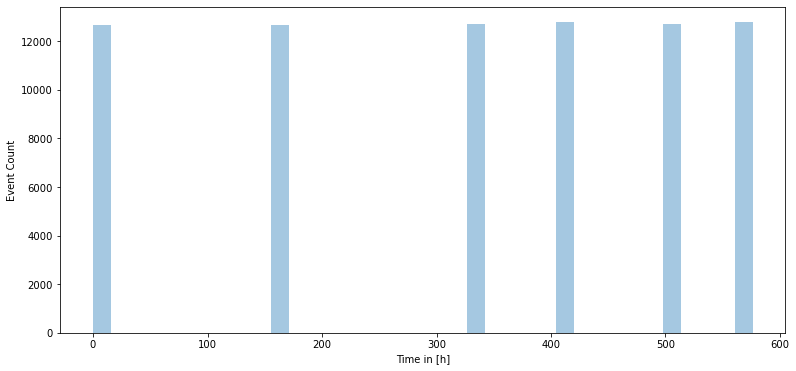

In [470]:
plot_event_histogram_of_time_series(df_timeline, 'received');

Offers got issued in bulks of about 12.700 instances. The first three issuing times are spaced by one week (168h). The remaining three issuing times are spaced by roughly half a week (72h (43% of one week) and 96h (57% of one week)) from the previous.

--------------------------------------------------
Plotting offer ae264e3637204a6fb9bb56bc8210ddfd received events as time series

Time | # events
0      1292
168    1319
336    1245
408    1278
504    1248
576    1276
Name: received, dtype: int64
Avg. number of events: 1276.3333333333333

Differences in time between successive events: [168, 168, 72, 96, 72]
--------------------------------------------------
Plotting offer 4d5c57ea9a6940dd891ad53e9dbe8da0 received events as time series

Time | # events
0      1218
168    1240
336    1280
408    1308
504    1310
576    1237
Name: received, dtype: int64
Avg. number of events: 1265.5

Differences in time between successive events: [168, 168, 72, 96, 72]
--------------------------------------------------
Plotting offer 3f207df678b143eea3cee63160fa8bed received events as time series

Time | # events
0      1273
168    1266
336    1279
408    1275
504    1229
576    1295
Name: received, dtype: int64
Avg. number of events: 1269.5

Differences

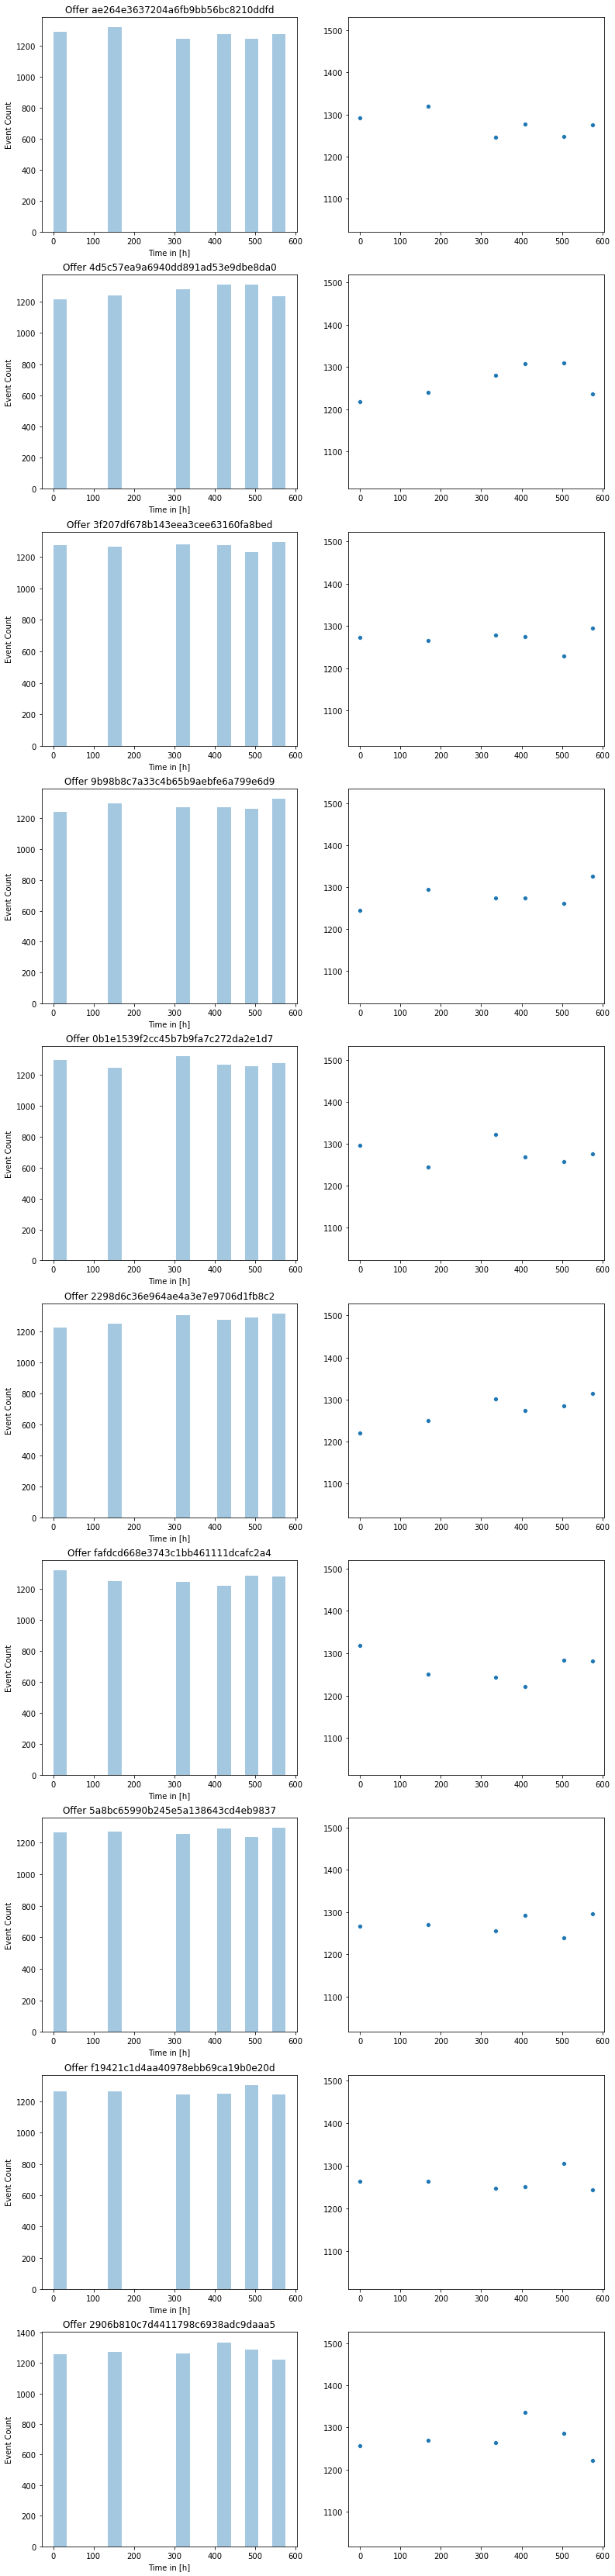

In [451]:
plot_all_event_histograms_of_time_series(portfolio, df_timeline, 'received', attach_event_count_scatter_plot=True)

Each offer gets received roughly the same number of times (~1270). This is 1/10 of all received events. 

Next, let's take a closer look at the viewed events.

--------------------------------------------------
Plotting offer  viewed events as time series

Time | # events
0.0      2072
6.0      1433
12.0     1085
18.0      884
24.0      734
         ... 
690.0      87
696.0      74
702.0      59
708.0      57
714.0      50
Name: viewed, Length: 120, dtype: int64
Avg. number of events: 481.0416666666667

Differences in time between successive events: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]


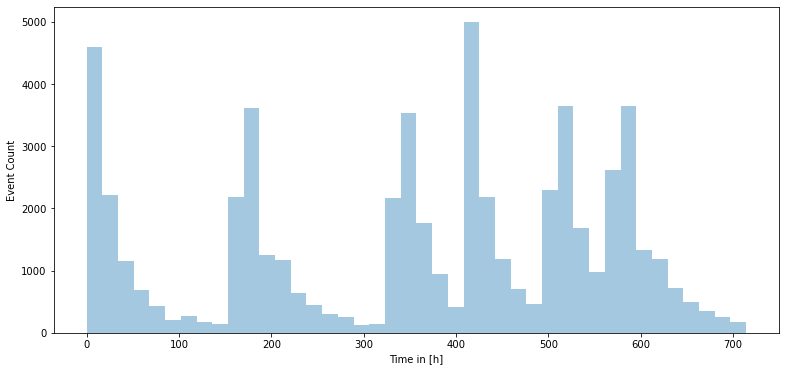

In [457]:
plot_event_histogram_of_time_series(df_timeline, 'viewed');

After an initial peak, the number of view events appears to follow an *exponential* decay. Chunks of `viewed` events are spaced approximately 6h apart. This keeps true in the detailed view of each offer.

--------------------------------------------------
Plotting offer ae264e3637204a6fb9bb56bc8210ddfd viewed events as time series

Time | # events
0.0      209
6.0      149
12.0     141
18.0     124
24.0      82
        ... 
690.0     18
696.0     14
702.0     13
708.0      9
714.0      4
Name: viewed, Length: 120, dtype: int64
Avg. number of events: 55.96666666666667

Differences in time between successive events: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.

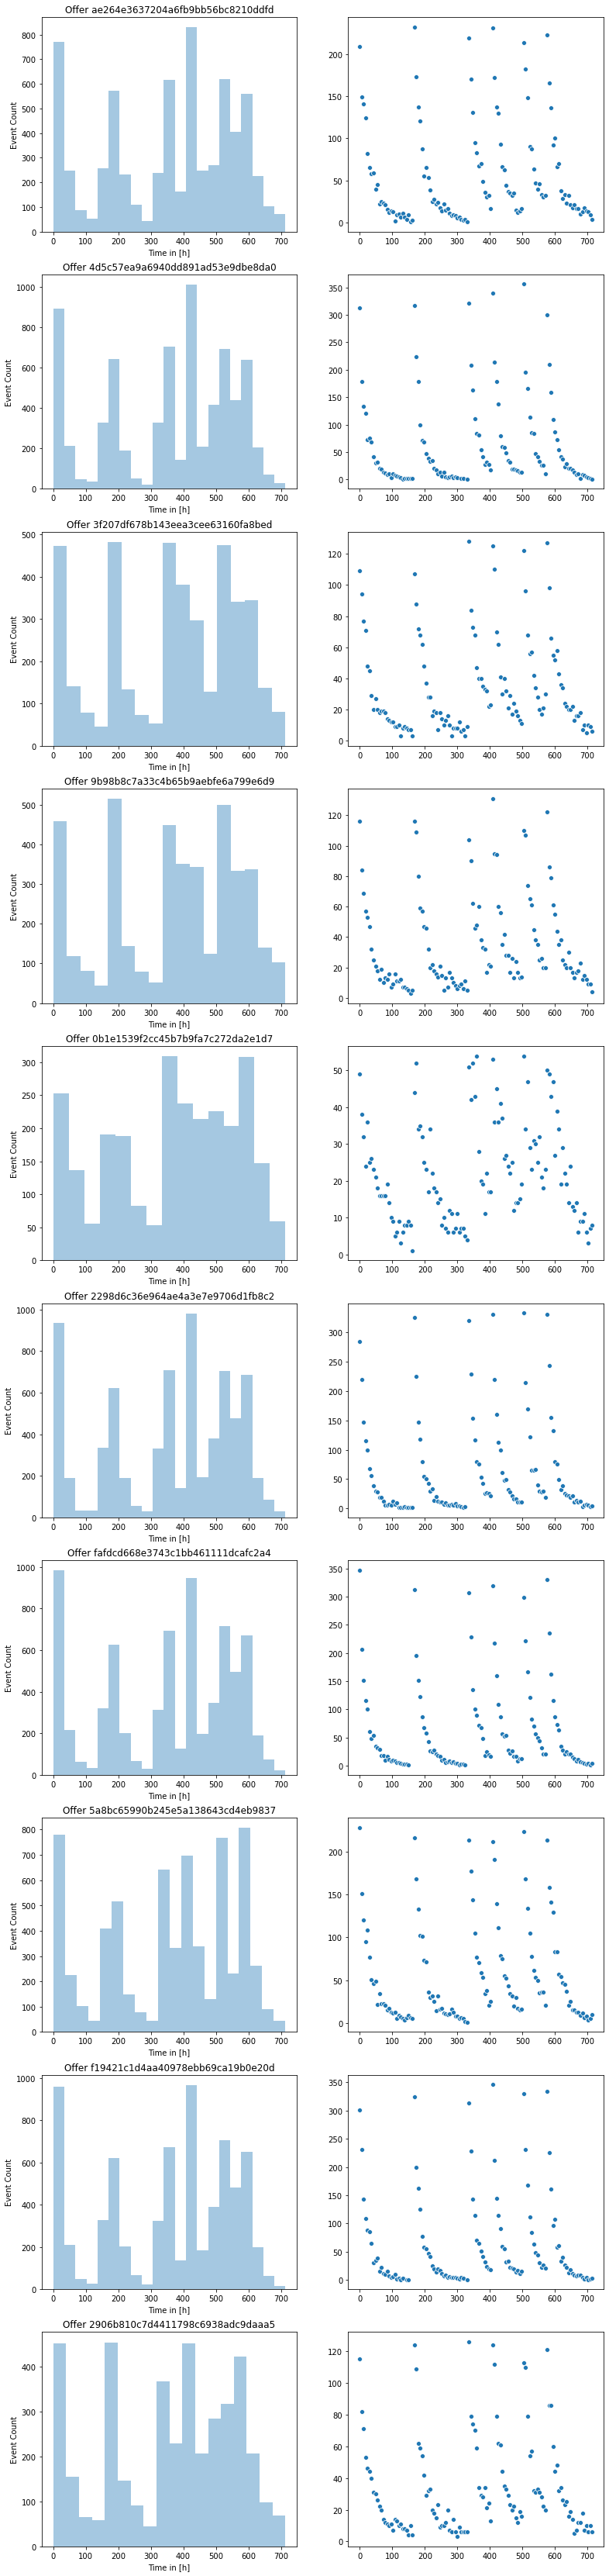

In [458]:
plot_all_event_histograms_of_time_series(portfolio, df_timeline, 'viewed', attach_event_count_scatter_plot=True)

The next two cells analyze the completed event:

--------------------------------------------------
Plotting offer  completed events as time series

Time | # events
0.0      206
6.0      276
12.0     280
18.0     252
24.0     265
        ... 
690.0    130
696.0    147
702.0    100
708.0     97
714.0     99
Name: completed, Length: 120, dtype: int64
Avg. number of events: 275.84166666666664

Differences in time between successive events: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]


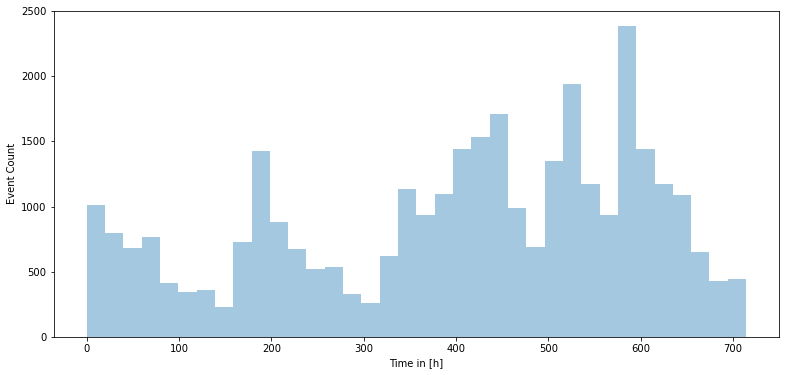

In [460]:
plot_event_histogram_of_time_series(df_timeline, 'completed');

--------------------------------------------------
Plotting offer ae264e3637204a6fb9bb56bc8210ddfd completed events as time series

Time | # events
0.0      20
6.0      28
12.0     31
18.0     25
24.0     35
         ..
690.0    13
696.0     9
702.0    11
708.0     9
714.0     8
Name: completed, Length: 120, dtype: int64
Avg. number of events: 30.291666666666668

Differences in time between successive events: [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6

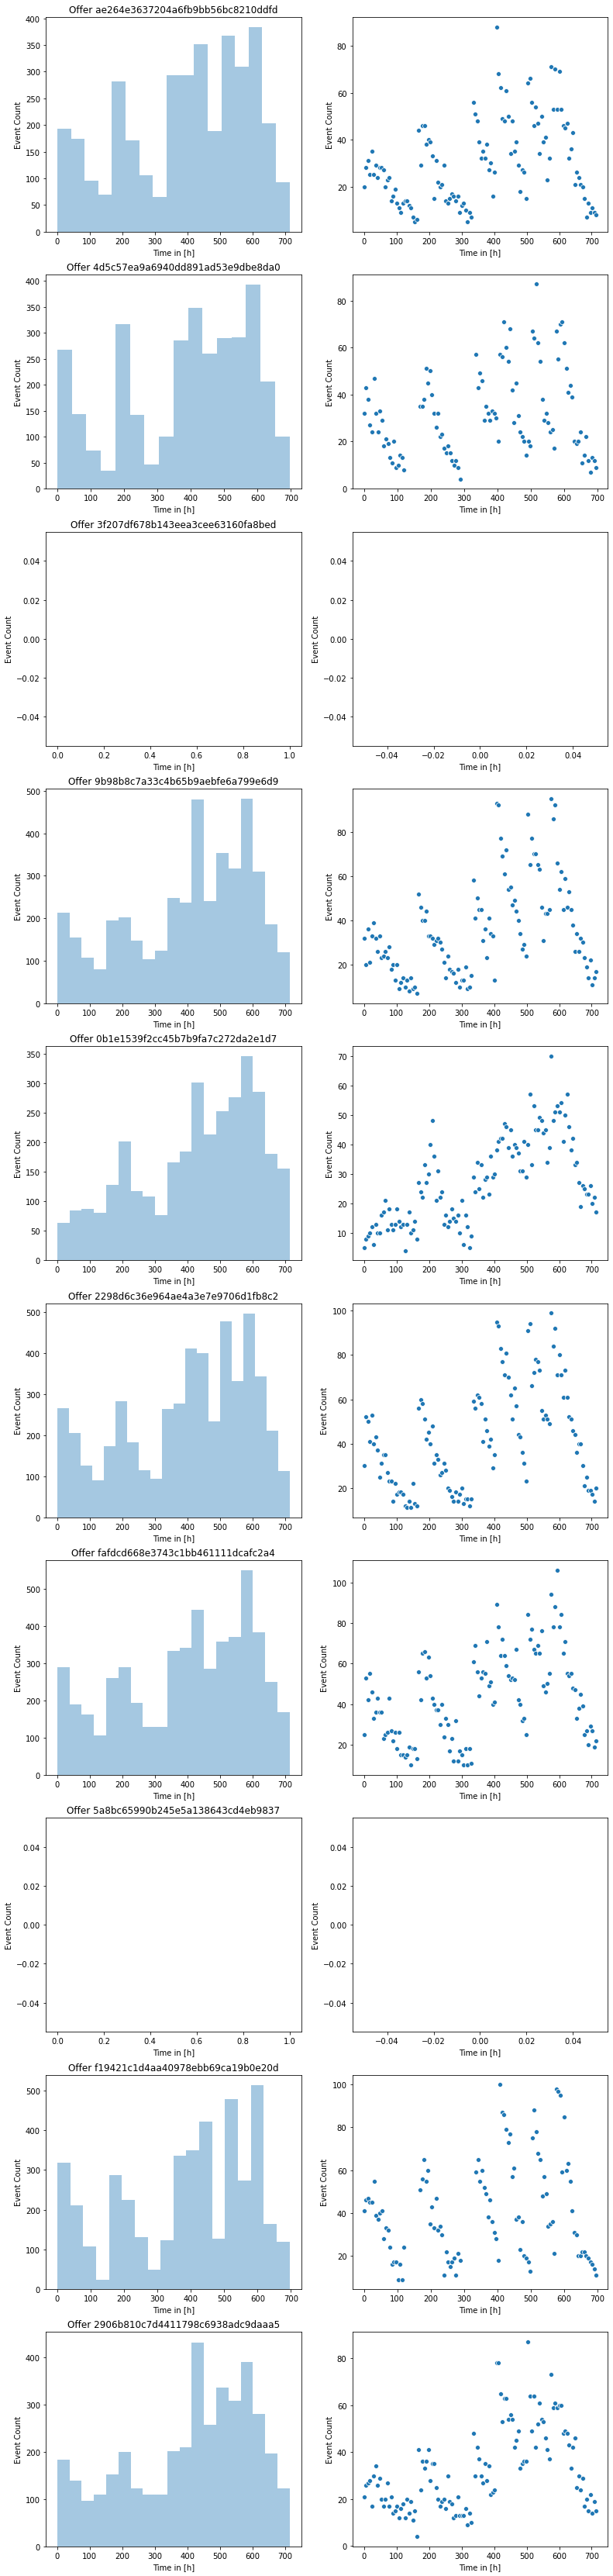

In [473]:
plot_all_event_histograms_of_time_series(portfolio, df_timeline, 'completed', attach_event_count_scatter_plot=True)

Completion of offers also appears in chucks spaced 6h apart. After an initial peak, the number of events appears to follow a *linear* decay. Peaks coincide with the time at which the offers get received. The informational offers `3f207df678b143eea3cee63160fa8bed` and `5a8bc65990b245e5a138643cd4eb9837` are not shown in the plots as these do not have any event completions.

##### Mean Times to View / Complete

This section takes a look at the means of the time to view and time to complete.

In [75]:
df = df_timeline.groupby('offer id')['time to view'].describe().sort_values('mean')
df = pd.merge(df, portfolio[['id', 'offer_type']], left_index=True, right_on='id', suffixes=('_df', '_portfolio'))
df

count       mean        std  min   25%   50%   75%    max  \
8  7264.0  20.114537  25.349287  0.0   0.0  12.0  30.0  270.0   
5  7337.0  20.562083  26.115573  0.0   0.0  12.0  30.0  252.0   
1  7298.0  20.716361  25.939089  0.0   0.0  12.0  30.0  240.0   
6  7327.0  20.719531  25.619762  0.0   0.0  12.0  30.0  240.0   
7  6687.0  27.790040  32.493929  0.0   6.0  18.0  42.0  318.0   
0  6716.0  28.172126  33.910840  0.0   6.0  18.0  36.0  438.0   
2  4144.0  35.461390  40.921670  0.0   6.0  24.0  48.0  354.0   
9  4118.0  35.602234  42.679049  0.0   6.0  24.0  48.0  396.0   
3  4171.0  36.161112  42.138210  0.0   6.0  24.0  48.0  438.0   
4  2663.0  45.257980  44.572322  0.0  12.0  30.0  66.0  348.0   

                                 id     offer_type  
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo  
6  fafdcd668e3743c1bb461111dcafc2a4       discount  
7  5a8bc65990b245e5a138643cd4eb9837  informational  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo  
2  3f207df678b143eea3cee63160fa8bed  informational  
9  2906b810c7d4411798c6938adc9daaa5       discount  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount

In [76]:
df.groupby('offer_type')['mean'].describe().sort_values('mean')

count       mean        std        min        25%        50%  \
offer_type                                                                    
bogo             4.0  26.291034   7.531778  20.114537  20.565905  24.444243   
discount         4.0  30.535457  12.086432  20.562083  20.680169  28.160882   
informational    2.0  31.625715   5.424463  27.790040  29.707878  31.625715   

                     75%        max  
offer_type                           
bogo           30.169373  36.161112  
discount       38.016171  45.257980  
informational  33.543553  35.461390

In [72]:
df = df_timeline.groupby('offer id')['time to complete'].describe().sort_values('mean')
df = pd.merge(df, portfolio[['id', 'offer_type']], left_index=True, right_on='id', suffixes=('_df', '_portfolio'))
df

count        mean        std  min   25%   50%    75%    max  \
8  4262.0   42.316753  33.409889  0.0  12.0  36.0   66.0  120.0   
1  3301.0   42.338079  32.944833  0.0  12.0  36.0   66.0  120.0   
0  3635.0   54.465475  43.503643  0.0  18.0  42.0   84.0  168.0   
5  5102.0   56.956488  45.009251  0.0  18.0  48.0   84.0  168.0   
3  4303.0   58.139902  45.506396  0.0  18.0  48.0   90.0  168.0   
9  3955.0   63.769912  46.553081  0.0  24.0  54.0  102.0  168.0   
6  5230.0   72.170937  59.557447  0.0  24.0  54.0  108.0  240.0   
4  3313.0  101.547238  65.500177  0.0  48.0  96.0  150.0  240.0   
2     0.0         NaN        NaN  NaN   NaN   NaN    NaN    NaN   
7     0.0         NaN        NaN  NaN   NaN   NaN    NaN    NaN   

                                 id     offer_type  
8  f19421c1d4aa40978ebb69ca19b0e20d           bogo  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo  
5  2298d6c36e964ae4a3e7e9706d1fb8c2       discount  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo  
9  2906b810c7d4411798c6938adc9daaa5       discount  
6  fafdcd668e3743c1bb461111dcafc2a4       discount  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount  
2  3f207df678b143eea3cee63160fa8bed  informational  
7  5a8bc65990b245e5a138643cd4eb9837  informational

In [74]:
df.groupby('offer_type')['mean'].describe().sort_values('mean')

count       mean        std        min        25%        50%  \
offer_type                                                                    
bogo             4.0  49.315052   8.206891  42.316753  42.332748  48.401777   
discount         4.0  73.611144  19.636081  56.956488  62.066556  67.970424   
informational    0.0        NaN        NaN        NaN        NaN        NaN   

                     75%         max  
offer_type                            
bogo           55.384082   58.139902  
discount       79.515012  101.547238  
informational        NaN         NaN

On average, users view bogo offers earlier (mean at 26.3h), followed by discounts (mean at 30.5h). Last are informational offers with a mean time to view of 31.6h. Completion of bogo offers happens on average around 49.3h and discounts at 73.6h. Therefore, bogo offers engage users earlier than discount or informational offers.

Side note: looking at the sorted mean times to view or to complete reveals a neat and symmetric pattern of the offer type if you look up and down from the 6th (time to view) or 4th and 5th (time to complete, ignoring informational offers).

##### Offer State

This section shows the state (*success, no success, ignored*) of the offers given in the portfolio.

3    0.383091
2    0.373691
1    0.243219
Name: offer state, dtype: float64


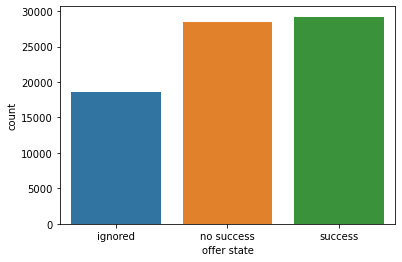

In [298]:
ax = sb.countplot(x="offer state", data=df_timeline)
ax.set_xticklabels([get_offer_state_str(int(t.get_text())) for t in ax.get_xticklabels()]);

print(df_timeline['offer state'].value_counts() / df_timeline.shape[0])

Of all offers

* ~38% are `successful`
* ~37% are `not successful`
* ~24% got `ignored`

In detail:

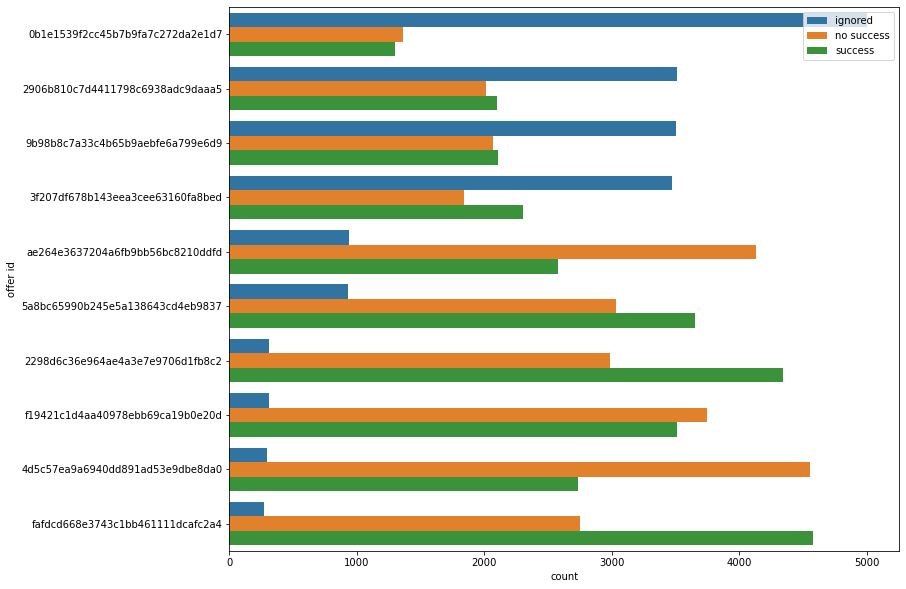

In [476]:
df = df_timeline.groupby(['offer id', 'offer state']).size() 

plt.figure(figsize=(12, 10))
g = sb.countplot(y='offer id', hue='offer state', data=df_timeline, order=df[:,1].sort_values(ascending=False).index);
plt.legend(loc='upper right', labels=[get_offer_state_str(OFFER_STATE_IGNORED), get_offer_state_str(OFFER_STATE_NO_SUCCESS), get_offer_state_str(OFFER_STATE_SUCCESS)]);

* Most successful:
    * `fafdcd668e3743c1bb461111dcafc2a4` (discount),
    * `2298d6c36e964ae4a3e7e9706d1fb8c2` (discount),
    * `5a8bc65990b245e5a138643cd4eb9837` (informational)
* Not successful:
    * `4d5c57ea9a6940dd891ad53e9dbe8da0` (bogo)
    * `ae264e3637204a6fb9bb56bc8210ddfd` (bogo)
    * `f19421c1d4aa40978ebb69ca19b0e20d` (bogo)
* Ignored:
    * `0b1e1539f2cc45b7b9fa7c272da2e1d7` (discount)
    * `2906b810c7d4411798c6938adc9daaa5` (discount)
    * `9b98b8c7a33c4b65b9aebfe6a799e6d9` (bogo)
    * `3f207df678b143eea3cee63160fa8bed` (informational)
    
The next three cells show details regarding the listed offers.

In [517]:
OFFER_IDS_MOST_SUCCESSFULL = ['fafdcd668e3743c1bb461111dcafc2a4', 
                              '2298d6c36e964ae4a3e7e9706d1fb8c2', 
                              '5a8bc65990b245e5a138643cd4eb9837']
OFFER_IDS_NOT_SUCCESSFULL = ['4d5c57ea9a6940dd891ad53e9dbe8da0', 
                             'ae264e3637204a6fb9bb56bc8210ddfd', 
                             'f19421c1d4aa40978ebb69ca19b0e20d']
OFFER_IDS_IGNORED = ['0b1e1539f2cc45b7b9fa7c272da2e1d7', 
                     '2906b810c7d4411798c6938adc9daaa5', 
                     '9b98b8c7a33c4b65b9aebfe6a799e6d9', 
                     '3f207df678b143eea3cee63160fa8bed']

print('Most successfull')
portfolio[portfolio['id'].isin(OFFER_IDS_MOST_SUCCESSFULL)]

Most successfull


reward  difficulty  duration     offer_type  \
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   

                                 id  web  email  mobile  social  \
5  2298d6c36e964ae4a3e7e9706d1fb8c2    1      1       1       1   
6  fafdcd668e3743c1bb461111dcafc2a4    1      1       1       1   
7  5a8bc65990b245e5a138643cd4eb9837    0      1       1       1   

   offers completed  offers received  offers viewed  \
5            5156.0             7646           7337   
6            5317.0             7597           7327   
7               NaN             7618           6687   

   offers completed relative  offers viewed relative  
5                   0.674340                0.959587  
6                   0.699882                0.964460  
7                        NaN                0.877789

In [518]:
print('Not successfull')
portfolio[portfolio['id'].isin(OFFER_IDS_NOT_SUCCESSFULL)]

Not successfull


reward  difficulty  duration offer_type                                id  \
0      10          10         7       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5       bogo  4d5c57ea9a6940dd891ad53e9dbe8da0   
8       5           5         5       bogo  f19421c1d4aa40978ebb69ca19b0e20d   

   web  email  mobile  social  offers completed  offers received  \
0    0      1       1       1            3688.0             7658   
1    1      1       1       1            3331.0             7593   
8    1      1       1       1            4296.0             7571   

   offers viewed  offers completed relative  offers viewed relative  
0           6716                   0.481588                0.876991  
1           7298                   0.438694                0.961148  
8           7264                   0.567428                0.959451

In [519]:
print('Ignored')
portfolio[portfolio['id'].isin(OFFER_IDS_IGNORED)]

Ignored


reward  difficulty  duration     offer_type  \
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
9       2          10         7       discount   

                                 id  web  email  mobile  social  \
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0   
9  2906b810c7d4411798c6938adc9daaa5    1      1       1       0   

   offers completed  offers received  offers viewed  \
2               NaN             7617           4144   
3            4354.0             7677           4171   
4            3420.0             7668           2663   
9            4017.0             7632           4118   

   offers completed relative  offers viewed relative  
2                        NaN                0.544046  
3                   0.567149                0.543311  
4                   0.446009                0.347287  
9                   0.526336                0.539570

Next, I am going to analyze the offer state by grouping the timelines on the column `gender` and `offer type`. The computed counts get normalized to make them comparable -- there are far more *male* users than users of sex *other*.

##### Offer State by Gender
First, let's group the set of all issued offers by `gender`:

gender  offer state
F       1              0.242934
        2              0.299497
        3              0.457568
M       1              0.257757
        2              0.360565
        3              0.381678
O       1              0.156114
        2              0.330786
        3              0.513100
dtype: float64


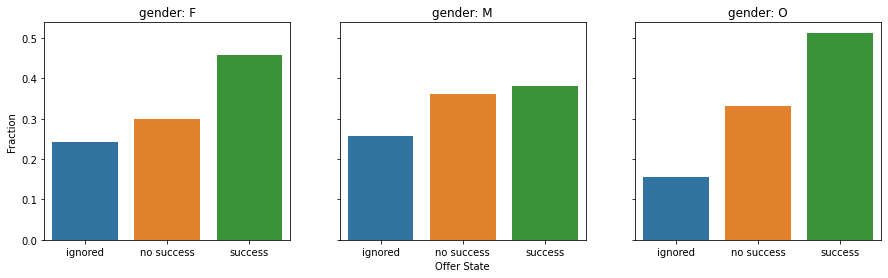

In [723]:
def plot_offer_state_grouped_by(df_timeline, groupby):
    """
    Plot bar chart of offer state frequency based on prior grouping (e.g. 'gender', 'age group').
    
    :param df_timeline: Timeline DataFrame to be used to perform the evaluation
    :param groupby: Column to be used for grouping prior to 'offer state'
    :return: None
    """
    df = df_timeline.groupby([groupby, 'offer state']).size() / df_timeline.groupby(groupby).size()
    print(df)

    ncols = df.index.unique(level=0).size
    figsize = (5 * ncols, 4)  # (index count) plots of size 5-by-4
    fig, axs = plt.subplots(ncols=ncols, nrows=1, sharey=True, figsize=figsize)
    clrs = [sb.color_palette()[0], sb.color_palette()[1], sb.color_palette()[2]] # ignored, not successfull, sucessfull

    ax_index = 0
    for group in df.index.unique(level=0):
        ax = sb.barplot(y=df[group].values, x=df[group].index, palette=clrs, ax=axs[ax_index]);
        ax.set_title("{}: {}".format(groupby, group));
        ax.set_xlabel("");                            # label will be set after this loop
        ax.set_xticklabels([get_offer_state_str(int(t.get_text())) for t in ax.get_xticklabels()]);

        ax_index += 1

    axs[0].set_ylabel("Fraction")
    axs[1].set_xlabel("Offer State");

plot_offer_state_grouped_by(df_timeline, 'gender')

Users of sex *female* and *other* are more likely to complete offers successfully (45% and 51% respectively). *Male* users are approximately as like to succeed as not to succeed (38% and 36% respectively).

##### Offer State by Offer Type
Next, lets group the set of all issued offers by `offer_type`:

offer_type     offer state
bogo           1              0.165579
               2              0.475688
               3              0.358733
discount       1              0.297875
               2              0.298563
               3              0.403562
informational  1              0.289071
               2              0.320118
               3              0.390811
dtype: float64


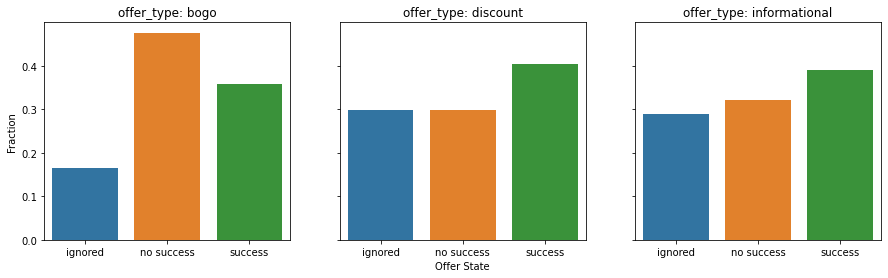

In [727]:
plot_offer_state_grouped_by('offer_type')

Offers of type *bogo* far more unlikely to be successful (47% of all *bogo* offers are not successful) as the other two types. *Discount* and *informational* offers succeed at about 40% of the time and are not successful in about 30% of the time.

*Bogo* offers have the lowest rate of ignored offers (16.5%) but the highest of unsuccessful offers (47.5%). It might be, that this type of offer has a too high difficulty or a too short duration that causes users to fail.

##### Offer State by Gender and Offer Type
Lets further group the issued offers by `gender` and `offer type` together.

gender  offer_type     offer state
F       bogo           1              0.166925
                       2              0.357358
                       3              0.475718
        discount       1              0.293338
                       2              0.231015
                       3              0.475647
        informational  1              0.293969
                       2              0.320152
                       3              0.385879
M       bogo           1              0.172738
                       2              0.482969
                       3              0.344292
        discount       1              0.320633
                       2              0.269962
                       3              0.409405
        informational  1              0.301044
                       2              0.298401
                       3              0.400555
O       bogo           1              0.110169
                       2              0.353107
                       3 

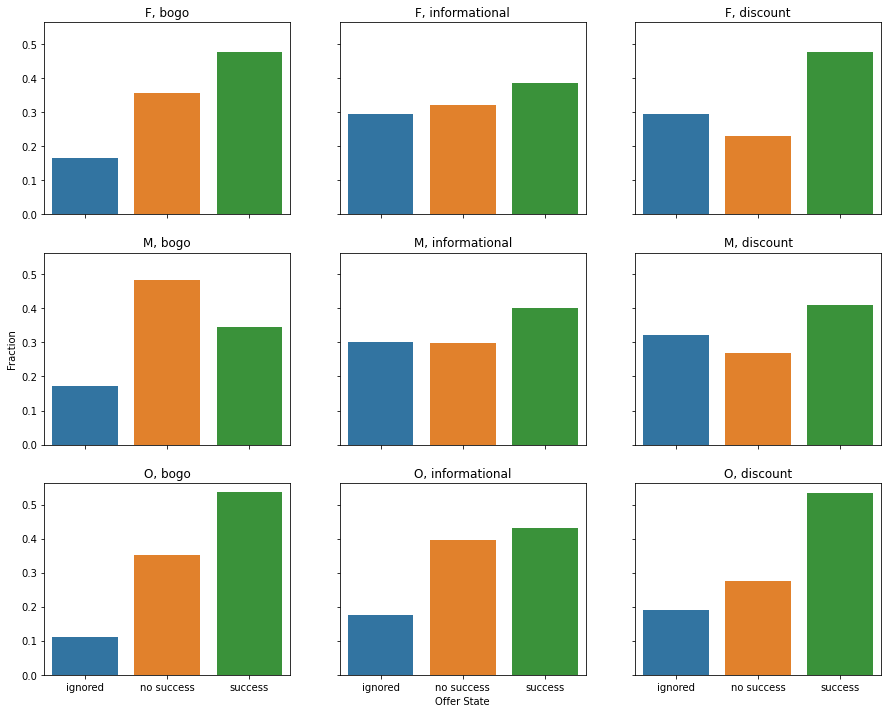

In [742]:
df = df_timeline.groupby(['gender', 'offer_type', 'offer state']).size() / df_timeline.groupby(['gender', 'offer_type']).size()
print(df)
    
figsize = (5 * 3, 4 * 3)  # 3x plots of size 5-by-4
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, sharex=True, figsize=figsize)
clrs = [sb.color_palette()[0], sb.color_palette()[1], sb.color_palette()[2]] # ignored, not successfull, sucessfull

ax_row_idx = 0
for gender in ['F', 'M', 'O']:
    ax_col_idx = 0
    for offer_type in portfolio['offer_type'].unique():
        ax = sb.barplot(y=df[gender, offer_type].values, x=df[gender, offer_type].index, palette=clrs, ax=axs[ax_row_idx][ax_col_idx]);
        ax.set_title("{}, {}".format(gender, offer_type));
        ax.set_xlabel("");                            # label will be set after this loop
        ax.set_xticklabels([get_offer_state_str(int(t.get_text())) for t in ax.get_xticklabels()]);

        ax_col_idx += 1
        
    ax_row_idx += 1
    

axs[1][0].set_ylabel("Fraction")
axs[2][1].set_xlabel("Offer State");

Findings from this plot:
* *bogo* offers are particularly unsuccessful with *male* users
* *bogo* and *discount* offers are most successful for *female* and *other* users
* *bogo* offers are ignored the least
* *other* users ignore the least amount of offers
* *informational* and *discount* offers are more likely to be ignored than *bogo* offers
* *informational* offers are approximately as likely to be ignored as not successful for *male* and *female* users
* *discount* offers are more often ignored than unsuccessful by *male* and *female* users

##### Offer State by Age
Let's see if the `age` has any correlation with the success of an offer.

Pearson correlation coefficient:
                  age  age group  offer state
age          1.000000   0.854608     0.044294
age group    0.854608   1.000000     0.024264
offer state  0.044294   0.024264     1.000000


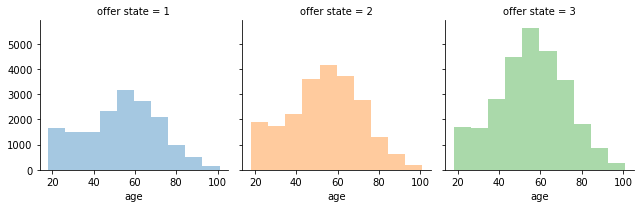

In [763]:
corrrelation = df_timeline[["age", "age group", "offer state"]].corr(method="pearson");
print("Pearson correlation coefficient:");
print(corrrelation);

clrs = [sb.color_palette()[0], sb.color_palette()[1], sb.color_palette()[2]] # ignored, not successfull, sucessfull
g = sb.FacetGrid(data = df_timeline, col = 'offer state', hue='offer state', palette=clrs);
g.map(sb.distplot, "age", bins=10, kde = False);

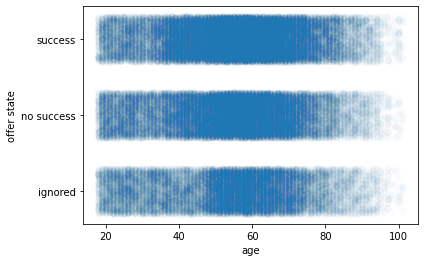

In [818]:
ax = sb.regplot(data = df_timeline, x = 'age', y = 'offer state', fit_reg = False,
           x_jitter = 0.1, y_jitter = 0.3, scatter_kws = {'alpha' : 1/60});
ax.set_yticks([1, 2, 3]);
ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);

Both plots and the correlation analysis show no particular relation between `age` and `offer state`. Instead, the same pattern as the `age` distribution from the `profile` DataFrame with a mean of approximately 60 is apparent.

##### Offer State by Reward and Difficulty
Let's see, if there is a certain combination of `reward` and `difficulty` that tends to foster successful, not successful, or ignored offers. To do this, I will plot a heatmap of absolute and relative counts of offers. The relative counts are based on the absolute number of offers given a certain combination of `reward` and `difficulty`.

In [898]:
def get_count_matrix_by_offer_state(df_timeline, state):
    """
    Get the counts of offers given a certain state.
    
    :param df_timeline: Timeline DataFrame containing the raw data
    :param state: offer state to filter timeline DataFrame; None if no filtering is required.
    :return: matrix of size difficulty x reward containing counts 
    """
    if state != None:
        df = df_timeline[df_timeline["offer state"] == state] 
    else:
        df = df_timeline
        
    df_counts = df.groupby("offer id").size().to_frame()
    df_counts.columns = ['count']
    df_counts = pd.merge(df_counts, portfolio[['id', 'reward', 'difficulty']], left_index=True, right_on='id')
    
    data = [[0] * 11 for i in range(0, 21)]

    for index in df_counts.index:
        count = df_counts.loc[index, 'count']
        reward = df_counts.loc[index, 'reward']
        difficulty = df_counts.loc[index, 'difficulty']
        
        print

        data[difficulty][reward] += count
        
    return data
    

def show_portfolio_heatmap_by_offer_state(df_timeline, state):
    """
    Plot relative and absolute counts of offers given a certain state.
    
    :param df_timeline: Timeline DataFrame containing the raw data
    :param state: offer state to filter timeline DataFrame
    :return: Nothing
    """
    
    assert state != None, "Offer state must be one of OFFER_STATE_SUCCESS, OFFER_STATE_NO_SUCCESS, OFFER_STATE_IGNORED"
    data = get_count_matrix_by_offer_state(df_timeline, state)
    data_total = get_count_matrix_by_offer_state(df_timeline, None)
    
    data_relative = [[0] * 11 for i in range(0, 21)]
    for i in range(len(data)):
        for j in range(len(data[i])):
            total = data_total[i][j]
            data_relative[i][j] = data[i][j] / total if total > 0 else 0

    xticks = np.arange(11)
    yticks = np.arange(21)
    
    figsize = (10, 8 * 2)
    fig, axs = plt.subplots(ncols=1, nrows=2, sharex=False, figsize=figsize)
    
    ax = sb.heatmap(data_relative, xticklabels=xticks, yticklabels=yticks, cmap='OrRd', annot=True, fmt=".1f", vmax=1.0, ax=axs[0]);
    ax.set_xlabel("Reward")
    ax.set_ylabel("Difficulty")
    ax.set_title("Count of offers with state {} (relative to all offers)".format(get_offer_state_str(state)))
    
    vmax = 7000 # max(max(data))
    ax = sb.heatmap(data, xticklabels=xticks, yticklabels=yticks, cmap='OrRd', annot=True, fmt="d", vmax=vmax, ax=axs[1]);
    ax.set_xlabel("Reward")
    ax.set_ylabel("Difficulty")
    ax.set_title("Count of offers with state {} (absolute, only in this state)".format(get_offer_state_str(state)))
    

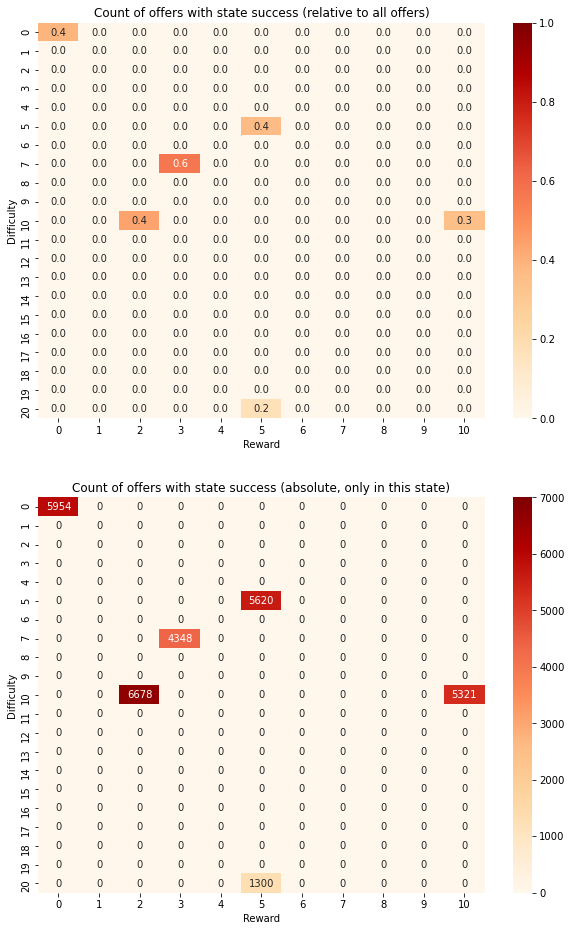

In [899]:
show_portfolio_heatmap_by_offer_state(df_timeline, OFFER_STATE_SUCCESS)

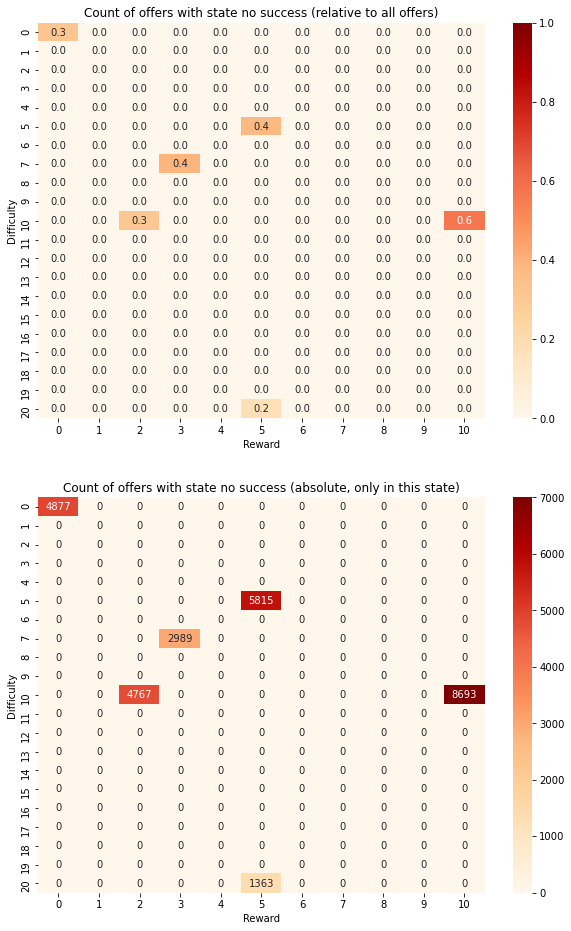

In [900]:
show_portfolio_heatmap_by_offer_state(df_timeline, OFFER_STATE_NO_SUCCESS)

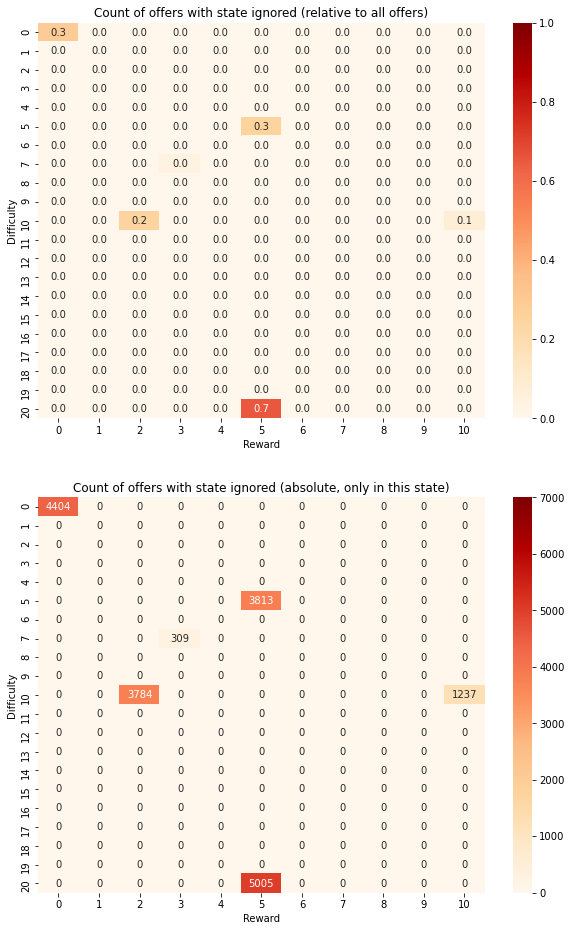

In [901]:
show_portfolio_heatmap_by_offer_state(df_timeline, OFFER_STATE_IGNORED)

*Successful*

The highest success rate of 0.6 (60% of all offers) is reached by offers with reward = 3 and difficulty = 7 (`2298d6c36e964ae4a3e7e9706d1fb8c2` (bogo)). In absolute numbers, the highest number of successful offers is with reward = 2 and difficulty = 10 (`fafdcd668e3743c1bb461111dcafc2a4` and `2906b810c7d4411798c6938adc9daaa5`, both discount).

*Not Successful*

In absolute and relative counts, 8693 and 0.6 (60% of all offers) respectively, the highest number of offers is found with a combination of reward = 10 and difficulty = 10 (`ae264e3637204a6fb9bb56bc8210ddfd` and `4d5c57ea9a6940dd891ad53e9dbe8da0`, both bogo).

*Ignored*

In absolute and relative counts, 5005 and 0.7 (70% of all offers are ignored) respectively, the highest number of offers is found with a combination of reward = 5 and difficulty = 20 (`0b1e1539f2cc45b7b9fa7c272da2e1d7` (discount)).

##### Offer State by Channel

In this subsection, I take a look a the usage of communication `channel`s and their influence on the `offer state`. First, let's see how each channel, in turn, affects the offer state.

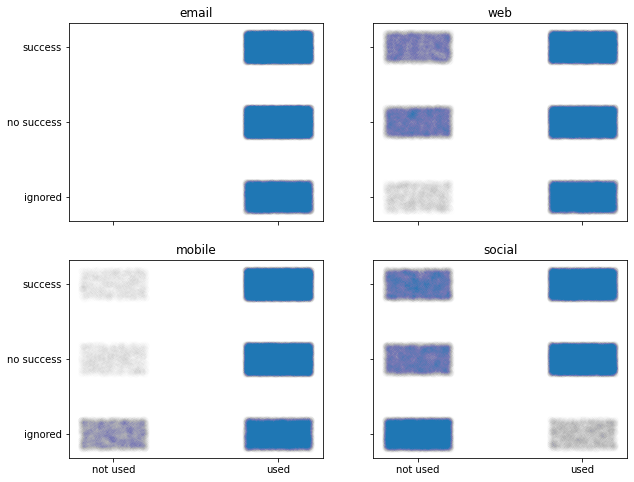

In [804]:
figsize = (5 * 2, 4 * 2)  # 2x2 plots of size 5-by-4
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, figsize=figsize)

channels = ['email', 'web', 'mobile', 'social']
for ax_row_idx in range(2):
    for ax_col_idx in range(2):
        channel = channels[ax_row_idx * 2 + ax_col_idx]
        ax = sb.regplot(data = df_timeline, x = channel, y = 'offer state', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/200}, ax=axs[ax_row_idx][ax_col_idx]);
        ax.set_xlabel("");  
        ax.set_xticks([0, 1]);
        ax.set_xticklabels(["not used", "used"]);
        ax.set_ylabel("");  
        ax.set_yticks([1, 2, 3]);
        ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);
        ax.set_title("{}".format(channel));

Next, let's see if the number of used channels has an influence.

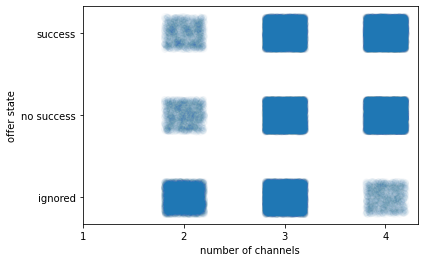

In [826]:
ax = sb.regplot(data = df_timeline, x = 'number of channels', y = 'offer state', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/60});

ax.set_xticks([1, 2, 3, 4]);
ax.set_yticks([1, 2, 3]);
ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);

Knowing that each offer got equally often issued and that each channel is used more often than not I conclude that:
* Channel *email* can not be used to discriminate between the offer states (channel is always used)
* Not using channel *web* leads to more (un)successful offers than ignored ones
* Not using the *mobile* channel leads to ignored offers
* Not using the *social* channel leads to ignored offers and using it to  more (un)successful offers than ignored ones
* Using only 2 channels tends to offers being ignored
* Using all 4 channels reduces the likelihood of an offer being ignored

##### Offer State by Income

How do the `income` and the spending of users affect the `offer state`? This question will be addressed in this section.

As the `income` column of `df_timeline` contains NaN values I will fill them with the median obtained from the original `income` column of the `profile` DataFrame.

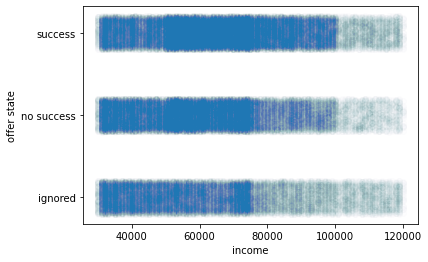

In [83]:
ax = sb.regplot(data = df_timeline, x = 'income', y = 'offer state', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/170});
ax.set_yticks([1, 2, 3]);
ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);

The scatter plot shows that users with an income of more than 75,000 are more likely to not ignore an offer. Below an income of 75,000, the income appears to have no effect on whether the offer is in any of the three states. 

Next, let's see if users that tend to spend more are more likely to complete an offer successfully. To do this, I need to merge the `df_timeline` with the `df_user_income_spending` DataFrame.

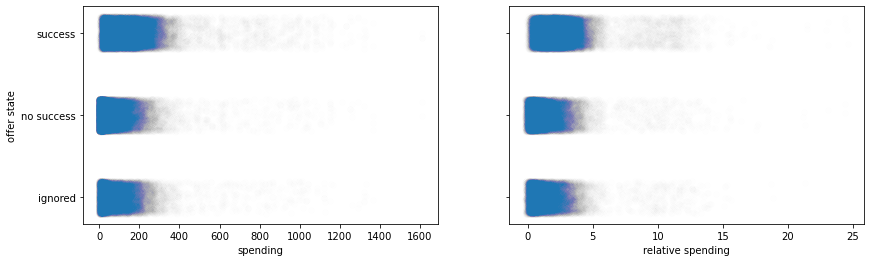

In [890]:
figsize = (7 * 2, 4)  # 2x plots of size 7-by-4
fig, axs = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=figsize)

df = pd.merge(df_timeline, df_user_income_spending[['user id', 'spending', 'relative spending']], left_on='user id', right_on='user id',
             suffixes=('_timeline', '_profile'))

ax = sb.regplot(data = df, x = 'spending', y = 'offer state', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/200}, ax=axs[0]);
ax.set_yticks([1, 2, 3]);
ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);

ax = sb.regplot(data = df, x = 'relative spending', y = 'offer state', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/200}, ax=axs[1]);
ax.set_ylabel("");

Spending seems to not affect the offer state much. 

##### Offer State by Duration

Now, lets turn to the `duration` of an offer. In the following plot, I want to see if the duration has any effect on the `offer state`. 

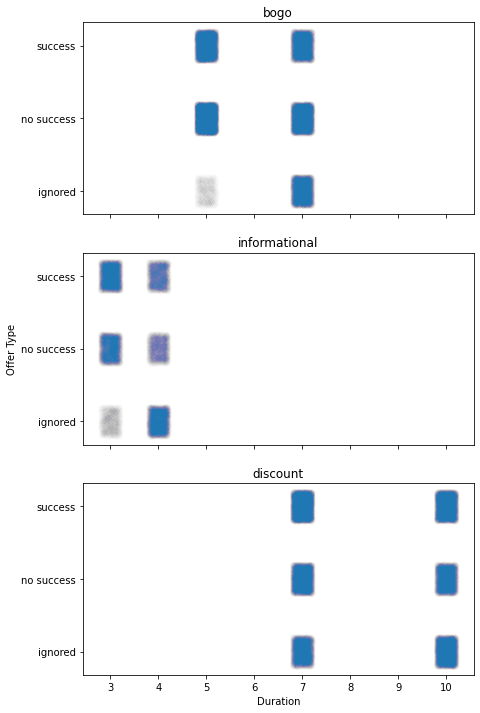

In [944]:
figsize = (7, 4*3)  # 3x plots of size 7-by-4
fig, axs = plt.subplots(ncols=1, nrows=3, sharey=True, sharex=True, figsize=figsize)

ax_col_idx = 0
for offer_type in portfolio['offer_type'].unique():
    ax = sb.regplot(data = df_timeline[df_timeline['offer_type']==offer_type], x = 'duration', y = 'offer state', fit_reg = False,
               x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/300}, ax=axs[ax_col_idx]);
    ax.set_title(offer_type)
    ax.set_ylabel("")
    ax.set_yticks([1, 2, 3]);
    ax.set_yticklabels([get_offer_state_str(t) for t in [1, 2, 3]]);
    ax.set_xlabel("")
    ax.set_xticks(range(3, 11))
    
    ax_col_idx += 1
    
axs[1].set_ylabel("Offer Type");
axs[2].set_xlabel("Duration");

Offers of type *bogo* are issued with a duration of 5 and 7 days. A duration of 5 days reduces the likelihood of an offer being ignored while the duration of 7 days does not appear to affect the state.

*Informational* offers are more likely to be ignored if their duration is longer (here 4 days). On the other hand, a shorter duration of 3 days decreases this likelihood.

Different durations seem to have no effect on *discount* offers.

##### Revenue
Now, let's take a closer look at the generated `revenue`:

Revenue Statistics from Timeline DataFrame
                                       sum       mean        std
offer id                                                        
fafdcd668e3743c1bb461111dcafc2a4  94055.56  12.836845  29.705351
2298d6c36e964ae4a3e7e9706d1fb8c2  79298.16  10.807981  25.622740
5a8bc65990b245e5a138643cd4eb9837  73885.68  11.049152  26.737258
f19421c1d4aa40978ebb69ca19b0e20d  71720.01   9.873349  33.947427
4d5c57ea9a6940dd891ad53e9dbe8da0  68472.85   9.382413  31.737981
ae264e3637204a6fb9bb56bc8210ddfd  65798.44   9.797266  30.980721
3f207df678b143eea3cee63160fa8bed  59834.51  14.438830  32.613011
2906b810c7d4411798c6938adc9daaa5  45091.46  10.949845  27.203233
0b1e1539f2cc45b7b9fa7c272da2e1d7  43579.94  16.364979  45.883896
9b98b8c7a33c4b65b9aebfe6a799e6d9  38386.95   9.203297  16.810243


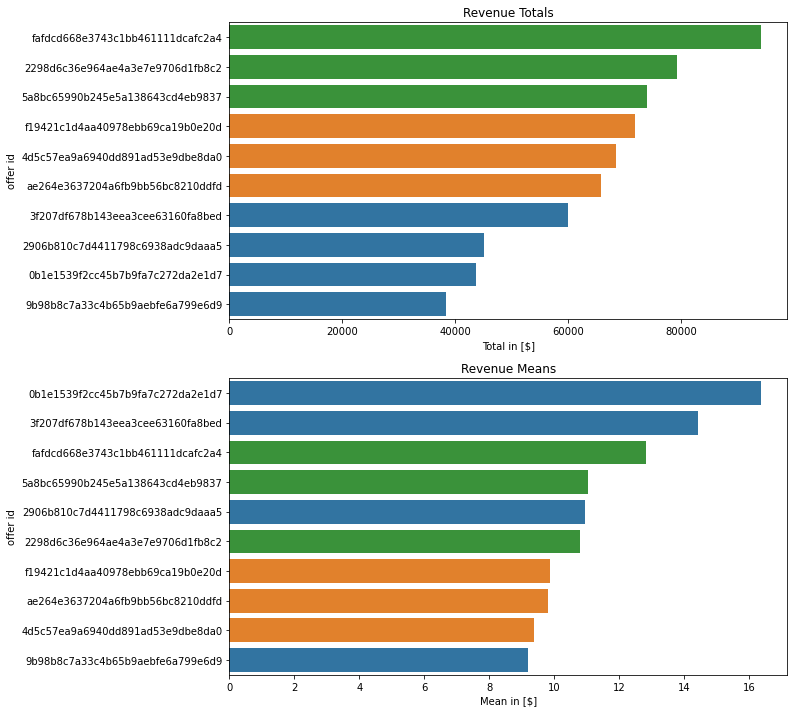

In [880]:
def get_bar_color_by_offer_id(offer_id):
    """
    Get bar color based on offer state. Assignment between offer states
    and offer id is hard coded!!! and according to results gained in the
    analysis of the offer states.
    
    :param offer_id: Offer ID, used to assign colors according to state (hard coded)
    :return: Color to be used in Seaborn Color Palette
    """
    # ignored
    if offer_id in OFFER_IDS_IGNORED: 
        return sb.color_palette()[0]
    
    # no success
    elif offer_id in OFFER_IDS_NOT_SUCCESSFULL: 
        return sb.color_palette()[1]
    
    # success
    elif offer_id in OFFER_IDS_MOST_SUCCESSFULL:
        return sb.color_palette()[2]
    
    return 'red'


# Build temporary DataFrame
df = df_timeline[['offer id', 'revenue']].groupby('offer id') \
    .agg(sum=('revenue', 'sum'), mean=('revenue', 'mean'), std=('revenue', 'std')) \
    .sort_values('sum', ascending=False)

print("Revenue Statistics from Timeline DataFrame")
print(df)

figsize = (10, 6 * 2) # 2x plots with size 10-by-6


fig, axs = plt.subplots(ncols=1, nrows=2, sharex=False, figsize=figsize)

clrs = [get_bar_color(offer_id) for offer_id in df.index]
ax = sb.barplot(y=df.index, x="sum", data=df, palette=clrs, ax=axs[0]);
ax.set_title('Revenue Totals');
ax.set_xlabel("Total in [$]");

df = df.sort_values('mean', ascending=False)
clrs = [get_bar_color(offer_id) for offer_id in df.index]
ax = sb.barplot(y=df.index, x="mean", data=df, palette=clrs, ax=axs[1]);
ax.set_title('Revenue Means');
ax.set_xlabel("Mean in [$]");

The previous plot of total revenues supports the intuition that successful offers generate the most revenue and ignored ones the lowest. But this pattern does not repeat in the plot of the revenue means. Remarkably, the two offers with the highest revenue means are ignored ones. But it makes sense, as offer `0b1e1539f2cc45b7b9fa7c272da2e1d7` has the single highest `difficulty` (minimum required spend to complete an offer) of 20.

##### Number of Offers by User and Offer State

In [638]:
df_timeline.groupby(['user id', 'offer state']).size().describe()

count    37047.000000
mean         2.058925
std          1.118020
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
dtype: float64

Each user has the following numbers of offers in each offer state:
* 1 at least,
* ~2 on avarage, and
* 6 at most

### Section Summary <a name="data-understanding_summary">

The section identified some issues with the data sets and some new features got derived.

* Profile
 * Age of 118 is kind of NaN encoding. Converted it to NaN
 * Grouped age into four groups
* *became_member_on* was encoded in an ISO format. Converted it into a date object
* Portfolio 
 * *Channel* contained a list of used channels. Separated into distinct columns
* Transcript
 * *value* contains a dict. Split into separate columns according to the keys used
* User Income Spending
 * Derived data set stored in `FILENAME_DF_USER_INCOME_SPENDING = 'df_user_income_spending.pickle'`
 * *relative spending* is in permille of the users income

Other insights gained in this section.
* Profile
 * 17000 users
 * Gender `O` (other): few records (~1.4% of all)
 * Age group of children (0-15 years) is not present
 * Age group of senior adults (> 50 yeras) contains 66.5% of all users
 * Most users joined around the year 2018
* Portfolio
 * 10 different offers (4x bogo, 4x discount, 2x informational)
 * Each channels gets used more often of than not (email 100%, mobile 90.0%, web 80.0%, social 60.0%)
 * Channel e-mail is always used
 * At least 2, 3 on avarage and 4 at most channels used
 * Each offer equally often represented in the data set (trascript)
 * 3 offers got viewd more than 80% but only completed less than 60% of the time. All of type *bogo* (`ae264e3637204a6fb9bb56bc8210ddfd`, `4d5c57ea9a6940dd891ad53e9dbe8da0`, `f19421c1d4aa40978ebb69ca19b0e20d`)
 * Mean Time to View / Complete
    * *bogo* offers get viewed earlier (mean at 26.3h) than any other offer type (*discount* mean at 30.5h, *informational* mean at 31.6h)
    * *bogo* offers get completed earlier (mean at 49.3h) than the *discount* offer (mean at 73.6h)
 * Offer state by Reward and Difficulty
    * Successful with reward = 3, difficulty = 7 `2298d6c36e964ae4a3e7e9706d1fb8c2` (60% of all offers)
    * Successful with reward = 2, difficulty = 10 `fafdcd668e3743c1bb461111dcafc2a4` and `2906b810c7d4411798c6938adc9daaa5` (6678 offers)
    * Not Successful with reward = 10 and difficulty = 10 `ae264e3637204a6fb9bb56bc8210ddfd` and `4d5c57ea9a6940dd891ad53e9dbe8da0` (8693 or 60% of all offers)
    * Ignored with reward = 10 and difficulty = 10 `0b1e1539f2cc45b7b9fa7c272da2e1d7` (5005 or 70% of all offers)
 * Offer state by Gender
    * *Female* and *other* are more likely to complete offers successfully (45% and 51% respectively)
    * Offers issued to *male* users succeed in 38% and are not succeefull in 36%
 * Offer state by Type
    * 47% of all *bogo* offers are not successful
    * *Discount* and *informational* offers succeed at about 40%
    * *Discount* and *informational* are not successful in about 30%
    * *Bogo* offers have the lowest rate of ignored offers (16.5%) but the highest of unsuccessful offers (47.5%)
 * Offer state by Gender and Type
    * *bogo* offers are particularly unsuccessful with *male* users
    * *bogo* and *discount* offers are most successful for *female* and *other* users
    * *bogo* offers are ignored the least
    * *other* users ignore the least amount of offers
    * *informational* and *discount* offers are more likely to be ignored than *bogo* offers
    * *informational* offerse are approximately as likely to be ignored as not successful for *male* and *female* users
    * *discount* offers are more often ignored than unsuccessfull by *male* and *female* users
 * Offer state by Age
    * *age* does not correlate with the state of the offer
 * Offer state by Channel
    * Channel *email* can not be used to discriminate between the offer states (channel is always used)
    * Not using channel *web* leads to more (un)successful offers than ignored ones
    * Not using the *mobile* channel leads to ignored offers
    * Not using the *social* channel leads to ignored offers and using it to  more (un)successful offers than ignored ones
    * Using only 2 channels tends to offers beeing ignored
    * Using all 4 channels reduces the likelihood of an offer beeing ignore
 * Offer state by Income
    * *success* and *no success* appears more often with user income of more than 75,000
    * Below income of 75,000 the income appears to not affect wheter the offer is in any of the three states
 * Offer state by Duration
    * *bogo* offers with a duration of 5 days are less likely to be ignored than those with a duration of 7 days
    * *informational* with a duration of 3 days are less likely to be ignored than those with a longer duration of 4 days
    * *discount* offers are not affacted by different durations
 * Revenue by offer state
    * `fafdcd668e3743c1bb461111dcafc2a4` (discount, successful) is the offer with the *higest* revenue of 94,056  
    * `0b1e1539f2cc45b7b9fa7c272da2e1d7` (discount, ignored, difficulty 20) is the offer with the *higest mean* revenue of 16.4
    * `9b98b8c7a33c4b65b9aebfe6a799e6d9` (bogo, ignored) is the offer with the *lowest* revenue of 38,387  
    * `9b98b8c7a33c4b65b9aebfe6a799e6d9` (bogo, ignored) is the offer with the *lowest mean* revenue of 9.2
* User Income Spending
 * `female`users tend to spend more than `others`. `others`tend to spend more than `male` users.
* Offer Life Cycle (Timeline)
 * Derived data is stored in `FILENAME_DF_TIMELINE = 'df_timeline.pickle'` and `FILENAME_DF_TRANSACTIONS = 'df_transactions.pickle'`
 * 70.03% of all transactions are made in the context of an active offer
 * 29.97% of all transactions are not in the context of an offer (standalone)
 * ~12.700 offers *received* in chucks spaced 168h, 168h, 72h, 96h, 72h apart (approximately one week and half a week)
 * Each offer contributes roughly 1/10th of receive events (~1270)
 * *View events* appears to follow an exponential decay. Chunks of view events are spaced approximately 6h apart.
 * *Completion events* appear to follow a linear decay. Chunks of completion events also appear to be spaced 6h apart.
 * A user has at least 1, 2 on average, and 6 at most offers in each offer state
 
#### Answering the Business Questions

**1. Which kind of users are most susceptible to offers?**<br/>
    Users of gender *female* and *other* are more likely to complete offers successfully (45% and 51% respectively) while they spend more than *males*. Besides, *female* and *other* users prefer *bogo* and *discount* offers. *bogo* offers are particularly unsuccessful with *male* users. But users with gender *other* are most likely to react on any offer. Users with an income above 75,000 reduce the likelihood of an offer being ignored. But an income below this threshold does not appear to affect the success of an offer.
    
**2. Which kind of offer engages the most users?**<br/>
    *Bogo* offers have the highest rate of success (60%) and the lowest chance of being ignored (16.5%). On the other hand, the highest revenue gets generated with *discount* offers. To reduce the number of ignored offers, it is advisable to use all four channels of communication  (web, email, social, and mobile). Offers with a *reward* between 2 and 3 and a *difficulty* between 7 and 10 makes them more likely to be completed successfully. A *difficulty* of 10 or higher makes offers less likely to be successful. This negative effect can not be compensated with a higher *reward*. Shorter durations reduce the likelihood of *bogo* and *informational* offers being ignored. The offer state of *discount* offers is not affected by the duration.

## 3. Data Preparation <a name="data-preparation">

The previous section revealed many insights into the provided data sets. Additionally, I generated three new data sets:

* `df_timeline`: containing the life cycle of an offer (from receiving an offer to its completion)
* `df_transactions`: containing all transactions made by users
* `df_user_income_spending`: containing information about the amount a users spends and his/her income

In this section, I will prepare the data to feed it into the machine learning process. In addition to the issues handled in the previous section (see subsection *Summary*) I will address the following issues:

* encode the `offer type` into a numeric form in column `offer_type_num`
* encode the `gender` into a numeric form in column `gender_num`
* encode NaN values in `gender` column as an additional gender (0, zero) in column `gender_num`
* fill NaN values in `age` column with the mean age
* fill NaN values in `income` column with the median and normalize on the maximum

From a business point of view, a unsuccessful (viewed but no money spend) and an ignored offer did not foster customer engagement. Only offers with state successful are also successful from the business point of view, as they engaged the customer and rewarded him/her. Therefore increasing customer satisfaction. This view will be encoded in the column `engaged`.

First, let's see how many NaN values are present.

In [885]:
df_timeline.isna().sum()/df_timeline.shape[0]

user id               0.000000
offer id              0.000000
received              0.000000
viewed                0.243219
completed             0.566042
time to complete      0.566042
time to view          0.243219
gender                0.128164
age                   0.128164
age group             0.000000
duration              0.000000
reward                0.000000
difficulty            0.000000
web                   0.000000
email                 0.000000
mobile                0.000000
social                0.000000
offer_type            0.000000
valid till            0.000000
offer state           0.000000
revenue               0.243219
number of channels    0.000000
income                0.000000
dtype: float64

In [97]:
df_machinelearning = df_timeline.copy()

def offer_type_to_number(type_str):
    type_str = type_str.lower()
    if type_str == 'discount':
        return 3
    elif type_str == 'bogo':
        return 2
    elif type_str == 'informational':
        return 1
    
def gender_to_number(gender_str):
    if pd.isna(gender_str):
        return 0
    
    gender_str = gender_str.lower()
    if gender_str == 'm':
        return 3
    elif gender_str == 'f':
        return 2
    elif gender_str == 'o':
        return 1
    return 0

def user_engaged(offer_state, revenue):
    return 1 \
        if offer_state == OFFER_STATE_SUCCESS \
        else 0
    
age_mean = profile['age'].mean()
df_machinelearning['age'].fillna(age_mean, inplace=True)

income_median = profile['income'].median()
df_machinelearning['income'].fillna(income_median, inplace=True)
df_machinelearning['income'] = df_machinelearning['income']/df_machinelearning['income'].max() # normalize the income

df_machinelearning['offer_type_num'] = df_machinelearning.apply(lambda r: offer_type_to_number(r['offer_type']), axis=1)
df_machinelearning['gender_num'] = df_machinelearning.apply(lambda r: gender_to_number(r['gender']), axis=1)
df_machinelearning['engaged'] = df_machinelearning.apply(lambda r: user_engaged(r['offer state'], r['revenue']), axis=1)

print("Remaining NaN values:")
print(df_machinelearning.isna().sum()/df_machinelearning.shape[0])

print()
print("Saving df_machinelearning ...")
with open(FILENAME_DF_MACHINELEARNING, 'wb') as f:
    pickle.dump(df_machinelearning, f, pickle.HIGHEST_PROTOCOL)

Remaining NaN values:
user id               0.000000
offer id              0.000000
received              0.000000
viewed                0.243219
completed             0.566042
time to complete      0.566042
time to view          0.243219
gender                0.128164
age                   0.000000
age group             0.000000
duration              0.000000
reward                0.000000
difficulty            0.000000
web                   0.000000
email                 0.000000
mobile                0.000000
social                0.000000
offer_type            0.000000
valid till            0.000000
offer state           0.000000
revenue               0.243219
number of channels    0.000000
income                0.000000
offer_type_num        0.000000
gender_num            0.000000
engaged               0.000000
dtype: float64

Saving df_machinelearning ...


In [141]:
print("Number of classes in different columns")
print("-"*40)
print("\nOffer Type (encoded):")
print_dataframe_value_counts(df_machinelearning['offer_type_num'])

print("\nGender (encoded):")
print_dataframe_value_counts(df_machinelearning['gender_num'])

print("\nEngaged:")
print_dataframe_value_counts(df_machinelearning['engaged'])

Number of classes in different columns
----------------------------------------

Offer Type (encoded):
3 30543 (40.0%)
2 30499 (40.0%)
1 15235 (20.0%)

Gender (encoded):
3 38129 (50.0%)
2 27456 (36.0%)
0 9776 (12.8%)
1 916 (1.2%)

Engaged:
0 47056 (61.7%)
1 29221 (38.3%)


## 4. Modeling <a name="modeling">
    
In this section I am going to build machine learning models to predict the offer state and user engagement given details about the offer and the user. 

The features are selected according to the findings in section [2. Data Understanding](#data-understanding). These features appear to have the most influence on the offer state.

A grid search is applied to find the best parameters for each evaluated classifier.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [128]:
df_feature = df_machinelearning[['gender_num', 'offer_type_num', 'income', 
                 'number of channels', 'reward', 'difficulty', 'duration']]

targets = {}
for target_column in ['offer state', 'engaged']:
    print("-"*80)
    print("Constructing training / test recors for target:", target_column)
    df_target = df_machinelearning[target_column]

    # split train/test
    X_train, X_test, Y_train, Y_test = train_test_split(df_feature, df_target, random_state=23) 

    targets[target_column] = {
        "target": target_column,
        "X_train": X_train,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_test": Y_test
    }
    
    print("Number of training records: {}".format(len(Y_train)))
    print("Number of test records: {}".format(len(Y_test)))
    print()

--------------------------------------------------------------------------------
Constructing training / test recors for target: offer state
Number of training records: 57207
Number of test records: 19070

--------------------------------------------------------------------------------
Constructing training / test recors for target: engaged
Number of training records: 57207
Number of test records: 19070



In [99]:
print("Number of NaN values in df_feature:")
print(df_feature.isna().sum())

Number of NaN values in df_feature:
gender_num            0
offer_type_num        0
income                0
number of channels    0
reward                0
difficulty            0
duration              0
dtype: int64


Initialize the different classifiers with their grid search parameters.

In [127]:
def build_pipeline_DecisionTreeClassifier():
    clf = DecisionTreeClassifier(random_state=23)
    pipeline = Pipeline([
        ('clf', clf)
    ])
    
    parameters = {
        'clf__max_depth': (10, 20, 50, None),
        'clf__criterion': ['gini','entropy'],
        'clf__max_features': ['auto', 'sqrt', 'log2', None]
    }
    
    return GridSearchCV(pipeline, param_grid=parameters, verbose=2, n_jobs=4, cv=3), clf
    
def build_pipeline_RandomForestClassifier():
    clf = RandomForestClassifier(random_state=23, verbose=1)
    pipeline = Pipeline([
        ('clf', clf)
    ])
    
    parameters = {
        'clf__max_depth': (10, 20, 50, None),
        'clf__criterion': ['gini','entropy'],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'clf__bootstrap': [True, False],
        'clf__n_estimators': [10, 50, 100]
    }
    
    return GridSearchCV(pipeline, param_grid=parameters, verbose=2, n_jobs=4, cv=3), clf
    
def build_pipeline_KNeighborsClassifier():
    clf = KNeighborsClassifier()
    pipeline = Pipeline([
        ('clf', clf)
    ])
    
    parameters = {
        'clf__n_neighbors': (2, 5, 10),
        'clf__weights': ['uniform', 'distance'],
        'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    
    return GridSearchCV(pipeline, param_grid=parameters, verbose=2, n_jobs=2, cv=3), clf

Next, perform the actual training on each target.

In [129]:
for target_key in targets:
    print("="*80)
    target = targets[target_key]
    print("Training models on target:", target_key)
    
    X_train, X_test, Y_train, Y_test = target["X_train"], target["X_test"], target["Y_train"], target["Y_test"]
    
    models = []

    pipeline, classifier = build_pipeline_DecisionTreeClassifier()
    models.append({"pipeline": pipeline, "classifier": classifier})

    pipeline, classifier = build_pipeline_RandomForestClassifier()
    models.append({"pipeline": pipeline, "classifier": classifier})

    pipeline, classifier = build_pipeline_KNeighborsClassifier()
    models.append({"pipeline": pipeline, "classifier": classifier})

    for model in models:
        print("-"*70)
        pipeline = model["pipeline"]
        classifier = model["classifier"]

        classifier_name = classifier.__class__.__name__
        print("Fitting", classifier_name, "...")
        fig = pipeline.fit(X_train, Y_train)

        print("Best Score:", pipeline.best_score_)
        print("Best Parameters:", pipeline.best_params_)
        Y_pred = pipeline.predict(X_train)
        print("\nTrained on {} records\n".format(len(Y_pred)))
        print(classification_report(Y_train, Y_pred))

        filename_model = "model_{}_{}.pickle".format(target["target"].replace(" ", "-"), classifier_name)
        print("Saving model to {} ...".format(filename_model))
        with open(filename_model, 'wb') as f:
            pickle.dump(df_machinelearning, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        print()

    target["models"] = models
    print()
        
print("Done")

Training models on target: offer state
----------------------------------------------------------------------
Fitting DecisionTreeClassifier ...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    5.7s finished


Best Score: 0.5754715332039786
Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__max_features': None}

Trained on 57207 records

              precision    recall  f1-score   support

           1       0.57      0.71      0.63     13854
           2       0.64      0.46      0.53     21417
           3       0.57      0.63      0.60     21936

    accuracy                           0.59     57207
   macro avg       0.59      0.60      0.59     57207
weighted avg       0.59      0.59      0.58     57207

Saving model to model_offer-state_DecisionTreeClassifier.pickle ...

----------------------------------------------------------------------
Fitting RandomForestClassifier ...
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 432 out of 432 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 0.5796318632335203
Best Parameters: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished



Trained on 57207 records

              precision    recall  f1-score   support

           1       0.56      0.73      0.64     13854
           2       0.65      0.45      0.53     21417
           3       0.57      0.63      0.60     21936

    accuracy                           0.59     57207
   macro avg       0.59      0.61      0.59     57207
weighted avg       0.60      0.59      0.58     57207

Saving model to model_offer-state_RandomForestClassifier.pickle ...

----------------------------------------------------------------------
Fitting KNeighborsClassifier ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  5.5min finished


Best Score: 0.543237715664167
Best Parameters: {'clf__algorithm': 'brute', 'clf__n_neighbors': 10, 'clf__weights': 'uniform'}

Trained on 57207 records

              precision    recall  f1-score   support

           1       0.56      0.68      0.62     13854
           2       0.56      0.54      0.55     21417
           3       0.57      0.51      0.54     21936

    accuracy                           0.56     57207
   macro avg       0.56      0.58      0.57     57207
weighted avg       0.57      0.56      0.56     57207

Saving model to model_offer-state_KNeighborsClassifier.pickle ...


Training models on target: engaged
----------------------------------------------------------------------
Fitting DecisionTreeClassifier ...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    6.1s finished


Best Score: 0.6794273428076983
Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'auto'}

Trained on 57207 records

              precision    recall  f1-score   support

           0       0.72      0.80      0.76     35271
           1       0.61      0.51      0.56     21936

    accuracy                           0.69     57207
   macro avg       0.67      0.65      0.66     57207
weighted avg       0.68      0.69      0.68     57207

Saving model to model_engaged_DecisionTreeClassifier.pickle ...

----------------------------------------------------------------------
Fitting RandomForestClassifier ...
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 432 out of 432 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Score: 0.6806160085304246
Best Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'auto', 'clf__n_estimators': 100}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished



Trained on 57207 records

              precision    recall  f1-score   support

           0       0.73      0.81      0.76     35271
           1       0.62      0.51      0.56     21936

    accuracy                           0.69     57207
   macro avg       0.67      0.66      0.66     57207
weighted avg       0.68      0.69      0.69     57207

Saving model to model_engaged_RandomForestClassifier.pickle ...

----------------------------------------------------------------------
Fitting KNeighborsClassifier ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed:  5.7min finished


Best Score: 0.6585033300120615
Best Parameters: {'clf__algorithm': 'brute', 'clf__n_neighbors': 10, 'clf__weights': 'uniform'}

Trained on 57207 records

              precision    recall  f1-score   support

           0       0.69      0.85      0.76     35271
           1       0.62      0.40      0.49     21936

    accuracy                           0.68     57207
   macro avg       0.66      0.62      0.63     57207
weighted avg       0.67      0.68      0.66     57207

Saving model to model_engaged_KNeighborsClassifier.pickle ...


Done


### Section Summary <a name="modeling_summary">

The best training score on target `offer state` was calculated for the `RandomForestClassifier` with a weighted average f1-score of 0.58.
The overall best training f1-score (weighted average) of 0.69 got calculated on the target `engaged` for the `RandomForestClassifier`. 

All trained models got stored / pickled in files of the format `model_[target column]_[classifier].pickle`.

## 5. Evaluation <a name="evaluation">

This section evaluates the trained models against a test subset of the data on both targets (`engaged` and `offer state`). 

To get a sense of the scores obtainable by a naive classification approach I will use a classifier based on the empirical distribution of the targets. This classifier assigns the target class according to the fitted distribution.

In [135]:
class EmpiricalOfferStateDistributionClassifier(BaseEstimator, ClassifierMixin):
    """
    Classifier based on the empirical distribution of target values. Randomly
    predicts the values according to this distribution.
    
    :param fit_on: string, {'offer state', 'engaged'}
                    Target to be used for fitting.
    """
    def __init__(self, fit_on='offer state'):
        assert fit_on in ['offer state', 'engaged'], "Classifier can not be fit on \'{}\'. Use on of ['offer state', 'engaged']".format(fit_on)
        self.fit_on = fit_on
    
    def fit(self, X, y):
        if self.fit_on == 'offer state' :
            self.pSuccess = (y == OFFER_STATE_SUCCESS).sum() / y.shape[0]
            self.pNoSuccess = (y == OFFER_STATE_NO_SUCCESS).sum() / y.shape[0]
            self.pIgnored = (y == OFFER_STATE_IGNORED).sum() / y.shape[0]
        else :
            self.pSuccess = (y == True).sum() / y.shape[0]
            self.pNoSuccess = (y == False).sum() / y.shape[0]
            self.pIgnored = 0
        
    def predict(self, X):
        if self.fit_on == 'offer state' :
            return np.random.choice(
                [OFFER_STATE_SUCCESS, OFFER_STATE_NO_SUCCESS, OFFER_STATE_IGNORED], 
                X.shape[0],
                p=[self.pSuccess, self.pNoSuccess, self.pIgnored]
            )
        else :
            return np.random.choice(
                [True, False], 
                X.shape[0],
                p=[self.pSuccess, self.pNoSuccess]
            )
        
for target_key in targets:
    print("="*80)
    target = targets[target_key]
    print("Training models on target:", target_key)
    
    X_train, X_test, Y_train, Y_test = target["X_train"], target["X_test"], target["Y_train"], target["Y_test"]
    
    m = EmpiricalOfferStateDistributionClassifier(fit_on=target_key)
    m.fit(X_train, Y_train)

    Y_pred = m.predict(X_test)
    
    print("-"*70)
    print("Evaluation based on prediction of {} records\n".format(len(Y_pred)))
    print(classification_report(Y_test, Y_pred))
    
    print()

Training models on target: offer state
----------------------------------------------------------------------
Evaluation based on prediction of 19070 records

              precision    recall  f1-score   support

           1       0.24      0.24      0.24      4698
           2       0.37      0.37      0.37      7087
           3       0.38      0.38      0.38      7285

    accuracy                           0.34     19070
   macro avg       0.33      0.33      0.33     19070
weighted avg       0.34      0.34      0.34     19070


Training models on target: engaged
----------------------------------------------------------------------
Evaluation based on prediction of 19070 records

              precision    recall  f1-score   support

           0       0.62      0.62      0.62     11785
           1       0.39      0.39      0.39      7285

    accuracy                           0.53     19070
   macro avg       0.50      0.50      0.50     19070
weighted avg       0.53      0.5

In [131]:
for target_key in targets:
    print("="*80)
    target = targets[target_key]
    print("Evaluating models on target:", target_key)
    
    X_train, X_test, Y_train, Y_test = target["X_train"], target["X_test"], target["Y_train"], target["Y_test"]
    models = target["models"]
    
    for model in models:
        print("-"*70)
        pipeline = model["pipeline"]
        classifier = model["classifier"]

        classifier_name = classifier.__class__.__name__
        print("Evaluating", classifier_name, "...")
        Y_pred = pipeline.predict(X_test)

        print("Predicted {} records\n".format(len(Y_pred)))
        print(classification_report(Y_test, Y_pred))
        
        print()
        
    print()

print("Done")

Evaluating models on target: offer state
----------------------------------------------------------------------
Evaluating DecisionTreeClassifier ...
Predicted 19070 records

              precision    recall  f1-score   support

           1       0.57      0.71      0.63      4698
           2       0.61      0.44      0.52      7087
           3       0.56      0.62      0.59      7285

    accuracy                           0.58     19070
   macro avg       0.58      0.59      0.58     19070
weighted avg       0.58      0.58      0.57     19070


----------------------------------------------------------------------
Evaluating RandomForestClassifier ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Predicted 19070 records

              precision    recall  f1-score   support

           1       0.56      0.72      0.64      4698
           2       0.63      0.44      0.52      7087
           3       0.56      0.62      0.59      7285

    accuracy                           0.58     19070
   macro avg       0.58      0.60      0.58     19070
weighted avg       0.59      0.58      0.57     19070


----------------------------------------------------------------------
Evaluating KNeighborsClassifier ...
Predicted 19070 records

              precision    recall  f1-score   support

           1       0.55      0.67      0.61      4698
           2       0.53      0.51      0.52      7087
           3       0.54      0.49      0.51      7285

    accuracy                           0.54     19070
   macro avg       0.54      0.56      0.55     19070
weighted avg       0.54      0.54      0.54     19070



Evaluating models on target: engaged
-----------------------------------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Predicted 19070 records

              precision    recall  f1-score   support

           0       0.72      0.80      0.76     11785
           1       0.60      0.50      0.54      7285

    accuracy                           0.68     19070
   macro avg       0.66      0.65      0.65     19070
weighted avg       0.67      0.68      0.67     19070


----------------------------------------------------------------------
Evaluating KNeighborsClassifier ...
Predicted 19070 records

              precision    recall  f1-score   support

           0       0.68      0.83      0.75     11785
           1       0.58      0.38      0.46      7285

    accuracy                           0.66     19070
   macro avg       0.63      0.60      0.60     19070
weighted avg       0.64      0.66      0.64     19070



Done


### Section Summary <a name="evaluation_summary">
On `offer state` `DecisionTreeClassifier` and `RandomForestClassifier` scored equally with an weighted average f1-score of 0.57. But these were only slightly better than `KNeighborsClassifier` with a weighted average f1-score of 0.54. 

On `engaged` `DecisionTreeClassifier` had the highest weighted average f1-score of 0.68, closely followed by `RandomForestClassifier` with 0.67. But these were only slightly better than `KNeighborsClassifier` with a weighted average f1-score of 0.64. 

Both are better than the naive approach of randomly assigning the target class according to the empirical distribution. Therefore I recommend using the `DecisionTreeClassifier` to predict the user engagement, as this classifier scores equally well and is computationally less expensive than the `RandomForestClassifier`.


## 6. Deployment <a name="deployment">
These answers got published in a blog post that can be found here: https://fsteppich.github.io/blog/20200719-UD-DS-CapstoneStarbucks

Finally, let's summarize this notebook.

### Summery

In section [2. Data Understanding](#data-understanding) I dissected the given data sets and derived two additional data sets that represent the life cycle of an offer (i.e. ordering of received -> viewed -> transaction -> completed events) and the relation between user income and spending. All findings got summrized in sub section [Section Summary](#data-understanding_summary) to answer the initial stated business questions.

In section [3. Data Preparation](#data-preparation) and [4. Modeling](#modeling) I prepared and modeled the data to predict the offer state and user engagement. These models got evaluated in section [5. Evaluation](#evaluation). The employed classifiers had a hard time finding a solid correlation between the user demographics, offer characteristics, offer state, and user engagement. Therefore I recommend the following next actions:

### Next Actions

* Consider the findings of section [2. Data Understanding](#data-understanding), condensed in  [Section Summary](#data-understanding_summary) when issuing new offers. This could further be refined into an automatic mechanism that...
* ... generates customer-tailored offers (difficulty, type, ...) based on the curated timeline data.
* Apply other machine learning methods to better predict the offer state and user engagement. One such method might be to implement a recommendation engine that recommends offers from the portfolio according to user demographics and offer characteristics.
* Try to predict the revenue a user might generate based on user demographics and offer characteristics.


## Final notes
This analysis was done as a project within the Udacity Data Science Nanodegree. Any feedback that helps me to improve this analysis is welcome.

You can find me on LinkedIn https://www.linkedin.com/in/fst/

This Jupyter notebook can be found on GitHub (https://github.com/fsteppich/UD-DS-CapstoneStarbucks)

The accompanying blog post can be found on my GitHub page (https://fsteppich.github.io/blog/20200719-UD-DS-CapstoneStarbucks)